In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import numpy as np

### Preprocess the data

In [2]:
df = pd.read_csv("dataset_cifar10_v1.csv") # loading the dataset to pandas df

In [3]:
map = {"A":1.0,"B":2.0,"C":3.0,"D":4.0} # mapping the conv block type to numerical values

In [4]:
for column, dtype in df.dtypes.items(): # applying the mapping to the column and also converting to float32
    if dtype == 'object':
        df[column] = df[column].replace(map).astype('float32')

df = df.astype({col: 'float32' for col in df.select_dtypes('int64').columns})

In [5]:
df.head()

,out_channel0,M,R1,R2,R3,R4,R5,convblock1,widenfact1,B1,...,B3,convblock4,widenfact4,B4,convblock5,widenfact5,B5,1_day_accuracy,1_day_accuracy_std,AVM
0,117.0,1.0,9.0,0.0,0.0,0.0,0.0,2.0,4.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.923597,0.057017,7.955268
1,122.0,1.0,3.0,0.0,0.0,0.0,0.0,4.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.922466,0.047991,7.772549
2,102.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.876552,0.110986,17.926130
3,32.0,3.0,3.0,1.0,7.0,0.0,0.0,2.0,2.0,5.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.658484,0.166616,15.336960
4,38.0,3.0,8.0,4.0,11.0,0.0,0.0,4.0,1.0,12.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.874308,0.192419,12.943313


In [6]:
# mapping to assign labels to architecture data based on 1 day accuracy
intervals_mapping = {
    (0.6, 0.65): 0,
    (0.65, 0.7): 1,
    (0.7, 0.75): 2,
    (0.75, 0.8): 3,
    (0.8, 0.85): 4,
    (0.85, 0.9): 5,
    (0.9, 0.95): 6,
}

In [7]:
def map_accuracy_to_value(accuracy):
    for interval, value in intervals_mapping.items():
        if interval[0] <= accuracy <= interval[1]:
            return value
    return None  # Returns None if the accuracy doesn't fall within any defined intervals

df['accuracy_mapped'] = df['1_day_accuracy'].apply(map_accuracy_to_value)

### Grouping the data based on 1 day accuracy for visualization (not required to run during training)

In [ ]:
df['accuracy_bin'] = pd.cut(df['1_day_accuracy'], bins=np.arange(df['1_day_accuracy'].min(),df['1_day_accuracy'].max()+0.02,0.05),right=True)
grouped_df = df.groupby('accuracy_bin')

In [ ]:
df['1_day_accuracy'].min(),df['1_day_accuracy'].max()

(0.6000988501169846, 0.9399111190594944)

In [ ]:
np.arange(df['1_day_accuracy'].min(),df['1_day_accuracy'].max()+0.02,0.05)

array([0.60009885, 0.65009885, 0.70009885, 0.75009885, 0.80009885,
       0.85009885, 0.90009885, 0.95009885])

In [ ]:
for name, group in grouped_df:
    print(f'Group: {name}')
    print(len(group))

Group: (0.6, 0.65]
76
Group: (0.65, 0.7]
91
Group: (0.7, 0.75]
68
Group: (0.75, 0.8]
59
Group: (0.8, 0.85]
59
Group: (0.85, 0.9]
61
Group: (0.9, 0.95]
785


In [ ]:
group = grouped_df.get_group(pd.Interval(left=0.9, right=0.95, closed='right'))
group.iloc[200:250,-4]

In [ ]:
np.unique(df['accuracy_mapped'],return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7]), array([ 77,  91,  67,  60,  58,  58, 789]))

### -------------------------------- Run below

In [8]:
data = df.iloc[:,:-4]
data.head()

,out_channel0,M,R1,R2,R3,R4,R5,convblock1,widenfact1,B1,...,B2,convblock3,widenfact3,B3,convblock4,widenfact4,B4,convblock5,widenfact5,B5
0,117.0,1.0,9.0,0.0,0.0,0.0,0.0,2.0,4.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,122.0,1.0,3.0,0.0,0.0,0.0,0.0,4.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,102.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,32.0,3.0,3.0,1.0,7.0,0.0,0.0,2.0,2.0,5.0,...,9.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,38.0,3.0,8.0,4.0,11.0,0.0,0.0,4.0,1.0,12.0,...,6.0,4.0,3.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
labels = df.iloc[:,-1]
labels.head()

0    6
1    6
2    5
3    1
4    5
Name: accuracy_mapped, dtype: int64

### Run below cells if one hot encoding is needed (not used for training currently)

In [ ]:
data = data.drop(['convblock1','convblock2','convblock3','convblock4','convblock5'],axis=1)

In [ ]:
data = pd.get_dummies(data,columns=['convblock1','convblock2','convblock3','convblock4','convblock5'])
data.head()

,out_channel0,M,R1,R2,R3,R4,R5,widenfact1,B1,widenfact2,...,convblock4_0.0,convblock4_1.0,convblock4_2.0,convblock4_3.0,convblock4_4.0,convblock5_0.0,convblock5_1.0,convblock5_2.0,convblock5_3.0,convblock5_4.0
0,117.0,1.0,9.0,0.0,0.0,0.0,0.0,4.0,11.0,0.0,...,1,0,0,0,0,1,0,0,0,0
1,122.0,1.0,3.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,...,1,0,0,0,0,1,0,0,0,0
2,102.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,9.0,0.0,...,1,0,0,0,0,1,0,0,0,0
3,32.0,3.0,3.0,1.0,7.0,0.0,0.0,2.0,5.0,3.0,...,1,0,0,0,0,1,0,0,0,0
4,38.0,3.0,8.0,4.0,11.0,0.0,0.0,1.0,12.0,1.0,...,1,0,0,0,0,1,0,0,0,0


### Min max scaler for normalization (not used for training currently)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[data.columns[:17]] = scaler.fit_transform(data[data.columns[:17]])

In [ ]:
data

,out_channel0,M,R1,R2,R3,R4,R5,convblock1,widenfact1,B1,...,widenfact2,B2,convblock3,widenfact3,B3,convblock4,widenfact4,B4,convblock5,widenfact5
0,0.908333,0.00,0.533333,0.0000,0.0000,0.000,0.0000,0.333333,1.000000,0.909091,...,0.00,0.000000,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.950000,0.00,0.133333,0.0000,0.0000,0.000,0.0000,1.000000,1.000000,0.090909,...,0.00,0.000000,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.783333,0.00,0.000000,0.0000,0.0000,0.000,0.0000,0.666667,0.000000,0.727273,...,0.00,0.000000,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.200000,0.50,0.133333,0.0625,0.4375,0.000,0.0000,0.333333,0.333333,0.363636,...,0.75,0.750000,0.75,0.25,0.083333,0.0,0.0,0.0,0.0,0.0
4,0.250000,0.50,0.466667,0.2500,0.6875,0.000,0.0000,1.000000,0.000000,1.000000,...,0.25,0.500000,1.00,0.75,0.750000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0.158333,0.50,0.600000,0.6875,0.5625,0.000,0.0000,0.333333,0.000000,0.000000,...,1.00,0.583333,0.75,0.75,0.583333,0.0,0.0,0.0,0.0,0.0
1196,0.375000,0.25,0.866667,1.0000,0.0000,0.000,0.0000,0.000000,0.000000,0.363636,...,0.75,0.333333,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0
1197,0.383333,0.00,0.133333,0.0000,0.0000,0.000,0.0000,0.000000,1.000000,0.909091,...,0.00,0.000000,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0
1198,0.333333,1.00,0.200000,0.8125,1.0000,0.875,0.6875,0.666667,1.000000,0.181818,...,1.00,1.000000,0.75,0.75,0.583333,0.5,1.0,12.0,2.0,4.0


### Converting df to tensors

In [10]:
data = torch.tensor(data[data.columns].values,dtype=torch.float32)
labels = torch.tensor(labels.values,dtype=torch.int64)

In [11]:
data.shape, labels.shape

(torch.Size([1200, 22]), torch.Size([1200]))

In [12]:
labels

tensor([6, 6, 5,  ..., 6, 6, 2])

### Normlizing the tensors to have mean 0 and std 1 (not used for training currently)

In [ ]:
data = (data - torch.mean(data,dim=0))/torch.std(data,dim=0)

In [ ]:
data.std(dim=0)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000])

### initializing the device

In [13]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

In [14]:
device

'cuda'

### Dataset definition

In [15]:
class VQVAE_Dataset(Dataset):
  def __init__(self,data,labels):
    self.data = data
    self.labels = labels

  def __getitem__(self,idx):
    return self.data[idx],self.labels[idx]

  def __len__(self):
    return len(self.data)

### Model definition

In [16]:
class Encoder(nn.Module):
  def __init__(self,inp_dim,embed_dim=10,h_nodes=128,dropout=0.2,scale=2,num_layers=1):
    super(Encoder,self).__init__()
    self.inp_dim = inp_dim
    self.embed_dim = embed_dim
    self.tanh = nn.Tanh()
    self.dropout = nn.Dropout(dropout)
    self.scale = scale
    self.num_layers = num_layers
    self.h_nodes = h_nodes
    self.relu = nn.ReLU()
    self.layers = nn.ModuleList([nn.Sequential(
                                      nn.Linear(h_nodes//(scale**i),h_nodes//(scale**(i+1))),
                                      nn.ReLU(inplace=True),
                                      # nn.Dropout(dropout)
                                  )
                                  for i in range(num_layers)])
    self.fc1 = nn.Linear(self.inp_dim,h_nodes)
    self.fc2 = nn.Linear(h_nodes//(scale**(num_layers)),self.embed_dim)

  def forward(self,x):
    x = self.relu(self.fc1(x))
    for layer in self.layers:
      x = layer(x)
    x = self.fc2(x)
    # x = self.tanh(x)
    return x

class Decoder(nn.Module):
  def __init__(self,out_dim,embed_dim=10,h_nodes=128,dropout=0.2,scale=2,num_layers=1):
    super(Decoder,self).__init__()
    self.out_dim = out_dim
    self.embed_dim = embed_dim
    self.h_nodes = h_nodes
    self.scale = scale
    self.num_layers = num_layers
    self.fc1 = nn.Linear(self.embed_dim,h_nodes)
    self.layers = nn.ModuleList([nn.Sequential(
                                      nn.Linear(h_nodes//(scale**i),h_nodes//(scale**(i+1))),
                                      nn.ReLU(inplace=True),
                                      # nn.Dropout(dropout)
                                  )
                                  for i in range(num_layers)])
    self.fc2 = nn.Linear(h_nodes//scale**(num_layers),self.out_dim)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(dropout)
    self.tanh = nn.Tanh()
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    x = self.relu(self.fc1(x))
    for layer in self.layers:
      x = layer(x)
    x = self.fc2(x)
    x = self.relu(x)
    return x

class VectorQuantizer(nn.Module):
  def __init__(self,num_embeddings=50,embedding_dim=10,commitment_cost=0.25):
    super(VectorQuantizer,self).__init__()
    self.num_embeddings = num_embeddings
    self.embed_dim = embedding_dim
    self.embeddings = nn.Embedding(self.num_embeddings,self.embed_dim)
    self.embeddings.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)
    self.commitment_cost = commitment_cost

  def forward(self,x):
    # x: [B,D]
    # embeddings: [num_embeddings, embed_dim]

    latent_vectors = x.unsqueeze(1) # [B,D] -> [B,1,D]
    codebook_vectors = self.embeddings.weight.unsqueeze(0) # [num_embeddings, embed_dim] -> [1,num_embeddings, embed_dim]
    distances = torch.norm(latent_vectors - codebook_vectors, dim=2) # [B,num_embeddings]
    closest_indices = torch.argmin(distances,dim=1).unsqueeze(1)

    # making a one hot encoder of the closest codebook chosen for perplexity calculation [B,num_embeddings]
    encodings = torch.zeros(closest_indices.shape[0], self.num_embeddings, device=x.device)
    encodings.scatter_(1,closest_indices,1)

    quantized = self.embeddings(closest_indices).squeeze(1)

    e_latent_loss = F.mse_loss(quantized.detach(), x)
    q_latent_loss = F.mse_loss(quantized, x.detach())
    loss = q_latent_loss + self.commitment_cost * e_latent_loss

    # to copy gradients from decoder to encoder
    quantized = x + (quantized - x).detach()

    avg_probs = torch.mean(encodings, dim=0)
    perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

    return loss, quantized, perplexity

class VectorQuantizerClass(nn.Module):
  def __init__(self,num_embeddings=50,embedding_dim=10,commitment_cost=0.25,_divergence_cost=0.1):
    super(VectorQuantizerClass,self).__init__()
    self.num_embeddings = num_embeddings
    self.embed_dim = embedding_dim
    self.embeddings = nn.Embedding(self.num_embeddings,self.embed_dim)
    self.embeddings.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)
    self.commitment_cost = commitment_cost
    self.divergence_cost = divergence_cost

  def forward(self,x,y):
    # x: [B,D]
    # embeddings: [num_embeddings, embed_dim]

    latent_vectors = x.unsqueeze(1) # [B,D] -> [B,1,D]
    codebook_vectors = self.embeddings.weight.unsqueeze(0) # [num_embeddings, embed_dim] -> [1,num_embeddings, embed_dim]
    distances = torch.norm(latent_vectors - codebook_vectors, dim=2) # [B,num_embeddings]

    encoding_indices = torch.reshape(y,(y.shape[0], 1))
    encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings).to(device)
    encodings.scatter_(1, encoding_indices, 1)

    close_indices = torch.argmin(distances, dim=1).unsqueeze(1)
    close_encodings = torch.zeros(close_indices.shape[0], self.num_embeddings).to(device)
    close_encodings.scatter_(1, close_indices, 1)

    indicator = 1 - (encoding_indices == close_indices).int()
    indicator = indicator.float()

    # Quantize
    quantized = torch.matmul(encodings, self.embeddings.weight)
    close_quantized = torch.matmul(close_encodings, self.embeddings.weight)

    # Loss
    q_latent_loss = torch.mean((quantized - x.detach())**2)
    e_latent_loss = torch.mean((quantized.detach() - x)**2)
    x_latent_loss = torch.mean(indicator * ((close_quantized - x.detach())**2))
    d_latent_loss = torch.mean(indicator * ((close_quantized.detach() - x)**2))
    loss = q_latent_loss + self.commitment_cost * e_latent_loss - x_latent_loss - self.divergence_cost * d_latent_loss

    # to copy gradients from decoder to encoder
    quantized = x + (quantized - x).detach()

    avg_probs = torch.mean(encodings, dim=0)
    perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

    return loss, quantized, perplexity


### Normal VQ VAE (trained using no label data)

In [30]:
class VQVAE(nn.Module):
  def __init__(self,x_dim,embed_dim=10,dropout=0.2,num_embeddings=50,commitment_cost=0.25,h_nodes=128,scale=2,num_layers=1):
    super(VQVAE,self).__init__()
    self.encoder = Encoder(x_dim,embed_dim,dropout=dropout,h_nodes=h_nodes,scale=scale,num_layers=num_layers)
    self.quantizer = VectorQuantizer(num_embeddings,embed_dim,commitment_cost)
    self.decoder = Decoder(x_dim,embed_dim,h_nodes=h_nodes,dropout=dropout,scale=scale,num_layers=num_layers)

  def forward(self,x):
    z = self.encoder(x)
    loss, quantized_z, perplexity = self.quantizer(z)
    x_recon = self.decoder(quantized_z)
    return loss, x_recon, perplexity


### Supervised VQ VAE (trained using the label data)

In [ ]:
class SVQVAE(nn.Module):
  def __init__(self,x_dim,embed_dim=10,dropout=0.2,num_embeddings=50,commitment_cost=0.25,divergence_cost=0.1,h_nodes=128,scale=2,num_layers=1):
    super(SVQVAE,self).__init__()
    self.encoder = Encoder(x_dim,embed_dim,dropout=dropout,h_nodes=h_nodes,scale=scale,num_layers=num_layers)
    self.quantizer = VectorQuantizerClass(num_embeddings,embed_dim,commitment_cost,divergence_cost)
    self.decoder = Decoder(x_dim,embed_dim,h_nodes=h_nodes,dropout=dropout,scale=scale,num_layers=num_layers)

  def forward(self,x,y):
    z = self.encoder(x)
    loss, quantized_z, perplexity = self.quantizer(z,y)
    x_recon = self.decoder(quantized_z)
    return loss, x_recon, perplexity

### Training setup

In [86]:
dataset = VQVAE_Dataset(data,labels) # dataset init

In [87]:
# hyperparameters (TODO: tuning)
x_dim = data.shape[1]
h_nodes = 128
scale = 2
num_layers = 3
embed_dim = 10
dropout = 0.2
num_embeddings = 50
commitment_cost = 0.25
divergence_cost = 0.1
epochs = 1000
learning_rate = 1e-4
weight_decay = 1e-3
batch_size = 16

### Grid search

In [ ]:
import itertools

hyperparameters = {
    'embed_dim': [15, 20, 25, 30],
    'num_embeddings': [50, 100, 150, 200],
    'commitment_cost': [0.25, 0.3, 0.35, 0.4, 0.45,0.5],
}

def train_and_evaluate(hyperparam_config):
    model = VQVAE(x_dim, hyperparam_config['embed_dim'], dropout=dropout,
                  num_embeddings=hyperparam_config['num_embeddings'],
                  commitment_cost=hyperparam_config['commitment_cost'],
                  h_nodes=h_nodes, scale=scale,
                  num_layers=num_layers).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)

    model.train()
    val_loss = 0
    for epoch in tqdm(range(epochs)):

      for i, batch in enumerate(train_loader):  # Iterate over all batches in the dataset
        batch = batch.to(device)
        optimizer.zero_grad()

        noise = torch.rand(batch.size()).to(device)
        vq_loss, data_recon, perplexity = model(batch + noise)
        recon_error = F.mse_loss(data_recon, batch)
        loss = recon_error + vq_loss
        loss.backward()

        optimizer.step()
      if epoch == epochs-1:
        val_loss = loss.item()
        print(val_loss,perplexity.item())
        print(hyperparam_config)

    return val_loss

# Iterate over all combinations of hyperparameters
best_val_loss = float('inf')
best_hyperparams = None

for hyperparam_values in itertools.product(*hyperparameters.values()):
    hyperparam_config = dict(zip(hyperparameters.keys(), hyperparam_values))

    val_loss = train_and_evaluate(hyperparam_config)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_hyperparams = hyperparam_config

print("Best hyperparameters:", best_hyperparams)


### Training

In [88]:
train_loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

In [91]:
model = VQVAE(x_dim,embed_dim,dropout=dropout,num_embeddings=num_embeddings,
              commitment_cost=commitment_cost,h_nodes=h_nodes,scale=scale,
              num_layers=num_layers).to(device)

In [90]:
model = SVQVAE(x_dim,embed_dim,dropout=dropout,num_embeddings=num_embeddings,
              commitment_cost=commitment_cost,divergence_cost=divergence_cost,h_nodes=h_nodes,scale=scale,
              num_layers=num_layers).to(device)

In [92]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay, amsgrad=False)

In [ ]:
optimizer = optim.SGD(model.parameters(),lr=learning_rate,weight_decay=weight_decay)

In [ ]:
from torchsummary import summary
summary(Encoder(x_dim,embed_dim,dropout=dropout,h_nodes=h_nodes,scale=scale,num_layers=num_layers).to(device),(x_dim,))
summary(VectorQuantizer(num_embeddings,embed_dim,commitment_cost).to(device),(embed_dim,))
summary(Decoder(x_dim,embed_dim,h_nodes=h_nodes,dropout=dropout,scale=scale,num_layers=num_layers).to(device),(embed_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]          22,528
              ReLU-2                 [-1, 1024]               0
            Linear-3                  [-1, 512]         524,800
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
              ReLU-6                  [-1, 256]               0
            Linear-7                  [-1, 128]          32,896
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 64]           8,256
             ReLU-10                   [-1, 64]               0
           Linear-11                   [-1, 32]           2,080
             ReLU-12                   [-1, 32]               0
           Linear-13                   [-1, 10]             330
             ReLU-14                   

In [93]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for epoch in tqdm(range(epochs)):

  for i, batch in enumerate(train_loader):  # Iterate over all batches in the dataset
    batch_x,batch_y = batch
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)
    optimizer.zero_grad()

    # noise = torch.rand(batch.size()).to(device)
    vq_loss, data_recon, perplexity = model(batch_x)
    recon_error = F.mse_loss(data_recon, batch_x)
    loss = recon_error + vq_loss
    loss.backward()

    # # Gradient checking
    # print("Encoder gradients:")
    # for name, param in model.encoder.named_parameters():
    #     if param.grad is None:
    #         print(f"{name}: No grad")

    # print("\nDecoder gradients:")
    # for name, param in model.decoder.named_parameters():
    #     if param.grad is None:
    #         print(f"{name}: No grad")

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 10 == 0:
      print('%d iterations of epochs %d/%d' % (i+1,epoch + 1, epochs))
      print('Average recon_error: %.3f' % np.mean(train_res_recon_error[-10:]))
      print('Average perplexity: %.3f' % np.mean(train_res_perplexity[-10:]))
      print()


  0%|          | 0/1000 [00:00<?, ?it/s]

10 iterations of epochs 1/1000
Average recon_error: 275.752
Average perplexity: 2.106

20 iterations of epochs 1/1000
Average recon_error: 268.320
Average perplexity: 1.720

30 iterations of epochs 1/1000
Average recon_error: 293.398
Average perplexity: 1.444

40 iterations of epochs 1/1000
Average recon_error: 307.087
Average perplexity: 1.268

50 iterations of epochs 1/1000
Average recon_error: 290.851
Average perplexity: 1.125

60 iterations of epochs 1/1000
Average recon_error: 259.864
Average perplexity: 1.151



  0%|          | 1/1000 [00:00<04:50,  3.43it/s]

70 iterations of epochs 1/1000
Average recon_error: 267.611
Average perplexity: 1.026

10 iterations of epochs 2/1000
Average recon_error: 273.093
Average perplexity: 1.026

20 iterations of epochs 2/1000
Average recon_error: 270.900
Average perplexity: 1.053

30 iterations of epochs 2/1000
Average recon_error: 279.838
Average perplexity: 1.000



  0%|          | 2/1000 [00:00<05:36,  2.97it/s]

40 iterations of epochs 2/1000
Average recon_error: 294.420
Average perplexity: 1.000

50 iterations of epochs 2/1000
Average recon_error: 261.837
Average perplexity: 1.000

60 iterations of epochs 2/1000
Average recon_error: 291.040
Average perplexity: 1.000

70 iterations of epochs 2/1000
Average recon_error: 298.642
Average perplexity: 1.000

10 iterations of epochs 3/1000
Average recon_error: 275.983
Average perplexity: 1.000

20 iterations of epochs 3/1000
Average recon_error: 296.743
Average perplexity: 1.000

30 iterations of epochs 3/1000
Average recon_error: 261.232
Average perplexity: 1.000

40 iterations of epochs 3/1000
Average recon_error: 289.991
Average perplexity: 1.000

50 iterations of epochs 3/1000
Average recon_error: 289.283
Average perplexity: 1.000



  0%|          | 3/1000 [00:01<05:55,  2.80it/s]

60 iterations of epochs 3/1000
Average recon_error: 275.510
Average perplexity: 1.000

70 iterations of epochs 3/1000
Average recon_error: 265.179
Average perplexity: 1.000

10 iterations of epochs 4/1000
Average recon_error: 269.835
Average perplexity: 1.000

20 iterations of epochs 4/1000
Average recon_error: 292.598
Average perplexity: 1.000

30 iterations of epochs 4/1000
Average recon_error: 288.207
Average perplexity: 1.000

40 iterations of epochs 4/1000
Average recon_error: 254.718
Average perplexity: 1.000

50 iterations of epochs 4/1000
Average recon_error: 281.958
Average perplexity: 1.000

60 iterations of epochs 4/1000
Average recon_error: 265.209
Average perplexity: 1.000

70 iterations of epochs 4/1000
Average recon_error: 262.548
Average perplexity: 1.000



  0%|          | 4/1000 [00:01<05:59,  2.77it/s]

10 iterations of epochs 5/1000
Average recon_error: 259.001
Average perplexity: 1.000

20 iterations of epochs 5/1000
Average recon_error: 296.533
Average perplexity: 1.000

30 iterations of epochs 5/1000
Average recon_error: 280.225
Average perplexity: 1.000

40 iterations of epochs 5/1000
Average recon_error: 246.456
Average perplexity: 1.000



  0%|          | 5/1000 [00:01<06:17,  2.64it/s]

50 iterations of epochs 5/1000
Average recon_error: 269.347
Average perplexity: 1.000

60 iterations of epochs 5/1000
Average recon_error: 247.723
Average perplexity: 1.000

70 iterations of epochs 5/1000
Average recon_error: 279.506
Average perplexity: 1.000

10 iterations of epochs 6/1000
Average recon_error: 257.333
Average perplexity: 1.000

20 iterations of epochs 6/1000
Average recon_error: 230.522
Average perplexity: 1.000

30 iterations of epochs 6/1000
Average recon_error: 279.639
Average perplexity: 1.000

40 iterations of epochs 6/1000
Average recon_error: 277.077
Average perplexity: 1.000

50 iterations of epochs 6/1000
Average recon_error: 249.655
Average perplexity: 1.000



  1%|          | 6/1000 [00:02<06:43,  2.46it/s]

60 iterations of epochs 6/1000
Average recon_error: 248.014
Average perplexity: 1.000

70 iterations of epochs 6/1000
Average recon_error: 218.615
Average perplexity: 1.000

10 iterations of epochs 7/1000
Average recon_error: 251.646
Average perplexity: 1.000

20 iterations of epochs 7/1000
Average recon_error: 218.808
Average perplexity: 1.000

30 iterations of epochs 7/1000
Average recon_error: 207.792
Average perplexity: 1.000

40 iterations of epochs 7/1000
Average recon_error: 209.476
Average perplexity: 1.000

50 iterations of epochs 7/1000
Average recon_error: 196.924
Average perplexity: 1.000

60 iterations of epochs 7/1000
Average recon_error: 214.383
Average perplexity: 1.000

70 iterations of epochs 7/1000
Average recon_error: 200.129
Average perplexity: 1.000



  1%|          | 7/1000 [00:02<06:18,  2.62it/s]

10 iterations of epochs 8/1000
Average recon_error: 171.485
Average perplexity: 1.000

20 iterations of epochs 8/1000
Average recon_error: 167.903
Average perplexity: 1.000

30 iterations of epochs 8/1000
Average recon_error: 166.038
Average perplexity: 1.000

40 iterations of epochs 8/1000
Average recon_error: 170.000
Average perplexity: 1.000

50 iterations of epochs 8/1000
Average recon_error: 152.533
Average perplexity: 1.026

60 iterations of epochs 8/1000
Average recon_error: 169.017
Average perplexity: 1.053



  1%|          | 8/1000 [00:02<05:49,  2.84it/s]

70 iterations of epochs 8/1000
Average recon_error: 142.921
Average perplexity: 1.079

10 iterations of epochs 9/1000
Average recon_error: 113.275
Average perplexity: 1.171

20 iterations of epochs 9/1000
Average recon_error: 115.253
Average perplexity: 1.177

30 iterations of epochs 9/1000
Average recon_error: 117.388
Average perplexity: 1.414

40 iterations of epochs 9/1000
Average recon_error: 125.197
Average perplexity: 1.206



  1%|          | 9/1000 [00:03<05:31,  2.99it/s]

50 iterations of epochs 9/1000
Average recon_error: 104.476
Average perplexity: 1.491

60 iterations of epochs 9/1000
Average recon_error: 91.443
Average perplexity: 1.269

70 iterations of epochs 9/1000
Average recon_error: 101.134
Average perplexity: 1.370

10 iterations of epochs 10/1000
Average recon_error: 89.339
Average perplexity: 1.380

20 iterations of epochs 10/1000
Average recon_error: 74.668
Average perplexity: 1.446



  1%|          | 10/1000 [00:03<05:16,  3.13it/s]

30 iterations of epochs 10/1000
Average recon_error: 74.618
Average perplexity: 1.578

40 iterations of epochs 10/1000
Average recon_error: 65.246
Average perplexity: 1.645

50 iterations of epochs 10/1000
Average recon_error: 68.690
Average perplexity: 1.549

60 iterations of epochs 10/1000
Average recon_error: 56.455
Average perplexity: 1.659

70 iterations of epochs 10/1000
Average recon_error: 58.193
Average perplexity: 1.628

10 iterations of epochs 11/1000
Average recon_error: 50.100
Average perplexity: 1.791

20 iterations of epochs 11/1000
Average recon_error: 49.605
Average perplexity: 1.591

30 iterations of epochs 11/1000
Average recon_error: 48.818
Average perplexity: 1.723

40 iterations of epochs 11/1000
Average recon_error: 47.359
Average perplexity: 1.785

50 iterations of epochs 11/1000
Average recon_error: 44.754
Average perplexity: 1.692

60 iterations of epochs 11/1000
Average recon_error: 41.531
Average perplexity: 1.918



  1%|          | 11/1000 [00:03<05:09,  3.20it/s]

70 iterations of epochs 11/1000
Average recon_error: 41.195
Average perplexity: 1.835

10 iterations of epochs 12/1000
Average recon_error: 40.952
Average perplexity: 1.803

20 iterations of epochs 12/1000
Average recon_error: 39.323
Average perplexity: 1.888

30 iterations of epochs 12/1000
Average recon_error: 35.922
Average perplexity: 1.846

40 iterations of epochs 12/1000
Average recon_error: 41.883
Average perplexity: 1.920



  1%|          | 12/1000 [00:04<05:02,  3.26it/s]

50 iterations of epochs 12/1000
Average recon_error: 37.976
Average perplexity: 1.920

60 iterations of epochs 12/1000
Average recon_error: 38.496
Average perplexity: 1.932

70 iterations of epochs 12/1000
Average recon_error: 42.393
Average perplexity: 1.940

10 iterations of epochs 13/1000
Average recon_error: 40.449
Average perplexity: 1.934

20 iterations of epochs 13/1000
Average recon_error: 37.398
Average perplexity: 1.929



  1%|▏         | 13/1000 [00:04<04:58,  3.31it/s]

30 iterations of epochs 13/1000
Average recon_error: 33.659
Average perplexity: 1.871

40 iterations of epochs 13/1000
Average recon_error: 38.791
Average perplexity: 1.914

50 iterations of epochs 13/1000
Average recon_error: 39.612
Average perplexity: 1.953

60 iterations of epochs 13/1000
Average recon_error: 34.021
Average perplexity: 1.938

70 iterations of epochs 13/1000
Average recon_error: 40.743
Average perplexity: 1.890

10 iterations of epochs 14/1000
Average recon_error: 40.891
Average perplexity: 1.963

20 iterations of epochs 14/1000
Average recon_error: 44.098
Average perplexity: 1.972

30 iterations of epochs 14/1000
Average recon_error: 36.121
Average perplexity: 1.955

40 iterations of epochs 14/1000
Average recon_error: 36.140
Average perplexity: 1.929

50 iterations of epochs 14/1000
Average recon_error: 44.545
Average perplexity: 1.933

60 iterations of epochs 14/1000
Average recon_error: 39.973
Average perplexity: 1.940



  1%|▏         | 14/1000 [00:04<04:59,  3.30it/s]

70 iterations of epochs 14/1000
Average recon_error: 42.620
Average perplexity: 1.947

10 iterations of epochs 15/1000
Average recon_error: 41.530
Average perplexity: 1.940

20 iterations of epochs 15/1000
Average recon_error: 42.057
Average perplexity: 1.932

30 iterations of epochs 15/1000
Average recon_error: 45.481
Average perplexity: 1.911

40 iterations of epochs 15/1000
Average recon_error: 42.432
Average perplexity: 1.908



  2%|▏         | 15/1000 [00:04<04:56,  3.32it/s]

50 iterations of epochs 15/1000
Average recon_error: 41.447
Average perplexity: 1.914

60 iterations of epochs 15/1000
Average recon_error: 49.135
Average perplexity: 1.840

70 iterations of epochs 15/1000
Average recon_error: 51.356
Average perplexity: 1.935

10 iterations of epochs 16/1000
Average recon_error: 44.543
Average perplexity: 1.865

20 iterations of epochs 16/1000
Average recon_error: 48.056
Average perplexity: 1.911



  2%|▏         | 16/1000 [00:05<05:00,  3.28it/s]

30 iterations of epochs 16/1000
Average recon_error: 47.076
Average perplexity: 1.862

40 iterations of epochs 16/1000
Average recon_error: 54.554
Average perplexity: 1.756

50 iterations of epochs 16/1000
Average recon_error: 50.670
Average perplexity: 1.860

60 iterations of epochs 16/1000
Average recon_error: 48.446
Average perplexity: 1.709

70 iterations of epochs 16/1000
Average recon_error: 58.650
Average perplexity: 1.838

10 iterations of epochs 17/1000
Average recon_error: 59.676
Average perplexity: 1.692

20 iterations of epochs 17/1000
Average recon_error: 56.418
Average perplexity: 1.676

30 iterations of epochs 17/1000
Average recon_error: 59.925
Average perplexity: 1.585

40 iterations of epochs 17/1000
Average recon_error: 56.604
Average perplexity: 1.752

50 iterations of epochs 17/1000
Average recon_error: 48.287
Average perplexity: 1.640

60 iterations of epochs 17/1000
Average recon_error: 58.333
Average perplexity: 1.674



  2%|▏         | 17/1000 [00:05<04:56,  3.32it/s]

70 iterations of epochs 17/1000
Average recon_error: 56.968
Average perplexity: 1.568

10 iterations of epochs 18/1000
Average recon_error: 66.694
Average perplexity: 1.646

20 iterations of epochs 18/1000
Average recon_error: 56.388
Average perplexity: 1.514

30 iterations of epochs 18/1000
Average recon_error: 64.842
Average perplexity: 1.379

40 iterations of epochs 18/1000
Average recon_error: 61.777
Average perplexity: 1.402



  2%|▏         | 18/1000 [00:05<04:53,  3.34it/s]

50 iterations of epochs 18/1000
Average recon_error: 57.625
Average perplexity: 1.376

60 iterations of epochs 18/1000
Average recon_error: 68.231
Average perplexity: 1.409

70 iterations of epochs 18/1000
Average recon_error: 59.291
Average perplexity: 1.334

10 iterations of epochs 19/1000
Average recon_error: 65.068
Average perplexity: 1.243

20 iterations of epochs 19/1000
Average recon_error: 66.482
Average perplexity: 1.288



  2%|▏         | 19/1000 [00:06<04:48,  3.40it/s]

30 iterations of epochs 19/1000
Average recon_error: 61.601
Average perplexity: 1.305

40 iterations of epochs 19/1000
Average recon_error: 67.748
Average perplexity: 1.269

50 iterations of epochs 19/1000
Average recon_error: 63.605
Average perplexity: 1.256

60 iterations of epochs 19/1000
Average recon_error: 63.541
Average perplexity: 1.171

70 iterations of epochs 19/1000
Average recon_error: 62.536
Average perplexity: 1.281

10 iterations of epochs 20/1000
Average recon_error: 60.326
Average perplexity: 1.213

20 iterations of epochs 20/1000
Average recon_error: 71.826
Average perplexity: 1.177

30 iterations of epochs 20/1000
Average recon_error: 59.204
Average perplexity: 1.177

40 iterations of epochs 20/1000
Average recon_error: 62.730
Average perplexity: 1.230

50 iterations of epochs 20/1000
Average recon_error: 60.140
Average perplexity: 1.223

60 iterations of epochs 20/1000
Average recon_error: 54.611
Average perplexity: 1.548



  2%|▏         | 20/1000 [00:06<04:51,  3.36it/s]

70 iterations of epochs 20/1000
Average recon_error: 49.659
Average perplexity: 1.693

10 iterations of epochs 21/1000
Average recon_error: 44.017
Average perplexity: 1.746

20 iterations of epochs 21/1000
Average recon_error: 38.969
Average perplexity: 1.773

30 iterations of epochs 21/1000
Average recon_error: 42.026
Average perplexity: 1.816

40 iterations of epochs 21/1000
Average recon_error: 47.411
Average perplexity: 1.793



  2%|▏         | 21/1000 [00:06<04:50,  3.37it/s]

50 iterations of epochs 21/1000
Average recon_error: 42.299
Average perplexity: 1.887

60 iterations of epochs 21/1000
Average recon_error: 40.594
Average perplexity: 1.901

70 iterations of epochs 21/1000
Average recon_error: 39.804
Average perplexity: 1.890

10 iterations of epochs 22/1000
Average recon_error: 37.951
Average perplexity: 1.938

20 iterations of epochs 22/1000
Average recon_error: 40.721
Average perplexity: 1.868



  2%|▏         | 22/1000 [00:07<04:50,  3.36it/s]

30 iterations of epochs 22/1000
Average recon_error: 32.460
Average perplexity: 1.934

40 iterations of epochs 22/1000
Average recon_error: 36.989
Average perplexity: 1.923

50 iterations of epochs 22/1000
Average recon_error: 35.828
Average perplexity: 1.938

60 iterations of epochs 22/1000
Average recon_error: 37.243
Average perplexity: 1.917

70 iterations of epochs 22/1000
Average recon_error: 34.412
Average perplexity: 1.928

10 iterations of epochs 23/1000
Average recon_error: 33.375
Average perplexity: 1.946

20 iterations of epochs 23/1000
Average recon_error: 35.250
Average perplexity: 1.971

30 iterations of epochs 23/1000
Average recon_error: 32.731
Average perplexity: 1.952

40 iterations of epochs 23/1000
Average recon_error: 36.864
Average perplexity: 1.880

50 iterations of epochs 23/1000
Average recon_error: 34.590
Average perplexity: 1.927



  2%|▏         | 23/1000 [00:07<04:52,  3.34it/s]

60 iterations of epochs 23/1000
Average recon_error: 35.658
Average perplexity: 1.901

70 iterations of epochs 23/1000
Average recon_error: 32.343
Average perplexity: 1.923

10 iterations of epochs 24/1000
Average recon_error: 34.334
Average perplexity: 1.927

20 iterations of epochs 24/1000
Average recon_error: 33.983
Average perplexity: 1.969

30 iterations of epochs 24/1000
Average recon_error: 39.648
Average perplexity: 1.858



  2%|▏         | 24/1000 [00:07<04:52,  3.34it/s]

40 iterations of epochs 24/1000
Average recon_error: 33.207
Average perplexity: 1.866

50 iterations of epochs 24/1000
Average recon_error: 33.984
Average perplexity: 1.869

60 iterations of epochs 24/1000
Average recon_error: 34.460
Average perplexity: 1.899

70 iterations of epochs 24/1000
Average recon_error: 36.880
Average perplexity: 1.908

10 iterations of epochs 25/1000
Average recon_error: 32.080
Average perplexity: 1.898

20 iterations of epochs 25/1000
Average recon_error: 37.115
Average perplexity: 1.862

30 iterations of epochs 25/1000
Average recon_error: 35.700
Average perplexity: 1.781

40 iterations of epochs 25/1000
Average recon_error: 34.712
Average perplexity: 1.897

50 iterations of epochs 25/1000
Average recon_error: 34.916
Average perplexity: 1.908

60 iterations of epochs 25/1000
Average recon_error: 34.123
Average perplexity: 1.893

70 iterations of epochs 25/1000
Average recon_error: 35.141
Average perplexity: 1.960



  2%|▎         | 25/1000 [00:07<04:52,  3.33it/s]

10 iterations of epochs 26/1000
Average recon_error: 32.227
Average perplexity: 1.926

20 iterations of epochs 26/1000
Average recon_error: 35.162
Average perplexity: 1.954

30 iterations of epochs 26/1000
Average recon_error: 33.548
Average perplexity: 1.977

40 iterations of epochs 26/1000
Average recon_error: 31.399
Average perplexity: 1.939

50 iterations of epochs 26/1000
Average recon_error: 35.437
Average perplexity: 1.946

60 iterations of epochs 26/1000
Average recon_error: 34.702
Average perplexity: 1.943



  3%|▎         | 26/1000 [00:08<04:53,  3.32it/s]

70 iterations of epochs 26/1000
Average recon_error: 36.100
Average perplexity: 1.931

10 iterations of epochs 27/1000
Average recon_error: 37.001
Average perplexity: 1.967

20 iterations of epochs 27/1000
Average recon_error: 30.315
Average perplexity: 1.952

30 iterations of epochs 27/1000
Average recon_error: 33.510
Average perplexity: 1.920

40 iterations of epochs 27/1000
Average recon_error: 37.810
Average perplexity: 1.895



  3%|▎         | 27/1000 [00:08<04:51,  3.34it/s]

50 iterations of epochs 27/1000
Average recon_error: 35.694
Average perplexity: 1.963

60 iterations of epochs 27/1000
Average recon_error: 29.578
Average perplexity: 1.970

70 iterations of epochs 27/1000
Average recon_error: 31.767
Average perplexity: 1.907

10 iterations of epochs 28/1000
Average recon_error: 31.583
Average perplexity: 1.937

20 iterations of epochs 28/1000
Average recon_error: 31.709
Average perplexity: 1.942



  3%|▎         | 28/1000 [00:08<04:47,  3.38it/s]

30 iterations of epochs 28/1000
Average recon_error: 33.264
Average perplexity: 1.958

40 iterations of epochs 28/1000
Average recon_error: 34.605
Average perplexity: 1.952

50 iterations of epochs 28/1000
Average recon_error: 34.450
Average perplexity: 1.935

60 iterations of epochs 28/1000
Average recon_error: 31.157
Average perplexity: 1.933

70 iterations of epochs 28/1000
Average recon_error: 32.025
Average perplexity: 1.951

10 iterations of epochs 29/1000
Average recon_error: 33.003
Average perplexity: 1.953

20 iterations of epochs 29/1000
Average recon_error: 29.864
Average perplexity: 1.907

30 iterations of epochs 29/1000
Average recon_error: 31.379
Average perplexity: 1.906

40 iterations of epochs 29/1000
Average recon_error: 36.918
Average perplexity: 1.924

50 iterations of epochs 29/1000
Average recon_error: 29.785
Average perplexity: 1.943

60 iterations of epochs 29/1000
Average recon_error: 30.659
Average perplexity: 1.940



  3%|▎         | 29/1000 [00:09<04:46,  3.38it/s]

70 iterations of epochs 29/1000
Average recon_error: 29.244
Average perplexity: 1.917

10 iterations of epochs 30/1000
Average recon_error: 35.817
Average perplexity: 1.920

20 iterations of epochs 30/1000
Average recon_error: 32.790
Average perplexity: 1.897

30 iterations of epochs 30/1000
Average recon_error: 30.731
Average perplexity: 1.878

40 iterations of epochs 30/1000
Average recon_error: 32.417
Average perplexity: 1.961



  3%|▎         | 30/1000 [00:09<04:50,  3.34it/s]

50 iterations of epochs 30/1000
Average recon_error: 32.127
Average perplexity: 1.915

60 iterations of epochs 30/1000
Average recon_error: 29.987
Average perplexity: 1.975

70 iterations of epochs 30/1000
Average recon_error: 31.744
Average perplexity: 1.902

10 iterations of epochs 31/1000
Average recon_error: 31.361
Average perplexity: 1.963

20 iterations of epochs 31/1000
Average recon_error: 31.633
Average perplexity: 1.929



  3%|▎         | 31/1000 [00:09<04:48,  3.36it/s]

30 iterations of epochs 31/1000
Average recon_error: 34.749
Average perplexity: 1.943

40 iterations of epochs 31/1000
Average recon_error: 33.474
Average perplexity: 1.933

50 iterations of epochs 31/1000
Average recon_error: 31.949
Average perplexity: 1.938

60 iterations of epochs 31/1000
Average recon_error: 35.942
Average perplexity: 1.940

70 iterations of epochs 31/1000
Average recon_error: 36.017
Average perplexity: 1.915

10 iterations of epochs 32/1000
Average recon_error: 31.020
Average perplexity: 1.946

20 iterations of epochs 32/1000
Average recon_error: 33.264
Average perplexity: 1.918

30 iterations of epochs 32/1000
Average recon_error: 30.436
Average perplexity: 1.981

40 iterations of epochs 32/1000
Average recon_error: 30.899
Average perplexity: 1.934

50 iterations of epochs 32/1000
Average recon_error: 32.822
Average perplexity: 1.954

60 iterations of epochs 32/1000
Average recon_error: 29.644
Average perplexity: 1.960



  3%|▎         | 32/1000 [00:10<04:45,  3.39it/s]

70 iterations of epochs 32/1000
Average recon_error: 32.797
Average perplexity: 1.970

10 iterations of epochs 33/1000
Average recon_error: 31.762
Average perplexity: 1.986

20 iterations of epochs 33/1000
Average recon_error: 32.764
Average perplexity: 1.955

30 iterations of epochs 33/1000
Average recon_error: 33.366
Average perplexity: 1.937

40 iterations of epochs 33/1000
Average recon_error: 33.481
Average perplexity: 1.937



  3%|▎         | 33/1000 [00:10<04:45,  3.39it/s]

50 iterations of epochs 33/1000
Average recon_error: 33.474
Average perplexity: 1.937

60 iterations of epochs 33/1000
Average recon_error: 31.026
Average perplexity: 1.917

70 iterations of epochs 33/1000
Average recon_error: 34.487
Average perplexity: 1.967

10 iterations of epochs 34/1000
Average recon_error: 29.309
Average perplexity: 1.958

20 iterations of epochs 34/1000
Average recon_error: 32.936
Average perplexity: 1.926



  3%|▎         | 34/1000 [00:10<04:46,  3.38it/s]

30 iterations of epochs 34/1000
Average recon_error: 34.789
Average perplexity: 1.948

40 iterations of epochs 34/1000
Average recon_error: 31.504
Average perplexity: 1.969

50 iterations of epochs 34/1000
Average recon_error: 34.556
Average perplexity: 1.936

60 iterations of epochs 34/1000
Average recon_error: 32.896
Average perplexity: 1.896

70 iterations of epochs 34/1000
Average recon_error: 32.356
Average perplexity: 1.927

10 iterations of epochs 35/1000
Average recon_error: 28.769
Average perplexity: 1.937

20 iterations of epochs 35/1000
Average recon_error: 30.114
Average perplexity: 1.954

30 iterations of epochs 35/1000
Average recon_error: 32.212
Average perplexity: 1.929

40 iterations of epochs 35/1000
Average recon_error: 33.243
Average perplexity: 1.949

50 iterations of epochs 35/1000
Average recon_error: 34.401
Average perplexity: 1.961

60 iterations of epochs 35/1000
Average recon_error: 32.936
Average perplexity: 1.946



  4%|▎         | 35/1000 [00:10<04:47,  3.36it/s]

70 iterations of epochs 35/1000
Average recon_error: 34.696
Average perplexity: 1.914

10 iterations of epochs 36/1000
Average recon_error: 36.753
Average perplexity: 1.932

20 iterations of epochs 36/1000
Average recon_error: 30.507
Average perplexity: 1.914

30 iterations of epochs 36/1000
Average recon_error: 32.973
Average perplexity: 1.964

40 iterations of epochs 36/1000
Average recon_error: 33.361
Average perplexity: 1.902



  4%|▎         | 36/1000 [00:11<04:45,  3.38it/s]

50 iterations of epochs 36/1000
Average recon_error: 34.514
Average perplexity: 1.954

60 iterations of epochs 36/1000
Average recon_error: 31.329
Average perplexity: 1.957

70 iterations of epochs 36/1000
Average recon_error: 31.534
Average perplexity: 1.929

10 iterations of epochs 37/1000
Average recon_error: 31.054
Average perplexity: 1.918

20 iterations of epochs 37/1000
Average recon_error: 29.339
Average perplexity: 1.952



  4%|▎         | 37/1000 [00:11<04:48,  3.34it/s]

30 iterations of epochs 37/1000
Average recon_error: 32.296
Average perplexity: 1.955

40 iterations of epochs 37/1000
Average recon_error: 31.504
Average perplexity: 1.941

50 iterations of epochs 37/1000
Average recon_error: 33.798
Average perplexity: 1.900

60 iterations of epochs 37/1000
Average recon_error: 34.104
Average perplexity: 1.958

70 iterations of epochs 37/1000
Average recon_error: 34.923
Average perplexity: 1.920

10 iterations of epochs 38/1000
Average recon_error: 32.369
Average perplexity: 1.929

20 iterations of epochs 38/1000
Average recon_error: 30.990
Average perplexity: 1.900

30 iterations of epochs 38/1000
Average recon_error: 31.281
Average perplexity: 1.914

40 iterations of epochs 38/1000
Average recon_error: 32.957
Average perplexity: 1.946

50 iterations of epochs 38/1000
Average recon_error: 32.679
Average perplexity: 1.875

60 iterations of epochs 38/1000
Average recon_error: 37.642
Average perplexity: 1.900



  4%|▍         | 38/1000 [00:11<04:45,  3.37it/s]

70 iterations of epochs 38/1000
Average recon_error: 34.510
Average perplexity: 1.944

10 iterations of epochs 39/1000
Average recon_error: 30.534
Average perplexity: 1.946

20 iterations of epochs 39/1000
Average recon_error: 32.109
Average perplexity: 1.913

30 iterations of epochs 39/1000
Average recon_error: 29.711
Average perplexity: 1.919

40 iterations of epochs 39/1000
Average recon_error: 32.397
Average perplexity: 1.929



  4%|▍         | 39/1000 [00:12<04:47,  3.35it/s]

50 iterations of epochs 39/1000
Average recon_error: 31.903
Average perplexity: 1.900

60 iterations of epochs 39/1000
Average recon_error: 36.653
Average perplexity: 1.812

70 iterations of epochs 39/1000
Average recon_error: 32.737
Average perplexity: 1.897

10 iterations of epochs 40/1000
Average recon_error: 29.644
Average perplexity: 1.961

20 iterations of epochs 40/1000
Average recon_error: 30.458
Average perplexity: 1.940

30 iterations of epochs 40/1000
Average recon_error: 34.557
Average perplexity: 1.915

40 iterations of epochs 40/1000
Average recon_error: 32.011
Average perplexity: 1.944

50 iterations of epochs 40/1000
Average recon_error: 30.780
Average perplexity: 1.925

60 iterations of epochs 40/1000
Average recon_error: 33.719
Average perplexity: 1.960

70 iterations of epochs 40/1000
Average recon_error: 32.266
Average perplexity: 1.915



  4%|▍         | 40/1000 [00:12<04:57,  3.23it/s]

10 iterations of epochs 41/1000
Average recon_error: 28.340
Average perplexity: 1.914

20 iterations of epochs 41/1000
Average recon_error: 31.950
Average perplexity: 1.917

30 iterations of epochs 41/1000
Average recon_error: 31.499
Average perplexity: 1.900

40 iterations of epochs 41/1000
Average recon_error: 33.078
Average perplexity: 1.944



  4%|▍         | 41/1000 [00:12<05:20,  2.99it/s]

50 iterations of epochs 41/1000
Average recon_error: 34.920
Average perplexity: 1.883

60 iterations of epochs 41/1000
Average recon_error: 36.476
Average perplexity: 1.897

70 iterations of epochs 41/1000
Average recon_error: 33.497
Average perplexity: 1.954

10 iterations of epochs 42/1000
Average recon_error: 32.158
Average perplexity: 1.902

20 iterations of epochs 42/1000
Average recon_error: 35.528
Average perplexity: 1.851

30 iterations of epochs 42/1000
Average recon_error: 31.420
Average perplexity: 1.933

40 iterations of epochs 42/1000
Average recon_error: 29.992
Average perplexity: 1.961

50 iterations of epochs 42/1000
Average recon_error: 34.228
Average perplexity: 1.963

60 iterations of epochs 42/1000
Average recon_error: 31.713
Average perplexity: 1.915



  4%|▍         | 42/1000 [00:13<05:30,  2.90it/s]

70 iterations of epochs 42/1000
Average recon_error: 31.523
Average perplexity: 1.957

10 iterations of epochs 43/1000
Average recon_error: 28.213
Average perplexity: 1.955

20 iterations of epochs 43/1000
Average recon_error: 30.284
Average perplexity: 1.963

30 iterations of epochs 43/1000
Average recon_error: 30.070
Average perplexity: 1.935



  4%|▍         | 43/1000 [00:13<05:37,  2.84it/s]

40 iterations of epochs 43/1000
Average recon_error: 38.879
Average perplexity: 1.926

50 iterations of epochs 43/1000
Average recon_error: 31.569
Average perplexity: 1.941

60 iterations of epochs 43/1000
Average recon_error: 33.922
Average perplexity: 1.905

70 iterations of epochs 43/1000
Average recon_error: 32.369
Average perplexity: 1.903

10 iterations of epochs 44/1000
Average recon_error: 30.714
Average perplexity: 1.912

20 iterations of epochs 44/1000
Average recon_error: 31.047
Average perplexity: 1.935

30 iterations of epochs 44/1000
Average recon_error: 31.177
Average perplexity: 1.921

40 iterations of epochs 44/1000
Average recon_error: 33.805
Average perplexity: 1.896



  4%|▍         | 44/1000 [00:13<05:54,  2.70it/s]

50 iterations of epochs 44/1000
Average recon_error: 33.353
Average perplexity: 1.896

60 iterations of epochs 44/1000
Average recon_error: 34.131
Average perplexity: 1.925

70 iterations of epochs 44/1000
Average recon_error: 33.456
Average perplexity: 1.921

10 iterations of epochs 45/1000
Average recon_error: 31.050
Average perplexity: 1.943

20 iterations of epochs 45/1000
Average recon_error: 27.029
Average perplexity: 1.934

30 iterations of epochs 45/1000
Average recon_error: 33.100
Average perplexity: 1.874

40 iterations of epochs 45/1000
Average recon_error: 30.359
Average perplexity: 1.918



  4%|▍         | 45/1000 [00:14<06:00,  2.65it/s]

50 iterations of epochs 45/1000
Average recon_error: 36.460
Average perplexity: 1.954

60 iterations of epochs 45/1000
Average recon_error: 30.279
Average perplexity: 1.901

70 iterations of epochs 45/1000
Average recon_error: 31.674
Average perplexity: 1.937

10 iterations of epochs 46/1000
Average recon_error: 36.971
Average perplexity: 1.950

20 iterations of epochs 46/1000
Average recon_error: 35.877
Average perplexity: 1.872



  5%|▍         | 46/1000 [00:14<05:38,  2.82it/s]

30 iterations of epochs 46/1000
Average recon_error: 33.396
Average perplexity: 1.896

40 iterations of epochs 46/1000
Average recon_error: 32.991
Average perplexity: 1.857

50 iterations of epochs 46/1000
Average recon_error: 32.504
Average perplexity: 1.915

60 iterations of epochs 46/1000
Average recon_error: 32.560
Average perplexity: 1.925

70 iterations of epochs 46/1000
Average recon_error: 32.182
Average perplexity: 1.886

10 iterations of epochs 47/1000
Average recon_error: 34.185
Average perplexity: 1.874

20 iterations of epochs 47/1000
Average recon_error: 32.651
Average perplexity: 1.923

30 iterations of epochs 47/1000
Average recon_error: 27.723
Average perplexity: 1.946

40 iterations of epochs 47/1000
Average recon_error: 35.233
Average perplexity: 1.905

50 iterations of epochs 47/1000
Average recon_error: 36.924
Average perplexity: 1.940

60 iterations of epochs 47/1000
Average recon_error: 30.226
Average perplexity: 1.947



  5%|▍         | 47/1000 [00:14<05:21,  2.97it/s]

70 iterations of epochs 47/1000
Average recon_error: 31.616
Average perplexity: 1.890

10 iterations of epochs 48/1000
Average recon_error: 32.119
Average perplexity: 1.969

20 iterations of epochs 48/1000
Average recon_error: 31.052
Average perplexity: 1.893

30 iterations of epochs 48/1000
Average recon_error: 32.061
Average perplexity: 1.898

40 iterations of epochs 48/1000
Average recon_error: 28.969
Average perplexity: 1.920



  5%|▍         | 48/1000 [00:15<05:11,  3.06it/s]

50 iterations of epochs 48/1000
Average recon_error: 32.346
Average perplexity: 1.901

60 iterations of epochs 48/1000
Average recon_error: 31.984
Average perplexity: 1.873

70 iterations of epochs 48/1000
Average recon_error: 32.549
Average perplexity: 1.940

10 iterations of epochs 49/1000
Average recon_error: 38.774
Average perplexity: 1.818

20 iterations of epochs 49/1000
Average recon_error: 33.403
Average perplexity: 1.961



  5%|▍         | 49/1000 [00:15<05:04,  3.13it/s]

30 iterations of epochs 49/1000
Average recon_error: 34.113
Average perplexity: 1.949

40 iterations of epochs 49/1000
Average recon_error: 29.894
Average perplexity: 1.935

50 iterations of epochs 49/1000
Average recon_error: 28.936
Average perplexity: 1.888

60 iterations of epochs 49/1000
Average recon_error: 31.600
Average perplexity: 1.937

70 iterations of epochs 49/1000
Average recon_error: 36.235
Average perplexity: 1.907

10 iterations of epochs 50/1000
Average recon_error: 32.425
Average perplexity: 1.940

20 iterations of epochs 50/1000
Average recon_error: 27.154
Average perplexity: 1.918

30 iterations of epochs 50/1000
Average recon_error: 34.921
Average perplexity: 1.838

40 iterations of epochs 50/1000
Average recon_error: 31.368
Average perplexity: 1.952

50 iterations of epochs 50/1000
Average recon_error: 32.765
Average perplexity: 1.896

60 iterations of epochs 50/1000
Average recon_error: 30.629
Average perplexity: 1.940



  5%|▌         | 50/1000 [00:15<04:56,  3.21it/s]

70 iterations of epochs 50/1000
Average recon_error: 32.830
Average perplexity: 1.901

10 iterations of epochs 51/1000
Average recon_error: 40.033
Average perplexity: 1.878

20 iterations of epochs 51/1000
Average recon_error: 31.718
Average perplexity: 1.917

30 iterations of epochs 51/1000
Average recon_error: 31.529
Average perplexity: 1.954

40 iterations of epochs 51/1000
Average recon_error: 28.148
Average perplexity: 1.802



  5%|▌         | 51/1000 [00:16<04:49,  3.27it/s]

50 iterations of epochs 51/1000
Average recon_error: 32.821
Average perplexity: 1.950

60 iterations of epochs 51/1000
Average recon_error: 32.321
Average perplexity: 1.911

70 iterations of epochs 51/1000
Average recon_error: 36.159
Average perplexity: 1.864

10 iterations of epochs 52/1000
Average recon_error: 32.877
Average perplexity: 1.932

20 iterations of epochs 52/1000
Average recon_error: 34.404
Average perplexity: 1.847



  5%|▌         | 52/1000 [00:16<04:48,  3.28it/s]

30 iterations of epochs 52/1000
Average recon_error: 30.074
Average perplexity: 1.864

40 iterations of epochs 52/1000
Average recon_error: 42.013
Average perplexity: 1.746

50 iterations of epochs 52/1000
Average recon_error: 34.968
Average perplexity: 1.917

60 iterations of epochs 52/1000
Average recon_error: 34.812
Average perplexity: 1.914

70 iterations of epochs 52/1000
Average recon_error: 32.615
Average perplexity: 1.898

10 iterations of epochs 53/1000
Average recon_error: 29.285
Average perplexity: 1.946

20 iterations of epochs 53/1000
Average recon_error: 31.447
Average perplexity: 1.890

30 iterations of epochs 53/1000
Average recon_error: 32.252
Average perplexity: 1.865

40 iterations of epochs 53/1000
Average recon_error: 31.980
Average perplexity: 1.918

50 iterations of epochs 53/1000
Average recon_error: 34.377
Average perplexity: 1.963

60 iterations of epochs 53/1000
Average recon_error: 30.697
Average perplexity: 1.955



  5%|▌         | 53/1000 [00:16<04:45,  3.32it/s]

70 iterations of epochs 53/1000
Average recon_error: 32.215
Average perplexity: 1.830

10 iterations of epochs 54/1000
Average recon_error: 40.025
Average perplexity: 1.909

20 iterations of epochs 54/1000
Average recon_error: 37.386
Average perplexity: 1.912

30 iterations of epochs 54/1000
Average recon_error: 34.921
Average perplexity: 1.905

40 iterations of epochs 54/1000
Average recon_error: 31.262
Average perplexity: 1.934



  5%|▌         | 54/1000 [00:17<04:45,  3.31it/s]

50 iterations of epochs 54/1000
Average recon_error: 32.816
Average perplexity: 1.907

60 iterations of epochs 54/1000
Average recon_error: 30.599
Average perplexity: 1.896

70 iterations of epochs 54/1000
Average recon_error: 31.052
Average perplexity: 1.863

10 iterations of epochs 55/1000
Average recon_error: 29.618
Average perplexity: 1.929

20 iterations of epochs 55/1000
Average recon_error: 36.294
Average perplexity: 1.966



  6%|▌         | 55/1000 [00:17<04:46,  3.30it/s]

30 iterations of epochs 55/1000
Average recon_error: 32.956
Average perplexity: 1.922

40 iterations of epochs 55/1000
Average recon_error: 36.472
Average perplexity: 1.777

50 iterations of epochs 55/1000
Average recon_error: 32.493
Average perplexity: 1.895

60 iterations of epochs 55/1000
Average recon_error: 37.625
Average perplexity: 1.739

70 iterations of epochs 55/1000
Average recon_error: 31.977
Average perplexity: 1.911

10 iterations of epochs 56/1000
Average recon_error: 31.472
Average perplexity: 1.949

20 iterations of epochs 56/1000
Average recon_error: 32.897
Average perplexity: 1.931

30 iterations of epochs 56/1000
Average recon_error: 29.876
Average perplexity: 1.937

40 iterations of epochs 56/1000
Average recon_error: 34.472
Average perplexity: 1.894

50 iterations of epochs 56/1000
Average recon_error: 29.999
Average perplexity: 1.860



  6%|▌         | 56/1000 [00:17<04:47,  3.28it/s]

60 iterations of epochs 56/1000
Average recon_error: 36.199
Average perplexity: 1.851

70 iterations of epochs 56/1000
Average recon_error: 30.304
Average perplexity: 1.938

10 iterations of epochs 57/1000
Average recon_error: 33.953
Average perplexity: 1.917

20 iterations of epochs 57/1000
Average recon_error: 38.000
Average perplexity: 1.806

30 iterations of epochs 57/1000
Average recon_error: 33.175
Average perplexity: 1.861



  6%|▌         | 57/1000 [00:17<04:43,  3.33it/s]

40 iterations of epochs 57/1000
Average recon_error: 38.244
Average perplexity: 1.894

50 iterations of epochs 57/1000
Average recon_error: 32.950
Average perplexity: 1.947

60 iterations of epochs 57/1000
Average recon_error: 32.865
Average perplexity: 1.864

70 iterations of epochs 57/1000
Average recon_error: 31.181
Average perplexity: 1.943

10 iterations of epochs 58/1000
Average recon_error: 37.371
Average perplexity: 1.861

20 iterations of epochs 58/1000
Average recon_error: 29.893
Average perplexity: 1.912

30 iterations of epochs 58/1000
Average recon_error: 34.389
Average perplexity: 1.919

40 iterations of epochs 58/1000
Average recon_error: 40.196
Average perplexity: 1.789

50 iterations of epochs 58/1000
Average recon_error: 32.692
Average perplexity: 1.907

60 iterations of epochs 58/1000
Average recon_error: 28.489
Average perplexity: 1.860

70 iterations of epochs 58/1000
Average recon_error: 38.364
Average perplexity: 1.867



  6%|▌         | 58/1000 [00:18<04:41,  3.34it/s]

10 iterations of epochs 59/1000
Average recon_error: 34.182
Average perplexity: 1.958

20 iterations of epochs 59/1000
Average recon_error: 43.430
Average perplexity: 1.859

30 iterations of epochs 59/1000
Average recon_error: 31.369
Average perplexity: 1.834

40 iterations of epochs 59/1000
Average recon_error: 32.836
Average perplexity: 1.873

50 iterations of epochs 59/1000
Average recon_error: 43.835
Average perplexity: 1.837



  6%|▌         | 59/1000 [00:18<04:43,  3.32it/s]

60 iterations of epochs 59/1000
Average recon_error: 32.331
Average perplexity: 1.873

70 iterations of epochs 59/1000
Average recon_error: 32.581
Average perplexity: 1.889

10 iterations of epochs 60/1000
Average recon_error: 39.158
Average perplexity: 1.769

20 iterations of epochs 60/1000
Average recon_error: 43.166
Average perplexity: 1.768

30 iterations of epochs 60/1000
Average recon_error: 33.519
Average perplexity: 1.883



  6%|▌         | 60/1000 [00:18<04:38,  3.37it/s]

40 iterations of epochs 60/1000
Average recon_error: 38.660
Average perplexity: 1.864

50 iterations of epochs 60/1000
Average recon_error: 45.264
Average perplexity: 1.634

60 iterations of epochs 60/1000
Average recon_error: 39.200
Average perplexity: 1.821

70 iterations of epochs 60/1000
Average recon_error: 35.564
Average perplexity: 1.851

10 iterations of epochs 61/1000
Average recon_error: 36.332
Average perplexity: 1.902

20 iterations of epochs 61/1000
Average recon_error: 40.729
Average perplexity: 1.648

30 iterations of epochs 61/1000
Average recon_error: 45.482
Average perplexity: 1.817

40 iterations of epochs 61/1000
Average recon_error: 39.723
Average perplexity: 1.716

50 iterations of epochs 61/1000
Average recon_error: 37.085
Average perplexity: 1.779

60 iterations of epochs 61/1000
Average recon_error: 46.022
Average perplexity: 1.611

70 iterations of epochs 61/1000
Average recon_error: 40.751
Average perplexity: 1.780



  6%|▌         | 61/1000 [00:19<04:34,  3.43it/s]

10 iterations of epochs 62/1000
Average recon_error: 42.636
Average perplexity: 1.757

20 iterations of epochs 62/1000
Average recon_error: 42.380
Average perplexity: 1.759

30 iterations of epochs 62/1000
Average recon_error: 40.935
Average perplexity: 1.711

40 iterations of epochs 62/1000
Average recon_error: 39.632
Average perplexity: 1.816

50 iterations of epochs 62/1000
Average recon_error: 38.758
Average perplexity: 1.779

60 iterations of epochs 62/1000
Average recon_error: 37.916
Average perplexity: 1.727



  6%|▌         | 62/1000 [00:19<04:32,  3.45it/s]

70 iterations of epochs 62/1000
Average recon_error: 46.519
Average perplexity: 1.743

10 iterations of epochs 63/1000
Average recon_error: 39.628
Average perplexity: 1.815

20 iterations of epochs 63/1000
Average recon_error: 36.800
Average perplexity: 1.869

30 iterations of epochs 63/1000
Average recon_error: 41.603
Average perplexity: 1.673

40 iterations of epochs 63/1000
Average recon_error: 38.006
Average perplexity: 1.826



  6%|▋         | 63/1000 [00:19<04:32,  3.44it/s]

50 iterations of epochs 63/1000
Average recon_error: 33.516
Average perplexity: 1.895

60 iterations of epochs 63/1000
Average recon_error: 38.988
Average perplexity: 1.804

70 iterations of epochs 63/1000
Average recon_error: 34.524
Average perplexity: 1.893

10 iterations of epochs 64/1000
Average recon_error: 35.501
Average perplexity: 1.952

20 iterations of epochs 64/1000
Average recon_error: 33.645
Average perplexity: 1.889



  6%|▋         | 64/1000 [00:20<04:31,  3.45it/s]

30 iterations of epochs 64/1000
Average recon_error: 31.470
Average perplexity: 1.901

40 iterations of epochs 64/1000
Average recon_error: 34.475
Average perplexity: 1.916

50 iterations of epochs 64/1000
Average recon_error: 33.147
Average perplexity: 1.911

60 iterations of epochs 64/1000
Average recon_error: 31.730
Average perplexity: 1.932

70 iterations of epochs 64/1000
Average recon_error: 35.006
Average perplexity: 1.889

10 iterations of epochs 65/1000
Average recon_error: 34.490
Average perplexity: 1.897

20 iterations of epochs 65/1000
Average recon_error: 32.840
Average perplexity: 1.920

30 iterations of epochs 65/1000
Average recon_error: 35.564
Average perplexity: 1.873

40 iterations of epochs 65/1000
Average recon_error: 30.826
Average perplexity: 1.931

50 iterations of epochs 65/1000
Average recon_error: 34.492
Average perplexity: 1.931

60 iterations of epochs 65/1000
Average recon_error: 31.554
Average perplexity: 1.895



  6%|▋         | 65/1000 [00:20<04:31,  3.45it/s]

70 iterations of epochs 65/1000
Average recon_error: 34.191
Average perplexity: 1.876

10 iterations of epochs 66/1000
Average recon_error: 37.353
Average perplexity: 1.883

20 iterations of epochs 66/1000
Average recon_error: 38.649
Average perplexity: 1.820

30 iterations of epochs 66/1000
Average recon_error: 36.673
Average perplexity: 1.871

40 iterations of epochs 66/1000
Average recon_error: 33.821
Average perplexity: 1.832



  7%|▋         | 66/1000 [00:20<04:33,  3.41it/s]

50 iterations of epochs 66/1000
Average recon_error: 42.279
Average perplexity: 1.653

60 iterations of epochs 66/1000
Average recon_error: 44.405
Average perplexity: 1.731

70 iterations of epochs 66/1000
Average recon_error: 43.262
Average perplexity: 1.714

10 iterations of epochs 67/1000
Average recon_error: 48.937
Average perplexity: 1.584

20 iterations of epochs 67/1000
Average recon_error: 56.738
Average perplexity: 1.477



  7%|▋         | 67/1000 [00:20<04:39,  3.34it/s]

30 iterations of epochs 67/1000
Average recon_error: 60.419
Average perplexity: 1.367

40 iterations of epochs 67/1000
Average recon_error: 53.857
Average perplexity: 1.278

50 iterations of epochs 67/1000
Average recon_error: 63.142
Average perplexity: 1.282

60 iterations of epochs 67/1000
Average recon_error: 66.653
Average perplexity: 1.105

70 iterations of epochs 67/1000
Average recon_error: 64.816
Average perplexity: 1.072

10 iterations of epochs 68/1000
Average recon_error: 66.157
Average perplexity: 1.773

20 iterations of epochs 68/1000
Average recon_error: 64.009
Average perplexity: 1.558

30 iterations of epochs 68/1000
Average recon_error: 61.156
Average perplexity: 1.608

40 iterations of epochs 68/1000
Average recon_error: 58.503
Average perplexity: 1.580

50 iterations of epochs 68/1000
Average recon_error: 58.035
Average perplexity: 1.692

60 iterations of epochs 68/1000
Average recon_error: 51.592
Average perplexity: 1.752



  7%|▋         | 68/1000 [00:21<04:36,  3.36it/s]

70 iterations of epochs 68/1000
Average recon_error: 56.746
Average perplexity: 1.708

10 iterations of epochs 69/1000
Average recon_error: 48.194
Average perplexity: 1.716

20 iterations of epochs 69/1000
Average recon_error: 52.204
Average perplexity: 1.748

30 iterations of epochs 69/1000
Average recon_error: 47.095
Average perplexity: 1.713

40 iterations of epochs 69/1000
Average recon_error: 46.982
Average perplexity: 1.846



  7%|▋         | 69/1000 [00:21<04:34,  3.39it/s]

50 iterations of epochs 69/1000
Average recon_error: 45.307
Average perplexity: 1.775

60 iterations of epochs 69/1000
Average recon_error: 42.938
Average perplexity: 1.830

70 iterations of epochs 69/1000
Average recon_error: 40.698
Average perplexity: 1.758

10 iterations of epochs 70/1000
Average recon_error: 40.101
Average perplexity: 1.796

20 iterations of epochs 70/1000
Average recon_error: 41.425
Average perplexity: 1.861



  7%|▋         | 70/1000 [00:21<04:36,  3.36it/s]

30 iterations of epochs 70/1000
Average recon_error: 38.977
Average perplexity: 1.843

40 iterations of epochs 70/1000
Average recon_error: 36.110
Average perplexity: 1.819

50 iterations of epochs 70/1000
Average recon_error: 36.121
Average perplexity: 1.834

60 iterations of epochs 70/1000
Average recon_error: 36.519
Average perplexity: 1.960

70 iterations of epochs 70/1000
Average recon_error: 34.628
Average perplexity: 1.881

10 iterations of epochs 71/1000
Average recon_error: 34.391
Average perplexity: 1.876

20 iterations of epochs 71/1000
Average recon_error: 31.037
Average perplexity: 1.886

30 iterations of epochs 71/1000
Average recon_error: 38.360
Average perplexity: 1.873

40 iterations of epochs 71/1000
Average recon_error: 33.928
Average perplexity: 1.825

50 iterations of epochs 71/1000
Average recon_error: 34.954
Average perplexity: 1.914

60 iterations of epochs 71/1000
Average recon_error: 35.686
Average perplexity: 1.823



  7%|▋         | 71/1000 [00:22<04:37,  3.35it/s]

70 iterations of epochs 71/1000
Average recon_error: 31.511
Average perplexity: 1.898

10 iterations of epochs 72/1000
Average recon_error: 30.542
Average perplexity: 1.840

20 iterations of epochs 72/1000
Average recon_error: 31.506
Average perplexity: 1.938

30 iterations of epochs 72/1000
Average recon_error: 30.673
Average perplexity: 1.903

40 iterations of epochs 72/1000
Average recon_error: 30.550
Average perplexity: 1.851



  7%|▋         | 72/1000 [00:22<04:37,  3.34it/s]

50 iterations of epochs 72/1000
Average recon_error: 34.124
Average perplexity: 1.876

60 iterations of epochs 72/1000
Average recon_error: 35.564
Average perplexity: 1.925

70 iterations of epochs 72/1000
Average recon_error: 31.318
Average perplexity: 1.949

10 iterations of epochs 73/1000
Average recon_error: 33.423
Average perplexity: 1.874

20 iterations of epochs 73/1000
Average recon_error: 31.909
Average perplexity: 1.840



  7%|▋         | 73/1000 [00:22<04:37,  3.34it/s]

30 iterations of epochs 73/1000
Average recon_error: 31.363
Average perplexity: 1.920

40 iterations of epochs 73/1000
Average recon_error: 30.680
Average perplexity: 1.909

50 iterations of epochs 73/1000
Average recon_error: 30.301
Average perplexity: 1.928

60 iterations of epochs 73/1000
Average recon_error: 29.932
Average perplexity: 1.908

70 iterations of epochs 73/1000
Average recon_error: 31.414
Average perplexity: 1.937

10 iterations of epochs 74/1000
Average recon_error: 30.566
Average perplexity: 1.799

20 iterations of epochs 74/1000
Average recon_error: 29.598
Average perplexity: 1.940

30 iterations of epochs 74/1000
Average recon_error: 30.777
Average perplexity: 1.940

40 iterations of epochs 74/1000
Average recon_error: 30.256
Average perplexity: 1.923

50 iterations of epochs 74/1000
Average recon_error: 32.201
Average perplexity: 1.929

60 iterations of epochs 74/1000
Average recon_error: 33.585
Average perplexity: 1.955



  7%|▋         | 74/1000 [00:23<04:35,  3.36it/s]

70 iterations of epochs 74/1000
Average recon_error: 31.883
Average perplexity: 1.858

10 iterations of epochs 75/1000
Average recon_error: 27.775
Average perplexity: 1.896

20 iterations of epochs 75/1000
Average recon_error: 31.369
Average perplexity: 1.954

30 iterations of epochs 75/1000
Average recon_error: 33.073
Average perplexity: 1.905

40 iterations of epochs 75/1000
Average recon_error: 33.229
Average perplexity: 1.917



  8%|▊         | 75/1000 [00:23<04:31,  3.40it/s]

50 iterations of epochs 75/1000
Average recon_error: 28.702
Average perplexity: 1.899

60 iterations of epochs 75/1000
Average recon_error: 32.141
Average perplexity: 1.920

70 iterations of epochs 75/1000
Average recon_error: 33.800
Average perplexity: 1.920

10 iterations of epochs 76/1000
Average recon_error: 32.758
Average perplexity: 1.895

20 iterations of epochs 76/1000
Average recon_error: 29.326
Average perplexity: 1.952



  8%|▊         | 76/1000 [00:23<04:30,  3.42it/s]

30 iterations of epochs 76/1000
Average recon_error: 29.415
Average perplexity: 1.940

40 iterations of epochs 76/1000
Average recon_error: 28.720
Average perplexity: 1.906

50 iterations of epochs 76/1000
Average recon_error: 30.585
Average perplexity: 1.880

60 iterations of epochs 76/1000
Average recon_error: 31.160
Average perplexity: 1.927

70 iterations of epochs 76/1000
Average recon_error: 31.622
Average perplexity: 1.951

10 iterations of epochs 77/1000
Average recon_error: 31.119
Average perplexity: 1.883

20 iterations of epochs 77/1000
Average recon_error: 30.225
Average perplexity: 1.899

30 iterations of epochs 77/1000
Average recon_error: 29.450
Average perplexity: 1.937

40 iterations of epochs 77/1000
Average recon_error: 31.437
Average perplexity: 1.932

50 iterations of epochs 77/1000
Average recon_error: 28.537
Average perplexity: 1.925



  8%|▊         | 77/1000 [00:23<04:37,  3.33it/s]

60 iterations of epochs 77/1000
Average recon_error: 31.322
Average perplexity: 1.916

70 iterations of epochs 77/1000
Average recon_error: 30.197
Average perplexity: 1.920

10 iterations of epochs 78/1000
Average recon_error: 33.053
Average perplexity: 1.854

20 iterations of epochs 78/1000
Average recon_error: 27.399
Average perplexity: 1.969

30 iterations of epochs 78/1000
Average recon_error: 29.203
Average perplexity: 1.942



  8%|▊         | 78/1000 [00:24<04:35,  3.35it/s]

40 iterations of epochs 78/1000
Average recon_error: 30.049
Average perplexity: 1.895

50 iterations of epochs 78/1000
Average recon_error: 31.052
Average perplexity: 1.839

60 iterations of epochs 78/1000
Average recon_error: 31.353
Average perplexity: 1.954

70 iterations of epochs 78/1000
Average recon_error: 30.254
Average perplexity: 1.923

10 iterations of epochs 79/1000
Average recon_error: 29.389
Average perplexity: 1.957

20 iterations of epochs 79/1000
Average recon_error: 29.913
Average perplexity: 1.960

30 iterations of epochs 79/1000
Average recon_error: 29.272
Average perplexity: 1.924

40 iterations of epochs 79/1000
Average recon_error: 29.244
Average perplexity: 1.955

50 iterations of epochs 79/1000
Average recon_error: 29.198
Average perplexity: 1.958



  8%|▊         | 79/1000 [00:24<04:57,  3.10it/s]

60 iterations of epochs 79/1000
Average recon_error: 31.261
Average perplexity: 1.858

70 iterations of epochs 79/1000
Average recon_error: 32.480
Average perplexity: 1.882

10 iterations of epochs 80/1000
Average recon_error: 31.076
Average perplexity: 1.905

20 iterations of epochs 80/1000
Average recon_error: 30.054
Average perplexity: 1.947

30 iterations of epochs 80/1000
Average recon_error: 30.373
Average perplexity: 1.926

40 iterations of epochs 80/1000
Average recon_error: 31.656
Average perplexity: 1.967

50 iterations of epochs 80/1000
Average recon_error: 27.802
Average perplexity: 1.972

60 iterations of epochs 80/1000
Average recon_error: 30.620
Average perplexity: 1.910

70 iterations of epochs 80/1000
Average recon_error: 28.517
Average perplexity: 1.890



  8%|▊         | 80/1000 [00:24<05:16,  2.91it/s]

10 iterations of epochs 81/1000
Average recon_error: 32.019
Average perplexity: 1.935

20 iterations of epochs 81/1000
Average recon_error: 28.497
Average perplexity: 1.957

30 iterations of epochs 81/1000
Average recon_error: 27.414
Average perplexity: 1.929

40 iterations of epochs 81/1000
Average recon_error: 31.084
Average perplexity: 1.918

50 iterations of epochs 81/1000
Average recon_error: 30.719
Average perplexity: 1.923



  8%|▊         | 81/1000 [00:25<05:28,  2.80it/s]

60 iterations of epochs 81/1000
Average recon_error: 28.287
Average perplexity: 1.932

70 iterations of epochs 81/1000
Average recon_error: 30.834
Average perplexity: 1.894

10 iterations of epochs 82/1000
Average recon_error: 27.653
Average perplexity: 1.949

20 iterations of epochs 82/1000
Average recon_error: 27.534
Average perplexity: 1.938

30 iterations of epochs 82/1000
Average recon_error: 29.101
Average perplexity: 1.914

40 iterations of epochs 82/1000
Average recon_error: 31.098
Average perplexity: 1.929

50 iterations of epochs 82/1000
Average recon_error: 30.302
Average perplexity: 1.935

60 iterations of epochs 82/1000
Average recon_error: 34.078
Average perplexity: 1.955



  8%|▊         | 82/1000 [00:25<05:44,  2.67it/s]

70 iterations of epochs 82/1000
Average recon_error: 30.192
Average perplexity: 1.912

10 iterations of epochs 83/1000
Average recon_error: 29.816
Average perplexity: 1.877

20 iterations of epochs 83/1000
Average recon_error: 29.020
Average perplexity: 1.902

30 iterations of epochs 83/1000
Average recon_error: 28.662
Average perplexity: 1.943

40 iterations of epochs 83/1000
Average recon_error: 29.369
Average perplexity: 1.924

50 iterations of epochs 83/1000
Average recon_error: 29.567
Average perplexity: 1.954

60 iterations of epochs 83/1000
Average recon_error: 31.533
Average perplexity: 1.966

70 iterations of epochs 83/1000
Average recon_error: 29.763
Average perplexity: 1.940



  8%|▊         | 83/1000 [00:26<06:02,  2.53it/s]

10 iterations of epochs 84/1000
Average recon_error: 29.241
Average perplexity: 1.924

20 iterations of epochs 84/1000
Average recon_error: 27.041
Average perplexity: 1.876

30 iterations of epochs 84/1000
Average recon_error: 31.695
Average perplexity: 1.864

40 iterations of epochs 84/1000
Average recon_error: 29.959
Average perplexity: 1.937

50 iterations of epochs 84/1000
Average recon_error: 30.306
Average perplexity: 1.946

60 iterations of epochs 84/1000
Average recon_error: 29.561
Average perplexity: 1.949



  8%|▊         | 84/1000 [00:26<05:40,  2.69it/s]

70 iterations of epochs 84/1000
Average recon_error: 29.144
Average perplexity: 1.963

10 iterations of epochs 85/1000
Average recon_error: 27.389
Average perplexity: 1.874

20 iterations of epochs 85/1000
Average recon_error: 28.715
Average perplexity: 1.947

30 iterations of epochs 85/1000
Average recon_error: 28.082
Average perplexity: 1.904

40 iterations of epochs 85/1000
Average recon_error: 29.515
Average perplexity: 1.914



  8%|▊         | 85/1000 [00:26<05:20,  2.86it/s]

50 iterations of epochs 85/1000
Average recon_error: 31.793
Average perplexity: 1.946

60 iterations of epochs 85/1000
Average recon_error: 28.485
Average perplexity: 1.891

70 iterations of epochs 85/1000
Average recon_error: 30.361
Average perplexity: 1.866

10 iterations of epochs 86/1000
Average recon_error: 28.304
Average perplexity: 1.927

20 iterations of epochs 86/1000
Average recon_error: 30.906
Average perplexity: 1.957



  9%|▊         | 86/1000 [00:27<05:02,  3.02it/s]

30 iterations of epochs 86/1000
Average recon_error: 28.573
Average perplexity: 1.963

40 iterations of epochs 86/1000
Average recon_error: 29.257
Average perplexity: 1.978

50 iterations of epochs 86/1000
Average recon_error: 29.181
Average perplexity: 1.914

60 iterations of epochs 86/1000
Average recon_error: 27.595
Average perplexity: 1.981

70 iterations of epochs 86/1000
Average recon_error: 28.862
Average perplexity: 1.918

10 iterations of epochs 87/1000
Average recon_error: 29.797
Average perplexity: 1.967

20 iterations of epochs 87/1000
Average recon_error: 29.449
Average perplexity: 1.957

30 iterations of epochs 87/1000
Average recon_error: 28.718
Average perplexity: 1.950

40 iterations of epochs 87/1000
Average recon_error: 27.253
Average perplexity: 1.964

50 iterations of epochs 87/1000
Average recon_error: 27.647
Average perplexity: 1.943

60 iterations of epochs 87/1000
Average recon_error: 30.479
Average perplexity: 1.926



  9%|▊         | 87/1000 [00:27<04:49,  3.15it/s]

70 iterations of epochs 87/1000
Average recon_error: 28.609
Average perplexity: 1.957

10 iterations of epochs 88/1000
Average recon_error: 27.534
Average perplexity: 1.941

20 iterations of epochs 88/1000
Average recon_error: 28.643
Average perplexity: 1.975

30 iterations of epochs 88/1000
Average recon_error: 29.580
Average perplexity: 1.945

40 iterations of epochs 88/1000
Average recon_error: 27.810
Average perplexity: 1.961



  9%|▉         | 88/1000 [00:27<04:43,  3.22it/s]

50 iterations of epochs 88/1000
Average recon_error: 29.451
Average perplexity: 1.972

60 iterations of epochs 88/1000
Average recon_error: 30.449
Average perplexity: 1.963

70 iterations of epochs 88/1000
Average recon_error: 28.131
Average perplexity: 1.949

10 iterations of epochs 89/1000
Average recon_error: 27.348
Average perplexity: 1.940

20 iterations of epochs 89/1000
Average recon_error: 31.480
Average perplexity: 1.926



  9%|▉         | 89/1000 [00:27<04:40,  3.25it/s]

30 iterations of epochs 89/1000
Average recon_error: 27.503
Average perplexity: 2.010

40 iterations of epochs 89/1000
Average recon_error: 28.538
Average perplexity: 1.960

50 iterations of epochs 89/1000
Average recon_error: 26.408
Average perplexity: 2.046

60 iterations of epochs 89/1000
Average recon_error: 26.807
Average perplexity: 2.081

70 iterations of epochs 89/1000
Average recon_error: 28.594
Average perplexity: 2.031

10 iterations of epochs 90/1000
Average recon_error: 28.356
Average perplexity: 2.095

20 iterations of epochs 90/1000
Average recon_error: 25.668
Average perplexity: 1.943

30 iterations of epochs 90/1000
Average recon_error: 28.175
Average perplexity: 1.947

40 iterations of epochs 90/1000
Average recon_error: 29.077
Average perplexity: 1.983

50 iterations of epochs 90/1000
Average recon_error: 29.354
Average perplexity: 2.056

60 iterations of epochs 90/1000
Average recon_error: 27.676
Average perplexity: 2.085



  9%|▉         | 90/1000 [00:28<04:36,  3.29it/s]

70 iterations of epochs 90/1000
Average recon_error: 29.211
Average perplexity: 2.068

10 iterations of epochs 91/1000
Average recon_error: 27.185
Average perplexity: 2.064

20 iterations of epochs 91/1000
Average recon_error: 28.667
Average perplexity: 2.193

30 iterations of epochs 91/1000
Average recon_error: 28.654
Average perplexity: 2.154

40 iterations of epochs 91/1000
Average recon_error: 24.749
Average perplexity: 2.005



  9%|▉         | 91/1000 [00:28<04:35,  3.30it/s]

50 iterations of epochs 91/1000
Average recon_error: 27.462
Average perplexity: 2.144

60 iterations of epochs 91/1000
Average recon_error: 27.178
Average perplexity: 2.077

70 iterations of epochs 91/1000
Average recon_error: 29.082
Average perplexity: 2.168

10 iterations of epochs 92/1000
Average recon_error: 25.181
Average perplexity: 2.153

20 iterations of epochs 92/1000
Average recon_error: 26.538
Average perplexity: 2.098



  9%|▉         | 92/1000 [00:28<04:35,  3.30it/s]

30 iterations of epochs 92/1000
Average recon_error: 26.548
Average perplexity: 2.048

40 iterations of epochs 92/1000
Average recon_error: 28.806
Average perplexity: 2.175

50 iterations of epochs 92/1000
Average recon_error: 28.382
Average perplexity: 2.174

60 iterations of epochs 92/1000
Average recon_error: 26.837
Average perplexity: 2.169

70 iterations of epochs 92/1000
Average recon_error: 27.723
Average perplexity: 2.316

10 iterations of epochs 93/1000
Average recon_error: 26.081
Average perplexity: 2.154

20 iterations of epochs 93/1000
Average recon_error: 26.405
Average perplexity: 2.276

30 iterations of epochs 93/1000
Average recon_error: 27.508
Average perplexity: 2.124

40 iterations of epochs 93/1000
Average recon_error: 24.583
Average perplexity: 2.282

50 iterations of epochs 93/1000
Average recon_error: 28.533
Average perplexity: 2.381

60 iterations of epochs 93/1000
Average recon_error: 26.834
Average perplexity: 2.308



  9%|▉         | 93/1000 [00:29<04:35,  3.30it/s]

70 iterations of epochs 93/1000
Average recon_error: 25.158
Average perplexity: 2.100

10 iterations of epochs 94/1000
Average recon_error: 28.179
Average perplexity: 2.210

20 iterations of epochs 94/1000
Average recon_error: 26.132
Average perplexity: 2.139

30 iterations of epochs 94/1000
Average recon_error: 27.359
Average perplexity: 2.276

40 iterations of epochs 94/1000
Average recon_error: 27.476
Average perplexity: 2.329



  9%|▉         | 94/1000 [00:29<04:31,  3.34it/s]

50 iterations of epochs 94/1000
Average recon_error: 24.121
Average perplexity: 2.340

60 iterations of epochs 94/1000
Average recon_error: 24.389
Average perplexity: 2.402

70 iterations of epochs 94/1000
Average recon_error: 22.928
Average perplexity: 2.175

10 iterations of epochs 95/1000
Average recon_error: 27.267
Average perplexity: 2.301

20 iterations of epochs 95/1000
Average recon_error: 23.476
Average perplexity: 2.276



 10%|▉         | 95/1000 [00:29<04:28,  3.37it/s]

30 iterations of epochs 95/1000
Average recon_error: 26.201
Average perplexity: 2.310

40 iterations of epochs 95/1000
Average recon_error: 26.245
Average perplexity: 2.308

50 iterations of epochs 95/1000
Average recon_error: 23.515
Average perplexity: 2.445

60 iterations of epochs 95/1000
Average recon_error: 27.235
Average perplexity: 2.335

70 iterations of epochs 95/1000
Average recon_error: 26.601
Average perplexity: 2.244

10 iterations of epochs 96/1000
Average recon_error: 23.783
Average perplexity: 2.268

20 iterations of epochs 96/1000
Average recon_error: 25.127
Average perplexity: 2.118

30 iterations of epochs 96/1000
Average recon_error: 25.766
Average perplexity: 2.328

40 iterations of epochs 96/1000
Average recon_error: 26.897
Average perplexity: 2.341

50 iterations of epochs 96/1000
Average recon_error: 24.647
Average perplexity: 2.260

60 iterations of epochs 96/1000
Average recon_error: 25.963
Average perplexity: 2.423



 10%|▉         | 96/1000 [00:30<04:29,  3.35it/s]

70 iterations of epochs 96/1000
Average recon_error: 25.361
Average perplexity: 2.447

10 iterations of epochs 97/1000
Average recon_error: 24.285
Average perplexity: 2.366

20 iterations of epochs 97/1000
Average recon_error: 25.455
Average perplexity: 2.387

30 iterations of epochs 97/1000
Average recon_error: 26.175
Average perplexity: 2.345

40 iterations of epochs 97/1000
Average recon_error: 25.547
Average perplexity: 2.452



 10%|▉         | 97/1000 [00:30<04:25,  3.41it/s]

50 iterations of epochs 97/1000
Average recon_error: 24.027
Average perplexity: 2.347

60 iterations of epochs 97/1000
Average recon_error: 25.801
Average perplexity: 2.265

70 iterations of epochs 97/1000
Average recon_error: 22.553
Average perplexity: 2.475

10 iterations of epochs 98/1000
Average recon_error: 26.653
Average perplexity: 2.303

20 iterations of epochs 98/1000
Average recon_error: 23.446
Average perplexity: 2.506



 10%|▉         | 98/1000 [00:30<04:24,  3.41it/s]

30 iterations of epochs 98/1000
Average recon_error: 22.579
Average perplexity: 2.373

40 iterations of epochs 98/1000
Average recon_error: 25.940
Average perplexity: 2.313

50 iterations of epochs 98/1000
Average recon_error: 24.132
Average perplexity: 2.460

60 iterations of epochs 98/1000
Average recon_error: 25.552
Average perplexity: 2.515

70 iterations of epochs 98/1000
Average recon_error: 24.454
Average perplexity: 2.470

10 iterations of epochs 99/1000
Average recon_error: 23.642
Average perplexity: 2.403

20 iterations of epochs 99/1000
Average recon_error: 23.002
Average perplexity: 2.499

30 iterations of epochs 99/1000
Average recon_error: 25.119
Average perplexity: 2.435

40 iterations of epochs 99/1000
Average recon_error: 22.464
Average perplexity: 2.447

50 iterations of epochs 99/1000
Average recon_error: 25.737
Average perplexity: 2.478

60 iterations of epochs 99/1000
Average recon_error: 23.616
Average perplexity: 2.334


 10%|▉         | 99/1000 [00:30<04:28,  3.36it/s]


70 iterations of epochs 99/1000
Average recon_error: 26.036
Average perplexity: 2.519

10 iterations of epochs 100/1000
Average recon_error: 24.718
Average perplexity: 2.353

20 iterations of epochs 100/1000
Average recon_error: 21.387
Average perplexity: 2.433

30 iterations of epochs 100/1000
Average recon_error: 23.451
Average perplexity: 2.322



 10%|█         | 100/1000 [00:31<04:29,  3.34it/s]

40 iterations of epochs 100/1000
Average recon_error: 24.158
Average perplexity: 2.594

50 iterations of epochs 100/1000
Average recon_error: 24.011
Average perplexity: 2.535

60 iterations of epochs 100/1000
Average recon_error: 23.291
Average perplexity: 2.467

70 iterations of epochs 100/1000
Average recon_error: 25.573
Average perplexity: 2.512

10 iterations of epochs 101/1000
Average recon_error: 22.712
Average perplexity: 2.544

20 iterations of epochs 101/1000
Average recon_error: 24.237
Average perplexity: 2.488

30 iterations of epochs 101/1000
Average recon_error: 21.480
Average perplexity: 2.666

40 iterations of epochs 101/1000
Average recon_error: 22.442
Average perplexity: 2.541

50 iterations of epochs 101/1000
Average recon_error: 23.928
Average perplexity: 2.555

60 iterations of epochs 101/1000
Average recon_error: 24.639
Average perplexity: 2.525

70 iterations of epochs 101/1000
Average recon_error: 24.053
Average perplexity: 2.508



 10%|█         | 101/1000 [00:31<04:28,  3.35it/s]

10 iterations of epochs 102/1000
Average recon_error: 23.230
Average perplexity: 2.624

20 iterations of epochs 102/1000
Average recon_error: 23.997
Average perplexity: 2.393

30 iterations of epochs 102/1000
Average recon_error: 24.780
Average perplexity: 2.765

40 iterations of epochs 102/1000
Average recon_error: 23.641
Average perplexity: 2.595

50 iterations of epochs 102/1000
Average recon_error: 22.322
Average perplexity: 2.518

60 iterations of epochs 102/1000
Average recon_error: 23.640
Average perplexity: 2.469



 10%|█         | 102/1000 [00:31<04:29,  3.33it/s]

70 iterations of epochs 102/1000
Average recon_error: 21.814
Average perplexity: 2.564

10 iterations of epochs 103/1000
Average recon_error: 20.473
Average perplexity: 2.463

20 iterations of epochs 103/1000
Average recon_error: 23.075
Average perplexity: 2.600

30 iterations of epochs 103/1000
Average recon_error: 24.471
Average perplexity: 2.621

40 iterations of epochs 103/1000
Average recon_error: 24.698
Average perplexity: 2.539



 10%|█         | 103/1000 [00:32<04:30,  3.31it/s]

50 iterations of epochs 103/1000
Average recon_error: 22.873
Average perplexity: 2.511

60 iterations of epochs 103/1000
Average recon_error: 22.574
Average perplexity: 2.607

70 iterations of epochs 103/1000
Average recon_error: 24.882
Average perplexity: 2.583

10 iterations of epochs 104/1000
Average recon_error: 23.882
Average perplexity: 2.600

20 iterations of epochs 104/1000
Average recon_error: 24.137
Average perplexity: 2.513



 10%|█         | 104/1000 [00:32<04:34,  3.27it/s]

30 iterations of epochs 104/1000
Average recon_error: 21.755
Average perplexity: 2.697

40 iterations of epochs 104/1000
Average recon_error: 23.249
Average perplexity: 2.656

50 iterations of epochs 104/1000
Average recon_error: 22.342
Average perplexity: 2.605

60 iterations of epochs 104/1000
Average recon_error: 23.640
Average perplexity: 2.655

70 iterations of epochs 104/1000
Average recon_error: 23.959
Average perplexity: 2.617

10 iterations of epochs 105/1000
Average recon_error: 21.141
Average perplexity: 2.656

20 iterations of epochs 105/1000
Average recon_error: 22.853
Average perplexity: 2.762

30 iterations of epochs 105/1000
Average recon_error: 22.437
Average perplexity: 2.531

40 iterations of epochs 105/1000
Average recon_error: 21.902
Average perplexity: 2.751

50 iterations of epochs 105/1000
Average recon_error: 23.901
Average perplexity: 2.712



 10%|█         | 105/1000 [00:32<04:36,  3.24it/s]

60 iterations of epochs 105/1000
Average recon_error: 21.792
Average perplexity: 2.677

70 iterations of epochs 105/1000
Average recon_error: 24.346
Average perplexity: 2.665

10 iterations of epochs 106/1000
Average recon_error: 21.998
Average perplexity: 2.659

20 iterations of epochs 106/1000
Average recon_error: 23.108
Average perplexity: 2.672

30 iterations of epochs 106/1000
Average recon_error: 23.667
Average perplexity: 2.582



 11%|█         | 106/1000 [00:33<04:36,  3.23it/s]

40 iterations of epochs 106/1000
Average recon_error: 21.340
Average perplexity: 2.587

50 iterations of epochs 106/1000
Average recon_error: 23.369
Average perplexity: 2.635

60 iterations of epochs 106/1000
Average recon_error: 22.496
Average perplexity: 2.643

70 iterations of epochs 106/1000
Average recon_error: 22.124
Average perplexity: 2.631

10 iterations of epochs 107/1000
Average recon_error: 23.263
Average perplexity: 2.458

20 iterations of epochs 107/1000
Average recon_error: 23.135
Average perplexity: 2.759

30 iterations of epochs 107/1000
Average recon_error: 23.350
Average perplexity: 2.659

40 iterations of epochs 107/1000
Average recon_error: 21.324
Average perplexity: 2.670

50 iterations of epochs 107/1000
Average recon_error: 21.996
Average perplexity: 2.672

60 iterations of epochs 107/1000
Average recon_error: 22.740
Average perplexity: 2.744

70 iterations of epochs 107/1000
Average recon_error: 21.359
Average perplexity: 2.796



 11%|█         | 107/1000 [00:33<04:31,  3.29it/s]

10 iterations of epochs 108/1000
Average recon_error: 22.553
Average perplexity: 2.504

20 iterations of epochs 108/1000
Average recon_error: 19.845
Average perplexity: 2.702

30 iterations of epochs 108/1000
Average recon_error: 21.278
Average perplexity: 2.746

40 iterations of epochs 108/1000
Average recon_error: 22.583
Average perplexity: 2.590

50 iterations of epochs 108/1000
Average recon_error: 22.930
Average perplexity: 2.761

60 iterations of epochs 108/1000
Average recon_error: 22.450
Average perplexity: 2.854



 11%|█         | 108/1000 [00:33<04:30,  3.30it/s]

70 iterations of epochs 108/1000
Average recon_error: 23.860
Average perplexity: 2.702

10 iterations of epochs 109/1000
Average recon_error: 21.537
Average perplexity: 2.801

20 iterations of epochs 109/1000
Average recon_error: 23.012
Average perplexity: 2.668

30 iterations of epochs 109/1000
Average recon_error: 21.847
Average perplexity: 2.737

40 iterations of epochs 109/1000
Average recon_error: 21.750
Average perplexity: 2.749



 11%|█         | 109/1000 [00:34<04:29,  3.30it/s]

50 iterations of epochs 109/1000
Average recon_error: 20.089
Average perplexity: 2.860

60 iterations of epochs 109/1000
Average recon_error: 22.101
Average perplexity: 2.661

70 iterations of epochs 109/1000
Average recon_error: 21.553
Average perplexity: 2.697

10 iterations of epochs 110/1000
Average recon_error: 22.571
Average perplexity: 2.736

20 iterations of epochs 110/1000
Average recon_error: 21.406
Average perplexity: 2.842



 11%|█         | 110/1000 [00:34<04:27,  3.33it/s]

30 iterations of epochs 110/1000
Average recon_error: 21.250
Average perplexity: 2.690

40 iterations of epochs 110/1000
Average recon_error: 20.980
Average perplexity: 2.785

50 iterations of epochs 110/1000
Average recon_error: 22.765
Average perplexity: 2.502

60 iterations of epochs 110/1000
Average recon_error: 22.284
Average perplexity: 2.797

70 iterations of epochs 110/1000
Average recon_error: 23.251
Average perplexity: 2.745

10 iterations of epochs 111/1000
Average recon_error: 22.135
Average perplexity: 2.776

20 iterations of epochs 111/1000
Average recon_error: 21.605
Average perplexity: 2.811

30 iterations of epochs 111/1000
Average recon_error: 19.708
Average perplexity: 2.773

40 iterations of epochs 111/1000
Average recon_error: 22.294
Average perplexity: 2.875

50 iterations of epochs 111/1000
Average recon_error: 21.288
Average perplexity: 2.778

60 iterations of epochs 111/1000
Average recon_error: 20.911
Average perplexity: 2.807



 11%|█         | 111/1000 [00:34<04:25,  3.35it/s]

70 iterations of epochs 111/1000
Average recon_error: 22.759
Average perplexity: 2.805

10 iterations of epochs 112/1000
Average recon_error: 22.197
Average perplexity: 2.892

20 iterations of epochs 112/1000
Average recon_error: 22.698
Average perplexity: 2.659

30 iterations of epochs 112/1000
Average recon_error: 23.459
Average perplexity: 2.737

40 iterations of epochs 112/1000
Average recon_error: 21.713
Average perplexity: 2.745



 11%|█         | 112/1000 [00:34<04:21,  3.39it/s]

50 iterations of epochs 112/1000
Average recon_error: 20.650
Average perplexity: 2.731

60 iterations of epochs 112/1000
Average recon_error: 19.064
Average perplexity: 2.724

70 iterations of epochs 112/1000
Average recon_error: 20.976
Average perplexity: 2.718

10 iterations of epochs 113/1000
Average recon_error: 22.188
Average perplexity: 2.640

20 iterations of epochs 113/1000
Average recon_error: 23.143
Average perplexity: 2.700



 11%|█▏        | 113/1000 [00:35<04:25,  3.34it/s]

30 iterations of epochs 113/1000
Average recon_error: 21.480
Average perplexity: 2.695

40 iterations of epochs 113/1000
Average recon_error: 23.427
Average perplexity: 2.744

50 iterations of epochs 113/1000
Average recon_error: 22.680
Average perplexity: 2.800

60 iterations of epochs 113/1000
Average recon_error: 23.494
Average perplexity: 2.518

70 iterations of epochs 113/1000
Average recon_error: 23.848
Average perplexity: 2.675

10 iterations of epochs 114/1000
Average recon_error: 23.565
Average perplexity: 2.870

20 iterations of epochs 114/1000
Average recon_error: 26.430
Average perplexity: 2.507

30 iterations of epochs 114/1000
Average recon_error: 24.708
Average perplexity: 2.668

40 iterations of epochs 114/1000
Average recon_error: 23.618
Average perplexity: 2.703

50 iterations of epochs 114/1000
Average recon_error: 24.306
Average perplexity: 2.680

60 iterations of epochs 114/1000
Average recon_error: 23.954
Average perplexity: 2.457



 11%|█▏        | 114/1000 [00:35<04:26,  3.32it/s]

70 iterations of epochs 114/1000
Average recon_error: 23.195
Average perplexity: 2.515

10 iterations of epochs 115/1000
Average recon_error: 26.660
Average perplexity: 2.475

20 iterations of epochs 115/1000
Average recon_error: 27.222
Average perplexity: 2.340

30 iterations of epochs 115/1000
Average recon_error: 27.342
Average perplexity: 2.436

40 iterations of epochs 115/1000
Average recon_error: 26.784
Average perplexity: 2.239



 12%|█▏        | 115/1000 [00:35<04:23,  3.36it/s]

50 iterations of epochs 115/1000
Average recon_error: 27.887
Average perplexity: 2.242

60 iterations of epochs 115/1000
Average recon_error: 27.091
Average perplexity: 2.358

70 iterations of epochs 115/1000
Average recon_error: 27.077
Average perplexity: 2.198

10 iterations of epochs 116/1000
Average recon_error: 29.518
Average perplexity: 1.994

20 iterations of epochs 116/1000
Average recon_error: 30.606
Average perplexity: 2.139



 12%|█▏        | 116/1000 [00:36<04:28,  3.30it/s]

30 iterations of epochs 116/1000
Average recon_error: 28.233
Average perplexity: 2.269

40 iterations of epochs 116/1000
Average recon_error: 28.139
Average perplexity: 2.168

50 iterations of epochs 116/1000
Average recon_error: 28.068
Average perplexity: 2.056

60 iterations of epochs 116/1000
Average recon_error: 28.878
Average perplexity: 2.179

70 iterations of epochs 116/1000
Average recon_error: 27.068
Average perplexity: 2.284

10 iterations of epochs 117/1000
Average recon_error: 28.510
Average perplexity: 2.069

20 iterations of epochs 117/1000
Average recon_error: 30.013
Average perplexity: 2.033

30 iterations of epochs 117/1000
Average recon_error: 28.256
Average perplexity: 2.031

40 iterations of epochs 117/1000
Average recon_error: 27.417
Average perplexity: 2.053

50 iterations of epochs 117/1000
Average recon_error: 33.583
Average perplexity: 1.734



 12%|█▏        | 117/1000 [00:36<04:42,  3.13it/s]

60 iterations of epochs 117/1000
Average recon_error: 30.325
Average perplexity: 1.848

70 iterations of epochs 117/1000
Average recon_error: 32.273
Average perplexity: 1.910

10 iterations of epochs 118/1000
Average recon_error: 28.718
Average perplexity: 1.969

20 iterations of epochs 118/1000
Average recon_error: 28.264
Average perplexity: 1.886

30 iterations of epochs 118/1000
Average recon_error: 28.744
Average perplexity: 1.904

40 iterations of epochs 118/1000
Average recon_error: 27.151
Average perplexity: 1.886

50 iterations of epochs 118/1000
Average recon_error: 28.100
Average perplexity: 1.977

60 iterations of epochs 118/1000
Average recon_error: 30.050
Average perplexity: 1.957

70 iterations of epochs 118/1000

 12%|█▏        | 118/1000 [00:36<05:02,  2.91it/s]


Average recon_error: 33.086
Average perplexity: 1.899

10 iterations of epochs 119/1000
Average recon_error: 28.265
Average perplexity: 1.852

20 iterations of epochs 119/1000
Average recon_error: 29.639
Average perplexity: 1.848

30 iterations of epochs 119/1000
Average recon_error: 29.660
Average perplexity: 1.928



 12%|█▏        | 119/1000 [00:37<05:12,  2.82it/s]

40 iterations of epochs 119/1000
Average recon_error: 27.368
Average perplexity: 1.952

50 iterations of epochs 119/1000
Average recon_error: 26.625
Average perplexity: 1.932

60 iterations of epochs 119/1000
Average recon_error: 28.924
Average perplexity: 1.929

70 iterations of epochs 119/1000
Average recon_error: 30.913
Average perplexity: 1.849

10 iterations of epochs 120/1000
Average recon_error: 31.443
Average perplexity: 1.899

20 iterations of epochs 120/1000
Average recon_error: 25.638
Average perplexity: 1.865

30 iterations of epochs 120/1000
Average recon_error: 28.900
Average perplexity: 1.903

40 iterations of epochs 120/1000
Average recon_error: 26.161
Average perplexity: 1.923

50 iterations of epochs 120/1000
Average recon_error: 29.094
Average perplexity: 1.917



 12%|█▏        | 120/1000 [00:37<05:22,  2.73it/s]

60 iterations of epochs 120/1000
Average recon_error: 29.022
Average perplexity: 1.961

70 iterations of epochs 120/1000
Average recon_error: 28.711
Average perplexity: 1.900

10 iterations of epochs 121/1000
Average recon_error: 31.356
Average perplexity: 1.903

20 iterations of epochs 121/1000
Average recon_error: 28.846
Average perplexity: 1.944

30 iterations of epochs 121/1000
Average recon_error: 26.238
Average perplexity: 1.932

40 iterations of epochs 121/1000
Average recon_error: 27.991
Average perplexity: 1.944

50 iterations of epochs 121/1000
Average recon_error: 27.476
Average perplexity: 1.920

60 iterations of epochs 121/1000
Average recon_error: 26.536
Average perplexity: 1.963



 12%|█▏        | 121/1000 [00:38<05:47,  2.53it/s]

70 iterations of epochs 121/1000
Average recon_error: 26.404
Average perplexity: 1.967

10 iterations of epochs 122/1000
Average recon_error: 29.207
Average perplexity: 1.954

20 iterations of epochs 122/1000
Average recon_error: 27.113
Average perplexity: 1.946



 12%|█▏        | 122/1000 [00:38<05:43,  2.56it/s]

30 iterations of epochs 122/1000
Average recon_error: 27.046
Average perplexity: 1.944

40 iterations of epochs 122/1000
Average recon_error: 27.380
Average perplexity: 1.924

50 iterations of epochs 122/1000
Average recon_error: 25.967
Average perplexity: 1.950

60 iterations of epochs 122/1000
Average recon_error: 27.260
Average perplexity: 1.944

70 iterations of epochs 122/1000
Average recon_error: 27.521
Average perplexity: 1.925

10 iterations of epochs 123/1000
Average recon_error: 27.864
Average perplexity: 1.909

20 iterations of epochs 123/1000
Average recon_error: 30.680
Average perplexity: 1.937

30 iterations of epochs 123/1000
Average recon_error: 25.988
Average perplexity: 1.879

40 iterations of epochs 123/1000
Average recon_error: 25.659
Average perplexity: 1.950

50 iterations of epochs 123/1000
Average recon_error: 30.344
Average perplexity: 1.935

60 iterations of epochs 123/1000
Average recon_error: 26.042
Average perplexity: 1.942



 12%|█▏        | 123/1000 [00:38<05:18,  2.75it/s]

70 iterations of epochs 123/1000
Average recon_error: 25.057
Average perplexity: 1.937

10 iterations of epochs 124/1000
Average recon_error: 26.141
Average perplexity: 1.950

20 iterations of epochs 124/1000
Average recon_error: 27.853
Average perplexity: 1.931

30 iterations of epochs 124/1000
Average recon_error: 25.794
Average perplexity: 1.913

40 iterations of epochs 124/1000
Average recon_error: 25.970
Average perplexity: 1.969



 12%|█▏        | 124/1000 [00:39<05:02,  2.90it/s]

50 iterations of epochs 124/1000
Average recon_error: 26.260
Average perplexity: 1.974

60 iterations of epochs 124/1000
Average recon_error: 26.897
Average perplexity: 1.904

70 iterations of epochs 124/1000
Average recon_error: 28.501
Average perplexity: 1.961

10 iterations of epochs 125/1000
Average recon_error: 26.375
Average perplexity: 1.905

20 iterations of epochs 125/1000
Average recon_error: 24.066
Average perplexity: 1.902



 12%|█▎        | 125/1000 [00:39<04:50,  3.01it/s]

30 iterations of epochs 125/1000
Average recon_error: 25.312
Average perplexity: 1.947

40 iterations of epochs 125/1000
Average recon_error: 26.402
Average perplexity: 1.931

50 iterations of epochs 125/1000
Average recon_error: 28.877
Average perplexity: 1.984

60 iterations of epochs 125/1000
Average recon_error: 28.312
Average perplexity: 1.960

70 iterations of epochs 125/1000
Average recon_error: 28.757
Average perplexity: 1.957

10 iterations of epochs 126/1000
Average recon_error: 24.974
Average perplexity: 1.963

20 iterations of epochs 126/1000
Average recon_error: 27.637
Average perplexity: 1.899

30 iterations of epochs 126/1000
Average recon_error: 27.722
Average perplexity: 1.957

40 iterations of epochs 126/1000
Average recon_error: 25.929
Average perplexity: 1.964

50 iterations of epochs 126/1000
Average recon_error: 30.067
Average perplexity: 1.902

60 iterations of epochs 126/1000
Average recon_error: 25.174
Average perplexity: 1.920



 13%|█▎        | 126/1000 [00:39<04:41,  3.10it/s]

70 iterations of epochs 126/1000
Average recon_error: 26.141
Average perplexity: 1.947

10 iterations of epochs 127/1000
Average recon_error: 26.356
Average perplexity: 1.983

20 iterations of epochs 127/1000
Average recon_error: 23.624
Average perplexity: 1.941

30 iterations of epochs 127/1000
Average recon_error: 30.088
Average perplexity: 1.957

40 iterations of epochs 127/1000
Average recon_error: 25.614
Average perplexity: 1.926



 13%|█▎        | 127/1000 [00:39<04:33,  3.19it/s]

50 iterations of epochs 127/1000
Average recon_error: 25.808
Average perplexity: 1.957

60 iterations of epochs 127/1000
Average recon_error: 27.117
Average perplexity: 1.932

70 iterations of epochs 127/1000
Average recon_error: 26.061
Average perplexity: 1.891

10 iterations of epochs 128/1000
Average recon_error: 25.367
Average perplexity: 1.944

20 iterations of epochs 128/1000
Average recon_error: 26.300
Average perplexity: 1.983



 13%|█▎        | 128/1000 [00:40<04:30,  3.22it/s]

30 iterations of epochs 128/1000
Average recon_error: 26.568
Average perplexity: 1.937

40 iterations of epochs 128/1000
Average recon_error: 26.004
Average perplexity: 1.932

50 iterations of epochs 128/1000
Average recon_error: 25.575
Average perplexity: 1.955

60 iterations of epochs 128/1000
Average recon_error: 23.291
Average perplexity: 1.951

70 iterations of epochs 128/1000
Average recon_error: 27.961
Average perplexity: 1.911

10 iterations of epochs 129/1000
Average recon_error: 23.806
Average perplexity: 1.946

20 iterations of epochs 129/1000
Average recon_error: 25.342
Average perplexity: 1.951

30 iterations of epochs 129/1000
Average recon_error: 24.989
Average perplexity: 1.944

40 iterations of epochs 129/1000
Average recon_error: 26.331
Average perplexity: 1.923

50 iterations of epochs 129/1000
Average recon_error: 25.416
Average perplexity: 1.937

60 iterations of epochs 129/1000
Average recon_error: 25.661
Average perplexity: 1.929



 13%|█▎        | 129/1000 [00:40<04:26,  3.26it/s]

70 iterations of epochs 129/1000
Average recon_error: 29.563
Average perplexity: 1.952

10 iterations of epochs 130/1000
Average recon_error: 27.593
Average perplexity: 1.930

20 iterations of epochs 130/1000
Average recon_error: 26.525
Average perplexity: 1.952

30 iterations of epochs 130/1000
Average recon_error: 30.380
Average perplexity: 1.974

40 iterations of epochs 130/1000
Average recon_error: 26.544
Average perplexity: 1.967



 13%|█▎        | 130/1000 [00:40<04:26,  3.26it/s]

50 iterations of epochs 130/1000
Average recon_error: 26.140
Average perplexity: 1.925

60 iterations of epochs 130/1000
Average recon_error: 26.149
Average perplexity: 1.983

70 iterations of epochs 130/1000
Average recon_error: 23.937
Average perplexity: 1.944

10 iterations of epochs 131/1000
Average recon_error: 25.272
Average perplexity: 1.960

20 iterations of epochs 131/1000
Average recon_error: 34.770
Average perplexity: 2.078



 13%|█▎        | 131/1000 [00:41<04:25,  3.28it/s]

30 iterations of epochs 131/1000
Average recon_error: 29.869
Average perplexity: 1.995

40 iterations of epochs 131/1000
Average recon_error: 24.577
Average perplexity: 1.912

50 iterations of epochs 131/1000
Average recon_error: 25.778
Average perplexity: 1.931

60 iterations of epochs 131/1000
Average recon_error: 25.082
Average perplexity: 1.969

70 iterations of epochs 131/1000
Average recon_error: 29.629
Average perplexity: 2.001

10 iterations of epochs 132/1000
Average recon_error: 28.849
Average perplexity: 2.009

20 iterations of epochs 132/1000
Average recon_error: 24.969
Average perplexity: 1.942

30 iterations of epochs 132/1000
Average recon_error: 36.453
Average perplexity: 2.108

40 iterations of epochs 132/1000
Average recon_error: 33.570
Average perplexity: 2.119

50 iterations of epochs 132/1000
Average recon_error: 32.620
Average perplexity: 2.094

60 iterations of epochs 132/1000
Average recon_error: 26.384
Average perplexity: 1.960



 13%|█▎        | 132/1000 [00:41<04:24,  3.29it/s]

70 iterations of epochs 132/1000
Average recon_error: 26.971
Average perplexity: 1.988

10 iterations of epochs 133/1000
Average recon_error: 22.990
Average perplexity: 1.952

20 iterations of epochs 133/1000
Average recon_error: 28.272
Average perplexity: 1.977

30 iterations of epochs 133/1000
Average recon_error: 28.097
Average perplexity: 2.055

40 iterations of epochs 133/1000
Average recon_error: 31.578
Average perplexity: 2.085



 13%|█▎        | 133/1000 [00:41<04:20,  3.32it/s]

50 iterations of epochs 133/1000
Average recon_error: 37.536
Average perplexity: 2.180

60 iterations of epochs 133/1000
Average recon_error: 32.675
Average perplexity: 2.074

70 iterations of epochs 133/1000
Average recon_error: 33.433
Average perplexity: 2.115

10 iterations of epochs 134/1000
Average recon_error: 24.922
Average perplexity: 1.949

20 iterations of epochs 134/1000
Average recon_error: 30.437
Average perplexity: 2.075



 13%|█▎        | 134/1000 [00:42<04:20,  3.33it/s]

30 iterations of epochs 134/1000
Average recon_error: 29.937
Average perplexity: 2.158

40 iterations of epochs 134/1000
Average recon_error: 31.817
Average perplexity: 2.114

50 iterations of epochs 134/1000
Average recon_error: 31.336
Average perplexity: 2.100

60 iterations of epochs 134/1000
Average recon_error: 24.899
Average perplexity: 1.931

70 iterations of epochs 134/1000
Average recon_error: 32.346
Average perplexity: 2.061

10 iterations of epochs 135/1000
Average recon_error: 25.105
Average perplexity: 2.053

20 iterations of epochs 135/1000
Average recon_error: 32.540
Average perplexity: 2.319

30 iterations of epochs 135/1000
Average recon_error: 32.040
Average perplexity: 2.077

40 iterations of epochs 135/1000
Average recon_error: 26.204
Average perplexity: 2.039

50 iterations of epochs 135/1000
Average recon_error: 28.156
Average perplexity: 2.010



 14%|█▎        | 135/1000 [00:42<04:23,  3.29it/s]

60 iterations of epochs 135/1000
Average recon_error: 25.156
Average perplexity: 2.031

70 iterations of epochs 135/1000
Average recon_error: 30.775
Average perplexity: 2.109

10 iterations of epochs 136/1000
Average recon_error: 29.084
Average perplexity: 2.167

20 iterations of epochs 136/1000
Average recon_error: 28.332
Average perplexity: 2.081

30 iterations of epochs 136/1000
Average recon_error: 25.948
Average perplexity: 2.049



 14%|█▎        | 136/1000 [00:42<04:19,  3.33it/s]

40 iterations of epochs 136/1000
Average recon_error: 26.498
Average perplexity: 2.067

50 iterations of epochs 136/1000
Average recon_error: 29.211
Average perplexity: 2.134

60 iterations of epochs 136/1000
Average recon_error: 32.112
Average perplexity: 2.289

70 iterations of epochs 136/1000
Average recon_error: 29.118
Average perplexity: 2.188

10 iterations of epochs 137/1000
Average recon_error: 25.613
Average perplexity: 2.089

20 iterations of epochs 137/1000
Average recon_error: 26.685
Average perplexity: 2.126

30 iterations of epochs 137/1000
Average recon_error: 27.206
Average perplexity: 2.223

40 iterations of epochs 137/1000
Average recon_error: 27.817
Average perplexity: 2.053

50 iterations of epochs 137/1000
Average recon_error: 29.579
Average perplexity: 2.212

60 iterations of epochs 137/1000
Average recon_error: 28.757
Average perplexity: 2.097

70 iterations of epochs 137/1000
Average recon_error: 26.258
Average perplexity: 2.210



 14%|█▎        | 137/1000 [00:42<04:17,  3.35it/s]

10 iterations of epochs 138/1000
Average recon_error: 29.252
Average perplexity: 2.159

20 iterations of epochs 138/1000
Average recon_error: 24.681
Average perplexity: 2.218

30 iterations of epochs 138/1000
Average recon_error: 23.811
Average perplexity: 2.095

40 iterations of epochs 138/1000
Average recon_error: 29.413
Average perplexity: 2.294

50 iterations of epochs 138/1000
Average recon_error: 26.526
Average perplexity: 2.174

60 iterations of epochs 138/1000
Average recon_error: 26.548
Average perplexity: 2.210



 14%|█▍        | 138/1000 [00:43<04:19,  3.33it/s]

70 iterations of epochs 138/1000
Average recon_error: 25.413
Average perplexity: 2.224

10 iterations of epochs 139/1000
Average recon_error: 25.537
Average perplexity: 2.223

20 iterations of epochs 139/1000
Average recon_error: 25.550
Average perplexity: 2.289

30 iterations of epochs 139/1000
Average recon_error: 24.697
Average perplexity: 2.288

40 iterations of epochs 139/1000
Average recon_error: 27.676
Average perplexity: 2.243



 14%|█▍        | 139/1000 [00:43<04:15,  3.37it/s]

50 iterations of epochs 139/1000
Average recon_error: 25.807
Average perplexity: 2.267

60 iterations of epochs 139/1000
Average recon_error: 26.035
Average perplexity: 2.311

70 iterations of epochs 139/1000
Average recon_error: 25.789
Average perplexity: 2.204

10 iterations of epochs 140/1000
Average recon_error: 25.328
Average perplexity: 2.233

20 iterations of epochs 140/1000
Average recon_error: 26.002
Average perplexity: 2.115



 14%|█▍        | 140/1000 [00:43<04:14,  3.38it/s]

30 iterations of epochs 140/1000
Average recon_error: 24.471
Average perplexity: 2.294

40 iterations of epochs 140/1000
Average recon_error: 24.130
Average perplexity: 2.416

50 iterations of epochs 140/1000
Average recon_error: 25.827
Average perplexity: 2.258

60 iterations of epochs 140/1000
Average recon_error: 26.485
Average perplexity: 2.351

70 iterations of epochs 140/1000
Average recon_error: 24.928
Average perplexity: 2.350

10 iterations of epochs 141/1000
Average recon_error: 24.100
Average perplexity: 2.210

20 iterations of epochs 141/1000
Average recon_error: 25.039
Average perplexity: 2.339

30 iterations of epochs 141/1000
Average recon_error: 24.025
Average perplexity: 2.399

40 iterations of epochs 141/1000
Average recon_error: 23.480
Average perplexity: 2.485

50 iterations of epochs 141/1000
Average recon_error: 24.963
Average perplexity: 2.116

60 iterations of epochs 141/1000
Average recon_error: 25.626
Average perplexity: 2.586



 14%|█▍        | 141/1000 [00:44<04:13,  3.38it/s]

70 iterations of epochs 141/1000
Average recon_error: 23.151
Average perplexity: 2.451

10 iterations of epochs 142/1000
Average recon_error: 25.502
Average perplexity: 2.377

20 iterations of epochs 142/1000
Average recon_error: 22.132
Average perplexity: 2.458

30 iterations of epochs 142/1000
Average recon_error: 25.136
Average perplexity: 2.409

40 iterations of epochs 142/1000
Average recon_error: 22.149
Average perplexity: 2.547



 14%|█▍        | 142/1000 [00:44<04:17,  3.33it/s]

50 iterations of epochs 142/1000
Average recon_error: 24.711
Average perplexity: 2.285

60 iterations of epochs 142/1000
Average recon_error: 23.726
Average perplexity: 2.488

70 iterations of epochs 142/1000
Average recon_error: 22.241
Average perplexity: 2.550

10 iterations of epochs 143/1000
Average recon_error: 24.146
Average perplexity: 2.334

20 iterations of epochs 143/1000
Average recon_error: 22.613
Average perplexity: 2.483



 14%|█▍        | 143/1000 [00:44<04:17,  3.33it/s]

30 iterations of epochs 143/1000
Average recon_error: 23.469
Average perplexity: 2.537

40 iterations of epochs 143/1000
Average recon_error: 22.124
Average perplexity: 2.473

50 iterations of epochs 143/1000
Average recon_error: 23.158
Average perplexity: 2.515

60 iterations of epochs 143/1000
Average recon_error: 21.702
Average perplexity: 2.522

70 iterations of epochs 143/1000
Average recon_error: 24.581
Average perplexity: 2.308

10 iterations of epochs 144/1000
Average recon_error: 23.796
Average perplexity: 2.538

20 iterations of epochs 144/1000
Average recon_error: 21.860
Average perplexity: 2.556

30 iterations of epochs 144/1000
Average recon_error: 23.469
Average perplexity: 2.631

40 iterations of epochs 144/1000
Average recon_error: 22.915
Average perplexity: 2.548

50 iterations of epochs 144/1000
Average recon_error: 20.470
Average perplexity: 2.663

60 iterations of epochs 144/1000
Average recon_error: 23.069
Average perplexity: 2.630



 14%|█▍        | 144/1000 [00:45<04:18,  3.32it/s]

70 iterations of epochs 144/1000
Average recon_error: 22.078
Average perplexity: 2.481

10 iterations of epochs 145/1000
Average recon_error: 22.840
Average perplexity: 2.617

20 iterations of epochs 145/1000
Average recon_error: 24.179
Average perplexity: 2.523

30 iterations of epochs 145/1000
Average recon_error: 22.434
Average perplexity: 2.612

40 iterations of epochs 145/1000
Average recon_error: 18.704
Average perplexity: 2.546



 14%|█▍        | 145/1000 [00:45<04:17,  3.32it/s]

50 iterations of epochs 145/1000
Average recon_error: 21.194
Average perplexity: 2.615

60 iterations of epochs 145/1000
Average recon_error: 22.964
Average perplexity: 2.608

70 iterations of epochs 145/1000
Average recon_error: 23.668
Average perplexity: 2.729

10 iterations of epochs 146/1000
Average recon_error: 22.615
Average perplexity: 2.652

20 iterations of epochs 146/1000
Average recon_error: 21.035
Average perplexity: 2.566



 15%|█▍        | 146/1000 [00:45<04:16,  3.33it/s]

30 iterations of epochs 146/1000
Average recon_error: 21.890
Average perplexity: 2.568

40 iterations of epochs 146/1000
Average recon_error: 21.647
Average perplexity: 2.637

50 iterations of epochs 146/1000
Average recon_error: 20.282
Average perplexity: 2.657

60 iterations of epochs 146/1000
Average recon_error: 22.018
Average perplexity: 2.594

70 iterations of epochs 146/1000
Average recon_error: 22.451
Average perplexity: 2.569

10 iterations of epochs 147/1000
Average recon_error: 23.706
Average perplexity: 2.596

20 iterations of epochs 147/1000
Average recon_error: 21.555
Average perplexity: 2.696

30 iterations of epochs 147/1000
Average recon_error: 20.494
Average perplexity: 2.606

40 iterations of epochs 147/1000
Average recon_error: 22.452
Average perplexity: 2.692

50 iterations of epochs 147/1000
Average recon_error: 20.958
Average perplexity: 2.618

60 iterations of epochs 147/1000
Average recon_error: 20.364
Average perplexity: 2.686



 15%|█▍        | 147/1000 [00:45<04:17,  3.31it/s]

70 iterations of epochs 147/1000
Average recon_error: 20.411
Average perplexity: 2.688

10 iterations of epochs 148/1000
Average recon_error: 21.002
Average perplexity: 2.626

20 iterations of epochs 148/1000
Average recon_error: 19.731
Average perplexity: 2.671

30 iterations of epochs 148/1000
Average recon_error: 19.789
Average perplexity: 2.707

40 iterations of epochs 148/1000
Average recon_error: 21.378
Average perplexity: 2.598

50 iterations of epochs 148/1000
Average recon_error: 20.166
Average perplexity: 2.771

60 iterations of epochs 148/1000
Average recon_error: 22.226
Average perplexity: 2.702

70 iterations of epochs 148/1000
Average recon_error: 20.240
Average perplexity: 2.644



 15%|█▍        | 148/1000 [00:46<04:47,  2.96it/s]

10 iterations of epochs 149/1000
Average recon_error: 21.282
Average perplexity: 2.738

20 iterations of epochs 149/1000
Average recon_error: 21.958
Average perplexity: 2.699

30 iterations of epochs 149/1000
Average recon_error: 18.970
Average perplexity: 2.856

40 iterations of epochs 149/1000
Average recon_error: 22.381
Average perplexity: 2.628

50 iterations of epochs 149/1000
Average recon_error: 21.893
Average perplexity: 2.726



 15%|█▍        | 149/1000 [00:46<04:59,  2.84it/s]

60 iterations of epochs 149/1000
Average recon_error: 18.795
Average perplexity: 2.703

70 iterations of epochs 149/1000
Average recon_error: 21.521
Average perplexity: 2.666

10 iterations of epochs 150/1000
Average recon_error: 19.379
Average perplexity: 2.718

20 iterations of epochs 150/1000
Average recon_error: 19.712
Average perplexity: 2.740

30 iterations of epochs 150/1000
Average recon_error: 20.431
Average perplexity: 2.779

40 iterations of epochs 150/1000
Average recon_error: 20.867
Average perplexity: 2.678

50 iterations of epochs 150/1000
Average recon_error: 20.911
Average perplexity: 2.824

60 iterations of epochs 150/1000
Average recon_error: 21.229
Average perplexity: 2.762

70 iterations of epochs 150/1000
Average recon_error: 21.846
Average perplexity: 2.582



 15%|█▌        | 150/1000 [00:47<05:11,  2.73it/s]

10 iterations of epochs 151/1000
Average recon_error: 20.299
Average perplexity: 2.733

20 iterations of epochs 151/1000
Average recon_error: 19.809
Average perplexity: 2.721

30 iterations of epochs 151/1000
Average recon_error: 22.051
Average perplexity: 2.712

40 iterations of epochs 151/1000
Average recon_error: 19.850
Average perplexity: 2.695



 15%|█▌        | 151/1000 [00:47<05:26,  2.60it/s]

50 iterations of epochs 151/1000
Average recon_error: 20.712
Average perplexity: 2.739

60 iterations of epochs 151/1000
Average recon_error: 20.608
Average perplexity: 2.773

70 iterations of epochs 151/1000
Average recon_error: 19.483
Average perplexity: 2.732

10 iterations of epochs 152/1000
Average recon_error: 19.693
Average perplexity: 2.736

20 iterations of epochs 152/1000
Average recon_error: 20.930
Average perplexity: 2.727

30 iterations of epochs 152/1000
Average recon_error: 18.854
Average perplexity: 2.597

40 iterations of epochs 152/1000
Average recon_error: 20.158
Average perplexity: 2.822

50 iterations of epochs 152/1000
Average recon_error: 18.864
Average perplexity: 2.886



 15%|█▌        | 152/1000 [00:48<05:39,  2.50it/s]

60 iterations of epochs 152/1000
Average recon_error: 19.318
Average perplexity: 2.828

70 iterations of epochs 152/1000
Average recon_error: 21.228
Average perplexity: 2.779

10 iterations of epochs 153/1000
Average recon_error: 20.874
Average perplexity: 2.713

20 iterations of epochs 153/1000
Average recon_error: 19.084
Average perplexity: 2.764

30 iterations of epochs 153/1000
Average recon_error: 19.112
Average perplexity: 2.831

40 iterations of epochs 153/1000
Average recon_error: 20.169
Average perplexity: 2.801

50 iterations of epochs 153/1000
Average recon_error: 19.569
Average perplexity: 2.896

60 iterations of epochs 153/1000
Average recon_error: 19.212
Average perplexity: 2.724

70 iterations of epochs 153/1000
Average recon_error: 21.869
Average perplexity: 2.771



 15%|█▌        | 153/1000 [00:48<05:34,  2.54it/s]

10 iterations of epochs 154/1000
Average recon_error: 19.559
Average perplexity: 2.692

20 iterations of epochs 154/1000
Average recon_error: 20.243
Average perplexity: 2.700

30 iterations of epochs 154/1000
Average recon_error: 18.836
Average perplexity: 2.769

40 iterations of epochs 154/1000
Average recon_error: 19.872
Average perplexity: 2.876



 15%|█▌        | 154/1000 [00:48<05:36,  2.51it/s]

50 iterations of epochs 154/1000
Average recon_error: 20.610
Average perplexity: 2.732

60 iterations of epochs 154/1000
Average recon_error: 18.105
Average perplexity: 2.749

70 iterations of epochs 154/1000
Average recon_error: 21.055
Average perplexity: 2.773

10 iterations of epochs 155/1000
Average recon_error: 20.337
Average perplexity: 2.629

20 iterations of epochs 155/1000
Average recon_error: 20.263
Average perplexity: 2.685

30 iterations of epochs 155/1000
Average recon_error: 19.010
Average perplexity: 2.800

40 iterations of epochs 155/1000
Average recon_error: 21.281
Average perplexity: 2.679

50 iterations of epochs 155/1000
Average recon_error: 19.298
Average perplexity: 2.916



 16%|█▌        | 155/1000 [00:49<05:36,  2.51it/s]

60 iterations of epochs 155/1000
Average recon_error: 18.648
Average perplexity: 2.865

70 iterations of epochs 155/1000
Average recon_error: 20.070
Average perplexity: 2.758

10 iterations of epochs 156/1000
Average recon_error: 19.667
Average perplexity: 2.821

20 iterations of epochs 156/1000
Average recon_error: 17.777
Average perplexity: 2.711

30 iterations of epochs 156/1000
Average recon_error: 18.635
Average perplexity: 2.844

40 iterations of epochs 156/1000
Average recon_error: 19.691
Average perplexity: 2.635

50 iterations of epochs 156/1000
Average recon_error: 19.781
Average perplexity: 2.884

60 iterations of epochs 156/1000
Average recon_error: 21.872
Average perplexity: 2.695

70 iterations of epochs 156/1000
Average recon_error: 18.379
Average perplexity: 2.610



 16%|█▌        | 156/1000 [00:49<05:35,  2.52it/s]

10 iterations of epochs 157/1000
Average recon_error: 18.297
Average perplexity: 2.648

20 iterations of epochs 157/1000
Average recon_error: 19.943
Average perplexity: 2.816

30 iterations of epochs 157/1000
Average recon_error: 19.544
Average perplexity: 2.752

40 iterations of epochs 157/1000
Average recon_error: 20.192
Average perplexity: 2.655



 16%|█▌        | 157/1000 [00:50<05:38,  2.49it/s]

50 iterations of epochs 157/1000
Average recon_error: 18.507
Average perplexity: 2.829

60 iterations of epochs 157/1000
Average recon_error: 20.193
Average perplexity: 2.720

70 iterations of epochs 157/1000
Average recon_error: 19.218
Average perplexity: 2.773

10 iterations of epochs 158/1000
Average recon_error: 19.251
Average perplexity: 2.847

20 iterations of epochs 158/1000
Average recon_error: 18.544
Average perplexity: 2.802

30 iterations of epochs 158/1000
Average recon_error: 18.965
Average perplexity: 2.875

40 iterations of epochs 158/1000
Average recon_error: 17.253
Average perplexity: 2.807

50 iterations of epochs 158/1000
Average recon_error: 19.378
Average perplexity: 2.767



 16%|█▌        | 158/1000 [00:50<05:40,  2.48it/s]

60 iterations of epochs 158/1000
Average recon_error: 17.852
Average perplexity: 2.760

70 iterations of epochs 158/1000
Average recon_error: 19.809
Average perplexity: 2.779

10 iterations of epochs 159/1000
Average recon_error: 19.231
Average perplexity: 2.806

20 iterations of epochs 159/1000
Average recon_error: 19.324
Average perplexity: 2.798

30 iterations of epochs 159/1000
Average recon_error: 19.476
Average perplexity: 2.819



 16%|█▌        | 159/1000 [00:50<05:11,  2.70it/s]

40 iterations of epochs 159/1000
Average recon_error: 17.953
Average perplexity: 2.818

50 iterations of epochs 159/1000
Average recon_error: 19.122
Average perplexity: 2.758

60 iterations of epochs 159/1000
Average recon_error: 18.549
Average perplexity: 2.782

70 iterations of epochs 159/1000
Average recon_error: 19.426
Average perplexity: 2.812

10 iterations of epochs 160/1000
Average recon_error: 18.280
Average perplexity: 2.787

20 iterations of epochs 160/1000
Average recon_error: 20.108
Average perplexity: 2.655

30 iterations of epochs 160/1000
Average recon_error: 19.521
Average perplexity: 2.762

40 iterations of epochs 160/1000
Average recon_error: 19.715
Average perplexity: 2.796

50 iterations of epochs 160/1000
Average recon_error: 18.643
Average perplexity: 2.781

60 iterations of epochs 160/1000
Average recon_error: 19.267
Average perplexity: 2.849

70 iterations of epochs 160/1000
Average recon_error: 17.784
Average perplexity: 2.880



 16%|█▌        | 160/1000 [00:51<04:56,  2.83it/s]

10 iterations of epochs 161/1000
Average recon_error: 17.364
Average perplexity: 2.746

20 iterations of epochs 161/1000
Average recon_error: 20.282
Average perplexity: 2.716

30 iterations of epochs 161/1000
Average recon_error: 19.111
Average perplexity: 2.820

40 iterations of epochs 161/1000
Average recon_error: 17.803
Average perplexity: 2.730

50 iterations of epochs 161/1000
Average recon_error: 19.362
Average perplexity: 2.739

60 iterations of epochs 161/1000
Average recon_error: 17.278
Average perplexity: 2.786



 16%|█▌        | 161/1000 [00:51<04:44,  2.94it/s]

70 iterations of epochs 161/1000
Average recon_error: 19.359
Average perplexity: 2.849

10 iterations of epochs 162/1000
Average recon_error: 19.264
Average perplexity: 2.758

20 iterations of epochs 162/1000
Average recon_error: 17.196
Average perplexity: 2.803

30 iterations of epochs 162/1000
Average recon_error: 19.112
Average perplexity: 2.705

40 iterations of epochs 162/1000
Average recon_error: 18.348
Average perplexity: 2.734



 16%|█▌        | 162/1000 [00:51<04:36,  3.03it/s]

50 iterations of epochs 162/1000
Average recon_error: 18.284
Average perplexity: 2.822

60 iterations of epochs 162/1000
Average recon_error: 17.488
Average perplexity: 2.777

70 iterations of epochs 162/1000
Average recon_error: 19.225
Average perplexity: 2.810

10 iterations of epochs 163/1000
Average recon_error: 19.560
Average perplexity: 2.851

20 iterations of epochs 163/1000
Average recon_error: 19.342
Average perplexity: 2.845



 16%|█▋        | 163/1000 [00:51<04:27,  3.13it/s]

30 iterations of epochs 163/1000
Average recon_error: 19.392
Average perplexity: 2.649

40 iterations of epochs 163/1000
Average recon_error: 18.363
Average perplexity: 2.841

50 iterations of epochs 163/1000
Average recon_error: 17.740
Average perplexity: 2.729

60 iterations of epochs 163/1000
Average recon_error: 17.575
Average perplexity: 2.786

70 iterations of epochs 163/1000
Average recon_error: 19.260
Average perplexity: 2.785

10 iterations of epochs 164/1000
Average recon_error: 17.242
Average perplexity: 2.803

20 iterations of epochs 164/1000
Average recon_error: 20.961
Average perplexity: 2.801

30 iterations of epochs 164/1000
Average recon_error: 18.190
Average perplexity: 2.800

40 iterations of epochs 164/1000
Average recon_error: 19.733
Average perplexity: 2.738

50 iterations of epochs 164/1000
Average recon_error: 16.986
Average perplexity: 2.751

60 iterations of epochs 164/1000
Average recon_error: 18.591
Average perplexity: 2.836



 16%|█▋        | 164/1000 [00:52<04:21,  3.20it/s]

70 iterations of epochs 164/1000
Average recon_error: 19.271
Average perplexity: 2.821

10 iterations of epochs 165/1000
Average recon_error: 18.935
Average perplexity: 2.905

20 iterations of epochs 165/1000
Average recon_error: 18.757
Average perplexity: 2.770

30 iterations of epochs 165/1000
Average recon_error: 18.026
Average perplexity: 2.718

40 iterations of epochs 165/1000
Average recon_error: 17.958
Average perplexity: 2.770



 16%|█▋        | 165/1000 [00:52<04:20,  3.20it/s]

50 iterations of epochs 165/1000
Average recon_error: 18.361
Average perplexity: 2.776

60 iterations of epochs 165/1000
Average recon_error: 20.169
Average perplexity: 2.832

70 iterations of epochs 165/1000
Average recon_error: 18.771
Average perplexity: 2.740

10 iterations of epochs 166/1000
Average recon_error: 19.435
Average perplexity: 2.794

20 iterations of epochs 166/1000
Average recon_error: 17.694
Average perplexity: 2.758



 17%|█▋        | 166/1000 [00:52<04:18,  3.23it/s]

30 iterations of epochs 166/1000
Average recon_error: 19.630
Average perplexity: 2.884

40 iterations of epochs 166/1000
Average recon_error: 18.186
Average perplexity: 2.695

50 iterations of epochs 166/1000
Average recon_error: 19.421
Average perplexity: 2.662

60 iterations of epochs 166/1000
Average recon_error: 19.008
Average perplexity: 2.776

70 iterations of epochs 166/1000
Average recon_error: 17.338
Average perplexity: 2.803

10 iterations of epochs 167/1000
Average recon_error: 20.218
Average perplexity: 2.712

20 iterations of epochs 167/1000
Average recon_error: 16.458
Average perplexity: 2.832

30 iterations of epochs 167/1000
Average recon_error: 18.301
Average perplexity: 2.764

40 iterations of epochs 167/1000
Average recon_error: 17.779
Average perplexity: 2.697

50 iterations of epochs 167/1000
Average recon_error: 19.709
Average perplexity: 2.769

60 iterations of epochs 167/1000
Average recon_error: 20.707
Average perplexity: 2.643



 17%|█▋        | 167/1000 [00:53<04:14,  3.27it/s]

70 iterations of epochs 167/1000
Average recon_error: 17.625
Average perplexity: 2.790

10 iterations of epochs 168/1000
Average recon_error: 19.122
Average perplexity: 2.770

20 iterations of epochs 168/1000
Average recon_error: 19.538
Average perplexity: 2.778

30 iterations of epochs 168/1000
Average recon_error: 19.455
Average perplexity: 2.657

40 iterations of epochs 168/1000
Average recon_error: 18.411
Average perplexity: 2.802



 17%|█▋        | 168/1000 [00:53<04:13,  3.28it/s]

50 iterations of epochs 168/1000
Average recon_error: 17.499
Average perplexity: 2.742

60 iterations of epochs 168/1000
Average recon_error: 18.768
Average perplexity: 2.677

70 iterations of epochs 168/1000
Average recon_error: 18.198
Average perplexity: 2.679

10 iterations of epochs 169/1000
Average recon_error: 18.530
Average perplexity: 2.742

20 iterations of epochs 169/1000
Average recon_error: 19.560
Average perplexity: 2.872



 17%|█▋        | 169/1000 [00:53<04:15,  3.25it/s]

30 iterations of epochs 169/1000
Average recon_error: 18.008
Average perplexity: 2.729

40 iterations of epochs 169/1000
Average recon_error: 17.986
Average perplexity: 2.652

50 iterations of epochs 169/1000
Average recon_error: 18.232
Average perplexity: 2.751

60 iterations of epochs 169/1000
Average recon_error: 20.478
Average perplexity: 2.791

70 iterations of epochs 169/1000
Average recon_error: 18.275
Average perplexity: 2.653

10 iterations of epochs 170/1000
Average recon_error: 17.778
Average perplexity: 2.836

20 iterations of epochs 170/1000
Average recon_error: 19.178
Average perplexity: 2.745

30 iterations of epochs 170/1000
Average recon_error: 17.650
Average perplexity: 2.808

40 iterations of epochs 170/1000
Average recon_error: 19.059
Average perplexity: 2.718

50 iterations of epochs 170/1000
Average recon_error: 17.953
Average perplexity: 2.727



 17%|█▋        | 170/1000 [00:54<04:18,  3.21it/s]

60 iterations of epochs 170/1000
Average recon_error: 19.469
Average perplexity: 2.879

70 iterations of epochs 170/1000
Average recon_error: 18.416
Average perplexity: 2.781

10 iterations of epochs 171/1000
Average recon_error: 17.973
Average perplexity: 2.790

20 iterations of epochs 171/1000
Average recon_error: 17.722
Average perplexity: 2.722

30 iterations of epochs 171/1000
Average recon_error: 19.505
Average perplexity: 2.850



 17%|█▋        | 171/1000 [00:54<04:15,  3.24it/s]

40 iterations of epochs 171/1000
Average recon_error: 18.293
Average perplexity: 2.736

50 iterations of epochs 171/1000
Average recon_error: 19.211
Average perplexity: 2.922

60 iterations of epochs 171/1000
Average recon_error: 18.870
Average perplexity: 2.759

70 iterations of epochs 171/1000
Average recon_error: 18.994
Average perplexity: 2.606

10 iterations of epochs 172/1000
Average recon_error: 19.582
Average perplexity: 2.686

20 iterations of epochs 172/1000
Average recon_error: 17.526
Average perplexity: 2.783

30 iterations of epochs 172/1000
Average recon_error: 20.102
Average perplexity: 2.784

40 iterations of epochs 172/1000
Average recon_error: 17.604
Average perplexity: 2.825

50 iterations of epochs 172/1000
Average recon_error: 18.807
Average perplexity: 2.730

60 iterations of epochs 172/1000
Average recon_error: 18.869
Average perplexity: 2.633

70 iterations of epochs 172/1000
Average recon_error: 18.408
Average perplexity: 2.801



 17%|█▋        | 172/1000 [00:54<04:16,  3.23it/s]

10 iterations of epochs 173/1000
Average recon_error: 17.235
Average perplexity: 2.722

20 iterations of epochs 173/1000
Average recon_error: 20.027
Average perplexity: 2.769

30 iterations of epochs 173/1000
Average recon_error: 19.577
Average perplexity: 2.736

40 iterations of epochs 173/1000
Average recon_error: 17.940
Average perplexity: 2.778

50 iterations of epochs 173/1000
Average recon_error: 19.245
Average perplexity: 2.660

60 iterations of epochs 173/1000
Average recon_error: 18.205
Average perplexity: 2.740



 17%|█▋        | 173/1000 [00:55<04:14,  3.26it/s]

70 iterations of epochs 173/1000
Average recon_error: 18.593
Average perplexity: 2.777

10 iterations of epochs 174/1000
Average recon_error: 17.688
Average perplexity: 2.804

20 iterations of epochs 174/1000
Average recon_error: 18.294
Average perplexity: 2.760

30 iterations of epochs 174/1000
Average recon_error: 19.634
Average perplexity: 2.795

40 iterations of epochs 174/1000
Average recon_error: 19.440
Average perplexity: 2.827



 17%|█▋        | 174/1000 [00:55<04:11,  3.29it/s]

50 iterations of epochs 174/1000
Average recon_error: 19.558
Average perplexity: 2.647

60 iterations of epochs 174/1000
Average recon_error: 19.400
Average perplexity: 2.791

70 iterations of epochs 174/1000
Average recon_error: 18.227
Average perplexity: 2.727

10 iterations of epochs 175/1000
Average recon_error: 17.515
Average perplexity: 2.890

20 iterations of epochs 175/1000
Average recon_error: 19.019
Average perplexity: 2.765



 18%|█▊        | 175/1000 [00:55<04:10,  3.29it/s]

30 iterations of epochs 175/1000
Average recon_error: 18.690
Average perplexity: 2.757

40 iterations of epochs 175/1000
Average recon_error: 19.082
Average perplexity: 2.743

50 iterations of epochs 175/1000
Average recon_error: 18.372
Average perplexity: 2.637

60 iterations of epochs 175/1000
Average recon_error: 19.748
Average perplexity: 2.651

70 iterations of epochs 175/1000
Average recon_error: 20.228
Average perplexity: 2.784

10 iterations of epochs 176/1000
Average recon_error: 18.772
Average perplexity: 2.632

20 iterations of epochs 176/1000
Average recon_error: 19.231
Average perplexity: 2.697

30 iterations of epochs 176/1000
Average recon_error: 18.568
Average perplexity: 2.748

40 iterations of epochs 176/1000
Average recon_error: 19.079
Average perplexity: 2.749

50 iterations of epochs 176/1000
Average recon_error: 19.237
Average perplexity: 2.546

60 iterations of epochs 176/1000
Average recon_error: 18.907
Average perplexity: 2.889



 18%|█▊        | 176/1000 [00:55<04:10,  3.29it/s]

70 iterations of epochs 176/1000
Average recon_error: 18.244
Average perplexity: 2.654

10 iterations of epochs 177/1000
Average recon_error: 18.853
Average perplexity: 2.890

20 iterations of epochs 177/1000
Average recon_error: 20.249
Average perplexity: 2.838

30 iterations of epochs 177/1000
Average recon_error: 17.702
Average perplexity: 2.771

40 iterations of epochs 177/1000
Average recon_error: 19.384
Average perplexity: 2.628



 18%|█▊        | 177/1000 [00:56<04:06,  3.34it/s]

50 iterations of epochs 177/1000
Average recon_error: 19.158
Average perplexity: 2.749

60 iterations of epochs 177/1000
Average recon_error: 20.431
Average perplexity: 2.736

70 iterations of epochs 177/1000
Average recon_error: 19.541
Average perplexity: 2.784

10 iterations of epochs 178/1000
Average recon_error: 20.018
Average perplexity: 2.600

20 iterations of epochs 178/1000
Average recon_error: 18.801
Average perplexity: 2.731



 18%|█▊        | 178/1000 [00:56<04:03,  3.38it/s]

30 iterations of epochs 178/1000
Average recon_error: 17.873
Average perplexity: 2.740

40 iterations of epochs 178/1000
Average recon_error: 20.186
Average perplexity: 2.735

50 iterations of epochs 178/1000
Average recon_error: 20.522
Average perplexity: 2.742

60 iterations of epochs 178/1000
Average recon_error: 18.903
Average perplexity: 2.683

70 iterations of epochs 178/1000
Average recon_error: 18.403
Average perplexity: 2.680

10 iterations of epochs 179/1000
Average recon_error: 17.666
Average perplexity: 2.714

20 iterations of epochs 179/1000
Average recon_error: 20.345
Average perplexity: 2.551

30 iterations of epochs 179/1000
Average recon_error: 18.853
Average perplexity: 2.731

40 iterations of epochs 179/1000
Average recon_error: 19.902
Average perplexity: 2.760

50 iterations of epochs 179/1000
Average recon_error: 18.819
Average perplexity: 2.727



 18%|█▊        | 179/1000 [00:56<04:10,  3.27it/s]

60 iterations of epochs 179/1000
Average recon_error: 21.097
Average perplexity: 2.828

70 iterations of epochs 179/1000
Average recon_error: 20.140
Average perplexity: 2.628

10 iterations of epochs 180/1000
Average recon_error: 18.001
Average perplexity: 2.729

20 iterations of epochs 180/1000
Average recon_error: 19.000
Average perplexity: 2.803

30 iterations of epochs 180/1000
Average recon_error: 20.072
Average perplexity: 2.678



 18%|█▊        | 180/1000 [00:57<04:08,  3.30it/s]

40 iterations of epochs 180/1000
Average recon_error: 19.186
Average perplexity: 2.608

50 iterations of epochs 180/1000
Average recon_error: 18.468
Average perplexity: 2.702

60 iterations of epochs 180/1000
Average recon_error: 21.339
Average perplexity: 2.825

70 iterations of epochs 180/1000
Average recon_error: 19.758
Average perplexity: 2.748

10 iterations of epochs 181/1000
Average recon_error: 20.049
Average perplexity: 2.785

20 iterations of epochs 181/1000
Average recon_error: 19.995
Average perplexity: 2.638

30 iterations of epochs 181/1000
Average recon_error: 21.266
Average perplexity: 2.733

40 iterations of epochs 181/1000
Average recon_error: 19.943
Average perplexity: 2.742

50 iterations of epochs 181/1000
Average recon_error: 18.402
Average perplexity: 2.580

60 iterations of epochs 181/1000
Average recon_error: 18.983
Average perplexity: 2.583

70 iterations of epochs 181/1000
Average recon_error: 19.593
Average perplexity: 2.824



 18%|█▊        | 181/1000 [00:57<04:08,  3.30it/s]

10 iterations of epochs 182/1000
Average recon_error: 19.365
Average perplexity: 2.687

20 iterations of epochs 182/1000
Average recon_error: 19.303
Average perplexity: 2.644

30 iterations of epochs 182/1000
Average recon_error: 19.420
Average perplexity: 2.798

40 iterations of epochs 182/1000
Average recon_error: 21.310
Average perplexity: 2.647

50 iterations of epochs 182/1000
Average recon_error: 20.436
Average perplexity: 2.626



 18%|█▊        | 182/1000 [00:57<04:08,  3.29it/s]

60 iterations of epochs 182/1000
Average recon_error: 21.008
Average perplexity: 2.682

70 iterations of epochs 182/1000
Average recon_error: 19.632
Average perplexity: 2.656

10 iterations of epochs 183/1000
Average recon_error: 18.768
Average perplexity: 2.700

20 iterations of epochs 183/1000
Average recon_error: 20.065
Average perplexity: 2.735

30 iterations of epochs 183/1000
Average recon_error: 20.034
Average perplexity: 2.541



 18%|█▊        | 183/1000 [00:58<04:05,  3.33it/s]

40 iterations of epochs 183/1000
Average recon_error: 20.526
Average perplexity: 2.869

50 iterations of epochs 183/1000
Average recon_error: 20.045
Average perplexity: 2.693

60 iterations of epochs 183/1000
Average recon_error: 21.047
Average perplexity: 2.729

70 iterations of epochs 183/1000
Average recon_error: 19.782
Average perplexity: 2.711

10 iterations of epochs 184/1000
Average recon_error: 20.001
Average perplexity: 2.731

20 iterations of epochs 184/1000
Average recon_error: 20.626
Average perplexity: 2.689

30 iterations of epochs 184/1000
Average recon_error: 20.122
Average perplexity: 2.663

40 iterations of epochs 184/1000
Average recon_error: 20.314
Average perplexity: 2.611

50 iterations of epochs 184/1000
Average recon_error: 21.179
Average perplexity: 2.692

60 iterations of epochs 184/1000
Average recon_error: 20.520
Average perplexity: 2.658

70 iterations of epochs 184/1000
Average recon_error: 19.930
Average perplexity: 2.618



 18%|█▊        | 184/1000 [00:58<04:03,  3.35it/s]

10 iterations of epochs 185/1000
Average recon_error: 19.520
Average perplexity: 2.662

20 iterations of epochs 185/1000
Average recon_error: 20.645
Average perplexity: 2.529

30 iterations of epochs 185/1000
Average recon_error: 20.600
Average perplexity: 2.680

40 iterations of epochs 185/1000
Average recon_error: 20.744
Average perplexity: 2.608

50 iterations of epochs 185/1000
Average recon_error: 19.569
Average perplexity: 2.740

60 iterations of epochs 185/1000
Average recon_error: 21.113
Average perplexity: 2.570



 18%|█▊        | 185/1000 [00:58<04:02,  3.36it/s]

70 iterations of epochs 185/1000
Average recon_error: 19.906
Average perplexity: 2.637

10 iterations of epochs 186/1000
Average recon_error: 19.197
Average perplexity: 2.692

20 iterations of epochs 186/1000
Average recon_error: 21.971
Average perplexity: 2.569

30 iterations of epochs 186/1000
Average recon_error: 21.021
Average perplexity: 2.671

40 iterations of epochs 186/1000
Average recon_error: 19.713
Average perplexity: 2.613



 19%|█▊        | 186/1000 [00:58<04:06,  3.31it/s]

50 iterations of epochs 186/1000
Average recon_error: 22.544
Average perplexity: 2.751

60 iterations of epochs 186/1000
Average recon_error: 19.307
Average perplexity: 2.638

70 iterations of epochs 186/1000
Average recon_error: 21.454
Average perplexity: 2.622

10 iterations of epochs 187/1000
Average recon_error: 21.013
Average perplexity: 2.592

20 iterations of epochs 187/1000
Average recon_error: 21.717
Average perplexity: 2.658



 19%|█▊        | 187/1000 [00:59<04:03,  3.34it/s]

30 iterations of epochs 187/1000
Average recon_error: 20.002
Average perplexity: 2.503

40 iterations of epochs 187/1000
Average recon_error: 23.444
Average perplexity: 2.506

50 iterations of epochs 187/1000
Average recon_error: 19.906
Average perplexity: 2.637

60 iterations of epochs 187/1000
Average recon_error: 20.834
Average perplexity: 2.742

70 iterations of epochs 187/1000
Average recon_error: 22.435
Average perplexity: 2.577

10 iterations of epochs 188/1000
Average recon_error: 21.617
Average perplexity: 2.415

20 iterations of epochs 188/1000
Average recon_error: 19.678
Average perplexity: 2.704

30 iterations of epochs 188/1000
Average recon_error: 22.259
Average perplexity: 2.362

40 iterations of epochs 188/1000
Average recon_error: 21.403
Average perplexity: 2.764

50 iterations of epochs 188/1000
Average recon_error: 21.263
Average perplexity: 2.700

60 iterations of epochs 188/1000
Average recon_error: 19.642
Average perplexity: 2.794



 19%|█▉        | 188/1000 [00:59<04:03,  3.33it/s]

70 iterations of epochs 188/1000
Average recon_error: 23.578
Average perplexity: 2.395

10 iterations of epochs 189/1000
Average recon_error: 20.539
Average perplexity: 2.550

20 iterations of epochs 189/1000
Average recon_error: 22.374
Average perplexity: 2.589

30 iterations of epochs 189/1000
Average recon_error: 20.776
Average perplexity: 2.630

40 iterations of epochs 189/1000
Average recon_error: 19.571
Average perplexity: 2.564



 19%|█▉        | 189/1000 [00:59<04:04,  3.32it/s]

50 iterations of epochs 189/1000
Average recon_error: 24.049
Average perplexity: 2.609

60 iterations of epochs 189/1000
Average recon_error: 22.032
Average perplexity: 2.465

70 iterations of epochs 189/1000
Average recon_error: 23.274
Average perplexity: 2.676

10 iterations of epochs 190/1000
Average recon_error: 23.024
Average perplexity: 2.570

20 iterations of epochs 190/1000
Average recon_error: 20.286
Average perplexity: 2.610



 19%|█▉        | 190/1000 [01:00<04:01,  3.35it/s]

30 iterations of epochs 190/1000
Average recon_error: 21.785
Average perplexity: 2.608

40 iterations of epochs 190/1000
Average recon_error: 23.486
Average perplexity: 2.412

50 iterations of epochs 190/1000
Average recon_error: 21.306
Average perplexity: 2.521

60 iterations of epochs 190/1000
Average recon_error: 21.853
Average perplexity: 2.443

70 iterations of epochs 190/1000
Average recon_error: 21.316
Average perplexity: 2.436

10 iterations of epochs 191/1000
Average recon_error: 23.514
Average perplexity: 2.629

20 iterations of epochs 191/1000
Average recon_error: 24.363
Average perplexity: 2.565

30 iterations of epochs 191/1000
Average recon_error: 21.567
Average perplexity: 2.344

40 iterations of epochs 191/1000
Average recon_error: 20.200
Average perplexity: 2.686

50 iterations of epochs 191/1000
Average recon_error: 22.464
Average perplexity: 2.437

60 iterations of epochs 191/1000
Average recon_error: 20.771
Average perplexity: 2.479



 19%|█▉        | 191/1000 [01:00<04:05,  3.29it/s]

70 iterations of epochs 191/1000
Average recon_error: 21.858
Average perplexity: 2.542

10 iterations of epochs 192/1000
Average recon_error: 23.076
Average perplexity: 2.424

20 iterations of epochs 192/1000
Average recon_error: 21.805
Average perplexity: 2.425

30 iterations of epochs 192/1000
Average recon_error: 22.550
Average perplexity: 2.506



 19%|█▉        | 192/1000 [01:00<04:28,  3.01it/s]

40 iterations of epochs 192/1000
Average recon_error: 20.265
Average perplexity: 2.557

50 iterations of epochs 192/1000
Average recon_error: 24.448
Average perplexity: 2.513

60 iterations of epochs 192/1000
Average recon_error: 23.288
Average perplexity: 2.473

70 iterations of epochs 192/1000
Average recon_error: 23.669
Average perplexity: 2.456

10 iterations of epochs 193/1000
Average recon_error: 22.124
Average perplexity: 2.353

20 iterations of epochs 193/1000
Average recon_error: 25.058
Average perplexity: 2.542

30 iterations of epochs 193/1000
Average recon_error: 23.552
Average perplexity: 2.274

40 iterations of epochs 193/1000
Average recon_error: 21.710
Average perplexity: 2.506

50 iterations of epochs 193/1000
Average recon_error: 24.724
Average perplexity: 2.372



 19%|█▉        | 193/1000 [01:01<04:39,  2.89it/s]

60 iterations of epochs 193/1000
Average recon_error: 25.739
Average perplexity: 2.288

70 iterations of epochs 193/1000
Average recon_error: 26.285
Average perplexity: 2.462

10 iterations of epochs 194/1000
Average recon_error: 24.795
Average perplexity: 2.526

20 iterations of epochs 194/1000
Average recon_error: 23.477
Average perplexity: 2.280

30 iterations of epochs 194/1000
Average recon_error: 29.233
Average perplexity: 2.204

40 iterations of epochs 194/1000
Average recon_error: 24.296
Average perplexity: 2.262

50 iterations of epochs 194/1000
Average recon_error: 28.689
Average perplexity: 2.078

60 iterations of epochs 194/1000
Average recon_error: 26.001
Average perplexity: 2.223

70 iterations of epochs 194/1000
Average recon_error: 30.134
Average perplexity: 2.279



 19%|█▉        | 194/1000 [01:01<04:50,  2.78it/s]

10 iterations of epochs 195/1000
Average recon_error: 27.707
Average perplexity: 2.044

20 iterations of epochs 195/1000
Average recon_error: 31.931
Average perplexity: 2.049

30 iterations of epochs 195/1000
Average recon_error: 27.426
Average perplexity: 2.045

40 iterations of epochs 195/1000
Average recon_error: 30.705
Average perplexity: 2.104



 20%|█▉        | 195/1000 [01:02<05:10,  2.59it/s]

50 iterations of epochs 195/1000
Average recon_error: 38.232
Average perplexity: 1.868

60 iterations of epochs 195/1000
Average recon_error: 46.538
Average perplexity: 1.841

70 iterations of epochs 195/1000
Average recon_error: 36.652
Average perplexity: 1.664

10 iterations of epochs 196/1000
Average recon_error: 46.690
Average perplexity: 1.481

20 iterations of epochs 196/1000
Average recon_error: 45.435
Average perplexity: 1.468

30 iterations of epochs 196/1000
Average recon_error: 47.424
Average perplexity: 1.370

40 iterations of epochs 196/1000
Average recon_error: 54.169
Average perplexity: 1.246



 20%|█▉        | 196/1000 [01:02<05:19,  2.52it/s]

50 iterations of epochs 196/1000
Average recon_error: 53.596
Average perplexity: 1.400

60 iterations of epochs 196/1000
Average recon_error: 61.973
Average perplexity: 1.134

70 iterations of epochs 196/1000
Average recon_error: 61.145
Average perplexity: 1.072

10 iterations of epochs 197/1000
Average recon_error: 66.470
Average perplexity: 1.000

20 iterations of epochs 197/1000
Average recon_error: 63.843
Average perplexity: 1.000



 20%|█▉        | 197/1000 [01:02<04:58,  2.69it/s]

30 iterations of epochs 197/1000
Average recon_error: 63.414
Average perplexity: 1.000

40 iterations of epochs 197/1000
Average recon_error: 69.279
Average perplexity: 1.000

50 iterations of epochs 197/1000
Average recon_error: 60.954
Average perplexity: 1.000

60 iterations of epochs 197/1000
Average recon_error: 69.619
Average perplexity: 1.000

70 iterations of epochs 197/1000
Average recon_error: 67.642
Average perplexity: 1.000

10 iterations of epochs 198/1000
Average recon_error: 65.141
Average perplexity: 1.000

20 iterations of epochs 198/1000
Average recon_error: 64.519
Average perplexity: 1.000

30 iterations of epochs 198/1000
Average recon_error: 62.575
Average perplexity: 1.000

40 iterations of epochs 198/1000
Average recon_error: 66.062
Average perplexity: 1.000

50 iterations of epochs 198/1000
Average recon_error: 62.272
Average perplexity: 1.000

60 iterations of epochs 198/1000
Average recon_error: 72.749
Average perplexity: 1.000



 20%|█▉        | 198/1000 [01:03<04:43,  2.83it/s]

70 iterations of epochs 198/1000
Average recon_error: 67.826
Average perplexity: 1.000

10 iterations of epochs 199/1000
Average recon_error: 69.303
Average perplexity: 1.000

20 iterations of epochs 199/1000
Average recon_error: 73.081
Average perplexity: 1.000

30 iterations of epochs 199/1000
Average recon_error: 60.548
Average perplexity: 1.000

40 iterations of epochs 199/1000
Average recon_error: 65.545
Average perplexity: 1.000



 20%|█▉        | 199/1000 [01:03<04:28,  2.98it/s]

50 iterations of epochs 199/1000
Average recon_error: 62.928
Average perplexity: 1.000

60 iterations of epochs 199/1000
Average recon_error: 65.261
Average perplexity: 1.000

70 iterations of epochs 199/1000
Average recon_error: 67.615
Average perplexity: 1.000

10 iterations of epochs 200/1000
Average recon_error: 59.429
Average perplexity: 1.000

20 iterations of epochs 200/1000
Average recon_error: 65.661
Average perplexity: 1.000



 20%|██        | 200/1000 [01:03<04:20,  3.07it/s]

30 iterations of epochs 200/1000
Average recon_error: 67.411
Average perplexity: 1.000

40 iterations of epochs 200/1000
Average recon_error: 65.767
Average perplexity: 1.000

50 iterations of epochs 200/1000
Average recon_error: 64.677
Average perplexity: 1.000

60 iterations of epochs 200/1000
Average recon_error: 73.305
Average perplexity: 1.000

70 iterations of epochs 200/1000
Average recon_error: 64.930
Average perplexity: 1.000

10 iterations of epochs 201/1000
Average recon_error: 62.718
Average perplexity: 1.000

20 iterations of epochs 201/1000
Average recon_error: 64.406
Average perplexity: 1.000

30 iterations of epochs 201/1000
Average recon_error: 69.606
Average perplexity: 1.000

40 iterations of epochs 201/1000
Average recon_error: 66.075
Average perplexity: 1.000

50 iterations of epochs 201/1000
Average recon_error: 59.592
Average perplexity: 1.000



 20%|██        | 201/1000 [01:04<04:17,  3.10it/s]

60 iterations of epochs 201/1000
Average recon_error: 65.047
Average perplexity: 1.000

70 iterations of epochs 201/1000
Average recon_error: 67.743
Average perplexity: 1.000

10 iterations of epochs 202/1000
Average recon_error: 68.559
Average perplexity: 1.000

20 iterations of epochs 202/1000
Average recon_error: 59.431
Average perplexity: 1.000

30 iterations of epochs 202/1000
Average recon_error: 63.156
Average perplexity: 1.000



 20%|██        | 202/1000 [01:04<04:09,  3.20it/s]

40 iterations of epochs 202/1000
Average recon_error: 61.206
Average perplexity: 1.000

50 iterations of epochs 202/1000
Average recon_error: 66.528
Average perplexity: 1.000

60 iterations of epochs 202/1000
Average recon_error: 70.282
Average perplexity: 1.000

70 iterations of epochs 202/1000
Average recon_error: 68.703
Average perplexity: 1.000

10 iterations of epochs 203/1000
Average recon_error: 67.998
Average perplexity: 1.000

20 iterations of epochs 203/1000
Average recon_error: 73.782
Average perplexity: 1.000

30 iterations of epochs 203/1000
Average recon_error: 62.206
Average perplexity: 1.000

40 iterations of epochs 203/1000
Average recon_error: 68.247
Average perplexity: 1.000

50 iterations of epochs 203/1000
Average recon_error: 64.616
Average perplexity: 1.000

60 iterations of epochs 203/1000
Average recon_error: 59.042
Average perplexity: 1.000



 20%|██        | 203/1000 [01:04<04:08,  3.21it/s]

70 iterations of epochs 203/1000
Average recon_error: 60.796
Average perplexity: 1.000

10 iterations of epochs 204/1000
Average recon_error: 65.451
Average perplexity: 1.000

20 iterations of epochs 204/1000
Average recon_error: 63.888
Average perplexity: 1.000

30 iterations of epochs 204/1000
Average recon_error: 63.467
Average perplexity: 1.000

40 iterations of epochs 204/1000
Average recon_error: 68.149
Average perplexity: 1.000



 20%|██        | 204/1000 [01:04<04:09,  3.19it/s]

50 iterations of epochs 204/1000
Average recon_error: 68.914
Average perplexity: 1.053

60 iterations of epochs 204/1000
Average recon_error: 65.272
Average perplexity: 1.026

70 iterations of epochs 204/1000
Average recon_error: 71.963
Average perplexity: 1.026

10 iterations of epochs 205/1000
Average recon_error: 67.094
Average perplexity: 1.000

20 iterations of epochs 205/1000
Average recon_error: 67.865
Average perplexity: 1.000



 20%|██        | 205/1000 [01:05<04:09,  3.18it/s]

30 iterations of epochs 205/1000
Average recon_error: 68.225
Average perplexity: 1.026

40 iterations of epochs 205/1000
Average recon_error: 69.576
Average perplexity: 1.053

50 iterations of epochs 205/1000
Average recon_error: 65.798
Average perplexity: 1.000

60 iterations of epochs 205/1000
Average recon_error: 60.440
Average perplexity: 1.000

70 iterations of epochs 205/1000
Average recon_error: 72.654
Average perplexity: 1.026

10 iterations of epochs 206/1000
Average recon_error: 68.091
Average perplexity: 1.026

20 iterations of epochs 206/1000
Average recon_error: 65.450
Average perplexity: 1.026

30 iterations of epochs 206/1000
Average recon_error: 68.396
Average perplexity: 1.026

40 iterations of epochs 206/1000
Average recon_error: 66.091
Average perplexity: 1.026

50 iterations of epochs 206/1000
Average recon_error: 68.363
Average perplexity: 1.053

60 iterations of epochs 206/1000
Average recon_error: 73.230
Average perplexity: 1.000



 21%|██        | 206/1000 [01:05<04:08,  3.20it/s]

70 iterations of epochs 206/1000
Average recon_error: 68.574
Average perplexity: 1.026

10 iterations of epochs 207/1000
Average recon_error: 61.285
Average perplexity: 1.053

20 iterations of epochs 207/1000
Average recon_error: 66.960
Average perplexity: 1.026

30 iterations of epochs 207/1000
Average recon_error: 72.938
Average perplexity: 1.079

40 iterations of epochs 207/1000
Average recon_error: 70.560
Average perplexity: 1.053



 21%|██        | 207/1000 [01:05<04:08,  3.19it/s]

50 iterations of epochs 207/1000
Average recon_error: 69.744
Average perplexity: 1.053

60 iterations of epochs 207/1000
Average recon_error: 65.367
Average perplexity: 1.105

70 iterations of epochs 207/1000
Average recon_error: 63.400
Average perplexity: 1.000

10 iterations of epochs 208/1000
Average recon_error: 75.675
Average perplexity: 1.072

20 iterations of epochs 208/1000
Average recon_error: 67.832
Average perplexity: 1.000



 21%|██        | 208/1000 [01:06<04:05,  3.23it/s]

30 iterations of epochs 208/1000
Average recon_error: 70.545
Average perplexity: 1.167

40 iterations of epochs 208/1000
Average recon_error: 65.914
Average perplexity: 1.079

50 iterations of epochs 208/1000
Average recon_error: 62.056
Average perplexity: 1.125

60 iterations of epochs 208/1000
Average recon_error: 67.464
Average perplexity: 1.053

70 iterations of epochs 208/1000
Average recon_error: 63.168
Average perplexity: 1.098

10 iterations of epochs 209/1000
Average recon_error: 70.452
Average perplexity: 1.213

20 iterations of epochs 209/1000
Average recon_error: 62.495
Average perplexity: 1.079

30 iterations of epochs 209/1000
Average recon_error: 61.954
Average perplexity: 1.053

40 iterations of epochs 209/1000
Average recon_error: 66.442
Average perplexity: 1.053

50 iterations of epochs 209/1000
Average recon_error: 56.759
Average perplexity: 1.125

60 iterations of epochs 209/1000
Average recon_error: 64.611
Average perplexity: 1.220



 21%|██        | 209/1000 [01:06<04:04,  3.24it/s]

70 iterations of epochs 209/1000
Average recon_error: 69.951
Average perplexity: 1.160

10 iterations of epochs 210/1000
Average recon_error: 64.456
Average perplexity: 1.125

20 iterations of epochs 210/1000
Average recon_error: 67.861
Average perplexity: 1.105

30 iterations of epochs 210/1000
Average recon_error: 61.657
Average perplexity: 1.250

40 iterations of epochs 210/1000
Average recon_error: 62.738
Average perplexity: 1.230



 21%|██        | 210/1000 [01:06<04:01,  3.28it/s]

50 iterations of epochs 210/1000
Average recon_error: 60.766
Average perplexity: 1.177

60 iterations of epochs 210/1000
Average recon_error: 49.590
Average perplexity: 1.406

70 iterations of epochs 210/1000
Average recon_error: 61.120
Average perplexity: 1.347

10 iterations of epochs 211/1000
Average recon_error: 61.446
Average perplexity: 1.308

20 iterations of epochs 211/1000
Average recon_error: 52.647
Average perplexity: 1.394



 21%|██        | 211/1000 [01:07<04:06,  3.21it/s]

30 iterations of epochs 211/1000
Average recon_error: 58.702
Average perplexity: 1.318

40 iterations of epochs 211/1000
Average recon_error: 52.901
Average perplexity: 1.334

50 iterations of epochs 211/1000
Average recon_error: 55.996
Average perplexity: 1.341

60 iterations of epochs 211/1000
Average recon_error: 53.128
Average perplexity: 1.382

70 iterations of epochs 211/1000
Average recon_error: 54.570
Average perplexity: 1.295

10 iterations of epochs 212/1000
Average recon_error: 58.116
Average perplexity: 1.380

20 iterations of epochs 212/1000
Average recon_error: 51.598
Average perplexity: 1.445

30 iterations of epochs 212/1000
Average recon_error: 53.722
Average perplexity: 1.442

40 iterations of epochs 212/1000
Average recon_error: 48.913
Average perplexity: 1.448

50 iterations of epochs 212/1000
Average recon_error: 50.488
Average perplexity: 1.491

60 iterations of epochs 212/1000
Average recon_error: 46.298
Average perplexity: 1.587



 21%|██        | 212/1000 [01:07<04:02,  3.24it/s]

70 iterations of epochs 212/1000
Average recon_error: 50.557
Average perplexity: 1.557

10 iterations of epochs 213/1000
Average recon_error: 43.329
Average perplexity: 1.706

20 iterations of epochs 213/1000
Average recon_error: 50.682
Average perplexity: 1.514

30 iterations of epochs 213/1000
Average recon_error: 50.179
Average perplexity: 1.498

40 iterations of epochs 213/1000
Average recon_error: 51.817
Average perplexity: 1.608



 21%|██▏       | 213/1000 [01:07<04:01,  3.26it/s]

50 iterations of epochs 213/1000
Average recon_error: 42.832
Average perplexity: 1.551

60 iterations of epochs 213/1000
Average recon_error: 45.491
Average perplexity: 1.462

70 iterations of epochs 213/1000
Average recon_error: 54.142
Average perplexity: 1.520

10 iterations of epochs 214/1000
Average recon_error: 48.693
Average perplexity: 1.638

20 iterations of epochs 214/1000
Average recon_error: 46.054
Average perplexity: 1.541



 21%|██▏       | 214/1000 [01:08<04:00,  3.27it/s]

30 iterations of epochs 214/1000
Average recon_error: 42.264
Average perplexity: 1.650

40 iterations of epochs 214/1000
Average recon_error: 44.067
Average perplexity: 1.700

50 iterations of epochs 214/1000
Average recon_error: 45.197
Average perplexity: 1.590

60 iterations of epochs 214/1000
Average recon_error: 48.597
Average perplexity: 1.589

70 iterations of epochs 214/1000
Average recon_error: 35.946
Average perplexity: 1.717

10 iterations of epochs 215/1000
Average recon_error: 42.514
Average perplexity: 1.661

20 iterations of epochs 215/1000
Average recon_error: 46.443
Average perplexity: 1.697

30 iterations of epochs 215/1000
Average recon_error: 41.586
Average perplexity: 1.704

40 iterations of epochs 215/1000
Average recon_error: 36.209
Average perplexity: 1.755

50 iterations of epochs 215/1000
Average recon_error: 45.417
Average perplexity: 1.672

60 iterations of epochs 215/1000
Average recon_error: 37.138
Average perplexity: 1.679



 22%|██▏       | 215/1000 [01:08<03:57,  3.31it/s]

70 iterations of epochs 215/1000
Average recon_error: 45.577
Average perplexity: 1.692

10 iterations of epochs 216/1000
Average recon_error: 41.981
Average perplexity: 1.624

20 iterations of epochs 216/1000
Average recon_error: 43.999
Average perplexity: 1.727

30 iterations of epochs 216/1000
Average recon_error: 46.275
Average perplexity: 1.616

40 iterations of epochs 216/1000
Average recon_error: 34.880
Average perplexity: 1.673



 22%|██▏       | 216/1000 [01:08<03:54,  3.34it/s]

50 iterations of epochs 216/1000
Average recon_error: 40.529
Average perplexity: 1.899

60 iterations of epochs 216/1000
Average recon_error: 37.445
Average perplexity: 1.694

70 iterations of epochs 216/1000
Average recon_error: 40.030
Average perplexity: 1.783

10 iterations of epochs 217/1000
Average recon_error: 39.941
Average perplexity: 1.786

20 iterations of epochs 217/1000
Average recon_error: 38.623
Average perplexity: 1.696



 22%|██▏       | 217/1000 [01:08<03:51,  3.38it/s]

30 iterations of epochs 217/1000
Average recon_error: 40.414
Average perplexity: 1.695

40 iterations of epochs 217/1000
Average recon_error: 41.329
Average perplexity: 1.797

50 iterations of epochs 217/1000
Average recon_error: 40.109
Average perplexity: 1.736

60 iterations of epochs 217/1000
Average recon_error: 37.054
Average perplexity: 1.743

70 iterations of epochs 217/1000
Average recon_error: 39.997
Average perplexity: 1.818

10 iterations of epochs 218/1000
Average recon_error: 39.544
Average perplexity: 1.736

20 iterations of epochs 218/1000
Average recon_error: 41.577
Average perplexity: 1.750

30 iterations of epochs 218/1000
Average recon_error: 42.690
Average perplexity: 1.747

40 iterations of epochs 218/1000
Average recon_error: 36.477
Average perplexity: 1.791

50 iterations of epochs 218/1000
Average recon_error: 39.480
Average perplexity: 1.847

60 iterations of epochs 218/1000
Average recon_error: 42.873
Average perplexity: 1.825



 22%|██▏       | 218/1000 [01:09<03:54,  3.33it/s]

70 iterations of epochs 218/1000
Average recon_error: 36.138
Average perplexity: 1.798

10 iterations of epochs 219/1000
Average recon_error: 43.831
Average perplexity: 1.745

20 iterations of epochs 219/1000
Average recon_error: 42.887
Average perplexity: 1.843

30 iterations of epochs 219/1000
Average recon_error: 39.679
Average perplexity: 1.791

40 iterations of epochs 219/1000
Average recon_error: 33.593
Average perplexity: 1.732



 22%|██▏       | 219/1000 [01:09<03:51,  3.37it/s]

50 iterations of epochs 219/1000
Average recon_error: 42.018
Average perplexity: 1.734

60 iterations of epochs 219/1000
Average recon_error: 34.614
Average perplexity: 1.818

70 iterations of epochs 219/1000
Average recon_error: 35.033
Average perplexity: 1.804

10 iterations of epochs 220/1000
Average recon_error: 36.755
Average perplexity: 1.868

20 iterations of epochs 220/1000
Average recon_error: 34.148
Average perplexity: 1.840



 22%|██▏       | 220/1000 [01:09<03:50,  3.38it/s]

30 iterations of epochs 220/1000
Average recon_error: 36.806
Average perplexity: 1.807

40 iterations of epochs 220/1000
Average recon_error: 30.303
Average perplexity: 1.873

50 iterations of epochs 220/1000
Average recon_error: 41.659
Average perplexity: 1.788

60 iterations of epochs 220/1000
Average recon_error: 35.590
Average perplexity: 1.850

70 iterations of epochs 220/1000
Average recon_error: 38.284
Average perplexity: 1.776

10 iterations of epochs 221/1000
Average recon_error: 37.257
Average perplexity: 1.754

20 iterations of epochs 221/1000
Average recon_error: 34.559
Average perplexity: 1.847

30 iterations of epochs 221/1000
Average recon_error: 35.732
Average perplexity: 1.880

40 iterations of epochs 221/1000
Average recon_error: 38.287
Average perplexity: 1.822

50 iterations of epochs 221/1000
Average recon_error: 37.001
Average perplexity: 1.851

60 iterations of epochs 221/1000
Average recon_error: 30.957
Average perplexity: 1.877



 22%|██▏       | 221/1000 [01:10<03:53,  3.33it/s]

70 iterations of epochs 221/1000
Average recon_error: 34.451
Average perplexity: 1.894

10 iterations of epochs 222/1000
Average recon_error: 39.227
Average perplexity: 1.798

20 iterations of epochs 222/1000
Average recon_error: 33.769
Average perplexity: 1.815

30 iterations of epochs 222/1000
Average recon_error: 32.353
Average perplexity: 1.938

40 iterations of epochs 222/1000
Average recon_error: 33.524
Average perplexity: 1.856



 22%|██▏       | 222/1000 [01:10<03:50,  3.37it/s]

50 iterations of epochs 222/1000
Average recon_error: 35.910
Average perplexity: 1.906

60 iterations of epochs 222/1000
Average recon_error: 36.424
Average perplexity: 1.856

70 iterations of epochs 222/1000
Average recon_error: 30.442
Average perplexity: 1.905

10 iterations of epochs 223/1000
Average recon_error: 34.805
Average perplexity: 1.890

20 iterations of epochs 223/1000
Average recon_error: 29.884
Average perplexity: 1.873



 22%|██▏       | 223/1000 [01:10<03:51,  3.36it/s]

30 iterations of epochs 223/1000
Average recon_error: 36.254
Average perplexity: 1.971

40 iterations of epochs 223/1000
Average recon_error: 34.489
Average perplexity: 1.889

50 iterations of epochs 223/1000
Average recon_error: 32.225
Average perplexity: 1.889

60 iterations of epochs 223/1000
Average recon_error: 33.791
Average perplexity: 1.915

70 iterations of epochs 223/1000
Average recon_error: 36.387
Average perplexity: 1.927

10 iterations of epochs 224/1000
Average recon_error: 33.124
Average perplexity: 1.929

20 iterations of epochs 224/1000
Average recon_error: 30.098
Average perplexity: 1.920

30 iterations of epochs 224/1000
Average recon_error: 32.999
Average perplexity: 1.929

40 iterations of epochs 224/1000
Average recon_error: 30.798
Average perplexity: 1.926

50 iterations of epochs 224/1000
Average recon_error: 35.447
Average perplexity: 1.902



 22%|██▏       | 224/1000 [01:11<03:56,  3.28it/s]

60 iterations of epochs 224/1000
Average recon_error: 34.708
Average perplexity: 1.937

70 iterations of epochs 224/1000
Average recon_error: 33.034
Average perplexity: 1.977

10 iterations of epochs 225/1000
Average recon_error: 31.751
Average perplexity: 1.919

20 iterations of epochs 225/1000
Average recon_error: 31.450
Average perplexity: 1.915

30 iterations of epochs 225/1000
Average recon_error: 34.846
Average perplexity: 1.823



 22%|██▎       | 225/1000 [01:11<03:55,  3.30it/s]

40 iterations of epochs 225/1000
Average recon_error: 32.347
Average perplexity: 1.960

50 iterations of epochs 225/1000
Average recon_error: 31.643
Average perplexity: 1.898

60 iterations of epochs 225/1000
Average recon_error: 35.359
Average perplexity: 2.023

70 iterations of epochs 225/1000
Average recon_error: 32.707
Average perplexity: 1.919

10 iterations of epochs 226/1000
Average recon_error: 32.711
Average perplexity: 1.987

20 iterations of epochs 226/1000
Average recon_error: 31.100
Average perplexity: 1.915

30 iterations of epochs 226/1000
Average recon_error: 37.216
Average perplexity: 1.963

40 iterations of epochs 226/1000
Average recon_error: 41.336
Average perplexity: 2.125

50 iterations of epochs 226/1000
Average recon_error: 35.529
Average perplexity: 2.044

60 iterations of epochs 226/1000
Average recon_error: 33.962
Average perplexity: 2.006

70 iterations of epochs 226/1000
Average recon_error: 30.651
Average perplexity: 1.955



 23%|██▎       | 226/1000 [01:11<03:54,  3.30it/s]

10 iterations of epochs 227/1000
Average recon_error: 30.720
Average perplexity: 1.971

20 iterations of epochs 227/1000
Average recon_error: 35.685
Average perplexity: 2.067

30 iterations of epochs 227/1000
Average recon_error: 32.715
Average perplexity: 2.009

40 iterations of epochs 227/1000
Average recon_error: 37.570
Average perplexity: 2.064

50 iterations of epochs 227/1000
Average recon_error: 34.154
Average perplexity: 1.964

60 iterations of epochs 227/1000
Average recon_error: 37.515
Average perplexity: 2.103



 23%|██▎       | 227/1000 [01:11<03:54,  3.29it/s]

70 iterations of epochs 227/1000
Average recon_error: 36.565
Average perplexity: 2.129

10 iterations of epochs 228/1000
Average recon_error: 33.952
Average perplexity: 2.174

20 iterations of epochs 228/1000
Average recon_error: 32.374
Average perplexity: 2.126

30 iterations of epochs 228/1000
Average recon_error: 32.588
Average perplexity: 1.963

40 iterations of epochs 228/1000
Average recon_error: 35.359
Average perplexity: 2.187



 23%|██▎       | 228/1000 [01:12<03:55,  3.27it/s]

50 iterations of epochs 228/1000
Average recon_error: 30.241
Average perplexity: 2.031

60 iterations of epochs 228/1000
Average recon_error: 34.446
Average perplexity: 2.154

70 iterations of epochs 228/1000
Average recon_error: 36.781
Average perplexity: 2.169

10 iterations of epochs 229/1000
Average recon_error: 34.656
Average perplexity: 2.231

20 iterations of epochs 229/1000
Average recon_error: 37.894
Average perplexity: 2.134

30 iterations of epochs 229/1000
Average recon_error: 35.248
Average perplexity: 1.992

40 iterations of epochs 229/1000
Average recon_error: 45.795
Average perplexity: 2.033

50 iterations of epochs 229/1000
Average recon_error: 40.036
Average perplexity: 2.209

60 iterations of epochs 229/1000
Average recon_error: 44.140
Average perplexity: 1.872

70 iterations of epochs 229/1000
Average recon_error: 42.466
Average perplexity: 1.737



 23%|██▎       | 229/1000 [01:12<04:06,  3.12it/s]

10 iterations of epochs 230/1000
Average recon_error: 63.648
Average perplexity: 1.496

20 iterations of epochs 230/1000
Average recon_error: 62.361
Average perplexity: 1.105

30 iterations of epochs 230/1000
Average recon_error: 65.435
Average perplexity: 1.132

40 iterations of epochs 230/1000
Average recon_error: 63.324
Average perplexity: 1.141

50 iterations of epochs 230/1000
Average recon_error: 64.779
Average perplexity: 1.125

60 iterations of epochs 230/1000
Average recon_error: 59.248
Average perplexity: 1.213

70 iterations of epochs 230/1000
Average recon_error: 56.233
Average perplexity: 1.278



 23%|██▎       | 230/1000 [01:14<08:35,  1.49it/s]

10 iterations of epochs 231/1000
Average recon_error: 55.548
Average perplexity: 1.298

20 iterations of epochs 231/1000
Average recon_error: 53.547
Average perplexity: 1.419

30 iterations of epochs 231/1000
Average recon_error: 50.619
Average perplexity: 1.594

40 iterations of epochs 231/1000
Average recon_error: 47.418
Average perplexity: 1.565

50 iterations of epochs 231/1000
Average recon_error: 54.858
Average perplexity: 1.589

60 iterations of epochs 231/1000
Average recon_error: 51.016
Average perplexity: 1.632



 23%|██▎       | 231/1000 [01:14<08:28,  1.51it/s]

70 iterations of epochs 231/1000
Average recon_error: 49.658
Average perplexity: 1.847

10 iterations of epochs 232/1000
Average recon_error: 43.847
Average perplexity: 1.817

20 iterations of epochs 232/1000
Average recon_error: 57.091
Average perplexity: 1.988

30 iterations of epochs 232/1000
Average recon_error: 49.692
Average perplexity: 1.710

40 iterations of epochs 232/1000
Average recon_error: 51.420
Average perplexity: 2.052



 23%|██▎       | 232/1000 [01:15<08:56,  1.43it/s]

50 iterations of epochs 232/1000
Average recon_error: 50.586
Average perplexity: 1.909

60 iterations of epochs 232/1000
Average recon_error: 48.405
Average perplexity: 1.866

70 iterations of epochs 232/1000
Average recon_error: 43.301
Average perplexity: 2.003

10 iterations of epochs 233/1000
Average recon_error: 45.453
Average perplexity: 2.167

20 iterations of epochs 233/1000
Average recon_error: 41.676
Average perplexity: 2.076

30 iterations of epochs 233/1000
Average recon_error: 46.052
Average perplexity: 1.980

40 iterations of epochs 233/1000
Average recon_error: 41.669
Average perplexity: 2.040

50 iterations of epochs 233/1000
Average recon_error: 38.325
Average perplexity: 1.877

60 iterations of epochs 233/1000
Average recon_error: 39.685
Average perplexity: 1.998

70 iterations of epochs 233/1000
Average recon_error: 36.525
Average perplexity: 2.076



 23%|██▎       | 233/1000 [01:15<07:23,  1.73it/s]

10 iterations of epochs 234/1000
Average recon_error: 38.180
Average perplexity: 2.127

20 iterations of epochs 234/1000
Average recon_error: 40.721
Average perplexity: 2.194

30 iterations of epochs 234/1000
Average recon_error: 35.517
Average perplexity: 1.928

40 iterations of epochs 234/1000
Average recon_error: 36.767
Average perplexity: 1.930

50 iterations of epochs 234/1000
Average recon_error: 38.987
Average perplexity: 1.867

60 iterations of epochs 234/1000
Average recon_error: 34.753
Average perplexity: 1.989



 23%|██▎       | 234/1000 [01:16<06:17,  2.03it/s]

70 iterations of epochs 234/1000
Average recon_error: 33.482
Average perplexity: 2.043

10 iterations of epochs 235/1000
Average recon_error: 31.237
Average perplexity: 1.955

20 iterations of epochs 235/1000
Average recon_error: 35.536
Average perplexity: 2.072

30 iterations of epochs 235/1000
Average recon_error: 33.181
Average perplexity: 2.166

40 iterations of epochs 235/1000
Average recon_error: 34.129
Average perplexity: 2.081



 24%|██▎       | 235/1000 [01:16<05:34,  2.29it/s]

50 iterations of epochs 235/1000
Average recon_error: 34.969
Average perplexity: 1.938

60 iterations of epochs 235/1000
Average recon_error: 34.011
Average perplexity: 2.093

70 iterations of epochs 235/1000
Average recon_error: 31.659
Average perplexity: 1.919

10 iterations of epochs 236/1000
Average recon_error: 31.763
Average perplexity: 1.895

20 iterations of epochs 236/1000
Average recon_error: 30.673
Average perplexity: 2.006



 24%|██▎       | 236/1000 [01:16<05:03,  2.52it/s]

30 iterations of epochs 236/1000
Average recon_error: 27.472
Average perplexity: 1.924

40 iterations of epochs 236/1000
Average recon_error: 33.586
Average perplexity: 2.227

50 iterations of epochs 236/1000
Average recon_error: 32.138
Average perplexity: 2.069

60 iterations of epochs 236/1000
Average recon_error: 32.199
Average perplexity: 2.111

70 iterations of epochs 236/1000
Average recon_error: 32.167
Average perplexity: 2.122

10 iterations of epochs 237/1000
Average recon_error: 29.516
Average perplexity: 2.229

20 iterations of epochs 237/1000
Average recon_error: 29.517
Average perplexity: 1.881

30 iterations of epochs 237/1000
Average recon_error: 31.152
Average perplexity: 2.112

40 iterations of epochs 237/1000
Average recon_error: 30.520
Average perplexity: 2.142

50 iterations of epochs 237/1000
Average recon_error: 29.229
Average perplexity: 2.030

60 iterations of epochs 237/1000
Average recon_error: 29.313
Average perplexity: 1.983



 24%|██▎       | 237/1000 [01:16<04:42,  2.71it/s]

70 iterations of epochs 237/1000
Average recon_error: 30.541
Average perplexity: 2.082

10 iterations of epochs 238/1000
Average recon_error: 28.406
Average perplexity: 1.971

20 iterations of epochs 238/1000
Average recon_error: 29.388
Average perplexity: 2.179

30 iterations of epochs 238/1000
Average recon_error: 29.362
Average perplexity: 2.263

40 iterations of epochs 238/1000
Average recon_error: 31.067
Average perplexity: 2.008



 24%|██▍       | 238/1000 [01:17<04:34,  2.77it/s]

50 iterations of epochs 238/1000
Average recon_error: 26.961
Average perplexity: 1.988

60 iterations of epochs 238/1000
Average recon_error: 30.825
Average perplexity: 2.323

70 iterations of epochs 238/1000
Average recon_error: 31.189
Average perplexity: 2.138

10 iterations of epochs 239/1000
Average recon_error: 27.982
Average perplexity: 2.134

20 iterations of epochs 239/1000
Average recon_error: 26.484
Average perplexity: 2.282

30 iterations of epochs 239/1000
Average recon_error: 27.104
Average perplexity: 2.104

40 iterations of epochs 239/1000
Average recon_error: 28.984
Average perplexity: 2.382

50 iterations of epochs 239/1000
Average recon_error: 29.253
Average perplexity: 2.177

60 iterations of epochs 239/1000
Average recon_error: 28.131
Average perplexity: 2.145

70 iterations of epochs 239/1000
Average recon_error: 28.696
Average perplexity: 2.169



 24%|██▍       | 239/1000 [01:17<04:22,  2.90it/s]

10 iterations of epochs 240/1000
Average recon_error: 29.500
Average perplexity: 2.315

20 iterations of epochs 240/1000
Average recon_error: 26.152
Average perplexity: 2.320

30 iterations of epochs 240/1000
Average recon_error: 27.132
Average perplexity: 2.254

40 iterations of epochs 240/1000
Average recon_error: 25.648
Average perplexity: 2.235

50 iterations of epochs 240/1000
Average recon_error: 26.421
Average perplexity: 2.469

60 iterations of epochs 240/1000
Average recon_error: 27.143
Average perplexity: 2.306



 24%|██▍       | 240/1000 [01:17<04:11,  3.02it/s]

70 iterations of epochs 240/1000
Average recon_error: 27.142
Average perplexity: 2.301

10 iterations of epochs 241/1000
Average recon_error: 24.199
Average perplexity: 2.317

20 iterations of epochs 241/1000
Average recon_error: 24.976
Average perplexity: 2.504

30 iterations of epochs 241/1000
Average recon_error: 25.734
Average perplexity: 2.283

40 iterations of epochs 241/1000
Average recon_error: 26.348
Average perplexity: 2.522



 24%|██▍       | 241/1000 [01:18<04:08,  3.06it/s]

50 iterations of epochs 241/1000
Average recon_error: 25.037
Average perplexity: 2.487

60 iterations of epochs 241/1000
Average recon_error: 24.191
Average perplexity: 2.224

70 iterations of epochs 241/1000
Average recon_error: 25.297
Average perplexity: 2.293

10 iterations of epochs 242/1000
Average recon_error: 22.660
Average perplexity: 2.501

20 iterations of epochs 242/1000
Average recon_error: 24.533
Average perplexity: 2.535



 24%|██▍       | 242/1000 [01:18<04:00,  3.15it/s]

30 iterations of epochs 242/1000
Average recon_error: 23.820
Average perplexity: 2.504

40 iterations of epochs 242/1000
Average recon_error: 19.299
Average perplexity: 2.682

50 iterations of epochs 242/1000
Average recon_error: 25.455
Average perplexity: 2.513

60 iterations of epochs 242/1000
Average recon_error: 25.271
Average perplexity: 2.586

70 iterations of epochs 242/1000
Average recon_error: 21.349
Average perplexity: 2.512

10 iterations of epochs 243/1000
Average recon_error: 22.918
Average perplexity: 2.461

20 iterations of epochs 243/1000
Average recon_error: 23.057
Average perplexity: 2.464

30 iterations of epochs 243/1000
Average recon_error: 22.170
Average perplexity: 2.684

40 iterations of epochs 243/1000
Average recon_error: 21.637
Average perplexity: 2.673

50 iterations of epochs 243/1000
Average recon_error: 20.740
Average perplexity: 2.672

60 iterations of epochs 243/1000
Average recon_error: 18.823
Average perplexity: 2.581



 24%|██▍       | 243/1000 [01:18<03:57,  3.19it/s]

70 iterations of epochs 243/1000
Average recon_error: 21.183
Average perplexity: 2.498

10 iterations of epochs 244/1000
Average recon_error: 20.788
Average perplexity: 2.578

20 iterations of epochs 244/1000
Average recon_error: 20.982
Average perplexity: 2.571

30 iterations of epochs 244/1000
Average recon_error: 20.125
Average perplexity: 2.672

40 iterations of epochs 244/1000
Average recon_error: 21.386
Average perplexity: 2.692



 24%|██▍       | 244/1000 [01:19<03:51,  3.26it/s]

50 iterations of epochs 244/1000
Average recon_error: 19.493
Average perplexity: 2.692

60 iterations of epochs 244/1000
Average recon_error: 18.888
Average perplexity: 2.753

70 iterations of epochs 244/1000
Average recon_error: 19.819
Average perplexity: 2.576

10 iterations of epochs 245/1000
Average recon_error: 20.356
Average perplexity: 2.714

20 iterations of epochs 245/1000
Average recon_error: 19.569
Average perplexity: 2.738



 24%|██▍       | 245/1000 [01:19<03:48,  3.31it/s]

30 iterations of epochs 245/1000
Average recon_error: 18.808
Average perplexity: 2.623

40 iterations of epochs 245/1000
Average recon_error: 20.280
Average perplexity: 2.693

50 iterations of epochs 245/1000
Average recon_error: 19.538
Average perplexity: 2.755

60 iterations of epochs 245/1000
Average recon_error: 19.807
Average perplexity: 2.831

70 iterations of epochs 245/1000
Average recon_error: 18.145
Average perplexity: 2.744

10 iterations of epochs 246/1000
Average recon_error: 18.972
Average perplexity: 2.748

20 iterations of epochs 246/1000
Average recon_error: 19.710
Average perplexity: 2.706

30 iterations of epochs 246/1000
Average recon_error: 18.791
Average perplexity: 2.831

40 iterations of epochs 246/1000
Average recon_error: 20.133
Average perplexity: 2.767

50 iterations of epochs 246/1000
Average recon_error: 18.776
Average perplexity: 2.782

60 iterations of epochs 246/1000
Average recon_error: 19.115
Average perplexity: 2.704



 25%|██▍       | 246/1000 [01:19<03:46,  3.33it/s]

70 iterations of epochs 246/1000
Average recon_error: 18.502
Average perplexity: 2.747

10 iterations of epochs 247/1000
Average recon_error: 17.971
Average perplexity: 2.823

20 iterations of epochs 247/1000
Average recon_error: 16.771
Average perplexity: 2.776

30 iterations of epochs 247/1000
Average recon_error: 17.700
Average perplexity: 2.841

40 iterations of epochs 247/1000
Average recon_error: 17.521
Average perplexity: 2.829



 25%|██▍       | 247/1000 [01:20<03:47,  3.32it/s]

50 iterations of epochs 247/1000
Average recon_error: 18.751
Average perplexity: 2.763

60 iterations of epochs 247/1000
Average recon_error: 19.535
Average perplexity: 2.812

70 iterations of epochs 247/1000
Average recon_error: 19.336
Average perplexity: 2.774

10 iterations of epochs 248/1000
Average recon_error: 19.091
Average perplexity: 2.680

20 iterations of epochs 248/1000
Average recon_error: 16.968
Average perplexity: 2.868



 25%|██▍       | 248/1000 [01:20<03:46,  3.32it/s]

30 iterations of epochs 248/1000
Average recon_error: 18.030
Average perplexity: 2.853

40 iterations of epochs 248/1000
Average recon_error: 17.500
Average perplexity: 2.796

50 iterations of epochs 248/1000
Average recon_error: 18.157
Average perplexity: 2.751

60 iterations of epochs 248/1000
Average recon_error: 19.225
Average perplexity: 2.797

70 iterations of epochs 248/1000
Average recon_error: 19.552
Average perplexity: 2.831

10 iterations of epochs 249/1000
Average recon_error: 17.246
Average perplexity: 2.804

20 iterations of epochs 249/1000
Average recon_error: 17.082
Average perplexity: 2.892

30 iterations of epochs 249/1000
Average recon_error: 18.666
Average perplexity: 2.755

40 iterations of epochs 249/1000
Average recon_error: 18.321
Average perplexity: 2.809

50 iterations of epochs 249/1000
Average recon_error: 18.537
Average perplexity: 2.896

60 iterations of epochs 249/1000
Average recon_error: 17.747
Average perplexity: 2.679



 25%|██▍       | 249/1000 [01:20<03:45,  3.33it/s]

70 iterations of epochs 249/1000
Average recon_error: 18.541
Average perplexity: 2.812

10 iterations of epochs 250/1000
Average recon_error: 17.807
Average perplexity: 2.778

20 iterations of epochs 250/1000
Average recon_error: 17.593
Average perplexity: 2.922

30 iterations of epochs 250/1000
Average recon_error: 17.394
Average perplexity: 2.841

40 iterations of epochs 250/1000
Average recon_error: 17.455
Average perplexity: 2.690



 25%|██▌       | 250/1000 [01:20<03:42,  3.36it/s]

50 iterations of epochs 250/1000
Average recon_error: 18.116
Average perplexity: 2.797

60 iterations of epochs 250/1000
Average recon_error: 19.770
Average perplexity: 2.808

70 iterations of epochs 250/1000
Average recon_error: 17.037
Average perplexity: 2.791

10 iterations of epochs 251/1000
Average recon_error: 18.217
Average perplexity: 2.789

20 iterations of epochs 251/1000
Average recon_error: 17.928
Average perplexity: 2.732



 25%|██▌       | 251/1000 [01:21<03:43,  3.35it/s]

30 iterations of epochs 251/1000
Average recon_error: 17.740
Average perplexity: 2.773

40 iterations of epochs 251/1000
Average recon_error: 19.223
Average perplexity: 2.890

50 iterations of epochs 251/1000
Average recon_error: 18.169
Average perplexity: 2.715

60 iterations of epochs 251/1000
Average recon_error: 17.255
Average perplexity: 2.730

70 iterations of epochs 251/1000
Average recon_error: 19.913
Average perplexity: 2.786

10 iterations of epochs 252/1000
Average recon_error: 17.819
Average perplexity: 2.776

20 iterations of epochs 252/1000
Average recon_error: 18.891
Average perplexity: 2.745

30 iterations of epochs 252/1000
Average recon_error: 18.911
Average perplexity: 2.774

40 iterations of epochs 252/1000
Average recon_error: 18.046
Average perplexity: 2.782

50 iterations of epochs 252/1000
Average recon_error: 18.345
Average perplexity: 2.683

60 iterations of epochs 252/1000
Average recon_error: 17.098
Average perplexity: 2.790



 25%|██▌       | 252/1000 [01:21<03:47,  3.29it/s]

70 iterations of epochs 252/1000
Average recon_error: 18.382
Average perplexity: 2.760

10 iterations of epochs 253/1000
Average recon_error: 19.433
Average perplexity: 2.721

20 iterations of epochs 253/1000
Average recon_error: 18.924
Average perplexity: 2.785

30 iterations of epochs 253/1000
Average recon_error: 18.304
Average perplexity: 2.634

40 iterations of epochs 253/1000
Average recon_error: 18.733
Average perplexity: 2.629



 25%|██▌       | 253/1000 [01:21<03:44,  3.33it/s]

50 iterations of epochs 253/1000
Average recon_error: 17.554
Average perplexity: 2.798

60 iterations of epochs 253/1000
Average recon_error: 17.767
Average perplexity: 2.768

70 iterations of epochs 253/1000
Average recon_error: 18.869
Average perplexity: 2.790

10 iterations of epochs 254/1000
Average recon_error: 19.768
Average perplexity: 2.783

20 iterations of epochs 254/1000
Average recon_error: 19.843
Average perplexity: 2.755



 25%|██▌       | 254/1000 [01:22<03:46,  3.30it/s]

30 iterations of epochs 254/1000
Average recon_error: 16.562
Average perplexity: 2.764

40 iterations of epochs 254/1000
Average recon_error: 19.463
Average perplexity: 2.572

50 iterations of epochs 254/1000
Average recon_error: 18.283
Average perplexity: 2.711

60 iterations of epochs 254/1000
Average recon_error: 19.592
Average perplexity: 2.673

70 iterations of epochs 254/1000
Average recon_error: 19.061
Average perplexity: 2.734

10 iterations of epochs 255/1000
Average recon_error: 18.656
Average perplexity: 2.660

20 iterations of epochs 255/1000
Average recon_error: 20.190
Average perplexity: 2.604

30 iterations of epochs 255/1000
Average recon_error: 20.554
Average perplexity: 2.784

40 iterations of epochs 255/1000
Average recon_error: 16.402
Average perplexity: 2.723

50 iterations of epochs 255/1000
Average recon_error: 20.897
Average perplexity: 2.758

60 iterations of epochs 255/1000
Average recon_error: 18.479
Average perplexity: 2.662



 26%|██▌       | 255/1000 [01:22<03:46,  3.28it/s]

70 iterations of epochs 255/1000
Average recon_error: 18.324
Average perplexity: 2.761

10 iterations of epochs 256/1000
Average recon_error: 19.295
Average perplexity: 2.775

20 iterations of epochs 256/1000
Average recon_error: 19.844
Average perplexity: 2.745

30 iterations of epochs 256/1000
Average recon_error: 18.453
Average perplexity: 2.508

40 iterations of epochs 256/1000
Average recon_error: 20.019
Average perplexity: 2.601



 26%|██▌       | 256/1000 [01:22<03:44,  3.31it/s]

50 iterations of epochs 256/1000
Average recon_error: 18.911
Average perplexity: 2.671

60 iterations of epochs 256/1000
Average recon_error: 19.230
Average perplexity: 2.651

70 iterations of epochs 256/1000
Average recon_error: 19.009
Average perplexity: 2.663

10 iterations of epochs 257/1000
Average recon_error: 18.783
Average perplexity: 2.703

20 iterations of epochs 257/1000
Average recon_error: 19.554
Average perplexity: 2.590



 26%|██▌       | 257/1000 [01:23<03:45,  3.30it/s]

30 iterations of epochs 257/1000
Average recon_error: 21.297
Average perplexity: 2.636

40 iterations of epochs 257/1000
Average recon_error: 18.741
Average perplexity: 2.574

50 iterations of epochs 257/1000
Average recon_error: 19.683
Average perplexity: 2.502

60 iterations of epochs 257/1000
Average recon_error: 21.381
Average perplexity: 2.600

70 iterations of epochs 257/1000
Average recon_error: 20.372
Average perplexity: 2.750

10 iterations of epochs 258/1000
Average recon_error: 19.234
Average perplexity: 2.610

20 iterations of epochs 258/1000
Average recon_error: 20.507
Average perplexity: 2.615

30 iterations of epochs 258/1000
Average recon_error: 21.452
Average perplexity: 2.664

40 iterations of epochs 258/1000
Average recon_error: 20.135
Average perplexity: 2.665

50 iterations of epochs 258/1000
Average recon_error: 21.316
Average perplexity: 2.493

60 iterations of epochs 258/1000
Average recon_error: 20.329
Average perplexity: 2.551



 26%|██▌       | 258/1000 [01:23<03:45,  3.30it/s]

70 iterations of epochs 258/1000
Average recon_error: 20.427
Average perplexity: 2.635

10 iterations of epochs 259/1000
Average recon_error: 20.309
Average perplexity: 2.530

20 iterations of epochs 259/1000
Average recon_error: 22.115
Average perplexity: 2.461

30 iterations of epochs 259/1000
Average recon_error: 23.520
Average perplexity: 2.548

40 iterations of epochs 259/1000
Average recon_error: 21.617
Average perplexity: 2.582



 26%|██▌       | 259/1000 [01:23<03:43,  3.32it/s]

50 iterations of epochs 259/1000
Average recon_error: 21.975
Average perplexity: 2.644

60 iterations of epochs 259/1000
Average recon_error: 19.949
Average perplexity: 2.588

70 iterations of epochs 259/1000
Average recon_error: 20.045
Average perplexity: 2.567

10 iterations of epochs 260/1000
Average recon_error: 23.949
Average perplexity: 2.367

20 iterations of epochs 260/1000
Average recon_error: 23.057
Average perplexity: 2.682



 26%|██▌       | 260/1000 [01:23<03:46,  3.27it/s]

30 iterations of epochs 260/1000
Average recon_error: 21.679
Average perplexity: 2.448

40 iterations of epochs 260/1000
Average recon_error: 24.052
Average perplexity: 2.484

50 iterations of epochs 260/1000
Average recon_error: 24.627
Average perplexity: 2.442

60 iterations of epochs 260/1000
Average recon_error: 24.929
Average perplexity: 2.320

70 iterations of epochs 260/1000
Average recon_error: 24.223
Average perplexity: 2.527

10 iterations of epochs 261/1000
Average recon_error: 22.628
Average perplexity: 2.526

20 iterations of epochs 261/1000
Average recon_error: 26.906
Average perplexity: 2.355

30 iterations of epochs 261/1000
Average recon_error: 29.026
Average perplexity: 2.255

40 iterations of epochs 261/1000
Average recon_error: 23.775
Average perplexity: 2.532

50 iterations of epochs 261/1000
Average recon_error: 29.054
Average perplexity: 1.855

60 iterations of epochs 261/1000
Average recon_error: 29.554
Average perplexity: 2.331



 26%|██▌       | 261/1000 [01:24<03:46,  3.26it/s]

70 iterations of epochs 261/1000
Average recon_error: 32.614
Average perplexity: 2.153

10 iterations of epochs 262/1000
Average recon_error: 31.570
Average perplexity: 2.156

20 iterations of epochs 262/1000
Average recon_error: 31.098
Average perplexity: 2.239

30 iterations of epochs 262/1000
Average recon_error: 30.776
Average perplexity: 2.147

40 iterations of epochs 262/1000
Average recon_error: 31.136
Average perplexity: 2.108



 26%|██▌       | 262/1000 [01:24<03:45,  3.28it/s]

50 iterations of epochs 262/1000
Average recon_error: 39.403
Average perplexity: 1.774

60 iterations of epochs 262/1000
Average recon_error: 33.884
Average perplexity: 2.115

70 iterations of epochs 262/1000
Average recon_error: 36.204
Average perplexity: 1.989

10 iterations of epochs 263/1000
Average recon_error: 47.004
Average perplexity: 1.761

20 iterations of epochs 263/1000
Average recon_error: 46.651
Average perplexity: 1.634

30 iterations of epochs 263/1000
Average recon_error: 47.046
Average perplexity: 1.371

40 iterations of epochs 263/1000
Average recon_error: 48.216
Average perplexity: 1.619

50 iterations of epochs 263/1000
Average recon_error: 56.082
Average perplexity: 1.301

60 iterations of epochs 263/1000
Average recon_error: 66.173
Average perplexity: 1.210

70 iterations of epochs 263/1000
Average recon_error: 63.241
Average perplexity: 1.105



 26%|██▋       | 263/1000 [01:24<03:52,  3.16it/s]

10 iterations of epochs 264/1000
Average recon_error: 65.907
Average perplexity: 1.026

20 iterations of epochs 264/1000
Average recon_error: 65.082
Average perplexity: 1.000

30 iterations of epochs 264/1000
Average recon_error: 70.284
Average perplexity: 1.000

40 iterations of epochs 264/1000
Average recon_error: 63.738
Average perplexity: 1.000



 26%|██▋       | 264/1000 [01:25<04:11,  2.92it/s]

50 iterations of epochs 264/1000
Average recon_error: 66.250
Average perplexity: 1.000

60 iterations of epochs 264/1000
Average recon_error: 63.025
Average perplexity: 1.000

70 iterations of epochs 264/1000
Average recon_error: 67.345
Average perplexity: 1.000

10 iterations of epochs 265/1000
Average recon_error: 63.590
Average perplexity: 1.000

20 iterations of epochs 265/1000
Average recon_error: 61.621
Average perplexity: 1.000

30 iterations of epochs 265/1000
Average recon_error: 63.561
Average perplexity: 1.000

40 iterations of epochs 265/1000
Average recon_error: 70.139
Average perplexity: 1.000

50 iterations of epochs 265/1000
Average recon_error: 62.914
Average perplexity: 1.000

60 iterations of epochs 265/1000
Average recon_error: 62.912
Average perplexity: 1.000



 26%|██▋       | 265/1000 [01:25<04:19,  2.83it/s]

70 iterations of epochs 265/1000
Average recon_error: 70.869
Average perplexity: 1.000

10 iterations of epochs 266/1000
Average recon_error: 70.660
Average perplexity: 1.000

20 iterations of epochs 266/1000
Average recon_error: 60.285
Average perplexity: 1.000

30 iterations of epochs 266/1000
Average recon_error: 65.686
Average perplexity: 1.000



 27%|██▋       | 266/1000 [01:26<04:21,  2.80it/s]

40 iterations of epochs 266/1000
Average recon_error: 67.057
Average perplexity: 1.000

50 iterations of epochs 266/1000
Average recon_error: 63.312
Average perplexity: 1.000

60 iterations of epochs 266/1000
Average recon_error: 64.715
Average perplexity: 1.000

70 iterations of epochs 266/1000
Average recon_error: 69.131
Average perplexity: 1.000

10 iterations of epochs 267/1000
Average recon_error: 65.690
Average perplexity: 1.000

20 iterations of epochs 267/1000
Average recon_error: 61.779
Average perplexity: 1.000

30 iterations of epochs 267/1000
Average recon_error: 69.627
Average perplexity: 1.000

40 iterations of epochs 267/1000
Average recon_error: 64.526
Average perplexity: 1.000

50 iterations of epochs 267/1000
Average recon_error: 64.299
Average perplexity: 1.000



 27%|██▋       | 267/1000 [01:26<04:32,  2.69it/s]

60 iterations of epochs 267/1000
Average recon_error: 72.533
Average perplexity: 1.000

70 iterations of epochs 267/1000
Average recon_error: 61.268
Average perplexity: 1.000

10 iterations of epochs 268/1000
Average recon_error: 69.803
Average perplexity: 1.000

20 iterations of epochs 268/1000
Average recon_error: 69.585
Average perplexity: 1.000

30 iterations of epochs 268/1000
Average recon_error: 67.820
Average perplexity: 1.000

40 iterations of epochs 268/1000
Average recon_error: 60.885
Average perplexity: 1.000

50 iterations of epochs 268/1000
Average recon_error: 62.969
Average perplexity: 1.000



 27%|██▋       | 268/1000 [01:26<04:40,  2.61it/s]

60 iterations of epochs 268/1000
Average recon_error: 64.134
Average perplexity: 1.000

70 iterations of epochs 268/1000
Average recon_error: 66.250
Average perplexity: 1.000

10 iterations of epochs 269/1000
Average recon_error: 63.381
Average perplexity: 1.000

20 iterations of epochs 269/1000
Average recon_error: 63.863
Average perplexity: 1.000

30 iterations of epochs 269/1000
Average recon_error: 62.364
Average perplexity: 1.000



 27%|██▋       | 269/1000 [01:27<04:18,  2.83it/s]

40 iterations of epochs 269/1000
Average recon_error: 63.657
Average perplexity: 1.000

50 iterations of epochs 269/1000
Average recon_error: 65.219
Average perplexity: 1.000

60 iterations of epochs 269/1000
Average recon_error: 69.797
Average perplexity: 1.000

70 iterations of epochs 269/1000
Average recon_error: 72.524
Average perplexity: 1.000

10 iterations of epochs 270/1000
Average recon_error: 60.332
Average perplexity: 1.000

20 iterations of epochs 270/1000
Average recon_error: 65.242
Average perplexity: 1.000

30 iterations of epochs 270/1000
Average recon_error: 75.009
Average perplexity: 1.026

40 iterations of epochs 270/1000
Average recon_error: 64.922
Average perplexity: 1.026

50 iterations of epochs 270/1000
Average recon_error: 72.277
Average perplexity: 1.079

60 iterations of epochs 270/1000
Average recon_error: 75.423
Average perplexity: 1.197

70 iterations of epochs 270/1000
Average recon_error: 78.409
Average perplexity: 1.197



 27%|██▋       | 270/1000 [01:27<04:07,  2.95it/s]

10 iterations of epochs 271/1000
Average recon_error: 69.550
Average perplexity: 1.243

20 iterations of epochs 271/1000
Average recon_error: 71.065
Average perplexity: 1.289

30 iterations of epochs 271/1000
Average recon_error: 74.552
Average perplexity: 1.259

40 iterations of epochs 271/1000
Average recon_error: 70.260
Average perplexity: 1.364

50 iterations of epochs 271/1000
Average recon_error: 65.741
Average perplexity: 1.440

60 iterations of epochs 271/1000
Average recon_error: 60.341
Average perplexity: 1.462



 27%|██▋       | 271/1000 [01:27<04:00,  3.03it/s]

70 iterations of epochs 271/1000
Average recon_error: 61.819
Average perplexity: 1.478

10 iterations of epochs 272/1000
Average recon_error: 55.072
Average perplexity: 1.493

20 iterations of epochs 272/1000
Average recon_error: 47.440
Average perplexity: 1.563

30 iterations of epochs 272/1000
Average recon_error: 57.519
Average perplexity: 1.516

40 iterations of epochs 272/1000
Average recon_error: 47.496
Average perplexity: 1.624



 27%|██▋       | 272/1000 [01:28<03:52,  3.14it/s]

50 iterations of epochs 272/1000
Average recon_error: 52.482
Average perplexity: 1.671

60 iterations of epochs 272/1000
Average recon_error: 44.962
Average perplexity: 1.672

70 iterations of epochs 272/1000
Average recon_error: 49.607
Average perplexity: 1.759

10 iterations of epochs 273/1000
Average recon_error: 38.922
Average perplexity: 1.869

20 iterations of epochs 273/1000
Average recon_error: 40.956
Average perplexity: 1.832



 27%|██▋       | 273/1000 [01:28<03:44,  3.23it/s]

30 iterations of epochs 273/1000
Average recon_error: 29.277
Average perplexity: 1.908

40 iterations of epochs 273/1000
Average recon_error: 42.954
Average perplexity: 1.824

50 iterations of epochs 273/1000
Average recon_error: 35.467
Average perplexity: 1.947

60 iterations of epochs 273/1000
Average recon_error: 35.901
Average perplexity: 1.937

70 iterations of epochs 273/1000
Average recon_error: 31.849
Average perplexity: 1.927

10 iterations of epochs 274/1000
Average recon_error: 37.705
Average perplexity: 1.852

20 iterations of epochs 274/1000
Average recon_error: 30.338
Average perplexity: 1.952

30 iterations of epochs 274/1000
Average recon_error: 34.602
Average perplexity: 1.943

40 iterations of epochs 274/1000
Average recon_error: 34.541
Average perplexity: 1.906

50 iterations of epochs 274/1000
Average recon_error: 40.140
Average perplexity: 1.988

60 iterations of epochs 274/1000
Average recon_error: 41.297
Average perplexity: 1.903



 27%|██▋       | 274/1000 [01:28<03:44,  3.23it/s]

70 iterations of epochs 274/1000
Average recon_error: 27.827
Average perplexity: 1.868

10 iterations of epochs 275/1000
Average recon_error: 35.526
Average perplexity: 1.842

20 iterations of epochs 275/1000
Average recon_error: 33.550
Average perplexity: 1.906

30 iterations of epochs 275/1000
Average recon_error: 43.996
Average perplexity: 1.909

40 iterations of epochs 275/1000
Average recon_error: 35.509
Average perplexity: 1.785



 28%|██▊       | 275/1000 [01:28<03:42,  3.26it/s]

50 iterations of epochs 275/1000
Average recon_error: 51.491
Average perplexity: 1.892

60 iterations of epochs 275/1000
Average recon_error: 34.125
Average perplexity: 1.911

70 iterations of epochs 275/1000
Average recon_error: 35.783
Average perplexity: 1.867

10 iterations of epochs 276/1000
Average recon_error: 49.088
Average perplexity: 1.900

20 iterations of epochs 276/1000
Average recon_error: 56.075
Average perplexity: 1.903



 28%|██▊       | 276/1000 [01:29<03:39,  3.30it/s]

30 iterations of epochs 276/1000
Average recon_error: 41.085
Average perplexity: 1.855

40 iterations of epochs 276/1000
Average recon_error: 35.123
Average perplexity: 1.955

50 iterations of epochs 276/1000
Average recon_error: 35.070
Average perplexity: 1.896

60 iterations of epochs 276/1000
Average recon_error: 36.019
Average perplexity: 1.883

70 iterations of epochs 276/1000
Average recon_error: 39.710
Average perplexity: 1.825

10 iterations of epochs 277/1000
Average recon_error: 56.250
Average perplexity: 2.106

20 iterations of epochs 277/1000
Average recon_error: 41.418
Average perplexity: 2.295

30 iterations of epochs 277/1000
Average recon_error: 34.243
Average perplexity: 2.376

40 iterations of epochs 277/1000
Average recon_error: 40.635
Average perplexity: 2.311

50 iterations of epochs 277/1000
Average recon_error: 38.175
Average perplexity: 2.228

60 iterations of epochs 277/1000
Average recon_error: 35.466
Average perplexity: 2.534



 28%|██▊       | 277/1000 [01:29<03:39,  3.29it/s]

70 iterations of epochs 277/1000
Average recon_error: 27.898
Average perplexity: 2.533

10 iterations of epochs 278/1000
Average recon_error: 33.098
Average perplexity: 2.689

20 iterations of epochs 278/1000
Average recon_error: 30.060
Average perplexity: 2.669

30 iterations of epochs 278/1000
Average recon_error: 36.750
Average perplexity: 2.750

40 iterations of epochs 278/1000
Average recon_error: 37.012
Average perplexity: 2.728



 28%|██▊       | 278/1000 [01:29<03:40,  3.28it/s]

50 iterations of epochs 278/1000
Average recon_error: 43.218
Average perplexity: 2.816

60 iterations of epochs 278/1000
Average recon_error: 27.092
Average perplexity: 2.852

70 iterations of epochs 278/1000
Average recon_error: 32.466
Average perplexity: 2.879

10 iterations of epochs 279/1000
Average recon_error: 28.562
Average perplexity: 2.813

20 iterations of epochs 279/1000
Average recon_error: 22.644
Average perplexity: 2.827



 28%|██▊       | 279/1000 [01:30<03:36,  3.32it/s]

30 iterations of epochs 279/1000
Average recon_error: 25.703
Average perplexity: 2.872

40 iterations of epochs 279/1000
Average recon_error: 21.594
Average perplexity: 2.812

50 iterations of epochs 279/1000
Average recon_error: 22.321
Average perplexity: 2.877

60 iterations of epochs 279/1000
Average recon_error: 25.899
Average perplexity: 2.764

70 iterations of epochs 279/1000
Average recon_error: 20.347
Average perplexity: 2.838

10 iterations of epochs 280/1000
Average recon_error: 22.277
Average perplexity: 2.668

20 iterations of epochs 280/1000
Average recon_error: 22.941
Average perplexity: 2.579

30 iterations of epochs 280/1000
Average recon_error: 27.834
Average perplexity: 2.652

40 iterations of epochs 280/1000
Average recon_error: 27.560
Average perplexity: 2.527

50 iterations of epochs 280/1000
Average recon_error: 24.511
Average perplexity: 2.816

60 iterations of epochs 280/1000
Average recon_error: 23.370
Average perplexity: 2.611



 28%|██▊       | 280/1000 [01:30<03:34,  3.36it/s]

70 iterations of epochs 280/1000
Average recon_error: 23.191
Average perplexity: 2.534

10 iterations of epochs 281/1000
Average recon_error: 23.829
Average perplexity: 2.676

20 iterations of epochs 281/1000
Average recon_error: 22.663
Average perplexity: 2.536

30 iterations of epochs 281/1000
Average recon_error: 27.554
Average perplexity: 2.420

40 iterations of epochs 281/1000
Average recon_error: 23.126
Average perplexity: 2.447



 28%|██▊       | 281/1000 [01:30<03:35,  3.34it/s]

50 iterations of epochs 281/1000
Average recon_error: 22.148
Average perplexity: 2.700

60 iterations of epochs 281/1000
Average recon_error: 26.361
Average perplexity: 2.469

70 iterations of epochs 281/1000
Average recon_error: 26.199
Average perplexity: 2.649

10 iterations of epochs 282/1000
Average recon_error: 28.069
Average perplexity: 2.555

20 iterations of epochs 282/1000
Average recon_error: 27.886
Average perplexity: 2.399



 28%|██▊       | 282/1000 [01:31<03:34,  3.35it/s]

30 iterations of epochs 282/1000
Average recon_error: 28.985
Average perplexity: 2.476

40 iterations of epochs 282/1000
Average recon_error: 22.584
Average perplexity: 2.486

50 iterations of epochs 282/1000
Average recon_error: 28.422
Average perplexity: 2.441

60 iterations of epochs 282/1000
Average recon_error: 25.896
Average perplexity: 2.078

70 iterations of epochs 282/1000
Average recon_error: 28.304
Average perplexity: 2.516

10 iterations of epochs 283/1000
Average recon_error: 31.403
Average perplexity: 2.289

20 iterations of epochs 283/1000
Average recon_error: 29.806
Average perplexity: 2.183

30 iterations of epochs 283/1000
Average recon_error: 34.219
Average perplexity: 2.105

40 iterations of epochs 283/1000
Average recon_error: 29.703
Average perplexity: 2.028

50 iterations of epochs 283/1000
Average recon_error: 37.246
Average perplexity: 1.947

60 iterations of epochs 283/1000
Average recon_error: 33.379
Average perplexity: 1.894



 28%|██▊       | 283/1000 [01:31<03:35,  3.32it/s]

70 iterations of epochs 283/1000
Average recon_error: 29.709
Average perplexity: 1.992

10 iterations of epochs 284/1000
Average recon_error: 41.472
Average perplexity: 1.827

20 iterations of epochs 284/1000
Average recon_error: 38.741
Average perplexity: 1.802

30 iterations of epochs 284/1000
Average recon_error: 41.294
Average perplexity: 1.980

40 iterations of epochs 284/1000
Average recon_error: 31.933
Average perplexity: 1.862



 28%|██▊       | 284/1000 [01:31<03:36,  3.31it/s]

50 iterations of epochs 284/1000
Average recon_error: 34.070
Average perplexity: 1.686

60 iterations of epochs 284/1000
Average recon_error: 46.219
Average perplexity: 2.038

70 iterations of epochs 284/1000
Average recon_error: 34.521
Average perplexity: 1.870

10 iterations of epochs 285/1000
Average recon_error: 31.265
Average perplexity: 1.875

20 iterations of epochs 285/1000
Average recon_error: 42.241
Average perplexity: 1.934



 28%|██▊       | 285/1000 [01:31<03:35,  3.31it/s]

30 iterations of epochs 285/1000
Average recon_error: 34.259
Average perplexity: 1.968

40 iterations of epochs 285/1000
Average recon_error: 34.905
Average perplexity: 1.930

50 iterations of epochs 285/1000
Average recon_error: 36.052
Average perplexity: 1.976

60 iterations of epochs 285/1000
Average recon_error: 30.538
Average perplexity: 1.896

70 iterations of epochs 285/1000
Average recon_error: 39.436
Average perplexity: 2.056

10 iterations of epochs 286/1000
Average recon_error: 34.142
Average perplexity: 1.902

20 iterations of epochs 286/1000
Average recon_error: 26.388
Average perplexity: 1.932

30 iterations of epochs 286/1000
Average recon_error: 35.829
Average perplexity: 2.163

40 iterations of epochs 286/1000
Average recon_error: 29.047
Average perplexity: 1.983

50 iterations of epochs 286/1000
Average recon_error: 30.718
Average perplexity: 1.981

60 iterations of epochs 286/1000
Average recon_error: 30.212
Average perplexity: 1.988



 29%|██▊       | 286/1000 [01:32<03:35,  3.31it/s]

70 iterations of epochs 286/1000
Average recon_error: 28.642
Average perplexity: 1.975

10 iterations of epochs 287/1000
Average recon_error: 31.172
Average perplexity: 2.062

20 iterations of epochs 287/1000
Average recon_error: 40.540
Average perplexity: 2.257

30 iterations of epochs 287/1000
Average recon_error: 33.733
Average perplexity: 2.139

40 iterations of epochs 287/1000
Average recon_error: 26.177
Average perplexity: 1.984



 29%|██▊       | 287/1000 [01:32<03:35,  3.31it/s]

50 iterations of epochs 287/1000
Average recon_error: 32.795
Average perplexity: 2.097

60 iterations of epochs 287/1000
Average recon_error: 29.667
Average perplexity: 1.994

70 iterations of epochs 287/1000
Average recon_error: 25.674
Average perplexity: 1.974

10 iterations of epochs 288/1000
Average recon_error: 24.942
Average perplexity: 1.960

20 iterations of epochs 288/1000
Average recon_error: 35.187
Average perplexity: 2.200



 29%|██▉       | 288/1000 [01:32<03:38,  3.26it/s]

30 iterations of epochs 288/1000
Average recon_error: 39.325
Average perplexity: 2.418

40 iterations of epochs 288/1000
Average recon_error: 34.199
Average perplexity: 2.252

50 iterations of epochs 288/1000
Average recon_error: 23.702
Average perplexity: 1.917

60 iterations of epochs 288/1000
Average recon_error: 26.061
Average perplexity: 1.980

70 iterations of epochs 288/1000
Average recon_error: 26.769
Average perplexity: 2.106

10 iterations of epochs 289/1000
Average recon_error: 35.328
Average perplexity: 2.411

20 iterations of epochs 289/1000
Average recon_error: 28.374
Average perplexity: 2.242

30 iterations of epochs 289/1000
Average recon_error: 30.452
Average perplexity: 2.324

40 iterations of epochs 289/1000
Average recon_error: 25.882
Average perplexity: 2.141

50 iterations of epochs 289/1000
Average recon_error: 25.374
Average perplexity: 2.295

60 iterations of epochs 289/1000
Average recon_error: 26.541
Average perplexity: 2.270



 29%|██▉       | 289/1000 [01:33<03:36,  3.28it/s]

70 iterations of epochs 289/1000
Average recon_error: 29.194
Average perplexity: 2.349

10 iterations of epochs 290/1000
Average recon_error: 29.224
Average perplexity: 2.370

20 iterations of epochs 290/1000
Average recon_error: 27.940
Average perplexity: 2.491

30 iterations of epochs 290/1000
Average recon_error: 24.214
Average perplexity: 2.317

40 iterations of epochs 290/1000
Average recon_error: 23.630
Average perplexity: 2.521



 29%|██▉       | 290/1000 [01:33<03:34,  3.31it/s]

50 iterations of epochs 290/1000
Average recon_error: 26.410
Average perplexity: 2.484

60 iterations of epochs 290/1000
Average recon_error: 24.763
Average perplexity: 2.586

70 iterations of epochs 290/1000
Average recon_error: 22.813
Average perplexity: 2.562

10 iterations of epochs 291/1000
Average recon_error: 24.217
Average perplexity: 2.573

20 iterations of epochs 291/1000
Average recon_error: 22.057
Average perplexity: 2.595



 29%|██▉       | 291/1000 [01:33<03:34,  3.31it/s]

30 iterations of epochs 291/1000
Average recon_error: 22.330
Average perplexity: 2.545

40 iterations of epochs 291/1000
Average recon_error: 20.373
Average perplexity: 2.551

50 iterations of epochs 291/1000
Average recon_error: 20.417
Average perplexity: 2.695

60 iterations of epochs 291/1000
Average recon_error: 19.455
Average perplexity: 2.811

70 iterations of epochs 291/1000
Average recon_error: 20.873
Average perplexity: 2.564

10 iterations of epochs 292/1000
Average recon_error: 19.568
Average perplexity: 2.705

20 iterations of epochs 292/1000
Average recon_error: 19.988
Average perplexity: 2.722

30 iterations of epochs 292/1000
Average recon_error: 18.950
Average perplexity: 2.796

40 iterations of epochs 292/1000
Average recon_error: 18.569
Average perplexity: 2.820

50 iterations of epochs 292/1000
Average recon_error: 17.072
Average perplexity: 2.791

60 iterations of epochs 292/1000
Average recon_error: 18.719
Average perplexity: 2.830



 29%|██▉       | 292/1000 [01:34<03:34,  3.30it/s]

70 iterations of epochs 292/1000
Average recon_error: 17.302
Average perplexity: 2.752

10 iterations of epochs 293/1000
Average recon_error: 17.774
Average perplexity: 2.770

20 iterations of epochs 293/1000
Average recon_error: 17.162
Average perplexity: 2.723

30 iterations of epochs 293/1000
Average recon_error: 17.793
Average perplexity: 2.761

40 iterations of epochs 293/1000
Average recon_error: 19.292
Average perplexity: 2.873



 29%|██▉       | 293/1000 [01:34<03:32,  3.33it/s]

50 iterations of epochs 293/1000
Average recon_error: 18.306
Average perplexity: 2.853

60 iterations of epochs 293/1000
Average recon_error: 16.600
Average perplexity: 2.829

70 iterations of epochs 293/1000
Average recon_error: 18.286
Average perplexity: 2.775

10 iterations of epochs 294/1000
Average recon_error: 17.858
Average perplexity: 2.834

20 iterations of epochs 294/1000
Average recon_error: 17.676
Average perplexity: 2.868



 29%|██▉       | 294/1000 [01:34<03:32,  3.32it/s]

30 iterations of epochs 294/1000
Average recon_error: 17.591
Average perplexity: 2.707

40 iterations of epochs 294/1000
Average recon_error: 17.750
Average perplexity: 2.860

50 iterations of epochs 294/1000
Average recon_error: 16.853
Average perplexity: 2.859

60 iterations of epochs 294/1000
Average recon_error: 17.606
Average perplexity: 2.809

70 iterations of epochs 294/1000
Average recon_error: 18.768
Average perplexity: 2.829

10 iterations of epochs 295/1000
Average recon_error: 17.389
Average perplexity: 2.811

20 iterations of epochs 295/1000
Average recon_error: 19.326
Average perplexity: 2.709

30 iterations of epochs 295/1000
Average recon_error: 18.661
Average perplexity: 2.801

40 iterations of epochs 295/1000
Average recon_error: 16.519
Average perplexity: 2.892

50 iterations of epochs 295/1000
Average recon_error: 18.264
Average perplexity: 2.795

60 iterations of epochs 295/1000
Average recon_error: 18.254
Average perplexity: 2.831



 30%|██▉       | 295/1000 [01:35<03:31,  3.33it/s]

70 iterations of epochs 295/1000
Average recon_error: 17.725
Average perplexity: 2.800

10 iterations of epochs 296/1000
Average recon_error: 17.636
Average perplexity: 2.884

20 iterations of epochs 296/1000
Average recon_error: 17.947
Average perplexity: 2.901

30 iterations of epochs 296/1000
Average recon_error: 18.802
Average perplexity: 2.848

40 iterations of epochs 296/1000
Average recon_error: 17.451
Average perplexity: 2.863



 30%|██▉       | 296/1000 [01:35<03:32,  3.31it/s]

50 iterations of epochs 296/1000
Average recon_error: 17.491
Average perplexity: 2.680

60 iterations of epochs 296/1000
Average recon_error: 18.712
Average perplexity: 2.742

70 iterations of epochs 296/1000
Average recon_error: 16.529
Average perplexity: 2.883

10 iterations of epochs 297/1000
Average recon_error: 18.958
Average perplexity: 2.766

20 iterations of epochs 297/1000
Average recon_error: 17.849
Average perplexity: 2.882



 30%|██▉       | 297/1000 [01:35<03:36,  3.25it/s]

30 iterations of epochs 297/1000
Average recon_error: 18.475
Average perplexity: 2.821

40 iterations of epochs 297/1000
Average recon_error: 16.494
Average perplexity: 2.843

50 iterations of epochs 297/1000
Average recon_error: 18.430
Average perplexity: 2.779

60 iterations of epochs 297/1000
Average recon_error: 15.799
Average perplexity: 2.759

70 iterations of epochs 297/1000
Average recon_error: 19.776
Average perplexity: 2.729

10 iterations of epochs 298/1000
Average recon_error: 16.822
Average perplexity: 2.679

20 iterations of epochs 298/1000
Average recon_error: 17.430
Average perplexity: 2.818

30 iterations of epochs 298/1000
Average recon_error: 18.163
Average perplexity: 2.768

40 iterations of epochs 298/1000
Average recon_error: 18.033
Average perplexity: 2.883

50 iterations of epochs 298/1000
Average recon_error: 19.045
Average perplexity: 2.611



 30%|██▉       | 298/1000 [01:35<03:40,  3.19it/s]

60 iterations of epochs 298/1000
Average recon_error: 18.151
Average perplexity: 2.796

70 iterations of epochs 298/1000
Average recon_error: 18.925
Average perplexity: 2.916

10 iterations of epochs 299/1000
Average recon_error: 17.847
Average perplexity: 2.759

20 iterations of epochs 299/1000
Average recon_error: 19.244
Average perplexity: 2.852

30 iterations of epochs 299/1000
Average recon_error: 17.427
Average perplexity: 2.688



 30%|██▉       | 299/1000 [01:36<03:37,  3.22it/s]

40 iterations of epochs 299/1000
Average recon_error: 19.486
Average perplexity: 2.811

50 iterations of epochs 299/1000
Average recon_error: 17.545
Average perplexity: 2.814

60 iterations of epochs 299/1000
Average recon_error: 19.110
Average perplexity: 2.690

70 iterations of epochs 299/1000
Average recon_error: 17.337
Average perplexity: 2.846

10 iterations of epochs 300/1000
Average recon_error: 18.713
Average perplexity: 2.722

20 iterations of epochs 300/1000
Average recon_error: 17.868
Average perplexity: 2.706

30 iterations of epochs 300/1000
Average recon_error: 17.459
Average perplexity: 2.791

40 iterations of epochs 300/1000
Average recon_error: 18.196
Average perplexity: 2.699

50 iterations of epochs 300/1000
Average recon_error: 18.846
Average perplexity: 2.851

60 iterations of epochs 300/1000
Average recon_error: 20.419
Average perplexity: 2.738

70 iterations of epochs 300/1000
Average recon_error: 19.603
Average perplexity: 2.676



 30%|███       | 300/1000 [01:36<03:37,  3.22it/s]

10 iterations of epochs 301/1000
Average recon_error: 18.789
Average perplexity: 2.658

20 iterations of epochs 301/1000
Average recon_error: 19.006
Average perplexity: 2.725

30 iterations of epochs 301/1000
Average recon_error: 18.508
Average perplexity: 2.722

40 iterations of epochs 301/1000
Average recon_error: 20.147
Average perplexity: 2.690

50 iterations of epochs 301/1000
Average recon_error: 17.775
Average perplexity: 2.803



 30%|███       | 301/1000 [01:36<03:44,  3.11it/s]

60 iterations of epochs 301/1000
Average recon_error: 17.961
Average perplexity: 2.829

70 iterations of epochs 301/1000
Average recon_error: 18.950
Average perplexity: 2.733

10 iterations of epochs 302/1000
Average recon_error: 17.364
Average perplexity: 2.625

20 iterations of epochs 302/1000
Average recon_error: 18.986
Average perplexity: 2.713

30 iterations of epochs 302/1000
Average recon_error: 17.844
Average perplexity: 2.830

40 iterations of epochs 302/1000
Average recon_error: 19.965
Average perplexity: 2.773

50 iterations of epochs 302/1000
Average recon_error: 19.611
Average perplexity: 2.791



 30%|███       | 302/1000 [01:37<04:02,  2.88it/s]

60 iterations of epochs 302/1000
Average recon_error: 19.117
Average perplexity: 2.661

70 iterations of epochs 302/1000
Average recon_error: 17.345
Average perplexity: 2.761

10 iterations of epochs 303/1000
Average recon_error: 18.747
Average perplexity: 2.627

20 iterations of epochs 303/1000
Average recon_error: 18.160
Average perplexity: 2.799

30 iterations of epochs 303/1000
Average recon_error: 19.024
Average perplexity: 2.753

40 iterations of epochs 303/1000
Average recon_error: 19.352
Average perplexity: 2.788

50 iterations of epochs 303/1000
Average recon_error: 18.324
Average perplexity: 2.733

60 iterations of epochs 303/1000
Average recon_error: 19.710
Average perplexity: 2.617



 30%|███       | 303/1000 [01:37<04:09,  2.80it/s]

70 iterations of epochs 303/1000
Average recon_error: 18.750
Average perplexity: 2.607

10 iterations of epochs 304/1000
Average recon_error: 19.028
Average perplexity: 2.636

20 iterations of epochs 304/1000
Average recon_error: 18.526
Average perplexity: 2.756

30 iterations of epochs 304/1000
Average recon_error: 20.069
Average perplexity: 2.601



 30%|███       | 304/1000 [01:38<04:19,  2.68it/s]

40 iterations of epochs 304/1000
Average recon_error: 19.712
Average perplexity: 2.680

50 iterations of epochs 304/1000
Average recon_error: 17.284
Average perplexity: 2.782

60 iterations of epochs 304/1000
Average recon_error: 19.414
Average perplexity: 2.780

70 iterations of epochs 304/1000
Average recon_error: 19.788
Average perplexity: 2.683

10 iterations of epochs 305/1000
Average recon_error: 18.830
Average perplexity: 2.697

20 iterations of epochs 305/1000
Average recon_error: 20.357
Average perplexity: 2.614

30 iterations of epochs 305/1000
Average recon_error: 19.469
Average perplexity: 2.727

40 iterations of epochs 305/1000
Average recon_error: 18.748
Average perplexity: 2.785



 30%|███       | 305/1000 [01:38<04:29,  2.58it/s]

50 iterations of epochs 305/1000
Average recon_error: 18.295
Average perplexity: 2.689

60 iterations of epochs 305/1000
Average recon_error: 21.428
Average perplexity: 2.625

70 iterations of epochs 305/1000
Average recon_error: 18.643
Average perplexity: 2.719

10 iterations of epochs 306/1000
Average recon_error: 18.431
Average perplexity: 2.707

20 iterations of epochs 306/1000
Average recon_error: 18.233
Average perplexity: 2.648

30 iterations of epochs 306/1000
Average recon_error: 21.904
Average perplexity: 2.621

40 iterations of epochs 306/1000
Average recon_error: 21.324
Average perplexity: 2.582

50 iterations of epochs 306/1000
Average recon_error: 18.934
Average perplexity: 2.670



 31%|███       | 306/1000 [01:38<04:30,  2.56it/s]

60 iterations of epochs 306/1000
Average recon_error: 20.365
Average perplexity: 2.518

70 iterations of epochs 306/1000
Average recon_error: 17.995
Average perplexity: 2.714

10 iterations of epochs 307/1000
Average recon_error: 20.064
Average perplexity: 2.602

20 iterations of epochs 307/1000
Average recon_error: 18.961
Average perplexity: 2.611

30 iterations of epochs 307/1000
Average recon_error: 19.700
Average perplexity: 2.607



 31%|███       | 307/1000 [01:39<04:10,  2.77it/s]

40 iterations of epochs 307/1000
Average recon_error: 19.550
Average perplexity: 2.473

50 iterations of epochs 307/1000
Average recon_error: 20.341
Average perplexity: 2.705

60 iterations of epochs 307/1000
Average recon_error: 20.704
Average perplexity: 2.615

70 iterations of epochs 307/1000
Average recon_error: 19.628
Average perplexity: 2.642

10 iterations of epochs 308/1000
Average recon_error: 20.347
Average perplexity: 2.536

20 iterations of epochs 308/1000
Average recon_error: 19.634
Average perplexity: 2.644

30 iterations of epochs 308/1000
Average recon_error: 21.483
Average perplexity: 2.632

40 iterations of epochs 308/1000
Average recon_error: 20.262
Average perplexity: 2.748

50 iterations of epochs 308/1000
Average recon_error: 21.012
Average perplexity: 2.348

60 iterations of epochs 308/1000
Average recon_error: 21.161
Average perplexity: 2.648

70 iterations of epochs 308/1000
Average recon_error: 20.795
Average perplexity: 2.627



 31%|███       | 308/1000 [01:39<03:56,  2.92it/s]

10 iterations of epochs 309/1000
Average recon_error: 21.149
Average perplexity: 2.619

20 iterations of epochs 309/1000
Average recon_error: 20.448
Average perplexity: 2.597

30 iterations of epochs 309/1000
Average recon_error: 19.826
Average perplexity: 2.503

40 iterations of epochs 309/1000
Average recon_error: 22.777
Average perplexity: 2.582

50 iterations of epochs 309/1000
Average recon_error: 19.236
Average perplexity: 2.734

60 iterations of epochs 309/1000
Average recon_error: 22.295
Average perplexity: 2.418



 31%|███       | 309/1000 [01:39<03:47,  3.04it/s]

70 iterations of epochs 309/1000
Average recon_error: 20.200
Average perplexity: 2.533

10 iterations of epochs 310/1000
Average recon_error: 22.606
Average perplexity: 2.526

20 iterations of epochs 310/1000
Average recon_error: 22.465
Average perplexity: 2.491

30 iterations of epochs 310/1000
Average recon_error: 22.225
Average perplexity: 2.478

40 iterations of epochs 310/1000
Average recon_error: 21.500
Average perplexity: 2.420



 31%|███       | 310/1000 [01:40<03:41,  3.12it/s]

50 iterations of epochs 310/1000
Average recon_error: 23.072
Average perplexity: 2.515

60 iterations of epochs 310/1000
Average recon_error: 21.032
Average perplexity: 2.629

70 iterations of epochs 310/1000
Average recon_error: 19.788
Average perplexity: 2.628

10 iterations of epochs 311/1000
Average recon_error: 21.841
Average perplexity: 2.514

20 iterations of epochs 311/1000
Average recon_error: 23.416
Average perplexity: 2.385



 31%|███       | 311/1000 [01:40<03:35,  3.20it/s]

30 iterations of epochs 311/1000
Average recon_error: 24.920
Average perplexity: 2.354

40 iterations of epochs 311/1000
Average recon_error: 21.194
Average perplexity: 2.512

50 iterations of epochs 311/1000
Average recon_error: 21.799
Average perplexity: 2.446

60 iterations of epochs 311/1000
Average recon_error: 24.689
Average perplexity: 2.408

70 iterations of epochs 311/1000
Average recon_error: 22.448
Average perplexity: 2.475

10 iterations of epochs 312/1000
Average recon_error: 24.542
Average perplexity: 2.456

20 iterations of epochs 312/1000
Average recon_error: 25.018
Average perplexity: 2.418

30 iterations of epochs 312/1000
Average recon_error: 27.199
Average perplexity: 2.297

40 iterations of epochs 312/1000
Average recon_error: 25.566
Average perplexity: 2.214

50 iterations of epochs 312/1000
Average recon_error: 25.863
Average perplexity: 2.377

60 iterations of epochs 312/1000
Average recon_error: 22.026
Average perplexity: 2.332



 31%|███       | 312/1000 [01:40<03:31,  3.25it/s]

70 iterations of epochs 312/1000
Average recon_error: 22.450
Average perplexity: 2.431

10 iterations of epochs 313/1000
Average recon_error: 24.618
Average perplexity: 2.342

20 iterations of epochs 313/1000
Average recon_error: 25.346
Average perplexity: 2.303

30 iterations of epochs 313/1000
Average recon_error: 24.165
Average perplexity: 2.441

40 iterations of epochs 313/1000
Average recon_error: 30.539
Average perplexity: 2.120



 31%|███▏      | 313/1000 [01:41<03:29,  3.29it/s]

50 iterations of epochs 313/1000
Average recon_error: 26.770
Average perplexity: 2.193

60 iterations of epochs 313/1000
Average recon_error: 25.636
Average perplexity: 2.368

70 iterations of epochs 313/1000
Average recon_error: 29.188
Average perplexity: 2.204

10 iterations of epochs 314/1000
Average recon_error: 32.322
Average perplexity: 2.007

20 iterations of epochs 314/1000
Average recon_error: 28.206
Average perplexity: 2.278



 31%|███▏      | 314/1000 [01:41<03:27,  3.31it/s]

30 iterations of epochs 314/1000
Average recon_error: 29.411
Average perplexity: 1.915

40 iterations of epochs 314/1000
Average recon_error: 29.620
Average perplexity: 2.297

50 iterations of epochs 314/1000
Average recon_error: 31.695
Average perplexity: 1.963

60 iterations of epochs 314/1000
Average recon_error: 29.669
Average perplexity: 2.021

70 iterations of epochs 314/1000
Average recon_error: 40.287
Average perplexity: 1.843

10 iterations of epochs 315/1000
Average recon_error: 50.201
Average perplexity: 1.617

20 iterations of epochs 315/1000
Average recon_error: 51.229
Average perplexity: 1.436

30 iterations of epochs 315/1000
Average recon_error: 59.748
Average perplexity: 1.115

40 iterations of epochs 315/1000
Average recon_error: 58.857
Average perplexity: 1.000

50 iterations of epochs 315/1000
Average recon_error: 66.441
Average perplexity: 1.000

60 iterations of epochs 315/1000
Average recon_error: 62.872
Average perplexity: 1.000



 32%|███▏      | 315/1000 [01:41<03:27,  3.31it/s]

70 iterations of epochs 315/1000
Average recon_error: 64.756
Average perplexity: 1.000

10 iterations of epochs 316/1000
Average recon_error: 69.004
Average perplexity: 1.000

20 iterations of epochs 316/1000
Average recon_error: 62.557
Average perplexity: 1.000

30 iterations of epochs 316/1000
Average recon_error: 64.380
Average perplexity: 1.000

40 iterations of epochs 316/1000
Average recon_error: 68.477
Average perplexity: 1.000



 32%|███▏      | 316/1000 [01:41<03:27,  3.29it/s]

50 iterations of epochs 316/1000
Average recon_error: 66.962
Average perplexity: 1.000

60 iterations of epochs 316/1000
Average recon_error: 65.763
Average perplexity: 1.000

70 iterations of epochs 316/1000
Average recon_error: 64.519
Average perplexity: 1.000

10 iterations of epochs 317/1000
Average recon_error: 58.261
Average perplexity: 1.000

20 iterations of epochs 317/1000
Average recon_error: 64.193
Average perplexity: 1.000



 32%|███▏      | 317/1000 [01:42<03:27,  3.30it/s]

30 iterations of epochs 317/1000
Average recon_error: 62.779
Average perplexity: 1.000

40 iterations of epochs 317/1000
Average recon_error: 62.368
Average perplexity: 1.000

50 iterations of epochs 317/1000
Average recon_error: 78.834
Average perplexity: 1.000

60 iterations of epochs 317/1000
Average recon_error: 62.285
Average perplexity: 1.000

70 iterations of epochs 317/1000
Average recon_error: 70.166
Average perplexity: 1.000

10 iterations of epochs 318/1000
Average recon_error: 67.073
Average perplexity: 1.000

20 iterations of epochs 318/1000
Average recon_error: 65.206
Average perplexity: 1.000

30 iterations of epochs 318/1000
Average recon_error: 66.472
Average perplexity: 1.000

40 iterations of epochs 318/1000
Average recon_error: 66.723
Average perplexity: 1.000

50 iterations of epochs 318/1000
Average recon_error: 60.954
Average perplexity: 1.000

60 iterations of epochs 318/1000
Average recon_error: 73.431
Average perplexity: 1.000



 32%|███▏      | 318/1000 [01:42<03:26,  3.30it/s]

70 iterations of epochs 318/1000
Average recon_error: 63.540
Average perplexity: 1.000

10 iterations of epochs 319/1000
Average recon_error: 66.198
Average perplexity: 1.026

20 iterations of epochs 319/1000
Average recon_error: 72.687
Average perplexity: 1.072

30 iterations of epochs 319/1000
Average recon_error: 73.650
Average perplexity: 1.125

40 iterations of epochs 319/1000
Average recon_error: 74.452
Average perplexity: 1.151



 32%|███▏      | 319/1000 [01:42<03:25,  3.31it/s]

50 iterations of epochs 319/1000
Average recon_error: 74.498
Average perplexity: 1.105

60 iterations of epochs 319/1000
Average recon_error: 71.926
Average perplexity: 1.236

70 iterations of epochs 319/1000
Average recon_error: 82.739
Average perplexity: 1.456

10 iterations of epochs 320/1000
Average recon_error: 67.057
Average perplexity: 1.151

20 iterations of epochs 320/1000
Average recon_error: 68.306
Average perplexity: 1.194



 32%|███▏      | 320/1000 [01:43<03:26,  3.29it/s]

30 iterations of epochs 320/1000
Average recon_error: 68.584
Average perplexity: 1.253

40 iterations of epochs 320/1000
Average recon_error: 65.019
Average perplexity: 1.233

50 iterations of epochs 320/1000
Average recon_error: 69.577
Average perplexity: 1.286

60 iterations of epochs 320/1000
Average recon_error: 59.974
Average perplexity: 1.544

70 iterations of epochs 320/1000
Average recon_error: 61.116
Average perplexity: 1.599

10 iterations of epochs 321/1000
Average recon_error: 56.739
Average perplexity: 1.594

20 iterations of epochs 321/1000
Average recon_error: 57.822
Average perplexity: 1.753

30 iterations of epochs 321/1000
Average recon_error: 53.923
Average perplexity: 1.580

40 iterations of epochs 321/1000
Average recon_error: 55.324
Average perplexity: 1.606

50 iterations of epochs 321/1000
Average recon_error: 47.797
Average perplexity: 1.896

60 iterations of epochs 321/1000
Average recon_error: 42.651
Average perplexity: 1.841



 32%|███▏      | 321/1000 [01:43<03:25,  3.30it/s]

70 iterations of epochs 321/1000
Average recon_error: 45.889
Average perplexity: 1.789

10 iterations of epochs 322/1000
Average recon_error: 44.473
Average perplexity: 1.938

20 iterations of epochs 322/1000
Average recon_error: 42.100
Average perplexity: 1.772

30 iterations of epochs 322/1000
Average recon_error: 39.909
Average perplexity: 1.973

40 iterations of epochs 322/1000
Average recon_error: 37.730
Average perplexity: 2.256



 32%|███▏      | 322/1000 [01:43<03:23,  3.33it/s]

50 iterations of epochs 322/1000
Average recon_error: 34.582
Average perplexity: 1.898

60 iterations of epochs 322/1000
Average recon_error: 39.617
Average perplexity: 2.392

70 iterations of epochs 322/1000
Average recon_error: 35.407
Average perplexity: 2.000

10 iterations of epochs 323/1000
Average recon_error: 37.041
Average perplexity: 2.258

20 iterations of epochs 323/1000
Average recon_error: 34.368
Average perplexity: 2.123



 32%|███▏      | 323/1000 [01:44<03:22,  3.34it/s]

30 iterations of epochs 323/1000
Average recon_error: 36.903
Average perplexity: 2.203

40 iterations of epochs 323/1000
Average recon_error: 31.562
Average perplexity: 2.164

50 iterations of epochs 323/1000
Average recon_error: 38.486
Average perplexity: 2.196

60 iterations of epochs 323/1000
Average recon_error: 30.360
Average perplexity: 2.179

70 iterations of epochs 323/1000
Average recon_error: 37.160
Average perplexity: 2.370

10 iterations of epochs 324/1000
Average recon_error: 37.091
Average perplexity: 2.300

20 iterations of epochs 324/1000
Average recon_error: 31.879
Average perplexity: 2.254

30 iterations of epochs 324/1000
Average recon_error: 31.651
Average perplexity: 2.355

40 iterations of epochs 324/1000
Average recon_error: 31.907
Average perplexity: 2.150

50 iterations of epochs 324/1000
Average recon_error: 35.840
Average perplexity: 2.277

60 iterations of epochs 324/1000
Average recon_error: 35.599
Average perplexity: 2.343



 32%|███▏      | 324/1000 [01:44<03:22,  3.34it/s]

70 iterations of epochs 324/1000
Average recon_error: 30.902
Average perplexity: 2.165

10 iterations of epochs 325/1000
Average recon_error: 32.027
Average perplexity: 2.288

20 iterations of epochs 325/1000
Average recon_error: 30.718
Average perplexity: 2.356

30 iterations of epochs 325/1000
Average recon_error: 33.355
Average perplexity: 2.175

40 iterations of epochs 325/1000
Average recon_error: 31.616
Average perplexity: 2.403



 32%|███▎      | 325/1000 [01:44<03:21,  3.35it/s]

50 iterations of epochs 325/1000
Average recon_error: 32.168
Average perplexity: 2.217

60 iterations of epochs 325/1000
Average recon_error: 40.291
Average perplexity: 2.359

70 iterations of epochs 325/1000
Average recon_error: 36.725
Average perplexity: 2.102

10 iterations of epochs 326/1000
Average recon_error: 36.952
Average perplexity: 2.023

20 iterations of epochs 326/1000
Average recon_error: 38.159
Average perplexity: 1.877



 33%|███▎      | 326/1000 [01:44<03:19,  3.37it/s]

30 iterations of epochs 326/1000
Average recon_error: 52.513
Average perplexity: 1.563

40 iterations of epochs 326/1000
Average recon_error: 58.808
Average perplexity: 1.428

50 iterations of epochs 326/1000
Average recon_error: 64.281
Average perplexity: 1.053

60 iterations of epochs 326/1000
Average recon_error: 61.723
Average perplexity: 1.000

70 iterations of epochs 326/1000
Average recon_error: 68.681
Average perplexity: 1.000

10 iterations of epochs 327/1000
Average recon_error: 63.437
Average perplexity: 1.000

20 iterations of epochs 327/1000
Average recon_error: 68.334
Average perplexity: 1.000

30 iterations of epochs 327/1000
Average recon_error: 65.577
Average perplexity: 1.000

40 iterations of epochs 327/1000
Average recon_error: 61.399
Average perplexity: 1.000

50 iterations of epochs 327/1000
Average recon_error: 68.782
Average perplexity: 1.000

60 iterations of epochs 327/1000
Average recon_error: 68.324
Average perplexity: 1.000



 33%|███▎      | 327/1000 [01:45<03:23,  3.31it/s]

70 iterations of epochs 327/1000
Average recon_error: 65.348
Average perplexity: 1.000

10 iterations of epochs 328/1000
Average recon_error: 65.813
Average perplexity: 1.000

20 iterations of epochs 328/1000
Average recon_error: 67.474
Average perplexity: 1.026

30 iterations of epochs 328/1000
Average recon_error: 61.036
Average perplexity: 1.000

40 iterations of epochs 328/1000
Average recon_error: 66.990
Average perplexity: 1.026



 33%|███▎      | 328/1000 [01:45<03:23,  3.30it/s]

50 iterations of epochs 328/1000
Average recon_error: 63.092
Average perplexity: 1.000

60 iterations of epochs 328/1000
Average recon_error: 68.191
Average perplexity: 1.026

70 iterations of epochs 328/1000
Average recon_error: 68.765
Average perplexity: 1.000

10 iterations of epochs 329/1000
Average recon_error: 62.363
Average perplexity: 1.026

20 iterations of epochs 329/1000
Average recon_error: 62.347
Average perplexity: 1.053



 33%|███▎      | 329/1000 [01:45<03:22,  3.32it/s]

30 iterations of epochs 329/1000
Average recon_error: 70.481
Average perplexity: 1.000

40 iterations of epochs 329/1000
Average recon_error: 59.334
Average perplexity: 1.079

50 iterations of epochs 329/1000
Average recon_error: 69.891
Average perplexity: 1.026

60 iterations of epochs 329/1000
Average recon_error: 63.407
Average perplexity: 1.115

70 iterations of epochs 329/1000
Average recon_error: 65.566
Average perplexity: 1.046

10 iterations of epochs 330/1000
Average recon_error: 64.000
Average perplexity: 1.072

20 iterations of epochs 330/1000
Average recon_error: 63.607
Average perplexity: 1.132

30 iterations of epochs 330/1000
Average recon_error: 71.301
Average perplexity: 1.098

40 iterations of epochs 330/1000
Average recon_error: 66.243
Average perplexity: 1.132

50 iterations of epochs 330/1000
Average recon_error: 67.159
Average perplexity: 1.088

60 iterations of epochs 330/1000
Average recon_error: 60.730
Average perplexity: 1.167



 33%|███▎      | 330/1000 [01:46<03:25,  3.26it/s]

70 iterations of epochs 330/1000
Average recon_error: 57.818
Average perplexity: 1.144

10 iterations of epochs 331/1000
Average recon_error: 64.973
Average perplexity: 1.072

20 iterations of epochs 331/1000
Average recon_error: 59.240
Average perplexity: 1.243

30 iterations of epochs 331/1000
Average recon_error: 61.428
Average perplexity: 1.190



 33%|███▎      | 331/1000 [01:46<03:26,  3.25it/s]

40 iterations of epochs 331/1000
Average recon_error: 66.689
Average perplexity: 1.246

50 iterations of epochs 331/1000
Average recon_error: 60.851
Average perplexity: 1.298

60 iterations of epochs 331/1000
Average recon_error: 63.759
Average perplexity: 1.249

70 iterations of epochs 331/1000
Average recon_error: 60.675
Average perplexity: 1.171

10 iterations of epochs 332/1000
Average recon_error: 61.339
Average perplexity: 1.171

20 iterations of epochs 332/1000
Average recon_error: 58.271
Average perplexity: 1.329

30 iterations of epochs 332/1000
Average recon_error: 65.653
Average perplexity: 1.347

40 iterations of epochs 332/1000
Average recon_error: 66.531
Average perplexity: 1.367

50 iterations of epochs 332/1000
Average recon_error: 65.123
Average perplexity: 1.414

60 iterations of epochs 332/1000
Average recon_error: 66.386
Average perplexity: 1.371

70 iterations of epochs 332/1000
Average recon_error: 55.524
Average perplexity: 1.575



 33%|███▎      | 332/1000 [01:46<03:26,  3.23it/s]

10 iterations of epochs 333/1000
Average recon_error: 67.557
Average perplexity: 1.498

20 iterations of epochs 333/1000
Average recon_error: 55.777
Average perplexity: 1.673

30 iterations of epochs 333/1000
Average recon_error: 59.106
Average perplexity: 1.498

40 iterations of epochs 333/1000
Average recon_error: 65.158
Average perplexity: 1.732



 33%|███▎      | 333/1000 [01:47<03:25,  3.24it/s]

50 iterations of epochs 333/1000
Average recon_error: 51.361
Average perplexity: 1.571

60 iterations of epochs 333/1000
Average recon_error: 55.628
Average perplexity: 1.688

70 iterations of epochs 333/1000
Average recon_error: 62.581
Average perplexity: 1.752

10 iterations of epochs 334/1000
Average recon_error: 53.348
Average perplexity: 1.639

20 iterations of epochs 334/1000
Average recon_error: 57.796
Average perplexity: 2.131



 33%|███▎      | 334/1000 [01:47<03:26,  3.23it/s]

30 iterations of epochs 334/1000
Average recon_error: 52.649
Average perplexity: 1.878

40 iterations of epochs 334/1000
Average recon_error: 54.839
Average perplexity: 1.920

50 iterations of epochs 334/1000
Average recon_error: 52.318
Average perplexity: 2.130

60 iterations of epochs 334/1000
Average recon_error: 53.505
Average perplexity: 1.939

70 iterations of epochs 334/1000
Average recon_error: 52.725
Average perplexity: 1.911

10 iterations of epochs 335/1000
Average recon_error: 47.443
Average perplexity: 1.930

20 iterations of epochs 335/1000
Average recon_error: 41.570
Average perplexity: 2.196

30 iterations of epochs 335/1000
Average recon_error: 41.640
Average perplexity: 2.341

40 iterations of epochs 335/1000
Average recon_error: 40.859
Average perplexity: 2.494

50 iterations of epochs 335/1000
Average recon_error: 32.664
Average perplexity: 2.292

60 iterations of epochs 335/1000
Average recon_error: 35.313
Average perplexity: 2.733



 34%|███▎      | 335/1000 [01:47<03:24,  3.25it/s]

70 iterations of epochs 335/1000
Average recon_error: 28.530
Average perplexity: 2.620

10 iterations of epochs 336/1000
Average recon_error: 29.697
Average perplexity: 2.586

20 iterations of epochs 336/1000
Average recon_error: 29.662
Average perplexity: 2.566

30 iterations of epochs 336/1000
Average recon_error: 29.446
Average perplexity: 2.665

40 iterations of epochs 336/1000
Average recon_error: 34.818
Average perplexity: 2.697



 34%|███▎      | 336/1000 [01:47<03:22,  3.27it/s]

50 iterations of epochs 336/1000
Average recon_error: 31.831
Average perplexity: 2.471

60 iterations of epochs 336/1000
Average recon_error: 28.774
Average perplexity: 2.348

70 iterations of epochs 336/1000
Average recon_error: 25.588
Average perplexity: 2.331

10 iterations of epochs 337/1000
Average recon_error: 30.507
Average perplexity: 2.421

20 iterations of epochs 337/1000
Average recon_error: 28.449
Average perplexity: 2.160



 34%|███▎      | 337/1000 [01:48<03:21,  3.28it/s]

30 iterations of epochs 337/1000
Average recon_error: 27.291
Average perplexity: 2.166

40 iterations of epochs 337/1000
Average recon_error: 28.175
Average perplexity: 2.059

50 iterations of epochs 337/1000
Average recon_error: 26.406
Average perplexity: 2.190

60 iterations of epochs 337/1000
Average recon_error: 28.817
Average perplexity: 1.913

70 iterations of epochs 337/1000
Average recon_error: 28.782
Average perplexity: 1.930

10 iterations of epochs 338/1000
Average recon_error: 27.514
Average perplexity: 1.875

20 iterations of epochs 338/1000
Average recon_error: 30.559
Average perplexity: 1.989

30 iterations of epochs 338/1000
Average recon_error: 25.857
Average perplexity: 2.013

40 iterations of epochs 338/1000
Average recon_error: 28.346
Average perplexity: 1.962

50 iterations of epochs 338/1000
Average recon_error: 26.642
Average perplexity: 2.003



 34%|███▍      | 338/1000 [01:48<03:24,  3.24it/s]

60 iterations of epochs 338/1000
Average recon_error: 25.931
Average perplexity: 1.886

70 iterations of epochs 338/1000
Average recon_error: 28.083
Average perplexity: 1.843

10 iterations of epochs 339/1000
Average recon_error: 27.053
Average perplexity: 1.887

20 iterations of epochs 339/1000
Average recon_error: 24.802
Average perplexity: 1.994

30 iterations of epochs 339/1000
Average recon_error: 25.986
Average perplexity: 1.935



 34%|███▍      | 339/1000 [01:48<03:29,  3.15it/s]

40 iterations of epochs 339/1000
Average recon_error: 27.423
Average perplexity: 2.005

50 iterations of epochs 339/1000
Average recon_error: 26.656
Average perplexity: 1.895

60 iterations of epochs 339/1000
Average recon_error: 26.302
Average perplexity: 1.918

70 iterations of epochs 339/1000
Average recon_error: 28.784
Average perplexity: 1.859

10 iterations of epochs 340/1000
Average recon_error: 21.716
Average perplexity: 2.035

20 iterations of epochs 340/1000
Average recon_error: 29.202
Average perplexity: 1.847

30 iterations of epochs 340/1000
Average recon_error: 27.994
Average perplexity: 1.918

40 iterations of epochs 340/1000
Average recon_error: 25.353
Average perplexity: 1.924



 34%|███▍      | 340/1000 [01:49<03:45,  2.92it/s]

50 iterations of epochs 340/1000
Average recon_error: 27.410
Average perplexity: 1.908

60 iterations of epochs 340/1000
Average recon_error: 25.167
Average perplexity: 1.966

70 iterations of epochs 340/1000
Average recon_error: 28.443
Average perplexity: 1.984

10 iterations of epochs 341/1000
Average recon_error: 25.556
Average perplexity: 1.965

20 iterations of epochs 341/1000
Average recon_error: 29.176
Average perplexity: 1.884

30 iterations of epochs 341/1000
Average recon_error: 25.365
Average perplexity: 1.818

40 iterations of epochs 341/1000
Average recon_error: 27.779
Average perplexity: 1.891

50 iterations of epochs 341/1000
Average recon_error: 24.709
Average perplexity: 1.905

60 iterations of epochs 341/1000
Average recon_error: 29.201
Average perplexity: 1.876



 34%|███▍      | 341/1000 [01:49<03:53,  2.82it/s]

70 iterations of epochs 341/1000
Average recon_error: 25.441
Average perplexity: 1.893

10 iterations of epochs 342/1000
Average recon_error: 26.010
Average perplexity: 1.912

20 iterations of epochs 342/1000
Average recon_error: 27.785
Average perplexity: 1.882

30 iterations of epochs 342/1000
Average recon_error: 27.022
Average perplexity: 2.002



 34%|███▍      | 342/1000 [01:50<03:57,  2.77it/s]

40 iterations of epochs 342/1000
Average recon_error: 25.028
Average perplexity: 1.922

50 iterations of epochs 342/1000
Average recon_error: 27.066
Average perplexity: 1.868

60 iterations of epochs 342/1000
Average recon_error: 24.179
Average perplexity: 2.019

70 iterations of epochs 342/1000
Average recon_error: 29.518
Average perplexity: 1.863

10 iterations of epochs 343/1000
Average recon_error: 28.258
Average perplexity: 1.935

20 iterations of epochs 343/1000
Average recon_error: 26.761
Average perplexity: 1.929

30 iterations of epochs 343/1000
Average recon_error: 24.414
Average perplexity: 1.923

40 iterations of epochs 343/1000
Average recon_error: 24.664
Average perplexity: 1.854

50 iterations of epochs 343/1000
Average recon_error: 26.314
Average perplexity: 1.934



 34%|███▍      | 343/1000 [01:50<04:07,  2.66it/s]

60 iterations of epochs 343/1000
Average recon_error: 25.897
Average perplexity: 1.984

70 iterations of epochs 343/1000
Average recon_error: 27.584
Average perplexity: 1.938

10 iterations of epochs 344/1000
Average recon_error: 26.082
Average perplexity: 2.031

20 iterations of epochs 344/1000
Average recon_error: 26.780
Average perplexity: 1.917

30 iterations of epochs 344/1000
Average recon_error: 27.667
Average perplexity: 1.901

40 iterations of epochs 344/1000
Average recon_error: 27.977
Average perplexity: 1.945

50 iterations of epochs 344/1000
Average recon_error: 28.147
Average perplexity: 1.872

60 iterations of epochs 344/1000
Average recon_error: 25.202
Average perplexity: 1.889



 34%|███▍      | 344/1000 [01:50<04:14,  2.57it/s]

70 iterations of epochs 344/1000
Average recon_error: 25.198
Average perplexity: 2.005

10 iterations of epochs 345/1000
Average recon_error: 25.445
Average perplexity: 1.939

20 iterations of epochs 345/1000
Average recon_error: 26.884
Average perplexity: 1.912

30 iterations of epochs 345/1000
Average recon_error: 23.808
Average perplexity: 2.056

40 iterations of epochs 345/1000
Average recon_error: 29.706
Average perplexity: 1.827



 34%|███▍      | 345/1000 [01:51<04:00,  2.72it/s]

50 iterations of epochs 345/1000
Average recon_error: 27.550
Average perplexity: 1.946

60 iterations of epochs 345/1000
Average recon_error: 28.239
Average perplexity: 1.922

70 iterations of epochs 345/1000
Average recon_error: 25.332
Average perplexity: 2.018

10 iterations of epochs 346/1000
Average recon_error: 28.633
Average perplexity: 1.976

20 iterations of epochs 346/1000
Average recon_error: 26.904
Average perplexity: 1.983



 35%|███▍      | 346/1000 [01:51<03:50,  2.84it/s]

30 iterations of epochs 346/1000
Average recon_error: 24.270
Average perplexity: 1.945

40 iterations of epochs 346/1000
Average recon_error: 28.078
Average perplexity: 1.857

50 iterations of epochs 346/1000
Average recon_error: 25.438
Average perplexity: 1.950

60 iterations of epochs 346/1000
Average recon_error: 23.452
Average perplexity: 1.920

70 iterations of epochs 346/1000
Average recon_error: 28.112
Average perplexity: 2.082

10 iterations of epochs 347/1000
Average recon_error: 25.533
Average perplexity: 1.979

20 iterations of epochs 347/1000
Average recon_error: 22.499
Average perplexity: 2.054

30 iterations of epochs 347/1000
Average recon_error: 27.031
Average perplexity: 1.925

40 iterations of epochs 347/1000
Average recon_error: 27.362
Average perplexity: 1.952

50 iterations of epochs 347/1000
Average recon_error: 28.385
Average perplexity: 1.936

60 iterations of epochs 347/1000
Average recon_error: 26.847
Average perplexity: 1.907



 35%|███▍      | 347/1000 [01:51<03:41,  2.95it/s]

70 iterations of epochs 347/1000
Average recon_error: 25.730
Average perplexity: 2.093

10 iterations of epochs 348/1000
Average recon_error: 26.516
Average perplexity: 2.128

20 iterations of epochs 348/1000
Average recon_error: 25.939
Average perplexity: 1.977

30 iterations of epochs 348/1000
Average recon_error: 26.420
Average perplexity: 2.026

40 iterations of epochs 348/1000
Average recon_error: 26.524
Average perplexity: 1.904



 35%|███▍      | 348/1000 [01:52<03:36,  3.01it/s]

50 iterations of epochs 348/1000
Average recon_error: 28.695
Average perplexity: 2.016

60 iterations of epochs 348/1000
Average recon_error: 24.978
Average perplexity: 2.074

70 iterations of epochs 348/1000
Average recon_error: 26.932
Average perplexity: 2.049

10 iterations of epochs 349/1000
Average recon_error: 24.862
Average perplexity: 2.012

20 iterations of epochs 349/1000
Average recon_error: 26.178
Average perplexity: 1.965



 35%|███▍      | 349/1000 [01:52<03:27,  3.13it/s]

30 iterations of epochs 349/1000
Average recon_error: 28.368
Average perplexity: 2.097

40 iterations of epochs 349/1000
Average recon_error: 25.922
Average perplexity: 2.234

50 iterations of epochs 349/1000
Average recon_error: 25.851
Average perplexity: 2.042

60 iterations of epochs 349/1000
Average recon_error: 26.219
Average perplexity: 2.067

70 iterations of epochs 349/1000
Average recon_error: 23.498
Average perplexity: 2.159

10 iterations of epochs 350/1000
Average recon_error: 22.844
Average perplexity: 2.270

20 iterations of epochs 350/1000
Average recon_error: 26.822
Average perplexity: 2.428

30 iterations of epochs 350/1000
Average recon_error: 26.419
Average perplexity: 2.038

40 iterations of epochs 350/1000
Average recon_error: 24.447
Average perplexity: 2.051

50 iterations of epochs 350/1000
Average recon_error: 28.272
Average perplexity: 2.096

60 iterations of epochs 350/1000
Average recon_error: 25.551
Average perplexity: 2.185



 35%|███▌      | 350/1000 [01:52<03:23,  3.19it/s]

70 iterations of epochs 350/1000
Average recon_error: 25.715
Average perplexity: 2.141

10 iterations of epochs 351/1000
Average recon_error: 26.361
Average perplexity: 2.292

20 iterations of epochs 351/1000
Average recon_error: 25.336
Average perplexity: 2.154

30 iterations of epochs 351/1000
Average recon_error: 24.208
Average perplexity: 2.217

40 iterations of epochs 351/1000
Average recon_error: 26.238
Average perplexity: 2.164



 35%|███▌      | 351/1000 [01:53<03:20,  3.24it/s]

50 iterations of epochs 351/1000
Average recon_error: 27.257
Average perplexity: 2.269

60 iterations of epochs 351/1000
Average recon_error: 21.183
Average perplexity: 2.458

70 iterations of epochs 351/1000
Average recon_error: 25.279
Average perplexity: 2.243

10 iterations of epochs 352/1000
Average recon_error: 24.702
Average perplexity: 2.630

20 iterations of epochs 352/1000
Average recon_error: 22.919
Average perplexity: 2.329



 35%|███▌      | 352/1000 [01:53<03:18,  3.26it/s]

30 iterations of epochs 352/1000
Average recon_error: 23.481
Average perplexity: 2.432

40 iterations of epochs 352/1000
Average recon_error: 28.296
Average perplexity: 2.456

50 iterations of epochs 352/1000
Average recon_error: 24.485
Average perplexity: 2.181

60 iterations of epochs 352/1000
Average recon_error: 22.827
Average perplexity: 2.530

70 iterations of epochs 352/1000
Average recon_error: 22.190
Average perplexity: 2.638

10 iterations of epochs 353/1000
Average recon_error: 21.142
Average perplexity: 2.811

20 iterations of epochs 353/1000
Average recon_error: 24.766
Average perplexity: 2.445

30 iterations of epochs 353/1000
Average recon_error: 22.666
Average perplexity: 2.616

40 iterations of epochs 353/1000
Average recon_error: 23.021
Average perplexity: 2.375

50 iterations of epochs 353/1000
Average recon_error: 25.882
Average perplexity: 2.514

60 iterations of epochs 353/1000
Average recon_error: 19.642
Average perplexity: 2.420



 35%|███▌      | 353/1000 [01:53<03:17,  3.28it/s]

70 iterations of epochs 353/1000
Average recon_error: 19.067
Average perplexity: 2.669

10 iterations of epochs 354/1000
Average recon_error: 19.856
Average perplexity: 2.698

20 iterations of epochs 354/1000
Average recon_error: 19.833
Average perplexity: 2.653

30 iterations of epochs 354/1000
Average recon_error: 18.329
Average perplexity: 2.579

40 iterations of epochs 354/1000
Average recon_error: 23.119
Average perplexity: 2.419



 35%|███▌      | 354/1000 [01:53<03:16,  3.29it/s]

50 iterations of epochs 354/1000
Average recon_error: 23.074
Average perplexity: 2.502

60 iterations of epochs 354/1000
Average recon_error: 22.644
Average perplexity: 2.777

70 iterations of epochs 354/1000
Average recon_error: 22.497
Average perplexity: 2.673

10 iterations of epochs 355/1000
Average recon_error: 19.297
Average perplexity: 2.648

20 iterations of epochs 355/1000
Average recon_error: 20.941
Average perplexity: 2.674



 36%|███▌      | 355/1000 [01:54<03:17,  3.27it/s]

30 iterations of epochs 355/1000
Average recon_error: 20.646
Average perplexity: 2.637

40 iterations of epochs 355/1000
Average recon_error: 18.647
Average perplexity: 2.687

50 iterations of epochs 355/1000
Average recon_error: 18.885
Average perplexity: 2.857

60 iterations of epochs 355/1000
Average recon_error: 19.285
Average perplexity: 2.683

70 iterations of epochs 355/1000
Average recon_error: 20.428
Average perplexity: 2.559

10 iterations of epochs 356/1000
Average recon_error: 18.902
Average perplexity: 2.680

20 iterations of epochs 356/1000
Average recon_error: 20.246
Average perplexity: 2.744

30 iterations of epochs 356/1000
Average recon_error: 19.793
Average perplexity: 2.687

40 iterations of epochs 356/1000
Average recon_error: 22.617
Average perplexity: 2.602

50 iterations of epochs 356/1000
Average recon_error: 18.215
Average perplexity: 2.695

60 iterations of epochs 356/1000
Average recon_error: 19.288
Average perplexity: 2.682



 36%|███▌      | 356/1000 [01:54<03:15,  3.30it/s]

70 iterations of epochs 356/1000
Average recon_error: 19.202
Average perplexity: 2.821

10 iterations of epochs 357/1000
Average recon_error: 17.963
Average perplexity: 2.848

20 iterations of epochs 357/1000
Average recon_error: 20.147
Average perplexity: 2.569

30 iterations of epochs 357/1000
Average recon_error: 20.179
Average perplexity: 2.722

40 iterations of epochs 357/1000
Average recon_error: 18.748
Average perplexity: 2.703



 36%|███▌      | 357/1000 [01:54<03:13,  3.32it/s]

50 iterations of epochs 357/1000
Average recon_error: 20.140
Average perplexity: 2.639

60 iterations of epochs 357/1000
Average recon_error: 19.249
Average perplexity: 2.710

70 iterations of epochs 357/1000
Average recon_error: 19.506
Average perplexity: 2.701

10 iterations of epochs 358/1000
Average recon_error: 19.729
Average perplexity: 2.659

20 iterations of epochs 358/1000
Average recon_error: 18.229
Average perplexity: 2.753



 36%|███▌      | 358/1000 [01:55<03:15,  3.29it/s]

30 iterations of epochs 358/1000
Average recon_error: 19.481
Average perplexity: 2.694

40 iterations of epochs 358/1000
Average recon_error: 19.338
Average perplexity: 2.857

50 iterations of epochs 358/1000
Average recon_error: 19.158
Average perplexity: 2.698

60 iterations of epochs 358/1000
Average recon_error: 19.392
Average perplexity: 2.816

70 iterations of epochs 358/1000
Average recon_error: 18.030
Average perplexity: 2.832

10 iterations of epochs 359/1000
Average recon_error: 18.571
Average perplexity: 2.776

20 iterations of epochs 359/1000
Average recon_error: 16.679
Average perplexity: 2.792

30 iterations of epochs 359/1000
Average recon_error: 20.894
Average perplexity: 2.726

40 iterations of epochs 359/1000
Average recon_error: 19.954
Average perplexity: 2.765

50 iterations of epochs 359/1000
Average recon_error: 19.972
Average perplexity: 2.742

60 iterations of epochs 359/1000
Average recon_error: 20.212
Average perplexity: 2.667



 36%|███▌      | 359/1000 [01:55<03:14,  3.30it/s]

70 iterations of epochs 359/1000
Average recon_error: 17.589
Average perplexity: 2.608

10 iterations of epochs 360/1000
Average recon_error: 18.824
Average perplexity: 2.707

20 iterations of epochs 360/1000
Average recon_error: 17.524
Average perplexity: 2.656

30 iterations of epochs 360/1000
Average recon_error: 17.851
Average perplexity: 2.864

40 iterations of epochs 360/1000
Average recon_error: 18.750
Average perplexity: 2.812



 36%|███▌      | 360/1000 [01:55<03:11,  3.34it/s]

50 iterations of epochs 360/1000
Average recon_error: 18.377
Average perplexity: 2.644

60 iterations of epochs 360/1000
Average recon_error: 18.894
Average perplexity: 2.674

70 iterations of epochs 360/1000
Average recon_error: 17.914
Average perplexity: 2.700

10 iterations of epochs 361/1000
Average recon_error: 20.452
Average perplexity: 2.693

20 iterations of epochs 361/1000
Average recon_error: 20.004
Average perplexity: 2.623



 36%|███▌      | 361/1000 [01:56<03:10,  3.35it/s]

30 iterations of epochs 361/1000
Average recon_error: 19.602
Average perplexity: 2.513

40 iterations of epochs 361/1000
Average recon_error: 18.184
Average perplexity: 2.747

50 iterations of epochs 361/1000
Average recon_error: 18.089
Average perplexity: 2.716

60 iterations of epochs 361/1000
Average recon_error: 18.135
Average perplexity: 2.881

70 iterations of epochs 361/1000
Average recon_error: 18.571
Average perplexity: 2.677

10 iterations of epochs 362/1000
Average recon_error: 18.562
Average perplexity: 2.610

20 iterations of epochs 362/1000
Average recon_error: 16.537
Average perplexity: 2.777

30 iterations of epochs 362/1000
Average recon_error: 21.018
Average perplexity: 2.566

40 iterations of epochs 362/1000
Average recon_error: 16.945
Average perplexity: 2.818

50 iterations of epochs 362/1000
Average recon_error: 17.712
Average perplexity: 2.782

60 iterations of epochs 362/1000
Average recon_error: 21.333
Average perplexity: 2.731



 36%|███▌      | 362/1000 [01:56<03:12,  3.31it/s]

70 iterations of epochs 362/1000
Average recon_error: 18.400
Average perplexity: 2.674

10 iterations of epochs 363/1000
Average recon_error: 18.477
Average perplexity: 2.684

20 iterations of epochs 363/1000
Average recon_error: 19.009
Average perplexity: 2.620

30 iterations of epochs 363/1000
Average recon_error: 18.970
Average perplexity: 2.674

40 iterations of epochs 363/1000
Average recon_error: 19.331
Average perplexity: 2.781



 36%|███▋      | 363/1000 [01:56<03:10,  3.34it/s]

50 iterations of epochs 363/1000
Average recon_error: 19.782
Average perplexity: 2.798

60 iterations of epochs 363/1000
Average recon_error: 19.494
Average perplexity: 2.608

70 iterations of epochs 363/1000
Average recon_error: 18.491
Average perplexity: 2.732

10 iterations of epochs 364/1000
Average recon_error: 19.755
Average perplexity: 2.653

20 iterations of epochs 364/1000
Average recon_error: 18.966
Average perplexity: 2.799



 36%|███▋      | 364/1000 [01:56<03:10,  3.34it/s]

30 iterations of epochs 364/1000
Average recon_error: 18.971
Average perplexity: 2.679

40 iterations of epochs 364/1000
Average recon_error: 19.737
Average perplexity: 2.679

50 iterations of epochs 364/1000
Average recon_error: 19.080
Average perplexity: 2.862

60 iterations of epochs 364/1000
Average recon_error: 19.265
Average perplexity: 2.646

70 iterations of epochs 364/1000
Average recon_error: 20.372
Average perplexity: 2.656

10 iterations of epochs 365/1000
Average recon_error: 19.016
Average perplexity: 2.612

20 iterations of epochs 365/1000
Average recon_error: 19.216
Average perplexity: 2.563

30 iterations of epochs 365/1000
Average recon_error: 21.646
Average perplexity: 2.573

40 iterations of epochs 365/1000
Average recon_error: 20.364
Average perplexity: 2.708

50 iterations of epochs 365/1000
Average recon_error: 18.976
Average perplexity: 2.693

60 iterations of epochs 365/1000
Average recon_error: 18.566
Average perplexity: 2.526



 36%|███▋      | 365/1000 [01:57<03:13,  3.29it/s]

70 iterations of epochs 365/1000
Average recon_error: 18.485
Average perplexity: 2.744

10 iterations of epochs 366/1000
Average recon_error: 19.125
Average perplexity: 2.564

20 iterations of epochs 366/1000
Average recon_error: 20.575
Average perplexity: 2.655

30 iterations of epochs 366/1000
Average recon_error: 22.408
Average perplexity: 2.479

40 iterations of epochs 366/1000
Average recon_error: 18.946
Average perplexity: 2.711



 37%|███▋      | 366/1000 [01:57<03:12,  3.29it/s]

50 iterations of epochs 366/1000
Average recon_error: 18.417
Average perplexity: 2.593

60 iterations of epochs 366/1000
Average recon_error: 17.823
Average perplexity: 2.717

70 iterations of epochs 366/1000
Average recon_error: 20.667
Average perplexity: 2.595

10 iterations of epochs 367/1000
Average recon_error: 20.505
Average perplexity: 2.427

20 iterations of epochs 367/1000
Average recon_error: 18.747
Average perplexity: 2.743



 37%|███▋      | 367/1000 [01:57<03:11,  3.31it/s]

30 iterations of epochs 367/1000
Average recon_error: 18.350
Average perplexity: 2.679

40 iterations of epochs 367/1000
Average recon_error: 20.987
Average perplexity: 2.511

50 iterations of epochs 367/1000
Average recon_error: 20.850
Average perplexity: 2.660

60 iterations of epochs 367/1000
Average recon_error: 21.471
Average perplexity: 2.547

70 iterations of epochs 367/1000
Average recon_error: 21.107
Average perplexity: 2.580

10 iterations of epochs 368/1000
Average recon_error: 21.492
Average perplexity: 2.695

20 iterations of epochs 368/1000
Average recon_error: 21.104
Average perplexity: 2.470

30 iterations of epochs 368/1000
Average recon_error: 21.905
Average perplexity: 2.555

40 iterations of epochs 368/1000
Average recon_error: 20.143
Average perplexity: 2.572

50 iterations of epochs 368/1000
Average recon_error: 20.914
Average perplexity: 2.518

60 iterations of epochs 368/1000
Average recon_error: 20.088
Average perplexity: 2.504



 37%|███▋      | 368/1000 [01:58<03:12,  3.29it/s]

70 iterations of epochs 368/1000
Average recon_error: 19.861
Average perplexity: 2.491

10 iterations of epochs 369/1000
Average recon_error: 20.443
Average perplexity: 2.562

20 iterations of epochs 369/1000
Average recon_error: 22.315
Average perplexity: 2.517

30 iterations of epochs 369/1000
Average recon_error: 18.501
Average perplexity: 2.480

40 iterations of epochs 369/1000
Average recon_error: 21.248
Average perplexity: 2.489



 37%|███▋      | 369/1000 [01:58<03:12,  3.28it/s]

50 iterations of epochs 369/1000
Average recon_error: 21.413
Average perplexity: 2.488

60 iterations of epochs 369/1000
Average recon_error: 25.242
Average perplexity: 2.375

70 iterations of epochs 369/1000
Average recon_error: 21.370
Average perplexity: 2.458

10 iterations of epochs 370/1000
Average recon_error: 23.192
Average perplexity: 2.379

20 iterations of epochs 370/1000
Average recon_error: 22.630
Average perplexity: 2.539



 37%|███▋      | 370/1000 [01:58<03:11,  3.29it/s]

30 iterations of epochs 370/1000
Average recon_error: 20.090
Average perplexity: 2.556

40 iterations of epochs 370/1000
Average recon_error: 22.837
Average perplexity: 2.573

50 iterations of epochs 370/1000
Average recon_error: 23.344
Average perplexity: 2.320

60 iterations of epochs 370/1000
Average recon_error: 20.266
Average perplexity: 2.316

70 iterations of epochs 370/1000
Average recon_error: 20.522
Average perplexity: 2.445

10 iterations of epochs 371/1000
Average recon_error: 24.609
Average perplexity: 2.194

20 iterations of epochs 371/1000
Average recon_error: 22.867
Average perplexity: 2.394

30 iterations of epochs 371/1000
Average recon_error: 21.622
Average perplexity: 2.456

40 iterations of epochs 371/1000
Average recon_error: 22.684
Average perplexity: 2.314

50 iterations of epochs 371/1000
Average recon_error: 23.457
Average perplexity: 2.455

60 iterations of epochs 371/1000
Average recon_error: 22.491
Average perplexity: 2.284



 37%|███▋      | 371/1000 [01:59<03:11,  3.28it/s]

70 iterations of epochs 371/1000
Average recon_error: 25.016
Average perplexity: 2.382

10 iterations of epochs 372/1000
Average recon_error: 21.536
Average perplexity: 2.419

20 iterations of epochs 372/1000
Average recon_error: 22.554
Average perplexity: 2.265

30 iterations of epochs 372/1000
Average recon_error: 22.309
Average perplexity: 2.378

40 iterations of epochs 372/1000
Average recon_error: 25.506
Average perplexity: 2.301



 37%|███▋      | 372/1000 [01:59<03:12,  3.26it/s]

50 iterations of epochs 372/1000
Average recon_error: 24.773
Average perplexity: 2.127

60 iterations of epochs 372/1000
Average recon_error: 22.978
Average perplexity: 2.434

70 iterations of epochs 372/1000
Average recon_error: 28.033
Average perplexity: 2.123

10 iterations of epochs 373/1000
Average recon_error: 24.596
Average perplexity: 2.034

20 iterations of epochs 373/1000
Average recon_error: 23.748
Average perplexity: 2.324



 37%|███▋      | 373/1000 [01:59<03:11,  3.28it/s]

30 iterations of epochs 373/1000
Average recon_error: 25.973
Average perplexity: 2.079

40 iterations of epochs 373/1000
Average recon_error: 25.650
Average perplexity: 2.398

50 iterations of epochs 373/1000
Average recon_error: 26.236
Average perplexity: 2.169

60 iterations of epochs 373/1000
Average recon_error: 28.809
Average perplexity: 2.038

70 iterations of epochs 373/1000
Average recon_error: 26.381
Average perplexity: 2.044

10 iterations of epochs 374/1000
Average recon_error: 26.725
Average perplexity: 2.160

20 iterations of epochs 374/1000
Average recon_error: 27.263
Average perplexity: 2.118

30 iterations of epochs 374/1000
Average recon_error: 30.280
Average perplexity: 2.080

40 iterations of epochs 374/1000
Average recon_error: 31.383
Average perplexity: 1.792

50 iterations of epochs 374/1000
Average recon_error: 30.469
Average perplexity: 1.989

60 iterations of epochs 374/1000
Average recon_error: 30.113
Average perplexity: 1.813



 37%|███▋      | 374/1000 [02:00<03:10,  3.29it/s]

70 iterations of epochs 374/1000
Average recon_error: 29.285
Average perplexity: 1.829

10 iterations of epochs 375/1000
Average recon_error: 33.754
Average perplexity: 1.758

20 iterations of epochs 375/1000
Average recon_error: 30.283
Average perplexity: 1.769

30 iterations of epochs 375/1000
Average recon_error: 34.304
Average perplexity: 1.726

40 iterations of epochs 375/1000
Average recon_error: 36.315
Average perplexity: 1.624



 38%|███▊      | 375/1000 [02:00<03:09,  3.29it/s]

50 iterations of epochs 375/1000
Average recon_error: 41.361
Average perplexity: 1.719

60 iterations of epochs 375/1000
Average recon_error: 48.379
Average perplexity: 1.340

70 iterations of epochs 375/1000
Average recon_error: 54.487
Average perplexity: 1.282

10 iterations of epochs 376/1000
Average recon_error: 69.465
Average perplexity: 1.000

20 iterations of epochs 376/1000
Average recon_error: 65.780
Average perplexity: 1.000



 38%|███▊      | 376/1000 [02:00<03:08,  3.30it/s]

30 iterations of epochs 376/1000
Average recon_error: 59.840
Average perplexity: 1.000

40 iterations of epochs 376/1000
Average recon_error: 66.649
Average perplexity: 1.000

50 iterations of epochs 376/1000
Average recon_error: 63.901
Average perplexity: 1.000

60 iterations of epochs 376/1000
Average recon_error: 68.851
Average perplexity: 1.000

70 iterations of epochs 376/1000
Average recon_error: 72.829
Average perplexity: 1.000

10 iterations of epochs 377/1000
Average recon_error: 66.956
Average perplexity: 1.000

20 iterations of epochs 377/1000
Average recon_error: 61.533
Average perplexity: 1.000

30 iterations of epochs 377/1000
Average recon_error: 61.452
Average perplexity: 1.000

40 iterations of epochs 377/1000
Average recon_error: 67.437
Average perplexity: 1.000

50 iterations of epochs 377/1000
Average recon_error: 68.548
Average perplexity: 1.000



 38%|███▊      | 377/1000 [02:00<03:16,  3.17it/s]

60 iterations of epochs 377/1000
Average recon_error: 69.350
Average perplexity: 1.000

70 iterations of epochs 377/1000
Average recon_error: 66.793
Average perplexity: 1.000

10 iterations of epochs 378/1000
Average recon_error: 70.025
Average perplexity: 1.000

20 iterations of epochs 378/1000
Average recon_error: 64.854
Average perplexity: 1.000

30 iterations of epochs 378/1000
Average recon_error: 60.076
Average perplexity: 1.000

40 iterations of epochs 378/1000
Average recon_error: 70.836
Average perplexity: 1.000

50 iterations of epochs 378/1000
Average recon_error: 71.846
Average perplexity: 1.000

60 iterations of epochs 378/1000
Average recon_error: 61.543
Average perplexity: 1.000



 38%|███▊      | 378/1000 [02:01<03:34,  2.90it/s]

70 iterations of epochs 378/1000
Average recon_error: 60.470
Average perplexity: 1.026

10 iterations of epochs 379/1000
Average recon_error: 64.075
Average perplexity: 1.053

20 iterations of epochs 379/1000
Average recon_error: 59.749
Average perplexity: 1.158

30 iterations of epochs 379/1000
Average recon_error: 50.119
Average perplexity: 1.158



 38%|███▊      | 379/1000 [02:01<03:42,  2.79it/s]

40 iterations of epochs 379/1000
Average recon_error: 71.976
Average perplexity: 1.400

50 iterations of epochs 379/1000
Average recon_error: 73.003
Average perplexity: 1.560

60 iterations of epochs 379/1000
Average recon_error: 65.702
Average perplexity: 1.396

70 iterations of epochs 379/1000
Average recon_error: 66.169
Average perplexity: 1.303

10 iterations of epochs 380/1000
Average recon_error: 51.851
Average perplexity: 1.387

20 iterations of epochs 380/1000
Average recon_error: 62.449
Average perplexity: 1.673

30 iterations of epochs 380/1000
Average recon_error: 56.639
Average perplexity: 1.698

40 iterations of epochs 380/1000
Average recon_error: 58.296
Average perplexity: 2.017

50 iterations of epochs 380/1000
Average recon_error: 56.345
Average perplexity: 1.744



 38%|███▊      | 380/1000 [02:02<03:46,  2.74it/s]

60 iterations of epochs 380/1000
Average recon_error: 52.796
Average perplexity: 1.971

70 iterations of epochs 380/1000
Average recon_error: 49.221
Average perplexity: 1.786

10 iterations of epochs 381/1000
Average recon_error: 51.235
Average perplexity: 1.597

20 iterations of epochs 381/1000
Average recon_error: 50.936
Average perplexity: 2.064

30 iterations of epochs 381/1000
Average recon_error: 43.943
Average perplexity: 2.121

40 iterations of epochs 381/1000
Average recon_error: 39.373
Average perplexity: 1.910

50 iterations of epochs 381/1000
Average recon_error: 43.536
Average perplexity: 2.021

60 iterations of epochs 381/1000
Average recon_error: 41.843
Average perplexity: 2.283



 38%|███▊      | 381/1000 [02:02<03:59,  2.59it/s]

70 iterations of epochs 381/1000
Average recon_error: 39.470
Average perplexity: 2.391

10 iterations of epochs 382/1000
Average recon_error: 35.573
Average perplexity: 2.448

20 iterations of epochs 382/1000
Average recon_error: 34.340
Average perplexity: 2.203

30 iterations of epochs 382/1000
Average recon_error: 41.445
Average perplexity: 2.597

40 iterations of epochs 382/1000
Average recon_error: 36.244
Average perplexity: 1.937

50 iterations of epochs 382/1000
Average recon_error: 37.919
Average perplexity: 2.299

60 iterations of epochs 382/1000
Average recon_error: 38.070
Average perplexity: 2.157



 38%|███▊      | 382/1000 [02:03<04:04,  2.53it/s]

70 iterations of epochs 382/1000
Average recon_error: 35.549
Average perplexity: 2.267

10 iterations of epochs 383/1000
Average recon_error: 38.778
Average perplexity: 2.324

20 iterations of epochs 383/1000
Average recon_error: 38.714
Average perplexity: 2.277

30 iterations of epochs 383/1000
Average recon_error: 34.114
Average perplexity: 2.341

40 iterations of epochs 383/1000
Average recon_error: 32.389
Average perplexity: 2.124



 38%|███▊      | 383/1000 [02:03<03:45,  2.73it/s]

50 iterations of epochs 383/1000
Average recon_error: 32.119
Average perplexity: 2.200

60 iterations of epochs 383/1000
Average recon_error: 33.497
Average perplexity: 2.352

70 iterations of epochs 383/1000
Average recon_error: 35.649
Average perplexity: 2.223

10 iterations of epochs 384/1000
Average recon_error: 38.610
Average perplexity: 2.323

20 iterations of epochs 384/1000
Average recon_error: 30.377
Average perplexity: 2.448



 38%|███▊      | 384/1000 [02:03<03:33,  2.88it/s]

30 iterations of epochs 384/1000
Average recon_error: 37.531
Average perplexity: 2.510

40 iterations of epochs 384/1000
Average recon_error: 31.719
Average perplexity: 2.534

50 iterations of epochs 384/1000
Average recon_error: 34.304
Average perplexity: 2.232

60 iterations of epochs 384/1000
Average recon_error: 33.458
Average perplexity: 2.220

70 iterations of epochs 384/1000
Average recon_error: 36.227
Average perplexity: 2.427

10 iterations of epochs 385/1000
Average recon_error: 31.614
Average perplexity: 2.701

20 iterations of epochs 385/1000
Average recon_error: 35.453
Average perplexity: 2.203

30 iterations of epochs 385/1000
Average recon_error: 33.550
Average perplexity: 2.584

40 iterations of epochs 385/1000
Average recon_error: 31.586
Average perplexity: 2.627

50 iterations of epochs 385/1000
Average recon_error: 31.777
Average perplexity: 2.462

60 iterations of epochs 385/1000
Average recon_error: 34.099
Average perplexity: 2.542



 38%|███▊      | 385/1000 [02:03<03:24,  3.01it/s]

70 iterations of epochs 385/1000
Average recon_error: 32.027
Average perplexity: 2.619

10 iterations of epochs 386/1000
Average recon_error: 30.448
Average perplexity: 2.628

20 iterations of epochs 386/1000
Average recon_error: 33.793
Average perplexity: 2.767

30 iterations of epochs 386/1000
Average recon_error: 31.093
Average perplexity: 2.837

40 iterations of epochs 386/1000
Average recon_error: 27.303
Average perplexity: 2.942



 39%|███▊      | 386/1000 [02:04<03:17,  3.12it/s]

50 iterations of epochs 386/1000
Average recon_error: 38.876
Average perplexity: 2.809

60 iterations of epochs 386/1000
Average recon_error: 25.812
Average perplexity: 2.953

70 iterations of epochs 386/1000
Average recon_error: 23.800
Average perplexity: 3.014

10 iterations of epochs 387/1000
Average recon_error: 27.406
Average perplexity: 3.163

20 iterations of epochs 387/1000
Average recon_error: 30.431
Average perplexity: 3.015



 39%|███▊      | 387/1000 [02:04<03:12,  3.19it/s]

30 iterations of epochs 387/1000
Average recon_error: 39.974
Average perplexity: 2.145

40 iterations of epochs 387/1000
Average recon_error: 37.187
Average perplexity: 1.941

50 iterations of epochs 387/1000
Average recon_error: 32.390
Average perplexity: 2.355

60 iterations of epochs 387/1000
Average recon_error: 35.244
Average perplexity: 1.813

70 iterations of epochs 387/1000
Average recon_error: 34.346
Average perplexity: 1.842

10 iterations of epochs 388/1000
Average recon_error: 30.078
Average perplexity: 2.032

20 iterations of epochs 388/1000
Average recon_error: 28.222
Average perplexity: 2.150

30 iterations of epochs 388/1000
Average recon_error: 27.897
Average perplexity: 2.214

40 iterations of epochs 388/1000
Average recon_error: 31.273
Average perplexity: 2.180

50 iterations of epochs 388/1000
Average recon_error: 29.936
Average perplexity: 2.181

60 iterations of epochs 388/1000
Average recon_error: 25.103
Average perplexity: 2.263



 39%|███▉      | 388/1000 [02:04<03:09,  3.22it/s]

70 iterations of epochs 388/1000
Average recon_error: 22.660
Average perplexity: 2.514

10 iterations of epochs 389/1000
Average recon_error: 26.839
Average perplexity: 2.387

20 iterations of epochs 389/1000
Average recon_error: 24.340
Average perplexity: 2.525

30 iterations of epochs 389/1000
Average recon_error: 24.972
Average perplexity: 2.497

40 iterations of epochs 389/1000
Average recon_error: 24.928
Average perplexity: 2.596



 39%|███▉      | 389/1000 [02:05<03:07,  3.25it/s]

50 iterations of epochs 389/1000
Average recon_error: 23.474
Average perplexity: 2.716

60 iterations of epochs 389/1000
Average recon_error: 22.446
Average perplexity: 2.650

70 iterations of epochs 389/1000
Average recon_error: 24.056
Average perplexity: 2.430

10 iterations of epochs 390/1000
Average recon_error: 25.217
Average perplexity: 2.760

20 iterations of epochs 390/1000
Average recon_error: 27.248
Average perplexity: 2.727



 39%|███▉      | 390/1000 [02:05<03:08,  3.23it/s]

30 iterations of epochs 390/1000
Average recon_error: 22.878
Average perplexity: 2.575

40 iterations of epochs 390/1000
Average recon_error: 24.472
Average perplexity: 2.612

50 iterations of epochs 390/1000
Average recon_error: 25.101
Average perplexity: 2.506

60 iterations of epochs 390/1000
Average recon_error: 23.543
Average perplexity: 2.548

70 iterations of epochs 390/1000
Average recon_error: 22.509
Average perplexity: 2.592

10 iterations of epochs 391/1000
Average recon_error: 26.229
Average perplexity: 2.760

20 iterations of epochs 391/1000
Average recon_error: 24.961
Average perplexity: 2.501

30 iterations of epochs 391/1000
Average recon_error: 23.409
Average perplexity: 2.636

40 iterations of epochs 391/1000
Average recon_error: 26.172
Average perplexity: 2.758

50 iterations of epochs 391/1000
Average recon_error: 26.991
Average perplexity: 2.623

60 iterations of epochs 391/1000
Average recon_error: 24.521
Average perplexity: 2.607



 39%|███▉      | 391/1000 [02:05<03:09,  3.22it/s]

70 iterations of epochs 391/1000
Average recon_error: 23.421
Average perplexity: 2.404

10 iterations of epochs 392/1000
Average recon_error: 22.798
Average perplexity: 2.583

20 iterations of epochs 392/1000
Average recon_error: 22.881
Average perplexity: 2.680

30 iterations of epochs 392/1000
Average recon_error: 24.479
Average perplexity: 2.611

40 iterations of epochs 392/1000
Average recon_error: 25.112
Average perplexity: 2.394



 39%|███▉      | 392/1000 [02:06<03:10,  3.20it/s]

50 iterations of epochs 392/1000
Average recon_error: 24.688
Average perplexity: 2.591

60 iterations of epochs 392/1000
Average recon_error: 23.591
Average perplexity: 2.330

70 iterations of epochs 392/1000
Average recon_error: 28.105
Average perplexity: 2.462

10 iterations of epochs 393/1000
Average recon_error: 23.198
Average perplexity: 2.589

20 iterations of epochs 393/1000
Average recon_error: 23.541
Average perplexity: 2.370



 39%|███▉      | 393/1000 [02:06<03:07,  3.24it/s]

30 iterations of epochs 393/1000
Average recon_error: 23.307
Average perplexity: 2.411

40 iterations of epochs 393/1000
Average recon_error: 24.602
Average perplexity: 2.458

50 iterations of epochs 393/1000
Average recon_error: 23.818
Average perplexity: 2.423

60 iterations of epochs 393/1000
Average recon_error: 25.102
Average perplexity: 2.475

70 iterations of epochs 393/1000
Average recon_error: 23.010
Average perplexity: 2.386

10 iterations of epochs 394/1000
Average recon_error: 25.908
Average perplexity: 2.310

20 iterations of epochs 394/1000
Average recon_error: 26.107
Average perplexity: 2.463

30 iterations of epochs 394/1000
Average recon_error: 24.925
Average perplexity: 2.426

40 iterations of epochs 394/1000
Average recon_error: 25.829
Average perplexity: 2.512

50 iterations of epochs 394/1000
Average recon_error: 24.580
Average perplexity: 2.122

60 iterations of epochs 394/1000
Average recon_error: 22.500
Average perplexity: 2.320



 39%|███▉      | 394/1000 [02:06<03:07,  3.23it/s]

70 iterations of epochs 394/1000
Average recon_error: 24.123
Average perplexity: 2.506

10 iterations of epochs 395/1000
Average recon_error: 22.523
Average perplexity: 2.593

20 iterations of epochs 395/1000
Average recon_error: 25.512
Average perplexity: 2.441

30 iterations of epochs 395/1000
Average recon_error: 23.932
Average perplexity: 2.377

40 iterations of epochs 395/1000
Average recon_error: 29.180
Average perplexity: 2.392



 40%|███▉      | 395/1000 [02:06<03:05,  3.26it/s]

50 iterations of epochs 395/1000
Average recon_error: 25.475
Average perplexity: 2.262

60 iterations of epochs 395/1000
Average recon_error: 23.263
Average perplexity: 2.493

70 iterations of epochs 395/1000
Average recon_error: 23.372
Average perplexity: 2.352

10 iterations of epochs 396/1000
Average recon_error: 26.446
Average perplexity: 2.119

20 iterations of epochs 396/1000
Average recon_error: 23.094
Average perplexity: 2.397



 40%|███▉      | 396/1000 [02:07<03:02,  3.31it/s]

30 iterations of epochs 396/1000
Average recon_error: 24.052
Average perplexity: 2.567

40 iterations of epochs 396/1000
Average recon_error: 25.404
Average perplexity: 2.416

50 iterations of epochs 396/1000
Average recon_error: 24.063
Average perplexity: 2.593

60 iterations of epochs 396/1000
Average recon_error: 22.616
Average perplexity: 2.554

70 iterations of epochs 396/1000
Average recon_error: 28.384
Average perplexity: 2.284

10 iterations of epochs 397/1000
Average recon_error: 21.125
Average perplexity: 2.360

20 iterations of epochs 397/1000
Average recon_error: 26.969
Average perplexity: 2.250

30 iterations of epochs 397/1000
Average recon_error: 27.742
Average perplexity: 2.235

40 iterations of epochs 397/1000
Average recon_error: 25.145
Average perplexity: 2.417

50 iterations of epochs 397/1000
Average recon_error: 24.773
Average perplexity: 2.324

60 iterations of epochs 397/1000
Average recon_error: 25.287
Average perplexity: 2.702



 40%|███▉      | 397/1000 [02:07<03:03,  3.29it/s]

70 iterations of epochs 397/1000
Average recon_error: 24.103
Average perplexity: 2.418

10 iterations of epochs 398/1000
Average recon_error: 23.389
Average perplexity: 2.413

20 iterations of epochs 398/1000
Average recon_error: 22.921
Average perplexity: 2.589

30 iterations of epochs 398/1000
Average recon_error: 25.129
Average perplexity: 2.220

40 iterations of epochs 398/1000
Average recon_error: 27.875
Average perplexity: 2.271



 40%|███▉      | 398/1000 [02:07<03:03,  3.28it/s]

50 iterations of epochs 398/1000
Average recon_error: 25.109
Average perplexity: 2.470

60 iterations of epochs 398/1000
Average recon_error: 24.726
Average perplexity: 2.410

70 iterations of epochs 398/1000
Average recon_error: 23.363
Average perplexity: 2.332

10 iterations of epochs 399/1000
Average recon_error: 23.975
Average perplexity: 2.333

20 iterations of epochs 399/1000
Average recon_error: 27.150
Average perplexity: 2.366



 40%|███▉      | 399/1000 [02:08<03:01,  3.30it/s]

30 iterations of epochs 399/1000
Average recon_error: 26.190
Average perplexity: 2.378

40 iterations of epochs 399/1000
Average recon_error: 22.770
Average perplexity: 2.533

50 iterations of epochs 399/1000
Average recon_error: 28.484
Average perplexity: 2.313

60 iterations of epochs 399/1000
Average recon_error: 23.707
Average perplexity: 2.400

70 iterations of epochs 399/1000
Average recon_error: 24.448
Average perplexity: 2.231

10 iterations of epochs 400/1000
Average recon_error: 25.996
Average perplexity: 2.336

20 iterations of epochs 400/1000
Average recon_error: 24.021
Average perplexity: 2.380

30 iterations of epochs 400/1000
Average recon_error: 23.622
Average perplexity: 2.404

40 iterations of epochs 400/1000
Average recon_error: 25.070
Average perplexity: 2.393

50 iterations of epochs 400/1000
Average recon_error: 23.581
Average perplexity: 2.285

60 iterations of epochs 400/1000
Average recon_error: 26.203
Average perplexity: 2.467



 40%|████      | 400/1000 [02:08<03:01,  3.31it/s]

70 iterations of epochs 400/1000
Average recon_error: 22.809
Average perplexity: 2.547

10 iterations of epochs 401/1000
Average recon_error: 22.957
Average perplexity: 2.243

20 iterations of epochs 401/1000
Average recon_error: 25.725
Average perplexity: 2.347

30 iterations of epochs 401/1000
Average recon_error: 23.546
Average perplexity: 2.406

40 iterations of epochs 401/1000
Average recon_error: 25.349
Average perplexity: 2.363



 40%|████      | 401/1000 [02:08<03:00,  3.31it/s]

50 iterations of epochs 401/1000
Average recon_error: 24.399
Average perplexity: 2.270

60 iterations of epochs 401/1000
Average recon_error: 21.870
Average perplexity: 2.576

70 iterations of epochs 401/1000
Average recon_error: 25.220
Average perplexity: 2.407

10 iterations of epochs 402/1000
Average recon_error: 23.329
Average perplexity: 2.515

20 iterations of epochs 402/1000
Average recon_error: 24.769
Average perplexity: 2.413



 40%|████      | 402/1000 [02:09<02:59,  3.33it/s]

30 iterations of epochs 402/1000
Average recon_error: 26.198
Average perplexity: 2.427

40 iterations of epochs 402/1000
Average recon_error: 24.430
Average perplexity: 2.251

50 iterations of epochs 402/1000
Average recon_error: 24.217
Average perplexity: 2.477

60 iterations of epochs 402/1000
Average recon_error: 26.548
Average perplexity: 2.500

70 iterations of epochs 402/1000
Average recon_error: 24.840
Average perplexity: 2.270

10 iterations of epochs 403/1000
Average recon_error: 25.594
Average perplexity: 2.420

20 iterations of epochs 403/1000
Average recon_error: 28.724
Average perplexity: 2.377

30 iterations of epochs 403/1000
Average recon_error: 22.000
Average perplexity: 2.311

40 iterations of epochs 403/1000
Average recon_error: 22.402
Average perplexity: 2.323

50 iterations of epochs 403/1000
Average recon_error: 23.026
Average perplexity: 2.415



 40%|████      | 403/1000 [02:09<03:02,  3.26it/s]

60 iterations of epochs 403/1000
Average recon_error: 25.518
Average perplexity: 2.488

70 iterations of epochs 403/1000
Average recon_error: 24.608
Average perplexity: 2.338

10 iterations of epochs 404/1000
Average recon_error: 29.506
Average perplexity: 2.369

20 iterations of epochs 404/1000
Average recon_error: 25.495
Average perplexity: 2.329

30 iterations of epochs 404/1000
Average recon_error: 23.856
Average perplexity: 2.501



 40%|████      | 404/1000 [02:09<03:02,  3.26it/s]

40 iterations of epochs 404/1000
Average recon_error: 24.441
Average perplexity: 2.464

50 iterations of epochs 404/1000
Average recon_error: 23.376
Average perplexity: 2.468

60 iterations of epochs 404/1000
Average recon_error: 24.523
Average perplexity: 2.438

70 iterations of epochs 404/1000
Average recon_error: 22.152
Average perplexity: 2.398

10 iterations of epochs 405/1000
Average recon_error: 24.325
Average perplexity: 2.559

20 iterations of epochs 405/1000
Average recon_error: 25.119
Average perplexity: 2.388

30 iterations of epochs 405/1000
Average recon_error: 24.776
Average perplexity: 2.419

40 iterations of epochs 405/1000
Average recon_error: 31.255
Average perplexity: 2.313

50 iterations of epochs 405/1000
Average recon_error: 26.507
Average perplexity: 2.299

60 iterations of epochs 405/1000
Average recon_error: 23.669
Average perplexity: 2.696

70 iterations of epochs 405/1000
Average recon_error: 21.850
Average perplexity: 2.397



 40%|████      | 405/1000 [02:10<02:59,  3.31it/s]

10 iterations of epochs 406/1000
Average recon_error: 21.409
Average perplexity: 2.416

20 iterations of epochs 406/1000
Average recon_error: 24.592
Average perplexity: 2.476

30 iterations of epochs 406/1000
Average recon_error: 25.524
Average perplexity: 2.263

40 iterations of epochs 406/1000
Average recon_error: 28.568
Average perplexity: 2.514

50 iterations of epochs 406/1000
Average recon_error: 24.711
Average perplexity: 2.515

60 iterations of epochs 406/1000
Average recon_error: 22.358
Average perplexity: 2.328



 41%|████      | 406/1000 [02:10<02:58,  3.33it/s]

70 iterations of epochs 406/1000
Average recon_error: 25.660
Average perplexity: 2.506

10 iterations of epochs 407/1000
Average recon_error: 24.012
Average perplexity: 2.585

20 iterations of epochs 407/1000
Average recon_error: 21.055
Average perplexity: 2.393

30 iterations of epochs 407/1000
Average recon_error: 24.104
Average perplexity: 2.408

40 iterations of epochs 407/1000
Average recon_error: 23.745
Average perplexity: 2.446



 41%|████      | 407/1000 [02:10<02:56,  3.37it/s]

50 iterations of epochs 407/1000
Average recon_error: 25.334
Average perplexity: 2.377

60 iterations of epochs 407/1000
Average recon_error: 27.544
Average perplexity: 2.330

70 iterations of epochs 407/1000
Average recon_error: 28.876
Average perplexity: 2.426

10 iterations of epochs 408/1000
Average recon_error: 25.656
Average perplexity: 2.462

20 iterations of epochs 408/1000
Average recon_error: 19.325
Average perplexity: 2.413



 41%|████      | 408/1000 [02:10<02:58,  3.31it/s]

30 iterations of epochs 408/1000
Average recon_error: 21.690
Average perplexity: 2.641

40 iterations of epochs 408/1000
Average recon_error: 22.497
Average perplexity: 2.574

50 iterations of epochs 408/1000
Average recon_error: 23.981
Average perplexity: 2.558

60 iterations of epochs 408/1000
Average recon_error: 22.688
Average perplexity: 2.469

70 iterations of epochs 408/1000
Average recon_error: 23.437
Average perplexity: 2.627

10 iterations of epochs 409/1000
Average recon_error: 25.483
Average perplexity: 2.497

20 iterations of epochs 409/1000
Average recon_error: 26.027
Average perplexity: 2.428

30 iterations of epochs 409/1000
Average recon_error: 23.975
Average perplexity: 2.491

40 iterations of epochs 409/1000
Average recon_error: 25.446
Average perplexity: 2.465

50 iterations of epochs 409/1000
Average recon_error: 25.499
Average perplexity: 2.451

60 iterations of epochs 409/1000
Average recon_error: 22.243
Average perplexity: 2.554



 41%|████      | 409/1000 [02:11<02:59,  3.30it/s]

70 iterations of epochs 409/1000
Average recon_error: 20.931
Average perplexity: 2.672

10 iterations of epochs 410/1000
Average recon_error: 20.439
Average perplexity: 2.630

20 iterations of epochs 410/1000
Average recon_error: 24.937
Average perplexity: 2.509

30 iterations of epochs 410/1000
Average recon_error: 21.826
Average perplexity: 2.472

40 iterations of epochs 410/1000
Average recon_error: 26.725
Average perplexity: 2.298



 41%|████      | 410/1000 [02:11<02:57,  3.32it/s]

50 iterations of epochs 410/1000
Average recon_error: 26.875
Average perplexity: 2.474

60 iterations of epochs 410/1000
Average recon_error: 26.240
Average perplexity: 2.522

70 iterations of epochs 410/1000
Average recon_error: 21.556
Average perplexity: 2.667

10 iterations of epochs 411/1000
Average recon_error: 19.990
Average perplexity: 2.758

20 iterations of epochs 411/1000
Average recon_error: 19.089
Average perplexity: 2.769



 41%|████      | 411/1000 [02:11<02:58,  3.30it/s]

30 iterations of epochs 411/1000
Average recon_error: 22.914
Average perplexity: 2.608

40 iterations of epochs 411/1000
Average recon_error: 24.493
Average perplexity: 2.600

50 iterations of epochs 411/1000
Average recon_error: 23.512
Average perplexity: 2.537

60 iterations of epochs 411/1000
Average recon_error: 29.443
Average perplexity: 2.326

70 iterations of epochs 411/1000
Average recon_error: 29.546
Average perplexity: 2.234

10 iterations of epochs 412/1000
Average recon_error: 29.478
Average perplexity: 2.387

20 iterations of epochs 412/1000
Average recon_error: 21.981
Average perplexity: 2.672

30 iterations of epochs 412/1000
Average recon_error: 19.962
Average perplexity: 2.743

40 iterations of epochs 412/1000
Average recon_error: 20.070
Average perplexity: 2.669

50 iterations of epochs 412/1000
Average recon_error: 20.032
Average perplexity: 2.723

60 iterations of epochs 412/1000
Average recon_error: 19.484
Average perplexity: 2.619



 41%|████      | 412/1000 [02:12<02:58,  3.29it/s]

70 iterations of epochs 412/1000
Average recon_error: 23.282
Average perplexity: 2.501

10 iterations of epochs 413/1000
Average recon_error: 26.326
Average perplexity: 2.558

20 iterations of epochs 413/1000
Average recon_error: 28.092
Average perplexity: 2.112

30 iterations of epochs 413/1000
Average recon_error: 31.255
Average perplexity: 2.008

40 iterations of epochs 413/1000
Average recon_error: 23.763
Average perplexity: 2.541



 41%|████▏     | 413/1000 [02:12<02:57,  3.30it/s]

50 iterations of epochs 413/1000
Average recon_error: 27.437
Average perplexity: 2.397

60 iterations of epochs 413/1000
Average recon_error: 23.195
Average perplexity: 2.781

70 iterations of epochs 413/1000
Average recon_error: 20.768
Average perplexity: 2.638

10 iterations of epochs 414/1000
Average recon_error: 21.320
Average perplexity: 2.696

20 iterations of epochs 414/1000
Average recon_error: 20.449
Average perplexity: 2.671



 41%|████▏     | 414/1000 [02:12<02:57,  3.29it/s]

30 iterations of epochs 414/1000
Average recon_error: 21.142
Average perplexity: 2.529

40 iterations of epochs 414/1000
Average recon_error: 23.417
Average perplexity: 2.466

50 iterations of epochs 414/1000
Average recon_error: 26.894
Average perplexity: 2.464

60 iterations of epochs 414/1000
Average recon_error: 25.027
Average perplexity: 2.474

70 iterations of epochs 414/1000
Average recon_error: 24.988
Average perplexity: 2.432

10 iterations of epochs 415/1000
Average recon_error: 22.534
Average perplexity: 2.548

20 iterations of epochs 415/1000
Average recon_error: 21.087
Average perplexity: 2.666

30 iterations of epochs 415/1000
Average recon_error: 23.274
Average perplexity: 2.627

40 iterations of epochs 415/1000
Average recon_error: 22.369
Average perplexity: 2.557

50 iterations of epochs 415/1000
Average recon_error: 21.152
Average perplexity: 2.712



 42%|████▏     | 415/1000 [02:13<03:06,  3.14it/s]

60 iterations of epochs 415/1000
Average recon_error: 22.916
Average perplexity: 2.585

70 iterations of epochs 415/1000
Average recon_error: 21.822
Average perplexity: 2.601

10 iterations of epochs 416/1000
Average recon_error: 22.479
Average perplexity: 2.385

20 iterations of epochs 416/1000
Average recon_error: 22.835
Average perplexity: 2.544

30 iterations of epochs 416/1000
Average recon_error: 22.250
Average perplexity: 2.682

40 iterations of epochs 416/1000
Average recon_error: 22.542
Average perplexity: 2.662

50 iterations of epochs 416/1000
Average recon_error: 22.605
Average perplexity: 2.691

60 iterations of epochs 416/1000
Average recon_error: 24.182
Average perplexity: 2.570

70 iterations of epochs 416/1000
Average recon_error: 23.391
Average perplexity: 2.612



 42%|████▏     | 416/1000 [02:13<03:18,  2.94it/s]

10 iterations of epochs 417/1000
Average recon_error: 23.413
Average perplexity: 2.588

20 iterations of epochs 417/1000
Average recon_error: 24.773
Average perplexity: 2.427

30 iterations of epochs 417/1000
Average recon_error: 21.911
Average perplexity: 2.524

40 iterations of epochs 417/1000
Average recon_error: 22.240
Average perplexity: 2.486

50 iterations of epochs 417/1000
Average recon_error: 25.197

 42%|████▏     | 417/1000 [02:13<03:25,  2.83it/s]


Average perplexity: 2.371

60 iterations of epochs 417/1000
Average recon_error: 23.764
Average perplexity: 2.575

70 iterations of epochs 417/1000
Average recon_error: 23.810
Average perplexity: 2.594

10 iterations of epochs 418/1000
Average recon_error: 24.614
Average perplexity: 2.438

20 iterations of epochs 418/1000
Average recon_error: 23.080
Average perplexity: 2.680

30 iterations of epochs 418/1000
Average recon_error: 21.110
Average perplexity: 2.725

40 iterations of epochs 418/1000
Average recon_error: 19.984
Average perplexity: 2.432

50 iterations of epochs 418/1000
Average recon_error: 22.720
Average perplexity: 2.640

60 iterations of epochs 418/1000
Average recon_error: 21.813
Average perplexity: 2.682



 42%|████▏     | 418/1000 [02:14<03:30,  2.76it/s]

70 iterations of epochs 418/1000
Average recon_error: 24.222
Average perplexity: 2.548

10 iterations of epochs 419/1000
Average recon_error: 25.863
Average perplexity: 2.196

20 iterations of epochs 419/1000
Average recon_error: 23.551
Average perplexity: 2.485

30 iterations of epochs 419/1000
Average recon_error: 25.108
Average perplexity: 2.614



 42%|████▏     | 419/1000 [02:14<03:37,  2.67it/s]

40 iterations of epochs 419/1000
Average recon_error: 25.443
Average perplexity: 2.186

50 iterations of epochs 419/1000
Average recon_error: 21.698
Average perplexity: 2.577

60 iterations of epochs 419/1000
Average recon_error: 24.329
Average perplexity: 2.621

70 iterations of epochs 419/1000
Average recon_error: 23.716
Average perplexity: 2.434

10 iterations of epochs 420/1000
Average recon_error: 21.817
Average perplexity: 2.657

20 iterations of epochs 420/1000
Average recon_error: 23.710
Average perplexity: 2.549

30 iterations of epochs 420/1000
Average recon_error: 20.973
Average perplexity: 2.741

40 iterations of epochs 420/1000
Average recon_error: 19.757
Average perplexity: 2.844



 42%|████▏     | 420/1000 [02:15<03:45,  2.57it/s]

50 iterations of epochs 420/1000
Average recon_error: 20.961
Average perplexity: 2.832

60 iterations of epochs 420/1000
Average recon_error: 20.483
Average perplexity: 2.646

70 iterations of epochs 420/1000
Average recon_error: 26.939
Average perplexity: 2.538

10 iterations of epochs 421/1000
Average recon_error: 25.162
Average perplexity: 2.334

20 iterations of epochs 421/1000
Average recon_error: 30.801
Average perplexity: 2.195



 42%|████▏     | 421/1000 [02:15<03:29,  2.77it/s]

30 iterations of epochs 421/1000
Average recon_error: 24.597
Average perplexity: 2.538

40 iterations of epochs 421/1000
Average recon_error: 26.195
Average perplexity: 2.385

50 iterations of epochs 421/1000
Average recon_error: 28.296
Average perplexity: 2.417

60 iterations of epochs 421/1000
Average recon_error: 26.289
Average perplexity: 2.187

70 iterations of epochs 421/1000
Average recon_error: 26.873
Average perplexity: 2.135

10 iterations of epochs 422/1000
Average recon_error: 27.228
Average perplexity: 2.402

20 iterations of epochs 422/1000
Average recon_error: 23.322
Average perplexity: 2.572

30 iterations of epochs 422/1000
Average recon_error: 22.376
Average perplexity: 2.630

40 iterations of epochs 422/1000
Average recon_error: 25.324
Average perplexity: 2.527

50 iterations of epochs 422/1000
Average recon_error: 26.437
Average perplexity: 2.634

60 iterations of epochs 422/1000
Average recon_error: 26.982
Average perplexity: 2.508



 42%|████▏     | 422/1000 [02:15<03:18,  2.92it/s]

70 iterations of epochs 422/1000
Average recon_error: 21.414
Average perplexity: 2.901

10 iterations of epochs 423/1000
Average recon_error: 29.135
Average perplexity: 2.541

20 iterations of epochs 423/1000
Average recon_error: 24.264
Average perplexity: 2.929

30 iterations of epochs 423/1000
Average recon_error: 26.132
Average perplexity: 2.522

40 iterations of epochs 423/1000
Average recon_error: 23.859
Average perplexity: 2.792



 42%|████▏     | 423/1000 [02:15<03:12,  3.00it/s]

50 iterations of epochs 423/1000
Average recon_error: 26.201
Average perplexity: 2.533

60 iterations of epochs 423/1000
Average recon_error: 26.455
Average perplexity: 2.875

70 iterations of epochs 423/1000
Average recon_error: 28.185
Average perplexity: 2.716

10 iterations of epochs 424/1000
Average recon_error: 28.374
Average perplexity: 2.474

20 iterations of epochs 424/1000
Average recon_error: 26.719
Average perplexity: 2.444



 42%|████▏     | 424/1000 [02:16<03:04,  3.12it/s]

30 iterations of epochs 424/1000
Average recon_error: 30.360
Average perplexity: 2.322

40 iterations of epochs 424/1000
Average recon_error: 30.126
Average perplexity: 2.253

50 iterations of epochs 424/1000
Average recon_error: 30.247
Average perplexity: 2.489

60 iterations of epochs 424/1000
Average recon_error: 27.640
Average perplexity: 2.348

70 iterations of epochs 424/1000
Average recon_error: 26.978
Average perplexity: 2.391

10 iterations of epochs 425/1000
Average recon_error: 33.809
Average perplexity: 2.266

20 iterations of epochs 425/1000
Average recon_error: 29.903
Average perplexity: 2.199

30 iterations of epochs 425/1000
Average recon_error: 27.373
Average perplexity: 2.163

40 iterations of epochs 425/1000
Average recon_error: 31.520
Average perplexity: 2.059

50 iterations of epochs 425/1000
Average recon_error: 29.395
Average perplexity: 2.461

60 iterations of epochs 425/1000
Average recon_error: 29.267
Average perplexity: 2.240



 42%|████▎     | 425/1000 [02:16<03:04,  3.12it/s]

70 iterations of epochs 425/1000
Average recon_error: 27.354
Average perplexity: 2.612

10 iterations of epochs 426/1000
Average recon_error: 26.615
Average perplexity: 2.423

20 iterations of epochs 426/1000
Average recon_error: 28.699
Average perplexity: 2.396

30 iterations of epochs 426/1000
Average recon_error: 30.312
Average perplexity: 2.522

40 iterations of epochs 426/1000
Average recon_error: 29.038
Average perplexity: 2.594



 43%|████▎     | 426/1000 [02:16<03:04,  3.12it/s]

50 iterations of epochs 426/1000
Average recon_error: 30.056
Average perplexity: 2.432

60 iterations of epochs 426/1000
Average recon_error: 28.500
Average perplexity: 2.703

70 iterations of epochs 426/1000
Average recon_error: 29.702
Average perplexity: 2.588

10 iterations of epochs 427/1000
Average recon_error: 27.558
Average perplexity: 2.633

20 iterations of epochs 427/1000
Average recon_error: 30.907
Average perplexity: 2.523



 43%|████▎     | 427/1000 [02:17<03:00,  3.17it/s]

30 iterations of epochs 427/1000
Average recon_error: 26.692
Average perplexity: 2.643

40 iterations of epochs 427/1000
Average recon_error: 27.440
Average perplexity: 2.513

50 iterations of epochs 427/1000
Average recon_error: 26.377
Average perplexity: 2.424

60 iterations of epochs 427/1000
Average recon_error: 30.170
Average perplexity: 2.275

70 iterations of epochs 427/1000
Average recon_error: 28.148
Average perplexity: 2.343

10 iterations of epochs 428/1000
Average recon_error: 32.151
Average perplexity: 2.323

20 iterations of epochs 428/1000
Average recon_error: 31.486
Average perplexity: 2.177

30 iterations of epochs 428/1000
Average recon_error: 30.898
Average perplexity: 2.213

40 iterations of epochs 428/1000
Average recon_error: 30.353
Average perplexity: 2.255

50 iterations of epochs 428/1000
Average recon_error: 28.529
Average perplexity: 2.253

60 iterations of epochs 428/1000
Average recon_error: 28.464
Average perplexity: 2.013



 43%|████▎     | 428/1000 [02:17<02:59,  3.19it/s]

70 iterations of epochs 428/1000
Average recon_error: 27.347
Average perplexity: 2.075

10 iterations of epochs 429/1000
Average recon_error: 34.842
Average perplexity: 2.415

20 iterations of epochs 429/1000
Average recon_error: 31.999
Average perplexity: 2.279

30 iterations of epochs 429/1000
Average recon_error: 29.770
Average perplexity: 2.335

40 iterations of epochs 429/1000
Average recon_error: 28.414
Average perplexity: 2.165



 43%|████▎     | 429/1000 [02:17<02:56,  3.23it/s]

50 iterations of epochs 429/1000
Average recon_error: 28.554
Average perplexity: 2.392

60 iterations of epochs 429/1000
Average recon_error: 29.249
Average perplexity: 2.272

70 iterations of epochs 429/1000
Average recon_error: 26.202
Average perplexity: 2.352

10 iterations of epochs 430/1000
Average recon_error: 28.168
Average perplexity: 2.443

20 iterations of epochs 430/1000
Average recon_error: 28.965
Average perplexity: 2.507



 43%|████▎     | 430/1000 [02:18<02:56,  3.23it/s]

30 iterations of epochs 430/1000
Average recon_error: 26.843
Average perplexity: 2.410

40 iterations of epochs 430/1000
Average recon_error: 32.263
Average perplexity: 2.444

50 iterations of epochs 430/1000
Average recon_error: 29.791
Average perplexity: 2.497

60 iterations of epochs 430/1000
Average recon_error: 24.950
Average perplexity: 2.570

70 iterations of epochs 430/1000
Average recon_error: 26.455
Average perplexity: 2.421

10 iterations of epochs 431/1000
Average recon_error: 30.933
Average perplexity: 2.603

20 iterations of epochs 431/1000
Average recon_error: 27.484
Average perplexity: 2.535

30 iterations of epochs 431/1000
Average recon_error: 29.156
Average perplexity: 2.445

40 iterations of epochs 431/1000
Average recon_error: 27.210
Average perplexity: 2.638

50 iterations of epochs 431/1000
Average recon_error: 22.670
Average perplexity: 2.661

60 iterations of epochs 431/1000
Average recon_error: 31.175
Average perplexity: 2.557



 43%|████▎     | 431/1000 [02:18<02:54,  3.25it/s]

70 iterations of epochs 431/1000
Average recon_error: 27.166
Average perplexity: 2.529

10 iterations of epochs 432/1000
Average recon_error: 27.227
Average perplexity: 2.518

20 iterations of epochs 432/1000
Average recon_error: 27.625
Average perplexity: 2.587

30 iterations of epochs 432/1000
Average recon_error: 28.586
Average perplexity: 2.701

40 iterations of epochs 432/1000
Average recon_error: 26.324
Average perplexity: 2.731



 43%|████▎     | 432/1000 [02:18<02:52,  3.30it/s]

50 iterations of epochs 432/1000
Average recon_error: 26.999
Average perplexity: 2.671

60 iterations of epochs 432/1000
Average recon_error: 26.348
Average perplexity: 2.645

70 iterations of epochs 432/1000
Average recon_error: 28.219
Average perplexity: 2.604

10 iterations of epochs 433/1000
Average recon_error: 28.715
Average perplexity: 2.636

20 iterations of epochs 433/1000
Average recon_error: 25.470
Average perplexity: 2.649



 43%|████▎     | 433/1000 [02:19<02:53,  3.28it/s]

30 iterations of epochs 433/1000
Average recon_error: 26.133
Average perplexity: 2.674

40 iterations of epochs 433/1000
Average recon_error: 25.348
Average perplexity: 2.632

50 iterations of epochs 433/1000
Average recon_error: 25.107
Average perplexity: 2.645

60 iterations of epochs 433/1000
Average recon_error: 26.913
Average perplexity: 2.632

70 iterations of epochs 433/1000
Average recon_error: 30.745
Average perplexity: 2.621

10 iterations of epochs 434/1000
Average recon_error: 31.739
Average perplexity: 2.600

20 iterations of epochs 434/1000
Average recon_error: 24.880
Average perplexity: 2.696

30 iterations of epochs 434/1000
Average recon_error: 24.616
Average perplexity: 2.702

40 iterations of epochs 434/1000
Average recon_error: 27.201
Average perplexity: 2.708

50 iterations of epochs 434/1000
Average recon_error: 26.096
Average perplexity: 2.646

60 iterations of epochs 434/1000
Average recon_error: 26.775
Average perplexity: 2.618



 43%|████▎     | 434/1000 [02:19<02:51,  3.29it/s]

70 iterations of epochs 434/1000
Average recon_error: 27.151
Average perplexity: 2.545

10 iterations of epochs 435/1000
Average recon_error: 26.584
Average perplexity: 2.517

20 iterations of epochs 435/1000
Average recon_error: 27.616
Average perplexity: 2.358

30 iterations of epochs 435/1000
Average recon_error: 27.558
Average perplexity: 2.487

40 iterations of epochs 435/1000
Average recon_error: 26.208
Average perplexity: 2.491



 44%|████▎     | 435/1000 [02:19<02:51,  3.29it/s]

50 iterations of epochs 435/1000
Average recon_error: 27.935
Average perplexity: 2.516

60 iterations of epochs 435/1000
Average recon_error: 27.311
Average perplexity: 2.304

70 iterations of epochs 435/1000
Average recon_error: 29.151
Average perplexity: 2.213

10 iterations of epochs 436/1000
Average recon_error: 31.200
Average perplexity: 2.064

20 iterations of epochs 436/1000
Average recon_error: 27.507
Average perplexity: 2.021



 44%|████▎     | 436/1000 [02:19<02:50,  3.30it/s]

30 iterations of epochs 436/1000
Average recon_error: 32.789
Average perplexity: 1.991

40 iterations of epochs 436/1000
Average recon_error: 31.146
Average perplexity: 1.955

50 iterations of epochs 436/1000
Average recon_error: 30.260
Average perplexity: 1.932

60 iterations of epochs 436/1000
Average recon_error: 33.339
Average perplexity: 1.978

70 iterations of epochs 436/1000
Average recon_error: 36.710
Average perplexity: 1.914

10 iterations of epochs 437/1000
Average recon_error: 34.429
Average perplexity: 1.838

20 iterations of epochs 437/1000
Average recon_error: 39.051
Average perplexity: 1.845

30 iterations of epochs 437/1000
Average recon_error: 31.919
Average perplexity: 1.894

40 iterations of epochs 437/1000
Average recon_error: 37.336
Average perplexity: 1.884

50 iterations of epochs 437/1000
Average recon_error: 37.485
Average perplexity: 1.733

60 iterations of epochs 437/1000
Average recon_error: 36.479
Average perplexity: 1.774



 44%|████▎     | 437/1000 [02:20<02:48,  3.34it/s]

70 iterations of epochs 437/1000
Average recon_error: 33.968
Average perplexity: 1.708

10 iterations of epochs 438/1000
Average recon_error: 34.666
Average perplexity: 1.738

20 iterations of epochs 438/1000
Average recon_error: 35.349
Average perplexity: 1.865

30 iterations of epochs 438/1000
Average recon_error: 34.792
Average perplexity: 1.850

40 iterations of epochs 438/1000
Average recon_error: 38.299
Average perplexity: 1.795



 44%|████▍     | 438/1000 [02:20<02:46,  3.37it/s]

50 iterations of epochs 438/1000
Average recon_error: 35.860
Average perplexity: 1.795

60 iterations of epochs 438/1000
Average recon_error: 32.602
Average perplexity: 1.796

70 iterations of epochs 438/1000
Average recon_error: 33.681
Average perplexity: 1.820

10 iterations of epochs 439/1000
Average recon_error: 32.869
Average perplexity: 1.843

20 iterations of epochs 439/1000
Average recon_error: 34.165
Average perplexity: 1.929



 44%|████▍     | 439/1000 [02:20<02:45,  3.38it/s]

30 iterations of epochs 439/1000
Average recon_error: 31.760
Average perplexity: 1.890

40 iterations of epochs 439/1000
Average recon_error: 29.101
Average perplexity: 1.898

50 iterations of epochs 439/1000
Average recon_error: 30.401
Average perplexity: 1.934

60 iterations of epochs 439/1000
Average recon_error: 35.305
Average perplexity: 1.882

70 iterations of epochs 439/1000
Average recon_error: 26.434
Average perplexity: 1.954

10 iterations of epochs 440/1000
Average recon_error: 30.728
Average perplexity: 1.949

20 iterations of epochs 440/1000
Average recon_error: 30.866
Average perplexity: 1.931

30 iterations of epochs 440/1000
Average recon_error: 29.277
Average perplexity: 1.947

40 iterations of epochs 440/1000
Average recon_error: 33.009
Average perplexity: 1.906

50 iterations of epochs 440/1000
Average recon_error: 27.871
Average perplexity: 1.908

60 iterations of epochs 440/1000
Average recon_error: 28.691
Average perplexity: 1.932



 44%|████▍     | 440/1000 [02:21<02:49,  3.31it/s]

70 iterations of epochs 440/1000
Average recon_error: 30.961
Average perplexity: 1.937

10 iterations of epochs 441/1000
Average recon_error: 27.884
Average perplexity: 1.903

20 iterations of epochs 441/1000
Average recon_error: 29.606
Average perplexity: 1.920

30 iterations of epochs 441/1000
Average recon_error: 29.828
Average perplexity: 1.926

40 iterations of epochs 441/1000
Average recon_error: 37.276
Average perplexity: 1.949



 44%|████▍     | 441/1000 [02:21<02:47,  3.34it/s]

50 iterations of epochs 441/1000
Average recon_error: 31.353
Average perplexity: 1.969

60 iterations of epochs 441/1000
Average recon_error: 30.401
Average perplexity: 1.908

70 iterations of epochs 441/1000
Average recon_error: 27.618
Average perplexity: 1.933

10 iterations of epochs 442/1000
Average recon_error: 30.058
Average perplexity: 1.934

20 iterations of epochs 442/1000
Average recon_error: 33.834
Average perplexity: 1.914



 44%|████▍     | 442/1000 [02:21<02:49,  3.30it/s]

30 iterations of epochs 442/1000
Average recon_error: 26.802
Average perplexity: 1.889

40 iterations of epochs 442/1000
Average recon_error: 32.109
Average perplexity: 1.964

50 iterations of epochs 442/1000
Average recon_error: 33.881
Average perplexity: 1.927

60 iterations of epochs 442/1000
Average recon_error: 31.004
Average perplexity: 1.932

70 iterations of epochs 442/1000
Average recon_error: 32.411
Average perplexity: 1.914

10 iterations of epochs 443/1000
Average recon_error: 31.221
Average perplexity: 1.945

20 iterations of epochs 443/1000
Average recon_error: 31.009
Average perplexity: 1.972

30 iterations of epochs 443/1000
Average recon_error: 29.464
Average perplexity: 1.952

40 iterations of epochs 443/1000
Average recon_error: 29.868
Average perplexity: 1.944

50 iterations of epochs 443/1000
Average recon_error: 33.734
Average perplexity: 1.881

60 iterations of epochs 443/1000
Average recon_error: 31.279
Average perplexity: 1.942



 44%|████▍     | 443/1000 [02:22<02:49,  3.29it/s]

70 iterations of epochs 443/1000
Average recon_error: 35.869
Average perplexity: 1.893

10 iterations of epochs 444/1000
Average recon_error: 33.324
Average perplexity: 1.915

20 iterations of epochs 444/1000
Average recon_error: 31.800
Average perplexity: 1.970

30 iterations of epochs 444/1000
Average recon_error: 31.624
Average perplexity: 1.846

40 iterations of epochs 444/1000
Average recon_error: 30.984
Average perplexity: 1.883



 44%|████▍     | 444/1000 [02:22<02:48,  3.31it/s]

50 iterations of epochs 444/1000
Average recon_error: 29.755
Average perplexity: 1.879

60 iterations of epochs 444/1000
Average recon_error: 30.624
Average perplexity: 1.888

70 iterations of epochs 444/1000
Average recon_error: 36.705
Average perplexity: 1.892

10 iterations of epochs 445/1000
Average recon_error: 32.268
Average perplexity: 1.915

20 iterations of epochs 445/1000
Average recon_error: 35.716
Average perplexity: 1.906



 44%|████▍     | 445/1000 [02:22<02:46,  3.34it/s]

30 iterations of epochs 445/1000
Average recon_error: 30.679
Average perplexity: 1.894

40 iterations of epochs 445/1000
Average recon_error: 34.858
Average perplexity: 1.889

50 iterations of epochs 445/1000
Average recon_error: 30.594
Average perplexity: 1.853

60 iterations of epochs 445/1000
Average recon_error: 29.237
Average perplexity: 1.915

70 iterations of epochs 445/1000
Average recon_error: 34.129
Average perplexity: 1.791

10 iterations of epochs 446/1000
Average recon_error: 33.993
Average perplexity: 1.905

20 iterations of epochs 446/1000
Average recon_error: 31.044
Average perplexity: 1.921

30 iterations of epochs 446/1000
Average recon_error: 33.835
Average perplexity: 1.809

40 iterations of epochs 446/1000
Average recon_error: 32.948
Average perplexity: 1.946

50 iterations of epochs 446/1000
Average recon_error: 35.089
Average perplexity: 1.827

60 iterations of epochs 446/1000
Average recon_error: 34.655
Average perplexity: 1.808



 45%|████▍     | 446/1000 [02:22<02:46,  3.33it/s]

70 iterations of epochs 446/1000
Average recon_error: 36.520
Average perplexity: 1.890

10 iterations of epochs 447/1000
Average recon_error: 33.385
Average perplexity: 1.829

20 iterations of epochs 447/1000
Average recon_error: 33.505
Average perplexity: 1.931

30 iterations of epochs 447/1000
Average recon_error: 32.994
Average perplexity: 1.801

40 iterations of epochs 447/1000
Average recon_error: 34.596
Average perplexity: 1.833



 45%|████▍     | 447/1000 [02:23<02:46,  3.32it/s]

50 iterations of epochs 447/1000
Average recon_error: 35.726
Average perplexity: 1.849

60 iterations of epochs 447/1000
Average recon_error: 30.209
Average perplexity: 1.897

70 iterations of epochs 447/1000
Average recon_error: 40.519
Average perplexity: 1.896

10 iterations of epochs 448/1000
Average recon_error: 33.660
Average perplexity: 1.888

20 iterations of epochs 448/1000
Average recon_error: 32.534
Average perplexity: 1.889



 45%|████▍     | 448/1000 [02:23<02:45,  3.34it/s]

30 iterations of epochs 448/1000
Average recon_error: 40.775
Average perplexity: 1.823

40 iterations of epochs 448/1000
Average recon_error: 35.360
Average perplexity: 1.883

50 iterations of epochs 448/1000
Average recon_error: 32.311
Average perplexity: 1.828

60 iterations of epochs 448/1000
Average recon_error: 28.549
Average perplexity: 1.884

70 iterations of epochs 448/1000
Average recon_error: 31.877
Average perplexity: 1.798

10 iterations of epochs 449/1000
Average recon_error: 32.622
Average perplexity: 1.862

20 iterations of epochs 449/1000
Average recon_error: 35.754
Average perplexity: 1.854

30 iterations of epochs 449/1000
Average recon_error: 36.082
Average perplexity: 1.836

40 iterations of epochs 449/1000
Average recon_error: 31.059
Average perplexity: 1.778

50 iterations of epochs 449/1000
Average recon_error: 33.837
Average perplexity: 1.831

60 iterations of epochs 449/1000
Average recon_error: 33.269
Average perplexity: 1.845



 45%|████▍     | 449/1000 [02:23<02:45,  3.32it/s]

70 iterations of epochs 449/1000
Average recon_error: 33.397
Average perplexity: 1.857

10 iterations of epochs 450/1000
Average recon_error: 35.102
Average perplexity: 1.838

20 iterations of epochs 450/1000
Average recon_error: 37.685
Average perplexity: 1.833

30 iterations of epochs 450/1000
Average recon_error: 32.997
Average perplexity: 1.950

40 iterations of epochs 450/1000
Average recon_error: 35.677
Average perplexity: 1.955



 45%|████▌     | 450/1000 [02:24<02:48,  3.27it/s]

50 iterations of epochs 450/1000
Average recon_error: 34.317
Average perplexity: 2.028

60 iterations of epochs 450/1000
Average recon_error: 32.998
Average perplexity: 1.939

70 iterations of epochs 450/1000
Average recon_error: 34.950
Average perplexity: 1.915

10 iterations of epochs 451/1000
Average recon_error: 38.751
Average perplexity: 1.984

20 iterations of epochs 451/1000
Average recon_error: 33.068
Average perplexity: 1.999



 45%|████▌     | 451/1000 [02:24<02:45,  3.31it/s]

30 iterations of epochs 451/1000
Average recon_error: 39.568
Average perplexity: 1.894

40 iterations of epochs 451/1000
Average recon_error: 34.477
Average perplexity: 2.057

50 iterations of epochs 451/1000
Average recon_error: 36.602
Average perplexity: 2.055

60 iterations of epochs 451/1000
Average recon_error: 31.348
Average perplexity: 2.132

70 iterations of epochs 451/1000
Average recon_error: 39.359
Average perplexity: 2.190

10 iterations of epochs 452/1000
Average recon_error: 38.004
Average perplexity: 2.190

20 iterations of epochs 452/1000
Average recon_error: 37.420
Average perplexity: 2.062

30 iterations of epochs 452/1000
Average recon_error: 31.117
Average perplexity: 2.073

40 iterations of epochs 452/1000
Average recon_error: 34.511
Average perplexity: 2.129

50 iterations of epochs 452/1000
Average recon_error: 36.180
Average perplexity: 2.035

60 iterations of epochs 452/1000
Average recon_error: 37.586
Average perplexity: 2.166



 45%|████▌     | 452/1000 [02:24<02:46,  3.29it/s]

70 iterations of epochs 452/1000
Average recon_error: 36.297
Average perplexity: 2.089

10 iterations of epochs 453/1000
Average recon_error: 38.355
Average perplexity: 2.156

20 iterations of epochs 453/1000
Average recon_error: 41.509
Average perplexity: 2.234

30 iterations of epochs 453/1000
Average recon_error: 35.860
Average perplexity: 2.079

40 iterations of epochs 453/1000
Average recon_error: 36.207
Average perplexity: 2.147



 45%|████▌     | 453/1000 [02:25<02:54,  3.13it/s]

50 iterations of epochs 453/1000
Average recon_error: 33.764
Average perplexity: 2.131

60 iterations of epochs 453/1000
Average recon_error: 36.276
Average perplexity: 2.103

70 iterations of epochs 453/1000
Average recon_error: 35.162
Average perplexity: 2.166

10 iterations of epochs 454/1000
Average recon_error: 31.300
Average perplexity: 2.241

20 iterations of epochs 454/1000
Average recon_error: 36.327
Average perplexity: 1.960

30 iterations of epochs 454/1000
Average recon_error: 32.311
Average perplexity: 2.294

40 iterations of epochs 454/1000
Average recon_error: 40.648
Average perplexity: 2.181



 45%|████▌     | 454/1000 [02:25<03:13,  2.83it/s]

50 iterations of epochs 454/1000
Average recon_error: 36.410
Average perplexity: 2.110

60 iterations of epochs 454/1000
Average recon_error: 42.652
Average perplexity: 2.203

70 iterations of epochs 454/1000
Average recon_error: 33.032
Average perplexity: 2.159

10 iterations of epochs 455/1000
Average recon_error: 34.919
Average perplexity: 2.043

20 iterations of epochs 455/1000
Average recon_error: 33.510
Average perplexity: 2.414

30 iterations of epochs 455/1000
Average recon_error: 37.526
Average perplexity: 2.211

40 iterations of epochs 455/1000
Average recon_error: 38.366
Average perplexity: 2.318

50 iterations of epochs 455/1000
Average recon_error: 33.988
Average perplexity: 2.286



 46%|████▌     | 455/1000 [02:25<03:25,  2.65it/s]

60 iterations of epochs 455/1000
Average recon_error: 34.761
Average perplexity: 2.447

70 iterations of epochs 455/1000
Average recon_error: 37.161
Average perplexity: 2.132

10 iterations of epochs 456/1000
Average recon_error: 37.173
Average perplexity: 2.470

20 iterations of epochs 456/1000
Average recon_error: 33.608
Average perplexity: 2.521

30 iterations of epochs 456/1000
Average recon_error: 30.786
Average perplexity: 2.303

40 iterations of epochs 456/1000
Average recon_error: 34.404
Average perplexity: 2.316

50 iterations of epochs 456/1000
Average recon_error: 32.473
Average perplexity: 2.300



 46%|████▌     | 456/1000 [02:26<03:39,  2.48it/s]

60 iterations of epochs 456/1000
Average recon_error: 32.058
Average perplexity: 2.294

70 iterations of epochs 456/1000
Average recon_error: 37.497
Average perplexity: 2.537

10 iterations of epochs 457/1000
Average recon_error: 32.937
Average perplexity: 2.597

20 iterations of epochs 457/1000
Average recon_error: 34.684
Average perplexity: 2.640

30 iterations of epochs 457/1000
Average recon_error: 31.898
Average perplexity: 2.464

40 iterations of epochs 457/1000
Average recon_error: 33.527
Average perplexity: 2.789

50 iterations of epochs 457/1000
Average recon_error: 35.426
Average perplexity: 2.629



 46%|████▌     | 457/1000 [02:26<03:48,  2.37it/s]

60 iterations of epochs 457/1000
Average recon_error: 33.507
Average perplexity: 2.658

70 iterations of epochs 457/1000
Average recon_error: 27.288
Average perplexity: 2.344

10 iterations of epochs 458/1000
Average recon_error: 37.667
Average perplexity: 2.470

20 iterations of epochs 458/1000
Average recon_error: 31.252
Average perplexity: 2.781

30 iterations of epochs 458/1000
Average recon_error: 32.509
Average perplexity: 2.782

40 iterations of epochs 458/1000
Average recon_error: 26.563
Average perplexity: 2.616

50 iterations of epochs 458/1000
Average recon_error: 30.185
Average perplexity: 2.814

60 iterations of epochs 458/1000
Average recon_error: 28.904
Average perplexity: 2.736



 46%|████▌     | 458/1000 [02:27<03:42,  2.44it/s]

70 iterations of epochs 458/1000
Average recon_error: 28.202
Average perplexity: 2.683

10 iterations of epochs 459/1000
Average recon_error: 27.186
Average perplexity: 2.881

20 iterations of epochs 459/1000
Average recon_error: 29.714
Average perplexity: 2.899

30 iterations of epochs 459/1000
Average recon_error: 30.960
Average perplexity: 2.757

40 iterations of epochs 459/1000
Average recon_error: 28.474
Average perplexity: 2.756



 46%|████▌     | 459/1000 [02:27<03:26,  2.62it/s]

50 iterations of epochs 459/1000
Average recon_error: 28.235
Average perplexity: 2.688

60 iterations of epochs 459/1000
Average recon_error: 32.499
Average perplexity: 2.647

70 iterations of epochs 459/1000
Average recon_error: 27.205
Average perplexity: 2.861

10 iterations of epochs 460/1000
Average recon_error: 27.347
Average perplexity: 2.708

20 iterations of epochs 460/1000
Average recon_error: 28.599
Average perplexity: 2.775



 46%|████▌     | 460/1000 [02:27<03:19,  2.71it/s]

30 iterations of epochs 460/1000
Average recon_error: 26.921
Average perplexity: 2.855

40 iterations of epochs 460/1000
Average recon_error: 24.998
Average perplexity: 2.856

50 iterations of epochs 460/1000
Average recon_error: 24.350
Average perplexity: 2.820

60 iterations of epochs 460/1000
Average recon_error: 28.068
Average perplexity: 2.884

70 iterations of epochs 460/1000
Average recon_error: 27.193
Average perplexity: 2.802

10 iterations of epochs 461/1000
Average recon_error: 28.955
Average perplexity: 2.796

20 iterations of epochs 461/1000
Average recon_error: 25.659
Average perplexity: 2.774

30 iterations of epochs 461/1000
Average recon_error: 25.765
Average perplexity: 2.791

40 iterations of epochs 461/1000
Average recon_error: 27.624
Average perplexity: 2.849

50 iterations of epochs 461/1000
Average recon_error: 25.362
Average perplexity: 2.846



 46%|████▌     | 461/1000 [02:28<03:12,  2.80it/s]

60 iterations of epochs 461/1000
Average recon_error: 24.311
Average perplexity: 2.714

70 iterations of epochs 461/1000
Average recon_error: 24.606
Average perplexity: 2.898

10 iterations of epochs 462/1000
Average recon_error: 25.948
Average perplexity: 2.698

20 iterations of epochs 462/1000
Average recon_error: 25.420
Average perplexity: 2.852

30 iterations of epochs 462/1000
Average recon_error: 26.310
Average perplexity: 2.821



 46%|████▌     | 462/1000 [02:28<03:06,  2.89it/s]

40 iterations of epochs 462/1000
Average recon_error: 24.910
Average perplexity: 2.901

50 iterations of epochs 462/1000
Average recon_error: 24.783
Average perplexity: 2.769

60 iterations of epochs 462/1000
Average recon_error: 22.626
Average perplexity: 2.680

70 iterations of epochs 462/1000
Average recon_error: 24.148
Average perplexity: 2.800

10 iterations of epochs 463/1000
Average recon_error: 22.291
Average perplexity: 2.829

20 iterations of epochs 463/1000
Average recon_error: 25.064
Average perplexity: 2.719

30 iterations of epochs 463/1000
Average recon_error: 23.886
Average perplexity: 2.623

40 iterations of epochs 463/1000
Average recon_error: 24.759
Average perplexity: 2.786

50 iterations of epochs 463/1000
Average recon_error: 21.192
Average perplexity: 2.853

60 iterations of epochs 463/1000
Average recon_error: 25.768
Average perplexity: 2.860

70 iterations of epochs 463/1000
Average recon_error: 24.248
Average perplexity: 2.784



 46%|████▋     | 463/1000 [02:28<03:02,  2.95it/s]

10 iterations of epochs 464/1000
Average recon_error: 23.323
Average perplexity: 2.829

20 iterations of epochs 464/1000
Average recon_error: 24.598
Average perplexity: 2.817

30 iterations of epochs 464/1000
Average recon_error: 22.859
Average perplexity: 2.788

40 iterations of epochs 464/1000
Average recon_error: 25.199
Average perplexity: 2.794

50 iterations of epochs 464/1000
Average recon_error: 21.915
Average perplexity: 2.910

60 iterations of epochs 464/1000
Average recon_error: 22.737
Average perplexity: 2.804



 46%|████▋     | 464/1000 [02:29<02:58,  3.01it/s]

70 iterations of epochs 464/1000
Average recon_error: 22.595
Average perplexity: 2.891

10 iterations of epochs 465/1000
Average recon_error: 26.662
Average perplexity: 2.769

20 iterations of epochs 465/1000
Average recon_error: 21.671
Average perplexity: 2.779

30 iterations of epochs 465/1000
Average recon_error: 23.904
Average perplexity: 2.882

40 iterations of epochs 465/1000
Average recon_error: 21.245
Average perplexity: 2.737



 46%|████▋     | 465/1000 [02:29<02:55,  3.06it/s]

50 iterations of epochs 465/1000
Average recon_error: 25.285
Average perplexity: 2.756

60 iterations of epochs 465/1000
Average recon_error: 20.092
Average perplexity: 2.833

70 iterations of epochs 465/1000
Average recon_error: 22.870
Average perplexity: 2.728

10 iterations of epochs 466/1000
Average recon_error: 26.707
Average perplexity: 2.792

20 iterations of epochs 466/1000
Average recon_error: 22.873
Average perplexity: 2.766

30 iterations of epochs 466/1000
Average recon_error: 22.373
Average perplexity: 2.825

40 iterations of epochs 466/1000
Average recon_error: 22.115
Average perplexity: 2.783

50 iterations of epochs 466/1000
Average recon_error: 22.097
Average perplexity: 2.702

60 iterations of epochs 466/1000
Average recon_error: 20.998
Average perplexity: 2.827

70 iterations of epochs 466/1000
Average recon_error: 22.996
Average perplexity: 2.852



 47%|████▋     | 466/1000 [02:29<02:59,  2.98it/s]

10 iterations of epochs 467/1000
Average recon_error: 21.868
Average perplexity: 2.763

20 iterations of epochs 467/1000
Average recon_error: 21.408
Average perplexity: 2.768

30 iterations of epochs 467/1000
Average recon_error: 22.899
Average perplexity: 2.770

40 iterations of epochs 467/1000
Average recon_error: 25.108
Average perplexity: 2.822

50 iterations of epochs 467/1000
Average recon_error: 23.219
Average perplexity: 2.693

60 iterations of epochs 467/1000
Average recon_error: 22.666
Average perplexity: 2.709



 47%|████▋     | 467/1000 [02:30<02:58,  2.99it/s]

70 iterations of epochs 467/1000
Average recon_error: 20.746
Average perplexity: 2.823

10 iterations of epochs 468/1000
Average recon_error: 21.112
Average perplexity: 2.763

20 iterations of epochs 468/1000
Average recon_error: 21.776
Average perplexity: 2.842

30 iterations of epochs 468/1000
Average recon_error: 24.837
Average perplexity: 2.838



 47%|████▋     | 468/1000 [02:30<02:57,  3.00it/s]

40 iterations of epochs 468/1000
Average recon_error: 22.040
Average perplexity: 2.780

50 iterations of epochs 468/1000
Average recon_error: 23.326
Average perplexity: 2.790

60 iterations of epochs 468/1000
Average recon_error: 21.353
Average perplexity: 2.810

70 iterations of epochs 468/1000
Average recon_error: 21.764
Average perplexity: 2.841

10 iterations of epochs 469/1000
Average recon_error: 21.445
Average perplexity: 2.849

20 iterations of epochs 469/1000
Average recon_error: 21.298
Average perplexity: 2.804

30 iterations of epochs 469/1000
Average recon_error: 22.968
Average perplexity: 2.812

40 iterations of epochs 469/1000
Average recon_error: 21.337
Average perplexity: 2.758

50 iterations of epochs 469/1000
Average recon_error: 22.039
Average perplexity: 2.767



 47%|████▋     | 469/1000 [02:30<02:59,  2.95it/s]

60 iterations of epochs 469/1000
Average recon_error: 20.678
Average perplexity: 2.794

70 iterations of epochs 469/1000
Average recon_error: 23.629
Average perplexity: 2.866

10 iterations of epochs 470/1000
Average recon_error: 21.624
Average perplexity: 2.644

20 iterations of epochs 470/1000
Average recon_error: 21.545
Average perplexity: 2.852

30 iterations of epochs 470/1000
Average recon_error: 22.063
Average perplexity: 2.738

40 iterations of epochs 470/1000
Average recon_error: 22.767
Average perplexity: 2.796

50 iterations of epochs 470/1000
Average recon_error: 21.422
Average perplexity: 2.645

60 iterations of epochs 470/1000
Average recon_error: 21.044
Average perplexity: 2.830

70 iterations of epochs 470/1000
Average recon_error: 21.127
Average perplexity: 2.853



 47%|████▋     | 470/1000 [02:31<03:00,  2.94it/s]

10 iterations of epochs 471/1000
Average recon_error: 20.647
Average perplexity: 2.757

20 iterations of epochs 471/1000
Average recon_error: 19.673
Average perplexity: 2.747

30 iterations of epochs 471/1000
Average recon_error: 20.613
Average perplexity: 2.795

40 iterations of epochs 471/1000
Average recon_error: 23.030
Average perplexity: 2.783

50 iterations of epochs 471/1000
Average recon_error: 23.454
Average perplexity: 2.807



 47%|████▋     | 471/1000 [02:31<02:58,  2.96it/s]

60 iterations of epochs 471/1000
Average recon_error: 21.670
Average perplexity: 2.785

70 iterations of epochs 471/1000
Average recon_error: 21.370
Average perplexity: 2.808

10 iterations of epochs 472/1000
Average recon_error: 20.153
Average perplexity: 2.703

20 iterations of epochs 472/1000
Average recon_error: 20.381
Average perplexity: 2.811

30 iterations of epochs 472/1000
Average recon_error: 20.299
Average perplexity: 2.847



 47%|████▋     | 472/1000 [02:31<02:55,  3.00it/s]

40 iterations of epochs 472/1000
Average recon_error: 23.171
Average perplexity: 2.657

50 iterations of epochs 472/1000
Average recon_error: 21.605
Average perplexity: 2.694

60 iterations of epochs 472/1000
Average recon_error: 19.928
Average perplexity: 2.790

70 iterations of epochs 472/1000
Average recon_error: 22.140
Average perplexity: 2.743

10 iterations of epochs 473/1000
Average recon_error: 21.796
Average perplexity: 2.892

20 iterations of epochs 473/1000
Average recon_error: 21.628
Average perplexity: 2.682

30 iterations of epochs 473/1000
Average recon_error: 22.726
Average perplexity: 2.806

40 iterations of epochs 473/1000
Average recon_error: 22.390
Average perplexity: 2.532

50 iterations of epochs 473/1000
Average recon_error: 23.046
Average perplexity: 2.579

60 iterations of epochs 473/1000
Average recon_error: 20.481
Average perplexity: 2.740

70 iterations of epochs 473/1000
Average recon_error: 23.352
Average perplexity: 2.710



 47%|████▋     | 473/1000 [02:32<02:52,  3.05it/s]

10 iterations of epochs 474/1000
Average recon_error: 23.833
Average perplexity: 2.792

20 iterations of epochs 474/1000
Average recon_error: 24.575
Average perplexity: 2.528

30 iterations of epochs 474/1000
Average recon_error: 21.667
Average perplexity: 2.723

40 iterations of epochs 474/1000
Average recon_error: 22.594
Average perplexity: 2.761

50 iterations of epochs 474/1000
Average recon_error: 20.766
Average perplexity: 2.797



 47%|████▋     | 474/1000 [02:32<02:54,  3.02it/s]

60 iterations of epochs 474/1000
Average recon_error: 22.568
Average perplexity: 2.677

70 iterations of epochs 474/1000
Average recon_error: 22.591
Average perplexity: 2.629

10 iterations of epochs 475/1000
Average recon_error: 20.478
Average perplexity: 2.733

20 iterations of epochs 475/1000
Average recon_error: 20.676
Average perplexity: 2.666

30 iterations of epochs 475/1000
Average recon_error: 22.104
Average perplexity: 2.695



 48%|████▊     | 475/1000 [02:32<02:52,  3.04it/s]

40 iterations of epochs 475/1000
Average recon_error: 22.751
Average perplexity: 2.669

50 iterations of epochs 475/1000
Average recon_error: 25.297
Average perplexity: 2.610

60 iterations of epochs 475/1000
Average recon_error: 21.799
Average perplexity: 2.708

70 iterations of epochs 475/1000
Average recon_error: 22.190
Average perplexity: 2.775

10 iterations of epochs 476/1000
Average recon_error: 20.807
Average perplexity: 2.909

20 iterations of epochs 476/1000
Average recon_error: 21.488
Average perplexity: 2.711

30 iterations of epochs 476/1000
Average recon_error: 22.172
Average perplexity: 2.761

40 iterations of epochs 476/1000
Average recon_error: 20.633
Average perplexity: 2.727

50 iterations of epochs 476/1000
Average recon_error: 20.122
Average perplexity: 2.765

60 iterations of epochs 476/1000
Average recon_error: 20.563
Average perplexity: 2.841

70 iterations of epochs 476/1000
Average recon_error: 21.921
Average perplexity: 2.608



 48%|████▊     | 476/1000 [02:33<02:50,  3.07it/s]

10 iterations of epochs 477/1000
Average recon_error: 20.718
Average perplexity: 2.876

20 iterations of epochs 477/1000
Average recon_error: 21.569
Average perplexity: 2.817

30 iterations of epochs 477/1000
Average recon_error: 21.932
Average perplexity: 2.786

40 iterations of epochs 477/1000
Average recon_error: 21.614
Average perplexity: 2.788

50 iterations of epochs 477/1000
Average recon_error: 22.858
Average perplexity: 2.758



 48%|████▊     | 477/1000 [02:33<02:52,  3.03it/s]

60 iterations of epochs 477/1000
Average recon_error: 22.701
Average perplexity: 2.603

70 iterations of epochs 477/1000
Average recon_error: 22.593
Average perplexity: 2.786

10 iterations of epochs 478/1000
Average recon_error: 22.216
Average perplexity: 2.759

20 iterations of epochs 478/1000
Average recon_error: 21.260
Average perplexity: 2.720

30 iterations of epochs 478/1000
Average recon_error: 21.354
Average perplexity: 2.868



 48%|████▊     | 478/1000 [02:33<02:49,  3.08it/s]

40 iterations of epochs 478/1000
Average recon_error: 21.433
Average perplexity: 2.766

50 iterations of epochs 478/1000
Average recon_error: 20.130
Average perplexity: 2.898

60 iterations of epochs 478/1000
Average recon_error: 21.655
Average perplexity: 2.982

70 iterations of epochs 478/1000
Average recon_error: 20.097
Average perplexity: 3.269

10 iterations of epochs 479/1000
Average recon_error: 20.927
Average perplexity: 3.265

20 iterations of epochs 479/1000
Average recon_error: 21.177
Average perplexity: 3.076

30 iterations of epochs 479/1000
Average recon_error: 19.605
Average perplexity: 3.201

40 iterations of epochs 479/1000
Average recon_error: 23.113
Average perplexity: 3.206

50 iterations of epochs 479/1000
Average recon_error: 21.957
Average perplexity: 2.972

60 iterations of epochs 479/1000
Average recon_error: 22.602
Average perplexity: 3.008



 48%|████▊     | 479/1000 [02:34<02:50,  3.06it/s]

70 iterations of epochs 479/1000
Average recon_error: 22.643
Average perplexity: 3.096

10 iterations of epochs 480/1000
Average recon_error: 20.330
Average perplexity: 3.119

20 iterations of epochs 480/1000
Average recon_error: 18.752
Average perplexity: 3.080

30 iterations of epochs 480/1000
Average recon_error: 21.934
Average perplexity: 3.103



 48%|████▊     | 480/1000 [02:34<02:49,  3.06it/s]

40 iterations of epochs 480/1000
Average recon_error: 21.222
Average perplexity: 3.308

50 iterations of epochs 480/1000
Average recon_error: 20.988
Average perplexity: 3.287

60 iterations of epochs 480/1000
Average recon_error: 21.329
Average perplexity: 3.400

70 iterations of epochs 480/1000
Average recon_error: 21.428
Average perplexity: 3.255

10 iterations of epochs 481/1000
Average recon_error: 20.399
Average perplexity: 3.217

20 iterations of epochs 481/1000
Average recon_error: 24.794
Average perplexity: 3.230

30 iterations of epochs 481/1000
Average recon_error: 22.466
Average perplexity: 3.195

40 iterations of epochs 481/1000
Average recon_error: 21.897
Average perplexity: 2.887

50 iterations of epochs 481/1000
Average recon_error: 21.817
Average perplexity: 3.192

60 iterations of epochs 481/1000
Average recon_error: 22.891
Average perplexity: 3.120



 48%|████▊     | 481/1000 [02:34<02:50,  3.05it/s]

70 iterations of epochs 481/1000
Average recon_error: 21.870
Average perplexity: 3.063

10 iterations of epochs 482/1000
Average recon_error: 22.509
Average perplexity: 3.466

20 iterations of epochs 482/1000
Average recon_error: 22.259
Average perplexity: 3.048

30 iterations of epochs 482/1000
Average recon_error: 21.682
Average perplexity: 3.275

40 iterations of epochs 482/1000
Average recon_error: 20.437
Average perplexity: 3.477



 48%|████▊     | 482/1000 [02:35<02:48,  3.08it/s]

50 iterations of epochs 482/1000
Average recon_error: 19.941
Average perplexity: 3.284

60 iterations of epochs 482/1000
Average recon_error: 22.893
Average perplexity: 3.359

70 iterations of epochs 482/1000
Average recon_error: 20.151
Average perplexity: 3.400

10 iterations of epochs 483/1000
Average recon_error: 19.206
Average perplexity: 3.448

20 iterations of epochs 483/1000
Average recon_error: 21.411
Average perplexity: 3.462



 48%|████▊     | 483/1000 [02:35<02:50,  3.03it/s]

30 iterations of epochs 483/1000
Average recon_error: 24.857
Average perplexity: 3.193

40 iterations of epochs 483/1000
Average recon_error: 25.219
Average perplexity: 3.047

50 iterations of epochs 483/1000
Average recon_error: 23.112
Average perplexity: 3.237

60 iterations of epochs 483/1000
Average recon_error: 24.045
Average perplexity: 3.374

70 iterations of epochs 483/1000
Average recon_error: 22.692
Average perplexity: 3.171

10 iterations of epochs 484/1000
Average recon_error: 22.817
Average perplexity: 3.158

20 iterations of epochs 484/1000
Average recon_error: 23.108
Average perplexity: 3.608

30 iterations of epochs 484/1000
Average recon_error: 23.437
Average perplexity: 2.944

40 iterations of epochs 484/1000
Average recon_error: 23.380
Average perplexity: 3.244

50 iterations of epochs 484/1000
Average recon_error: 23.117
Average perplexity: 3.339

60 iterations of epochs 484/1000
Average recon_error: 18.862
Average perplexity: 3.475



 48%|████▊     | 484/1000 [02:35<02:48,  3.06it/s]

70 iterations of epochs 484/1000
Average recon_error: 22.854
Average perplexity: 3.451

10 iterations of epochs 485/1000
Average recon_error: 22.950
Average perplexity: 3.332

20 iterations of epochs 485/1000
Average recon_error: 23.211
Average perplexity: 3.423

30 iterations of epochs 485/1000
Average recon_error: 20.971
Average perplexity: 3.300



 48%|████▊     | 485/1000 [02:36<02:51,  3.01it/s]

40 iterations of epochs 485/1000
Average recon_error: 22.515
Average perplexity: 3.265

50 iterations of epochs 485/1000
Average recon_error: 21.992
Average perplexity: 3.264

60 iterations of epochs 485/1000
Average recon_error: 23.152
Average perplexity: 3.134

70 iterations of epochs 485/1000
Average recon_error: 23.428
Average perplexity: 3.305

10 iterations of epochs 486/1000
Average recon_error: 22.012
Average perplexity: 3.245

20 iterations of epochs 486/1000
Average recon_error: 24.323
Average perplexity: 3.069

30 iterations of epochs 486/1000
Average recon_error: 24.135
Average perplexity: 3.181

40 iterations of epochs 486/1000
Average recon_error: 22.866
Average perplexity: 3.001

50 iterations of epochs 486/1000
Average recon_error: 22.497
Average perplexity: 3.099



 49%|████▊     | 486/1000 [02:36<02:54,  2.94it/s]

60 iterations of epochs 486/1000
Average recon_error: 22.955
Average perplexity: 3.382

70 iterations of epochs 486/1000
Average recon_error: 23.763
Average perplexity: 3.304

10 iterations of epochs 487/1000
Average recon_error: 24.073
Average perplexity: 2.733

20 iterations of epochs 487/1000
Average recon_error: 24.292
Average perplexity: 2.993

30 iterations of epochs 487/1000
Average recon_error: 22.626
Average perplexity: 2.923



 49%|████▊     | 487/1000 [02:36<02:53,  2.96it/s]

40 iterations of epochs 487/1000
Average recon_error: 22.078
Average perplexity: 3.418

50 iterations of epochs 487/1000
Average recon_error: 22.770
Average perplexity: 3.028

60 iterations of epochs 487/1000
Average recon_error: 24.256
Average perplexity: 3.055

70 iterations of epochs 487/1000
Average recon_error: 23.062
Average perplexity: 3.111

10 iterations of epochs 488/1000
Average recon_error: 23.652
Average perplexity: 2.953

20 iterations of epochs 488/1000
Average recon_error: 23.541
Average perplexity: 3.071

30 iterations of epochs 488/1000
Average recon_error: 22.062
Average perplexity: 3.042

40 iterations of epochs 488/1000
Average recon_error: 25.188
Average perplexity: 3.295

50 iterations of epochs 488/1000
Average recon_error: 23.716
Average perplexity: 2.805



 49%|████▉     | 488/1000 [02:37<03:03,  2.79it/s]

60 iterations of epochs 488/1000
Average recon_error: 23.035
Average perplexity: 2.814

70 iterations of epochs 488/1000
Average recon_error: 26.276
Average perplexity: 2.694

10 iterations of epochs 489/1000
Average recon_error: 27.397
Average perplexity: 2.730

20 iterations of epochs 489/1000
Average recon_error: 25.210
Average perplexity: 2.643

30 iterations of epochs 489/1000
Average recon_error: 24.249
Average perplexity: 2.810

40 iterations of epochs 489/1000
Average recon_error: 21.549
Average perplexity: 2.711

50 iterations of epochs 489/1000
Average recon_error: 24.571
Average perplexity: 2.636



 49%|████▉     | 489/1000 [02:37<03:19,  2.57it/s]

60 iterations of epochs 489/1000
Average recon_error: 25.971
Average perplexity: 2.967

70 iterations of epochs 489/1000
Average recon_error: 28.049
Average perplexity: 2.653

10 iterations of epochs 490/1000
Average recon_error: 26.436
Average perplexity: 2.852

20 iterations of epochs 490/1000
Average recon_error: 25.194
Average perplexity: 2.655

30 iterations of epochs 490/1000
Average recon_error: 23.415
Average perplexity: 2.569

40 iterations of epochs 490/1000
Average recon_error: 26.037
Average perplexity: 2.648

50 iterations of epochs 490/1000
Average recon_error: 26.695
Average perplexity: 2.643

60 iterations of epochs 490/1000
Average recon_error: 24.821
Average perplexity: 2.478

70 iterations of epochs 490/1000
Average recon_error: 25.956
Average perplexity: 2.218



 49%|████▉     | 490/1000 [02:38<03:17,  2.58it/s]

10 iterations of epochs 491/1000
Average recon_error: 25.922
Average perplexity: 2.274

20 iterations of epochs 491/1000
Average recon_error: 26.858
Average perplexity: 2.404

30 iterations of epochs 491/1000
Average recon_error: 26.038
Average perplexity: 2.480

40 iterations of epochs 491/1000
Average recon_error: 26.781
Average perplexity: 2.818



 49%|████▉     | 491/1000 [02:38<03:20,  2.54it/s]

50 iterations of epochs 491/1000
Average recon_error: 27.666
Average perplexity: 2.491

60 iterations of epochs 491/1000
Average recon_error: 26.108
Average perplexity: 2.376

70 iterations of epochs 491/1000
Average recon_error: 25.752
Average perplexity: 2.419

10 iterations of epochs 492/1000
Average recon_error: 24.194
Average perplexity: 2.584

20 iterations of epochs 492/1000
Average recon_error: 26.677
Average perplexity: 2.385

30 iterations of epochs 492/1000
Average recon_error: 27.593
Average perplexity: 2.116

40 iterations of epochs 492/1000
Average recon_error: 25.781
Average perplexity: 2.473

50 iterations of epochs 492/1000
Average recon_error: 27.416
Average perplexity: 2.260



 49%|████▉     | 492/1000 [02:38<03:29,  2.43it/s]

60 iterations of epochs 492/1000
Average recon_error: 25.508
Average perplexity: 2.261

70 iterations of epochs 492/1000
Average recon_error: 27.780
Average perplexity: 2.518

10 iterations of epochs 493/1000
Average recon_error: 23.137
Average perplexity: 2.497

20 iterations of epochs 493/1000
Average recon_error: 26.453
Average perplexity: 2.426

30 iterations of epochs 493/1000
Average recon_error: 28.217
Average perplexity: 2.369

40 iterations of epochs 493/1000
Average recon_error: 25.612
Average perplexity: 2.243

50 iterations of epochs 493/1000
Average recon_error: 27.658
Average perplexity: 2.222

60 iterations of epochs 493/1000
Average recon_error: 30.219
Average perplexity: 2.242

70 iterations of epochs 493/1000
Average recon_error: 28.961
Average perplexity: 2.231



 49%|████▉     | 493/1000 [02:39<03:18,  2.55it/s]

10 iterations of epochs 494/1000
Average recon_error: 26.260
Average perplexity: 2.207

20 iterations of epochs 494/1000
Average recon_error: 26.239
Average perplexity: 2.235

30 iterations of epochs 494/1000
Average recon_error: 31.504
Average perplexity: 2.268

40 iterations of epochs 494/1000
Average recon_error: 27.194
Average perplexity: 2.164

50 iterations of epochs 494/1000
Average recon_error: 29.779
Average perplexity: 2.205

60 iterations of epochs 494/1000
Average recon_error: 28.349
Average perplexity: 2.271



 49%|████▉     | 494/1000 [02:39<03:05,  2.73it/s]

70 iterations of epochs 494/1000
Average recon_error: 30.308
Average perplexity: 2.190

10 iterations of epochs 495/1000
Average recon_error: 29.540
Average perplexity: 2.255

20 iterations of epochs 495/1000
Average recon_error: 26.851
Average perplexity: 2.122

30 iterations of epochs 495/1000
Average recon_error: 30.081
Average perplexity: 2.173

40 iterations of epochs 495/1000
Average recon_error: 27.168
Average perplexity: 1.951



 50%|████▉     | 495/1000 [02:39<02:54,  2.89it/s]

50 iterations of epochs 495/1000
Average recon_error: 33.814
Average perplexity: 2.257

60 iterations of epochs 495/1000
Average recon_error: 31.537
Average perplexity: 2.216

70 iterations of epochs 495/1000
Average recon_error: 30.559
Average perplexity: 2.150

10 iterations of epochs 496/1000
Average recon_error: 29.650
Average perplexity: 2.098

20 iterations of epochs 496/1000
Average recon_error: 30.228
Average perplexity: 2.192



 50%|████▉     | 496/1000 [02:40<02:49,  2.98it/s]

30 iterations of epochs 496/1000
Average recon_error: 32.520
Average perplexity: 2.271

40 iterations of epochs 496/1000
Average recon_error: 27.132
Average perplexity: 2.125

50 iterations of epochs 496/1000
Average recon_error: 33.386
Average perplexity: 2.159

60 iterations of epochs 496/1000
Average recon_error: 30.176
Average perplexity: 2.095

70 iterations of epochs 496/1000
Average recon_error: 30.220
Average perplexity: 1.956

10 iterations of epochs 497/1000
Average recon_error: 32.223
Average perplexity: 2.097

20 iterations of epochs 497/1000
Average recon_error: 31.631
Average perplexity: 2.025

30 iterations of epochs 497/1000
Average recon_error: 31.224
Average perplexity: 2.119

40 iterations of epochs 497/1000
Average recon_error: 31.430
Average perplexity: 2.012

50 iterations of epochs 497/1000
Average recon_error: 29.940
Average perplexity: 2.271

60 iterations of epochs 497/1000
Average recon_error: 30.389
Average perplexity: 2.252



 50%|████▉     | 497/1000 [02:40<02:44,  3.06it/s]

70 iterations of epochs 497/1000
Average recon_error: 33.681
Average perplexity: 1.924

10 iterations of epochs 498/1000
Average recon_error: 29.857
Average perplexity: 2.143

20 iterations of epochs 498/1000
Average recon_error: 33.299
Average perplexity: 1.994

30 iterations of epochs 498/1000
Average recon_error: 31.405
Average perplexity: 2.249

40 iterations of epochs 498/1000
Average recon_error: 35.125
Average perplexity: 2.131



 50%|████▉     | 498/1000 [02:40<02:39,  3.14it/s]

50 iterations of epochs 498/1000
Average recon_error: 34.727
Average perplexity: 2.076

60 iterations of epochs 498/1000
Average recon_error: 34.662
Average perplexity: 2.112

70 iterations of epochs 498/1000
Average recon_error: 28.777
Average perplexity: 1.989

10 iterations of epochs 499/1000
Average recon_error: 37.023
Average perplexity: 2.001

20 iterations of epochs 499/1000
Average recon_error: 33.180
Average perplexity: 1.958



 50%|████▉     | 499/1000 [02:41<02:35,  3.22it/s]

30 iterations of epochs 499/1000
Average recon_error: 30.526
Average perplexity: 2.057

40 iterations of epochs 499/1000
Average recon_error: 31.262
Average perplexity: 2.313

50 iterations of epochs 499/1000
Average recon_error: 35.666
Average perplexity: 1.968

60 iterations of epochs 499/1000
Average recon_error: 33.666
Average perplexity: 1.878

70 iterations of epochs 499/1000
Average recon_error: 31.786
Average perplexity: 1.976

10 iterations of epochs 500/1000
Average recon_error: 33.920
Average perplexity: 2.010

20 iterations of epochs 500/1000
Average recon_error: 38.364
Average perplexity: 1.876

30 iterations of epochs 500/1000
Average recon_error: 31.566
Average perplexity: 1.856

40 iterations of epochs 500/1000
Average recon_error: 36.525
Average perplexity: 2.048

50 iterations of epochs 500/1000
Average recon_error: 31.391
Average perplexity: 1.999

60 iterations of epochs 500/1000
Average recon_error: 38.134
Average perplexity: 2.068



 50%|█████     | 500/1000 [02:41<02:35,  3.22it/s]

70 iterations of epochs 500/1000
Average recon_error: 38.787
Average perplexity: 2.031

10 iterations of epochs 501/1000
Average recon_error: 36.148
Average perplexity: 1.787

20 iterations of epochs 501/1000
Average recon_error: 34.518
Average perplexity: 2.159

30 iterations of epochs 501/1000
Average recon_error: 36.069
Average perplexity: 1.944

40 iterations of epochs 501/1000
Average recon_error: 38.789
Average perplexity: 1.796



 50%|█████     | 501/1000 [02:41<02:33,  3.24it/s]

50 iterations of epochs 501/1000
Average recon_error: 32.646
Average perplexity: 1.982

60 iterations of epochs 501/1000
Average recon_error: 35.757
Average perplexity: 2.033

70 iterations of epochs 501/1000
Average recon_error: 35.887
Average perplexity: 2.229

10 iterations of epochs 502/1000
Average recon_error: 34.769
Average perplexity: 1.923

20 iterations of epochs 502/1000
Average recon_error: 38.868
Average perplexity: 1.827



 50%|█████     | 502/1000 [02:42<02:32,  3.27it/s]

30 iterations of epochs 502/1000
Average recon_error: 42.801
Average perplexity: 1.927

40 iterations of epochs 502/1000
Average recon_error: 35.381
Average perplexity: 2.108

50 iterations of epochs 502/1000
Average recon_error: 42.127
Average perplexity: 1.883

60 iterations of epochs 502/1000
Average recon_error: 39.692
Average perplexity: 1.785

70 iterations of epochs 502/1000
Average recon_error: 37.298
Average perplexity: 1.997

10 iterations of epochs 503/1000
Average recon_error: 41.838
Average perplexity: 1.913

20 iterations of epochs 503/1000
Average recon_error: 38.719
Average perplexity: 1.647

30 iterations of epochs 503/1000
Average recon_error: 39.207
Average perplexity: 1.744

40 iterations of epochs 503/1000
Average recon_error: 40.532
Average perplexity: 2.087

50 iterations of epochs 503/1000
Average recon_error: 39.342
Average perplexity: 2.063

60 iterations of epochs 503/1000
Average recon_error: 39.329
Average perplexity: 1.739



 50%|█████     | 503/1000 [02:42<02:32,  3.25it/s]

70 iterations of epochs 503/1000
Average recon_error: 40.281
Average perplexity: 1.949

10 iterations of epochs 504/1000
Average recon_error: 39.457
Average perplexity: 2.061

20 iterations of epochs 504/1000
Average recon_error: 40.733
Average perplexity: 1.906

30 iterations of epochs 504/1000
Average recon_error: 38.995
Average perplexity: 1.752

40 iterations of epochs 504/1000
Average recon_error: 47.164
Average perplexity: 1.684



 50%|█████     | 504/1000 [02:42<02:32,  3.25it/s]

50 iterations of epochs 504/1000
Average recon_error: 37.730
Average perplexity: 1.832

60 iterations of epochs 504/1000
Average recon_error: 41.112
Average perplexity: 1.781

70 iterations of epochs 504/1000
Average recon_error: 44.941
Average perplexity: 1.878

10 iterations of epochs 505/1000
Average recon_error: 37.469
Average perplexity: 1.720

20 iterations of epochs 505/1000
Average recon_error: 38.475
Average perplexity: 1.956



 50%|█████     | 505/1000 [02:42<02:32,  3.24it/s]

30 iterations of epochs 505/1000
Average recon_error: 48.025
Average perplexity: 1.813

40 iterations of epochs 505/1000
Average recon_error: 45.192
Average perplexity: 1.736

50 iterations of epochs 505/1000
Average recon_error: 41.589
Average perplexity: 1.664

60 iterations of epochs 505/1000
Average recon_error: 46.081
Average perplexity: 1.786

70 iterations of epochs 505/1000
Average recon_error: 45.525
Average perplexity: 1.830

10 iterations of epochs 506/1000
Average recon_error: 45.456
Average perplexity: 1.607

20 iterations of epochs 506/1000
Average recon_error: 43.382
Average perplexity: 1.522

30 iterations of epochs 506/1000
Average recon_error: 42.566
Average perplexity: 1.573

40 iterations of epochs 506/1000
Average recon_error: 45.738
Average perplexity: 1.921

50 iterations of epochs 506/1000
Average recon_error: 37.872
Average perplexity: 1.742

60 iterations of epochs 506/1000
Average recon_error: 46.629
Average perplexity: 1.729



 51%|█████     | 506/1000 [02:43<02:31,  3.25it/s]

70 iterations of epochs 506/1000
Average recon_error: 44.019
Average perplexity: 1.788

10 iterations of epochs 507/1000
Average recon_error: 45.154
Average perplexity: 2.024

20 iterations of epochs 507/1000
Average recon_error: 44.769
Average perplexity: 1.541

30 iterations of epochs 507/1000
Average recon_error: 43.241
Average perplexity: 1.666

40 iterations of epochs 507/1000
Average recon_error: 47.549
Average perplexity: 1.889



 51%|█████     | 507/1000 [02:43<02:29,  3.29it/s]

50 iterations of epochs 507/1000
Average recon_error: 41.263
Average perplexity: 1.547

60 iterations of epochs 507/1000
Average recon_error: 41.347
Average perplexity: 1.834

70 iterations of epochs 507/1000
Average recon_error: 45.346
Average perplexity: 1.752

10 iterations of epochs 508/1000
Average recon_error: 45.764
Average perplexity: 1.514

20 iterations of epochs 508/1000
Average recon_error: 43.283
Average perplexity: 1.749



 51%|█████     | 508/1000 [02:43<02:30,  3.27it/s]

30 iterations of epochs 508/1000
Average recon_error: 41.667
Average perplexity: 1.655

40 iterations of epochs 508/1000
Average recon_error: 45.540
Average perplexity: 1.695

50 iterations of epochs 508/1000
Average recon_error: 46.354
Average perplexity: 1.921

60 iterations of epochs 508/1000
Average recon_error: 43.342
Average perplexity: 1.640

70 iterations of epochs 508/1000
Average recon_error: 50.577
Average perplexity: 1.576

10 iterations of epochs 509/1000
Average recon_error: 41.491
Average perplexity: 1.632

20 iterations of epochs 509/1000
Average recon_error: 52.188
Average perplexity: 1.483

30 iterations of epochs 509/1000
Average recon_error: 41.431
Average perplexity: 1.717

40 iterations of epochs 509/1000
Average recon_error: 40.333
Average perplexity: 1.591

50 iterations of epochs 509/1000
Average recon_error: 41.392
Average perplexity: 1.675



 51%|█████     | 509/1000 [02:44<02:32,  3.23it/s]

60 iterations of epochs 509/1000
Average recon_error: 43.865
Average perplexity: 1.690

70 iterations of epochs 509/1000
Average recon_error: 47.934
Average perplexity: 1.665

10 iterations of epochs 510/1000
Average recon_error: 42.732
Average perplexity: 1.644

20 iterations of epochs 510/1000
Average recon_error: 45.765
Average perplexity: 1.624

30 iterations of epochs 510/1000
Average recon_error: 40.077
Average perplexity: 1.562



 51%|█████     | 510/1000 [02:44<02:30,  3.25it/s]

40 iterations of epochs 510/1000
Average recon_error: 44.136
Average perplexity: 1.639

50 iterations of epochs 510/1000
Average recon_error: 47.881
Average perplexity: 1.608

60 iterations of epochs 510/1000
Average recon_error: 42.502
Average perplexity: 1.625

70 iterations of epochs 510/1000
Average recon_error: 49.545
Average perplexity: 1.630

10 iterations of epochs 511/1000
Average recon_error: 46.710
Average perplexity: 1.672

20 iterations of epochs 511/1000
Average recon_error: 49.935
Average perplexity: 1.419

30 iterations of epochs 511/1000
Average recon_error: 37.577
Average perplexity: 1.609

40 iterations of epochs 511/1000
Average recon_error: 50.007
Average perplexity: 1.402

50 iterations of epochs 511/1000
Average recon_error: 44.845
Average perplexity: 1.532

60 iterations of epochs 511/1000
Average recon_error: 49.049
Average perplexity: 1.542

70 iterations of epochs 511/1000
Average recon_error: 58.353
Average perplexity: 1.396



 51%|█████     | 511/1000 [02:44<02:31,  3.23it/s]

10 iterations of epochs 512/1000
Average recon_error: 44.905
Average perplexity: 1.563

20 iterations of epochs 512/1000
Average recon_error: 49.549
Average perplexity: 1.524

30 iterations of epochs 512/1000
Average recon_error: 51.008
Average perplexity: 1.501

40 iterations of epochs 512/1000
Average recon_error: 48.125
Average perplexity: 1.590

50 iterations of epochs 512/1000
Average recon_error: 47.827
Average perplexity: 1.502

60 iterations of epochs 512/1000
Average recon_error: 51.469
Average perplexity: 1.527



 51%|█████     | 512/1000 [02:45<02:30,  3.24it/s]

70 iterations of epochs 512/1000
Average recon_error: 41.228
Average perplexity: 1.359

10 iterations of epochs 513/1000
Average recon_error: 45.745
Average perplexity: 1.660

20 iterations of epochs 513/1000
Average recon_error: 48.322
Average perplexity: 1.536

30 iterations of epochs 513/1000
Average recon_error: 49.730
Average perplexity: 1.468

40 iterations of epochs 513/1000
Average recon_error: 45.749
Average perplexity: 1.467



 51%|█████▏    | 513/1000 [02:45<02:29,  3.27it/s]

50 iterations of epochs 513/1000
Average recon_error: 43.721
Average perplexity: 1.571

60 iterations of epochs 513/1000
Average recon_error: 52.257
Average perplexity: 1.373

70 iterations of epochs 513/1000
Average recon_error: 43.924
Average perplexity: 1.596

10 iterations of epochs 514/1000
Average recon_error: 49.415
Average perplexity: 1.514

20 iterations of epochs 514/1000
Average recon_error: 46.961
Average perplexity: 1.635



 51%|█████▏    | 514/1000 [02:45<02:27,  3.29it/s]

30 iterations of epochs 514/1000
Average recon_error: 40.549
Average perplexity: 1.514

40 iterations of epochs 514/1000
Average recon_error: 49.496
Average perplexity: 1.289

50 iterations of epochs 514/1000
Average recon_error: 49.919
Average perplexity: 1.548

60 iterations of epochs 514/1000
Average recon_error: 47.608
Average perplexity: 1.614

70 iterations of epochs 514/1000
Average recon_error: 48.014
Average perplexity: 1.497

10 iterations of epochs 515/1000
Average recon_error: 44.981
Average perplexity: 1.569

20 iterations of epochs 515/1000
Average recon_error: 46.077
Average perplexity: 1.444

30 iterations of epochs 515/1000
Average recon_error: 45.838
Average perplexity: 1.582

40 iterations of epochs 515/1000
Average recon_error: 40.864
Average perplexity: 1.677

50 iterations of epochs 515/1000
Average recon_error: 43.158
Average perplexity: 1.563

60 iterations of epochs 515/1000
Average recon_error: 42.960
Average perplexity: 1.583



 52%|█████▏    | 515/1000 [02:46<02:28,  3.28it/s]

70 iterations of epochs 515/1000
Average recon_error: 43.084
Average perplexity: 1.651

10 iterations of epochs 516/1000
Average recon_error: 38.130
Average perplexity: 1.686

20 iterations of epochs 516/1000
Average recon_error: 39.841
Average perplexity: 1.573

30 iterations of epochs 516/1000
Average recon_error: 38.229
Average perplexity: 1.723

40 iterations of epochs 516/1000
Average recon_error: 38.067
Average perplexity: 1.688



 52%|█████▏    | 516/1000 [02:46<02:28,  3.26it/s]

50 iterations of epochs 516/1000
Average recon_error: 36.649
Average perplexity: 1.743

60 iterations of epochs 516/1000
Average recon_error: 30.487
Average perplexity: 1.800

70 iterations of epochs 516/1000
Average recon_error: 32.623
Average perplexity: 1.786

10 iterations of epochs 517/1000
Average recon_error: 33.447
Average perplexity: 1.796

20 iterations of epochs 517/1000
Average recon_error: 27.633
Average perplexity: 1.890



 52%|█████▏    | 517/1000 [02:46<02:27,  3.28it/s]

30 iterations of epochs 517/1000
Average recon_error: 29.913
Average perplexity: 2.037

40 iterations of epochs 517/1000
Average recon_error: 26.115
Average perplexity: 1.913

50 iterations of epochs 517/1000
Average recon_error: 25.304
Average perplexity: 2.056

60 iterations of epochs 517/1000
Average recon_error: 31.192
Average perplexity: 1.919

70 iterations of epochs 517/1000
Average recon_error: 31.390
Average perplexity: 1.797

10 iterations of epochs 518/1000
Average recon_error: 29.056
Average perplexity: 1.845

20 iterations of epochs 518/1000
Average recon_error: 27.274
Average perplexity: 1.979

30 iterations of epochs 518/1000
Average recon_error: 32.518
Average perplexity: 1.748

40 iterations of epochs 518/1000
Average recon_error: 35.695
Average perplexity: 1.884

50 iterations of epochs 518/1000
Average recon_error: 32.983
Average perplexity: 1.904

60 iterations of epochs 518/1000
Average recon_error: 33.477
Average perplexity: 1.852



 52%|█████▏    | 518/1000 [02:46<02:30,  3.21it/s]

70 iterations of epochs 518/1000
Average recon_error: 31.839
Average perplexity: 1.812

10 iterations of epochs 519/1000
Average recon_error: 36.108
Average perplexity: 1.699

20 iterations of epochs 519/1000
Average recon_error: 37.782
Average perplexity: 1.721

30 iterations of epochs 519/1000
Average recon_error: 41.688
Average perplexity: 1.705

40 iterations of epochs 519/1000
Average recon_error: 35.169
Average perplexity: 1.857

50 iterations of epochs 519/1000
Average recon_error: 50.042
Average perplexity: 1.468

60 iterations of epochs 519/1000
Average recon_error: 49.675
Average perplexity: 1.522

70 iterations of epochs 519/1000
Average recon_error: 50.361
Average perplexity: 1.414



 52%|█████▏    | 519/1000 [02:47<02:35,  3.10it/s]

10 iterations of epochs 520/1000
Average recon_error: 47.907
Average perplexity: 1.469

20 iterations of epochs 520/1000
Average recon_error: 49.283
Average perplexity: 1.399

30 iterations of epochs 520/1000
Average recon_error: 48.915
Average perplexity: 1.348

40 iterations of epochs 520/1000
Average recon_error: 54.241
Average perplexity: 1.318

50 iterations of epochs 520/1000
Average recon_error: 57.687
Average perplexity: 1.377



 52%|█████▏    | 520/1000 [02:47<02:35,  3.09it/s]

60 iterations of epochs 520/1000
Average recon_error: 56.045
Average perplexity: 1.266

70 iterations of epochs 520/1000
Average recon_error: 59.652
Average perplexity: 1.422

10 iterations of epochs 521/1000
Average recon_error: 58.136
Average perplexity: 1.330

20 iterations of epochs 521/1000
Average recon_error: 51.066
Average perplexity: 1.373

30 iterations of epochs 521/1000
Average recon_error: 60.015
Average perplexity: 1.236



 52%|█████▏    | 521/1000 [02:47<02:32,  3.14it/s]

40 iterations of epochs 521/1000
Average recon_error: 52.496
Average perplexity: 1.364

50 iterations of epochs 521/1000
Average recon_error: 55.081
Average perplexity: 1.125

60 iterations of epochs 521/1000
Average recon_error: 57.825
Average perplexity: 1.305

70 iterations of epochs 521/1000
Average recon_error: 48.055
Average perplexity: 1.357

10 iterations of epochs 522/1000
Average recon_error: 51.707
Average perplexity: 1.305

20 iterations of epochs 522/1000
Average recon_error: 56.025
Average perplexity: 1.394

30 iterations of epochs 522/1000
Average recon_error: 50.203
Average perplexity: 1.312

40 iterations of epochs 522/1000
Average recon_error: 59.098
Average perplexity: 1.184

50 iterations of epochs 522/1000
Average recon_error: 59.089
Average perplexity: 1.125

60 iterations of epochs 522/1000
Average recon_error: 57.083
Average perplexity: 1.026

70 iterations of epochs 522/1000
Average recon_error: 69.883
Average perplexity: 1.026



 52%|█████▏    | 522/1000 [02:48<02:29,  3.20it/s]

10 iterations of epochs 523/1000
Average recon_error: 60.674
Average perplexity: 1.125

20 iterations of epochs 523/1000
Average recon_error: 70.966
Average perplexity: 1.105

30 iterations of epochs 523/1000
Average recon_error: 61.733
Average perplexity: 1.098

40 iterations of epochs 523/1000
Average recon_error: 63.323
Average perplexity: 1.026

50 iterations of epochs 523/1000
Average recon_error: 63.485
Average perplexity: 1.000

60 iterations of epochs 523/1000
Average recon_error: 63.334
Average perplexity: 1.000



 52%|█████▏    | 523/1000 [02:48<02:27,  3.23it/s]

70 iterations of epochs 523/1000
Average recon_error: 65.811
Average perplexity: 1.026

10 iterations of epochs 524/1000
Average recon_error: 63.524
Average perplexity: 1.026

20 iterations of epochs 524/1000
Average recon_error: 69.318
Average perplexity: 1.079

30 iterations of epochs 524/1000
Average recon_error: 59.165
Average perplexity: 1.026

40 iterations of epochs 524/1000
Average recon_error: 71.067
Average perplexity: 1.000



 52%|█████▏    | 524/1000 [02:48<02:28,  3.20it/s]

50 iterations of epochs 524/1000
Average recon_error: 56.941
Average perplexity: 1.000

60 iterations of epochs 524/1000
Average recon_error: 69.694
Average perplexity: 1.000

70 iterations of epochs 524/1000
Average recon_error: 67.654
Average perplexity: 1.026

10 iterations of epochs 525/1000
Average recon_error: 69.937
Average perplexity: 1.053

20 iterations of epochs 525/1000
Average recon_error: 65.229
Average perplexity: 1.000

30 iterations of epochs 525/1000
Average recon_error: 73.576
Average perplexity: 1.000

40 iterations of epochs 525/1000
Average recon_error: 64.602
Average perplexity: 1.000

50 iterations of epochs 525/1000
Average recon_error: 61.778
Average perplexity: 1.000

60 iterations of epochs 525/1000
Average recon_error: 61.529
Average perplexity: 1.000



 52%|█████▎    | 525/1000 [02:49<02:36,  3.04it/s]

70 iterations of epochs 525/1000
Average recon_error: 66.259
Average perplexity: 1.000

10 iterations of epochs 526/1000
Average recon_error: 63.420
Average perplexity: 1.000

20 iterations of epochs 526/1000
Average recon_error: 55.728
Average perplexity: 1.000

30 iterations of epochs 526/1000
Average recon_error: 69.290
Average perplexity: 1.000



 53%|█████▎    | 526/1000 [02:49<02:45,  2.87it/s]

40 iterations of epochs 526/1000
Average recon_error: 67.175
Average perplexity: 1.000

50 iterations of epochs 526/1000
Average recon_error: 71.989
Average perplexity: 1.000

60 iterations of epochs 526/1000
Average recon_error: 64.503
Average perplexity: 1.000

70 iterations of epochs 526/1000
Average recon_error: 66.414
Average perplexity: 1.026

10 iterations of epochs 527/1000
Average recon_error: 67.718
Average perplexity: 1.000

20 iterations of epochs 527/1000
Average recon_error: 62.624
Average perplexity: 1.000

30 iterations of epochs 527/1000
Average recon_error: 69.100
Average perplexity: 1.000

40 iterations of epochs 527/1000
Average recon_error: 60.576
Average perplexity: 1.000



 53%|█████▎    | 527/1000 [02:50<02:52,  2.74it/s]

50 iterations of epochs 527/1000
Average recon_error: 63.778
Average perplexity: 1.000

60 iterations of epochs 527/1000
Average recon_error: 71.843
Average perplexity: 1.000

70 iterations of epochs 527/1000
Average recon_error: 64.289
Average perplexity: 1.000

10 iterations of epochs 528/1000
Average recon_error: 65.181
Average perplexity: 1.000

20 iterations of epochs 528/1000
Average recon_error: 61.960
Average perplexity: 1.000

30 iterations of epochs 528/1000
Average recon_error: 62.275
Average perplexity: 1.000

40 iterations of epochs 528/1000
Average recon_error: 61.193
Average perplexity: 1.000

50 iterations of epochs 528/1000
Average recon_error: 68.633
Average perplexity: 1.000



 53%|█████▎    | 528/1000 [02:50<03:00,  2.61it/s]

60 iterations of epochs 528/1000
Average recon_error: 63.135
Average perplexity: 1.000

70 iterations of epochs 528/1000
Average recon_error: 72.447
Average perplexity: 1.000

10 iterations of epochs 529/1000
Average recon_error: 65.178
Average perplexity: 1.000

20 iterations of epochs 529/1000
Average recon_error: 67.728
Average perplexity: 1.000

30 iterations of epochs 529/1000
Average recon_error: 67.454
Average perplexity: 1.000

40 iterations of epochs 529/1000
Average recon_error: 60.358
Average perplexity: 1.000

50 iterations of epochs 529/1000
Average recon_error: 67.444
Average perplexity: 1.000

60 iterations of epochs 529/1000
Average recon_error: 65.844
Average perplexity: 1.000



 53%|█████▎    | 529/1000 [02:50<03:06,  2.52it/s]

70 iterations of epochs 529/1000
Average recon_error: 65.975
Average perplexity: 1.000

10 iterations of epochs 530/1000
Average recon_error: 60.951
Average perplexity: 1.000

20 iterations of epochs 530/1000
Average recon_error: 71.911
Average perplexity: 1.000



 53%|█████▎    | 530/1000 [02:51<03:04,  2.55it/s]

30 iterations of epochs 530/1000
Average recon_error: 66.363
Average perplexity: 1.000

40 iterations of epochs 530/1000
Average recon_error: 67.321
Average perplexity: 1.000

50 iterations of epochs 530/1000
Average recon_error: 67.693
Average perplexity: 1.000

60 iterations of epochs 530/1000
Average recon_error: 63.328
Average perplexity: 1.000

70 iterations of epochs 530/1000
Average recon_error: 68.750
Average perplexity: 1.000

10 iterations of epochs 531/1000
Average recon_error: 65.870
Average perplexity: 1.000

20 iterations of epochs 531/1000
Average recon_error: 63.978
Average perplexity: 1.000

30 iterations of epochs 531/1000
Average recon_error: 68.374
Average perplexity: 1.000

40 iterations of epochs 531/1000
Average recon_error: 64.941
Average perplexity: 1.000

50 iterations of epochs 531/1000
Average recon_error: 68.268
Average perplexity: 1.000

60 iterations of epochs 531/1000
Average recon_error: 61.234
Average perplexity: 1.000



 53%|█████▎    | 531/1000 [02:51<02:51,  2.73it/s]

70 iterations of epochs 531/1000
Average recon_error: 62.429
Average perplexity: 1.000

10 iterations of epochs 532/1000
Average recon_error: 63.812
Average perplexity: 1.000

20 iterations of epochs 532/1000
Average recon_error: 68.028
Average perplexity: 1.000

30 iterations of epochs 532/1000
Average recon_error: 68.415
Average perplexity: 1.000

40 iterations of epochs 532/1000
Average recon_error: 70.937
Average perplexity: 1.000



 53%|█████▎    | 532/1000 [02:51<02:45,  2.83it/s]

50 iterations of epochs 532/1000
Average recon_error: 63.829
Average perplexity: 1.000

60 iterations of epochs 532/1000
Average recon_error: 69.432
Average perplexity: 1.000

70 iterations of epochs 532/1000
Average recon_error: 62.684
Average perplexity: 1.000

10 iterations of epochs 533/1000
Average recon_error: 62.205
Average perplexity: 1.000

20 iterations of epochs 533/1000
Average recon_error: 67.058
Average perplexity: 1.000

30 iterations of epochs 533/1000
Average recon_error: 65.252
Average perplexity: 1.000

40 iterations of epochs 533/1000
Average recon_error: 62.472
Average perplexity: 1.000

50 iterations of epochs 533/1000
Average recon_error: 77.164
Average perplexity: 1.000

60 iterations of epochs 533/1000
Average recon_error: 64.353
Average perplexity: 1.000



 53%|█████▎    | 533/1000 [02:52<02:40,  2.91it/s]

70 iterations of epochs 533/1000
Average recon_error: 64.820
Average perplexity: 1.000

10 iterations of epochs 534/1000
Average recon_error: 65.263
Average perplexity: 1.000

20 iterations of epochs 534/1000
Average recon_error: 62.515
Average perplexity: 1.000

30 iterations of epochs 534/1000
Average recon_error: 64.293
Average perplexity: 1.000

40 iterations of epochs 534/1000
Average recon_error: 69.430
Average perplexity: 1.000



 53%|█████▎    | 534/1000 [02:52<02:33,  3.03it/s]

50 iterations of epochs 534/1000
Average recon_error: 69.709
Average perplexity: 1.000

60 iterations of epochs 534/1000
Average recon_error: 66.060
Average perplexity: 1.000

70 iterations of epochs 534/1000
Average recon_error: 71.393
Average perplexity: 1.000

10 iterations of epochs 535/1000
Average recon_error: 61.994
Average perplexity: 1.000

20 iterations of epochs 535/1000
Average recon_error: 64.240
Average perplexity: 1.000



 54%|█████▎    | 535/1000 [02:52<02:29,  3.10it/s]

30 iterations of epochs 535/1000
Average recon_error: 67.934
Average perplexity: 1.000

40 iterations of epochs 535/1000
Average recon_error: 64.075
Average perplexity: 1.000

50 iterations of epochs 535/1000
Average recon_error: 63.778
Average perplexity: 1.000

60 iterations of epochs 535/1000
Average recon_error: 68.457
Average perplexity: 1.000

70 iterations of epochs 535/1000
Average recon_error: 69.411
Average perplexity: 1.000

10 iterations of epochs 536/1000
Average recon_error: 73.297
Average perplexity: 1.000

20 iterations of epochs 536/1000
Average recon_error: 65.689
Average perplexity: 1.000

30 iterations of epochs 536/1000
Average recon_error: 62.979
Average perplexity: 1.000

40 iterations of epochs 536/1000
Average recon_error: 66.221
Average perplexity: 1.000

50 iterations of epochs 536/1000
Average recon_error: 68.330
Average perplexity: 1.000

60 iterations of epochs 536/1000
Average recon_error: 70.553
Average perplexity: 1.000



 54%|█████▎    | 536/1000 [02:53<02:28,  3.13it/s]

70 iterations of epochs 536/1000
Average recon_error: 59.606
Average perplexity: 1.000

10 iterations of epochs 537/1000
Average recon_error: 70.127
Average perplexity: 1.000

20 iterations of epochs 537/1000
Average recon_error: 69.146
Average perplexity: 1.000

30 iterations of epochs 537/1000
Average recon_error: 66.047
Average perplexity: 1.000

40 iterations of epochs 537/1000
Average recon_error: 61.191
Average perplexity: 1.000



 54%|█████▎    | 537/1000 [02:53<02:25,  3.19it/s]

50 iterations of epochs 537/1000
Average recon_error: 63.546
Average perplexity: 1.000

60 iterations of epochs 537/1000
Average recon_error: 67.293
Average perplexity: 1.000

70 iterations of epochs 537/1000
Average recon_error: 64.745
Average perplexity: 1.000

10 iterations of epochs 538/1000
Average recon_error: 64.543
Average perplexity: 1.000

20 iterations of epochs 538/1000
Average recon_error: 62.098
Average perplexity: 1.000



 54%|█████▍    | 538/1000 [02:53<02:22,  3.24it/s]

30 iterations of epochs 538/1000
Average recon_error: 66.533
Average perplexity: 1.000

40 iterations of epochs 538/1000
Average recon_error: 71.489
Average perplexity: 1.000

50 iterations of epochs 538/1000
Average recon_error: 69.321
Average perplexity: 1.026

60 iterations of epochs 538/1000
Average recon_error: 67.444
Average perplexity: 1.000

70 iterations of epochs 538/1000
Average recon_error: 58.356
Average perplexity: 1.000

10 iterations of epochs 539/1000
Average recon_error: 60.896
Average perplexity: 1.000

20 iterations of epochs 539/1000
Average recon_error: 65.241
Average perplexity: 1.000

30 iterations of epochs 539/1000
Average recon_error: 69.141
Average perplexity: 1.000

40 iterations of epochs 539/1000
Average recon_error: 69.498
Average perplexity: 1.000

50 iterations of epochs 539/1000
Average recon_error: 60.034
Average perplexity: 1.000

60 iterations of epochs 539/1000
Average recon_error: 69.023
Average perplexity: 1.026



 54%|█████▍    | 539/1000 [02:54<02:23,  3.22it/s]

70 iterations of epochs 539/1000
Average recon_error: 64.819
Average perplexity: 1.026

10 iterations of epochs 540/1000
Average recon_error: 61.868
Average perplexity: 1.026

20 iterations of epochs 540/1000
Average recon_error: 67.483
Average perplexity: 1.026

30 iterations of epochs 540/1000
Average recon_error: 63.725
Average perplexity: 1.000

40 iterations of epochs 540/1000
Average recon_error: 73.476
Average perplexity: 1.000



 54%|█████▍    | 540/1000 [02:54<02:21,  3.25it/s]

50 iterations of epochs 540/1000
Average recon_error: 61.624
Average perplexity: 1.026

60 iterations of epochs 540/1000
Average recon_error: 63.580
Average perplexity: 1.026

70 iterations of epochs 540/1000
Average recon_error: 66.856
Average perplexity: 1.000

10 iterations of epochs 541/1000
Average recon_error: 63.840
Average perplexity: 1.000

20 iterations of epochs 541/1000
Average recon_error: 62.643
Average perplexity: 1.026



 54%|█████▍    | 541/1000 [02:54<02:19,  3.29it/s]

30 iterations of epochs 541/1000
Average recon_error: 69.536
Average perplexity: 1.000

40 iterations of epochs 541/1000
Average recon_error: 67.636
Average perplexity: 1.026

50 iterations of epochs 541/1000
Average recon_error: 60.037
Average perplexity: 1.000

60 iterations of epochs 541/1000
Average recon_error: 64.849
Average perplexity: 1.105

70 iterations of epochs 541/1000
Average recon_error: 68.638
Average perplexity: 1.000

10 iterations of epochs 542/1000
Average recon_error: 66.201
Average perplexity: 1.026

20 iterations of epochs 542/1000
Average recon_error: 71.648
Average perplexity: 1.000

30 iterations of epochs 542/1000
Average recon_error: 63.850
Average perplexity: 1.079

40 iterations of epochs 542/1000
Average recon_error: 63.495
Average perplexity: 1.053

50 iterations of epochs 542/1000
Average recon_error: 59.148
Average perplexity: 1.053



 54%|█████▍    | 542/1000 [02:55<02:25,  3.14it/s]

60 iterations of epochs 542/1000
Average recon_error: 68.645
Average perplexity: 1.053

70 iterations of epochs 542/1000
Average recon_error: 62.868
Average perplexity: 1.151

10 iterations of epochs 543/1000
Average recon_error: 64.814
Average perplexity: 1.105

20 iterations of epochs 543/1000
Average recon_error: 62.857
Average perplexity: 1.098



 54%|█████▍    | 543/1000 [02:55<02:25,  3.15it/s]

30 iterations of epochs 543/1000
Average recon_error: 64.102
Average perplexity: 1.026

40 iterations of epochs 543/1000
Average recon_error: 64.026
Average perplexity: 1.079

50 iterations of epochs 543/1000
Average recon_error: 67.308
Average perplexity: 1.079

60 iterations of epochs 543/1000
Average recon_error: 61.911
Average perplexity: 1.144

70 iterations of epochs 543/1000
Average recon_error: 59.330
Average perplexity: 1.151

10 iterations of epochs 544/1000
Average recon_error: 65.567
Average perplexity: 1.216

20 iterations of epochs 544/1000
Average recon_error: 59.290
Average perplexity: 1.098

30 iterations of epochs 544/1000
Average recon_error: 60.152
Average perplexity: 1.132

40 iterations of epochs 544/1000
Average recon_error: 59.179
Average perplexity: 1.105

50 iterations of epochs 544/1000
Average recon_error: 63.513
Average perplexity: 1.134

60 iterations of epochs 544/1000
Average recon_error: 62.523
Average perplexity: 1.223



 54%|█████▍    | 544/1000 [02:55<02:24,  3.15it/s]

70 iterations of epochs 544/1000
Average recon_error: 59.997
Average perplexity: 1.227

10 iterations of epochs 545/1000
Average recon_error: 54.030
Average perplexity: 1.290

20 iterations of epochs 545/1000
Average recon_error: 57.721
Average perplexity: 1.197

30 iterations of epochs 545/1000
Average recon_error: 58.811
Average perplexity: 1.256

40 iterations of epochs 545/1000
Average recon_error: 61.519
Average perplexity: 1.308



 55%|█████▍    | 545/1000 [02:55<02:23,  3.17it/s]

50 iterations of epochs 545/1000
Average recon_error: 54.066
Average perplexity: 1.226

60 iterations of epochs 545/1000
Average recon_error: 59.646
Average perplexity: 1.194

70 iterations of epochs 545/1000
Average recon_error: 62.789
Average perplexity: 1.281

10 iterations of epochs 546/1000
Average recon_error: 56.449
Average perplexity: 1.273

20 iterations of epochs 546/1000
Average recon_error: 53.240
Average perplexity: 1.456



 55%|█████▍    | 546/1000 [02:56<02:22,  3.18it/s]

30 iterations of epochs 546/1000
Average recon_error: 52.992
Average perplexity: 1.295

40 iterations of epochs 546/1000
Average recon_error: 57.580
Average perplexity: 1.400

50 iterations of epochs 546/1000
Average recon_error: 57.184
Average perplexity: 1.282

60 iterations of epochs 546/1000
Average recon_error: 50.849
Average perplexity: 1.374

70 iterations of epochs 546/1000
Average recon_error: 54.320
Average perplexity: 1.414

10 iterations of epochs 547/1000
Average recon_error: 53.171
Average perplexity: 1.357

20 iterations of epochs 547/1000
Average recon_error: 56.210
Average perplexity: 1.505

30 iterations of epochs 547/1000
Average recon_error: 47.767
Average perplexity: 1.609

40 iterations of epochs 547/1000
Average recon_error: 46.078
Average perplexity: 1.432

50 iterations of epochs 547/1000
Average recon_error: 49.527
Average perplexity: 1.509

60 iterations of epochs 547/1000
Average recon_error: 49.167
Average perplexity: 1.572



 55%|█████▍    | 547/1000 [02:56<02:23,  3.16it/s]

70 iterations of epochs 547/1000
Average recon_error: 44.914
Average perplexity: 1.499

10 iterations of epochs 548/1000
Average recon_error: 43.934
Average perplexity: 1.573

20 iterations of epochs 548/1000
Average recon_error: 41.894
Average perplexity: 1.657

30 iterations of epochs 548/1000
Average recon_error: 34.681
Average perplexity: 1.738



 55%|█████▍    | 548/1000 [02:57<02:35,  2.91it/s]

40 iterations of epochs 548/1000
Average recon_error: 36.695
Average perplexity: 1.765

50 iterations of epochs 548/1000
Average recon_error: 36.106
Average perplexity: 1.750

60 iterations of epochs 548/1000
Average recon_error: 32.655
Average perplexity: 1.877

70 iterations of epochs 548/1000
Average recon_error: 35.488
Average perplexity: 1.823

10 iterations of epochs 549/1000
Average recon_error: 30.899
Average perplexity: 1.941

20 iterations of epochs 549/1000
Average recon_error: 31.501
Average perplexity: 1.808

30 iterations of epochs 549/1000
Average recon_error: 30.083
Average perplexity: 1.857

40 iterations of epochs 549/1000
Average recon_error: 28.760
Average perplexity: 1.896

50 iterations of epochs 549/1000
Average recon_error: 26.832


 55%|█████▍    | 549/1000 [02:57<02:47,  2.70it/s]

Average perplexity: 1.897

60 iterations of epochs 549/1000
Average recon_error: 28.637
Average perplexity: 1.924

70 iterations of epochs 549/1000
Average recon_error: 27.536
Average perplexity: 1.950

10 iterations of epochs 550/1000
Average recon_error: 27.511
Average perplexity: 1.937

20 iterations of epochs 550/1000
Average recon_error: 25.507
Average perplexity: 1.958

30 iterations of epochs 550/1000
Average recon_error: 29.829
Average perplexity: 1.915

40 iterations of epochs 550/1000
Average recon_error: 27.588
Average perplexity: 1.902

50 iterations of epochs 550/1000

 55%|█████▌    | 550/1000 [02:57<02:51,  2.63it/s]


Average recon_error: 27.238
Average perplexity: 1.935

60 iterations of epochs 550/1000
Average recon_error: 27.765
Average perplexity: 1.935

70 iterations of epochs 550/1000
Average recon_error: 28.769
Average perplexity: 2.067

10 iterations of epochs 551/1000
Average recon_error: 24.362
Average perplexity: 1.977

20 iterations of epochs 551/1000
Average recon_error: 34.703
Average perplexity: 2.093

30 iterations of epochs 551/1000
Average recon_error: 28.108
Average perplexity: 2.192

40 iterations of epochs 551/1000
Average recon_error: 33.701
Average perplexity: 2.392

50 iterations of epochs 551/1000
Average recon_error: 32.581
Average perplexity: 2.401



 55%|█████▌    | 551/1000 [02:58<02:59,  2.51it/s]

60 iterations of epochs 551/1000
Average recon_error: 29.303
Average perplexity: 2.249

70 iterations of epochs 551/1000
Average recon_error: 28.167
Average perplexity: 2.249

10 iterations of epochs 552/1000
Average recon_error: 28.022
Average perplexity: 2.453

20 iterations of epochs 552/1000
Average recon_error: 30.703
Average perplexity: 2.407

30 iterations of epochs 552/1000
Average recon_error: 32.232
Average perplexity: 2.444

40 iterations of epochs 552/1000
Average recon_error: 30.978
Average perplexity: 2.527

50 iterations of epochs 552/1000
Average recon_error: 28.761
Average perplexity: 2.482

60 iterations of epochs 552/1000
Average recon_error: 31.681
Average perplexity: 2.324



 55%|█████▌    | 552/1000 [02:58<03:05,  2.42it/s]

70 iterations of epochs 552/1000
Average recon_error: 26.786
Average perplexity: 2.571

10 iterations of epochs 553/1000
Average recon_error: 26.713
Average perplexity: 2.493

20 iterations of epochs 553/1000
Average recon_error: 29.433
Average perplexity: 2.452

30 iterations of epochs 553/1000
Average recon_error: 26.295
Average perplexity: 2.475



 55%|█████▌    | 553/1000 [02:59<02:51,  2.61it/s]

40 iterations of epochs 553/1000
Average recon_error: 28.157
Average perplexity: 2.439

50 iterations of epochs 553/1000
Average recon_error: 25.366
Average perplexity: 2.319

60 iterations of epochs 553/1000
Average recon_error: 28.550
Average perplexity: 2.408

70 iterations of epochs 553/1000
Average recon_error: 26.739
Average perplexity: 2.462

10 iterations of epochs 554/1000
Average recon_error: 26.337
Average perplexity: 2.190

20 iterations of epochs 554/1000
Average recon_error: 26.225
Average perplexity: 2.313

30 iterations of epochs 554/1000
Average recon_error: 30.845
Average perplexity: 2.401

40 iterations of epochs 554/1000
Average recon_error: 25.496
Average perplexity: 2.392

50 iterations of epochs 554/1000
Average recon_error: 29.576
Average perplexity: 2.307

60 iterations of epochs 554/1000
Average recon_error: 26.134
Average perplexity: 2.280

70 iterations of epochs 554/1000
Average recon_error: 27.139
Average perplexity: 2.178



 55%|█████▌    | 554/1000 [02:59<02:42,  2.75it/s]

10 iterations of epochs 555/1000
Average recon_error: 25.583
Average perplexity: 2.313

20 iterations of epochs 555/1000
Average recon_error: 29.440
Average perplexity: 2.177

30 iterations of epochs 555/1000
Average recon_error: 26.774
Average perplexity: 2.369

40 iterations of epochs 555/1000
Average recon_error: 25.531
Average perplexity: 2.226

50 iterations of epochs 555/1000
Average recon_error: 29.846
Average perplexity: 2.363

60 iterations of epochs 555/1000
Average recon_error: 29.055
Average perplexity: 2.381



 56%|█████▌    | 555/1000 [02:59<02:33,  2.89it/s]

70 iterations of epochs 555/1000
Average recon_error: 27.222
Average perplexity: 2.272

10 iterations of epochs 556/1000
Average recon_error: 28.051
Average perplexity: 2.199

20 iterations of epochs 556/1000
Average recon_error: 27.962
Average perplexity: 2.223

30 iterations of epochs 556/1000
Average recon_error: 26.563
Average perplexity: 2.208

40 iterations of epochs 556/1000
Average recon_error: 26.734
Average perplexity: 2.192



 56%|█████▌    | 556/1000 [02:59<02:28,  2.98it/s]

50 iterations of epochs 556/1000
Average recon_error: 27.249
Average perplexity: 2.165

60 iterations of epochs 556/1000
Average recon_error: 27.252
Average perplexity: 2.192

70 iterations of epochs 556/1000
Average recon_error: 29.903
Average perplexity: 2.213

10 iterations of epochs 557/1000
Average recon_error: 28.442
Average perplexity: 2.135

20 iterations of epochs 557/1000
Average recon_error: 27.476
Average perplexity: 2.061



 56%|█████▌    | 557/1000 [03:00<02:26,  3.03it/s]

30 iterations of epochs 557/1000
Average recon_error: 25.419
Average perplexity: 2.081

40 iterations of epochs 557/1000
Average recon_error: 28.384
Average perplexity: 2.161

50 iterations of epochs 557/1000
Average recon_error: 28.335
Average perplexity: 2.018

60 iterations of epochs 557/1000
Average recon_error: 27.754
Average perplexity: 2.125

70 iterations of epochs 557/1000
Average recon_error: 30.131
Average perplexity: 1.948

10 iterations of epochs 558/1000
Average recon_error: 29.687
Average perplexity: 2.103

20 iterations of epochs 558/1000
Average recon_error: 25.985
Average perplexity: 2.033

30 iterations of epochs 558/1000
Average recon_error: 26.219
Average perplexity: 2.213

40 iterations of epochs 558/1000
Average recon_error: 26.582
Average perplexity: 1.985

50 iterations of epochs 558/1000
Average recon_error: 27.359
Average perplexity: 2.111

60 iterations of epochs 558/1000
Average recon_error: 27.275
Average perplexity: 1.959



 56%|█████▌    | 558/1000 [03:00<02:23,  3.09it/s]

70 iterations of epochs 558/1000
Average recon_error: 27.008
Average perplexity: 2.270

10 iterations of epochs 559/1000
Average recon_error: 27.498
Average perplexity: 2.139

20 iterations of epochs 559/1000
Average recon_error: 24.917
Average perplexity: 2.065

30 iterations of epochs 559/1000
Average recon_error: 24.132
Average perplexity: 1.975

40 iterations of epochs 559/1000
Average recon_error: 33.755
Average perplexity: 2.019



 56%|█████▌    | 559/1000 [03:00<02:20,  3.14it/s]

50 iterations of epochs 559/1000
Average recon_error: 25.211
Average perplexity: 2.022

60 iterations of epochs 559/1000
Average recon_error: 27.600
Average perplexity: 2.017

70 iterations of epochs 559/1000
Average recon_error: 30.796
Average perplexity: 2.061

10 iterations of epochs 560/1000
Average recon_error: 31.629
Average perplexity: 2.000

20 iterations of epochs 560/1000
Average recon_error: 25.258
Average perplexity: 1.985

30 iterations of epochs 560/1000
Average recon_error: 28.829
Average perplexity: 1.964

40 iterations of epochs 560/1000
Average recon_error: 30.460
Average perplexity: 1.874

50 iterations of epochs 560/1000
Average recon_error: 27.725
Average perplexity: 1.899

60 iterations of epochs 560/1000
Average recon_error: 27.216
Average perplexity: 1.987

70 iterations of epochs 560/1000
Average recon_error: 25.665
Average perplexity: 1.988



 56%|█████▌    | 560/1000 [03:01<02:23,  3.06it/s]

10 iterations of epochs 561/1000
Average recon_error: 28.953
Average perplexity: 2.010

20 iterations of epochs 561/1000
Average recon_error: 26.389
Average perplexity: 2.005

30 iterations of epochs 561/1000
Average recon_error: 27.081
Average perplexity: 1.928

40 iterations of epochs 561/1000
Average recon_error: 29.148
Average perplexity: 2.032



 56%|█████▌    | 561/1000 [03:01<02:33,  2.87it/s]

50 iterations of epochs 561/1000
Average recon_error: 26.955
Average perplexity: 2.017

60 iterations of epochs 561/1000
Average recon_error: 24.328
Average perplexity: 1.923

70 iterations of epochs 561/1000
Average recon_error: 31.650
Average perplexity: 1.880

10 iterations of epochs 562/1000
Average recon_error: 27.796
Average perplexity: 1.944

20 iterations of epochs 562/1000
Average recon_error: 29.283
Average perplexity: 1.812

30 iterations of epochs 562/1000
Average recon_error: 28.841
Average perplexity: 1.918

40 iterations of epochs 562/1000
Average recon_error: 25.084
Average perplexity: 1.974



 56%|█████▌    | 562/1000 [03:02<02:44,  2.67it/s]

50 iterations of epochs 562/1000
Average recon_error: 26.078
Average perplexity: 1.997

60 iterations of epochs 562/1000
Average recon_error: 27.912
Average perplexity: 1.930

70 iterations of epochs 562/1000
Average recon_error: 27.471
Average perplexity: 1.859

10 iterations of epochs 563/1000
Average recon_error: 26.226
Average perplexity: 1.894

20 iterations of epochs 563/1000
Average recon_error: 25.958
Average perplexity: 2.026

30 iterations of epochs 563/1000
Average recon_error: 25.283
Average perplexity: 2.027

40 iterations of epochs 563/1000
Average recon_error: 27.778
Average perplexity: 1.902

50 iterations of epochs 563/1000
Average recon_error: 28.397
Average perplexity: 1.973



 56%|█████▋    | 563/1000 [03:02<02:51,  2.54it/s]

60 iterations of epochs 563/1000
Average recon_error: 28.000
Average perplexity: 2.185

70 iterations of epochs 563/1000
Average recon_error: 26.504
Average perplexity: 2.092

10 iterations of epochs 564/1000
Average recon_error: 25.205
Average perplexity: 2.085

20 iterations of epochs 564/1000
Average recon_error: 24.902
Average perplexity: 2.160

30 iterations of epochs 564/1000
Average recon_error: 24.026
Average perplexity: 2.151

40 iterations of epochs 564/1000
Average recon_error: 25.236
Average perplexity: 2.093

50 iterations of epochs 564/1000
Average recon_error: 25.304
Average perplexity: 2.216



 56%|█████▋    | 564/1000 [03:02<03:00,  2.41it/s]

60 iterations of epochs 564/1000
Average recon_error: 25.230
Average perplexity: 2.355

70 iterations of epochs 564/1000
Average recon_error: 25.283
Average perplexity: 2.260

10 iterations of epochs 565/1000
Average recon_error: 24.672
Average perplexity: 2.335

20 iterations of epochs 565/1000
Average recon_error: 25.429
Average perplexity: 2.400

30 iterations of epochs 565/1000
Average recon_error: 24.282
Average perplexity: 2.164

40 iterations of epochs 565/1000
Average recon_error: 22.669
Average perplexity: 2.388

50 iterations of epochs 565/1000
Average recon_error: 23.254
Average perplexity: 2.278



 56%|█████▋    | 565/1000 [03:03<03:01,  2.40it/s]

60 iterations of epochs 565/1000
Average recon_error: 22.698
Average perplexity: 2.303

70 iterations of epochs 565/1000
Average recon_error: 22.678
Average perplexity: 2.477

10 iterations of epochs 566/1000
Average recon_error: 22.048
Average perplexity: 2.389

20 iterations of epochs 566/1000
Average recon_error: 21.956
Average perplexity: 2.378

30 iterations of epochs 566/1000
Average recon_error: 22.635
Average perplexity: 2.587



 57%|█████▋    | 566/1000 [03:03<02:46,  2.61it/s]

40 iterations of epochs 566/1000
Average recon_error: 24.045
Average perplexity: 2.458

50 iterations of epochs 566/1000
Average recon_error: 22.759
Average perplexity: 2.497

60 iterations of epochs 566/1000
Average recon_error: 22.166
Average perplexity: 2.493

70 iterations of epochs 566/1000
Average recon_error: 21.424
Average perplexity: 2.538

10 iterations of epochs 567/1000
Average recon_error: 23.079
Average perplexity: 2.493

20 iterations of epochs 567/1000
Average recon_error: 21.468
Average perplexity: 2.647

30 iterations of epochs 567/1000
Average recon_error: 22.641
Average perplexity: 2.436

40 iterations of epochs 567/1000
Average recon_error: 18.557
Average perplexity: 2.631

50 iterations of epochs 567/1000
Average recon_error: 21.533
Average perplexity: 2.660

60 iterations of epochs 567/1000
Average recon_error: 21.076
Average perplexity: 2.678



 57%|█████▋    | 567/1000 [03:04<02:38,  2.74it/s]

70 iterations of epochs 567/1000
Average recon_error: 19.519
Average perplexity: 2.621

10 iterations of epochs 568/1000
Average recon_error: 19.448
Average perplexity: 2.656

20 iterations of epochs 568/1000
Average recon_error: 19.931
Average perplexity: 2.852

30 iterations of epochs 568/1000
Average recon_error: 20.037
Average perplexity: 2.620

40 iterations of epochs 568/1000
Average recon_error: 19.784
Average perplexity: 2.671



 57%|█████▋    | 568/1000 [03:04<02:30,  2.87it/s]

50 iterations of epochs 568/1000
Average recon_error: 20.463
Average perplexity: 2.523

60 iterations of epochs 568/1000
Average recon_error: 20.195
Average perplexity: 2.840

70 iterations of epochs 568/1000
Average recon_error: 20.842
Average perplexity: 2.662

10 iterations of epochs 569/1000
Average recon_error: 20.037
Average perplexity: 2.732

20 iterations of epochs 569/1000
Average recon_error: 18.245
Average perplexity: 2.792



 57%|█████▋    | 569/1000 [03:04<02:23,  2.99it/s]

30 iterations of epochs 569/1000
Average recon_error: 17.589
Average perplexity: 2.654

40 iterations of epochs 569/1000
Average recon_error: 20.183
Average perplexity: 2.752

50 iterations of epochs 569/1000
Average recon_error: 19.558
Average perplexity: 2.838

60 iterations of epochs 569/1000
Average recon_error: 18.257
Average perplexity: 2.831

70 iterations of epochs 569/1000
Average recon_error: 19.257
Average perplexity: 2.900

10 iterations of epochs 570/1000
Average recon_error: 19.336
Average perplexity: 2.778

20 iterations of epochs 570/1000
Average recon_error: 18.028
Average perplexity: 3.052

30 iterations of epochs 570/1000
Average recon_error: 19.564
Average perplexity: 3.049

40 iterations of epochs 570/1000
Average recon_error: 18.081
Average perplexity: 3.017

50 iterations of epochs 570/1000
Average recon_error: 17.864
Average perplexity: 2.675

60 iterations of epochs 570/1000
Average recon_error: 18.059
Average perplexity: 2.987



 57%|█████▋    | 570/1000 [03:04<02:21,  3.04it/s]

70 iterations of epochs 570/1000
Average recon_error: 18.008
Average perplexity: 2.781

10 iterations of epochs 571/1000
Average recon_error: 18.451
Average perplexity: 2.946

20 iterations of epochs 571/1000
Average recon_error: 17.296
Average perplexity: 3.010

30 iterations of epochs 571/1000
Average recon_error: 18.529
Average perplexity: 2.988

40 iterations of epochs 571/1000
Average recon_error: 17.788
Average perplexity: 3.272



 57%|█████▋    | 571/1000 [03:05<02:17,  3.13it/s]

50 iterations of epochs 571/1000
Average recon_error: 17.614
Average perplexity: 3.107

60 iterations of epochs 571/1000
Average recon_error: 17.094
Average perplexity: 3.185

70 iterations of epochs 571/1000
Average recon_error: 18.506
Average perplexity: 2.870

10 iterations of epochs 572/1000
Average recon_error: 21.929
Average perplexity: 3.447

20 iterations of epochs 572/1000
Average recon_error: 16.748
Average perplexity: 3.152



 57%|█████▋    | 572/1000 [03:05<02:16,  3.13it/s]

30 iterations of epochs 572/1000
Average recon_error: 19.273
Average perplexity: 3.215

40 iterations of epochs 572/1000
Average recon_error: 16.590
Average perplexity: 3.196

50 iterations of epochs 572/1000
Average recon_error: 19.027
Average perplexity: 3.115

60 iterations of epochs 572/1000
Average recon_error: 18.645
Average perplexity: 3.449

70 iterations of epochs 572/1000
Average recon_error: 17.439
Average perplexity: 3.365

10 iterations of epochs 573/1000
Average recon_error: 20.114
Average perplexity: 3.383

20 iterations of epochs 573/1000
Average recon_error: 18.551
Average perplexity: 3.375

30 iterations of epochs 573/1000
Average recon_error: 16.610
Average perplexity: 3.263

40 iterations of epochs 573/1000
Average recon_error: 18.117
Average perplexity: 3.373

50 iterations of epochs 573/1000
Average recon_error: 18.512
Average perplexity: 3.630

60 iterations of epochs 573/1000
Average recon_error: 17.883
Average perplexity: 3.479



 57%|█████▋    | 573/1000 [03:05<02:13,  3.19it/s]

70 iterations of epochs 573/1000
Average recon_error: 25.588
Average perplexity: 3.644

10 iterations of epochs 574/1000
Average recon_error: 19.789
Average perplexity: 3.514

20 iterations of epochs 574/1000
Average recon_error: 24.656
Average perplexity: 3.572

30 iterations of epochs 574/1000
Average recon_error: 23.402
Average perplexity: 3.479

40 iterations of epochs 574/1000
Average recon_error: 30.561
Average perplexity: 3.854



 57%|█████▋    | 574/1000 [03:06<02:12,  3.22it/s]

50 iterations of epochs 574/1000
Average recon_error: 15.408
Average perplexity: 3.516

60 iterations of epochs 574/1000
Average recon_error: 18.056
Average perplexity: 3.472

70 iterations of epochs 574/1000
Average recon_error: 20.515
Average perplexity: 3.588

10 iterations of epochs 575/1000
Average recon_error: 19.713
Average perplexity: 3.705

20 iterations of epochs 575/1000
Average recon_error: 17.229
Average perplexity: 3.516

30 iterations of epochs 575/1000
Average recon_error: 18.813
Average perplexity: 3.657

40 iterations of epochs 575/1000
Average recon_error: 21.090
Average perplexity: 3.596

50 iterations of epochs 575/1000
Average recon_error: 23.891
Average perplexity: 3.810

60 iterations of epochs 575/1000
Average recon_error: 20.655
Average perplexity: 3.631

70 iterations of epochs 575/1000
Average recon_error: 30.227
Average perplexity: 3.973



 57%|█████▊    | 575/1000 [03:06<02:15,  3.13it/s]

10 iterations of epochs 576/1000
Average recon_error: 28.643
Average perplexity: 4.083

20 iterations of epochs 576/1000
Average recon_error: 24.031
Average perplexity: 4.017

30 iterations of epochs 576/1000
Average recon_error: 20.141
Average perplexity: 3.900

40 iterations of epochs 576/1000
Average recon_error: 17.861
Average perplexity: 3.880

50 iterations of epochs 576/1000
Average recon_error: 17.440
Average perplexity: 3.595

60 iterations of epochs 576/1000
Average recon_error: 15.784
Average perplexity: 3.579



 58%|█████▊    | 576/1000 [03:06<02:15,  3.13it/s]

70 iterations of epochs 576/1000
Average recon_error: 17.301
Average perplexity: 3.922

10 iterations of epochs 577/1000
Average recon_error: 16.910
Average perplexity: 3.972

20 iterations of epochs 577/1000
Average recon_error: 17.552
Average perplexity: 3.980

30 iterations of epochs 577/1000
Average recon_error: 16.731
Average perplexity: 4.135

40 iterations of epochs 577/1000
Average recon_error: 17.510
Average perplexity: 4.143



 58%|█████▊    | 577/1000 [03:07<02:15,  3.12it/s]

50 iterations of epochs 577/1000
Average recon_error: 17.124
Average perplexity: 4.066

60 iterations of epochs 577/1000
Average recon_error: 16.208
Average perplexity: 4.109

70 iterations of epochs 577/1000
Average recon_error: 16.613
Average perplexity: 3.843

10 iterations of epochs 578/1000
Average recon_error: 16.180
Average perplexity: 3.998

20 iterations of epochs 578/1000
Average recon_error: 16.172
Average perplexity: 3.722



 58%|█████▊    | 578/1000 [03:07<02:13,  3.16it/s]

30 iterations of epochs 578/1000
Average recon_error: 15.421
Average perplexity: 3.870

40 iterations of epochs 578/1000
Average recon_error: 15.170
Average perplexity: 3.700

50 iterations of epochs 578/1000
Average recon_error: 15.795
Average perplexity: 4.285

60 iterations of epochs 578/1000
Average recon_error: 15.369
Average perplexity: 3.964

70 iterations of epochs 578/1000
Average recon_error: 16.379
Average perplexity: 3.868

10 iterations of epochs 579/1000
Average recon_error: 16.915
Average perplexity: 3.982

20 iterations of epochs 579/1000
Average recon_error: 15.389
Average perplexity: 3.865

30 iterations of epochs 579/1000
Average recon_error: 14.217
Average perplexity: 4.197

40 iterations of epochs 579/1000
Average recon_error: 15.387
Average perplexity: 3.999

50 iterations of epochs 579/1000
Average recon_error: 15.480
Average perplexity: 4.014

60 iterations of epochs 579/1000
Average recon_error: 16.023
Average perplexity: 3.949



 58%|█████▊    | 579/1000 [03:07<02:12,  3.18it/s]

70 iterations of epochs 579/1000
Average recon_error: 15.908
Average perplexity: 3.801

10 iterations of epochs 580/1000
Average recon_error: 16.033
Average perplexity: 3.767

20 iterations of epochs 580/1000
Average recon_error: 15.257
Average perplexity: 3.657

30 iterations of epochs 580/1000
Average recon_error: 14.194
Average perplexity: 3.821

40 iterations of epochs 580/1000
Average recon_error: 15.731
Average perplexity: 3.797



 58%|█████▊    | 580/1000 [03:08<02:11,  3.18it/s]

50 iterations of epochs 580/1000
Average recon_error: 16.062
Average perplexity: 3.935

60 iterations of epochs 580/1000
Average recon_error: 16.487
Average perplexity: 4.123

70 iterations of epochs 580/1000
Average recon_error: 15.046
Average perplexity: 4.144

10 iterations of epochs 581/1000
Average recon_error: 15.954
Average perplexity: 4.055

20 iterations of epochs 581/1000
Average recon_error: 15.081
Average perplexity: 4.143



 58%|█████▊    | 581/1000 [03:08<02:08,  3.25it/s]

30 iterations of epochs 581/1000
Average recon_error: 14.451
Average perplexity: 4.229

40 iterations of epochs 581/1000
Average recon_error: 14.687
Average perplexity: 4.194

50 iterations of epochs 581/1000
Average recon_error: 15.884
Average perplexity: 3.983

60 iterations of epochs 581/1000
Average recon_error: 15.656
Average perplexity: 3.994

70 iterations of epochs 581/1000
Average recon_error: 15.999
Average perplexity: 3.996

10 iterations of epochs 582/1000
Average recon_error: 14.822
Average perplexity: 4.436

20 iterations of epochs 582/1000
Average recon_error: 15.319
Average perplexity: 3.955

30 iterations of epochs 582/1000
Average recon_error: 15.079
Average perplexity: 4.203

40 iterations of epochs 582/1000
Average recon_error: 14.818
Average perplexity: 3.919

50 iterations of epochs 582/1000
Average recon_error: 15.716
Average perplexity: 3.887

60 iterations of epochs 582/1000
Average recon_error: 15.701
Average perplexity: 3.854



 58%|█████▊    | 582/1000 [03:08<02:09,  3.23it/s]

70 iterations of epochs 582/1000
Average recon_error: 15.358
Average perplexity: 4.370

10 iterations of epochs 583/1000
Average recon_error: 15.275
Average perplexity: 3.936

20 iterations of epochs 583/1000
Average recon_error: 15.626
Average perplexity: 4.312

30 iterations of epochs 583/1000
Average recon_error: 15.165
Average perplexity: 4.297

40 iterations of epochs 583/1000
Average recon_error: 14.861
Average perplexity: 4.176



 58%|█████▊    | 583/1000 [03:09<02:08,  3.24it/s]

50 iterations of epochs 583/1000
Average recon_error: 15.488
Average perplexity: 4.125

60 iterations of epochs 583/1000
Average recon_error: 15.666
Average perplexity: 4.024

70 iterations of epochs 583/1000
Average recon_error: 14.323
Average perplexity: 4.380

10 iterations of epochs 584/1000
Average recon_error: 14.917
Average perplexity: 3.875

20 iterations of epochs 584/1000
Average recon_error: 15.202
Average perplexity: 4.185



 58%|█████▊    | 584/1000 [03:09<02:07,  3.26it/s]

30 iterations of epochs 584/1000
Average recon_error: 14.558
Average perplexity: 4.100

40 iterations of epochs 584/1000
Average recon_error: 15.155
Average perplexity: 4.158

50 iterations of epochs 584/1000
Average recon_error: 13.887
Average perplexity: 4.306

60 iterations of epochs 584/1000
Average recon_error: 15.479
Average perplexity: 3.899

70 iterations of epochs 584/1000
Average recon_error: 15.963
Average perplexity: 4.132

10 iterations of epochs 585/1000
Average recon_error: 15.364
Average perplexity: 4.055

20 iterations of epochs 585/1000
Average recon_error: 14.004
Average perplexity: 4.254

30 iterations of epochs 585/1000
Average recon_error: 14.232
Average perplexity: 4.322

40 iterations of epochs 585/1000
Average recon_error: 14.744
Average perplexity: 4.150

50 iterations of epochs 585/1000
Average recon_error: 15.205
Average perplexity: 4.099

60 iterations of epochs 585/1000
Average recon_error: 16.099
Average perplexity: 4.129



 58%|█████▊    | 585/1000 [03:09<02:07,  3.24it/s]

70 iterations of epochs 585/1000
Average recon_error: 13.509
Average perplexity: 4.172

10 iterations of epochs 586/1000
Average recon_error: 14.402
Average perplexity: 3.996

20 iterations of epochs 586/1000
Average recon_error: 14.741
Average perplexity: 4.242

30 iterations of epochs 586/1000
Average recon_error: 15.120
Average perplexity: 4.119

40 iterations of epochs 586/1000
Average recon_error: 15.551
Average perplexity: 4.083



 59%|█████▊    | 586/1000 [03:09<02:07,  3.25it/s]

50 iterations of epochs 586/1000
Average recon_error: 15.117
Average perplexity: 4.237

60 iterations of epochs 586/1000
Average recon_error: 15.245
Average perplexity: 4.198

70 iterations of epochs 586/1000
Average recon_error: 15.266
Average perplexity: 3.909

10 iterations of epochs 587/1000
Average recon_error: 15.798
Average perplexity: 3.842

20 iterations of epochs 587/1000
Average recon_error: 14.993
Average perplexity: 4.231



 59%|█████▊    | 587/1000 [03:10<02:06,  3.27it/s]

30 iterations of epochs 587/1000
Average recon_error: 14.106
Average perplexity: 4.165

40 iterations of epochs 587/1000
Average recon_error: 14.611
Average perplexity: 4.186

50 iterations of epochs 587/1000
Average recon_error: 14.256
Average perplexity: 4.262

60 iterations of epochs 587/1000
Average recon_error: 15.213
Average perplexity: 4.230

70 iterations of epochs 587/1000
Average recon_error: 14.910
Average perplexity: 4.143

10 iterations of epochs 588/1000
Average recon_error: 14.773
Average perplexity: 4.027

20 iterations of epochs 588/1000
Average recon_error: 15.808
Average perplexity: 4.128

30 iterations of epochs 588/1000
Average recon_error: 13.826
Average perplexity: 4.241

40 iterations of epochs 588/1000
Average recon_error: 13.996
Average perplexity: 4.215

50 iterations of epochs 588/1000
Average recon_error: 14.593
Average perplexity: 4.090

60 iterations of epochs 588/1000
Average recon_error: 16.364
Average perplexity: 4.152



 59%|█████▉    | 588/1000 [03:10<02:06,  3.26it/s]

70 iterations of epochs 588/1000
Average recon_error: 15.607
Average perplexity: 4.228

10 iterations of epochs 589/1000
Average recon_error: 15.149
Average perplexity: 4.231

20 iterations of epochs 589/1000
Average recon_error: 14.652
Average perplexity: 3.969

30 iterations of epochs 589/1000
Average recon_error: 16.390
Average perplexity: 4.349

40 iterations of epochs 589/1000
Average recon_error: 14.854
Average perplexity: 4.195



 59%|█████▉    | 589/1000 [03:10<02:04,  3.29it/s]

50 iterations of epochs 589/1000
Average recon_error: 14.844
Average perplexity: 4.194

60 iterations of epochs 589/1000
Average recon_error: 14.879
Average perplexity: 3.960

70 iterations of epochs 589/1000
Average recon_error: 13.630
Average perplexity: 4.062

10 iterations of epochs 590/1000
Average recon_error: 13.868
Average perplexity: 4.049

20 iterations of epochs 590/1000
Average recon_error: 14.702
Average perplexity: 4.137



 59%|█████▉    | 590/1000 [03:11<02:05,  3.27it/s]

30 iterations of epochs 590/1000
Average recon_error: 14.784
Average perplexity: 4.148

40 iterations of epochs 590/1000
Average recon_error: 16.288
Average perplexity: 4.136

50 iterations of epochs 590/1000
Average recon_error: 13.882
Average perplexity: 4.096

60 iterations of epochs 590/1000
Average recon_error: 14.549
Average perplexity: 4.361

70 iterations of epochs 590/1000
Average recon_error: 15.492
Average perplexity: 4.466

10 iterations of epochs 591/1000
Average recon_error: 14.739
Average perplexity: 4.278

20 iterations of epochs 591/1000
Average recon_error: 14.833
Average perplexity: 4.129

30 iterations of epochs 591/1000
Average recon_error: 14.350
Average perplexity: 4.135

40 iterations of epochs 591/1000
Average recon_error: 14.771
Average perplexity: 4.271

50 iterations of epochs 591/1000
Average recon_error: 14.249
Average perplexity: 4.254

60 iterations of epochs 591/1000
Average recon_error: 14.947
Average perplexity: 3.986



 59%|█████▉    | 591/1000 [03:11<02:06,  3.23it/s]

70 iterations of epochs 591/1000
Average recon_error: 14.711
Average perplexity: 4.516

10 iterations of epochs 592/1000
Average recon_error: 14.165
Average perplexity: 4.395

20 iterations of epochs 592/1000
Average recon_error: 14.088
Average perplexity: 4.219

30 iterations of epochs 592/1000
Average recon_error: 14.573
Average perplexity: 4.137

40 iterations of epochs 592/1000
Average recon_error: 13.748
Average perplexity: 4.314



 59%|█████▉    | 592/1000 [03:11<02:07,  3.21it/s]

50 iterations of epochs 592/1000
Average recon_error: 15.243
Average perplexity: 4.015

60 iterations of epochs 592/1000
Average recon_error: 14.143
Average perplexity: 4.205

70 iterations of epochs 592/1000
Average recon_error: 15.570
Average perplexity: 4.296

10 iterations of epochs 593/1000
Average recon_error: 13.967
Average perplexity: 4.353

20 iterations of epochs 593/1000
Average recon_error: 15.581
Average perplexity: 4.258



 59%|█████▉    | 593/1000 [03:12<02:05,  3.23it/s]

30 iterations of epochs 593/1000
Average recon_error: 14.086
Average perplexity: 4.050

40 iterations of epochs 593/1000
Average recon_error: 14.936
Average perplexity: 4.355

50 iterations of epochs 593/1000
Average recon_error: 14.604
Average perplexity: 4.173

60 iterations of epochs 593/1000
Average recon_error: 13.201
Average perplexity: 4.170

70 iterations of epochs 593/1000
Average recon_error: 14.411
Average perplexity: 4.149

10 iterations of epochs 594/1000
Average recon_error: 14.100
Average perplexity: 4.201

20 iterations of epochs 594/1000
Average recon_error: 14.915
Average perplexity: 4.037

30 iterations of epochs 594/1000
Average recon_error: 14.120
Average perplexity: 4.089

40 iterations of epochs 594/1000
Average recon_error: 13.913
Average perplexity: 4.297

50 iterations of epochs 594/1000
Average recon_error: 14.539
Average perplexity: 4.492

60 iterations of epochs 594/1000
Average recon_error: 15.036
Average perplexity: 4.345



 59%|█████▉    | 594/1000 [03:12<02:05,  3.24it/s]

70 iterations of epochs 594/1000
Average recon_error: 14.250
Average perplexity: 4.333

10 iterations of epochs 595/1000
Average recon_error: 14.744
Average perplexity: 4.229

20 iterations of epochs 595/1000
Average recon_error: 14.926
Average perplexity: 4.201

30 iterations of epochs 595/1000
Average recon_error: 13.760
Average perplexity: 4.527

40 iterations of epochs 595/1000
Average recon_error: 13.805
Average perplexity: 4.041



 60%|█████▉    | 595/1000 [03:12<02:05,  3.23it/s]

50 iterations of epochs 595/1000
Average recon_error: 13.933
Average perplexity: 3.994

60 iterations of epochs 595/1000
Average recon_error: 15.839
Average perplexity: 4.263

70 iterations of epochs 595/1000
Average recon_error: 14.143
Average perplexity: 4.000

10 iterations of epochs 596/1000
Average recon_error: 14.122
Average perplexity: 4.272

20 iterations of epochs 596/1000
Average recon_error: 14.547
Average perplexity: 4.416



 60%|█████▉    | 596/1000 [03:13<02:05,  3.22it/s]

30 iterations of epochs 596/1000
Average recon_error: 14.319
Average perplexity: 4.286

40 iterations of epochs 596/1000
Average recon_error: 13.955
Average perplexity: 4.352

50 iterations of epochs 596/1000
Average recon_error: 15.591
Average perplexity: 4.392

60 iterations of epochs 596/1000
Average recon_error: 14.588
Average perplexity: 4.190

70 iterations of epochs 596/1000
Average recon_error: 13.241
Average perplexity: 4.126

10 iterations of epochs 597/1000
Average recon_error: 12.887
Average perplexity: 4.282

20 iterations of epochs 597/1000
Average recon_error: 14.531
Average perplexity: 4.179

30 iterations of epochs 597/1000
Average recon_error: 15.081
Average perplexity: 4.318

40 iterations of epochs 597/1000
Average recon_error: 15.600
Average perplexity: 4.226

50 iterations of epochs 597/1000
Average recon_error: 14.443
Average perplexity: 4.449

60 iterations of epochs 597/1000
Average recon_error: 14.581
Average perplexity: 4.131



 60%|█████▉    | 597/1000 [03:13<02:06,  3.18it/s]

70 iterations of epochs 597/1000
Average recon_error: 13.592
Average perplexity: 4.291

10 iterations of epochs 598/1000
Average recon_error: 14.333
Average perplexity: 4.544

20 iterations of epochs 598/1000
Average recon_error: 15.041
Average perplexity: 4.231

30 iterations of epochs 598/1000
Average recon_error: 13.938
Average perplexity: 4.221



 60%|█████▉    | 598/1000 [03:13<02:17,  2.93it/s]

40 iterations of epochs 598/1000
Average recon_error: 14.519
Average perplexity: 4.139

50 iterations of epochs 598/1000
Average recon_error: 14.333
Average perplexity: 4.045

60 iterations of epochs 598/1000
Average recon_error: 14.025
Average perplexity: 4.210

70 iterations of epochs 598/1000
Average recon_error: 15.066
Average perplexity: 4.292

10 iterations of epochs 599/1000
Average recon_error: 14.202
Average perplexity: 4.163

20 iterations of epochs 599/1000
Average recon_error: 13.928
Average perplexity: 4.108

30 iterations of epochs 599/1000
Average recon_error: 14.412
Average perplexity: 4.245

40 iterations of epochs 599/1000
Average recon_error: 14.364
Average perplexity: 4.211



 60%|█████▉    | 599/1000 [03:14<02:22,  2.81it/s]

50 iterations of epochs 599/1000
Average recon_error: 14.842
Average perplexity: 4.232

60 iterations of epochs 599/1000
Average recon_error: 14.715
Average perplexity: 4.283

70 iterations of epochs 599/1000
Average recon_error: 13.149
Average perplexity: 4.365

10 iterations of epochs 600/1000
Average recon_error: 13.525
Average perplexity: 4.222

20 iterations of epochs 600/1000
Average recon_error: 15.120
Average perplexity: 4.300

30 iterations of epochs 600/1000
Average recon_error: 14.104
Average perplexity: 4.526

40 iterations of epochs 600/1000
Average recon_error: 14.053
Average perplexity: 4.058

50 iterations of epochs 600/1000
Average recon_error: 15.027
Average perplexity: 4.179

60 iterations of epochs 600/1000
Average recon_error: 13.289
Average perplexity: 4.249



 60%|██████    | 600/1000 [03:14<02:24,  2.76it/s]

70 iterations of epochs 600/1000
Average recon_error: 14.340
Average perplexity: 4.190

10 iterations of epochs 601/1000
Average recon_error: 14.869
Average perplexity: 4.113

20 iterations of epochs 601/1000
Average recon_error: 14.741
Average perplexity: 4.364

30 iterations of epochs 601/1000
Average recon_error: 13.669
Average perplexity: 4.100

40 iterations of epochs 601/1000
Average recon_error: 13.716
Average perplexity: 4.525

50 iterations of epochs 601/1000
Average recon_error: 13.680
Average perplexity: 4.339

60 iterations of epochs 601/1000
Average recon_error: 14.349
Average perplexity: 4.150



 60%|██████    | 601/1000 [03:14<02:32,  2.61it/s]

70 iterations of epochs 601/1000
Average recon_error: 13.269
Average perplexity: 4.203

10 iterations of epochs 602/1000
Average recon_error: 14.694
Average perplexity: 3.986

20 iterations of epochs 602/1000
Average recon_error: 14.315
Average perplexity: 4.014

30 iterations of epochs 602/1000
Average recon_error: 14.001
Average perplexity: 4.458

40 iterations of epochs 602/1000
Average recon_error: 13.702
Average perplexity: 4.254

50 iterations of epochs 602/1000
Average recon_error: 13.751
Average perplexity: 4.131

60 iterations of epochs 602/1000
Average recon_error: 14.362
Average perplexity: 4.241

70 iterations of epochs 602/1000
Average recon_error: 13.714
Average perplexity: 4.249



 60%|██████    | 602/1000 [03:15<02:39,  2.49it/s]

10 iterations of epochs 603/1000
Average recon_error: 13.382
Average perplexity: 4.216

20 iterations of epochs 603/1000
Average recon_error: 13.433
Average perplexity: 4.294

30 iterations of epochs 603/1000
Average recon_error: 13.969
Average perplexity: 4.440

40 iterations of epochs 603/1000
Average recon_error: 15.627
Average perplexity: 4.527

50 iterations of epochs 603/1000
Average recon_error: 14.066
Average perplexity: 4.330

60 iterations of epochs 603/1000
Average recon_error: 13.766
Average perplexity: 4.198



 60%|██████    | 603/1000 [03:15<02:30,  2.64it/s]

70 iterations of epochs 603/1000
Average recon_error: 13.684
Average perplexity: 4.135

10 iterations of epochs 604/1000
Average recon_error: 13.340
Average perplexity: 4.140

20 iterations of epochs 604/1000
Average recon_error: 14.296
Average perplexity: 4.205

30 iterations of epochs 604/1000
Average recon_error: 12.481
Average perplexity: 3.979



 60%|██████    | 604/1000 [03:16<02:21,  2.79it/s]

40 iterations of epochs 604/1000
Average recon_error: 14.051
Average perplexity: 4.142

50 iterations of epochs 604/1000
Average recon_error: 14.016
Average perplexity: 4.264

60 iterations of epochs 604/1000
Average recon_error: 15.216
Average perplexity: 4.232

70 iterations of epochs 604/1000
Average recon_error: 13.655
Average perplexity: 4.318

10 iterations of epochs 605/1000
Average recon_error: 13.567
Average perplexity: 4.162

20 iterations of epochs 605/1000
Average recon_error: 14.786
Average perplexity: 4.257

30 iterations of epochs 605/1000
Average recon_error: 13.334
Average perplexity: 4.335

40 iterations of epochs 605/1000
Average recon_error: 14.295
Average perplexity: 4.287

50 iterations of epochs 605/1000
Average recon_error: 13.845
Average perplexity: 4.261

60 iterations of epochs 605/1000
Average recon_error: 14.741
Average perplexity: 4.254

70 iterations of epochs 605/1000
Average recon_error: 12.743
Average perplexity: 4.330



 60%|██████    | 605/1000 [03:16<02:14,  2.93it/s]

10 iterations of epochs 606/1000
Average recon_error: 13.462
Average perplexity: 4.122

20 iterations of epochs 606/1000
Average recon_error: 13.964
Average perplexity: 4.322

30 iterations of epochs 606/1000
Average recon_error: 14.340
Average perplexity: 4.112

40 iterations of epochs 606/1000
Average recon_error: 13.383
Average perplexity: 4.227

50 iterations of epochs 606/1000
Average recon_error: 14.299
Average perplexity: 4.236

60 iterations of epochs 606/1000
Average recon_error: 13.827
Average perplexity: 4.139



 61%|██████    | 606/1000 [03:16<02:09,  3.03it/s]

70 iterations of epochs 606/1000
Average recon_error: 14.181
Average perplexity: 4.368

10 iterations of epochs 607/1000
Average recon_error: 13.069
Average perplexity: 4.314

20 iterations of epochs 607/1000
Average recon_error: 15.264
Average perplexity: 4.114

30 iterations of epochs 607/1000
Average recon_error: 13.497
Average perplexity: 4.164

40 iterations of epochs 607/1000
Average recon_error: 13.302
Average perplexity: 4.312



 61%|██████    | 607/1000 [03:16<02:06,  3.10it/s]

50 iterations of epochs 607/1000
Average recon_error: 14.248
Average perplexity: 4.204

60 iterations of epochs 607/1000
Average recon_error: 14.427
Average perplexity: 4.376

70 iterations of epochs 607/1000
Average recon_error: 13.963
Average perplexity: 4.194

10 iterations of epochs 608/1000
Average recon_error: 13.826
Average perplexity: 4.172

20 iterations of epochs 608/1000
Average recon_error: 13.493
Average perplexity: 4.290



 61%|██████    | 608/1000 [03:17<02:04,  3.14it/s]

30 iterations of epochs 608/1000
Average recon_error: 13.678
Average perplexity: 4.111

40 iterations of epochs 608/1000
Average recon_error: 13.959
Average perplexity: 4.021

50 iterations of epochs 608/1000
Average recon_error: 13.127
Average perplexity: 4.086

60 iterations of epochs 608/1000
Average recon_error: 14.707
Average perplexity: 4.524

70 iterations of epochs 608/1000
Average recon_error: 14.673
Average perplexity: 4.443

10 iterations of epochs 609/1000
Average recon_error: 13.408
Average perplexity: 4.304

20 iterations of epochs 609/1000
Average recon_error: 13.390
Average perplexity: 4.203

30 iterations of epochs 609/1000
Average recon_error: 14.414
Average perplexity: 4.351

40 iterations of epochs 609/1000
Average recon_error: 13.662
Average perplexity: 4.083

50 iterations of epochs 609/1000
Average recon_error: 14.189
Average perplexity: 4.341

60 iterations of epochs 609/1000
Average recon_error: 13.427
Average perplexity: 4.304



 61%|██████    | 609/1000 [03:17<02:04,  3.14it/s]

70 iterations of epochs 609/1000
Average recon_error: 15.429
Average perplexity: 3.919

10 iterations of epochs 610/1000
Average recon_error: 13.862
Average perplexity: 4.286

20 iterations of epochs 610/1000
Average recon_error: 14.207
Average perplexity: 4.053

30 iterations of epochs 610/1000
Average recon_error: 13.514
Average perplexity: 4.350

40 iterations of epochs 610/1000
Average recon_error: 13.461
Average perplexity: 4.112



 61%|██████    | 610/1000 [03:17<02:02,  3.18it/s]

50 iterations of epochs 610/1000
Average recon_error: 14.573
Average perplexity: 4.587

60 iterations of epochs 610/1000
Average recon_error: 13.601
Average perplexity: 4.291

70 iterations of epochs 610/1000
Average recon_error: 14.685
Average perplexity: 4.190

10 iterations of epochs 611/1000
Average recon_error: 14.487
Average perplexity: 4.277

20 iterations of epochs 611/1000
Average recon_error: 14.228
Average perplexity: 3.969



 61%|██████    | 611/1000 [03:18<02:00,  3.22it/s]

30 iterations of epochs 611/1000
Average recon_error: 14.096
Average perplexity: 4.522

40 iterations of epochs 611/1000
Average recon_error: 13.268
Average perplexity: 4.195

50 iterations of epochs 611/1000
Average recon_error: 13.322
Average perplexity: 4.276

60 iterations of epochs 611/1000
Average recon_error: 13.587
Average perplexity: 3.886

70 iterations of epochs 611/1000
Average recon_error: 14.189
Average perplexity: 4.273

10 iterations of epochs 612/1000
Average recon_error: 14.833
Average perplexity: 4.536

20 iterations of epochs 612/1000
Average recon_error: 13.399
Average perplexity: 4.079

30 iterations of epochs 612/1000
Average recon_error: 14.065
Average perplexity: 4.252

40 iterations of epochs 612/1000
Average recon_error: 14.452
Average perplexity: 3.967

50 iterations of epochs 612/1000
Average recon_error: 13.223
Average perplexity: 4.423

60 iterations of epochs 612/1000
Average recon_error: 14.651
Average perplexity: 4.399



 61%|██████    | 612/1000 [03:18<01:59,  3.24it/s]

70 iterations of epochs 612/1000
Average recon_error: 13.008
Average perplexity: 4.338

10 iterations of epochs 613/1000
Average recon_error: 14.653
Average perplexity: 4.301

20 iterations of epochs 613/1000
Average recon_error: 14.154
Average perplexity: 4.095

30 iterations of epochs 613/1000
Average recon_error: 13.965
Average perplexity: 4.327

40 iterations of epochs 613/1000
Average recon_error: 13.302
Average perplexity: 3.998



 61%|██████▏   | 613/1000 [03:18<01:59,  3.23it/s]

50 iterations of epochs 613/1000
Average recon_error: 13.332
Average perplexity: 4.105

60 iterations of epochs 613/1000
Average recon_error: 14.063
Average perplexity: 4.152

70 iterations of epochs 613/1000
Average recon_error: 14.206
Average perplexity: 4.018

10 iterations of epochs 614/1000
Average recon_error: 14.352
Average perplexity: 4.282

20 iterations of epochs 614/1000
Average recon_error: 14.094
Average perplexity: 4.378



 61%|██████▏   | 614/1000 [03:19<01:58,  3.27it/s]

30 iterations of epochs 614/1000
Average recon_error: 14.436
Average perplexity: 4.335

40 iterations of epochs 614/1000
Average recon_error: 13.542
Average perplexity: 4.336

50 iterations of epochs 614/1000
Average recon_error: 14.565
Average perplexity: 4.388

60 iterations of epochs 614/1000
Average recon_error: 13.741
Average perplexity: 4.123

70 iterations of epochs 614/1000
Average recon_error: 13.772
Average perplexity: 4.313

10 iterations of epochs 615/1000
Average recon_error: 14.394
Average perplexity: 4.315

20 iterations of epochs 615/1000
Average recon_error: 13.411
Average perplexity: 4.250

30 iterations of epochs 615/1000
Average recon_error: 13.293
Average perplexity: 4.272

40 iterations of epochs 615/1000
Average recon_error: 13.806
Average perplexity: 4.005

50 iterations of epochs 615/1000
Average recon_error: 13.963
Average perplexity: 4.278

60 iterations of epochs 615/1000
Average recon_error: 12.369
Average perplexity: 4.048



 62%|██████▏   | 615/1000 [03:19<01:57,  3.27it/s]

70 iterations of epochs 615/1000
Average recon_error: 15.504
Average perplexity: 4.176

10 iterations of epochs 616/1000
Average recon_error: 13.353
Average perplexity: 4.232

20 iterations of epochs 616/1000
Average recon_error: 14.383
Average perplexity: 4.237

30 iterations of epochs 616/1000
Average recon_error: 13.855
Average perplexity: 4.129

40 iterations of epochs 616/1000
Average recon_error: 13.691
Average perplexity: 4.208



 62%|██████▏   | 616/1000 [03:19<01:56,  3.30it/s]

50 iterations of epochs 616/1000
Average recon_error: 14.210
Average perplexity: 4.175

60 iterations of epochs 616/1000
Average recon_error: 14.446
Average perplexity: 4.249

70 iterations of epochs 616/1000
Average recon_error: 13.601
Average perplexity: 4.258

10 iterations of epochs 617/1000
Average recon_error: 14.143
Average perplexity: 4.141

20 iterations of epochs 617/1000
Average recon_error: 13.600
Average perplexity: 4.235



 62%|██████▏   | 617/1000 [03:20<01:57,  3.27it/s]

30 iterations of epochs 617/1000
Average recon_error: 14.608
Average perplexity: 3.944

40 iterations of epochs 617/1000
Average recon_error: 13.344
Average perplexity: 4.327

50 iterations of epochs 617/1000
Average recon_error: 13.898
Average perplexity: 4.306

60 iterations of epochs 617/1000
Average recon_error: 13.964
Average perplexity: 4.182

70 iterations of epochs 617/1000
Average recon_error: 12.525
Average perplexity: 4.175

10 iterations of epochs 618/1000
Average recon_error: 13.783
Average perplexity: 4.259

20 iterations of epochs 618/1000
Average recon_error: 13.101
Average perplexity: 4.191

30 iterations of epochs 618/1000
Average recon_error: 13.788
Average perplexity: 4.357

40 iterations of epochs 618/1000
Average recon_error: 13.394
Average perplexity: 4.296

50 iterations of epochs 618/1000
Average recon_error: 13.369
Average perplexity: 4.165

60 iterations of epochs 618/1000
Average recon_error: 14.734
Average perplexity: 4.258



 62%|██████▏   | 618/1000 [03:20<01:56,  3.27it/s]

70 iterations of epochs 618/1000
Average recon_error: 15.003
Average perplexity: 4.097

10 iterations of epochs 619/1000
Average recon_error: 14.401
Average perplexity: 4.222

20 iterations of epochs 619/1000
Average recon_error: 14.138
Average perplexity: 4.017

30 iterations of epochs 619/1000
Average recon_error: 13.098
Average perplexity: 4.160

40 iterations of epochs 619/1000
Average recon_error: 15.043
Average perplexity: 4.280



 62%|██████▏   | 619/1000 [03:20<01:55,  3.31it/s]

50 iterations of epochs 619/1000
Average recon_error: 13.746
Average perplexity: 4.263

60 iterations of epochs 619/1000
Average recon_error: 12.941
Average perplexity: 4.248

70 iterations of epochs 619/1000
Average recon_error: 14.661
Average perplexity: 4.394

10 iterations of epochs 620/1000
Average recon_error: 15.863
Average perplexity: 4.121

20 iterations of epochs 620/1000
Average recon_error: 13.951
Average perplexity: 4.100



 62%|██████▏   | 620/1000 [03:20<01:55,  3.28it/s]

30 iterations of epochs 620/1000
Average recon_error: 13.168
Average perplexity: 4.469

40 iterations of epochs 620/1000
Average recon_error: 13.745
Average perplexity: 4.537

50 iterations of epochs 620/1000
Average recon_error: 14.094
Average perplexity: 4.082

60 iterations of epochs 620/1000
Average recon_error: 13.544
Average perplexity: 4.261

70 iterations of epochs 620/1000
Average recon_error: 14.154
Average perplexity: 4.049

10 iterations of epochs 621/1000
Average recon_error: 14.175
Average perplexity: 4.121

20 iterations of epochs 621/1000
Average recon_error: 13.158
Average perplexity: 4.303

30 iterations of epochs 621/1000
Average recon_error: 13.513
Average perplexity: 4.374

40 iterations of epochs 621/1000
Average recon_error: 14.376
Average perplexity: 4.223

50 iterations of epochs 621/1000
Average recon_error: 14.390
Average perplexity: 4.267

60 iterations of epochs 621/1000
Average recon_error: 14.247
Average perplexity: 4.209



 62%|██████▏   | 621/1000 [03:21<01:56,  3.26it/s]

70 iterations of epochs 621/1000
Average recon_error: 13.086
Average perplexity: 4.451

10 iterations of epochs 622/1000
Average recon_error: 12.864
Average perplexity: 4.130

20 iterations of epochs 622/1000
Average recon_error: 13.686
Average perplexity: 4.139

30 iterations of epochs 622/1000
Average recon_error: 13.821
Average perplexity: 4.140

40 iterations of epochs 622/1000
Average recon_error: 13.133
Average perplexity: 4.392



 62%|██████▏   | 622/1000 [03:21<01:55,  3.29it/s]

50 iterations of epochs 622/1000
Average recon_error: 13.744
Average perplexity: 4.189

60 iterations of epochs 622/1000
Average recon_error: 13.850
Average perplexity: 4.221

70 iterations of epochs 622/1000
Average recon_error: 15.606
Average perplexity: 4.259

10 iterations of epochs 623/1000
Average recon_error: 13.102
Average perplexity: 4.507

20 iterations of epochs 623/1000
Average recon_error: 14.009
Average perplexity: 4.213



 62%|██████▏   | 623/1000 [03:21<01:54,  3.29it/s]

30 iterations of epochs 623/1000
Average recon_error: 14.300
Average perplexity: 4.255

40 iterations of epochs 623/1000
Average recon_error: 14.856
Average perplexity: 4.228

50 iterations of epochs 623/1000
Average recon_error: 13.613
Average perplexity: 3.989

60 iterations of epochs 623/1000
Average recon_error: 13.385
Average perplexity: 4.327

70 iterations of epochs 623/1000
Average recon_error: 14.143
Average perplexity: 4.029

10 iterations of epochs 624/1000
Average recon_error: 14.296
Average perplexity: 4.193

20 iterations of epochs 624/1000
Average recon_error: 13.240
Average perplexity: 4.438

30 iterations of epochs 624/1000
Average recon_error: 13.405
Average perplexity: 3.948

40 iterations of epochs 624/1000
Average recon_error: 14.682
Average perplexity: 4.323

50 iterations of epochs 624/1000
Average recon_error: 13.758
Average perplexity: 4.023



 62%|██████▏   | 624/1000 [03:22<01:56,  3.22it/s]

60 iterations of epochs 624/1000
Average recon_error: 14.049
Average perplexity: 4.234

70 iterations of epochs 624/1000
Average recon_error: 13.312
Average perplexity: 4.339

10 iterations of epochs 625/1000
Average recon_error: 14.571
Average perplexity: 4.083

20 iterations of epochs 625/1000
Average recon_error: 14.238
Average perplexity: 4.315

30 iterations of epochs 625/1000
Average recon_error: 12.945
Average perplexity: 4.144



 62%|██████▎   | 625/1000 [03:22<01:54,  3.27it/s]

40 iterations of epochs 625/1000
Average recon_error: 13.458
Average perplexity: 4.436

50 iterations of epochs 625/1000
Average recon_error: 13.663
Average perplexity: 4.138

60 iterations of epochs 625/1000
Average recon_error: 13.936
Average perplexity: 4.185

70 iterations of epochs 625/1000
Average recon_error: 15.307
Average perplexity: 4.227

10 iterations of epochs 626/1000
Average recon_error: 13.219
Average perplexity: 4.355

20 iterations of epochs 626/1000
Average recon_error: 14.294
Average perplexity: 4.075

30 iterations of epochs 626/1000
Average recon_error: 13.015
Average perplexity: 4.185

40 iterations of epochs 626/1000
Average recon_error: 13.828
Average perplexity: 4.233

50 iterations of epochs 626/1000
Average recon_error: 13.370
Average perplexity: 4.119

60 iterations of epochs 626/1000
Average recon_error: 14.655
Average perplexity: 4.346

70 iterations of epochs 626/1000
Average recon_error: 13.969
Average perplexity: 4.356



 63%|██████▎   | 626/1000 [03:22<01:53,  3.28it/s]

10 iterations of epochs 627/1000
Average recon_error: 13.366
Average perplexity: 4.230

20 iterations of epochs 627/1000
Average recon_error: 13.183
Average perplexity: 4.162

30 iterations of epochs 627/1000
Average recon_error: 13.529
Average perplexity: 4.352

40 iterations of epochs 627/1000
Average recon_error: 14.211
Average perplexity: 4.057

50 iterations of epochs 627/1000
Average recon_error: 14.577
Average perplexity: 4.216

60 iterations of epochs 627/1000
Average recon_error: 14.236
Average perplexity: 4.197



 63%|██████▎   | 627/1000 [03:23<01:54,  3.26it/s]

70 iterations of epochs 627/1000
Average recon_error: 14.109
Average perplexity: 4.366

10 iterations of epochs 628/1000
Average recon_error: 13.560
Average perplexity: 4.033

20 iterations of epochs 628/1000
Average recon_error: 13.806
Average perplexity: 4.346

30 iterations of epochs 628/1000
Average recon_error: 14.753
Average perplexity: 4.473

40 iterations of epochs 628/1000
Average recon_error: 13.403
Average perplexity: 4.354



 63%|██████▎   | 628/1000 [03:23<01:52,  3.30it/s]

50 iterations of epochs 628/1000
Average recon_error: 14.424
Average perplexity: 4.107

60 iterations of epochs 628/1000
Average recon_error: 13.005
Average perplexity: 4.257

70 iterations of epochs 628/1000
Average recon_error: 14.892
Average perplexity: 4.272

10 iterations of epochs 629/1000
Average recon_error: 13.734
Average perplexity: 4.129

20 iterations of epochs 629/1000
Average recon_error: 12.619
Average perplexity: 3.934



 63%|██████▎   | 629/1000 [03:23<01:51,  3.33it/s]

30 iterations of epochs 629/1000
Average recon_error: 13.774
Average perplexity: 4.153

40 iterations of epochs 629/1000
Average recon_error: 14.691
Average perplexity: 4.436

50 iterations of epochs 629/1000
Average recon_error: 13.188
Average perplexity: 4.393

60 iterations of epochs 629/1000
Average recon_error: 14.656
Average perplexity: 4.153

70 iterations of epochs 629/1000
Average recon_error: 13.602
Average perplexity: 4.577

10 iterations of epochs 630/1000
Average recon_error: 13.635
Average perplexity: 4.109

20 iterations of epochs 630/1000
Average recon_error: 12.985
Average perplexity: 4.117

30 iterations of epochs 630/1000
Average recon_error: 13.899
Average perplexity: 4.192

40 iterations of epochs 630/1000
Average recon_error: 13.945
Average perplexity: 4.240

50 iterations of epochs 630/1000
Average recon_error: 13.360
Average perplexity: 4.344

60 iterations of epochs 630/1000

 63%|██████▎   | 630/1000 [03:23<01:53,  3.27it/s]


Average recon_error: 14.194
Average perplexity: 4.309

70 iterations of epochs 630/1000
Average recon_error: 13.329
Average perplexity: 4.126

10 iterations of epochs 631/1000
Average recon_error: 14.072
Average perplexity: 4.309

20 iterations of epochs 631/1000
Average recon_error: 13.267
Average perplexity: 4.254

30 iterations of epochs 631/1000
Average recon_error: 14.192
Average perplexity: 4.330



 63%|██████▎   | 631/1000 [03:24<01:54,  3.23it/s]

40 iterations of epochs 631/1000
Average recon_error: 13.843
Average perplexity: 4.298

50 iterations of epochs 631/1000
Average recon_error: 13.925
Average perplexity: 4.342

60 iterations of epochs 631/1000
Average recon_error: 14.896
Average perplexity: 4.239

70 iterations of epochs 631/1000
Average recon_error: 13.792
Average perplexity: 4.150

10 iterations of epochs 632/1000
Average recon_error: 14.932
Average perplexity: 4.170

20 iterations of epochs 632/1000
Average recon_error: 13.291
Average perplexity: 4.004

30 iterations of epochs 632/1000
Average recon_error: 13.553
Average perplexity: 4.220

40 iterations of epochs 632/1000
Average recon_error: 15.023
Average perplexity: 4.223

50 iterations of epochs 632/1000
Average recon_error: 13.154
Average perplexity: 4.021

60 iterations of epochs 632/1000
Average recon_error: 13.333
Average perplexity: 4.246

70 iterations of epochs 632/1000
Average recon_error: 14.363
Average perplexity: 3.987



 63%|██████▎   | 632/1000 [03:24<01:52,  3.26it/s]

10 iterations of epochs 633/1000
Average recon_error: 14.503
Average perplexity: 4.063

20 iterations of epochs 633/1000
Average recon_error: 13.889
Average perplexity: 4.332

30 iterations of epochs 633/1000
Average recon_error: 13.300
Average perplexity: 4.372

40 iterations of epochs 633/1000
Average recon_error: 14.019
Average perplexity: 4.305

50 iterations of epochs 633/1000
Average recon_error: 14.418
Average perplexity: 4.149

60 iterations of epochs 633/1000
Average recon_error: 13.527
Average perplexity: 4.077



 63%|██████▎   | 633/1000 [03:24<01:53,  3.23it/s]

70 iterations of epochs 633/1000
Average recon_error: 15.520
Average perplexity: 4.014

10 iterations of epochs 634/1000
Average recon_error: 13.906
Average perplexity: 4.078

20 iterations of epochs 634/1000
Average recon_error: 12.811
Average perplexity: 4.031

30 iterations of epochs 634/1000
Average recon_error: 13.944
Average perplexity: 4.272

40 iterations of epochs 634/1000
Average recon_error: 14.230
Average perplexity: 3.825



 63%|██████▎   | 634/1000 [03:25<01:52,  3.26it/s]

50 iterations of epochs 634/1000
Average recon_error: 14.453
Average perplexity: 4.491

60 iterations of epochs 634/1000
Average recon_error: 14.510
Average perplexity: 4.222

70 iterations of epochs 634/1000
Average recon_error: 13.833
Average perplexity: 3.981

10 iterations of epochs 635/1000
Average recon_error: 14.084
Average perplexity: 4.158

20 iterations of epochs 635/1000
Average recon_error: 14.641
Average perplexity: 4.084



 64%|██████▎   | 635/1000 [03:25<01:53,  3.23it/s]

30 iterations of epochs 635/1000
Average recon_error: 14.141
Average perplexity: 4.194

40 iterations of epochs 635/1000
Average recon_error: 14.684
Average perplexity: 4.056

50 iterations of epochs 635/1000
Average recon_error: 14.284
Average perplexity: 4.131

60 iterations of epochs 635/1000
Average recon_error: 13.902
Average perplexity: 4.193

70 iterations of epochs 635/1000
Average recon_error: 13.906
Average perplexity: 4.247

10 iterations of epochs 636/1000
Average recon_error: 12.763
Average perplexity: 4.244

20 iterations of epochs 636/1000
Average recon_error: 13.534
Average perplexity: 4.100

30 iterations of epochs 636/1000
Average recon_error: 13.483
Average perplexity: 3.881

40 iterations of epochs 636/1000
Average recon_error: 13.624
Average perplexity: 4.075



 64%|██████▎   | 636/1000 [03:25<02:04,  2.92it/s]

50 iterations of epochs 636/1000
Average recon_error: 15.059
Average perplexity: 4.451

60 iterations of epochs 636/1000
Average recon_error: 15.455
Average perplexity: 4.322

70 iterations of epochs 636/1000
Average recon_error: 13.642
Average perplexity: 4.104

10 iterations of epochs 637/1000
Average recon_error: 12.769
Average perplexity: 4.027

20 iterations of epochs 637/1000
Average recon_error: 13.642
Average perplexity: 4.127

30 iterations of epochs 637/1000
Average recon_error: 14.906
Average perplexity: 4.156

40 iterations of epochs 637/1000
Average recon_error: 14.577
Average perplexity: 4.075

50 iterations of epochs 637/1000
Average recon_error: 14.105
Average perplexity: 4.137



 64%|██████▎   | 637/1000 [03:26<02:11,  2.77it/s]

60 iterations of epochs 637/1000
Average recon_error: 14.711
Average perplexity: 4.435

70 iterations of epochs 637/1000
Average recon_error: 14.587
Average perplexity: 4.125

10 iterations of epochs 638/1000
Average recon_error: 12.892
Average perplexity: 4.382

20 iterations of epochs 638/1000
Average recon_error: 14.129
Average perplexity: 4.440

30 iterations of epochs 638/1000
Average recon_error: 13.054
Average perplexity: 4.398

40 iterations of epochs 638/1000
Average recon_error: 15.104
Average perplexity: 4.052

50 iterations of epochs 638/1000
Average recon_error: 14.083
Average perplexity: 4.358

60 iterations of epochs 638/1000
Average recon_error: 13.025
Average perplexity: 4.277

70 iterations of epochs 638/1000
Average recon_error: 14.783
Average perplexity: 4.341



 64%|██████▍   | 638/1000 [03:26<02:12,  2.72it/s]

10 iterations of epochs 639/1000
Average recon_error: 13.529
Average perplexity: 4.217

20 iterations of epochs 639/1000
Average recon_error: 13.232
Average perplexity: 4.398

30 iterations of epochs 639/1000
Average recon_error: 14.180
Average perplexity: 4.229

40 iterations of epochs 639/1000
Average recon_error: 13.048
Average perplexity: 3.941



 64%|██████▍   | 639/1000 [03:27<02:20,  2.57it/s]

50 iterations of epochs 639/1000
Average recon_error: 14.367
Average perplexity: 4.030

60 iterations of epochs 639/1000
Average recon_error: 14.255
Average perplexity: 4.325

70 iterations of epochs 639/1000
Average recon_error: 14.897
Average perplexity: 4.212

10 iterations of epochs 640/1000
Average recon_error: 13.765
Average perplexity: 4.227

20 iterations of epochs 640/1000
Average recon_error: 15.252
Average perplexity: 4.124

30 iterations of epochs 640/1000
Average recon_error: 14.457
Average perplexity: 4.370

40 iterations of epochs 640/1000
Average recon_error: 13.661
Average perplexity: 3.912



 64%|██████▍   | 640/1000 [03:27<02:25,  2.48it/s]

50 iterations of epochs 640/1000
Average recon_error: 13.360
Average perplexity: 4.263

60 iterations of epochs 640/1000
Average recon_error: 13.835
Average perplexity: 4.313

70 iterations of epochs 640/1000
Average recon_error: 13.740
Average perplexity: 4.231

10 iterations of epochs 641/1000
Average recon_error: 14.258
Average perplexity: 4.066

20 iterations of epochs 641/1000
Average recon_error: 13.677
Average perplexity: 4.043

30 iterations of epochs 641/1000
Average recon_error: 13.192
Average perplexity: 4.168

40 iterations of epochs 641/1000
Average recon_error: 15.289
Average perplexity: 4.052

50 iterations of epochs 641/1000
Average recon_error: 14.589
Average perplexity: 4.619

60 iterations of epochs 641/1000
Average recon_error: 13.774
Average perplexity: 4.173

70 iterations of epochs 641/1000
Average recon_error: 13.835
Average perplexity: 4.336



 64%|██████▍   | 641/1000 [03:27<02:14,  2.66it/s]

10 iterations of epochs 642/1000
Average recon_error: 12.957
Average perplexity: 3.955

20 iterations of epochs 642/1000
Average recon_error: 13.530
Average perplexity: 4.133

30 iterations of epochs 642/1000
Average recon_error: 14.146
Average perplexity: 4.355

40 iterations of epochs 642/1000
Average recon_error: 15.660
Average perplexity: 4.283

50 iterations of epochs 642/1000
Average recon_error: 15.041
Average perplexity: 4.016



 64%|██████▍   | 642/1000 [03:28<02:07,  2.80it/s]

60 iterations of epochs 642/1000
Average recon_error: 14.629
Average perplexity: 4.182

70 iterations of epochs 642/1000
Average recon_error: 12.901
Average perplexity: 4.019

10 iterations of epochs 643/1000
Average recon_error: 15.508
Average perplexity: 3.978

20 iterations of epochs 643/1000
Average recon_error: 14.110
Average perplexity: 4.563

30 iterations of epochs 643/1000
Average recon_error: 14.500
Average perplexity: 4.386



 64%|██████▍   | 643/1000 [03:28<02:01,  2.93it/s]

40 iterations of epochs 643/1000
Average recon_error: 13.466
Average perplexity: 4.312

50 iterations of epochs 643/1000
Average recon_error: 13.223
Average perplexity: 4.030

60 iterations of epochs 643/1000
Average recon_error: 12.823
Average perplexity: 4.334

70 iterations of epochs 643/1000
Average recon_error: 14.671
Average perplexity: 4.324

10 iterations of epochs 644/1000
Average recon_error: 13.803
Average perplexity: 4.303

20 iterations of epochs 644/1000
Average recon_error: 15.868
Average perplexity: 4.230

30 iterations of epochs 644/1000
Average recon_error: 14.234
Average perplexity: 4.425

40 iterations of epochs 644/1000
Average recon_error: 13.006
Average perplexity: 4.130

50 iterations of epochs 644/1000
Average recon_error: 14.285
Average perplexity: 4.263

60 iterations of epochs 644/1000
Average recon_error: 15.022
Average perplexity: 4.342

70 iterations of epochs 644/1000
Average recon_error: 13.970
Average perplexity: 4.408



 64%|██████▍   | 644/1000 [03:28<01:56,  3.05it/s]

10 iterations of epochs 645/1000
Average recon_error: 14.818
Average perplexity: 4.415

20 iterations of epochs 645/1000
Average recon_error: 15.222
Average perplexity: 4.543

30 iterations of epochs 645/1000
Average recon_error: 13.266
Average perplexity: 4.060

40 iterations of epochs 645/1000
Average recon_error: 13.760
Average perplexity: 4.280

50 iterations of epochs 645/1000
Average recon_error: 15.005
Average perplexity: 4.141

60 iterations of epochs 645/1000
Average recon_error: 14.747
Average perplexity: 4.208



 64%|██████▍   | 645/1000 [03:29<01:54,  3.09it/s]

70 iterations of epochs 645/1000
Average recon_error: 13.791
Average perplexity: 4.241

10 iterations of epochs 646/1000
Average recon_error: 15.575
Average perplexity: 4.277

20 iterations of epochs 646/1000
Average recon_error: 14.513
Average perplexity: 4.278

30 iterations of epochs 646/1000
Average recon_error: 14.013
Average perplexity: 4.367

40 iterations of epochs 646/1000
Average recon_error: 13.690
Average perplexity: 4.120



 65%|██████▍   | 646/1000 [03:29<01:52,  3.15it/s]

50 iterations of epochs 646/1000
Average recon_error: 15.933
Average perplexity: 4.023

60 iterations of epochs 646/1000
Average recon_error: 13.693
Average perplexity: 4.257

70 iterations of epochs 646/1000
Average recon_error: 14.703
Average perplexity: 4.137

10 iterations of epochs 647/1000
Average recon_error: 14.693
Average perplexity: 4.420

20 iterations of epochs 647/1000
Average recon_error: 14.667
Average perplexity: 4.169



 65%|██████▍   | 647/1000 [03:29<01:49,  3.21it/s]

30 iterations of epochs 647/1000
Average recon_error: 13.799
Average perplexity: 4.341

40 iterations of epochs 647/1000
Average recon_error: 14.261
Average perplexity: 4.379

50 iterations of epochs 647/1000
Average recon_error: 15.938
Average perplexity: 4.292

60 iterations of epochs 647/1000
Average recon_error: 15.495
Average perplexity: 4.214

70 iterations of epochs 647/1000
Average recon_error: 13.054
Average perplexity: 4.330

10 iterations of epochs 648/1000
Average recon_error: 12.975
Average perplexity: 4.173

20 iterations of epochs 648/1000
Average recon_error: 14.846
Average perplexity: 4.293

30 iterations of epochs 648/1000
Average recon_error: 13.135
Average perplexity: 4.489

40 iterations of epochs 648/1000
Average recon_error: 15.217
Average perplexity: 3.986

50 iterations of epochs 648/1000
Average recon_error: 15.161
Average perplexity: 4.434

60 iterations of epochs 648/1000
Average recon_error: 15.946
Average perplexity: 4.207



 65%|██████▍   | 648/1000 [03:30<01:51,  3.17it/s]

70 iterations of epochs 648/1000
Average recon_error: 14.799
Average perplexity: 4.251

10 iterations of epochs 649/1000
Average recon_error: 15.040
Average perplexity: 4.212

20 iterations of epochs 649/1000
Average recon_error: 13.505
Average perplexity: 4.087

30 iterations of epochs 649/1000
Average recon_error: 14.526
Average perplexity: 4.300

40 iterations of epochs 649/1000
Average recon_error: 18.252
Average perplexity: 4.176



 65%|██████▍   | 649/1000 [03:30<01:49,  3.21it/s]

50 iterations of epochs 649/1000
Average recon_error: 13.540
Average perplexity: 4.288

60 iterations of epochs 649/1000
Average recon_error: 13.214
Average perplexity: 4.264

70 iterations of epochs 649/1000
Average recon_error: 14.571
Average perplexity: 4.235

10 iterations of epochs 650/1000
Average recon_error: 15.601
Average perplexity: 3.858

20 iterations of epochs 650/1000
Average recon_error: 13.403
Average perplexity: 4.192



 65%|██████▌   | 650/1000 [03:30<01:47,  3.27it/s]

30 iterations of epochs 650/1000
Average recon_error: 14.776
Average perplexity: 4.484

40 iterations of epochs 650/1000
Average recon_error: 13.505
Average perplexity: 4.426

50 iterations of epochs 650/1000
Average recon_error: 13.847
Average perplexity: 4.591

60 iterations of epochs 650/1000
Average recon_error: 14.270
Average perplexity: 4.310

70 iterations of epochs 650/1000
Average recon_error: 14.846
Average perplexity: 4.351

10 iterations of epochs 651/1000
Average recon_error: 13.751
Average perplexity: 4.450

20 iterations of epochs 651/1000
Average recon_error: 14.077
Average perplexity: 4.439

30 iterations of epochs 651/1000
Average recon_error: 15.009
Average perplexity: 4.330

40 iterations of epochs 651/1000
Average recon_error: 13.528
Average perplexity: 4.211

50 iterations of epochs 651/1000
Average recon_error: 13.467
Average perplexity: 4.458

60 iterations of epochs 651/1000
Average recon_error: 15.805
Average perplexity: 4.242



 65%|██████▌   | 651/1000 [03:30<01:47,  3.25it/s]

70 iterations of epochs 651/1000
Average recon_error: 15.025
Average perplexity: 4.151

10 iterations of epochs 652/1000
Average recon_error: 14.079
Average perplexity: 4.482

20 iterations of epochs 652/1000
Average recon_error: 14.590
Average perplexity: 4.275

30 iterations of epochs 652/1000
Average recon_error: 13.725
Average perplexity: 4.512

40 iterations of epochs 652/1000
Average recon_error: 13.997
Average perplexity: 4.169



 65%|██████▌   | 652/1000 [03:31<01:47,  3.23it/s]

50 iterations of epochs 652/1000
Average recon_error: 15.247
Average perplexity: 4.395

60 iterations of epochs 652/1000
Average recon_error: 15.635
Average perplexity: 4.201

70 iterations of epochs 652/1000
Average recon_error: 14.392
Average perplexity: 4.139

10 iterations of epochs 653/1000
Average recon_error: 15.473
Average perplexity: 4.423

20 iterations of epochs 653/1000
Average recon_error: 13.952
Average perplexity: 4.344



 65%|██████▌   | 653/1000 [03:31<01:48,  3.18it/s]

30 iterations of epochs 653/1000
Average recon_error: 16.551
Average perplexity: 4.016

40 iterations of epochs 653/1000
Average recon_error: 14.105
Average perplexity: 4.510

50 iterations of epochs 653/1000
Average recon_error: 17.539
Average perplexity: 3.952

60 iterations of epochs 653/1000
Average recon_error: 13.654
Average perplexity: 4.233

70 iterations of epochs 653/1000
Average recon_error: 14.152
Average perplexity: 3.829

10 iterations of epochs 654/1000
Average recon_error: 15.378
Average perplexity: 3.949

20 iterations of epochs 654/1000
Average recon_error: 16.495
Average perplexity: 4.140

30 iterations of epochs 654/1000
Average recon_error: 15.853
Average perplexity: 4.132

40 iterations of epochs 654/1000
Average recon_error: 15.633
Average perplexity: 3.839

50 iterations of epochs 654/1000
Average recon_error: 13.372
Average perplexity: 4.341

60 iterations of epochs 654/1000
Average recon_error: 17.032
Average perplexity: 3.925



 65%|██████▌   | 654/1000 [03:31<01:47,  3.21it/s]

70 iterations of epochs 654/1000
Average recon_error: 17.309
Average perplexity: 4.148

10 iterations of epochs 655/1000
Average recon_error: 16.682
Average perplexity: 3.673

20 iterations of epochs 655/1000
Average recon_error: 18.743
Average perplexity: 3.530

30 iterations of epochs 655/1000
Average recon_error: 20.308
Average perplexity: 3.608

40 iterations of epochs 655/1000
Average recon_error: 18.765
Average perplexity: 3.580



 66%|██████▌   | 655/1000 [03:32<01:47,  3.21it/s]

50 iterations of epochs 655/1000
Average recon_error: 17.838
Average perplexity: 3.346

60 iterations of epochs 655/1000
Average recon_error: 18.106
Average perplexity: 3.648

70 iterations of epochs 655/1000
Average recon_error: 19.589
Average perplexity: 3.145

10 iterations of epochs 656/1000
Average recon_error: 20.175
Average perplexity: 3.135

20 iterations of epochs 656/1000
Average recon_error: 21.113
Average perplexity: 3.054



 66%|██████▌   | 656/1000 [03:32<01:46,  3.22it/s]

30 iterations of epochs 656/1000
Average recon_error: 20.739
Average perplexity: 3.003

40 iterations of epochs 656/1000
Average recon_error: 19.647
Average perplexity: 3.116

50 iterations of epochs 656/1000
Average recon_error: 19.973
Average perplexity: 3.451

60 iterations of epochs 656/1000
Average recon_error: 21.677
Average perplexity: 3.372

70 iterations of epochs 656/1000
Average recon_error: 18.814
Average perplexity: 3.321

10 iterations of epochs 657/1000
Average recon_error: 23.552
Average perplexity: 3.285

20 iterations of epochs 657/1000
Average recon_error: 20.337
Average perplexity: 3.596

30 iterations of epochs 657/1000
Average recon_error: 21.225
Average perplexity: 3.558

40 iterations of epochs 657/1000
Average recon_error: 24.166
Average perplexity: 3.455

50 iterations of epochs 657/1000
Average recon_error: 17.487
Average perplexity: 3.583

60 iterations of epochs 657/1000
Average recon_error: 19.186
Average perplexity: 3.726



 66%|██████▌   | 657/1000 [03:32<01:46,  3.22it/s]

70 iterations of epochs 657/1000
Average recon_error: 20.152
Average perplexity: 3.529

10 iterations of epochs 658/1000
Average recon_error: 22.589
Average perplexity: 3.400

20 iterations of epochs 658/1000
Average recon_error: 22.538
Average perplexity: 3.433

30 iterations of epochs 658/1000
Average recon_error: 26.219
Average perplexity: 3.525

40 iterations of epochs 658/1000
Average recon_error: 20.128
Average perplexity: 3.678



 66%|██████▌   | 658/1000 [03:33<01:45,  3.25it/s]

50 iterations of epochs 658/1000
Average recon_error: 20.854
Average perplexity: 3.590

60 iterations of epochs 658/1000
Average recon_error: 17.181
Average perplexity: 3.629

70 iterations of epochs 658/1000
Average recon_error: 18.001
Average perplexity: 3.419

10 iterations of epochs 659/1000
Average recon_error: 19.192
Average perplexity: 3.608

20 iterations of epochs 659/1000
Average recon_error: 24.647
Average perplexity: 3.341



 66%|██████▌   | 659/1000 [03:33<01:43,  3.29it/s]

30 iterations of epochs 659/1000
Average recon_error: 21.304
Average perplexity: 3.210

40 iterations of epochs 659/1000
Average recon_error: 19.456
Average perplexity: 3.559

50 iterations of epochs 659/1000
Average recon_error: 20.421
Average perplexity: 3.416

60 iterations of epochs 659/1000
Average recon_error: 21.366
Average perplexity: 3.651

70 iterations of epochs 659/1000
Average recon_error: 17.762
Average perplexity: 3.476

10 iterations of epochs 660/1000
Average recon_error: 15.900
Average perplexity: 3.557

20 iterations of epochs 660/1000
Average recon_error: 20.596
Average perplexity: 3.704

30 iterations of epochs 660/1000
Average recon_error: 21.509
Average perplexity: 3.663

40 iterations of epochs 660/1000
Average recon_error: 20.398
Average perplexity: 3.553

50 iterations of epochs 660/1000
Average recon_error: 19.875
Average perplexity: 3.684

60 iterations of epochs 660/1000
Average recon_error: 19.525
Average perplexity: 3.707



 66%|██████▌   | 660/1000 [03:33<01:44,  3.27it/s]

70 iterations of epochs 660/1000
Average recon_error: 20.478
Average perplexity: 3.819

10 iterations of epochs 661/1000
Average recon_error: 17.629
Average perplexity: 3.762

20 iterations of epochs 661/1000
Average recon_error: 17.060
Average perplexity: 3.742

30 iterations of epochs 661/1000
Average recon_error: 18.623
Average perplexity: 3.973

40 iterations of epochs 661/1000
Average recon_error: 20.340
Average perplexity: 3.678



 66%|██████▌   | 661/1000 [03:34<01:42,  3.30it/s]

50 iterations of epochs 661/1000
Average recon_error: 19.150
Average perplexity: 3.532

60 iterations of epochs 661/1000
Average recon_error: 20.735
Average perplexity: 4.037

70 iterations of epochs 661/1000
Average recon_error: 17.505
Average perplexity: 3.760

10 iterations of epochs 662/1000
Average recon_error: 18.135
Average perplexity: 3.874

20 iterations of epochs 662/1000
Average recon_error: 19.158
Average perplexity: 3.901



 66%|██████▌   | 662/1000 [03:34<01:42,  3.29it/s]

30 iterations of epochs 662/1000
Average recon_error: 18.775
Average perplexity: 3.732

40 iterations of epochs 662/1000
Average recon_error: 17.850
Average perplexity: 3.799

50 iterations of epochs 662/1000
Average recon_error: 16.748
Average perplexity: 3.387

60 iterations of epochs 662/1000
Average recon_error: 17.645
Average perplexity: 3.331

70 iterations of epochs 662/1000
Average recon_error: 17.570
Average perplexity: 3.036

10 iterations of epochs 663/1000
Average recon_error: 17.938
Average perplexity: 2.979

20 iterations of epochs 663/1000
Average recon_error: 17.931
Average perplexity: 2.856

30 iterations of epochs 663/1000
Average recon_error: 17.895
Average perplexity: 3.194

40 iterations of epochs 663/1000
Average recon_error: 16.784
Average perplexity: 3.254

50 iterations of epochs 663/1000
Average recon_error: 16.470
Average perplexity: 2.949

60 iterations of epochs 663/1000
Average recon_error: 18.496
Average perplexity: 3.405



 66%|██████▋   | 663/1000 [03:34<01:42,  3.30it/s]

70 iterations of epochs 663/1000
Average recon_error: 15.329
Average perplexity: 3.276

10 iterations of epochs 664/1000
Average recon_error: 15.843
Average perplexity: 3.304

20 iterations of epochs 664/1000
Average recon_error: 16.625
Average perplexity: 3.210

30 iterations of epochs 664/1000
Average recon_error: 17.063
Average perplexity: 3.270

40 iterations of epochs 664/1000
Average recon_error: 17.106
Average perplexity: 3.246



 66%|██████▋   | 664/1000 [03:34<01:41,  3.32it/s]

50 iterations of epochs 664/1000
Average recon_error: 15.136
Average perplexity: 3.176

60 iterations of epochs 664/1000
Average recon_error: 16.610
Average perplexity: 3.170

70 iterations of epochs 664/1000
Average recon_error: 16.455
Average perplexity: 3.148

10 iterations of epochs 665/1000
Average recon_error: 15.056
Average perplexity: 3.336

20 iterations of epochs 665/1000
Average recon_error: 15.070
Average perplexity: 3.265



 66%|██████▋   | 665/1000 [03:35<01:42,  3.27it/s]

30 iterations of epochs 665/1000
Average recon_error: 15.647
Average perplexity: 3.255

40 iterations of epochs 665/1000
Average recon_error: 15.864
Average perplexity: 3.530

50 iterations of epochs 665/1000
Average recon_error: 17.883
Average perplexity: 3.392

60 iterations of epochs 665/1000
Average recon_error: 19.660
Average perplexity: 3.595

70 iterations of epochs 665/1000
Average recon_error: 15.578
Average perplexity: 3.451

10 iterations of epochs 666/1000
Average recon_error: 15.326
Average perplexity: 3.741

20 iterations of epochs 666/1000
Average recon_error: 16.779
Average perplexity: 3.346

30 iterations of epochs 666/1000
Average recon_error: 15.228
Average perplexity: 3.597

40 iterations of epochs 666/1000
Average recon_error: 15.422
Average perplexity: 3.465

50 iterations of epochs 666/1000
Average recon_error: 15.979
Average perplexity: 3.397

60 iterations of epochs 666/1000
Average recon_error: 15.562
Average perplexity: 3.692



 67%|██████▋   | 666/1000 [03:35<01:41,  3.29it/s]

70 iterations of epochs 666/1000
Average recon_error: 14.428
Average perplexity: 3.880

10 iterations of epochs 667/1000
Average recon_error: 14.736
Average perplexity: 3.527

20 iterations of epochs 667/1000
Average recon_error: 14.861
Average perplexity: 3.796

30 iterations of epochs 667/1000
Average recon_error: 14.818
Average perplexity: 3.581

40 iterations of epochs 667/1000
Average recon_error: 14.914
Average perplexity: 3.984



 67%|██████▋   | 667/1000 [03:35<01:41,  3.28it/s]

50 iterations of epochs 667/1000
Average recon_error: 16.844
Average perplexity: 4.002

60 iterations of epochs 667/1000
Average recon_error: 16.186
Average perplexity: 3.816

70 iterations of epochs 667/1000
Average recon_error: 15.014
Average perplexity: 3.777

10 iterations of epochs 668/1000
Average recon_error: 14.773
Average perplexity: 3.569

20 iterations of epochs 668/1000
Average recon_error: 14.624
Average perplexity: 3.784



 67%|██████▋   | 668/1000 [03:36<01:42,  3.25it/s]

30 iterations of epochs 668/1000
Average recon_error: 14.497
Average perplexity: 3.716

40 iterations of epochs 668/1000
Average recon_error: 15.529
Average perplexity: 3.437

50 iterations of epochs 668/1000
Average recon_error: 15.341
Average perplexity: 3.758

60 iterations of epochs 668/1000
Average recon_error: 15.306
Average perplexity: 3.763

70 iterations of epochs 668/1000
Average recon_error: 15.216
Average perplexity: 3.767

10 iterations of epochs 669/1000
Average recon_error: 15.755
Average perplexity: 3.548

20 iterations of epochs 669/1000
Average recon_error: 14.961
Average perplexity: 3.835

30 iterations of epochs 669/1000
Average recon_error: 14.534
Average perplexity: 3.860

40 iterations of epochs 669/1000
Average recon_error: 14.526
Average perplexity: 3.709

50 iterations of epochs 669/1000
Average recon_error: 14.905
Average perplexity: 3.691

60 iterations of epochs 669/1000
Average recon_error: 14.195
Average perplexity: 3.982



 67%|██████▋   | 669/1000 [03:36<01:41,  3.25it/s]

70 iterations of epochs 669/1000
Average recon_error: 14.778
Average perplexity: 3.669

10 iterations of epochs 670/1000
Average recon_error: 15.058
Average perplexity: 3.899

20 iterations of epochs 670/1000
Average recon_error: 15.110
Average perplexity: 4.127

30 iterations of epochs 670/1000
Average recon_error: 14.982
Average perplexity: 3.795

40 iterations of epochs 670/1000
Average recon_error: 15.278
Average perplexity: 3.311



 67%|██████▋   | 670/1000 [03:36<01:43,  3.20it/s]

50 iterations of epochs 670/1000
Average recon_error: 15.334
Average perplexity: 3.923

60 iterations of epochs 670/1000
Average recon_error: 13.918
Average perplexity: 3.790

70 iterations of epochs 670/1000
Average recon_error: 14.854
Average perplexity: 3.870

10 iterations of epochs 671/1000
Average recon_error: 14.186
Average perplexity: 3.896

20 iterations of epochs 671/1000
Average recon_error: 13.951
Average perplexity: 4.001



 67%|██████▋   | 671/1000 [03:37<01:42,  3.20it/s]

30 iterations of epochs 671/1000
Average recon_error: 15.941
Average perplexity: 3.738

40 iterations of epochs 671/1000
Average recon_error: 14.984
Average perplexity: 3.652

50 iterations of epochs 671/1000
Average recon_error: 15.316
Average perplexity: 3.259

60 iterations of epochs 671/1000
Average recon_error: 14.252
Average perplexity: 3.843

70 iterations of epochs 671/1000
Average recon_error: 15.543
Average perplexity: 3.896

10 iterations of epochs 672/1000
Average recon_error: 16.527
Average perplexity: 3.736

20 iterations of epochs 672/1000
Average recon_error: 13.561
Average perplexity: 3.764

30 iterations of epochs 672/1000
Average recon_error: 14.961
Average perplexity: 3.905

40 iterations of epochs 672/1000
Average recon_error: 14.401
Average perplexity: 4.095

50 iterations of epochs 672/1000
Average recon_error: 14.979
Average perplexity: 3.833

60 iterations of epochs 672/1000
Average recon_error: 14.086
Average perplexity: 3.553



 67%|██████▋   | 672/1000 [03:37<01:42,  3.20it/s]

70 iterations of epochs 672/1000
Average recon_error: 14.484
Average perplexity: 4.070

10 iterations of epochs 673/1000
Average recon_error: 15.331
Average perplexity: 3.740

20 iterations of epochs 673/1000
Average recon_error: 14.401
Average perplexity: 3.772

30 iterations of epochs 673/1000
Average recon_error: 14.958
Average perplexity: 4.029



 67%|██████▋   | 673/1000 [03:37<01:49,  2.98it/s]

40 iterations of epochs 673/1000
Average recon_error: 13.884
Average perplexity: 4.035

50 iterations of epochs 673/1000
Average recon_error: 14.494
Average perplexity: 4.023

60 iterations of epochs 673/1000
Average recon_error: 13.369
Average perplexity: 3.875

70 iterations of epochs 673/1000
Average recon_error: 15.543
Average perplexity: 3.570

10 iterations of epochs 674/1000
Average recon_error: 14.597
Average perplexity: 3.719

20 iterations of epochs 674/1000
Average recon_error: 13.667
Average perplexity: 3.999

30 iterations of epochs 674/1000
Average recon_error: 15.065
Average perplexity: 3.610

40 iterations of epochs 674/1000
Average recon_error: 14.842
Average perplexity: 3.986

50 iterations of epochs 674/1000
Average recon_error: 13.688
Average perplexity: 3.914



 67%|██████▋   | 674/1000 [03:38<01:56,  2.80it/s]

60 iterations of epochs 674/1000
Average recon_error: 15.361
Average perplexity: 3.792

70 iterations of epochs 674/1000
Average recon_error: 14.608
Average perplexity: 3.727

10 iterations of epochs 675/1000
Average recon_error: 14.087
Average perplexity: 3.988

20 iterations of epochs 675/1000
Average recon_error: 15.338
Average perplexity: 3.745

30 iterations of epochs 675/1000
Average recon_error: 13.065
Average perplexity: 3.933

40 iterations of epochs 675/1000
Average recon_error: 14.606
Average perplexity: 3.765

50 iterations of epochs 675/1000
Average recon_error: 14.578
Average perplexity: 3.707

60 iterations of epochs 675/1000
Average recon_error: 14.668
Average perplexity: 3.851

70 iterations of epochs 675/1000
Average recon_error: 14.341
Average perplexity: 3.738



 68%|██████▊   | 675/1000 [03:38<01:59,  2.73it/s]

10 iterations of epochs 676/1000
Average recon_error: 13.900
Average perplexity: 4.243

20 iterations of epochs 676/1000
Average recon_error: 14.281
Average perplexity: 3.698

30 iterations of epochs 676/1000
Average recon_error: 14.168
Average perplexity: 3.908

40 iterations of epochs 676/1000
Average recon_error: 14.790
Average perplexity: 4.052



 68%|██████▊   | 676/1000 [03:39<02:02,  2.65it/s]

50 iterations of epochs 676/1000
Average recon_error: 14.482
Average perplexity: 3.973

60 iterations of epochs 676/1000
Average recon_error: 14.474
Average perplexity: 3.642

70 iterations of epochs 676/1000
Average recon_error: 15.328
Average perplexity: 3.584

10 iterations of epochs 677/1000
Average recon_error: 13.258
Average perplexity: 4.036

20 iterations of epochs 677/1000
Average recon_error: 14.235
Average perplexity: 3.825

30 iterations of epochs 677/1000
Average recon_error: 14.756
Average perplexity: 3.663

40 iterations of epochs 677/1000
Average recon_error: 14.673
Average perplexity: 3.980

50 iterations of epochs 677/1000
Average recon_error: 14.258
Average perplexity: 3.860



 68%|██████▊   | 677/1000 [03:39<02:07,  2.54it/s]

60 iterations of epochs 677/1000
Average recon_error: 14.294
Average perplexity: 3.892

70 iterations of epochs 677/1000
Average recon_error: 14.374
Average perplexity: 3.945

10 iterations of epochs 678/1000
Average recon_error: 15.262
Average perplexity: 3.802

20 iterations of epochs 678/1000
Average recon_error: 13.879
Average perplexity: 3.896

30 iterations of epochs 678/1000
Average recon_error: 13.979
Average perplexity: 4.173

40 iterations of epochs 678/1000
Average recon_error: 13.382
Average perplexity: 3.763

50 iterations of epochs 678/1000
Average recon_error: 14.223
Average perplexity: 3.884

60 iterations of epochs 678/1000
Average recon_error: 14.121
Average perplexity: 4.008

70 iterations of epochs 678/1000
Average recon_error: 13.664
Average perplexity: 3.843



 68%|██████▊   | 678/1000 [03:39<02:02,  2.62it/s]

10 iterations of epochs 679/1000
Average recon_error: 14.125
Average perplexity: 3.986

20 iterations of epochs 679/1000
Average recon_error: 13.758
Average perplexity: 4.134

30 iterations of epochs 679/1000
Average recon_error: 14.127
Average perplexity: 3.842

40 iterations of epochs 679/1000
Average recon_error: 14.791
Average perplexity: 3.685

50 iterations of epochs 679/1000
Average recon_error: 13.757
Average perplexity: 4.024

60 iterations of epochs 679/1000
Average recon_error: 13.957
Average perplexity: 3.652



 68%|██████▊   | 679/1000 [03:40<01:55,  2.78it/s]

70 iterations of epochs 679/1000
Average recon_error: 14.819
Average perplexity: 3.931

10 iterations of epochs 680/1000
Average recon_error: 13.520
Average perplexity: 3.950

20 iterations of epochs 680/1000
Average recon_error: 14.405
Average perplexity: 3.817

30 iterations of epochs 680/1000
Average recon_error: 13.923
Average perplexity: 3.957

40 iterations of epochs 680/1000
Average recon_error: 14.020
Average perplexity: 4.037



 68%|██████▊   | 680/1000 [03:40<01:50,  2.91it/s]

50 iterations of epochs 680/1000
Average recon_error: 14.072
Average perplexity: 4.058

60 iterations of epochs 680/1000
Average recon_error: 13.893
Average perplexity: 3.804

70 iterations of epochs 680/1000
Average recon_error: 14.782
Average perplexity: 3.637

10 iterations of epochs 681/1000
Average recon_error: 14.061
Average perplexity: 4.132

20 iterations of epochs 681/1000
Average recon_error: 14.738
Average perplexity: 3.891



 68%|██████▊   | 681/1000 [03:40<01:45,  3.03it/s]

30 iterations of epochs 681/1000
Average recon_error: 13.623
Average perplexity: 4.198

40 iterations of epochs 681/1000
Average recon_error: 13.685
Average perplexity: 3.789

50 iterations of epochs 681/1000
Average recon_error: 14.748
Average perplexity: 3.630

60 iterations of epochs 681/1000
Average recon_error: 14.628
Average perplexity: 3.771

70 iterations of epochs 681/1000
Average recon_error: 14.522
Average perplexity: 3.968

10 iterations of epochs 682/1000
Average recon_error: 14.385
Average perplexity: 3.792

20 iterations of epochs 682/1000
Average recon_error: 14.102
Average perplexity: 3.921

30 iterations of epochs 682/1000
Average recon_error: 15.038
Average perplexity: 3.809

40 iterations of epochs 682/1000
Average recon_error: 15.568
Average perplexity: 3.801

50 iterations of epochs 682/1000
Average recon_error: 13.831
Average perplexity: 3.769

60 iterations of epochs 682/1000
Average recon_error: 14.432
Average perplexity: 3.393



 68%|██████▊   | 682/1000 [03:41<01:42,  3.10it/s]

70 iterations of epochs 682/1000
Average recon_error: 13.569
Average perplexity: 3.880

10 iterations of epochs 683/1000
Average recon_error: 15.011
Average perplexity: 3.608

20 iterations of epochs 683/1000
Average recon_error: 14.970
Average perplexity: 3.509

30 iterations of epochs 683/1000
Average recon_error: 13.714
Average perplexity: 3.859

40 iterations of epochs 683/1000
Average recon_error: 14.422
Average perplexity: 3.761



 68%|██████▊   | 683/1000 [03:41<01:40,  3.15it/s]

50 iterations of epochs 683/1000
Average recon_error: 14.907
Average perplexity: 3.725

60 iterations of epochs 683/1000
Average recon_error: 15.274
Average perplexity: 3.625

70 iterations of epochs 683/1000
Average recon_error: 15.044
Average perplexity: 3.509

10 iterations of epochs 684/1000
Average recon_error: 15.758
Average perplexity: 3.468

20 iterations of epochs 684/1000
Average recon_error: 14.231
Average perplexity: 3.778



 68%|██████▊   | 684/1000 [03:41<01:39,  3.18it/s]

30 iterations of epochs 684/1000
Average recon_error: 15.557
Average perplexity: 3.439

40 iterations of epochs 684/1000
Average recon_error: 16.247
Average perplexity: 3.416

50 iterations of epochs 684/1000
Average recon_error: 16.099
Average perplexity: 3.338

60 iterations of epochs 684/1000
Average recon_error: 15.873
Average perplexity: 3.289

70 iterations of epochs 684/1000
Average recon_error: 16.388
Average perplexity: 3.601

10 iterations of epochs 685/1000
Average recon_error: 16.319
Average perplexity: 2.979

20 iterations of epochs 685/1000
Average recon_error: 16.333
Average perplexity: 3.463

30 iterations of epochs 685/1000
Average recon_error: 17.655
Average perplexity: 3.251

40 iterations of epochs 685/1000
Average recon_error: 16.250
Average perplexity: 3.356

50 iterations of epochs 685/1000
Average recon_error: 16.671
Average perplexity: 3.077



 68%|██████▊   | 685/1000 [03:41<01:39,  3.17it/s]

60 iterations of epochs 685/1000
Average recon_error: 17.432
Average perplexity: 3.311

70 iterations of epochs 685/1000
Average recon_error: 18.471
Average perplexity: 2.833

10 iterations of epochs 686/1000
Average recon_error: 20.455
Average perplexity: 2.685

20 iterations of epochs 686/1000
Average recon_error: 21.327
Average perplexity: 2.266

30 iterations of epochs 686/1000
Average recon_error: 23.294
Average perplexity: 2.410



 69%|██████▊   | 686/1000 [03:42<01:37,  3.23it/s]

40 iterations of epochs 686/1000
Average recon_error: 20.708
Average perplexity: 2.363

50 iterations of epochs 686/1000
Average recon_error: 22.419
Average perplexity: 2.311

60 iterations of epochs 686/1000
Average recon_error: 22.273
Average perplexity: 2.078

70 iterations of epochs 686/1000
Average recon_error: 27.411
Average perplexity: 1.975

10 iterations of epochs 687/1000
Average recon_error: 24.079
Average perplexity: 2.132

20 iterations of epochs 687/1000
Average recon_error: 26.517
Average perplexity: 2.021

30 iterations of epochs 687/1000
Average recon_error: 26.017
Average perplexity: 2.106

40 iterations of epochs 687/1000
Average recon_error: 24.315
Average perplexity: 2.142

50 iterations of epochs 687/1000
Average recon_error: 27.384
Average perplexity: 1.917

60 iterations of epochs 687/1000
Average recon_error: 28.577
Average perplexity: 1.984

70 iterations of epochs 687/1000
Average recon_error: 27.046
Average perplexity: 1.998



 69%|██████▊   | 687/1000 [03:42<01:36,  3.23it/s]

10 iterations of epochs 688/1000
Average recon_error: 25.245
Average perplexity: 1.964

20 iterations of epochs 688/1000
Average recon_error: 30.627
Average perplexity: 2.015

30 iterations of epochs 688/1000
Average recon_error: 31.949
Average perplexity: 1.905

40 iterations of epochs 688/1000
Average recon_error: 28.489
Average perplexity: 2.062

50 iterations of epochs 688/1000
Average recon_error: 30.686
Average perplexity: 1.859

60 iterations of epochs 688/1000
Average recon_error: 34.654
Average perplexity: 2.045



 69%|██████▉   | 688/1000 [03:42<01:35,  3.27it/s]

70 iterations of epochs 688/1000
Average recon_error: 28.753
Average perplexity: 2.129

10 iterations of epochs 689/1000
Average recon_error: 25.449
Average perplexity: 2.389

20 iterations of epochs 689/1000
Average recon_error: 26.731
Average perplexity: 2.611

30 iterations of epochs 689/1000
Average recon_error: 27.375
Average perplexity: 2.256

40 iterations of epochs 689/1000
Average recon_error: 33.864
Average perplexity: 1.860



 69%|██████▉   | 689/1000 [03:43<01:34,  3.30it/s]

50 iterations of epochs 689/1000
Average recon_error: 32.147
Average perplexity: 2.003

60 iterations of epochs 689/1000
Average recon_error: 32.842
Average perplexity: 2.149

70 iterations of epochs 689/1000
Average recon_error: 34.289
Average perplexity: 1.959

10 iterations of epochs 690/1000
Average recon_error: 25.398
Average perplexity: 2.336

20 iterations of epochs 690/1000
Average recon_error: 28.865
Average perplexity: 2.110



 69%|██████▉   | 690/1000 [03:43<01:33,  3.30it/s]

30 iterations of epochs 690/1000
Average recon_error: 29.688
Average perplexity: 2.234

40 iterations of epochs 690/1000
Average recon_error: 30.807
Average perplexity: 2.151

50 iterations of epochs 690/1000
Average recon_error: 30.770
Average perplexity: 2.260

60 iterations of epochs 690/1000
Average recon_error: 31.283
Average perplexity: 2.085

70 iterations of epochs 690/1000
Average recon_error: 31.411
Average perplexity: 2.187

10 iterations of epochs 691/1000
Average recon_error: 30.167
Average perplexity: 2.679

20 iterations of epochs 691/1000
Average recon_error: 26.811
Average perplexity: 2.764

30 iterations of epochs 691/1000
Average recon_error: 25.649
Average perplexity: 2.904

40 iterations of epochs 691/1000
Average recon_error: 22.675
Average perplexity: 3.232

50 iterations of epochs 691/1000
Average recon_error: 20.492
Average perplexity: 3.287

60 iterations of epochs 691/1000
Average recon_error: 18.105
Average perplexity: 3.238



 69%|██████▉   | 691/1000 [03:43<01:34,  3.29it/s]

70 iterations of epochs 691/1000
Average recon_error: 19.225
Average perplexity: 3.069

10 iterations of epochs 692/1000
Average recon_error: 17.245
Average perplexity: 3.458

20 iterations of epochs 692/1000
Average recon_error: 20.101
Average perplexity: 3.110

30 iterations of epochs 692/1000
Average recon_error: 18.286
Average perplexity: 3.661

40 iterations of epochs 692/1000
Average recon_error: 19.598
Average perplexity: 3.765



 69%|██████▉   | 692/1000 [03:44<01:33,  3.29it/s]

50 iterations of epochs 692/1000
Average recon_error: 18.882
Average perplexity: 3.517

60 iterations of epochs 692/1000
Average recon_error: 16.425
Average perplexity: 3.070

70 iterations of epochs 692/1000
Average recon_error: 17.892
Average perplexity: 3.367

10 iterations of epochs 693/1000
Average recon_error: 17.042
Average perplexity: 3.408

20 iterations of epochs 693/1000
Average recon_error: 16.678
Average perplexity: 2.913



 69%|██████▉   | 693/1000 [03:44<01:33,  3.28it/s]

30 iterations of epochs 693/1000
Average recon_error: 17.213
Average perplexity: 3.083

40 iterations of epochs 693/1000
Average recon_error: 17.944
Average perplexity: 3.099

50 iterations of epochs 693/1000
Average recon_error: 18.096
Average perplexity: 2.904

60 iterations of epochs 693/1000
Average recon_error: 16.959
Average perplexity: 3.280

70 iterations of epochs 693/1000
Average recon_error: 17.356
Average perplexity: 3.139

10 iterations of epochs 694/1000
Average recon_error: 17.438
Average perplexity: 2.991

20 iterations of epochs 694/1000
Average recon_error: 18.867
Average perplexity: 2.857

30 iterations of epochs 694/1000
Average recon_error: 18.058
Average perplexity: 3.115

40 iterations of epochs 694/1000
Average recon_error: 16.196
Average perplexity: 3.141

50 iterations of epochs 694/1000
Average recon_error: 16.556
Average perplexity: 3.171

60 iterations of epochs 694/1000
Average recon_error: 17.781
Average perplexity: 3.306



 69%|██████▉   | 694/1000 [03:44<01:33,  3.26it/s]

70 iterations of epochs 694/1000
Average recon_error: 16.732
Average perplexity: 2.911

10 iterations of epochs 695/1000
Average recon_error: 16.885
Average perplexity: 3.139

20 iterations of epochs 695/1000
Average recon_error: 17.147
Average perplexity: 3.033

30 iterations of epochs 695/1000
Average recon_error: 17.840
Average perplexity: 2.860

40 iterations of epochs 695/1000
Average recon_error: 17.358
Average perplexity: 3.038



 70%|██████▉   | 695/1000 [03:45<01:33,  3.27it/s]

50 iterations of epochs 695/1000
Average recon_error: 17.923
Average perplexity: 3.209

60 iterations of epochs 695/1000
Average recon_error: 17.031
Average perplexity: 3.136

70 iterations of epochs 695/1000
Average recon_error: 18.526
Average perplexity: 3.037

10 iterations of epochs 696/1000
Average recon_error: 18.281
Average perplexity: 3.087

20 iterations of epochs 696/1000
Average recon_error: 16.103
Average perplexity: 3.061



 70%|██████▉   | 696/1000 [03:45<01:32,  3.30it/s]

30 iterations of epochs 696/1000
Average recon_error: 19.316
Average perplexity: 3.027

40 iterations of epochs 696/1000
Average recon_error: 17.600
Average perplexity: 3.109

50 iterations of epochs 696/1000
Average recon_error: 19.346
Average perplexity: 2.939

60 iterations of epochs 696/1000
Average recon_error: 16.746
Average perplexity: 3.047

70 iterations of epochs 696/1000
Average recon_error: 17.448
Average perplexity: 2.835

10 iterations of epochs 697/1000
Average recon_error: 17.650
Average perplexity: 2.953

20 iterations of epochs 697/1000
Average recon_error: 18.962
Average perplexity: 2.921

30 iterations of epochs 697/1000
Average recon_error: 16.627
Average perplexity: 3.237

40 iterations of epochs 697/1000
Average recon_error: 17.132
Average perplexity: 3.022

50 iterations of epochs 697/1000
Average recon_error: 18.496
Average perplexity: 2.847

60 iterations of epochs 697/1000
Average recon_error: 17.388
Average perplexity: 3.110



 70%|██████▉   | 697/1000 [03:45<01:33,  3.26it/s]

70 iterations of epochs 697/1000
Average recon_error: 17.097
Average perplexity: 3.175

10 iterations of epochs 698/1000
Average recon_error: 16.618
Average perplexity: 3.039

20 iterations of epochs 698/1000
Average recon_error: 18.241
Average perplexity: 3.071

30 iterations of epochs 698/1000
Average recon_error: 18.538
Average perplexity: 3.088

40 iterations of epochs 698/1000
Average recon_error: 18.157
Average perplexity: 2.697



 70%|██████▉   | 698/1000 [03:45<01:31,  3.28it/s]

50 iterations of epochs 698/1000
Average recon_error: 16.885
Average perplexity: 2.994

60 iterations of epochs 698/1000
Average recon_error: 17.937
Average perplexity: 3.089

70 iterations of epochs 698/1000
Average recon_error: 19.440
Average perplexity: 2.720

10 iterations of epochs 699/1000
Average recon_error: 17.368
Average perplexity: 3.070

20 iterations of epochs 699/1000
Average recon_error: 17.088
Average perplexity: 3.042



 70%|██████▉   | 699/1000 [03:46<01:31,  3.29it/s]

30 iterations of epochs 699/1000
Average recon_error: 16.912
Average perplexity: 2.996

40 iterations of epochs 699/1000
Average recon_error: 17.712
Average perplexity: 3.028

50 iterations of epochs 699/1000
Average recon_error: 19.327
Average perplexity: 2.907

60 iterations of epochs 699/1000
Average recon_error: 18.915
Average perplexity: 3.223

70 iterations of epochs 699/1000
Average recon_error: 18.725
Average perplexity: 2.832

10 iterations of epochs 700/1000
Average recon_error: 18.114
Average perplexity: 2.977

20 iterations of epochs 700/1000
Average recon_error: 18.805
Average perplexity: 3.018

30 iterations of epochs 700/1000
Average recon_error: 18.162
Average perplexity: 2.941

40 iterations of epochs 700/1000
Average recon_error: 17.389
Average perplexity: 2.804

50 iterations of epochs 700/1000
Average recon_error: 17.360
Average perplexity: 3.036

60 iterations of epochs 700/1000
Average recon_error: 15.470
Average perplexity: 3.138



 70%|███████   | 700/1000 [03:46<01:31,  3.26it/s]

70 iterations of epochs 700/1000
Average recon_error: 17.240
Average perplexity: 3.001

10 iterations of epochs 701/1000
Average recon_error: 18.102
Average perplexity: 3.125

20 iterations of epochs 701/1000
Average recon_error: 18.609
Average perplexity: 2.866

30 iterations of epochs 701/1000
Average recon_error: 17.623
Average perplexity: 2.833

40 iterations of epochs 701/1000
Average recon_error: 16.908
Average perplexity: 3.142



 70%|███████   | 701/1000 [03:46<01:30,  3.29it/s]

50 iterations of epochs 701/1000
Average recon_error: 18.298
Average perplexity: 2.988

60 iterations of epochs 701/1000
Average recon_error: 17.216
Average perplexity: 2.923

70 iterations of epochs 701/1000
Average recon_error: 17.632
Average perplexity: 3.018

10 iterations of epochs 702/1000
Average recon_error: 17.463
Average perplexity: 3.061

20 iterations of epochs 702/1000
Average recon_error: 19.567
Average perplexity: 3.390



 70%|███████   | 702/1000 [03:47<01:30,  3.30it/s]

30 iterations of epochs 702/1000
Average recon_error: 17.197
Average perplexity: 3.060

40 iterations of epochs 702/1000
Average recon_error: 17.843
Average perplexity: 2.749

50 iterations of epochs 702/1000
Average recon_error: 23.974
Average perplexity: 3.075

60 iterations of epochs 702/1000
Average recon_error: 16.150
Average perplexity: 2.937

70 iterations of epochs 702/1000
Average recon_error: 16.926
Average perplexity: 3.035

10 iterations of epochs 703/1000
Average recon_error: 19.518
Average perplexity: 3.160

20 iterations of epochs 703/1000
Average recon_error: 18.258
Average perplexity: 2.981

30 iterations of epochs 703/1000
Average recon_error: 19.702
Average perplexity: 2.943

40 iterations of epochs 703/1000
Average recon_error: 16.467
Average perplexity: 3.033

50 iterations of epochs 703/1000
Average recon_error: 18.903
Average perplexity: 3.116



 70%|███████   | 703/1000 [03:47<01:33,  3.19it/s]

60 iterations of epochs 703/1000
Average recon_error: 16.613
Average perplexity: 3.122

70 iterations of epochs 703/1000
Average recon_error: 16.044
Average perplexity: 3.321

10 iterations of epochs 704/1000
Average recon_error: 17.623
Average perplexity: 3.347

20 iterations of epochs 704/1000
Average recon_error: 16.229
Average perplexity: 3.188

30 iterations of epochs 704/1000
Average recon_error: 17.674
Average perplexity: 3.258



 70%|███████   | 704/1000 [03:47<01:31,  3.22it/s]

40 iterations of epochs 704/1000
Average recon_error: 17.453
Average perplexity: 3.066

50 iterations of epochs 704/1000
Average recon_error: 17.305
Average perplexity: 3.379

60 iterations of epochs 704/1000
Average recon_error: 18.269
Average perplexity: 2.895

70 iterations of epochs 704/1000
Average recon_error: 18.904
Average perplexity: 3.209

10 iterations of epochs 705/1000
Average recon_error: 17.948
Average perplexity: 3.116

20 iterations of epochs 705/1000
Average recon_error: 16.538
Average perplexity: 3.539

30 iterations of epochs 705/1000
Average recon_error: 17.728
Average perplexity: 2.981

40 iterations of epochs 705/1000
Average recon_error: 17.310
Average perplexity: 3.175

50 iterations of epochs 705/1000
Average recon_error: 16.012
Average perplexity: 2.990

60 iterations of epochs 705/1000
Average recon_error: 17.467
Average perplexity: 2.981

70 iterations of epochs 705/1000
Average recon_error: 17.358
Average perplexity: 3.428



 70%|███████   | 705/1000 [03:48<01:30,  3.25it/s]

10 iterations of epochs 706/1000
Average recon_error: 17.020
Average perplexity: 3.361

20 iterations of epochs 706/1000
Average recon_error: 17.707
Average perplexity: 2.877

30 iterations of epochs 706/1000
Average recon_error: 16.295
Average perplexity: 3.357

40 iterations of epochs 706/1000
Average recon_error: 16.409
Average perplexity: 3.267

50 iterations of epochs 706/1000
Average recon_error: 18.480
Average perplexity: 3.242

60 iterations of epochs 706/1000
Average recon_error: 17.092
Average perplexity: 3.533



 71%|███████   | 706/1000 [03:48<01:30,  3.26it/s]

70 iterations of epochs 706/1000
Average recon_error: 16.274
Average perplexity: 3.386

10 iterations of epochs 707/1000
Average recon_error: 16.957
Average perplexity: 3.252

20 iterations of epochs 707/1000
Average recon_error: 16.803
Average perplexity: 3.431

30 iterations of epochs 707/1000
Average recon_error: 16.398
Average perplexity: 3.441

40 iterations of epochs 707/1000
Average recon_error: 15.991
Average perplexity: 3.572



 71%|███████   | 707/1000 [03:48<01:29,  3.27it/s]

50 iterations of epochs 707/1000
Average recon_error: 17.433
Average perplexity: 3.280

60 iterations of epochs 707/1000
Average recon_error: 16.796
Average perplexity: 3.460

70 iterations of epochs 707/1000
Average recon_error: 16.660
Average perplexity: 3.460

10 iterations of epochs 708/1000
Average recon_error: 15.286
Average perplexity: 3.683

20 iterations of epochs 708/1000
Average recon_error: 17.226
Average perplexity: 3.291



 71%|███████   | 708/1000 [03:48<01:28,  3.28it/s]

30 iterations of epochs 708/1000
Average recon_error: 15.990
Average perplexity: 3.498

40 iterations of epochs 708/1000
Average recon_error: 16.707
Average perplexity: 3.741

50 iterations of epochs 708/1000
Average recon_error: 15.893
Average perplexity: 3.611

60 iterations of epochs 708/1000
Average recon_error: 16.745
Average perplexity: 3.328

70 iterations of epochs 708/1000
Average recon_error: 16.643
Average perplexity: 3.409

10 iterations of epochs 709/1000
Average recon_error: 16.769
Average perplexity: 3.626

20 iterations of epochs 709/1000
Average recon_error: 15.444
Average perplexity: 3.680

30 iterations of epochs 709/1000
Average recon_error: 15.277
Average perplexity: 3.554

40 iterations of epochs 709/1000
Average recon_error: 17.398
Average perplexity: 3.382

50 iterations of epochs 709/1000
Average recon_error: 16.741
Average perplexity: 3.532

60 iterations of epochs 709/1000
Average recon_error: 17.339
Average perplexity: 3.636



 71%|███████   | 709/1000 [03:49<01:29,  3.27it/s]

70 iterations of epochs 709/1000
Average recon_error: 15.309
Average perplexity: 3.874

10 iterations of epochs 710/1000
Average recon_error: 14.480
Average perplexity: 3.947

20 iterations of epochs 710/1000
Average recon_error: 16.926
Average perplexity: 3.534

30 iterations of epochs 710/1000
Average recon_error: 15.789
Average perplexity: 3.908

40 iterations of epochs 710/1000
Average recon_error: 15.444
Average perplexity: 3.948



 71%|███████   | 710/1000 [03:49<01:29,  3.25it/s]

50 iterations of epochs 710/1000
Average recon_error: 15.405
Average perplexity: 3.685

60 iterations of epochs 710/1000
Average recon_error: 17.756
Average perplexity: 3.645

70 iterations of epochs 710/1000
Average recon_error: 17.633
Average perplexity: 3.669

10 iterations of epochs 711/1000
Average recon_error: 16.102
Average perplexity: 3.824

20 iterations of epochs 711/1000
Average recon_error: 17.050
Average perplexity: 3.845

30 iterations of epochs 711/1000
Average recon_error: 15.650
Average perplexity: 3.802

40 iterations of epochs 711/1000
Average recon_error: 15.634
Average perplexity: 3.782

50 iterations of epochs 711/1000
Average recon_error: 16.712
Average perplexity: 3.694



 71%|███████   | 711/1000 [03:50<01:37,  2.95it/s]

60 iterations of epochs 711/1000
Average recon_error: 15.722
Average perplexity: 3.780

70 iterations of epochs 711/1000
Average recon_error: 15.410
Average perplexity: 3.714

10 iterations of epochs 712/1000
Average recon_error: 15.740
Average perplexity: 4.133

20 iterations of epochs 712/1000
Average recon_error: 16.106
Average perplexity: 3.824

30 iterations of epochs 712/1000
Average recon_error: 17.596
Average perplexity: 4.085

40 iterations of epochs 712/1000
Average recon_error: 15.925
Average perplexity: 4.028

50 iterations of epochs 712/1000
Average recon_error: 16.630
Average perplexity: 3.792

60 iterations of epochs 712/1000
Average recon_error: 15.919
Average perplexity: 3.507

70 iterations of epochs 712/1000
Average recon_error: 14.810
Average perplexity: 4.014



 71%|███████   | 712/1000 [03:50<01:40,  2.87it/s]

10 iterations of epochs 713/1000
Average recon_error: 15.181
Average perplexity: 4.024

20 iterations of epochs 713/1000
Average recon_error: 16.360
Average perplexity: 3.563

30 iterations of epochs 713/1000
Average recon_error: 16.060
Average perplexity: 3.867

40 iterations of epochs 713/1000
Average recon_error: 16.352
Average perplexity: 4.102

50 iterations of epochs 713/1000
Average recon_error: 15.075
Average perplexity: 4.025



 71%|███████▏  | 713/1000 [03:50<01:41,  2.81it/s]

60 iterations of epochs 713/1000
Average recon_error: 15.951
Average perplexity: 3.897

70 iterations of epochs 713/1000
Average recon_error: 15.358
Average perplexity: 3.833

10 iterations of epochs 714/1000
Average recon_error: 15.476
Average perplexity: 3.997

20 iterations of epochs 714/1000
Average recon_error: 16.156
Average perplexity: 3.806

30 iterations of epochs 714/1000
Average recon_error: 14.024
Average perplexity: 3.750

40 iterations of epochs 714/1000
Average recon_error: 16.168
Average perplexity: 3.969

50 iterations of epochs 714/1000
Average recon_error: 17.106
Average perplexity: 4.055

60 iterations of epochs 714/1000
Average recon_error: 16.136
Average perplexity: 3.644



 71%|███████▏  | 714/1000 [03:51<01:46,  2.69it/s]

70 iterations of epochs 714/1000
Average recon_error: 14.966
Average perplexity: 3.894

10 iterations of epochs 715/1000
Average recon_error: 16.833
Average perplexity: 3.961

20 iterations of epochs 715/1000
Average recon_error: 15.194
Average perplexity: 3.969

30 iterations of epochs 715/1000
Average recon_error: 14.397
Average perplexity: 3.840

40 iterations of epochs 715/1000
Average recon_error: 15.854
Average perplexity: 4.094

50 iterations of epochs 715/1000
Average recon_error: 14.892
Average perplexity: 3.995

60 iterations of epochs 715/1000
Average recon_error: 15.257
Average perplexity: 4.094



 72%|███████▏  | 715/1000 [03:51<01:54,  2.49it/s]

70 iterations of epochs 715/1000
Average recon_error: 16.066
Average perplexity: 3.975

10 iterations of epochs 716/1000
Average recon_error: 14.749
Average perplexity: 4.219

20 iterations of epochs 716/1000
Average recon_error: 14.898
Average perplexity: 4.018

30 iterations of epochs 716/1000
Average recon_error: 14.797
Average perplexity: 4.069



 72%|███████▏  | 716/1000 [03:51<01:47,  2.63it/s]

40 iterations of epochs 716/1000
Average recon_error: 15.903
Average perplexity: 3.840

50 iterations of epochs 716/1000
Average recon_error: 15.351
Average perplexity: 3.877

60 iterations of epochs 716/1000
Average recon_error: 16.992
Average perplexity: 4.046

70 iterations of epochs 716/1000
Average recon_error: 15.661
Average perplexity: 4.034

10 iterations of epochs 717/1000
Average recon_error: 14.206
Average perplexity: 3.971

20 iterations of epochs 717/1000
Average recon_error: 16.060
Average perplexity: 3.667

30 iterations of epochs 717/1000
Average recon_error: 15.543
Average perplexity: 4.122

40 iterations of epochs 717/1000
Average recon_error: 13.966
Average perplexity: 4.003

50 iterations of epochs 717/1000
Average recon_error: 16.406
Average perplexity: 4.060

60 iterations of epochs 717/1000
Average recon_error: 15.370
Average perplexity: 3.933



 72%|███████▏  | 717/1000 [03:52<01:43,  2.73it/s]

70 iterations of epochs 717/1000
Average recon_error: 15.816
Average perplexity: 4.389

10 iterations of epochs 718/1000
Average recon_error: 16.684
Average perplexity: 4.077

20 iterations of epochs 718/1000
Average recon_error: 15.730
Average perplexity: 4.149

30 iterations of epochs 718/1000
Average recon_error: 15.545
Average perplexity: 4.104

40 iterations of epochs 718/1000
Average recon_error: 14.895
Average perplexity: 4.172



 72%|███████▏  | 718/1000 [03:52<01:39,  2.83it/s]

50 iterations of epochs 718/1000
Average recon_error: 15.493
Average perplexity: 4.076

60 iterations of epochs 718/1000
Average recon_error: 15.325
Average perplexity: 4.013

70 iterations of epochs 718/1000
Average recon_error: 14.952
Average perplexity: 3.908

10 iterations of epochs 719/1000
Average recon_error: 14.984
Average perplexity: 4.173

20 iterations of epochs 719/1000
Average recon_error: 14.978
Average perplexity: 4.077

30 iterations of epochs 719/1000
Average recon_error: 16.495
Average perplexity: 3.685

40 iterations of epochs 719/1000
Average recon_error: 15.707
Average perplexity: 4.214

50 iterations of epochs 719/1000
Average recon_error: 15.409
Average perplexity: 3.874

60 iterations of epochs 719/1000
Average recon_error: 13.840
Average perplexity: 4.200

70 iterations of epochs 719/1000
Average recon_error: 15.454
Average perplexity: 4.100



 72%|███████▏  | 719/1000 [03:52<01:35,  2.94it/s]

10 iterations of epochs 720/1000
Average recon_error: 14.203
Average perplexity: 4.164

20 iterations of epochs 720/1000
Average recon_error: 16.613
Average perplexity: 3.855

30 iterations of epochs 720/1000
Average recon_error: 15.138
Average perplexity: 3.825

40 iterations of epochs 720/1000
Average recon_error: 14.183
Average perplexity: 4.022

50 iterations of epochs 720/1000
Average recon_error: 14.873
Average perplexity: 4.200

60 iterations of epochs 720/1000
Average recon_error: 15.222
Average perplexity: 4.168



 72%|███████▏  | 720/1000 [03:53<01:32,  3.04it/s]

70 iterations of epochs 720/1000
Average recon_error: 15.790
Average perplexity: 3.535

10 iterations of epochs 721/1000
Average recon_error: 15.062
Average perplexity: 3.938

20 iterations of epochs 721/1000
Average recon_error: 15.204
Average perplexity: 3.880

30 iterations of epochs 721/1000
Average recon_error: 15.236
Average perplexity: 4.015

40 iterations of epochs 721/1000
Average recon_error: 17.027
Average perplexity: 3.725



 72%|███████▏  | 721/1000 [03:53<01:29,  3.11it/s]

50 iterations of epochs 721/1000
Average recon_error: 15.230
Average perplexity: 3.412

60 iterations of epochs 721/1000
Average recon_error: 15.751
Average perplexity: 3.571

70 iterations of epochs 721/1000
Average recon_error: 15.326
Average perplexity: 3.499

10 iterations of epochs 722/1000
Average recon_error: 13.930
Average perplexity: 3.959

20 iterations of epochs 722/1000
Average recon_error: 15.907
Average perplexity: 3.616



 72%|███████▏  | 722/1000 [03:53<01:28,  3.14it/s]

30 iterations of epochs 722/1000
Average recon_error: 15.799
Average perplexity: 3.563

40 iterations of epochs 722/1000
Average recon_error: 16.290
Average perplexity: 3.748

50 iterations of epochs 722/1000
Average recon_error: 17.460
Average perplexity: 3.586

60 iterations of epochs 722/1000
Average recon_error: 14.669
Average perplexity: 3.737

70 iterations of epochs 722/1000
Average recon_error: 16.686
Average perplexity: 3.689

10 iterations of epochs 723/1000
Average recon_error: 17.071
Average perplexity: 3.399

20 iterations of epochs 723/1000
Average recon_error: 17.723
Average perplexity: 3.256

30 iterations of epochs 723/1000
Average recon_error: 16.289
Average perplexity: 3.908

40 iterations of epochs 723/1000
Average recon_error: 15.307
Average perplexity: 3.608

50 iterations of epochs 723/1000
Average recon_error: 16.207
Average perplexity: 3.593



 72%|███████▏  | 723/1000 [03:54<01:28,  3.11it/s]

60 iterations of epochs 723/1000
Average recon_error: 15.079
Average perplexity: 3.791

70 iterations of epochs 723/1000
Average recon_error: 17.998
Average perplexity: 3.455

10 iterations of epochs 724/1000
Average recon_error: 17.997
Average perplexity: 3.620

20 iterations of epochs 724/1000
Average recon_error: 16.970
Average perplexity: 3.641

30 iterations of epochs 724/1000
Average recon_error: 16.169
Average perplexity: 3.274



 72%|███████▏  | 724/1000 [03:54<01:26,  3.18it/s]

40 iterations of epochs 724/1000
Average recon_error: 15.371
Average perplexity: 3.899

50 iterations of epochs 724/1000
Average recon_error: 16.187
Average perplexity: 3.502

60 iterations of epochs 724/1000
Average recon_error: 17.047
Average perplexity: 3.592

70 iterations of epochs 724/1000
Average recon_error: 17.509
Average perplexity: 3.649

10 iterations of epochs 725/1000
Average recon_error: 16.644
Average perplexity: 3.518

20 iterations of epochs 725/1000
Average recon_error: 15.639
Average perplexity: 3.928

30 iterations of epochs 725/1000
Average recon_error: 17.680
Average perplexity: 3.394

40 iterations of epochs 725/1000
Average recon_error: 15.746
Average perplexity: 3.856

50 iterations of epochs 725/1000
Average recon_error: 16.874
Average perplexity: 3.195

60 iterations of epochs 725/1000
Average recon_error: 16.114
Average perplexity: 3.599

70 iterations of epochs 725/1000
Average recon_error: 18.264
Average perplexity: 3.214



 72%|███████▎  | 725/1000 [03:54<01:26,  3.18it/s]

10 iterations of epochs 726/1000
Average recon_error: 16.062
Average perplexity: 3.639

20 iterations of epochs 726/1000
Average recon_error: 16.003
Average perplexity: 3.456

30 iterations of epochs 726/1000
Average recon_error: 16.892
Average perplexity: 3.660

40 iterations of epochs 726/1000
Average recon_error: 18.734
Average perplexity: 3.512

50 iterations of epochs 726/1000
Average recon_error: 15.947
Average perplexity: 3.768

60 iterations of epochs 726/1000
Average recon_error: 17.253
Average perplexity: 3.049



 73%|███████▎  | 726/1000 [03:55<01:25,  3.20it/s]

70 iterations of epochs 726/1000
Average recon_error: 17.825
Average perplexity: 3.385

10 iterations of epochs 727/1000
Average recon_error: 16.792
Average perplexity: 3.465

20 iterations of epochs 727/1000
Average recon_error: 17.647
Average perplexity: 3.137

30 iterations of epochs 727/1000
Average recon_error: 15.919
Average perplexity: 3.687

40 iterations of epochs 727/1000
Average recon_error: 15.209
Average perplexity: 3.745



 73%|███████▎  | 727/1000 [03:55<01:24,  3.21it/s]

50 iterations of epochs 727/1000
Average recon_error: 18.710
Average perplexity: 3.400

60 iterations of epochs 727/1000
Average recon_error: 19.391
Average perplexity: 3.282

70 iterations of epochs 727/1000
Average recon_error: 17.726
Average perplexity: 3.384

10 iterations of epochs 728/1000
Average recon_error: 18.395
Average perplexity: 3.436

20 iterations of epochs 728/1000
Average recon_error: 18.154
Average perplexity: 3.268



 73%|███████▎  | 728/1000 [03:55<01:24,  3.23it/s]

30 iterations of epochs 728/1000
Average recon_error: 18.871
Average perplexity: 3.366

40 iterations of epochs 728/1000
Average recon_error: 18.342
Average perplexity: 3.208

50 iterations of epochs 728/1000
Average recon_error: 19.403
Average perplexity: 3.277

60 iterations of epochs 728/1000
Average recon_error: 18.101
Average perplexity: 2.964

70 iterations of epochs 728/1000
Average recon_error: 18.800
Average perplexity: 3.010

10 iterations of epochs 729/1000
Average recon_error: 18.845
Average perplexity: 3.086

20 iterations of epochs 729/1000
Average recon_error: 16.861
Average perplexity: 2.952

30 iterations of epochs 729/1000
Average recon_error: 19.704
Average perplexity: 3.120

40 iterations of epochs 729/1000
Average recon_error: 20.843
Average perplexity: 3.057

50 iterations of epochs 729/1000
Average recon_error: 19.520
Average perplexity: 3.020

60 iterations of epochs 729/1000
Average recon_error: 18.152
Average perplexity: 3.171



 73%|███████▎  | 729/1000 [03:56<01:24,  3.22it/s]

70 iterations of epochs 729/1000
Average recon_error: 22.094
Average perplexity: 2.597

10 iterations of epochs 730/1000
Average recon_error: 20.386
Average perplexity: 2.734

20 iterations of epochs 730/1000
Average recon_error: 21.946
Average perplexity: 2.654

30 iterations of epochs 730/1000
Average recon_error: 20.134
Average perplexity: 2.633

40 iterations of epochs 730/1000
Average recon_error: 19.813
Average perplexity: 3.165



 73%|███████▎  | 730/1000 [03:56<01:22,  3.26it/s]

50 iterations of epochs 730/1000
Average recon_error: 19.034
Average perplexity: 2.818

60 iterations of epochs 730/1000
Average recon_error: 20.080
Average perplexity: 3.123

70 iterations of epochs 730/1000
Average recon_error: 22.998
Average perplexity: 2.549

10 iterations of epochs 731/1000
Average recon_error: 20.596
Average perplexity: 2.681

20 iterations of epochs 731/1000
Average recon_error: 20.727
Average perplexity: 2.576



 73%|███████▎  | 731/1000 [03:56<01:21,  3.29it/s]

30 iterations of epochs 731/1000
Average recon_error: 19.713
Average perplexity: 2.544

40 iterations of epochs 731/1000
Average recon_error: 22.424
Average perplexity: 2.834

50 iterations of epochs 731/1000
Average recon_error: 20.717
Average perplexity: 2.653

60 iterations of epochs 731/1000
Average recon_error: 24.111
Average perplexity: 2.821

70 iterations of epochs 731/1000
Average recon_error: 24.883
Average perplexity: 2.671

10 iterations of epochs 732/1000
Average recon_error: 23.815
Average perplexity: 2.779

20 iterations of epochs 732/1000
Average recon_error: 22.888
Average perplexity: 2.595

30 iterations of epochs 732/1000
Average recon_error: 20.280
Average perplexity: 2.609

40 iterations of epochs 732/1000
Average recon_error: 23.833
Average perplexity: 2.358

50 iterations of epochs 732/1000
Average recon_error: 23.697
Average perplexity: 2.422

60 iterations of epochs 732/1000
Average recon_error: 24.392
Average perplexity: 2.542



 73%|███████▎  | 732/1000 [03:56<01:22,  3.25it/s]

70 iterations of epochs 732/1000
Average recon_error: 21.119
Average perplexity: 2.637

10 iterations of epochs 733/1000
Average recon_error: 22.046
Average perplexity: 2.560

20 iterations of epochs 733/1000
Average recon_error: 26.372
Average perplexity: 2.244

30 iterations of epochs 733/1000
Average recon_error: 20.923
Average perplexity: 2.467

40 iterations of epochs 733/1000
Average recon_error: 23.721
Average perplexity: 2.446



 73%|███████▎  | 733/1000 [03:57<01:22,  3.24it/s]

50 iterations of epochs 733/1000
Average recon_error: 22.950
Average perplexity: 2.318

60 iterations of epochs 733/1000
Average recon_error: 27.257
Average perplexity: 2.388

70 iterations of epochs 733/1000
Average recon_error: 27.117
Average perplexity: 2.429

10 iterations of epochs 734/1000
Average recon_error: 22.266
Average perplexity: 2.453

20 iterations of epochs 734/1000
Average recon_error: 25.199
Average perplexity: 2.781



 73%|███████▎  | 734/1000 [03:57<01:22,  3.24it/s]

30 iterations of epochs 734/1000
Average recon_error: 24.615
Average perplexity: 2.468

40 iterations of epochs 734/1000
Average recon_error: 21.941
Average perplexity: 2.607

50 iterations of epochs 734/1000
Average recon_error: 27.494
Average perplexity: 2.293

60 iterations of epochs 734/1000
Average recon_error: 26.089
Average perplexity: 2.295

70 iterations of epochs 734/1000
Average recon_error: 24.948
Average perplexity: 2.300

10 iterations of epochs 735/1000
Average recon_error: 24.866
Average perplexity: 2.447

20 iterations of epochs 735/1000
Average recon_error: 26.112
Average perplexity: 2.366

30 iterations of epochs 735/1000
Average recon_error: 23.811
Average perplexity: 2.152

40 iterations of epochs 735/1000
Average recon_error: 26.602
Average perplexity: 2.277

50 iterations of epochs 735/1000
Average recon_error: 25.286
Average perplexity: 2.498

60 iterations of epochs 735/1000
Average recon_error: 25.527
Average perplexity: 2.405



 74%|███████▎  | 735/1000 [03:57<01:22,  3.22it/s]

70 iterations of epochs 735/1000
Average recon_error: 27.746
Average perplexity: 2.252

10 iterations of epochs 736/1000
Average recon_error: 24.051
Average perplexity: 2.320

20 iterations of epochs 736/1000
Average recon_error: 23.248
Average perplexity: 2.558

30 iterations of epochs 736/1000
Average recon_error: 24.814
Average perplexity: 2.293

40 iterations of epochs 736/1000
Average recon_error: 27.447
Average perplexity: 2.121



 74%|███████▎  | 736/1000 [03:58<01:21,  3.24it/s]

50 iterations of epochs 736/1000
Average recon_error: 27.601
Average perplexity: 2.171

60 iterations of epochs 736/1000
Average recon_error: 29.501
Average perplexity: 2.538

70 iterations of epochs 736/1000
Average recon_error: 24.015
Average perplexity: 2.428

10 iterations of epochs 737/1000
Average recon_error: 25.418
Average perplexity: 2.303

20 iterations of epochs 737/1000
Average recon_error: 27.101
Average perplexity: 2.493



 74%|███████▎  | 737/1000 [03:58<01:20,  3.26it/s]

30 iterations of epochs 737/1000
Average recon_error: 25.970
Average perplexity: 2.324

40 iterations of epochs 737/1000
Average recon_error: 27.195
Average perplexity: 2.228

50 iterations of epochs 737/1000
Average recon_error: 28.878
Average perplexity: 2.028

60 iterations of epochs 737/1000
Average recon_error: 25.545
Average perplexity: 2.290

70 iterations of epochs 737/1000
Average recon_error: 30.672
Average perplexity: 2.165

10 iterations of epochs 738/1000
Average recon_error: 29.495
Average perplexity: 2.068

20 iterations of epochs 738/1000
Average recon_error: 33.423
Average perplexity: 2.120

30 iterations of epochs 738/1000
Average recon_error: 27.585
Average perplexity: 1.966

40 iterations of epochs 738/1000
Average recon_error: 27.568
Average perplexity: 2.114

50 iterations of epochs 738/1000
Average recon_error: 27.251
Average perplexity: 2.182

60 iterations of epochs 738/1000
Average recon_error: 27.134
Average perplexity: 2.173



 74%|███████▍  | 738/1000 [03:58<01:21,  3.23it/s]

70 iterations of epochs 738/1000
Average recon_error: 26.244
Average perplexity: 2.181

10 iterations of epochs 739/1000
Average recon_error: 25.830
Average perplexity: 2.130

20 iterations of epochs 739/1000
Average recon_error: 30.115
Average perplexity: 2.022

30 iterations of epochs 739/1000
Average recon_error: 26.623
Average perplexity: 2.141

40 iterations of epochs 739/1000
Average recon_error: 27.097
Average perplexity: 2.316



 74%|███████▍  | 739/1000 [03:59<01:21,  3.22it/s]

50 iterations of epochs 739/1000
Average recon_error: 28.804
Average perplexity: 2.201

60 iterations of epochs 739/1000
Average recon_error: 27.913
Average perplexity: 2.149

70 iterations of epochs 739/1000
Average recon_error: 31.007
Average perplexity: 2.024

10 iterations of epochs 740/1000
Average recon_error: 28.848
Average perplexity: 2.308

20 iterations of epochs 740/1000
Average recon_error: 28.832
Average perplexity: 2.219



 74%|███████▍  | 740/1000 [03:59<01:20,  3.24it/s]

30 iterations of epochs 740/1000
Average recon_error: 26.681
Average perplexity: 2.156

40 iterations of epochs 740/1000
Average recon_error: 27.372
Average perplexity: 2.189

50 iterations of epochs 740/1000
Average recon_error: 29.539
Average perplexity: 2.325

60 iterations of epochs 740/1000
Average recon_error: 29.779
Average perplexity: 2.130

70 iterations of epochs 740/1000
Average recon_error: 27.312
Average perplexity: 2.168

10 iterations of epochs 741/1000
Average recon_error: 25.298
Average perplexity: 2.083

20 iterations of epochs 741/1000
Average recon_error: 30.373
Average perplexity: 1.899

30 iterations of epochs 741/1000
Average recon_error: 30.029
Average perplexity: 1.951

40 iterations of epochs 741/1000
Average recon_error: 26.246
Average perplexity: 2.315

50 iterations of epochs 741/1000
Average recon_error: 27.452
Average perplexity: 2.150

60 iterations of epochs 741/1000
Average recon_error: 31.894
Average perplexity: 2.273



 74%|███████▍  | 741/1000 [03:59<01:19,  3.25it/s]

70 iterations of epochs 741/1000
Average recon_error: 27.621
Average perplexity: 2.168

10 iterations of epochs 742/1000
Average recon_error: 26.743
Average perplexity: 2.201

20 iterations of epochs 742/1000
Average recon_error: 25.688
Average perplexity: 2.356

30 iterations of epochs 742/1000
Average recon_error: 30.408
Average perplexity: 2.638

40 iterations of epochs 742/1000
Average recon_error: 25.315
Average perplexity: 2.622



 74%|███████▍  | 742/1000 [04:00<01:20,  3.22it/s]

50 iterations of epochs 742/1000
Average recon_error: 29.826
Average perplexity: 2.244

60 iterations of epochs 742/1000
Average recon_error: 29.418
Average perplexity: 2.154

70 iterations of epochs 742/1000
Average recon_error: 26.043
Average perplexity: 2.319

10 iterations of epochs 743/1000
Average recon_error: 31.179
Average perplexity: 2.228

20 iterations of epochs 743/1000
Average recon_error: 29.379
Average perplexity: 1.890



 74%|███████▍  | 743/1000 [04:00<01:18,  3.26it/s]

30 iterations of epochs 743/1000
Average recon_error: 25.706
Average perplexity: 2.249

40 iterations of epochs 743/1000
Average recon_error: 27.402
Average perplexity: 2.118

50 iterations of epochs 743/1000
Average recon_error: 26.714
Average perplexity: 2.535

60 iterations of epochs 743/1000
Average recon_error: 31.627
Average perplexity: 2.202

70 iterations of epochs 743/1000
Average recon_error: 35.521
Average perplexity: 1.904

10 iterations of epochs 744/1000
Average recon_error: 37.720
Average perplexity: 1.627

20 iterations of epochs 744/1000
Average recon_error: 33.573
Average perplexity: 1.633

30 iterations of epochs 744/1000
Average recon_error: 45.274
Average perplexity: 1.717

40 iterations of epochs 744/1000
Average recon_error: 27.687
Average perplexity: 2.049

50 iterations of epochs 744/1000
Average recon_error: 24.059
Average perplexity: 2.108

60 iterations of epochs 744/1000
Average recon_error: 29.085
Average perplexity: 2.245



 74%|███████▍  | 744/1000 [04:00<01:17,  3.28it/s]

70 iterations of epochs 744/1000
Average recon_error: 27.516
Average perplexity: 2.317

10 iterations of epochs 745/1000
Average recon_error: 31.678
Average perplexity: 2.096

20 iterations of epochs 745/1000
Average recon_error: 29.411
Average perplexity: 2.557

30 iterations of epochs 745/1000
Average recon_error: 23.847
Average perplexity: 2.534

40 iterations of epochs 745/1000
Average recon_error: 28.645
Average perplexity: 2.385



 74%|███████▍  | 745/1000 [04:00<01:18,  3.27it/s]

50 iterations of epochs 745/1000
Average recon_error: 32.100
Average perplexity: 2.484

60 iterations of epochs 745/1000
Average recon_error: 22.507
Average perplexity: 2.534

70 iterations of epochs 745/1000
Average recon_error: 22.756
Average perplexity: 2.864

10 iterations of epochs 746/1000
Average recon_error: 29.719
Average perplexity: 2.503

20 iterations of epochs 746/1000
Average recon_error: 23.934
Average perplexity: 2.630



 75%|███████▍  | 746/1000 [04:01<01:17,  3.27it/s]

30 iterations of epochs 746/1000
Average recon_error: 29.723
Average perplexity: 2.206

40 iterations of epochs 746/1000
Average recon_error: 30.971
Average perplexity: 2.088

50 iterations of epochs 746/1000
Average recon_error: 28.092
Average perplexity: 2.590

60 iterations of epochs 746/1000
Average recon_error: 30.464
Average perplexity: 2.298

70 iterations of epochs 746/1000
Average recon_error: 30.301
Average perplexity: 2.324

10 iterations of epochs 747/1000
Average recon_error: 27.990
Average perplexity: 2.116

20 iterations of epochs 747/1000
Average recon_error: 35.517
Average perplexity: 2.177

30 iterations of epochs 747/1000
Average recon_error: 28.926
Average perplexity: 1.995

40 iterations of epochs 747/1000
Average recon_error: 28.895
Average perplexity: 2.198

50 iterations of epochs 747/1000
Average recon_error: 30.062
Average perplexity: 2.346

60 iterations of epochs 747/1000
Average recon_error: 24.414
Average perplexity: 2.363



 75%|███████▍  | 747/1000 [04:01<01:17,  3.25it/s]

70 iterations of epochs 747/1000
Average recon_error: 36.176
Average perplexity: 2.256

10 iterations of epochs 748/1000
Average recon_error: 30.460
Average perplexity: 2.115

20 iterations of epochs 748/1000
Average recon_error: 28.330
Average perplexity: 2.401

30 iterations of epochs 748/1000
Average recon_error: 30.239
Average perplexity: 2.221

40 iterations of epochs 748/1000
Average recon_error: 31.633
Average perplexity: 2.257



 75%|███████▍  | 748/1000 [04:01<01:22,  3.06it/s]

50 iterations of epochs 748/1000
Average recon_error: 28.986
Average perplexity: 2.561

60 iterations of epochs 748/1000
Average recon_error: 32.012
Average perplexity: 2.241

70 iterations of epochs 748/1000
Average recon_error: 33.856
Average perplexity: 2.154

10 iterations of epochs 749/1000
Average recon_error: 32.056
Average perplexity: 1.975

20 iterations of epochs 749/1000
Average recon_error: 32.536
Average perplexity: 2.050

30 iterations of epochs 749/1000
Average recon_error: 31.761
Average perplexity: 2.224

40 iterations of epochs 749/1000
Average recon_error: 32.775
Average perplexity: 2.174



 75%|███████▍  | 749/1000 [04:02<01:30,  2.77it/s]

50 iterations of epochs 749/1000
Average recon_error: 33.741
Average perplexity: 2.244

60 iterations of epochs 749/1000
Average recon_error: 35.776
Average perplexity: 2.441

70 iterations of epochs 749/1000
Average recon_error: 33.510
Average perplexity: 2.145

10 iterations of epochs 750/1000
Average recon_error: 33.276
Average perplexity: 2.636

20 iterations of epochs 750/1000
Average recon_error: 29.901
Average perplexity: 2.568

30 iterations of epochs 750/1000
Average recon_error: 32.786
Average perplexity: 2.777

40 iterations of epochs 750/1000
Average recon_error: 31.957
Average perplexity: 2.670

50 iterations of epochs 750/1000
Average recon_error: 29.461
Average perplexity: 2.183

60 iterations of epochs 750/1000
Average recon_error: 29.672
Average perplexity: 2.326



 75%|███████▌  | 750/1000 [04:02<01:31,  2.72it/s]

70 iterations of epochs 750/1000
Average recon_error: 36.251
Average perplexity: 2.220

10 iterations of epochs 751/1000
Average recon_error: 32.277
Average perplexity: 2.247

20 iterations of epochs 751/1000
Average recon_error: 34.314
Average perplexity: 2.664

30 iterations of epochs 751/1000
Average recon_error: 35.489
Average perplexity: 2.437



 75%|███████▌  | 751/1000 [04:03<01:32,  2.68it/s]

40 iterations of epochs 751/1000
Average recon_error: 35.497
Average perplexity: 2.441

50 iterations of epochs 751/1000
Average recon_error: 38.840
Average perplexity: 1.846

60 iterations of epochs 751/1000
Average recon_error: 37.120
Average perplexity: 2.043

70 iterations of epochs 751/1000
Average recon_error: 41.654
Average perplexity: 2.333

10 iterations of epochs 752/1000
Average recon_error: 36.342
Average perplexity: 2.281

20 iterations of epochs 752/1000
Average recon_error: 37.708
Average perplexity: 2.210

30 iterations of epochs 752/1000
Average recon_error: 36.979
Average perplexity: 2.363

40 iterations of epochs 752/1000
Average recon_error: 36.636
Average perplexity: 2.471



 75%|███████▌  | 752/1000 [04:03<01:36,  2.57it/s]

50 iterations of epochs 752/1000
Average recon_error: 33.537
Average perplexity: 2.680

60 iterations of epochs 752/1000
Average recon_error: 34.066
Average perplexity: 2.596

70 iterations of epochs 752/1000
Average recon_error: 36.326
Average perplexity: 2.859

10 iterations of epochs 753/1000
Average recon_error: 39.274
Average perplexity: 2.365

20 iterations of epochs 753/1000
Average recon_error: 36.444
Average perplexity: 2.738

30 iterations of epochs 753/1000
Average recon_error: 36.457
Average perplexity: 2.398

40 iterations of epochs 753/1000
Average recon_error: 42.573
Average perplexity: 2.562

50 iterations of epochs 753/1000
Average recon_error: 44.542
Average perplexity: 1.969



 75%|███████▌  | 753/1000 [04:04<01:40,  2.46it/s]

60 iterations of epochs 753/1000
Average recon_error: 40.922
Average perplexity: 2.230

70 iterations of epochs 753/1000
Average recon_error: 40.635
Average perplexity: 1.912

10 iterations of epochs 754/1000
Average recon_error: 54.563
Average perplexity: 1.646

20 iterations of epochs 754/1000
Average recon_error: 69.153
Average perplexity: 1.204



 75%|███████▌  | 754/1000 [04:04<01:33,  2.63it/s]

30 iterations of epochs 754/1000
Average recon_error: 64.489
Average perplexity: 1.079

40 iterations of epochs 754/1000
Average recon_error: 68.752
Average perplexity: 1.053

50 iterations of epochs 754/1000
Average recon_error: 68.997
Average perplexity: 1.098

60 iterations of epochs 754/1000
Average recon_error: 67.628
Average perplexity: 1.105

70 iterations of epochs 754/1000
Average recon_error: 66.339
Average perplexity: 1.180

10 iterations of epochs 755/1000
Average recon_error: 63.937
Average perplexity: 1.158

20 iterations of epochs 755/1000
Average recon_error: 67.670
Average perplexity: 1.125

30 iterations of epochs 755/1000
Average recon_error: 61.259
Average perplexity: 1.220

40 iterations of epochs 755/1000
Average recon_error: 63.910
Average perplexity: 1.151

50 iterations of epochs 755/1000
Average recon_error: 66.021
Average perplexity: 1.105

60 iterations of epochs 755/1000
Average recon_error: 62.831
Average perplexity: 1.141



 76%|███████▌  | 755/1000 [04:04<01:27,  2.79it/s]

70 iterations of epochs 755/1000
Average recon_error: 66.242
Average perplexity: 1.098

10 iterations of epochs 756/1000
Average recon_error: 61.612
Average perplexity: 1.223

20 iterations of epochs 756/1000
Average recon_error: 56.925
Average perplexity: 1.204

30 iterations of epochs 756/1000
Average recon_error: 61.070
Average perplexity: 1.262

40 iterations of epochs 756/1000
Average recon_error: 57.063
Average perplexity: 1.204



 76%|███████▌  | 756/1000 [04:04<01:23,  2.92it/s]

50 iterations of epochs 756/1000
Average recon_error: 64.443
Average perplexity: 1.239

60 iterations of epochs 756/1000
Average recon_error: 66.884
Average perplexity: 1.177

70 iterations of epochs 756/1000
Average recon_error: 55.855
Average perplexity: 1.269

10 iterations of epochs 757/1000
Average recon_error: 54.210
Average perplexity: 1.416

20 iterations of epochs 757/1000
Average recon_error: 44.903
Average perplexity: 1.327



 76%|███████▌  | 757/1000 [04:05<01:21,  3.00it/s]

30 iterations of epochs 757/1000
Average recon_error: 58.763
Average perplexity: 1.298

40 iterations of epochs 757/1000
Average recon_error: 62.040
Average perplexity: 1.233

50 iterations of epochs 757/1000
Average recon_error: 49.669
Average perplexity: 1.380

60 iterations of epochs 757/1000
Average recon_error: 54.544
Average perplexity: 1.367

70 iterations of epochs 757/1000
Average recon_error: 64.787
Average perplexity: 1.239

10 iterations of epochs 758/1000
Average recon_error: 55.647
Average perplexity: 1.465

20 iterations of epochs 758/1000
Average recon_error: 53.064
Average perplexity: 1.396

30 iterations of epochs 758/1000
Average recon_error: 55.554
Average perplexity: 1.233

40 iterations of epochs 758/1000
Average recon_error: 48.278
Average perplexity: 1.529

50 iterations of epochs 758/1000
Average recon_error: 50.651
Average perplexity: 1.521

60 iterations of epochs 758/1000
Average recon_error: 53.442
Average perplexity: 1.425



 76%|███████▌  | 758/1000 [04:05<01:19,  3.04it/s]

70 iterations of epochs 758/1000
Average recon_error: 51.565
Average perplexity: 1.488

10 iterations of epochs 759/1000
Average recon_error: 49.760
Average perplexity: 1.435

20 iterations of epochs 759/1000
Average recon_error: 44.663
Average perplexity: 1.649

30 iterations of epochs 759/1000
Average recon_error: 43.452
Average perplexity: 1.459

40 iterations of epochs 759/1000
Average recon_error: 43.818
Average perplexity: 1.646



 76%|███████▌  | 759/1000 [04:05<01:17,  3.12it/s]

50 iterations of epochs 759/1000
Average recon_error: 41.465
Average perplexity: 1.693

60 iterations of epochs 759/1000
Average recon_error: 40.787
Average perplexity: 1.680

70 iterations of epochs 759/1000
Average recon_error: 39.200
Average perplexity: 1.649

10 iterations of epochs 760/1000
Average recon_error: 38.612
Average perplexity: 1.711

20 iterations of epochs 760/1000
Average recon_error: 36.564
Average perplexity: 1.602



 76%|███████▌  | 760/1000 [04:06<01:16,  3.14it/s]

30 iterations of epochs 760/1000
Average recon_error: 33.662
Average perplexity: 1.854

40 iterations of epochs 760/1000
Average recon_error: 31.203
Average perplexity: 1.852

50 iterations of epochs 760/1000
Average recon_error: 32.955
Average perplexity: 1.717

60 iterations of epochs 760/1000
Average recon_error: 35.267
Average perplexity: 1.788

70 iterations of epochs 760/1000
Average recon_error: 31.910
Average perplexity: 1.827

10 iterations of epochs 761/1000
Average recon_error: 30.608
Average perplexity: 1.876

20 iterations of epochs 761/1000
Average recon_error: 32.548
Average perplexity: 1.837

30 iterations of epochs 761/1000
Average recon_error: 30.651
Average perplexity: 1.842

40 iterations of epochs 761/1000
Average recon_error: 26.015
Average perplexity: 1.883

50 iterations of epochs 761/1000
Average recon_error: 29.796
Average perplexity: 1.850

60 iterations of epochs 761/1000
Average recon_error: 26.190
Average perplexity: 1.874



 76%|███████▌  | 761/1000 [04:06<01:15,  3.16it/s]

70 iterations of epochs 761/1000
Average recon_error: 27.123
Average perplexity: 1.915

10 iterations of epochs 762/1000
Average recon_error: 27.446
Average perplexity: 1.931

20 iterations of epochs 762/1000
Average recon_error: 28.643
Average perplexity: 1.957

30 iterations of epochs 762/1000
Average recon_error: 27.247
Average perplexity: 1.929

40 iterations of epochs 762/1000
Average recon_error: 25.178
Average perplexity: 1.926



 76%|███████▌  | 762/1000 [04:06<01:14,  3.19it/s]

50 iterations of epochs 762/1000
Average recon_error: 26.503
Average perplexity: 1.981

60 iterations of epochs 762/1000
Average recon_error: 24.198
Average perplexity: 1.937

70 iterations of epochs 762/1000
Average recon_error: 27.143
Average perplexity: 1.889

10 iterations of epochs 763/1000
Average recon_error: 25.962
Average perplexity: 1.915

20 iterations of epochs 763/1000
Average recon_error: 27.060
Average perplexity: 1.894

30 iterations of epochs 763/1000
Average recon_error: 25.530
Average perplexity: 1.926

40 iterations of epochs 763/1000
Average recon_error: 23.415
Average perplexity: 1.915

50 iterations of epochs 763/1000
Average recon_error: 30.246
Average perplexity: 1.924

60 iterations of epochs 763/1000
Average recon_error: 24.439
Average perplexity: 1.943

70 iterations of epochs 763/1000
Average recon_error: 26.860
Average perplexity: 1.940



 76%|███████▋  | 763/1000 [04:07<01:16,  3.11it/s]

10 iterations of epochs 764/1000
Average recon_error: 26.236
Average perplexity: 1.941

20 iterations of epochs 764/1000
Average recon_error: 24.681
Average perplexity: 1.882

30 iterations of epochs 764/1000
Average recon_error: 26.887
Average perplexity: 1.846

40 iterations of epochs 764/1000
Average recon_error: 32.936
Average perplexity: 1.739

50 iterations of epochs 764/1000
Average recon_error: 34.482
Average perplexity: 1.867



 76%|███████▋  | 764/1000 [04:07<01:16,  3.07it/s]

60 iterations of epochs 764/1000
Average recon_error: 30.423
Average perplexity: 1.871

70 iterations of epochs 764/1000
Average recon_error: 31.570
Average perplexity: 1.847

10 iterations of epochs 765/1000
Average recon_error: 31.937
Average perplexity: 1.816

20 iterations of epochs 765/1000
Average recon_error: 35.027
Average perplexity: 1.730

30 iterations of epochs 765/1000
Average recon_error: 36.692
Average perplexity: 1.643



 76%|███████▋  | 765/1000 [04:07<01:15,  3.11it/s]

40 iterations of epochs 765/1000
Average recon_error: 41.854
Average perplexity: 1.571

50 iterations of epochs 765/1000
Average recon_error: 35.023
Average perplexity: 1.738

60 iterations of epochs 765/1000
Average recon_error: 41.253
Average perplexity: 1.778

70 iterations of epochs 765/1000
Average recon_error: 36.436
Average perplexity: 2.080

10 iterations of epochs 766/1000
Average recon_error: 33.839
Average perplexity: 2.080

20 iterations of epochs 766/1000
Average recon_error: 31.148
Average perplexity: 1.964

30 iterations of epochs 766/1000
Average recon_error: 28.386
Average perplexity: 2.345

40 iterations of epochs 766/1000
Average recon_error: 30.789
Average perplexity: 2.169

50 iterations of epochs 766/1000
Average recon_error: 31.262
Average perplexity: 2.238

60 iterations of epochs 766/1000
Average recon_error: 25.174
Average perplexity: 2.311



 77%|███████▋  | 766/1000 [04:08<01:16,  3.07it/s]

70 iterations of epochs 766/1000
Average recon_error: 29.193
Average perplexity: 2.320

10 iterations of epochs 767/1000
Average recon_error: 27.231
Average perplexity: 2.353

20 iterations of epochs 767/1000
Average recon_error: 26.769
Average perplexity: 2.367

30 iterations of epochs 767/1000
Average recon_error: 23.672
Average perplexity: 2.422

40 iterations of epochs 767/1000
Average recon_error: 25.188
Average perplexity: 2.447



 77%|███████▋  | 767/1000 [04:08<01:14,  3.12it/s]

50 iterations of epochs 767/1000
Average recon_error: 27.745
Average perplexity: 2.271

60 iterations of epochs 767/1000
Average recon_error: 25.442
Average perplexity: 2.406

70 iterations of epochs 767/1000
Average recon_error: 24.320
Average perplexity: 2.304

10 iterations of epochs 768/1000
Average recon_error: 25.031
Average perplexity: 2.281

20 iterations of epochs 768/1000
Average recon_error: 22.117
Average perplexity: 2.483



 77%|███████▋  | 768/1000 [04:08<01:13,  3.15it/s]

30 iterations of epochs 768/1000
Average recon_error: 27.375
Average perplexity: 2.449

40 iterations of epochs 768/1000
Average recon_error: 21.954
Average perplexity: 2.495

50 iterations of epochs 768/1000
Average recon_error: 25.121
Average perplexity: 2.329

60 iterations of epochs 768/1000
Average recon_error: 29.138
Average perplexity: 2.385

70 iterations of epochs 768/1000
Average recon_error: 23.574
Average perplexity: 2.440

10 iterations of epochs 769/1000
Average recon_error: 25.390
Average perplexity: 2.393

20 iterations of epochs 769/1000
Average recon_error: 22.981
Average perplexity: 2.318

30 iterations of epochs 769/1000
Average recon_error: 22.709
Average perplexity: 2.534

40 iterations of epochs 769/1000
Average recon_error: 22.063
Average perplexity: 2.539

50 iterations of epochs 769/1000
Average recon_error: 22.103
Average perplexity: 2.518

60 iterations of epochs 769/1000
Average recon_error: 24.587
Average perplexity: 2.366



 77%|███████▋  | 769/1000 [04:09<01:13,  3.12it/s]

70 iterations of epochs 769/1000
Average recon_error: 21.510
Average perplexity: 2.649

10 iterations of epochs 770/1000
Average recon_error: 24.014
Average perplexity: 2.394

20 iterations of epochs 770/1000
Average recon_error: 21.820
Average perplexity: 2.474

30 iterations of epochs 770/1000
Average recon_error: 20.114
Average perplexity: 2.474

40 iterations of epochs 770/1000
Average recon_error: 21.747
Average perplexity: 2.606



 77%|███████▋  | 770/1000 [04:09<01:13,  3.11it/s]

50 iterations of epochs 770/1000
Average recon_error: 23.329
Average perplexity: 2.426

60 iterations of epochs 770/1000
Average recon_error: 20.877
Average perplexity: 2.597

70 iterations of epochs 770/1000
Average recon_error: 21.763
Average perplexity: 2.654

10 iterations of epochs 771/1000
Average recon_error: 23.432
Average perplexity: 2.409

20 iterations of epochs 771/1000
Average recon_error: 21.799
Average perplexity: 2.638



 77%|███████▋  | 771/1000 [04:09<01:12,  3.14it/s]

30 iterations of epochs 771/1000
Average recon_error: 20.182
Average perplexity: 2.468

40 iterations of epochs 771/1000
Average recon_error: 20.958
Average perplexity: 2.572

50 iterations of epochs 771/1000
Average recon_error: 20.435
Average perplexity: 2.483

60 iterations of epochs 771/1000
Average recon_error: 21.159
Average perplexity: 2.600

70 iterations of epochs 771/1000
Average recon_error: 19.708
Average perplexity: 2.474

10 iterations of epochs 772/1000
Average recon_error: 21.086
Average perplexity: 2.568

20 iterations of epochs 772/1000
Average recon_error: 21.086
Average perplexity: 2.638

30 iterations of epochs 772/1000
Average recon_error: 20.406
Average perplexity: 2.589

40 iterations of epochs 772/1000
Average recon_error: 21.021
Average perplexity: 2.582

50 iterations of epochs 772/1000
Average recon_error: 20.023
Average perplexity: 2.524



 77%|███████▋  | 772/1000 [04:10<01:13,  3.11it/s]

60 iterations of epochs 772/1000
Average recon_error: 20.715
Average perplexity: 2.532

70 iterations of epochs 772/1000
Average recon_error: 22.285
Average perplexity: 2.587

10 iterations of epochs 773/1000
Average recon_error: 18.767
Average perplexity: 2.603

20 iterations of epochs 773/1000
Average recon_error: 21.979
Average perplexity: 2.695

30 iterations of epochs 773/1000
Average recon_error: 20.329
Average perplexity: 2.569



 77%|███████▋  | 773/1000 [04:10<01:12,  3.11it/s]

40 iterations of epochs 773/1000
Average recon_error: 20.305
Average perplexity: 2.544

50 iterations of epochs 773/1000
Average recon_error: 19.976
Average perplexity: 2.483

60 iterations of epochs 773/1000
Average recon_error: 20.330
Average perplexity: 2.550

70 iterations of epochs 773/1000
Average recon_error: 20.160
Average perplexity: 2.763

10 iterations of epochs 774/1000
Average recon_error: 20.806
Average perplexity: 2.597

20 iterations of epochs 774/1000
Average recon_error: 20.364
Average perplexity: 2.756

30 iterations of epochs 774/1000
Average recon_error: 19.917
Average perplexity: 2.686

40 iterations of epochs 774/1000
Average recon_error: 19.495
Average perplexity: 2.645

50 iterations of epochs 774/1000
Average recon_error: 19.069
Average perplexity: 2.588

60 iterations of epochs 774/1000
Average recon_error: 18.665
Average perplexity: 2.730

70 iterations of epochs 774/1000
Average recon_error: 19.967
Average perplexity: 2.615



 77%|███████▋  | 774/1000 [04:10<01:12,  3.10it/s]

10 iterations of epochs 775/1000
Average recon_error: 19.238
Average perplexity: 2.573

20 iterations of epochs 775/1000
Average recon_error: 20.130
Average perplexity: 2.593

30 iterations of epochs 775/1000
Average recon_error: 20.751
Average perplexity: 2.655

40 iterations of epochs 775/1000
Average recon_error: 18.418
Average perplexity: 2.808



 78%|███████▊  | 775/1000 [04:10<01:11,  3.15it/s]

50 iterations of epochs 775/1000
Average recon_error: 21.324
Average perplexity: 2.656

60 iterations of epochs 775/1000
Average recon_error: 18.666
Average perplexity: 2.676

70 iterations of epochs 775/1000
Average recon_error: 19.377
Average perplexity: 2.695

10 iterations of epochs 776/1000
Average recon_error: 21.145
Average perplexity: 2.721

20 iterations of epochs 776/1000
Average recon_error: 18.364
Average perplexity: 2.657



 78%|███████▊  | 776/1000 [04:11<01:10,  3.16it/s]

30 iterations of epochs 776/1000
Average recon_error: 18.492
Average perplexity: 2.714

40 iterations of epochs 776/1000
Average recon_error: 19.692
Average perplexity: 2.743

50 iterations of epochs 776/1000
Average recon_error: 18.928
Average perplexity: 2.453

60 iterations of epochs 776/1000
Average recon_error: 20.516
Average perplexity: 2.720

70 iterations of epochs 776/1000
Average recon_error: 19.577
Average perplexity: 2.675

10 iterations of epochs 777/1000
Average recon_error: 19.117
Average perplexity: 2.788

20 iterations of epochs 777/1000
Average recon_error: 18.998
Average perplexity: 2.657

30 iterations of epochs 777/1000
Average recon_error: 17.666
Average perplexity: 2.761

40 iterations of epochs 777/1000
Average recon_error: 20.727
Average perplexity: 2.593

50 iterations of epochs 777/1000
Average recon_error: 20.185
Average perplexity: 2.596

60 iterations of epochs 777/1000
Average recon_error: 18.222
Average perplexity: 2.751



 78%|███████▊  | 777/1000 [04:11<01:10,  3.16it/s]

70 iterations of epochs 777/1000
Average recon_error: 18.883
Average perplexity: 2.744

10 iterations of epochs 778/1000
Average recon_error: 19.702
Average perplexity: 2.716

20 iterations of epochs 778/1000
Average recon_error: 19.049
Average perplexity: 2.884

30 iterations of epochs 778/1000
Average recon_error: 20.552
Average perplexity: 2.702

40 iterations of epochs 778/1000
Average recon_error: 19.944
Average perplexity: 2.704



 78%|███████▊  | 778/1000 [04:11<01:09,  3.21it/s]

50 iterations of epochs 778/1000
Average recon_error: 18.125
Average perplexity: 2.617

60 iterations of epochs 778/1000
Average recon_error: 19.310
Average perplexity: 2.741

70 iterations of epochs 778/1000
Average recon_error: 18.110
Average perplexity: 2.666

10 iterations of epochs 779/1000
Average recon_error: 18.694
Average perplexity: 2.684

20 iterations of epochs 779/1000
Average recon_error: 18.984
Average perplexity: 2.731



 78%|███████▊  | 779/1000 [04:12<01:08,  3.22it/s]

30 iterations of epochs 779/1000
Average recon_error: 17.719
Average perplexity: 2.713

40 iterations of epochs 779/1000
Average recon_error: 18.405
Average perplexity: 2.729

50 iterations of epochs 779/1000
Average recon_error: 19.137
Average perplexity: 2.736

60 iterations of epochs 779/1000
Average recon_error: 19.349
Average perplexity: 2.700

70 iterations of epochs 779/1000
Average recon_error: 17.901
Average perplexity: 2.670

10 iterations of epochs 780/1000
Average recon_error: 17.537
Average perplexity: 2.772

20 iterations of epochs 780/1000
Average recon_error: 18.222
Average perplexity: 2.570

30 iterations of epochs 780/1000
Average recon_error: 19.155
Average perplexity: 2.788

40 iterations of epochs 780/1000
Average recon_error: 19.372
Average perplexity: 2.630

50 iterations of epochs 780/1000
Average recon_error: 20.404
Average perplexity: 2.782

60 iterations of epochs 780/1000
Average recon_error: 21.160
Average perplexity: 2.667



 78%|███████▊  | 780/1000 [04:12<01:08,  3.22it/s]

70 iterations of epochs 780/1000
Average recon_error: 20.368
Average perplexity: 2.449

10 iterations of epochs 781/1000
Average recon_error: 19.607
Average perplexity: 2.716

20 iterations of epochs 781/1000
Average recon_error: 19.179
Average perplexity: 2.619

30 iterations of epochs 781/1000
Average recon_error: 18.923
Average perplexity: 2.877

40 iterations of epochs 781/1000
Average recon_error: 21.473
Average perplexity: 2.616



 78%|███████▊  | 781/1000 [04:12<01:08,  3.18it/s]

50 iterations of epochs 781/1000
Average recon_error: 18.958
Average perplexity: 2.781

60 iterations of epochs 781/1000
Average recon_error: 18.594
Average perplexity: 2.700

70 iterations of epochs 781/1000
Average recon_error: 20.950
Average perplexity: 2.635

10 iterations of epochs 782/1000
Average recon_error: 19.405
Average perplexity: 2.595

20 iterations of epochs 782/1000
Average recon_error: 19.132
Average perplexity: 2.759



 78%|███████▊  | 782/1000 [04:13<01:08,  3.18it/s]

30 iterations of epochs 782/1000
Average recon_error: 20.168
Average perplexity: 2.811

40 iterations of epochs 782/1000
Average recon_error: 19.872
Average perplexity: 2.583

50 iterations of epochs 782/1000
Average recon_error: 17.861
Average perplexity: 2.606

60 iterations of epochs 782/1000
Average recon_error: 19.042
Average perplexity: 2.759

70 iterations of epochs 782/1000
Average recon_error: 21.915
Average perplexity: 2.601

10 iterations of epochs 783/1000
Average recon_error: 20.271
Average perplexity: 2.690

20 iterations of epochs 783/1000
Average recon_error: 21.901
Average perplexity: 2.679

30 iterations of epochs 783/1000
Average recon_error: 19.984
Average perplexity: 2.686

40 iterations of epochs 783/1000
Average recon_error: 20.769
Average perplexity: 2.553

50 iterations of epochs 783/1000
Average recon_error: 18.301
Average perplexity: 2.621



 78%|███████▊  | 783/1000 [04:13<01:10,  3.09it/s]

60 iterations of epochs 783/1000
Average recon_error: 19.008
Average perplexity: 2.672

70 iterations of epochs 783/1000
Average recon_error: 21.218
Average perplexity: 2.668

10 iterations of epochs 784/1000
Average recon_error: 21.807
Average perplexity: 2.742

20 iterations of epochs 784/1000
Average recon_error: 20.030
Average perplexity: 2.639

30 iterations of epochs 784/1000
Average recon_error: 19.063
Average perplexity: 2.597



 78%|███████▊  | 784/1000 [04:13<01:09,  3.13it/s]

40 iterations of epochs 784/1000
Average recon_error: 21.617
Average perplexity: 2.548

50 iterations of epochs 784/1000
Average recon_error: 19.533
Average perplexity: 2.739

60 iterations of epochs 784/1000
Average recon_error: 20.089
Average perplexity: 2.758

70 iterations of epochs 784/1000
Average recon_error: 19.475
Average perplexity: 2.667

10 iterations of epochs 785/1000
Average recon_error: 19.302
Average perplexity: 2.653

20 iterations of epochs 785/1000
Average recon_error: 19.582
Average perplexity: 2.359

30 iterations of epochs 785/1000
Average recon_error: 22.342
Average perplexity: 2.706

40 iterations of epochs 785/1000
Average recon_error: 22.813
Average perplexity: 2.520

50 iterations of epochs 785/1000
Average recon_error: 20.128
Average perplexity: 2.675



 78%|███████▊  | 785/1000 [04:14<01:14,  2.89it/s]

60 iterations of epochs 785/1000
Average recon_error: 20.492
Average perplexity: 2.812

70 iterations of epochs 785/1000
Average recon_error: 22.329
Average perplexity: 2.696

10 iterations of epochs 786/1000
Average recon_error: 21.828
Average perplexity: 2.593

20 iterations of epochs 786/1000
Average recon_error: 22.139
Average perplexity: 2.580

30 iterations of epochs 786/1000
Average recon_error: 20.159
Average perplexity: 2.612

40 iterations of epochs 786/1000
Average recon_error: 19.929
Average perplexity: 2.583

50 iterations of epochs 786/1000
Average recon_error: 20.135
Average perplexity: 2.656

60 iterations of epochs 786/1000
Average recon_error: 20.398
Average perplexity: 2.859



 79%|███████▊  | 786/1000 [04:14<01:16,  2.79it/s]

70 iterations of epochs 786/1000
Average recon_error: 23.751
Average perplexity: 2.360

10 iterations of epochs 787/1000
Average recon_error: 21.231
Average perplexity: 2.607

20 iterations of epochs 787/1000
Average recon_error: 22.428
Average perplexity: 2.658

30 iterations of epochs 787/1000
Average recon_error: 18.707
Average perplexity: 2.669



 79%|███████▊  | 787/1000 [04:15<01:17,  2.75it/s]

40 iterations of epochs 787/1000
Average recon_error: 21.694
Average perplexity: 2.600

50 iterations of epochs 787/1000
Average recon_error: 19.710
Average perplexity: 2.667

60 iterations of epochs 787/1000
Average recon_error: 18.497
Average perplexity: 2.672

70 iterations of epochs 787/1000
Average recon_error: 22.546
Average perplexity: 2.654

10 iterations of epochs 788/1000
Average recon_error: 19.853
Average perplexity: 2.544

20 iterations of epochs 788/1000
Average recon_error: 21.199
Average perplexity: 2.640

30 iterations of epochs 788/1000
Average recon_error: 20.092
Average perplexity: 2.593

40 iterations of epochs 788/1000
Average recon_error: 20.965
Average perplexity: 2.727

50 iterations of epochs 788/1000
Average recon_error: 21.348
Average perplexity: 2.470



 79%|███████▉  | 788/1000 [04:15<01:19,  2.67it/s]

60 iterations of epochs 788/1000
Average recon_error: 22.012
Average perplexity: 2.648

70 iterations of epochs 788/1000
Average recon_error: 24.262
Average perplexity: 2.447

10 iterations of epochs 789/1000
Average recon_error: 22.913
Average perplexity: 2.497

20 iterations of epochs 789/1000
Average recon_error: 20.042
Average perplexity: 2.702

30 iterations of epochs 789/1000
Average recon_error: 20.224
Average perplexity: 2.746

40 iterations of epochs 789/1000
Average recon_error: 19.031
Average perplexity: 2.753

50 iterations of epochs 789/1000
Average recon_error: 20.470
Average perplexity: 2.636

60 iterations of epochs 789/1000
Average recon_error: 20.109
Average perplexity: 2.749



 79%|███████▉  | 789/1000 [04:15<01:20,  2.61it/s]

70 iterations of epochs 789/1000
Average recon_error: 20.545
Average perplexity: 2.630

10 iterations of epochs 790/1000
Average recon_error: 22.662
Average perplexity: 2.554

20 iterations of epochs 790/1000
Average recon_error: 21.663
Average perplexity: 2.614

30 iterations of epochs 790/1000
Average recon_error: 19.838
Average perplexity: 2.714

40 iterations of epochs 790/1000
Average recon_error: 23.388
Average perplexity: 2.626

50 iterations of epochs 790/1000
Average recon_error: 21.361
Average perplexity: 2.669

60 iterations of epochs 790/1000
Average recon_error: 21.373
Average perplexity: 2.424



 79%|███████▉  | 790/1000 [04:16<01:23,  2.52it/s]

70 iterations of epochs 790/1000
Average recon_error: 21.994
Average perplexity: 2.625

10 iterations of epochs 791/1000
Average recon_error: 20.408
Average perplexity: 2.719

20 iterations of epochs 791/1000
Average recon_error: 21.653
Average perplexity: 2.531

30 iterations of epochs 791/1000
Average recon_error: 20.484
Average perplexity: 2.680

40 iterations of epochs 791/1000
Average recon_error: 21.790
Average perplexity: 2.652



 79%|███████▉  | 791/1000 [04:16<01:17,  2.69it/s]

50 iterations of epochs 791/1000
Average recon_error: 21.594
Average perplexity: 2.677

60 iterations of epochs 791/1000
Average recon_error: 19.430
Average perplexity: 2.639

70 iterations of epochs 791/1000
Average recon_error: 21.598
Average perplexity: 2.742

10 iterations of epochs 792/1000
Average recon_error: 21.826
Average perplexity: 2.395

20 iterations of epochs 792/1000
Average recon_error: 20.131
Average perplexity: 2.775



 79%|███████▉  | 792/1000 [04:16<01:13,  2.83it/s]

30 iterations of epochs 792/1000
Average recon_error: 21.792
Average perplexity: 2.563

40 iterations of epochs 792/1000
Average recon_error: 18.643
Average perplexity: 2.798

50 iterations of epochs 792/1000
Average recon_error: 19.060
Average perplexity: 2.612

60 iterations of epochs 792/1000
Average recon_error: 23.062
Average perplexity: 2.730

70 iterations of epochs 792/1000
Average recon_error: 20.805
Average perplexity: 2.514

10 iterations of epochs 793/1000
Average recon_error: 20.624
Average perplexity: 2.586

20 iterations of epochs 793/1000
Average recon_error: 21.548
Average perplexity: 2.701

30 iterations of epochs 793/1000
Average recon_error: 19.694
Average perplexity: 2.644

40 iterations of epochs 793/1000
Average recon_error: 21.765
Average perplexity: 2.479

50 iterations of epochs 793/1000
Average recon_error: 19.751
Average perplexity: 2.826

60 iterations of epochs 793/1000
Average recon_error: 20.786
Average perplexity: 2.455



 79%|███████▉  | 793/1000 [04:17<01:10,  2.92it/s]

70 iterations of epochs 793/1000
Average recon_error: 22.612
Average perplexity: 2.672

10 iterations of epochs 794/1000
Average recon_error: 23.305
Average perplexity: 2.654

20 iterations of epochs 794/1000
Average recon_error: 19.977
Average perplexity: 2.565

30 iterations of epochs 794/1000
Average recon_error: 19.818
Average perplexity: 2.585

40 iterations of epochs 794/1000
Average recon_error: 19.128
Average perplexity: 2.728



 79%|███████▉  | 794/1000 [04:17<01:09,  2.95it/s]

50 iterations of epochs 794/1000
Average recon_error: 20.802
Average perplexity: 2.731

60 iterations of epochs 794/1000
Average recon_error: 22.815
Average perplexity: 2.811

70 iterations of epochs 794/1000
Average recon_error: 18.368
Average perplexity: 2.758

10 iterations of epochs 795/1000
Average recon_error: 21.932
Average perplexity: 2.689

20 iterations of epochs 795/1000
Average recon_error: 21.065
Average perplexity: 2.664



 80%|███████▉  | 795/1000 [04:17<01:07,  3.03it/s]

30 iterations of epochs 795/1000
Average recon_error: 18.979
Average perplexity: 2.991

40 iterations of epochs 795/1000
Average recon_error: 22.837
Average perplexity: 2.846

50 iterations of epochs 795/1000
Average recon_error: 21.061
Average perplexity: 2.632

60 iterations of epochs 795/1000
Average recon_error: 20.376
Average perplexity: 2.658

70 iterations of epochs 795/1000
Average recon_error: 21.170
Average perplexity: 2.886

10 iterations of epochs 796/1000
Average recon_error: 20.840
Average perplexity: 2.810

20 iterations of epochs 796/1000
Average recon_error: 21.297
Average perplexity: 2.583

30 iterations of epochs 796/1000
Average recon_error: 19.743
Average perplexity: 3.210

40 iterations of epochs 796/1000
Average recon_error: 19.953
Average perplexity: 2.872

50 iterations of epochs 796/1000
Average recon_error: 22.408
Average perplexity: 2.677

60 iterations of epochs 796/1000
Average recon_error: 20.240
Average perplexity: 2.906



 80%|███████▉  | 796/1000 [04:18<01:06,  3.05it/s]

70 iterations of epochs 796/1000
Average recon_error: 21.559
Average perplexity: 2.613

10 iterations of epochs 797/1000
Average recon_error: 21.056
Average perplexity: 2.939

20 iterations of epochs 797/1000
Average recon_error: 21.554
Average perplexity: 2.876

30 iterations of epochs 797/1000
Average recon_error: 25.102
Average perplexity: 2.615

40 iterations of epochs 797/1000
Average recon_error: 21.210
Average perplexity: 3.089



 80%|███████▉  | 797/1000 [04:18<01:05,  3.10it/s]

50 iterations of epochs 797/1000
Average recon_error: 21.602
Average perplexity: 2.824

60 iterations of epochs 797/1000
Average recon_error: 21.513
Average perplexity: 2.755

70 iterations of epochs 797/1000
Average recon_error: 19.057
Average perplexity: 2.504

10 iterations of epochs 798/1000
Average recon_error: 23.951
Average perplexity: 2.464

20 iterations of epochs 798/1000
Average recon_error: 19.683
Average perplexity: 2.732



 80%|███████▉  | 798/1000 [04:18<01:04,  3.12it/s]

30 iterations of epochs 798/1000
Average recon_error: 20.579
Average perplexity: 2.619

40 iterations of epochs 798/1000
Average recon_error: 21.065
Average perplexity: 2.447

50 iterations of epochs 798/1000
Average recon_error: 21.547
Average perplexity: 2.553

60 iterations of epochs 798/1000
Average recon_error: 20.714
Average perplexity: 2.592

70 iterations of epochs 798/1000
Average recon_error: 21.438
Average perplexity: 2.635

10 iterations of epochs 799/1000
Average recon_error: 19.988
Average perplexity: 2.534

20 iterations of epochs 799/1000
Average recon_error: 21.105
Average perplexity: 2.475

30 iterations of epochs 799/1000
Average recon_error: 20.488
Average perplexity: 2.459

40 iterations of epochs 799/1000
Average recon_error: 20.782
Average perplexity: 2.627

50 iterations of epochs 799/1000
Average recon_error: 23.057
Average perplexity: 2.431



 80%|███████▉  | 799/1000 [04:19<01:05,  3.08it/s]

60 iterations of epochs 799/1000
Average recon_error: 21.053
Average perplexity: 2.725

70 iterations of epochs 799/1000
Average recon_error: 21.160
Average perplexity: 2.574

10 iterations of epochs 800/1000
Average recon_error: 19.522
Average perplexity: 2.614

20 iterations of epochs 800/1000
Average recon_error: 21.486
Average perplexity: 2.602

30 iterations of epochs 800/1000
Average recon_error: 20.461
Average perplexity: 2.600



 80%|████████  | 800/1000 [04:19<01:04,  3.12it/s]

40 iterations of epochs 800/1000
Average recon_error: 21.828
Average perplexity: 2.519

50 iterations of epochs 800/1000
Average recon_error: 21.381
Average perplexity: 2.713

60 iterations of epochs 800/1000
Average recon_error: 20.498
Average perplexity: 2.527

70 iterations of epochs 800/1000
Average recon_error: 21.863
Average perplexity: 2.468

10 iterations of epochs 801/1000
Average recon_error: 19.301
Average perplexity: 2.577

20 iterations of epochs 801/1000
Average recon_error: 18.564
Average perplexity: 2.421

30 iterations of epochs 801/1000
Average recon_error: 20.516
Average perplexity: 2.752

40 iterations of epochs 801/1000
Average recon_error: 20.338
Average perplexity: 2.677

50 iterations of epochs 801/1000
Average recon_error: 21.392
Average perplexity: 2.509

60 iterations of epochs 801/1000
Average recon_error: 19.987
Average perplexity: 2.677


 80%|████████  | 801/1000 [04:19<01:04,  3.07it/s]


70 iterations of epochs 801/1000
Average recon_error: 21.560
Average perplexity: 2.667

10 iterations of epochs 802/1000
Average recon_error: 19.089
Average perplexity: 2.731

20 iterations of epochs 802/1000
Average recon_error: 22.141
Average perplexity: 2.556

30 iterations of epochs 802/1000
Average recon_error: 21.533
Average perplexity: 2.434



 80%|████████  | 802/1000 [04:20<01:04,  3.09it/s]

40 iterations of epochs 802/1000
Average recon_error: 20.951
Average perplexity: 2.474

50 iterations of epochs 802/1000
Average recon_error: 20.383
Average perplexity: 2.628

60 iterations of epochs 802/1000
Average recon_error: 19.805
Average perplexity: 2.575

70 iterations of epochs 802/1000
Average recon_error: 21.330
Average perplexity: 2.720

10 iterations of epochs 803/1000
Average recon_error: 19.435
Average perplexity: 2.700

20 iterations of epochs 803/1000
Average recon_error: 20.949
Average perplexity: 2.685

30 iterations of epochs 803/1000
Average recon_error: 21.708
Average perplexity: 2.406

40 iterations of epochs 803/1000
Average recon_error: 20.568
Average perplexity: 2.499

50 iterations of epochs 803/1000
Average recon_error: 21.290
Average perplexity: 2.716

60 iterations of epochs 803/1000
Average recon_error: 21.216
Average perplexity: 2.821

70 iterations of epochs 803/1000
Average recon_error: 22.005
Average perplexity: 2.729



 80%|████████  | 803/1000 [04:20<01:03,  3.12it/s]

10 iterations of epochs 804/1000
Average recon_error: 19.749
Average perplexity: 2.644

20 iterations of epochs 804/1000
Average recon_error: 19.470
Average perplexity: 3.169

30 iterations of epochs 804/1000
Average recon_error: 22.863
Average perplexity: 2.874

40 iterations of epochs 804/1000
Average recon_error: 19.224
Average perplexity: 2.945

50 iterations of epochs 804/1000
Average recon_error: 20.029
Average perplexity: 2.788



 80%|████████  | 804/1000 [04:20<01:03,  3.09it/s]

60 iterations of epochs 804/1000
Average recon_error: 22.052
Average perplexity: 2.645

70 iterations of epochs 804/1000
Average recon_error: 19.617
Average perplexity: 3.090

10 iterations of epochs 805/1000
Average recon_error: 20.902
Average perplexity: 2.840

20 iterations of epochs 805/1000
Average recon_error: 21.319
Average perplexity: 2.731

30 iterations of epochs 805/1000
Average recon_error: 21.460
Average perplexity: 2.722



 80%|████████  | 805/1000 [04:21<01:02,  3.13it/s]

40 iterations of epochs 805/1000
Average recon_error: 19.548
Average perplexity: 2.930

50 iterations of epochs 805/1000
Average recon_error: 19.880
Average perplexity: 3.038

60 iterations of epochs 805/1000
Average recon_error: 20.545
Average perplexity: 3.016

70 iterations of epochs 805/1000
Average recon_error: 22.502
Average perplexity: 2.686

10 iterations of epochs 806/1000
Average recon_error: 18.632
Average perplexity: 2.921

20 iterations of epochs 806/1000
Average recon_error: 20.536
Average perplexity: 2.814

30 iterations of epochs 806/1000
Average recon_error: 20.187
Average perplexity: 2.977

40 iterations of epochs 806/1000
Average recon_error: 19.267
Average perplexity: 2.847

50 iterations of epochs 806/1000
Average recon_error: 20.869
Average perplexity: 2.782

60 iterations of epochs 806/1000
Average recon_error: 20.684
Average perplexity: 2.815



 81%|████████  | 806/1000 [04:21<01:02,  3.09it/s]

70 iterations of epochs 806/1000
Average recon_error: 18.852
Average perplexity: 2.960

10 iterations of epochs 807/1000
Average recon_error: 20.465
Average perplexity: 2.778

20 iterations of epochs 807/1000
Average recon_error: 20.238
Average perplexity: 2.824

30 iterations of epochs 807/1000
Average recon_error: 21.085
Average perplexity: 2.694



 81%|████████  | 807/1000 [04:21<01:02,  3.09it/s]

40 iterations of epochs 807/1000
Average recon_error: 20.098
Average perplexity: 2.622

50 iterations of epochs 807/1000
Average recon_error: 16.793
Average perplexity: 3.115

60 iterations of epochs 807/1000
Average recon_error: 22.100
Average perplexity: 2.489

70 iterations of epochs 807/1000
Average recon_error: 23.134
Average perplexity: 2.569

10 iterations of epochs 808/1000
Average recon_error: 22.939
Average perplexity: 2.648

20 iterations of epochs 808/1000
Average recon_error: 18.379
Average perplexity: 2.548

30 iterations of epochs 808/1000
Average recon_error: 20.076
Average perplexity: 2.670

40 iterations of epochs 808/1000
Average recon_error: 21.372
Average perplexity: 2.524

50 iterations of epochs 808/1000
Average recon_error: 19.516
Average perplexity: 2.552

60 iterations of epochs 808/1000
Average recon_error: 20.373
Average perplexity: 2.532



 81%|████████  | 808/1000 [04:22<01:02,  3.07it/s]

70 iterations of epochs 808/1000
Average recon_error: 21.220
Average perplexity: 2.450

10 iterations of epochs 809/1000
Average recon_error: 21.256
Average perplexity: 2.625

20 iterations of epochs 809/1000
Average recon_error: 20.507
Average perplexity: 2.608

30 iterations of epochs 809/1000
Average recon_error: 21.341
Average perplexity: 2.615

40 iterations of epochs 809/1000
Average recon_error: 20.854
Average perplexity: 2.495



 81%|████████  | 809/1000 [04:22<01:02,  3.08it/s]

50 iterations of epochs 809/1000
Average recon_error: 22.857
Average perplexity: 2.512

60 iterations of epochs 809/1000
Average recon_error: 23.303
Average perplexity: 2.398

70 iterations of epochs 809/1000
Average recon_error: 21.926
Average perplexity: 2.492

10 iterations of epochs 810/1000
Average recon_error: 23.862
Average perplexity: 2.421

20 iterations of epochs 810/1000
Average recon_error: 23.142
Average perplexity: 2.594



 81%|████████  | 810/1000 [04:22<01:01,  3.07it/s]

30 iterations of epochs 810/1000
Average recon_error: 22.706
Average perplexity: 2.426

40 iterations of epochs 810/1000
Average recon_error: 22.915
Average perplexity: 2.467

50 iterations of epochs 810/1000
Average recon_error: 23.485
Average perplexity: 2.351

60 iterations of epochs 810/1000
Average recon_error: 22.386
Average perplexity: 2.395

70 iterations of epochs 810/1000
Average recon_error: 21.398
Average perplexity: 2.359

10 iterations of epochs 811/1000
Average recon_error: 22.443
Average perplexity: 2.442

20 iterations of epochs 811/1000
Average recon_error: 23.912
Average perplexity: 2.310

30 iterations of epochs 811/1000
Average recon_error: 25.871
Average perplexity: 2.236

40 iterations of epochs 811/1000
Average recon_error: 22.469
Average perplexity: 2.506

50 iterations of epochs 811/1000
Average recon_error: 21.538
Average perplexity: 2.441



 81%|████████  | 811/1000 [04:23<01:02,  3.03it/s]

60 iterations of epochs 811/1000
Average recon_error: 24.525
Average perplexity: 2.553

70 iterations of epochs 811/1000
Average recon_error: 21.680
Average perplexity: 2.198

10 iterations of epochs 812/1000
Average recon_error: 26.382
Average perplexity: 2.343

20 iterations of epochs 812/1000
Average recon_error: 22.360
Average perplexity: 2.364

30 iterations of epochs 812/1000
Average recon_error: 25.156
Average perplexity: 2.182



 81%|████████  | 812/1000 [04:23<01:01,  3.07it/s]

40 iterations of epochs 812/1000
Average recon_error: 22.257
Average perplexity: 2.370

50 iterations of epochs 812/1000
Average recon_error: 25.210
Average perplexity: 2.061

60 iterations of epochs 812/1000
Average recon_error: 24.810
Average perplexity: 1.999

70 iterations of epochs 812/1000
Average recon_error: 22.619
Average perplexity: 2.450

10 iterations of epochs 813/1000
Average recon_error: 22.844
Average perplexity: 2.392

20 iterations of epochs 813/1000
Average recon_error: 24.297
Average perplexity: 2.073

30 iterations of epochs 813/1000
Average recon_error: 24.573
Average perplexity: 2.161

40 iterations of epochs 813/1000
Average recon_error: 24.367
Average perplexity: 2.113

50 iterations of epochs 813/1000
Average recon_error: 25.115
Average perplexity: 2.116

60 iterations of epochs 813/1000
Average recon_error: 26.684
Average perplexity: 2.142



 81%|████████▏ | 813/1000 [04:23<01:02,  3.00it/s]

70 iterations of epochs 813/1000
Average recon_error: 23.884
Average perplexity: 2.302

10 iterations of epochs 814/1000
Average recon_error: 24.757
Average perplexity: 2.119

20 iterations of epochs 814/1000
Average recon_error: 24.262
Average perplexity: 2.018

30 iterations of epochs 814/1000
Average recon_error: 24.132
Average perplexity: 2.221

40 iterations of epochs 814/1000
Average recon_error: 25.254
Average perplexity: 2.034



 81%|████████▏ | 814/1000 [04:23<01:01,  3.04it/s]

50 iterations of epochs 814/1000
Average recon_error: 29.211
Average perplexity: 1.913

60 iterations of epochs 814/1000
Average recon_error: 26.849
Average perplexity: 2.059

70 iterations of epochs 814/1000
Average recon_error: 25.481
Average perplexity: 2.030

10 iterations of epochs 815/1000
Average recon_error: 26.770
Average perplexity: 2.042

20 iterations of epochs 815/1000
Average recon_error: 28.247
Average perplexity: 1.990



 82%|████████▏ | 815/1000 [04:24<01:00,  3.03it/s]

30 iterations of epochs 815/1000
Average recon_error: 25.822
Average perplexity: 2.161

40 iterations of epochs 815/1000
Average recon_error: 24.081
Average perplexity: 2.118

50 iterations of epochs 815/1000
Average recon_error: 26.476
Average perplexity: 2.032

60 iterations of epochs 815/1000
Average recon_error: 24.654
Average perplexity: 1.897

70 iterations of epochs 815/1000
Average recon_error: 26.194
Average perplexity: 1.982

10 iterations of epochs 816/1000
Average recon_error: 25.900
Average perplexity: 1.960

20 iterations of epochs 816/1000
Average recon_error: 23.541
Average perplexity: 1.905

30 iterations of epochs 816/1000
Average recon_error: 27.726
Average perplexity: 1.965

40 iterations of epochs 816/1000
Average recon_error: 25.714
Average perplexity: 1.971

50 iterations of epochs 816/1000
Average recon_error: 26.963
Average perplexity: 1.903



 82%|████████▏ | 816/1000 [04:24<01:01,  3.00it/s]

60 iterations of epochs 816/1000
Average recon_error: 25.323
Average perplexity: 2.046

70 iterations of epochs 816/1000
Average recon_error: 26.343
Average perplexity: 1.928

10 iterations of epochs 817/1000
Average recon_error: 25.269
Average perplexity: 1.966

20 iterations of epochs 817/1000
Average recon_error: 27.458
Average perplexity: 1.911

30 iterations of epochs 817/1000
Average recon_error: 27.291
Average perplexity: 1.894



 82%|████████▏ | 817/1000 [04:24<01:00,  3.01it/s]

40 iterations of epochs 817/1000
Average recon_error: 29.200
Average perplexity: 1.902

50 iterations of epochs 817/1000
Average recon_error: 25.087
Average perplexity: 1.838

60 iterations of epochs 817/1000
Average recon_error: 26.561
Average perplexity: 2.096

70 iterations of epochs 817/1000
Average recon_error: 26.573
Average perplexity: 1.946

10 iterations of epochs 818/1000
Average recon_error: 27.681
Average perplexity: 1.890

20 iterations of epochs 818/1000
Average recon_error: 29.486
Average perplexity: 1.947

30 iterations of epochs 818/1000
Average recon_error: 26.905
Average perplexity: 1.986

40 iterations of epochs 818/1000
Average recon_error: 27.274
Average perplexity: 1.929

50 iterations of epochs 818/1000
Average recon_error: 24.033
Average perplexity: 1.918

60 iterations of epochs 818/1000
Average recon_error: 25.823
Average perplexity: 1.895



 82%|████████▏ | 818/1000 [04:25<01:00,  3.00it/s]

70 iterations of epochs 818/1000
Average recon_error: 25.646
Average perplexity: 1.974

10 iterations of epochs 819/1000
Average recon_error: 25.095
Average perplexity: 1.926

20 iterations of epochs 819/1000
Average recon_error: 24.904
Average perplexity: 1.910

30 iterations of epochs 819/1000
Average recon_error: 25.418
Average perplexity: 1.894

40 iterations of epochs 819/1000
Average recon_error: 25.663
Average perplexity: 1.899



 82%|████████▏ | 819/1000 [04:25<01:00,  2.97it/s]

50 iterations of epochs 819/1000
Average recon_error: 25.026
Average perplexity: 1.934

60 iterations of epochs 819/1000
Average recon_error: 28.195
Average perplexity: 1.930

70 iterations of epochs 819/1000
Average recon_error: 28.427
Average perplexity: 1.976

10 iterations of epochs 820/1000
Average recon_error: 25.265
Average perplexity: 1.910

20 iterations of epochs 820/1000
Average recon_error: 27.117
Average perplexity: 1.943

30 iterations of epochs 820/1000
Average recon_error: 26.122
Average perplexity: 1.966

40 iterations of epochs 820/1000
Average recon_error: 26.841
Average perplexity: 1.921

50 iterations of epochs 820/1000
Average recon_error: 24.905
Average perplexity: 1.934

60 iterations of epochs 820/1000
Average recon_error: 27.714
Average perplexity: 1.907



 82%|████████▏ | 820/1000 [04:26<01:01,  2.92it/s]

70 iterations of epochs 820/1000
Average recon_error: 24.390
Average perplexity: 1.938

10 iterations of epochs 821/1000
Average recon_error: 26.563
Average perplexity: 1.894

20 iterations of epochs 821/1000
Average recon_error: 25.726
Average perplexity: 1.971

30 iterations of epochs 821/1000
Average recon_error: 24.979
Average perplexity: 2.000

40 iterations of epochs 821/1000
Average recon_error: 26.223
Average perplexity: 1.920

50 iterations of epochs 821/1000
Average recon_error: 26.398
Average perplexity: 1.912

60 iterations of epochs 821/1000
Average recon_error: 24.831
Average perplexity: 1.934

70 iterations of epochs 821/1000
Average recon_error: 25.312
Average perplexity: 1.894



 82%|████████▏ | 821/1000 [04:26<01:06,  2.69it/s]

10 iterations of epochs 822/1000
Average recon_error: 25.966
Average perplexity: 1.940

20 iterations of epochs 822/1000
Average recon_error: 25.551
Average perplexity: 1.940

30 iterations of epochs 822/1000
Average recon_error: 25.537
Average perplexity: 1.954

40 iterations of epochs 822/1000
Average recon_error: 25.968
Average perplexity: 1.994



 82%|████████▏ | 822/1000 [04:26<01:10,  2.54it/s]

50 iterations of epochs 822/1000
Average recon_error: 26.783
Average perplexity: 1.940

60 iterations of epochs 822/1000
Average recon_error: 24.297
Average perplexity: 1.929

70 iterations of epochs 822/1000
Average recon_error: 27.075
Average perplexity: 1.971

10 iterations of epochs 823/1000
Average recon_error: 25.975
Average perplexity: 1.957

20 iterations of epochs 823/1000
Average recon_error: 25.761
Average perplexity: 1.940

30 iterations of epochs 823/1000
Average recon_error: 25.975
Average perplexity: 1.940

40 iterations of epochs 823/1000
Average recon_error: 25.270
Average perplexity: 1.961

50 iterations of epochs 823/1000
Average recon_error: 25.255
Average perplexity: 1.966



 82%|████████▏ | 823/1000 [04:27<01:11,  2.47it/s]

60 iterations of epochs 823/1000
Average recon_error: 24.876
Average perplexity: 1.856

70 iterations of epochs 823/1000
Average recon_error: 24.275
Average perplexity: 1.974

10 iterations of epochs 824/1000
Average recon_error: 26.299
Average perplexity: 1.903

20 iterations of epochs 824/1000
Average recon_error: 23.555
Average perplexity: 1.957

30 iterations of epochs 824/1000
Average recon_error: 25.412
Average perplexity: 1.884

40 iterations of epochs 824/1000
Average recon_error: 25.309
Average perplexity: 1.938

50 iterations of epochs 824/1000
Average recon_error: 24.441
Average perplexity: 1.939

60 iterations of epochs 824/1000
Average recon_error: 23.898
Average perplexity: 1.935



 82%|████████▏ | 824/1000 [04:27<01:13,  2.39it/s]

70 iterations of epochs 824/1000
Average recon_error: 25.438
Average perplexity: 1.989

10 iterations of epochs 825/1000
Average recon_error: 24.060
Average perplexity: 1.943

20 iterations of epochs 825/1000
Average recon_error: 24.452
Average perplexity: 1.935

30 iterations of epochs 825/1000
Average recon_error: 25.993
Average perplexity: 1.924

40 iterations of epochs 825/1000
Average recon_error: 25.120
Average perplexity: 1.935

50 iterations of epochs 825/1000
Average recon_error: 25.254
Average perplexity: 1.961

60 iterations of epochs 825/1000
Average recon_error: 24.192
Average perplexity: 1.906



 82%|████████▎ | 825/1000 [04:28<01:16,  2.28it/s]

70 iterations of epochs 825/1000
Average recon_error: 26.016
Average perplexity: 1.920

10 iterations of epochs 826/1000
Average recon_error: 23.389
Average perplexity: 1.963

20 iterations of epochs 826/1000
Average recon_error: 24.377
Average perplexity: 1.937

30 iterations of epochs 826/1000
Average recon_error: 23.645
Average perplexity: 1.917



 83%|████████▎ | 826/1000 [04:28<01:11,  2.43it/s]

40 iterations of epochs 826/1000
Average recon_error: 24.044
Average perplexity: 1.961

50 iterations of epochs 826/1000
Average recon_error: 26.250
Average perplexity: 1.958

60 iterations of epochs 826/1000
Average recon_error: 25.317
Average perplexity: 1.949

70 iterations of epochs 826/1000
Average recon_error: 24.820
Average perplexity: 1.937

10 iterations of epochs 827/1000
Average recon_error: 24.435
Average perplexity: 1.977

20 iterations of epochs 827/1000
Average recon_error: 24.727
Average perplexity: 1.954

30 iterations of epochs 827/1000
Average recon_error: 24.958
Average perplexity: 1.906

40 iterations of epochs 827/1000
Average recon_error: 23.955
Average perplexity: 1.929

50 iterations of epochs 827/1000
Average recon_error: 24.063
Average perplexity: 1.937

60 iterations of epochs 827/1000
Average recon_error: 25.499
Average perplexity: 1.946

70 iterations of epochs 827/1000
Average recon_error: 22.409
Average perplexity: 1.964



 83%|████████▎ | 827/1000 [04:28<01:07,  2.57it/s]

10 iterations of epochs 828/1000
Average recon_error: 24.487
Average perplexity: 1.950

20 iterations of epochs 828/1000
Average recon_error: 24.679
Average perplexity: 1.949

30 iterations of epochs 828/1000
Average recon_error: 23.774
Average perplexity: 1.951

40 iterations of epochs 828/1000
Average recon_error: 25.214
Average perplexity: 1.932

50 iterations of epochs 828/1000
Average recon_error: 24.312
Average perplexity: 1.983



 83%|████████▎ | 828/1000 [04:29<01:03,  2.71it/s]

60 iterations of epochs 828/1000
Average recon_error: 25.881
Average perplexity: 1.926

70 iterations of epochs 828/1000
Average recon_error: 23.577
Average perplexity: 1.977

10 iterations of epochs 829/1000
Average recon_error: 24.452
Average perplexity: 1.978

20 iterations of epochs 829/1000
Average recon_error: 24.039
Average perplexity: 1.964

30 iterations of epochs 829/1000
Average recon_error: 24.347
Average perplexity: 1.908



 83%|████████▎ | 829/1000 [04:29<01:01,  2.80it/s]

40 iterations of epochs 829/1000
Average recon_error: 24.110
Average perplexity: 1.951

50 iterations of epochs 829/1000
Average recon_error: 24.395
Average perplexity: 1.951

60 iterations of epochs 829/1000
Average recon_error: 24.115
Average perplexity: 1.867

70 iterations of epochs 829/1000
Average recon_error: 24.646
Average perplexity: 1.961

10 iterations of epochs 830/1000
Average recon_error: 23.765
Average perplexity: 1.912

20 iterations of epochs 830/1000
Average recon_error: 24.956
Average perplexity: 1.935

30 iterations of epochs 830/1000
Average recon_error: 23.366
Average perplexity: 1.967

40 iterations of epochs 830/1000
Average recon_error: 23.352
Average perplexity: 1.943

50 iterations of epochs 830/1000
Average recon_error: 23.994
Average perplexity: 1.926

60 iterations of epochs 830/1000
Average recon_error: 25.897
Average perplexity: 1.887



 83%|████████▎ | 830/1000 [04:29<01:00,  2.83it/s]

70 iterations of epochs 830/1000
Average recon_error: 23.666
Average perplexity: 1.897

10 iterations of epochs 831/1000
Average recon_error: 24.423
Average perplexity: 1.941

20 iterations of epochs 831/1000
Average recon_error: 25.210
Average perplexity: 1.906

30 iterations of epochs 831/1000
Average recon_error: 24.273
Average perplexity: 1.863

40 iterations of epochs 831/1000
Average recon_error: 24.382
Average perplexity: 1.950



 83%|████████▎ | 831/1000 [04:30<00:58,  2.90it/s]

50 iterations of epochs 831/1000
Average recon_error: 24.362
Average perplexity: 1.909

60 iterations of epochs 831/1000
Average recon_error: 24.716
Average perplexity: 1.938

70 iterations of epochs 831/1000
Average recon_error: 23.254
Average perplexity: 1.932

10 iterations of epochs 832/1000
Average recon_error: 24.302
Average perplexity: 1.969

20 iterations of epochs 832/1000
Average recon_error: 26.130
Average perplexity: 1.891



 83%|████████▎ | 832/1000 [04:30<00:56,  2.97it/s]

30 iterations of epochs 832/1000
Average recon_error: 23.014
Average perplexity: 1.934

40 iterations of epochs 832/1000
Average recon_error: 25.201
Average perplexity: 1.873

50 iterations of epochs 832/1000
Average recon_error: 26.376
Average perplexity: 1.843

60 iterations of epochs 832/1000
Average recon_error: 24.480
Average perplexity: 1.954

70 iterations of epochs 832/1000
Average recon_error: 25.369
Average perplexity: 1.943

10 iterations of epochs 833/1000
Average recon_error: 24.810
Average perplexity: 1.915

20 iterations of epochs 833/1000
Average recon_error: 23.349
Average perplexity: 1.910

30 iterations of epochs 833/1000
Average recon_error: 25.581
Average perplexity: 1.953

40 iterations of epochs 833/1000
Average recon_error: 25.065
Average perplexity: 1.932

50 iterations of epochs 833/1000
Average recon_error: 26.351
Average perplexity: 1.961



 83%|████████▎ | 833/1000 [04:30<00:56,  2.96it/s]

60 iterations of epochs 833/1000
Average recon_error: 24.710
Average perplexity: 1.894

70 iterations of epochs 833/1000
Average recon_error: 26.208
Average perplexity: 1.906

10 iterations of epochs 834/1000
Average recon_error: 28.382
Average perplexity: 1.920

20 iterations of epochs 834/1000
Average recon_error: 25.006
Average perplexity: 1.921

30 iterations of epochs 834/1000
Average recon_error: 25.910
Average perplexity: 1.906



 83%|████████▎ | 834/1000 [04:31<00:55,  3.01it/s]

40 iterations of epochs 834/1000
Average recon_error: 26.199
Average perplexity: 1.955

50 iterations of epochs 834/1000
Average recon_error: 24.955
Average perplexity: 1.921

60 iterations of epochs 834/1000
Average recon_error: 24.671
Average perplexity: 1.904

70 iterations of epochs 834/1000
Average recon_error: 26.219
Average perplexity: 1.861

10 iterations of epochs 835/1000
Average recon_error: 24.431
Average perplexity: 1.943

20 iterations of epochs 835/1000
Average recon_error: 28.113
Average perplexity: 1.904

30 iterations of epochs 835/1000
Average recon_error: 26.709
Average perplexity: 1.931

40 iterations of epochs 835/1000
Average recon_error: 25.703
Average perplexity: 1.964

50 iterations of epochs 835/1000
Average recon_error: 24.591
Average perplexity: 1.892

60 iterations of epochs 835/1000
Average recon_error: 28.153
Average perplexity: 1.866

70 iterations of epochs 835/1000
Average recon_error: 25.940
Average perplexity: 1.831



 84%|████████▎ | 835/1000 [04:31<00:54,  3.03it/s]

10 iterations of epochs 836/1000
Average recon_error: 26.997
Average perplexity: 1.883

20 iterations of epochs 836/1000
Average recon_error: 27.801
Average perplexity: 1.927

30 iterations of epochs 836/1000
Average recon_error: 25.436
Average perplexity: 1.866

40 iterations of epochs 836/1000
Average recon_error: 27.985
Average perplexity: 1.891

50 iterations of epochs 836/1000
Average recon_error: 25.854
Average perplexity: 1.900



 84%|████████▎ | 836/1000 [04:31<00:54,  3.00it/s]

60 iterations of epochs 836/1000
Average recon_error: 25.557
Average perplexity: 1.916

70 iterations of epochs 836/1000
Average recon_error: 25.776
Average perplexity: 1.850

10 iterations of epochs 837/1000
Average recon_error: 26.460
Average perplexity: 1.921

20 iterations of epochs 837/1000
Average recon_error: 27.394
Average perplexity: 1.887

30 iterations of epochs 837/1000
Average recon_error: 27.397
Average perplexity: 1.913



 84%|████████▎ | 837/1000 [04:32<00:54,  3.02it/s]

40 iterations of epochs 837/1000
Average recon_error: 27.730
Average perplexity: 1.937

50 iterations of epochs 837/1000
Average recon_error: 25.791
Average perplexity: 1.923

60 iterations of epochs 837/1000
Average recon_error: 26.147
Average perplexity: 1.906

70 iterations of epochs 837/1000
Average recon_error: 25.686
Average perplexity: 1.864

10 iterations of epochs 838/1000
Average recon_error: 26.271
Average perplexity: 1.917

20 iterations of epochs 838/1000
Average recon_error: 25.191
Average perplexity: 1.937

30 iterations of epochs 838/1000
Average recon_error: 26.981
Average perplexity: 1.900

40 iterations of epochs 838/1000
Average recon_error: 28.698
Average perplexity: 1.799

50 iterations of epochs 838/1000
Average recon_error: 24.587
Average perplexity: 1.900

60 iterations of epochs 838/1000
Average recon_error: 26.127
Average perplexity: 1.908



 84%|████████▍ | 838/1000 [04:32<00:54,  2.98it/s]

70 iterations of epochs 838/1000
Average recon_error: 27.129
Average perplexity: 1.909

10 iterations of epochs 839/1000
Average recon_error: 26.674
Average perplexity: 1.832

20 iterations of epochs 839/1000
Average recon_error: 29.491
Average perplexity: 1.861

30 iterations of epochs 839/1000
Average recon_error: 26.871
Average perplexity: 1.822

40 iterations of epochs 839/1000
Average recon_error: 24.776
Average perplexity: 1.934



 84%|████████▍ | 839/1000 [04:32<00:53,  3.04it/s]

50 iterations of epochs 839/1000
Average recon_error: 25.147
Average perplexity: 1.894

60 iterations of epochs 839/1000
Average recon_error: 30.065
Average perplexity: 1.905

70 iterations of epochs 839/1000
Average recon_error: 28.796
Average perplexity: 1.769

10 iterations of epochs 840/1000
Average recon_error: 24.533
Average perplexity: 1.914

20 iterations of epochs 840/1000
Average recon_error: 29.579
Average perplexity: 1.844



 84%|████████▍ | 840/1000 [04:33<00:51,  3.13it/s]

30 iterations of epochs 840/1000
Average recon_error: 28.948
Average perplexity: 1.846

40 iterations of epochs 840/1000
Average recon_error: 28.589
Average perplexity: 1.851

50 iterations of epochs 840/1000
Average recon_error: 28.362
Average perplexity: 1.854

60 iterations of epochs 840/1000
Average recon_error: 25.728
Average perplexity: 1.892

70 iterations of epochs 840/1000
Average recon_error: 28.576
Average perplexity: 1.857

10 iterations of epochs 841/1000
Average recon_error: 30.267
Average perplexity: 1.814

20 iterations of epochs 841/1000
Average recon_error: 28.323
Average perplexity: 1.903

30 iterations of epochs 841/1000
Average recon_error: 26.452
Average perplexity: 1.888

40 iterations of epochs 841/1000
Average recon_error: 26.923
Average perplexity: 1.836

50 iterations of epochs 841/1000
Average recon_error: 30.160
Average perplexity: 1.736

60 iterations of epochs 841/1000
Average recon_error: 27.713
Average perplexity: 1.859



 84%|████████▍ | 841/1000 [04:33<00:50,  3.16it/s]

70 iterations of epochs 841/1000
Average recon_error: 27.941
Average perplexity: 1.908

10 iterations of epochs 842/1000
Average recon_error: 30.333
Average perplexity: 1.800

20 iterations of epochs 842/1000
Average recon_error: 27.904
Average perplexity: 1.837

30 iterations of epochs 842/1000
Average recon_error: 28.296
Average perplexity: 1.900

40 iterations of epochs 842/1000
Average recon_error: 29.247
Average perplexity: 1.873



 84%|████████▍ | 842/1000 [04:33<00:50,  3.16it/s]

50 iterations of epochs 842/1000
Average recon_error: 28.098
Average perplexity: 1.805

60 iterations of epochs 842/1000
Average recon_error: 27.399
Average perplexity: 1.868

70 iterations of epochs 842/1000
Average recon_error: 29.462
Average perplexity: 1.737

10 iterations of epochs 843/1000
Average recon_error: 28.610
Average perplexity: 1.854

20 iterations of epochs 843/1000
Average recon_error: 31.325
Average perplexity: 1.834

30 iterations of epochs 843/1000
Average recon_error: 30.892
Average perplexity: 1.787

40 iterations of epochs 843/1000
Average recon_error: 29.143
Average perplexity: 1.819

50 iterations of epochs 843/1000
Average recon_error: 27.334
Average perplexity: 1.828

60 iterations of epochs 843/1000
Average recon_error: 27.699
Average perplexity: 1.859

70 iterations of epochs 843/1000
Average recon_error: 27.589
Average perplexity: 1.899



 84%|████████▍ | 843/1000 [04:34<00:49,  3.18it/s]

10 iterations of epochs 844/1000
Average recon_error: 27.751
Average perplexity: 1.847

20 iterations of epochs 844/1000
Average recon_error: 24.445
Average perplexity: 1.863

30 iterations of epochs 844/1000
Average recon_error: 28.207
Average perplexity: 1.847

40 iterations of epochs 844/1000
Average recon_error: 26.709
Average perplexity: 1.921

50 iterations of epochs 844/1000
Average recon_error: 26.548
Average perplexity: 1.847

60 iterations of epochs 844/1000
Average recon_error: 26.026
Average perplexity: 1.949



 84%|████████▍ | 844/1000 [04:34<00:48,  3.22it/s]

70 iterations of epochs 844/1000
Average recon_error: 30.105
Average perplexity: 1.823

10 iterations of epochs 845/1000
Average recon_error: 27.284
Average perplexity: 1.881

20 iterations of epochs 845/1000
Average recon_error: 27.902
Average perplexity: 1.946

30 iterations of epochs 845/1000
Average recon_error: 27.060
Average perplexity: 1.933

40 iterations of epochs 845/1000
Average recon_error: 25.406
Average perplexity: 1.914



 84%|████████▍ | 845/1000 [04:34<00:47,  3.25it/s]

50 iterations of epochs 845/1000
Average recon_error: 26.797
Average perplexity: 1.812

60 iterations of epochs 845/1000
Average recon_error: 24.832
Average perplexity: 1.902

70 iterations of epochs 845/1000
Average recon_error: 26.195
Average perplexity: 1.906

10 iterations of epochs 846/1000
Average recon_error: 27.032
Average perplexity: 1.912

20 iterations of epochs 846/1000
Average recon_error: 26.706
Average perplexity: 1.940



 85%|████████▍ | 846/1000 [04:35<00:47,  3.24it/s]

30 iterations of epochs 846/1000
Average recon_error: 25.531
Average perplexity: 1.808

40 iterations of epochs 846/1000
Average recon_error: 27.697
Average perplexity: 1.836

50 iterations of epochs 846/1000
Average recon_error: 26.493
Average perplexity: 1.912

60 iterations of epochs 846/1000
Average recon_error: 27.615
Average perplexity: 1.869

70 iterations of epochs 846/1000
Average recon_error: 28.065
Average perplexity: 1.909

10 iterations of epochs 847/1000
Average recon_error: 26.833
Average perplexity: 1.850

20 iterations of epochs 847/1000
Average recon_error: 28.904
Average perplexity: 1.876

30 iterations of epochs 847/1000
Average recon_error: 24.579
Average perplexity: 1.949

40 iterations of epochs 847/1000
Average recon_error: 23.975
Average perplexity: 1.920

50 iterations of epochs 847/1000
Average recon_error: 26.000
Average perplexity: 1.879

60 iterations of epochs 847/1000
Average recon_error: 28.012
Average perplexity: 1.917



 85%|████████▍ | 847/1000 [04:35<00:47,  3.21it/s]

70 iterations of epochs 847/1000
Average recon_error: 27.141
Average perplexity: 1.922

10 iterations of epochs 848/1000
Average recon_error: 27.117
Average perplexity: 1.949

20 iterations of epochs 848/1000
Average recon_error: 26.443
Average perplexity: 1.912

30 iterations of epochs 848/1000
Average recon_error: 27.024
Average perplexity: 2.100

40 iterations of epochs 848/1000
Average recon_error: 24.041
Average perplexity: 2.279



 85%|████████▍ | 848/1000 [04:35<00:46,  3.24it/s]

50 iterations of epochs 848/1000
Average recon_error: 23.586
Average perplexity: 2.104

60 iterations of epochs 848/1000
Average recon_error: 25.366
Average perplexity: 2.067

70 iterations of epochs 848/1000
Average recon_error: 25.235
Average perplexity: 2.275

10 iterations of epochs 849/1000
Average recon_error: 25.787
Average perplexity: 2.224

20 iterations of epochs 849/1000
Average recon_error: 25.309
Average perplexity: 2.329



 85%|████████▍ | 849/1000 [04:36<00:47,  3.19it/s]

30 iterations of epochs 849/1000
Average recon_error: 25.569
Average perplexity: 2.328

40 iterations of epochs 849/1000
Average recon_error: 22.046
Average perplexity: 2.487

50 iterations of epochs 849/1000
Average recon_error: 26.598
Average perplexity: 2.375

60 iterations of epochs 849/1000
Average recon_error: 23.556
Average perplexity: 2.430

70 iterations of epochs 849/1000
Average recon_error: 25.456
Average perplexity: 2.509

10 iterations of epochs 850/1000
Average recon_error: 24.257
Average perplexity: 2.430

20 iterations of epochs 850/1000
Average recon_error: 26.141
Average perplexity: 2.485

30 iterations of epochs 850/1000
Average recon_error: 25.656
Average perplexity: 2.423

40 iterations of epochs 850/1000
Average recon_error: 24.119
Average perplexity: 2.595

50 iterations of epochs 850/1000
Average recon_error: 25.298
Average perplexity: 2.535

60 iterations of epochs 850/1000
Average recon_error: 25.216
Average perplexity: 2.475



 85%|████████▌ | 850/1000 [04:36<00:47,  3.17it/s]

70 iterations of epochs 850/1000
Average recon_error: 24.162
Average perplexity: 2.682

10 iterations of epochs 851/1000
Average recon_error: 25.959
Average perplexity: 2.501

20 iterations of epochs 851/1000
Average recon_error: 25.492
Average perplexity: 2.706

30 iterations of epochs 851/1000
Average recon_error: 23.045
Average perplexity: 2.583

40 iterations of epochs 851/1000
Average recon_error: 23.720
Average perplexity: 2.701



 85%|████████▌ | 851/1000 [04:36<00:46,  3.19it/s]

50 iterations of epochs 851/1000
Average recon_error: 21.774
Average perplexity: 2.736

60 iterations of epochs 851/1000
Average recon_error: 23.516
Average perplexity: 2.663

70 iterations of epochs 851/1000
Average recon_error: 24.948
Average perplexity: 2.684

10 iterations of epochs 852/1000
Average recon_error: 24.970
Average perplexity: 2.747

20 iterations of epochs 852/1000
Average recon_error: 23.952
Average perplexity: 2.776



 85%|████████▌ | 852/1000 [04:36<00:46,  3.18it/s]

30 iterations of epochs 852/1000
Average recon_error: 24.247
Average perplexity: 2.766

40 iterations of epochs 852/1000
Average recon_error: 22.163
Average perplexity: 2.701

50 iterations of epochs 852/1000
Average recon_error: 23.748
Average perplexity: 2.677

60 iterations of epochs 852/1000
Average recon_error: 23.212
Average perplexity: 2.815

70 iterations of epochs 852/1000
Average recon_error: 23.703
Average perplexity: 2.731

10 iterations of epochs 853/1000
Average recon_error: 22.197
Average perplexity: 2.823

20 iterations of epochs 853/1000
Average recon_error: 23.806
Average perplexity: 2.863

30 iterations of epochs 853/1000
Average recon_error: 26.321
Average perplexity: 2.839

40 iterations of epochs 853/1000
Average recon_error: 23.871
Average perplexity: 2.779

50 iterations of epochs 853/1000
Average recon_error: 22.095
Average perplexity: 2.815

60 iterations of epochs 853/1000
Average recon_error: 24.907
Average perplexity: 2.738



 85%|████████▌ | 853/1000 [04:37<00:46,  3.18it/s]

70 iterations of epochs 853/1000
Average recon_error: 20.794
Average perplexity: 2.691

10 iterations of epochs 854/1000
Average recon_error: 24.400
Average perplexity: 2.748

20 iterations of epochs 854/1000
Average recon_error: 21.807
Average perplexity: 2.664

30 iterations of epochs 854/1000
Average recon_error: 23.434
Average perplexity: 2.602

40 iterations of epochs 854/1000
Average recon_error: 22.488
Average perplexity: 2.670



 85%|████████▌ | 854/1000 [04:37<00:46,  3.14it/s]

50 iterations of epochs 854/1000
Average recon_error: 21.702
Average perplexity: 2.742

60 iterations of epochs 854/1000
Average recon_error: 21.474
Average perplexity: 2.687

70 iterations of epochs 854/1000
Average recon_error: 21.802
Average perplexity: 2.632

10 iterations of epochs 855/1000
Average recon_error: 20.092
Average perplexity: 2.741

20 iterations of epochs 855/1000
Average recon_error: 20.690
Average perplexity: 2.725



 86%|████████▌ | 855/1000 [04:37<00:45,  3.17it/s]

30 iterations of epochs 855/1000
Average recon_error: 22.950
Average perplexity: 2.625

40 iterations of epochs 855/1000
Average recon_error: 20.520
Average perplexity: 2.797

50 iterations of epochs 855/1000
Average recon_error: 23.249
Average perplexity: 2.574

60 iterations of epochs 855/1000
Average recon_error: 20.699
Average perplexity: 2.758

70 iterations of epochs 855/1000
Average recon_error: 21.067
Average perplexity: 2.732

10 iterations of epochs 856/1000
Average recon_error: 20.069
Average perplexity: 2.578

20 iterations of epochs 856/1000
Average recon_error: 21.565
Average perplexity: 2.569

30 iterations of epochs 856/1000
Average recon_error: 20.132
Average perplexity: 2.512

40 iterations of epochs 856/1000
Average recon_error: 24.222
Average perplexity: 2.446

50 iterations of epochs 856/1000
Average recon_error: 23.391
Average perplexity: 2.568

60 iterations of epochs 856/1000
Average recon_error: 24.280
Average perplexity: 2.574



 86%|████████▌ | 856/1000 [04:38<00:45,  3.15it/s]

70 iterations of epochs 856/1000
Average recon_error: 20.846
Average perplexity: 2.686

10 iterations of epochs 857/1000
Average recon_error: 22.136
Average perplexity: 2.548

20 iterations of epochs 857/1000
Average recon_error: 24.299
Average perplexity: 2.401

30 iterations of epochs 857/1000
Average recon_error: 20.619
Average perplexity: 2.673

40 iterations of epochs 857/1000
Average recon_error: 22.969
Average perplexity: 2.615

 86%|████████▌ | 857/1000 [04:38<00:47,  2.99it/s]



50 iterations of epochs 857/1000
Average recon_error: 20.349
Average perplexity: 2.619

60 iterations of epochs 857/1000
Average recon_error: 23.886
Average perplexity: 2.525

70 iterations of epochs 857/1000
Average recon_error: 24.312
Average perplexity: 2.466

10 iterations of epochs 858/1000
Average recon_error: 21.875
Average perplexity: 2.591

20 iterations of epochs 858/1000
Average recon_error: 24.192
Average perplexity: 2.629

30 iterations of epochs 858/1000
Average recon_error: 22.430
Average perplexity: 2.504

40 iterations of epochs 858/1000
Average recon_error: 23.497
Average perplexity: 2.625



 86%|████████▌ | 858/1000 [04:38<00:49,  2.86it/s]

50 iterations of epochs 858/1000
Average recon_error: 23.246
Average perplexity: 2.444

60 iterations of epochs 858/1000
Average recon_error: 24.626
Average perplexity: 2.352

70 iterations of epochs 858/1000
Average recon_error: 24.134
Average perplexity: 2.577

10 iterations of epochs 859/1000
Average recon_error: 23.666
Average perplexity: 2.603

20 iterations of epochs 859/1000
Average recon_error: 24.121
Average perplexity: 2.507

30 iterations of epochs 859/1000
Average recon_error: 23.569
Average perplexity: 2.687

40 iterations of epochs 859/1000
Average recon_error: 24.375
Average perplexity: 2.389

50 iterations of epochs 859/1000
Average recon_error: 23.273
Average perplexity: 2.565

60 iterations of epochs 859/1000


 86%|████████▌ | 859/1000 [04:39<00:50,  2.77it/s]

Average recon_error: 23.018
Average perplexity: 2.393

70 iterations of epochs 859/1000
Average recon_error: 22.338
Average perplexity: 2.632

10 iterations of epochs 860/1000
Average recon_error: 24.727
Average perplexity: 2.374

20 iterations of epochs 860/1000
Average recon_error: 23.003
Average perplexity: 2.585

30 iterations of epochs 860/1000
Average recon_error: 23.917
Average perplexity: 2.358

40 iterations of epochs 860/1000
Average recon_error: 22.769
Average perplexity: 2.610

50 iterations of epochs 860/1000
Average recon_error: 26.176
Average perplexity: 2.531

60 iterations of epochs 860/1000
Average recon_error: 25.220
Average perplexity: 2.267

70 iterations of epochs 860/1000
Average recon_error: 23.915
Average perplexity: 2.419



 86%|████████▌ | 860/1000 [04:39<00:50,  2.77it/s]

10 iterations of epochs 861/1000
Average recon_error: 22.622
Average perplexity: 2.436

20 iterations of epochs 861/1000
Average recon_error: 24.092
Average perplexity: 2.394

30 iterations of epochs 861/1000
Average recon_error: 22.647
Average perplexity: 2.646

40 iterations of epochs 861/1000
Average recon_error: 27.784
Average perplexity: 2.446



 86%|████████▌ | 861/1000 [04:40<00:52,  2.63it/s]

50 iterations of epochs 861/1000
Average recon_error: 23.612
Average perplexity: 2.316

60 iterations of epochs 861/1000
Average recon_error: 26.459
Average perplexity: 2.388

70 iterations of epochs 861/1000
Average recon_error: 27.717
Average perplexity: 2.557

10 iterations of epochs 862/1000
Average recon_error: 27.191
Average perplexity: 2.447

20 iterations of epochs 862/1000
Average recon_error: 31.631
Average perplexity: 2.356

30 iterations of epochs 862/1000
Average recon_error: 28.497
Average perplexity: 2.204

40 iterations of epochs 862/1000
Average recon_error: 32.609
Average perplexity: 2.189



 86%|████████▌ | 862/1000 [04:40<00:54,  2.52it/s]

50 iterations of epochs 862/1000
Average recon_error: 36.097
Average perplexity: 2.091

60 iterations of epochs 862/1000
Average recon_error: 38.621
Average perplexity: 2.035

70 iterations of epochs 862/1000
Average recon_error: 46.779
Average perplexity: 1.901

10 iterations of epochs 863/1000
Average recon_error: 51.367
Average perplexity: 1.594

20 iterations of epochs 863/1000
Average recon_error: 55.113
Average perplexity: 1.430

30 iterations of epochs 863/1000
Average recon_error: 65.091
Average perplexity: 1.190

40 iterations of epochs 863/1000
Average recon_error: 66.425
Average perplexity: 1.000

50 iterations of epochs 863/1000
Average recon_error: 71.314
Average perplexity: 1.000

60 iterations of epochs 863/1000
Average recon_error: 66.996
Average perplexity: 1.000

70 iterations of epochs 863/1000
Average recon_error: 62.265
Average perplexity: 1.000



 86%|████████▋ | 863/1000 [04:40<00:50,  2.72it/s]

10 iterations of epochs 864/1000
Average recon_error: 60.551
Average perplexity: 1.000

20 iterations of epochs 864/1000
Average recon_error: 65.064
Average perplexity: 1.000

30 iterations of epochs 864/1000
Average recon_error: 65.102
Average perplexity: 1.000

40 iterations of epochs 864/1000
Average recon_error: 72.950
Average perplexity: 1.000

50 iterations of epochs 864/1000
Average recon_error: 63.228
Average perplexity: 1.000

60 iterations of epochs 864/1000
Average recon_error: 66.043
Average perplexity: 1.000



 86%|████████▋ | 864/1000 [04:41<00:47,  2.85it/s]

70 iterations of epochs 864/1000
Average recon_error: 64.447
Average perplexity: 1.000

10 iterations of epochs 865/1000
Average recon_error: 61.065
Average perplexity: 1.000

20 iterations of epochs 865/1000
Average recon_error: 61.831
Average perplexity: 1.000

30 iterations of epochs 865/1000
Average recon_error: 68.997
Average perplexity: 1.000

40 iterations of epochs 865/1000
Average recon_error: 65.532
Average perplexity: 1.000



 86%|████████▋ | 865/1000 [04:41<00:45,  2.98it/s]

50 iterations of epochs 865/1000
Average recon_error: 72.619
Average perplexity: 1.000

60 iterations of epochs 865/1000
Average recon_error: 68.601
Average perplexity: 1.000

70 iterations of epochs 865/1000
Average recon_error: 62.257
Average perplexity: 1.000

10 iterations of epochs 866/1000
Average recon_error: 65.579
Average perplexity: 1.000

20 iterations of epochs 866/1000
Average recon_error: 70.353
Average perplexity: 1.000



 87%|████████▋ | 866/1000 [04:41<00:43,  3.07it/s]

30 iterations of epochs 866/1000
Average recon_error: 70.510
Average perplexity: 1.000

40 iterations of epochs 866/1000
Average recon_error: 68.932
Average perplexity: 1.000

50 iterations of epochs 866/1000
Average recon_error: 65.779
Average perplexity: 1.000

60 iterations of epochs 866/1000
Average recon_error: 60.128
Average perplexity: 1.000

70 iterations of epochs 866/1000
Average recon_error: 62.423
Average perplexity: 1.000

10 iterations of epochs 867/1000
Average recon_error: 64.133
Average perplexity: 1.000

20 iterations of epochs 867/1000
Average recon_error: 62.509
Average perplexity: 1.000

30 iterations of epochs 867/1000
Average recon_error: 66.618
Average perplexity: 1.000

40 iterations of epochs 867/1000
Average recon_error: 68.737
Average perplexity: 1.000

50 iterations of epochs 867/1000
Average recon_error: 65.932
Average perplexity: 1.000



 87%|████████▋ | 867/1000 [04:42<00:43,  3.03it/s]

60 iterations of epochs 867/1000
Average recon_error: 67.109
Average perplexity: 1.000

70 iterations of epochs 867/1000
Average recon_error: 67.413
Average perplexity: 1.000

10 iterations of epochs 868/1000
Average recon_error: 63.915
Average perplexity: 1.000

20 iterations of epochs 868/1000
Average recon_error: 63.740
Average perplexity: 1.000

30 iterations of epochs 868/1000
Average recon_error: 66.939
Average perplexity: 1.000



 87%|████████▋ | 868/1000 [04:42<00:42,  3.12it/s]

40 iterations of epochs 868/1000
Average recon_error: 73.791
Average perplexity: 1.000

50 iterations of epochs 868/1000
Average recon_error: 67.480
Average perplexity: 1.000

60 iterations of epochs 868/1000
Average recon_error: 61.230
Average perplexity: 1.000

70 iterations of epochs 868/1000
Average recon_error: 60.713
Average perplexity: 1.000

10 iterations of epochs 869/1000
Average recon_error: 66.654
Average perplexity: 1.000

20 iterations of epochs 869/1000
Average recon_error: 65.376
Average perplexity: 1.000

30 iterations of epochs 869/1000
Average recon_error: 64.923
Average perplexity: 1.000

40 iterations of epochs 869/1000
Average recon_error: 63.514
Average perplexity: 1.000

50 iterations of epochs 869/1000
Average recon_error: 72.103
Average perplexity: 1.000

60 iterations of epochs 869/1000
Average recon_error: 73.552
Average perplexity: 1.000

70 iterations of epochs 869/1000
Average recon_error: 58.957
Average perplexity: 1.000



 87%|████████▋ | 869/1000 [04:42<00:41,  3.17it/s]

10 iterations of epochs 870/1000
Average recon_error: 62.621
Average perplexity: 1.000

20 iterations of epochs 870/1000
Average recon_error: 61.390
Average perplexity: 1.000

30 iterations of epochs 870/1000
Average recon_error: 68.194
Average perplexity: 1.000

40 iterations of epochs 870/1000
Average recon_error: 72.860
Average perplexity: 1.000

50 iterations of epochs 870/1000
Average recon_error: 61.636
Average perplexity: 1.000

60 iterations of epochs 870/1000
Average recon_error: 68.398
Average perplexity: 1.000



 87%|████████▋ | 870/1000 [04:43<00:40,  3.21it/s]

70 iterations of epochs 870/1000
Average recon_error: 64.523
Average perplexity: 1.053

10 iterations of epochs 871/1000
Average recon_error: 60.524
Average perplexity: 1.079

20 iterations of epochs 871/1000
Average recon_error: 62.982
Average perplexity: 1.053

30 iterations of epochs 871/1000
Average recon_error: 54.803
Average perplexity: 1.115

40 iterations of epochs 871/1000
Average recon_error: 64.739
Average perplexity: 1.275



 87%|████████▋ | 871/1000 [04:43<00:40,  3.20it/s]

50 iterations of epochs 871/1000
Average recon_error: 57.156
Average perplexity: 1.272

60 iterations of epochs 871/1000
Average recon_error: 58.876
Average perplexity: 1.324

70 iterations of epochs 871/1000
Average recon_error: 43.963
Average perplexity: 1.376

10 iterations of epochs 872/1000
Average recon_error: 42.891
Average perplexity: 1.559

20 iterations of epochs 872/1000
Average recon_error: 41.454
Average perplexity: 1.636



 87%|████████▋ | 872/1000 [04:43<00:39,  3.23it/s]

30 iterations of epochs 872/1000
Average recon_error: 35.399
Average perplexity: 1.724

40 iterations of epochs 872/1000
Average recon_error: 33.096
Average perplexity: 1.765

50 iterations of epochs 872/1000
Average recon_error: 34.538
Average perplexity: 1.878

60 iterations of epochs 872/1000
Average recon_error: 34.327
Average perplexity: 1.822

70 iterations of epochs 872/1000
Average recon_error: 30.129
Average perplexity: 1.893

10 iterations of epochs 873/1000
Average recon_error: 33.359
Average perplexity: 1.904

20 iterations of epochs 873/1000
Average recon_error: 30.641
Average perplexity: 1.905

30 iterations of epochs 873/1000
Average recon_error: 27.003
Average perplexity: 1.858

40 iterations of epochs 873/1000
Average recon_error: 28.624
Average perplexity: 1.958

50 iterations of epochs 873/1000
Average recon_error: 27.870
Average perplexity: 1.961

60 iterations of epochs 873/1000
Average recon_error: 28.109
Average perplexity: 1.902



 87%|████████▋ | 873/1000 [04:43<00:39,  3.22it/s]

70 iterations of epochs 873/1000
Average recon_error: 25.652
Average perplexity: 1.913

10 iterations of epochs 874/1000
Average recon_error: 29.650
Average perplexity: 1.955

20 iterations of epochs 874/1000
Average recon_error: 25.174
Average perplexity: 1.958

30 iterations of epochs 874/1000
Average recon_error: 28.306
Average perplexity: 1.938

40 iterations of epochs 874/1000
Average recon_error: 26.001
Average perplexity: 1.906



 87%|████████▋ | 874/1000 [04:44<00:39,  3.19it/s]

50 iterations of epochs 874/1000
Average recon_error: 26.860
Average perplexity: 1.941

60 iterations of epochs 874/1000
Average recon_error: 27.697
Average perplexity: 1.966

70 iterations of epochs 874/1000
Average recon_error: 25.833
Average perplexity: 1.897

10 iterations of epochs 875/1000
Average recon_error: 37.981
Average perplexity: 2.120

20 iterations of epochs 875/1000
Average recon_error: 51.406
Average perplexity: 2.380



 88%|████████▊ | 875/1000 [04:44<00:38,  3.24it/s]

30 iterations of epochs 875/1000
Average recon_error: 37.325
Average perplexity: 2.266

40 iterations of epochs 875/1000
Average recon_error: 30.308
Average perplexity: 2.333

50 iterations of epochs 875/1000
Average recon_error: 27.445
Average perplexity: 2.311

60 iterations of epochs 875/1000
Average recon_error: 26.311
Average perplexity: 2.509

70 iterations of epochs 875/1000
Average recon_error: 26.322
Average perplexity: 2.527

10 iterations of epochs 876/1000
Average recon_error: 23.055
Average perplexity: 2.534

20 iterations of epochs 876/1000
Average recon_error: 28.031
Average perplexity: 2.629

30 iterations of epochs 876/1000
Average recon_error: 29.047
Average perplexity: 2.696

40 iterations of epochs 876/1000
Average recon_error: 27.132
Average perplexity: 2.745

50 iterations of epochs 876/1000
Average recon_error: 26.772
Average perplexity: 2.795

60 iterations of epochs 876/1000
Average recon_error: 30.325
Average perplexity: 2.847



 88%|████████▊ | 876/1000 [04:44<00:38,  3.22it/s]

70 iterations of epochs 876/1000
Average recon_error: 30.261
Average perplexity: 2.799

10 iterations of epochs 877/1000
Average recon_error: 28.503
Average perplexity: 2.837

20 iterations of epochs 877/1000
Average recon_error: 30.690
Average perplexity: 2.753

30 iterations of epochs 877/1000
Average recon_error: 29.887
Average perplexity: 2.694

40 iterations of epochs 877/1000
Average recon_error: 28.244
Average perplexity: 2.698



 88%|████████▊ | 877/1000 [04:45<00:38,  3.19it/s]

50 iterations of epochs 877/1000
Average recon_error: 28.757
Average perplexity: 2.714

60 iterations of epochs 877/1000
Average recon_error: 27.026
Average perplexity: 2.709

70 iterations of epochs 877/1000
Average recon_error: 32.257
Average perplexity: 2.840

10 iterations of epochs 878/1000
Average recon_error: 30.608
Average perplexity: 2.655

20 iterations of epochs 878/1000
Average recon_error: 27.827
Average perplexity: 2.713



 88%|████████▊ | 878/1000 [04:45<00:37,  3.22it/s]

30 iterations of epochs 878/1000
Average recon_error: 27.358
Average perplexity: 2.592

40 iterations of epochs 878/1000
Average recon_error: 25.342
Average perplexity: 2.506

50 iterations of epochs 878/1000
Average recon_error: 28.739
Average perplexity: 2.612

60 iterations of epochs 878/1000
Average recon_error: 26.475
Average perplexity: 2.629

70 iterations of epochs 878/1000
Average recon_error: 29.020
Average perplexity: 2.647

10 iterations of epochs 879/1000
Average recon_error: 30.921
Average perplexity: 2.705

20 iterations of epochs 879/1000
Average recon_error: 26.966
Average perplexity: 2.552

30 iterations of epochs 879/1000
Average recon_error: 27.173
Average perplexity: 2.712

40 iterations of epochs 879/1000
Average recon_error: 24.391
Average perplexity: 2.513

50 iterations of epochs 879/1000
Average recon_error: 24.766
Average perplexity: 2.519

60 iterations of epochs 879/1000
Average recon_error: 25.150
Average perplexity: 2.595



 88%|████████▊ | 879/1000 [04:45<00:37,  3.21it/s]

70 iterations of epochs 879/1000
Average recon_error: 24.625
Average perplexity: 2.466

10 iterations of epochs 880/1000
Average recon_error: 25.316
Average perplexity: 2.674

20 iterations of epochs 880/1000
Average recon_error: 27.844
Average perplexity: 2.425

30 iterations of epochs 880/1000
Average recon_error: 27.431
Average perplexity: 2.479

40 iterations of epochs 880/1000
Average recon_error: 25.619
Average perplexity: 2.582



 88%|████████▊ | 880/1000 [04:46<00:37,  3.24it/s]

50 iterations of epochs 880/1000
Average recon_error: 25.018
Average perplexity: 2.578

60 iterations of epochs 880/1000
Average recon_error: 24.784
Average perplexity: 2.535

70 iterations of epochs 880/1000
Average recon_error: 25.420
Average perplexity: 2.622

10 iterations of epochs 881/1000
Average recon_error: 24.474
Average perplexity: 2.669

20 iterations of epochs 881/1000
Average recon_error: 24.946
Average perplexity: 2.357



 88%|████████▊ | 881/1000 [04:46<00:36,  3.22it/s]

30 iterations of epochs 881/1000
Average recon_error: 25.988
Average perplexity: 2.538

40 iterations of epochs 881/1000
Average recon_error: 27.357
Average perplexity: 2.382

50 iterations of epochs 881/1000
Average recon_error: 24.793
Average perplexity: 2.478

60 iterations of epochs 881/1000
Average recon_error: 26.798
Average perplexity: 2.603

70 iterations of epochs 881/1000
Average recon_error: 29.345
Average perplexity: 2.522

10 iterations of epochs 882/1000
Average recon_error: 29.396
Average perplexity: 2.482

20 iterations of epochs 882/1000
Average recon_error: 26.538
Average perplexity: 2.472

30 iterations of epochs 882/1000
Average recon_error: 25.652
Average perplexity: 2.513

40 iterations of epochs 882/1000
Average recon_error: 26.139
Average perplexity: 2.477

50 iterations of epochs 882/1000
Average recon_error: 26.857
Average perplexity: 2.320

60 iterations of epochs 882/1000
Average recon_error: 26.431
Average perplexity: 2.660



 88%|████████▊ | 882/1000 [04:46<00:36,  3.21it/s]

70 iterations of epochs 882/1000
Average recon_error: 25.778
Average perplexity: 2.618

10 iterations of epochs 883/1000
Average recon_error: 23.788
Average perplexity: 2.418

20 iterations of epochs 883/1000
Average recon_error: 26.465
Average perplexity: 2.653

30 iterations of epochs 883/1000
Average recon_error: 29.691
Average perplexity: 2.452

40 iterations of epochs 883/1000
Average recon_error: 27.572
Average perplexity: 2.231



 88%|████████▊ | 883/1000 [04:47<00:36,  3.19it/s]

50 iterations of epochs 883/1000
Average recon_error: 23.093
Average perplexity: 2.653

60 iterations of epochs 883/1000
Average recon_error: 29.570
Average perplexity: 2.427

70 iterations of epochs 883/1000
Average recon_error: 30.366
Average perplexity: 2.556

10 iterations of epochs 884/1000
Average recon_error: 27.538
Average perplexity: 2.308

20 iterations of epochs 884/1000
Average recon_error: 29.876
Average perplexity: 2.459



 88%|████████▊ | 884/1000 [04:47<00:37,  3.11it/s]

30 iterations of epochs 884/1000
Average recon_error: 26.556
Average perplexity: 2.502

40 iterations of epochs 884/1000
Average recon_error: 25.137
Average perplexity: 2.720

50 iterations of epochs 884/1000
Average recon_error: 26.845
Average perplexity: 2.807

60 iterations of epochs 884/1000
Average recon_error: 26.307
Average perplexity: 2.433

70 iterations of epochs 884/1000
Average recon_error: 29.538
Average perplexity: 2.519

10 iterations of epochs 885/1000
Average recon_error: 22.879
Average perplexity: 2.632

20 iterations of epochs 885/1000
Average recon_error: 26.515
Average perplexity: 2.888

30 iterations of epochs 885/1000
Average recon_error: 29.984
Average perplexity: 2.344

40 iterations of epochs 885/1000
Average recon_error: 31.103
Average perplexity: 2.284

50 iterations of epochs 885/1000
Average recon_error: 29.541
Average perplexity: 2.535

60 iterations of epochs 885/1000
Average recon_error: 30.124
Average perplexity: 2.292



 88%|████████▊ | 885/1000 [04:47<00:36,  3.12it/s]

70 iterations of epochs 885/1000
Average recon_error: 31.941
Average perplexity: 2.392

10 iterations of epochs 886/1000
Average recon_error: 27.233
Average perplexity: 2.265

20 iterations of epochs 886/1000
Average recon_error: 32.219
Average perplexity: 2.426

30 iterations of epochs 886/1000
Average recon_error: 30.138
Average perplexity: 2.161

40 iterations of epochs 886/1000
Average recon_error: 29.559
Average perplexity: 2.294



 89%|████████▊ | 886/1000 [04:48<00:35,  3.17it/s]

50 iterations of epochs 886/1000
Average recon_error: 27.159
Average perplexity: 2.213

60 iterations of epochs 886/1000
Average recon_error: 32.705
Average perplexity: 2.323

70 iterations of epochs 886/1000
Average recon_error: 26.110
Average perplexity: 2.409

10 iterations of epochs 887/1000
Average recon_error: 30.839
Average perplexity: 2.270

20 iterations of epochs 887/1000
Average recon_error: 30.300
Average perplexity: 2.366



 89%|████████▊ | 887/1000 [04:48<00:35,  3.19it/s]

30 iterations of epochs 887/1000
Average recon_error: 29.185
Average perplexity: 2.253

40 iterations of epochs 887/1000
Average recon_error: 27.189
Average perplexity: 2.451

50 iterations of epochs 887/1000
Average recon_error: 29.683
Average perplexity: 2.424

60 iterations of epochs 887/1000
Average recon_error: 33.381
Average perplexity: 2.553

70 iterations of epochs 887/1000
Average recon_error: 29.108
Average perplexity: 2.699

10 iterations of epochs 888/1000
Average recon_error: 25.541
Average perplexity: 2.490

20 iterations of epochs 888/1000
Average recon_error: 29.493
Average perplexity: 2.432

30 iterations of epochs 888/1000
Average recon_error: 35.697
Average perplexity: 2.752

40 iterations of epochs 888/1000
Average recon_error: 27.835
Average perplexity: 2.782

50 iterations of epochs 888/1000
Average recon_error: 30.549
Average perplexity: 2.603

60 iterations of epochs 888/1000
Average recon_error: 31.600
Average perplexity: 2.828



 89%|████████▉ | 888/1000 [04:48<00:34,  3.20it/s]

70 iterations of epochs 888/1000
Average recon_error: 26.871
Average perplexity: 2.866

10 iterations of epochs 889/1000
Average recon_error: 32.159
Average perplexity: 2.580

20 iterations of epochs 889/1000
Average recon_error: 27.764
Average perplexity: 2.803

30 iterations of epochs 889/1000
Average recon_error: 27.876
Average perplexity: 2.854

40 iterations of epochs 889/1000
Average recon_error: 24.953
Average perplexity: 3.102



 89%|████████▉ | 889/1000 [04:48<00:34,  3.24it/s]

50 iterations of epochs 889/1000
Average recon_error: 30.682
Average perplexity: 2.954

60 iterations of epochs 889/1000
Average recon_error: 30.734
Average perplexity: 2.709

70 iterations of epochs 889/1000
Average recon_error: 22.219
Average perplexity: 2.937

10 iterations of epochs 890/1000
Average recon_error: 26.366
Average perplexity: 3.008

20 iterations of epochs 890/1000
Average recon_error: 26.149
Average perplexity: 2.783



 89%|████████▉ | 890/1000 [04:49<00:34,  3.23it/s]

30 iterations of epochs 890/1000
Average recon_error: 23.673
Average perplexity: 3.163

40 iterations of epochs 890/1000
Average recon_error: 28.910
Average perplexity: 3.194

50 iterations of epochs 890/1000
Average recon_error: 26.784
Average perplexity: 2.796

60 iterations of epochs 890/1000
Average recon_error: 23.588
Average perplexity: 3.093

70 iterations of epochs 890/1000
Average recon_error: 29.348
Average perplexity: 3.141

10 iterations of epochs 891/1000
Average recon_error: 28.027
Average perplexity: 2.823

20 iterations of epochs 891/1000
Average recon_error: 23.431
Average perplexity: 3.038

30 iterations of epochs 891/1000
Average recon_error: 26.134
Average perplexity: 2.975

40 iterations of epochs 891/1000
Average recon_error: 30.456
Average perplexity: 3.148

50 iterations of epochs 891/1000
Average recon_error: 22.227
Average perplexity: 3.134

60 iterations of epochs 891/1000
Average recon_error: 28.722
Average perplexity: 3.154



 89%|████████▉ | 891/1000 [04:49<00:33,  3.21it/s]

70 iterations of epochs 891/1000
Average recon_error: 25.496
Average perplexity: 2.927

10 iterations of epochs 892/1000
Average recon_error: 30.954
Average perplexity: 3.048

20 iterations of epochs 892/1000
Average recon_error: 27.581
Average perplexity: 3.041

30 iterations of epochs 892/1000
Average recon_error: 21.494
Average perplexity: 3.340

40 iterations of epochs 892/1000
Average recon_error: 23.857
Average perplexity: 2.844



 89%|████████▉ | 892/1000 [04:49<00:33,  3.22it/s]

50 iterations of epochs 892/1000
Average recon_error: 25.536
Average perplexity: 2.765

60 iterations of epochs 892/1000
Average recon_error: 20.775
Average perplexity: 3.257

70 iterations of epochs 892/1000
Average recon_error: 27.685
Average perplexity: 3.328

10 iterations of epochs 893/1000
Average recon_error: 28.242
Average perplexity: 2.932

20 iterations of epochs 893/1000
Average recon_error: 23.887
Average perplexity: 3.168



 89%|████████▉ | 893/1000 [04:50<00:33,  3.24it/s]

30 iterations of epochs 893/1000
Average recon_error: 24.379
Average perplexity: 3.216

40 iterations of epochs 893/1000
Average recon_error: 26.003
Average perplexity: 3.281

50 iterations of epochs 893/1000
Average recon_error: 26.472
Average perplexity: 3.075

60 iterations of epochs 893/1000
Average recon_error: 22.678
Average perplexity: 3.151

70 iterations of epochs 893/1000
Average recon_error: 24.162
Average perplexity: 3.121

10 iterations of epochs 894/1000
Average recon_error: 26.135
Average perplexity: 3.108

20 iterations of epochs 894/1000
Average recon_error: 21.696
Average perplexity: 3.082

30 iterations of epochs 894/1000
Average recon_error: 23.760
Average perplexity: 3.080

40 iterations of epochs 894/1000
Average recon_error: 23.216
Average perplexity: 3.057

50 iterations of epochs 894/1000
Average recon_error: 22.817
Average perplexity: 3.242

60 iterations of epochs 894/1000
Average recon_error: 30.678
Average perplexity: 3.017



 89%|████████▉ | 894/1000 [04:50<00:33,  3.20it/s]

70 iterations of epochs 894/1000
Average recon_error: 26.247
Average perplexity: 3.226

10 iterations of epochs 895/1000
Average recon_error: 27.120
Average perplexity: 2.800

20 iterations of epochs 895/1000
Average recon_error: 24.062
Average perplexity: 3.374

30 iterations of epochs 895/1000
Average recon_error: 26.182
Average perplexity: 3.117



 90%|████████▉ | 895/1000 [04:50<00:35,  2.96it/s]

40 iterations of epochs 895/1000
Average recon_error: 24.140
Average perplexity: 3.252

50 iterations of epochs 895/1000
Average recon_error: 25.844
Average perplexity: 3.225

60 iterations of epochs 895/1000
Average recon_error: 23.022
Average perplexity: 2.926

70 iterations of epochs 895/1000
Average recon_error: 24.653
Average perplexity: 3.182

10 iterations of epochs 896/1000
Average recon_error: 24.998
Average perplexity: 2.903

20 iterations of epochs 896/1000
Average recon_error: 25.843
Average perplexity: 3.206

30 iterations of epochs 896/1000
Average recon_error: 23.257
Average perplexity: 3.359

40 iterations of epochs 896/1000
Average recon_error: 23.688
Average perplexity: 3.204

50 iterations of epochs 896/1000
Average recon_error: 21.730
Average perplexity: 3.170



 90%|████████▉ | 896/1000 [04:51<00:36,  2.87it/s]

60 iterations of epochs 896/1000
Average recon_error: 23.729
Average perplexity: 2.993

70 iterations of epochs 896/1000
Average recon_error: 27.410
Average perplexity: 2.959

10 iterations of epochs 897/1000
Average recon_error: 25.301
Average perplexity: 3.270

20 iterations of epochs 897/1000
Average recon_error: 26.919
Average perplexity: 3.265

30 iterations of epochs 897/1000
Average recon_error: 20.932
Average perplexity: 3.138

40 iterations of epochs 897/1000
Average recon_error: 25.828
Average perplexity: 3.086

50 iterations of epochs 897/1000
Average recon_error: 29.431
Average perplexity: 3.075

60 iterations of epochs 897/1000
Average recon_error: 24.492
Average perplexity: 3.182

70 iterations of epochs 897/1000
Average recon_error: 22.032
Average perplexity: 3.317



 90%|████████▉ | 897/1000 [04:51<00:36,  2.79it/s]

10 iterations of epochs 898/1000
Average recon_error: 21.871
Average perplexity: 3.583

20 iterations of epochs 898/1000
Average recon_error: 24.191
Average perplexity: 3.149

30 iterations of epochs 898/1000
Average recon_error: 26.739
Average perplexity: 3.304

40 iterations of epochs 898/1000
Average recon_error: 23.981
Average perplexity: 2.933



 90%|████████▉ | 898/1000 [04:52<00:37,  2.72it/s]

50 iterations of epochs 898/1000
Average recon_error: 27.769
Average perplexity: 3.209

60 iterations of epochs 898/1000
Average recon_error: 26.444
Average perplexity: 3.252

70 iterations of epochs 898/1000
Average recon_error: 22.096
Average perplexity: 3.229

10 iterations of epochs 899/1000
Average recon_error: 25.616
Average perplexity: 3.121

20 iterations of epochs 899/1000
Average recon_error: 21.957
Average perplexity: 3.134

30 iterations of epochs 899/1000
Average recon_error: 25.806
Average perplexity: 3.368

40 iterations of epochs 899/1000
Average recon_error: 25.264
Average perplexity: 3.591

50 iterations of epochs 899/1000
Average recon_error: 29.330
Average perplexity: 3.047



 90%|████████▉ | 899/1000 [04:52<00:39,  2.56it/s]

60 iterations of epochs 899/1000
Average recon_error: 26.430
Average perplexity: 2.957

70 iterations of epochs 899/1000
Average recon_error: 24.711
Average perplexity: 3.368

10 iterations of epochs 900/1000
Average recon_error: 30.510
Average perplexity: 3.300

20 iterations of epochs 900/1000
Average recon_error: 20.293
Average perplexity: 3.305

30 iterations of epochs 900/1000
Average recon_error: 22.669
Average perplexity: 3.399

40 iterations of epochs 900/1000
Average recon_error: 23.713
Average perplexity: 3.218

50 iterations of epochs 900/1000
Average recon_error: 25.934
Average perplexity: 3.355

60 iterations of epochs 900/1000
Average recon_error: 27.791
Average perplexity: 3.235



 90%|█████████ | 900/1000 [04:52<00:39,  2.56it/s]

70 iterations of epochs 900/1000
Average recon_error: 24.494
Average perplexity: 3.326

10 iterations of epochs 901/1000
Average recon_error: 25.383
Average perplexity: 3.269

20 iterations of epochs 901/1000
Average recon_error: 27.795
Average perplexity: 3.175

30 iterations of epochs 901/1000
Average recon_error: 22.894
Average perplexity: 3.546

40 iterations of epochs 901/1000
Average recon_error: 25.959
Average perplexity: 3.285



 90%|█████████ | 901/1000 [04:53<00:36,  2.72it/s]

50 iterations of epochs 901/1000
Average recon_error: 25.629
Average perplexity: 2.999

60 iterations of epochs 901/1000
Average recon_error: 25.109
Average perplexity: 3.312

70 iterations of epochs 901/1000
Average recon_error: 21.434
Average perplexity: 3.328

10 iterations of epochs 902/1000
Average recon_error: 24.169
Average perplexity: 3.299

20 iterations of epochs 902/1000
Average recon_error: 26.689
Average perplexity: 3.635



 90%|█████████ | 902/1000 [04:53<00:34,  2.84it/s]

30 iterations of epochs 902/1000
Average recon_error: 25.765
Average perplexity: 3.195

40 iterations of epochs 902/1000
Average recon_error: 25.005
Average perplexity: 3.413

50 iterations of epochs 902/1000
Average recon_error: 24.854
Average perplexity: 3.267

60 iterations of epochs 902/1000
Average recon_error: 21.661
Average perplexity: 3.277

70 iterations of epochs 902/1000
Average recon_error: 25.181
Average perplexity: 3.508

10 iterations of epochs 903/1000
Average recon_error: 25.190
Average perplexity: 3.411

20 iterations of epochs 903/1000
Average recon_error: 22.896
Average perplexity: 3.506

30 iterations of epochs 903/1000
Average recon_error: 21.995
Average perplexity: 3.210

40 iterations of epochs 903/1000
Average recon_error: 25.383
Average perplexity: 3.463

50 iterations of epochs 903/1000
Average recon_error: 24.145
Average perplexity: 3.355

60 iterations of epochs 903/1000
Average recon_error: 25.058
Average perplexity: 3.517



 90%|█████████ | 903/1000 [04:53<00:32,  2.95it/s]

70 iterations of epochs 903/1000
Average recon_error: 24.190
Average perplexity: 3.448

10 iterations of epochs 904/1000
Average recon_error: 22.607
Average perplexity: 2.996

20 iterations of epochs 904/1000
Average recon_error: 25.933
Average perplexity: 3.615

30 iterations of epochs 904/1000
Average recon_error: 23.975
Average perplexity: 3.434

40 iterations of epochs 904/1000
Average recon_error: 23.605
Average perplexity: 3.517



 90%|█████████ | 904/1000 [04:54<00:31,  3.03it/s]

50 iterations of epochs 904/1000
Average recon_error: 24.666
Average perplexity: 3.498

60 iterations of epochs 904/1000
Average recon_error: 21.927
Average perplexity: 3.404

70 iterations of epochs 904/1000
Average recon_error: 25.097
Average perplexity: 3.244

10 iterations of epochs 905/1000
Average recon_error: 23.604
Average perplexity: 3.204

20 iterations of epochs 905/1000
Average recon_error: 22.816
Average perplexity: 3.405



 90%|█████████ | 905/1000 [04:54<00:31,  3.05it/s]

30 iterations of epochs 905/1000
Average recon_error: 21.948
Average perplexity: 3.334

40 iterations of epochs 905/1000
Average recon_error: 21.860
Average perplexity: 3.400

50 iterations of epochs 905/1000
Average recon_error: 23.814
Average perplexity: 3.473

60 iterations of epochs 905/1000
Average recon_error: 25.342
Average perplexity: 3.514

70 iterations of epochs 905/1000
Average recon_error: 31.257
Average perplexity: 3.608

10 iterations of epochs 906/1000
Average recon_error: 27.542
Average perplexity: 3.801

20 iterations of epochs 906/1000
Average recon_error: 24.805
Average perplexity: 3.994

30 iterations of epochs 906/1000
Average recon_error: 24.886
Average perplexity: 3.351

40 iterations of epochs 906/1000
Average recon_error: 24.089
Average perplexity: 3.988

50 iterations of epochs 906/1000
Average recon_error: 21.042
Average perplexity: 3.605

60 iterations of epochs 906/1000
Average recon_error: 21.497
Average perplexity: 3.451



 91%|█████████ | 906/1000 [04:54<00:30,  3.10it/s]

70 iterations of epochs 906/1000
Average recon_error: 23.524
Average perplexity: 3.301

10 iterations of epochs 907/1000
Average recon_error: 21.302
Average perplexity: 3.320

20 iterations of epochs 907/1000
Average recon_error: 23.086
Average perplexity: 3.410

30 iterations of epochs 907/1000
Average recon_error: 23.198
Average perplexity: 3.243

40 iterations of epochs 907/1000
Average recon_error: 23.924
Average perplexity: 3.397



 91%|█████████ | 907/1000 [04:55<00:29,  3.18it/s]

50 iterations of epochs 907/1000
Average recon_error: 22.276
Average perplexity: 3.226

60 iterations of epochs 907/1000
Average recon_error: 22.416
Average perplexity: 3.202

70 iterations of epochs 907/1000
Average recon_error: 23.884
Average perplexity: 3.305

10 iterations of epochs 908/1000
Average recon_error: 20.759
Average perplexity: 2.935

20 iterations of epochs 908/1000
Average recon_error: 22.847
Average perplexity: 3.089



 91%|█████████ | 908/1000 [04:55<00:28,  3.24it/s]

30 iterations of epochs 908/1000
Average recon_error: 21.808
Average perplexity: 2.964

40 iterations of epochs 908/1000
Average recon_error: 21.548
Average perplexity: 3.201

50 iterations of epochs 908/1000
Average recon_error: 26.505
Average perplexity: 3.241

60 iterations of epochs 908/1000
Average recon_error: 23.511
Average perplexity: 3.060

70 iterations of epochs 908/1000
Average recon_error: 22.011
Average perplexity: 3.468

10 iterations of epochs 909/1000
Average recon_error: 19.424
Average perplexity: 3.225

20 iterations of epochs 909/1000
Average recon_error: 25.023
Average perplexity: 2.994

30 iterations of epochs 909/1000
Average recon_error: 20.474
Average perplexity: 3.068

40 iterations of epochs 909/1000
Average recon_error: 20.754
Average perplexity: 3.160

50 iterations of epochs 909/1000
Average recon_error: 20.744
Average perplexity: 3.002

60 iterations of epochs 909/1000
Average recon_error: 21.309
Average perplexity: 3.016



 91%|█████████ | 909/1000 [04:55<00:28,  3.21it/s]

70 iterations of epochs 909/1000
Average recon_error: 21.548
Average perplexity: 2.849

10 iterations of epochs 910/1000
Average recon_error: 20.186
Average perplexity: 3.151

20 iterations of epochs 910/1000
Average recon_error: 18.312
Average perplexity: 2.982

30 iterations of epochs 910/1000
Average recon_error: 23.268
Average perplexity: 3.157

40 iterations of epochs 910/1000
Average recon_error: 22.680
Average perplexity: 2.848



 91%|█████████ | 910/1000 [04:56<00:27,  3.23it/s]

50 iterations of epochs 910/1000
Average recon_error: 22.335
Average perplexity: 2.858

60 iterations of epochs 910/1000
Average recon_error: 18.792
Average perplexity: 3.094

70 iterations of epochs 910/1000
Average recon_error: 21.641
Average perplexity: 3.047

10 iterations of epochs 911/1000
Average recon_error: 20.675
Average perplexity: 2.948

20 iterations of epochs 911/1000
Average recon_error: 21.076
Average perplexity: 2.959



 91%|█████████ | 911/1000 [04:56<00:27,  3.19it/s]

30 iterations of epochs 911/1000
Average recon_error: 20.958
Average perplexity: 3.010

40 iterations of epochs 911/1000
Average recon_error: 22.390
Average perplexity: 2.955

50 iterations of epochs 911/1000
Average recon_error: 21.165
Average perplexity: 3.166

60 iterations of epochs 911/1000
Average recon_error: 20.383
Average perplexity: 2.880

70 iterations of epochs 911/1000
Average recon_error: 21.653
Average perplexity: 2.793

10 iterations of epochs 912/1000
Average recon_error: 23.724
Average perplexity: 2.661

20 iterations of epochs 912/1000
Average recon_error: 22.588
Average perplexity: 2.839

30 iterations of epochs 912/1000
Average recon_error: 21.306
Average perplexity: 2.971

40 iterations of epochs 912/1000
Average recon_error: 21.277
Average perplexity: 2.881

50 iterations of epochs 912/1000
Average recon_error: 20.492
Average perplexity: 2.600

60 iterations of epochs 912/1000
Average recon_error: 22.897
Average perplexity: 2.771



 91%|█████████ | 912/1000 [04:56<00:27,  3.18it/s]

70 iterations of epochs 912/1000
Average recon_error: 23.284
Average perplexity: 2.884

10 iterations of epochs 913/1000
Average recon_error: 22.906
Average perplexity: 2.451

20 iterations of epochs 913/1000
Average recon_error: 25.473
Average perplexity: 2.275

30 iterations of epochs 913/1000
Average recon_error: 27.516
Average perplexity: 2.264

40 iterations of epochs 913/1000
Average recon_error: 26.374
Average perplexity: 2.395



 91%|█████████▏| 913/1000 [04:56<00:27,  3.20it/s]

50 iterations of epochs 913/1000
Average recon_error: 29.378
Average perplexity: 2.334

60 iterations of epochs 913/1000
Average recon_error: 37.586
Average perplexity: 2.052

70 iterations of epochs 913/1000
Average recon_error: 40.464
Average perplexity: 1.823

10 iterations of epochs 914/1000
Average recon_error: 43.416
Average perplexity: 1.491

20 iterations of epochs 914/1000
Average recon_error: 44.778
Average perplexity: 1.515



 91%|█████████▏| 914/1000 [04:57<00:26,  3.22it/s]

30 iterations of epochs 914/1000
Average recon_error: 51.041
Average perplexity: 1.448

40 iterations of epochs 914/1000
Average recon_error: 49.626
Average perplexity: 1.546

50 iterations of epochs 914/1000
Average recon_error: 46.056
Average perplexity: 1.503

60 iterations of epochs 914/1000
Average recon_error: 49.857
Average perplexity: 1.467

70 iterations of epochs 914/1000
Average recon_error: 43.102
Average perplexity: 1.557

10 iterations of epochs 915/1000
Average recon_error: 42.373
Average perplexity: 1.384

20 iterations of epochs 915/1000
Average recon_error: 39.896
Average perplexity: 1.501

30 iterations of epochs 915/1000
Average recon_error: 43.485
Average perplexity: 1.700

40 iterations of epochs 915/1000
Average recon_error: 41.081
Average perplexity: 1.774

50 iterations of epochs 915/1000
Average recon_error: 43.980
Average perplexity: 1.608

60 iterations of epochs 915/1000
Average recon_error: 39.674
Average perplexity: 1.617



 92%|█████████▏| 915/1000 [04:57<00:26,  3.19it/s]

70 iterations of epochs 915/1000
Average recon_error: 37.367
Average perplexity: 1.758

10 iterations of epochs 916/1000
Average recon_error: 39.636
Average perplexity: 1.682

20 iterations of epochs 916/1000
Average recon_error: 34.193
Average perplexity: 1.770

30 iterations of epochs 916/1000
Average recon_error: 38.544
Average perplexity: 1.680

40 iterations of epochs 916/1000
Average recon_error: 32.401
Average perplexity: 1.858



 92%|█████████▏| 916/1000 [04:57<00:26,  3.22it/s]

50 iterations of epochs 916/1000
Average recon_error: 37.433
Average perplexity: 1.681

60 iterations of epochs 916/1000
Average recon_error: 36.366
Average perplexity: 2.053

70 iterations of epochs 916/1000
Average recon_error: 34.775
Average perplexity: 2.088

10 iterations of epochs 917/1000
Average recon_error: 34.497
Average perplexity: 2.043

20 iterations of epochs 917/1000
Average recon_error: 33.685
Average perplexity: 1.988



 92%|█████████▏| 917/1000 [04:58<00:25,  3.24it/s]

30 iterations of epochs 917/1000
Average recon_error: 36.162
Average perplexity: 2.038

40 iterations of epochs 917/1000
Average recon_error: 36.356
Average perplexity: 2.355

50 iterations of epochs 917/1000
Average recon_error: 35.794
Average perplexity: 2.285

60 iterations of epochs 917/1000
Average recon_error: 32.490
Average perplexity: 2.243

70 iterations of epochs 917/1000
Average recon_error: 34.538
Average perplexity: 2.050

10 iterations of epochs 918/1000
Average recon_error: 35.739
Average perplexity: 2.415

20 iterations of epochs 918/1000
Average recon_error: 34.162
Average perplexity: 2.200

30 iterations of epochs 918/1000
Average recon_error: 32.840
Average perplexity: 2.519

40 iterations of epochs 918/1000
Average recon_error: 33.019
Average perplexity: 2.331

50 iterations of epochs 918/1000
Average recon_error: 32.764
Average perplexity: 2.063

60 iterations of epochs 918/1000
Average recon_error: 30.245
Average perplexity: 2.340



 92%|█████████▏| 918/1000 [04:58<00:25,  3.21it/s]

70 iterations of epochs 918/1000
Average recon_error: 29.013
Average perplexity: 2.612

10 iterations of epochs 919/1000
Average recon_error: 31.450
Average perplexity: 2.769

20 iterations of epochs 919/1000
Average recon_error: 31.433
Average perplexity: 2.742

30 iterations of epochs 919/1000
Average recon_error: 31.371
Average perplexity: 2.834

40 iterations of epochs 919/1000
Average recon_error: 33.687
Average perplexity: 2.928



 92%|█████████▏| 919/1000 [04:58<00:25,  3.23it/s]

50 iterations of epochs 919/1000
Average recon_error: 31.116
Average perplexity: 3.137

60 iterations of epochs 919/1000
Average recon_error: 29.969
Average perplexity: 2.444

70 iterations of epochs 919/1000
Average recon_error: 32.333
Average perplexity: 2.870

10 iterations of epochs 920/1000
Average recon_error: 33.565
Average perplexity: 3.128

20 iterations of epochs 920/1000
Average recon_error: 28.668
Average perplexity: 3.013



 92%|█████████▏| 920/1000 [04:59<00:24,  3.23it/s]

30 iterations of epochs 920/1000
Average recon_error: 29.195
Average perplexity: 3.147

40 iterations of epochs 920/1000
Average recon_error: 27.644
Average perplexity: 2.835

50 iterations of epochs 920/1000
Average recon_error: 28.373
Average perplexity: 2.610

60 iterations of epochs 920/1000
Average recon_error: 31.667
Average perplexity: 3.150

70 iterations of epochs 920/1000
Average recon_error: 25.858
Average perplexity: 3.473

10 iterations of epochs 921/1000
Average recon_error: 27.942
Average perplexity: 2.897

20 iterations of epochs 921/1000
Average recon_error: 26.280
Average perplexity: 2.781

30 iterations of epochs 921/1000
Average recon_error: 25.721
Average perplexity: 3.406

40 iterations of epochs 921/1000
Average recon_error: 23.292
Average perplexity: 3.301

50 iterations of epochs 921/1000
Average recon_error: 23.281
Average perplexity: 3.542

60 iterations of epochs 921/1000
Average recon_error: 23.539
Average perplexity: 3.370



 92%|█████████▏| 921/1000 [04:59<00:24,  3.21it/s]

70 iterations of epochs 921/1000
Average recon_error: 20.795
Average perplexity: 3.260

10 iterations of epochs 922/1000
Average recon_error: 23.445
Average perplexity: 3.076

20 iterations of epochs 922/1000
Average recon_error: 25.281
Average perplexity: 3.017

30 iterations of epochs 922/1000
Average recon_error: 21.271
Average perplexity: 3.027

40 iterations of epochs 922/1000
Average recon_error: 22.496
Average perplexity: 3.358



 92%|█████████▏| 922/1000 [04:59<00:24,  3.24it/s]

50 iterations of epochs 922/1000
Average recon_error: 23.163
Average perplexity: 3.383

60 iterations of epochs 922/1000
Average recon_error: 22.006
Average perplexity: 3.538

70 iterations of epochs 922/1000
Average recon_error: 23.449
Average perplexity: 3.312

10 iterations of epochs 923/1000
Average recon_error: 22.641
Average perplexity: 3.548

20 iterations of epochs 923/1000
Average recon_error: 28.177
Average perplexity: 2.999



 92%|█████████▏| 923/1000 [05:00<00:23,  3.25it/s]

30 iterations of epochs 923/1000
Average recon_error: 24.210
Average perplexity: 3.178

40 iterations of epochs 923/1000
Average recon_error: 25.452
Average perplexity: 2.994

50 iterations of epochs 923/1000
Average recon_error: 24.844
Average perplexity: 3.062

60 iterations of epochs 923/1000
Average recon_error: 21.686
Average perplexity: 2.961

70 iterations of epochs 923/1000
Average recon_error: 27.905
Average perplexity: 2.985

10 iterations of epochs 924/1000
Average recon_error: 26.643
Average perplexity: 3.123

20 iterations of epochs 924/1000
Average recon_error: 25.808
Average perplexity: 3.019

30 iterations of epochs 924/1000
Average recon_error: 25.303
Average perplexity: 3.035

40 iterations of epochs 924/1000
Average recon_error: 30.321
Average perplexity: 2.894

50 iterations of epochs 924/1000
Average recon_error: 24.794
Average perplexity: 3.131

60 iterations of epochs 924/1000
Average recon_error: 28.555
Average perplexity: 2.823



 92%|█████████▏| 924/1000 [05:00<00:23,  3.23it/s]

70 iterations of epochs 924/1000
Average recon_error: 28.974
Average perplexity: 3.115

10 iterations of epochs 925/1000
Average recon_error: 26.369
Average perplexity: 3.205

20 iterations of epochs 925/1000
Average recon_error: 27.011
Average perplexity: 2.975

30 iterations of epochs 925/1000
Average recon_error: 23.330
Average perplexity: 3.204

40 iterations of epochs 925/1000
Average recon_error: 23.709
Average perplexity: 3.150



 92%|█████████▎| 925/1000 [05:00<00:23,  3.24it/s]

50 iterations of epochs 925/1000
Average recon_error: 27.143
Average perplexity: 3.065

60 iterations of epochs 925/1000
Average recon_error: 26.067
Average perplexity: 2.893

70 iterations of epochs 925/1000
Average recon_error: 24.663
Average perplexity: 3.222

10 iterations of epochs 926/1000
Average recon_error: 24.382
Average perplexity: 3.216

20 iterations of epochs 926/1000
Average recon_error: 22.696
Average perplexity: 3.180



 93%|█████████▎| 926/1000 [05:00<00:22,  3.25it/s]

30 iterations of epochs 926/1000
Average recon_error: 27.963
Average perplexity: 3.452

40 iterations of epochs 926/1000
Average recon_error: 27.780
Average perplexity: 3.314

50 iterations of epochs 926/1000
Average recon_error: 23.133
Average perplexity: 3.351

60 iterations of epochs 926/1000
Average recon_error: 24.063
Average perplexity: 3.219

70 iterations of epochs 926/1000
Average recon_error: 20.727
Average perplexity: 3.238

10 iterations of epochs 927/1000
Average recon_error: 21.069
Average perplexity: 3.517

20 iterations of epochs 927/1000
Average recon_error: 22.877
Average perplexity: 3.619

30 iterations of epochs 927/1000
Average recon_error: 26.559
Average perplexity: 3.578

40 iterations of epochs 927/1000
Average recon_error: 19.773
Average perplexity: 3.697

50 iterations of epochs 927/1000
Average recon_error: 20.303
Average perplexity: 3.462

60 iterations of epochs 927/1000
Average recon_error: 21.574
Average perplexity: 3.683



 93%|█████████▎| 927/1000 [05:01<00:22,  3.24it/s]

70 iterations of epochs 927/1000
Average recon_error: 21.708
Average perplexity: 3.456

10 iterations of epochs 928/1000
Average recon_error: 20.513
Average perplexity: 3.648

20 iterations of epochs 928/1000
Average recon_error: 23.006
Average perplexity: 3.721

30 iterations of epochs 928/1000
Average recon_error: 19.261
Average perplexity: 3.457

40 iterations of epochs 928/1000
Average recon_error: 20.053
Average perplexity: 3.455



 93%|█████████▎| 928/1000 [05:01<00:22,  3.25it/s]

50 iterations of epochs 928/1000
Average recon_error: 22.497
Average perplexity: 3.813

60 iterations of epochs 928/1000
Average recon_error: 21.634
Average perplexity: 3.517

70 iterations of epochs 928/1000
Average recon_error: 19.541
Average perplexity: 3.684

10 iterations of epochs 929/1000
Average recon_error: 19.865
Average perplexity: 3.753

20 iterations of epochs 929/1000
Average recon_error: 20.607
Average perplexity: 3.719



 93%|█████████▎| 929/1000 [05:01<00:21,  3.24it/s]

30 iterations of epochs 929/1000
Average recon_error: 18.549
Average perplexity: 3.759

40 iterations of epochs 929/1000
Average recon_error: 21.100
Average perplexity: 3.706

50 iterations of epochs 929/1000
Average recon_error: 19.414
Average perplexity: 3.658

60 iterations of epochs 929/1000
Average recon_error: 20.942
Average perplexity: 3.788

70 iterations of epochs 929/1000
Average recon_error: 20.854
Average perplexity: 3.677

10 iterations of epochs 930/1000
Average recon_error: 20.916
Average perplexity: 3.827

20 iterations of epochs 930/1000
Average recon_error: 21.719
Average perplexity: 3.732

30 iterations of epochs 930/1000
Average recon_error: 20.360
Average perplexity: 3.848

40 iterations of epochs 930/1000
Average recon_error: 19.872
Average perplexity: 3.741

50 iterations of epochs 930/1000
Average recon_error: 16.779
Average perplexity: 3.692



 93%|█████████▎| 930/1000 [05:02<00:21,  3.20it/s]

60 iterations of epochs 930/1000
Average recon_error: 17.960
Average perplexity: 3.747

70 iterations of epochs 930/1000
Average recon_error: 21.728
Average perplexity: 3.621

10 iterations of epochs 931/1000
Average recon_error: 20.161
Average perplexity: 3.595

20 iterations of epochs 931/1000
Average recon_error: 20.812
Average perplexity: 4.060

30 iterations of epochs 931/1000
Average recon_error: 19.136
Average perplexity: 3.721



 93%|█████████▎| 931/1000 [05:02<00:21,  3.22it/s]

40 iterations of epochs 931/1000
Average recon_error: 18.719
Average perplexity: 4.273

50 iterations of epochs 931/1000
Average recon_error: 15.943
Average perplexity: 3.778

60 iterations of epochs 931/1000
Average recon_error: 20.677
Average perplexity: 3.795

70 iterations of epochs 931/1000
Average recon_error: 18.123
Average perplexity: 3.628

10 iterations of epochs 932/1000
Average recon_error: 20.201
Average perplexity: 3.924

20 iterations of epochs 932/1000
Average recon_error: 19.082
Average perplexity: 4.065

30 iterations of epochs 932/1000
Average recon_error: 18.654
Average perplexity: 3.961

40 iterations of epochs 932/1000
Average recon_error: 18.666
Average perplexity: 4.081

50 iterations of epochs 932/1000
Average recon_error: 19.169
Average perplexity: 3.906

60 iterations of epochs 932/1000

 93%|█████████▎| 932/1000 [05:02<00:22,  3.01it/s]


Average recon_error: 18.025
Average perplexity: 3.822

70 iterations of epochs 932/1000
Average recon_error: 20.115
Average perplexity: 3.528

10 iterations of epochs 933/1000
Average recon_error: 17.652
Average perplexity: 3.883

20 iterations of epochs 933/1000
Average recon_error: 20.059
Average perplexity: 4.163

30 iterations of epochs 933/1000
Average recon_error: 17.472
Average perplexity: 3.776

40 iterations of epochs 933/1000
Average recon_error: 19.308
Average perplexity: 3.940

50 iterations of epochs 933/1000
Average recon_error: 18.183
Average perplexity: 3.846

60 iterations of epochs 933/1000
Average recon_error: 20.295
Average perplexity: 3.803

70 iterations of epochs 933/1000


 93%|█████████▎| 933/1000 [05:03<00:23,  2.85it/s]

Average recon_error: 18.101
Average perplexity: 3.742

10 iterations of epochs 934/1000
Average recon_error: 17.465
Average perplexity: 3.934

20 iterations of epochs 934/1000
Average recon_error: 17.402
Average perplexity: 4.101

30 iterations of epochs 934/1000
Average recon_error: 18.500
Average perplexity: 4.029



 93%|█████████▎| 934/1000 [05:03<00:24,  2.75it/s]

40 iterations of epochs 934/1000
Average recon_error: 19.014
Average perplexity: 3.927

50 iterations of epochs 934/1000
Average recon_error: 16.814
Average perplexity: 3.738

60 iterations of epochs 934/1000
Average recon_error: 20.422
Average perplexity: 3.754

70 iterations of epochs 934/1000
Average recon_error: 19.773
Average perplexity: 3.881

10 iterations of epochs 935/1000
Average recon_error: 20.652
Average perplexity: 3.621

20 iterations of epochs 935/1000
Average recon_error: 18.568
Average perplexity: 3.495

30 iterations of epochs 935/1000
Average recon_error: 18.240
Average perplexity: 3.907

40 iterations of epochs 935/1000
Average recon_error: 18.374
Average perplexity: 3.762

50 iterations of epochs 935/1000
Average recon_error: 16.918
Average perplexity: 3.966



 94%|█████████▎| 935/1000 [05:04<00:23,  2.71it/s]

60 iterations of epochs 935/1000
Average recon_error: 19.026
Average perplexity: 3.964

70 iterations of epochs 935/1000
Average recon_error: 17.587
Average perplexity: 4.057

10 iterations of epochs 936/1000
Average recon_error: 20.106
Average perplexity: 3.884

20 iterations of epochs 936/1000
Average recon_error: 18.814
Average perplexity: 3.784

30 iterations of epochs 936/1000
Average recon_error: 18.165
Average perplexity: 3.741

40 iterations of epochs 936/1000
Average recon_error: 18.924
Average perplexity: 3.860

50 iterations of epochs 936/1000
Average recon_error: 18.639
Average perplexity: 3.867

60 iterations of epochs 936/1000
Average recon_error: 19.075
Average perplexity: 3.677



 94%|█████████▎| 936/1000 [05:04<00:24,  2.57it/s]

70 iterations of epochs 936/1000
Average recon_error: 17.804
Average perplexity: 3.769

10 iterations of epochs 937/1000
Average recon_error: 17.999
Average perplexity: 3.680

20 iterations of epochs 937/1000
Average recon_error: 19.423
Average perplexity: 4.047

30 iterations of epochs 937/1000
Average recon_error: 17.018
Average perplexity: 4.245

40 iterations of epochs 937/1000
Average recon_error: 17.555
Average perplexity: 3.803

50 iterations of epochs 937/1000
Average recon_error: 18.703
Average perplexity: 3.984

60 iterations of epochs 937/1000
Average recon_error: 18.229
Average perplexity: 3.413



 94%|█████████▎| 937/1000 [05:05<00:26,  2.41it/s]

70 iterations of epochs 937/1000
Average recon_error: 20.338
Average perplexity: 3.998

10 iterations of epochs 938/1000
Average recon_error: 20.658
Average perplexity: 3.701

20 iterations of epochs 938/1000
Average recon_error: 18.921
Average perplexity: 3.728

30 iterations of epochs 938/1000
Average recon_error: 17.356
Average perplexity: 3.918

40 iterations of epochs 938/1000
Average recon_error: 17.997
Average perplexity: 4.141



 94%|█████████▍| 938/1000 [05:05<00:23,  2.60it/s]

50 iterations of epochs 938/1000
Average recon_error: 19.497
Average perplexity: 3.649

60 iterations of epochs 938/1000
Average recon_error: 16.942
Average perplexity: 4.014

70 iterations of epochs 938/1000
Average recon_error: 17.056
Average perplexity: 3.950

10 iterations of epochs 939/1000
Average recon_error: 17.822
Average perplexity: 3.642

20 iterations of epochs 939/1000
Average recon_error: 17.761
Average perplexity: 3.816



 94%|█████████▍| 939/1000 [05:05<00:21,  2.78it/s]

30 iterations of epochs 939/1000
Average recon_error: 15.955
Average perplexity: 4.113

40 iterations of epochs 939/1000
Average recon_error: 18.207
Average perplexity: 3.914

50 iterations of epochs 939/1000
Average recon_error: 18.850
Average perplexity: 3.812

60 iterations of epochs 939/1000
Average recon_error: 16.520
Average perplexity: 4.112

70 iterations of epochs 939/1000
Average recon_error: 19.729
Average perplexity: 3.971

10 iterations of epochs 940/1000
Average recon_error: 20.317
Average perplexity: 3.869

20 iterations of epochs 940/1000
Average recon_error: 18.415
Average perplexity: 3.754

30 iterations of epochs 940/1000
Average recon_error: 16.922
Average perplexity: 4.013

40 iterations of epochs 940/1000
Average recon_error: 17.576
Average perplexity: 3.960

50 iterations of epochs 940/1000
Average recon_error: 15.947
Average perplexity: 3.834



 94%|█████████▍| 940/1000 [05:05<00:20,  2.86it/s]

60 iterations of epochs 940/1000
Average recon_error: 16.907
Average perplexity: 3.717

70 iterations of epochs 940/1000
Average recon_error: 18.267
Average perplexity: 3.952

10 iterations of epochs 941/1000
Average recon_error: 17.722
Average perplexity: 3.842

20 iterations of epochs 941/1000
Average recon_error: 17.348
Average perplexity: 3.842

30 iterations of epochs 941/1000
Average recon_error: 16.771
Average perplexity: 3.776



 94%|█████████▍| 941/1000 [05:06<00:19,  2.96it/s]

40 iterations of epochs 941/1000
Average recon_error: 17.806
Average perplexity: 3.980

50 iterations of epochs 941/1000
Average recon_error: 17.091
Average perplexity: 3.803

60 iterations of epochs 941/1000
Average recon_error: 16.674
Average perplexity: 3.613

70 iterations of epochs 941/1000
Average recon_error: 18.436
Average perplexity: 3.718

10 iterations of epochs 942/1000
Average recon_error: 19.009
Average perplexity: 3.700

20 iterations of epochs 942/1000
Average recon_error: 17.545
Average perplexity: 3.710

30 iterations of epochs 942/1000
Average recon_error: 15.921
Average perplexity: 3.799

40 iterations of epochs 942/1000
Average recon_error: 16.504
Average perplexity: 3.739

50 iterations of epochs 942/1000
Average recon_error: 17.997
Average perplexity: 3.872

60 iterations of epochs 942/1000
Average recon_error: 19.238
Average perplexity: 3.963

70 iterations of epochs 942/1000
Average recon_error: 16.572
Average perplexity: 3.834



 94%|█████████▍| 942/1000 [05:06<00:19,  3.00it/s]

10 iterations of epochs 943/1000
Average recon_error: 19.065
Average perplexity: 3.526

20 iterations of epochs 943/1000
Average recon_error: 17.050
Average perplexity: 3.846

30 iterations of epochs 943/1000
Average recon_error: 17.420
Average perplexity: 3.847

40 iterations of epochs 943/1000
Average recon_error: 16.233
Average perplexity: 3.718

50 iterations of epochs 943/1000
Average recon_error: 17.609
Average perplexity: 3.818

60 iterations of epochs 943/1000
Average recon_error: 17.940
Average perplexity: 3.666



 94%|█████████▍| 943/1000 [05:06<00:18,  3.06it/s]

70 iterations of epochs 943/1000
Average recon_error: 17.781
Average perplexity: 3.694

10 iterations of epochs 944/1000
Average recon_error: 16.338
Average perplexity: 3.839

20 iterations of epochs 944/1000
Average recon_error: 17.417
Average perplexity: 3.974

30 iterations of epochs 944/1000
Average recon_error: 18.222
Average perplexity: 3.595

40 iterations of epochs 944/1000
Average recon_error: 17.915
Average perplexity: 3.607



 94%|█████████▍| 944/1000 [05:07<00:17,  3.11it/s]

50 iterations of epochs 944/1000
Average recon_error: 15.858
Average perplexity: 3.677

60 iterations of epochs 944/1000
Average recon_error: 16.911
Average perplexity: 3.696

70 iterations of epochs 944/1000
Average recon_error: 16.941
Average perplexity: 3.890

10 iterations of epochs 945/1000
Average recon_error: 18.228
Average perplexity: 4.070

20 iterations of epochs 945/1000
Average recon_error: 16.721
Average perplexity: 3.610



 94%|█████████▍| 945/1000 [05:07<00:17,  3.12it/s]

30 iterations of epochs 945/1000
Average recon_error: 17.923
Average perplexity: 3.608

40 iterations of epochs 945/1000
Average recon_error: 16.286
Average perplexity: 3.655

50 iterations of epochs 945/1000
Average recon_error: 15.885
Average perplexity: 3.620

60 iterations of epochs 945/1000
Average recon_error: 18.924
Average perplexity: 3.602

70 iterations of epochs 945/1000
Average recon_error: 17.692
Average perplexity: 3.693

10 iterations of epochs 946/1000
Average recon_error: 16.546
Average perplexity: 3.734

20 iterations of epochs 946/1000
Average recon_error: 16.999
Average perplexity: 3.678

30 iterations of epochs 946/1000
Average recon_error: 16.368
Average perplexity: 3.458

40 iterations of epochs 946/1000
Average recon_error: 17.885
Average perplexity: 3.963

50 iterations of epochs 946/1000
Average recon_error: 18.192
Average perplexity: 3.812

60 iterations of epochs 946/1000
Average recon_error: 17.162
Average perplexity: 3.514



 95%|█████████▍| 946/1000 [05:07<00:17,  3.07it/s]

70 iterations of epochs 946/1000
Average recon_error: 17.979
Average perplexity: 3.585

10 iterations of epochs 947/1000
Average recon_error: 19.231
Average perplexity: 3.843

20 iterations of epochs 947/1000
Average recon_error: 18.054
Average perplexity: 3.766

30 iterations of epochs 947/1000
Average recon_error: 17.692
Average perplexity: 3.637



 95%|█████████▍| 947/1000 [05:08<00:18,  2.89it/s]

40 iterations of epochs 947/1000
Average recon_error: 17.004
Average perplexity: 3.881

50 iterations of epochs 947/1000
Average recon_error: 18.248
Average perplexity: 3.900

60 iterations of epochs 947/1000
Average recon_error: 17.110
Average perplexity: 3.538

70 iterations of epochs 947/1000
Average recon_error: 16.742
Average perplexity: 3.590

10 iterations of epochs 948/1000
Average recon_error: 18.502
Average perplexity: 3.462

20 iterations of epochs 948/1000
Average recon_error: 16.857
Average perplexity: 3.621

30 iterations of epochs 948/1000
Average recon_error: 16.061
Average perplexity: 3.765

40 iterations of epochs 948/1000
Average recon_error: 15.853
Average perplexity: 3.690



 95%|█████████▍| 948/1000 [05:08<00:19,  2.72it/s]

50 iterations of epochs 948/1000
Average recon_error: 18.817
Average perplexity: 3.957

60 iterations of epochs 948/1000
Average recon_error: 18.065
Average perplexity: 3.611

70 iterations of epochs 948/1000
Average recon_error: 17.308
Average perplexity: 3.856

10 iterations of epochs 949/1000
Average recon_error: 17.482
Average perplexity: 3.670

20 iterations of epochs 949/1000
Average recon_error: 16.237
Average perplexity: 3.546

30 iterations of epochs 949/1000
Average recon_error: 17.578
Average perplexity: 3.651

40 iterations of epochs 949/1000
Average recon_error: 17.095
Average perplexity: 3.521

50 iterations of epochs 949/1000
Average recon_error: 16.422
Average perplexity: 3.566



 95%|█████████▍| 949/1000 [05:09<00:19,  2.64it/s]

60 iterations of epochs 949/1000
Average recon_error: 18.133
Average perplexity: 3.957

70 iterations of epochs 949/1000
Average recon_error: 18.971
Average perplexity: 3.674

10 iterations of epochs 950/1000
Average recon_error: 17.599
Average perplexity: 3.502

20 iterations of epochs 950/1000
Average recon_error: 15.969
Average perplexity: 3.559

30 iterations of epochs 950/1000
Average recon_error: 16.777
Average perplexity: 3.589

40 iterations of epochs 950/1000
Average recon_error: 17.808
Average perplexity: 3.544

50 iterations of epochs 950/1000
Average recon_error: 17.856
Average perplexity: 3.828

60 iterations of epochs 950/1000
Average recon_error: 18.018
Average perplexity: 3.562



 95%|█████████▌| 950/1000 [05:09<00:19,  2.57it/s]

70 iterations of epochs 950/1000
Average recon_error: 16.323
Average perplexity: 3.955

10 iterations of epochs 951/1000
Average recon_error: 17.698
Average perplexity: 3.500

20 iterations of epochs 951/1000
Average recon_error: 15.669
Average perplexity: 3.700

30 iterations of epochs 951/1000
Average recon_error: 17.152
Average perplexity: 3.856

40 iterations of epochs 951/1000
Average recon_error: 16.967
Average perplexity: 3.951

50 iterations of epochs 951/1000
Average recon_error: 16.449
Average perplexity: 3.722

60 iterations of epochs 951/1000
Average recon_error: 17.994
Average perplexity: 3.696

70 iterations of epochs 951/1000
Average recon_error: 18.608
Average perplexity: 3.874



 95%|█████████▌| 951/1000 [05:09<00:19,  2.49it/s]

10 iterations of epochs 952/1000
Average recon_error: 16.164
Average perplexity: 3.516

20 iterations of epochs 952/1000
Average recon_error: 17.914
Average perplexity: 3.558

30 iterations of epochs 952/1000
Average recon_error: 15.814
Average perplexity: 3.701

40 iterations of epochs 952/1000
Average recon_error: 17.553
Average perplexity: 3.617



 95%|█████████▌| 952/1000 [05:10<00:19,  2.45it/s]

50 iterations of epochs 952/1000
Average recon_error: 17.213
Average perplexity: 3.724

60 iterations of epochs 952/1000
Average recon_error: 16.960
Average perplexity: 3.590

70 iterations of epochs 952/1000
Average recon_error: 18.533
Average perplexity: 3.551

10 iterations of epochs 953/1000
Average recon_error: 18.773
Average perplexity: 3.759

20 iterations of epochs 953/1000
Average recon_error: 17.447
Average perplexity: 3.782

30 iterations of epochs 953/1000
Average recon_error: 16.185
Average perplexity: 3.687

40 iterations of epochs 953/1000
Average recon_error: 17.510
Average perplexity: 3.680

50 iterations of epochs 953/1000
Average recon_error: 17.225
Average perplexity: 3.514

60 iterations of epochs 953/1000
Average recon_error: 16.958
Average perplexity: 3.478

70 iterations of epochs 953/1000
Average recon_error: 16.123
Average perplexity: 3.654



 95%|█████████▌| 953/1000 [05:10<00:17,  2.64it/s]

10 iterations of epochs 954/1000
Average recon_error: 16.923
Average perplexity: 3.770

20 iterations of epochs 954/1000
Average recon_error: 16.292
Average perplexity: 3.505

30 iterations of epochs 954/1000
Average recon_error: 18.091
Average perplexity: 3.616

40 iterations of epochs 954/1000
Average recon_error: 19.255
Average perplexity: 3.516

50 iterations of epochs 954/1000
Average recon_error: 16.645
Average perplexity: 3.621

60 iterations of epochs 954/1000
Average recon_error: 17.867
Average perplexity: 3.551



 95%|█████████▌| 954/1000 [05:10<00:16,  2.78it/s]

70 iterations of epochs 954/1000
Average recon_error: 16.387
Average perplexity: 3.629

10 iterations of epochs 955/1000
Average recon_error: 17.918
Average perplexity: 3.674

20 iterations of epochs 955/1000
Average recon_error: 18.526
Average perplexity: 3.559

30 iterations of epochs 955/1000
Average recon_error: 14.842
Average perplexity: 3.763

40 iterations of epochs 955/1000
Average recon_error: 15.845
Average perplexity: 3.501



 96%|█████████▌| 955/1000 [05:11<00:15,  2.93it/s]

50 iterations of epochs 955/1000
Average recon_error: 19.368
Average perplexity: 3.742

60 iterations of epochs 955/1000
Average recon_error: 17.242
Average perplexity: 3.469

70 iterations of epochs 955/1000
Average recon_error: 17.782
Average perplexity: 3.560

10 iterations of epochs 956/1000
Average recon_error: 18.476
Average perplexity: 3.722

20 iterations of epochs 956/1000
Average recon_error: 16.796
Average perplexity: 3.595



 96%|█████████▌| 956/1000 [05:11<00:14,  3.04it/s]

30 iterations of epochs 956/1000
Average recon_error: 17.349
Average perplexity: 3.474

40 iterations of epochs 956/1000
Average recon_error: 16.640
Average perplexity: 3.424

50 iterations of epochs 956/1000
Average recon_error: 18.248
Average perplexity: 3.627

60 iterations of epochs 956/1000
Average recon_error: 16.780
Average perplexity: 3.439

70 iterations of epochs 956/1000
Average recon_error: 18.170
Average perplexity: 3.513

10 iterations of epochs 957/1000
Average recon_error: 17.360
Average perplexity: 3.656

20 iterations of epochs 957/1000
Average recon_error: 17.356
Average perplexity: 3.535

30 iterations of epochs 957/1000
Average recon_error: 16.876
Average perplexity: 3.505

40 iterations of epochs 957/1000
Average recon_error: 16.752
Average perplexity: 3.540

50 iterations of epochs 957/1000
Average recon_error: 16.625
Average perplexity: 3.535

60 iterations of epochs 957/1000
Average recon_error: 18.471
Average perplexity: 3.657



 96%|█████████▌| 957/1000 [05:11<00:13,  3.09it/s]

70 iterations of epochs 957/1000
Average recon_error: 17.787
Average perplexity: 3.781

10 iterations of epochs 958/1000
Average recon_error: 16.867
Average perplexity: 3.725

20 iterations of epochs 958/1000
Average recon_error: 16.621
Average perplexity: 3.747

30 iterations of epochs 958/1000
Average recon_error: 17.755
Average perplexity: 3.601

40 iterations of epochs 958/1000
Average recon_error: 16.297
Average perplexity: 3.881



 96%|█████████▌| 958/1000 [05:12<00:13,  3.15it/s]

50 iterations of epochs 958/1000
Average recon_error: 17.275
Average perplexity: 4.017

60 iterations of epochs 958/1000
Average recon_error: 16.305
Average perplexity: 3.779

70 iterations of epochs 958/1000
Average recon_error: 17.921
Average perplexity: 3.700

10 iterations of epochs 959/1000
Average recon_error: 18.079
Average perplexity: 3.545

20 iterations of epochs 959/1000
Average recon_error: 16.307
Average perplexity: 3.592



 96%|█████████▌| 959/1000 [05:12<00:12,  3.20it/s]

30 iterations of epochs 959/1000
Average recon_error: 18.650
Average perplexity: 3.795

40 iterations of epochs 959/1000
Average recon_error: 19.401
Average perplexity: 3.776

50 iterations of epochs 959/1000
Average recon_error: 17.625
Average perplexity: 3.751

60 iterations of epochs 959/1000
Average recon_error: 17.577
Average perplexity: 3.837

70 iterations of epochs 959/1000
Average recon_error: 18.302
Average perplexity: 3.833

10 iterations of epochs 960/1000
Average recon_error: 19.125
Average perplexity: 4.098

20 iterations of epochs 960/1000
Average recon_error: 18.430
Average perplexity: 4.085

30 iterations of epochs 960/1000
Average recon_error: 17.244
Average perplexity: 3.757

40 iterations of epochs 960/1000
Average recon_error: 15.784
Average perplexity: 3.613

50 iterations of epochs 960/1000
Average recon_error: 18.350
Average perplexity: 3.806

60 iterations of epochs 960/1000
Average recon_error: 18.736
Average perplexity: 3.712



 96%|█████████▌| 960/1000 [05:12<00:12,  3.17it/s]

70 iterations of epochs 960/1000
Average recon_error: 17.063
Average perplexity: 4.089

10 iterations of epochs 961/1000
Average recon_error: 16.649
Average perplexity: 3.896

20 iterations of epochs 961/1000
Average recon_error: 19.305
Average perplexity: 3.753

30 iterations of epochs 961/1000
Average recon_error: 19.547
Average perplexity: 3.827

40 iterations of epochs 961/1000
Average recon_error: 17.036
Average perplexity: 4.011



 96%|█████████▌| 961/1000 [05:13<00:12,  3.18it/s]

50 iterations of epochs 961/1000
Average recon_error: 18.391
Average perplexity: 3.807

60 iterations of epochs 961/1000
Average recon_error: 18.260
Average perplexity: 3.774

70 iterations of epochs 961/1000
Average recon_error: 16.326
Average perplexity: 4.070

10 iterations of epochs 962/1000
Average recon_error: 16.172
Average perplexity: 4.001

20 iterations of epochs 962/1000
Average recon_error: 17.281
Average perplexity: 3.908



 96%|█████████▌| 962/1000 [05:13<00:11,  3.23it/s]

30 iterations of epochs 962/1000
Average recon_error: 17.957
Average perplexity: 4.051

40 iterations of epochs 962/1000
Average recon_error: 18.056
Average perplexity: 3.925

50 iterations of epochs 962/1000
Average recon_error: 18.798
Average perplexity: 3.709

60 iterations of epochs 962/1000
Average recon_error: 16.366
Average perplexity: 3.890

70 iterations of epochs 962/1000
Average recon_error: 17.804
Average perplexity: 4.036

10 iterations of epochs 963/1000
Average recon_error: 15.527
Average perplexity: 4.215

20 iterations of epochs 963/1000
Average recon_error: 18.224
Average perplexity: 3.840

30 iterations of epochs 963/1000
Average recon_error: 19.804
Average perplexity: 3.817

40 iterations of epochs 963/1000
Average recon_error: 16.876
Average perplexity: 3.981

50 iterations of epochs 963/1000
Average recon_error: 18.197
Average perplexity: 4.068

60 iterations of epochs 963/1000
Average recon_error: 15.589
Average perplexity: 3.976



 96%|█████████▋| 963/1000 [05:13<00:11,  3.20it/s]

70 iterations of epochs 963/1000
Average recon_error: 17.437
Average perplexity: 4.057

10 iterations of epochs 964/1000
Average recon_error: 17.458
Average perplexity: 3.972

20 iterations of epochs 964/1000
Average recon_error: 16.366
Average perplexity: 4.166

30 iterations of epochs 964/1000
Average recon_error: 18.754
Average perplexity: 3.799

40 iterations of epochs 964/1000
Average recon_error: 16.450
Average perplexity: 4.267



 96%|█████████▋| 964/1000 [05:14<00:11,  3.22it/s]

50 iterations of epochs 964/1000
Average recon_error: 18.252
Average perplexity: 4.150

60 iterations of epochs 964/1000
Average recon_error: 19.912
Average perplexity: 3.676

70 iterations of epochs 964/1000
Average recon_error: 16.803
Average perplexity: 4.175

10 iterations of epochs 965/1000
Average recon_error: 16.434
Average perplexity: 4.269

20 iterations of epochs 965/1000
Average recon_error: 15.716
Average perplexity: 4.066



 96%|█████████▋| 965/1000 [05:14<00:10,  3.22it/s]

30 iterations of epochs 965/1000
Average recon_error: 17.699
Average perplexity: 4.229

40 iterations of epochs 965/1000
Average recon_error: 16.830
Average perplexity: 3.855

50 iterations of epochs 965/1000
Average recon_error: 18.080
Average perplexity: 3.805

60 iterations of epochs 965/1000
Average recon_error: 18.797
Average perplexity: 4.102

70 iterations of epochs 965/1000
Average recon_error: 18.383
Average perplexity: 3.771

10 iterations of epochs 966/1000
Average recon_error: 17.583
Average perplexity: 4.145

20 iterations of epochs 966/1000
Average recon_error: 16.163
Average perplexity: 4.045

30 iterations of epochs 966/1000
Average recon_error: 16.417
Average perplexity: 4.118

40 iterations of epochs 966/1000
Average recon_error: 17.887
Average perplexity: 4.271

50 iterations of epochs 966/1000
Average recon_error: 17.229
Average perplexity: 4.116

60 iterations of epochs 966/1000
Average recon_error: 15.673
Average perplexity: 4.062



 97%|█████████▋| 966/1000 [05:14<00:10,  3.18it/s]

70 iterations of epochs 966/1000
Average recon_error: 18.163
Average perplexity: 4.080

10 iterations of epochs 967/1000
Average recon_error: 20.027
Average perplexity: 3.743

20 iterations of epochs 967/1000
Average recon_error: 19.779
Average perplexity: 3.688

30 iterations of epochs 967/1000
Average recon_error: 16.498
Average perplexity: 4.370

40 iterations of epochs 967/1000
Average recon_error: 15.976
Average perplexity: 3.969



 97%|█████████▋| 967/1000 [05:15<00:10,  3.12it/s]

50 iterations of epochs 967/1000
Average recon_error: 16.615
Average perplexity: 3.948

60 iterations of epochs 967/1000
Average recon_error: 16.054
Average perplexity: 4.091

70 iterations of epochs 967/1000
Average recon_error: 17.440
Average perplexity: 3.613

10 iterations of epochs 968/1000
Average recon_error: 15.357
Average perplexity: 3.866

20 iterations of epochs 968/1000
Average recon_error: 17.165
Average perplexity: 3.289

30 iterations of epochs 968/1000
Average recon_error: 16.332
Average perplexity: 3.949

40 iterations of epochs 968/1000
Average recon_error: 16.041
Average perplexity: 3.869

50 iterations of epochs 968/1000
Average recon_error: 17.927
Average perplexity: 3.880



 97%|█████████▋| 968/1000 [05:15<00:11,  2.81it/s]

60 iterations of epochs 968/1000
Average recon_error: 19.283
Average perplexity: 3.883

70 iterations of epochs 968/1000
Average recon_error: 19.369
Average perplexity: 3.565

10 iterations of epochs 969/1000
Average recon_error: 18.573
Average perplexity: 3.818

20 iterations of epochs 969/1000
Average recon_error: 18.547
Average perplexity: 3.775

30 iterations of epochs 969/1000
Average recon_error: 18.250
Average perplexity: 3.390

40 iterations of epochs 969/1000
Average recon_error: 16.982
Average perplexity: 3.946

50 iterations of epochs 969/1000
Average recon_error: 16.555
Average perplexity: 3.748

60 iterations of epochs 969/1000
Average recon_error: 16.481
Average perplexity: 3.710

70 iterations of epochs 969/1000
Average recon_error: 19.162
Average perplexity: 3.855



 97%|█████████▋| 969/1000 [05:15<00:11,  2.70it/s]

10 iterations of epochs 970/1000
Average recon_error: 17.467
Average perplexity: 3.797

20 iterations of epochs 970/1000
Average recon_error: 16.238
Average perplexity: 3.712

30 iterations of epochs 970/1000
Average recon_error: 19.295
Average perplexity: 3.587

40 iterations of epochs 970/1000
Average recon_error: 18.325
Average perplexity: 3.909

50 iterations of epochs 970/1000
Average recon_error: 18.755
Average perplexity: 3.629



 97%|█████████▋| 970/1000 [05:16<00:11,  2.63it/s]

60 iterations of epochs 970/1000
Average recon_error: 18.810
Average perplexity: 3.532

70 iterations of epochs 970/1000
Average recon_error: 17.774
Average perplexity: 3.701

10 iterations of epochs 971/1000
Average recon_error: 18.366
Average perplexity: 3.327

20 iterations of epochs 971/1000
Average recon_error: 19.002
Average perplexity: 3.511

30 iterations of epochs 971/1000
Average recon_error: 20.183
Average perplexity: 3.302

40 iterations of epochs 971/1000
Average recon_error: 15.257
Average perplexity: 3.583

50 iterations of epochs 971/1000
Average recon_error: 20.262
Average perplexity: 3.291



 97%|█████████▋| 971/1000 [05:16<00:11,  2.49it/s]

60 iterations of epochs 971/1000
Average recon_error: 19.308
Average perplexity: 3.340

70 iterations of epochs 971/1000
Average recon_error: 18.849
Average perplexity: 3.599

10 iterations of epochs 972/1000
Average recon_error: 17.361
Average perplexity: 3.093

20 iterations of epochs 972/1000
Average recon_error: 19.623
Average perplexity: 3.188

30 iterations of epochs 972/1000
Average recon_error: 19.081
Average perplexity: 3.526

40 iterations of epochs 972/1000
Average recon_error: 18.955
Average perplexity: 3.083

50 iterations of epochs 972/1000
Average recon_error: 20.512
Average perplexity: 3.315



 97%|█████████▋| 972/1000 [05:17<00:11,  2.39it/s]

60 iterations of epochs 972/1000
Average recon_error: 18.634
Average perplexity: 3.541

70 iterations of epochs 972/1000
Average recon_error: 22.758
Average perplexity: 2.827

10 iterations of epochs 973/1000
Average recon_error: 17.976
Average perplexity: 3.157

20 iterations of epochs 973/1000
Average recon_error: 20.471
Average perplexity: 3.007



 97%|█████████▋| 973/1000 [05:17<00:10,  2.57it/s]

30 iterations of epochs 973/1000
Average recon_error: 22.507
Average perplexity: 3.058

40 iterations of epochs 973/1000
Average recon_error: 21.231
Average perplexity: 2.943

50 iterations of epochs 973/1000
Average recon_error: 17.785
Average perplexity: 3.346

60 iterations of epochs 973/1000
Average recon_error: 19.831
Average perplexity: 3.228

70 iterations of epochs 973/1000
Average recon_error: 18.196
Average perplexity: 3.282

10 iterations of epochs 974/1000
Average recon_error: 19.257
Average perplexity: 3.240

20 iterations of epochs 974/1000
Average recon_error: 18.050
Average perplexity: 3.446

30 iterations of epochs 974/1000
Average recon_error: 17.687
Average perplexity: 3.550

40 iterations of epochs 974/1000
Average recon_error: 19.091
Average perplexity: 3.247

50 iterations of epochs 974/1000
Average recon_error: 19.195
Average perplexity: 3.047

60 iterations of epochs 974/1000
Average recon_error: 19.777
Average perplexity: 3.127



 97%|█████████▋| 974/1000 [05:17<00:09,  2.71it/s]

70 iterations of epochs 974/1000
Average recon_error: 18.475
Average perplexity: 3.377

10 iterations of epochs 975/1000
Average recon_error: 17.924
Average perplexity: 3.199

20 iterations of epochs 975/1000
Average recon_error: 18.873
Average perplexity: 3.424

30 iterations of epochs 975/1000
Average recon_error: 19.853
Average perplexity: 3.340

40 iterations of epochs 975/1000
Average recon_error: 18.231
Average perplexity: 3.295



 98%|█████████▊| 975/1000 [05:18<00:08,  2.84it/s]

50 iterations of epochs 975/1000
Average recon_error: 17.163
Average perplexity: 3.417

60 iterations of epochs 975/1000
Average recon_error: 17.151
Average perplexity: 3.365

70 iterations of epochs 975/1000
Average recon_error: 17.836
Average perplexity: 3.589

10 iterations of epochs 976/1000
Average recon_error: 17.423
Average perplexity: 3.256

20 iterations of epochs 976/1000
Average recon_error: 17.637
Average perplexity: 3.296



 98%|█████████▊| 976/1000 [05:18<00:08,  2.93it/s]

30 iterations of epochs 976/1000
Average recon_error: 16.709
Average perplexity: 3.617

40 iterations of epochs 976/1000
Average recon_error: 18.512
Average perplexity: 3.403

50 iterations of epochs 976/1000
Average recon_error: 16.421
Average perplexity: 3.488

60 iterations of epochs 976/1000
Average recon_error: 16.946
Average perplexity: 3.320

70 iterations of epochs 976/1000
Average recon_error: 15.736
Average perplexity: 3.617

10 iterations of epochs 977/1000
Average recon_error: 17.105
Average perplexity: 3.774

20 iterations of epochs 977/1000
Average recon_error: 16.067
Average perplexity: 3.474

30 iterations of epochs 977/1000
Average recon_error: 15.344
Average perplexity: 3.706

40 iterations of epochs 977/1000
Average recon_error: 16.183
Average perplexity: 3.583

50 iterations of epochs 977/1000
Average recon_error: 17.134
Average perplexity: 3.628

60 iterations of epochs 977/1000
Average recon_error: 16.074
Average perplexity: 3.695



 98%|█████████▊| 977/1000 [05:18<00:07,  2.98it/s]

70 iterations of epochs 977/1000
Average recon_error: 18.244
Average perplexity: 3.459

10 iterations of epochs 978/1000
Average recon_error: 15.955
Average perplexity: 3.614

20 iterations of epochs 978/1000
Average recon_error: 16.261
Average perplexity: 3.448

30 iterations of epochs 978/1000
Average recon_error: 16.378
Average perplexity: 3.488

40 iterations of epochs 978/1000
Average recon_error: 16.084
Average perplexity: 3.549



 98%|█████████▊| 978/1000 [05:19<00:07,  3.04it/s]

50 iterations of epochs 978/1000
Average recon_error: 16.412
Average perplexity: 3.704

60 iterations of epochs 978/1000
Average recon_error: 16.346
Average perplexity: 3.510

70 iterations of epochs 978/1000
Average recon_error: 16.302
Average perplexity: 3.686

10 iterations of epochs 979/1000
Average recon_error: 15.457
Average perplexity: 3.609

20 iterations of epochs 979/1000
Average recon_error: 17.781
Average perplexity: 3.524



 98%|█████████▊| 979/1000 [05:19<00:06,  3.11it/s]

30 iterations of epochs 979/1000
Average recon_error: 14.564
Average perplexity: 3.871

40 iterations of epochs 979/1000
Average recon_error: 16.731
Average perplexity: 3.545

50 iterations of epochs 979/1000
Average recon_error: 15.766
Average perplexity: 3.688

60 iterations of epochs 979/1000
Average recon_error: 16.692
Average perplexity: 3.710

70 iterations of epochs 979/1000
Average recon_error: 17.783
Average perplexity: 3.696

10 iterations of epochs 980/1000
Average recon_error: 15.596
Average perplexity: 3.710

20 iterations of epochs 980/1000
Average recon_error: 16.136
Average perplexity: 3.858

30 iterations of epochs 980/1000
Average recon_error: 17.446
Average perplexity: 4.086

40 iterations of epochs 980/1000
Average recon_error: 16.811
Average perplexity: 3.775

50 iterations of epochs 980/1000
Average recon_error: 15.091
Average perplexity: 3.784

60 iterations of epochs 980/1000
Average recon_error: 14.788
Average perplexity: 3.811



 98%|█████████▊| 980/1000 [05:19<00:06,  3.10it/s]

70 iterations of epochs 980/1000
Average recon_error: 16.190
Average perplexity: 3.821

10 iterations of epochs 981/1000
Average recon_error: 14.004
Average perplexity: 3.805

20 iterations of epochs 981/1000
Average recon_error: 16.745
Average perplexity: 4.004

30 iterations of epochs 981/1000
Average recon_error: 15.693
Average perplexity: 3.926

40 iterations of epochs 981/1000
Average recon_error: 16.158
Average perplexity: 3.597



 98%|█████████▊| 981/1000 [05:19<00:06,  3.17it/s]

50 iterations of epochs 981/1000
Average recon_error: 16.377
Average perplexity: 3.879

60 iterations of epochs 981/1000
Average recon_error: 16.259
Average perplexity: 3.994

70 iterations of epochs 981/1000
Average recon_error: 14.720
Average perplexity: 4.019

10 iterations of epochs 982/1000
Average recon_error: 16.133
Average perplexity: 3.829

20 iterations of epochs 982/1000
Average recon_error: 16.238
Average perplexity: 3.971



 98%|█████████▊| 982/1000 [05:20<00:05,  3.17it/s]

30 iterations of epochs 982/1000
Average recon_error: 14.540
Average perplexity: 3.934

40 iterations of epochs 982/1000
Average recon_error: 14.507
Average perplexity: 4.042

50 iterations of epochs 982/1000
Average recon_error: 16.746
Average perplexity: 3.819

60 iterations of epochs 982/1000
Average recon_error: 13.936
Average perplexity: 3.801

70 iterations of epochs 982/1000
Average recon_error: 15.590
Average perplexity: 3.987

10 iterations of epochs 983/1000
Average recon_error: 15.340
Average perplexity: 3.700

20 iterations of epochs 983/1000
Average recon_error: 14.906
Average perplexity: 4.098

30 iterations of epochs 983/1000
Average recon_error: 14.919
Average perplexity: 3.927

40 iterations of epochs 983/1000
Average recon_error: 16.643
Average perplexity: 4.281

50 iterations of epochs 983/1000
Average recon_error: 15.883
Average perplexity: 3.846

60 iterations of epochs 983/1000
Average recon_error: 15.887
Average perplexity: 4.161



 98%|█████████▊| 983/1000 [05:20<00:05,  3.14it/s]

70 iterations of epochs 983/1000
Average recon_error: 15.975
Average perplexity: 3.850

10 iterations of epochs 984/1000
Average recon_error: 14.999
Average perplexity: 3.880

20 iterations of epochs 984/1000
Average recon_error: 14.682
Average perplexity: 4.012

30 iterations of epochs 984/1000
Average recon_error: 14.936
Average perplexity: 3.743

40 iterations of epochs 984/1000
Average recon_error: 16.458
Average perplexity: 3.900



 98%|█████████▊| 984/1000 [05:20<00:05,  3.13it/s]

50 iterations of epochs 984/1000
Average recon_error: 16.620
Average perplexity: 4.051

60 iterations of epochs 984/1000
Average recon_error: 15.572
Average perplexity: 3.946

70 iterations of epochs 984/1000
Average recon_error: 14.994
Average perplexity: 3.879

10 iterations of epochs 985/1000
Average recon_error: 14.632
Average perplexity: 4.159

20 iterations of epochs 985/1000
Average recon_error: 15.707
Average perplexity: 4.232



 98%|█████████▊| 985/1000 [05:21<00:04,  3.14it/s]

30 iterations of epochs 985/1000
Average recon_error: 14.926
Average perplexity: 3.989

40 iterations of epochs 985/1000
Average recon_error: 14.926
Average perplexity: 4.139

50 iterations of epochs 985/1000
Average recon_error: 14.870
Average perplexity: 3.860

60 iterations of epochs 985/1000
Average recon_error: 15.420
Average perplexity: 3.857

70 iterations of epochs 985/1000
Average recon_error: 16.585
Average perplexity: 4.139

10 iterations of epochs 986/1000
Average recon_error: 15.728
Average perplexity: 4.025

20 iterations of epochs 986/1000
Average recon_error: 15.742
Average perplexity: 4.217

30 iterations of epochs 986/1000
Average recon_error: 16.872
Average perplexity: 3.934

40 iterations of epochs 986/1000
Average recon_error: 14.601
Average perplexity: 4.064

50 iterations of epochs 986/1000
Average recon_error: 15.124
Average perplexity: 4.083



 99%|█████████▊| 986/1000 [05:21<00:04,  3.10it/s]

60 iterations of epochs 986/1000
Average recon_error: 14.776
Average perplexity: 4.090

70 iterations of epochs 986/1000
Average recon_error: 15.276
Average perplexity: 4.040

10 iterations of epochs 987/1000
Average recon_error: 14.130
Average perplexity: 4.116

20 iterations of epochs 987/1000
Average recon_error: 15.674
Average perplexity: 4.276

30 iterations of epochs 987/1000
Average recon_error: 14.345
Average perplexity: 4.091



 99%|█████████▊| 987/1000 [05:21<00:04,  3.13it/s]

40 iterations of epochs 987/1000
Average recon_error: 16.053
Average perplexity: 3.874

50 iterations of epochs 987/1000
Average recon_error: 14.632
Average perplexity: 3.954

60 iterations of epochs 987/1000
Average recon_error: 16.112
Average perplexity: 4.352

70 iterations of epochs 987/1000
Average recon_error: 14.899
Average perplexity: 4.042

10 iterations of epochs 988/1000
Average recon_error: 14.765
Average perplexity: 4.202

20 iterations of epochs 988/1000
Average recon_error: 14.746
Average perplexity: 4.131

30 iterations of epochs 988/1000
Average recon_error: 15.890
Average perplexity: 3.967

40 iterations of epochs 988/1000
Average recon_error: 14.754
Average perplexity: 4.033

50 iterations of epochs 988/1000
Average recon_error: 16.267
Average perplexity: 4.293

60 iterations of epochs 988/1000
Average recon_error: 15.460
Average perplexity: 3.944

70 iterations of epochs 988/1000
Average recon_error: 15.953
Average perplexity: 4.112



 99%|█████████▉| 988/1000 [05:22<00:03,  3.11it/s]

10 iterations of epochs 989/1000
Average recon_error: 13.572
Average perplexity: 3.975

20 iterations of epochs 989/1000
Average recon_error: 16.408
Average perplexity: 4.381

30 iterations of epochs 989/1000
Average recon_error: 14.649
Average perplexity: 4.185

40 iterations of epochs 989/1000
Average recon_error: 14.300
Average perplexity: 4.294

50 iterations of epochs 989/1000
Average recon_error: 14.219
Average perplexity: 4.308

60 iterations of epochs 989/1000
Average recon_error: 14.336
Average perplexity: 4.385



 99%|█████████▉| 989/1000 [05:22<00:03,  3.12it/s]

70 iterations of epochs 989/1000
Average recon_error: 15.821
Average perplexity: 4.406

10 iterations of epochs 990/1000
Average recon_error: 13.188
Average perplexity: 4.369

20 iterations of epochs 990/1000
Average recon_error: 16.490
Average perplexity: 4.467

30 iterations of epochs 990/1000
Average recon_error: 15.826
Average perplexity: 3.873

40 iterations of epochs 990/1000
Average recon_error: 14.596
Average perplexity: 4.085



 99%|█████████▉| 990/1000 [05:22<00:03,  3.12it/s]

50 iterations of epochs 990/1000
Average recon_error: 15.737
Average perplexity: 4.443

60 iterations of epochs 990/1000
Average recon_error: 14.357
Average perplexity: 4.259

70 iterations of epochs 990/1000
Average recon_error: 14.945
Average perplexity: 4.181

10 iterations of epochs 991/1000
Average recon_error: 14.872
Average perplexity: 4.313

20 iterations of epochs 991/1000
Average recon_error: 16.883
Average perplexity: 4.163



 99%|█████████▉| 991/1000 [05:23<00:02,  3.10it/s]

30 iterations of epochs 991/1000
Average recon_error: 14.566
Average perplexity: 4.336

40 iterations of epochs 991/1000
Average recon_error: 14.868
Average perplexity: 4.399

50 iterations of epochs 991/1000
Average recon_error: 14.605
Average perplexity: 4.439

60 iterations of epochs 991/1000
Average recon_error: 13.536
Average perplexity: 4.222

70 iterations of epochs 991/1000
Average recon_error: 13.134
Average perplexity: 4.380

10 iterations of epochs 992/1000
Average recon_error: 13.987
Average perplexity: 4.296

20 iterations of epochs 992/1000
Average recon_error: 16.935
Average perplexity: 4.611

30 iterations of epochs 992/1000
Average recon_error: 16.389
Average perplexity: 4.597

40 iterations of epochs 992/1000
Average recon_error: 14.481
Average perplexity: 4.269

50 iterations of epochs 992/1000
Average recon_error: 14.295
Average perplexity: 4.391

60 iterations of epochs 992/1000
Average recon_error: 14.901
Average perplexity: 4.246



 99%|█████████▉| 992/1000 [05:23<00:02,  3.11it/s]

70 iterations of epochs 992/1000
Average recon_error: 14.646
Average perplexity: 4.516

10 iterations of epochs 993/1000
Average recon_error: 13.816
Average perplexity: 4.192

20 iterations of epochs 993/1000
Average recon_error: 14.299
Average perplexity: 4.478

30 iterations of epochs 993/1000
Average recon_error: 16.497
Average perplexity: 4.358

40 iterations of epochs 993/1000
Average recon_error: 17.002
Average perplexity: 4.523



 99%|█████████▉| 993/1000 [05:23<00:02,  2.88it/s]

50 iterations of epochs 993/1000
Average recon_error: 15.228
Average perplexity: 4.162

60 iterations of epochs 993/1000
Average recon_error: 14.117
Average perplexity: 4.325

70 iterations of epochs 993/1000
Average recon_error: 16.053
Average perplexity: 4.465

10 iterations of epochs 994/1000
Average recon_error: 14.059
Average perplexity: 4.254

20 iterations of epochs 994/1000
Average recon_error: 13.779
Average perplexity: 4.352

30 iterations of epochs 994/1000
Average recon_error: 15.387
Average perplexity: 4.585

40 iterations of epochs 994/1000
Average recon_error: 13.946
Average perplexity: 4.487

50 iterations of epochs 994/1000
Average recon_error: 16.689
Average perplexity: 4.555



 99%|█████████▉| 994/1000 [05:24<00:02,  2.07it/s]

60 iterations of epochs 994/1000
Average recon_error: 14.207
Average perplexity: 4.082

70 iterations of epochs 994/1000
Average recon_error: 16.754
Average perplexity: 4.510

10 iterations of epochs 995/1000
Average recon_error: 13.387
Average perplexity: 4.465

20 iterations of epochs 995/1000
Average recon_error: 14.571
Average perplexity: 4.199

30 iterations of epochs 995/1000
Average recon_error: 17.016
Average perplexity: 4.463

40 iterations of epochs 995/1000
Average recon_error: 14.550
Average perplexity: 4.382

50 iterations of epochs 995/1000
Average recon_error: 15.809
Average perplexity: 4.451



100%|█████████▉| 995/1000 [05:25<00:02,  1.98it/s]

60 iterations of epochs 995/1000
Average recon_error: 14.014
Average perplexity: 4.410

70 iterations of epochs 995/1000
Average recon_error: 16.909
Average perplexity: 4.596

10 iterations of epochs 996/1000
Average recon_error: 14.031
Average perplexity: 4.232

20 iterations of epochs 996/1000
Average recon_error: 14.902
Average perplexity: 3.907

30 iterations of epochs 996/1000
Average recon_error: 15.006
Average perplexity: 4.216

40 iterations of epochs 996/1000
Average recon_error: 15.162
Average perplexity: 4.424

50 iterations of epochs 996/1000
Average recon_error: 18.298
Average perplexity: 4.492



100%|█████████▉| 996/1000 [05:25<00:02,  1.93it/s]

60 iterations of epochs 996/1000
Average recon_error: 13.930
Average perplexity: 4.119

70 iterations of epochs 996/1000
Average recon_error: 15.831
Average perplexity: 4.229

10 iterations of epochs 997/1000
Average recon_error: 14.250
Average perplexity: 4.465

20 iterations of epochs 997/1000
Average recon_error: 15.583
Average perplexity: 4.497

30 iterations of epochs 997/1000
Average recon_error: 13.365
Average perplexity: 4.449

40 iterations of epochs 997/1000
Average recon_error: 14.430
Average perplexity: 4.632

50 iterations of epochs 997/1000
Average recon_error: 14.891
Average perplexity: 4.534



100%|█████████▉| 997/1000 [05:26<00:01,  1.94it/s]

60 iterations of epochs 997/1000
Average recon_error: 16.554
Average perplexity: 4.355

70 iterations of epochs 997/1000
Average recon_error: 16.984
Average perplexity: 4.246

10 iterations of epochs 998/1000
Average recon_error: 14.676
Average perplexity: 4.076

20 iterations of epochs 998/1000
Average recon_error: 15.233
Average perplexity: 4.390

30 iterations of epochs 998/1000
Average recon_error: 14.551
Average perplexity: 4.470

40 iterations of epochs 998/1000
Average recon_error: 15.275
Average perplexity: 4.600



100%|█████████▉| 998/1000 [05:26<00:01,  1.85it/s]

50 iterations of epochs 998/1000
Average recon_error: 15.612
Average perplexity: 4.603

60 iterations of epochs 998/1000
Average recon_error: 14.792
Average perplexity: 4.342

70 iterations of epochs 998/1000
Average recon_error: 15.577
Average perplexity: 4.367

10 iterations of epochs 999/1000
Average recon_error: 15.252
Average perplexity: 4.589

20 iterations of epochs 999/1000
Average recon_error: 17.286
Average perplexity: 4.680

30 iterations of epochs 999/1000
Average recon_error: 14.607
Average perplexity: 4.286

40 iterations of epochs 999/1000
Average recon_error: 13.669
Average perplexity: 4.316

50 iterations of epochs 999/1000
Average recon_error: 14.902
Average perplexity: 4.533



100%|█████████▉| 999/1000 [05:27<00:00,  1.62it/s]

60 iterations of epochs 999/1000
Average recon_error: 13.763
Average perplexity: 4.332

70 iterations of epochs 999/1000
Average recon_error: 14.496
Average perplexity: 4.311

10 iterations of epochs 1000/1000
Average recon_error: 12.986
Average perplexity: 4.418

20 iterations of epochs 1000/1000
Average recon_error: 16.663
Average perplexity: 4.423

30 iterations of epochs 1000/1000
Average recon_error: 14.875
Average perplexity: 4.625

40 iterations of epochs 1000/1000
Average recon_error: 17.642
Average perplexity: 4.358

50 iterations of epochs 1000/1000
Average recon_error: 14.981
Average perplexity: 4.403

60 iterations of epochs 1000/1000
Average recon_error: 16.018
Average perplexity: 4.059



100%|██████████| 1000/1000 [05:28<00:00,  3.04it/s]

70 iterations of epochs 1000/1000
Average recon_error: 13.990
Average perplexity: 4.126



In [ ]:
len(train_res_recon_error)

12000

In [97]:
with torch.no_grad():
  batch_x,batch_y = next(iter(train_loader))
  batch_x = batch_x.to(device)
  _,x_recon,_ = model(batch_x)
  print(x_recon,batch_x)

tensor([[ 21.2914,   2.8396,   8.0713,   6.3273,   4.9135,   3.0159,   1.9507,
           2.3559,   2.3930,   6.2092,   1.8329,   1.8287,   4.9940,   1.5047,
           1.5360,   3.8975,   0.8867,   0.8793,   2.5021,   0.5859,   0.5754,
           1.5335],
        [ 21.2914,   2.8396,   8.0713,   6.3273,   4.9135,   3.0159,   1.9507,
           2.3559,   2.3930,   6.2092,   1.8329,   1.8287,   4.9940,   1.5047,
           1.5360,   3.8975,   0.8867,   0.8793,   2.5021,   0.5859,   0.5754,
           1.5335],
        [113.4659,   3.1312,   8.7079,   6.9899,   5.2388,   3.9194,   2.0754,
           2.3051,   2.3057,   6.4119,   1.9500,   1.8112,   4.8708,   1.6524,
           1.6992,   4.1854,   1.3228,   1.2204,   3.1273,   0.6525,   0.5829,
           1.5745],
        [ 71.1125,   2.8021,   7.3447,   6.2013,   4.5519,   3.5428,   1.8146,
           2.0610,   2.1212,   5.4163,   1.6160,   1.7192,   4.3615,   1.2437,
           1.3301,   3.6698,   0.9105,   1.0750,   2.8034,   0.5360,   

In [94]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 38, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 38, 7)

Text(0.5, 0, 'iteration')

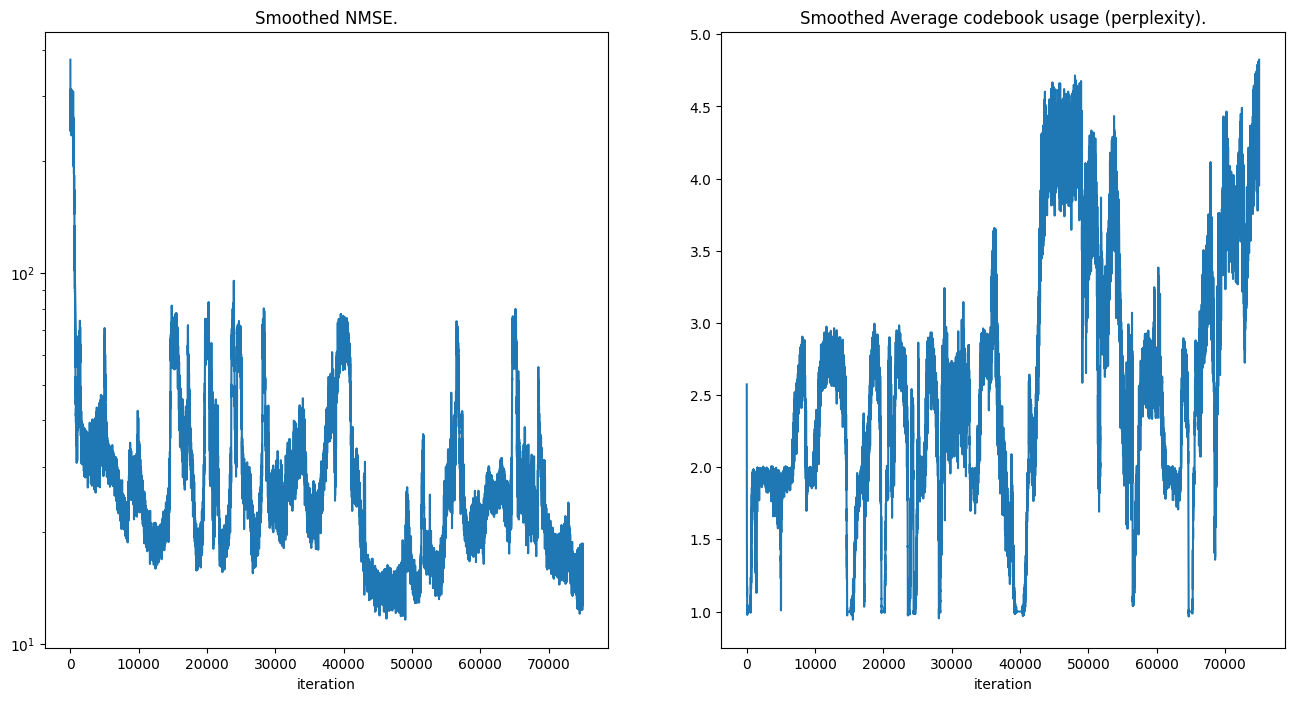

In [95]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

### Computation graph construction

In [ ]:
import networkx as nx

# Pseudo-function to parse the data and extract the architecture parameters
def parse_architecture_data(data):
    # This function would parse the given data to extract the architecture parameters
    # For demonstration purposes, we're going to manually set these values
    architecture_params = {
        "out_channel0": 117,
        "M": 1,
        "R": [9, 0, 0, 0, 0],
        "convblock": ['B', None, None, None, None],
        "widenfact": [4, None, None, None, None],
        "B": [11, None, None, None, None]
    }
    return architecture_params

# Function to create the computation graph based on the architecture
def create_computation_graph(architecture_params):
    G = nx.DiGraph()  # Create a directed graph

    # Create nodes for main blocks (M)
    for m in range(architecture_params['M']):
        main_block_name = f'M{m}'
        G.add_node(main_block_name, type='main_block')

        # Create nodes for residual blocks within each main block
        for r_index, r_value in enumerate(architecture_params['R']):
            if r_value > 0:  # Only if the residual block exists
                for r in range(r_value):
                    res_block_name = f'R{r_index+1}_{r}'
                    G.add_node(res_block_name, type='res_block')
                    # Connect the residual block to the main block
                    G.add_edge(main_block_name, res_block_name)

                    # Add conv blocks within each residual block
                    conv_block_type = architecture_params['convblock'][r_index]
                    if conv_block_type:
                        for b in range(architecture_params['B'][r_index]):
                            conv_block_name = f'{conv_block_type}{r_index+1}_{b}'
                            G.add_node(conv_block_name, type='conv_block')
                            # Connect the conv block to the residual block
                            G.add_edge(res_block_name, conv_block_name)

                            # Handle widening factor
                            widen_fact = architecture_params['widenfact'][r_index]
                            if widen_fact:
                                # Just represent the widen_fact as an attribute, no actual computation
                                G.nodes[conv_block_name]['widenfact'] = widen_fact

    return G

# Assuming `data` is the parsed information from the uploaded file or a similar source
data = "This would be replaced with the actual data parsing logic"
architecture_params = parse_architecture_data(data)
computation_graph = create_computation_graph(architecture_params)

# Pseudo-code to visualize the graph, actual visualization would depend on the environment
# visualize_computation_graph(computation_graph)

# Since visualization isn't possible here, we will print out the edges to represent the graph structure
print(list(computation_graph.edges(data=True)))


[('M0', 'R1_0', {}), ('M0', 'R1_1', {}), ('M0', 'R1_2', {}), ('M0', 'R1_3', {}), ('M0', 'R1_4', {}), ('M0', 'R1_5', {}), ('M0', 'R1_6', {}), ('M0', 'R1_7', {}), ('M0', 'R1_8', {}), ('R1_0', 'B1_0', {}), ('R1_0', 'B1_1', {}), ('R1_0', 'B1_2', {}), ('R1_0', 'B1_3', {}), ('R1_0', 'B1_4', {}), ('R1_0', 'B1_5', {}), ('R1_0', 'B1_6', {}), ('R1_0', 'B1_7', {}), ('R1_0', 'B1_8', {}), ('R1_0', 'B1_9', {}), ('R1_0', 'B1_10', {}), ('R1_1', 'B1_0', {}), ('R1_1', 'B1_1', {}), ('R1_1', 'B1_2', {}), ('R1_1', 'B1_3', {}), ('R1_1', 'B1_4', {}), ('R1_1', 'B1_5', {}), ('R1_1', 'B1_6', {}), ('R1_1', 'B1_7', {}), ('R1_1', 'B1_8', {}), ('R1_1', 'B1_9', {}), ('R1_1', 'B1_10', {}), ('R1_2', 'B1_0', {}), ('R1_2', 'B1_1', {}), ('R1_2', 'B1_2', {}), ('R1_2', 'B1_3', {}), ('R1_2', 'B1_4', {}), ('R1_2', 'B1_5', {}), ('R1_2', 'B1_6', {}), ('R1_2', 'B1_7', {}), ('R1_2', 'B1_8', {}), ('R1_2', 'B1_9', {}), ('R1_2', 'B1_10', {}), ('R1_3', 'B1_0', {}), ('R1_3', 'B1_1', {}), ('R1_3', 'B1_2', {}), ('R1_3', 'B1_3', {}), ('

### Autoencoder Model

In [57]:
class AutoEncoder(nn.Module):
  def __init__(self,x_dim,embed_dim=10,dropout=0.2,num_embeddings=50,h_nodes=128,scale=2,num_layers=1):
    super(AutoEncoder,self).__init__()
    self.encoder = Encoder(x_dim,embed_dim,dropout=dropout,h_nodes=h_nodes,scale=scale,num_layers=num_layers)
    self.decoder = Decoder(x_dim,embed_dim,h_nodes=h_nodes,dropout=dropout,scale=scale,num_layers=num_layers)

  def forward(self,x):
    z = self.encoder(x)
    x_recon = self.decoder(z)
    return x_recon

In [71]:
x_dim = data.shape[1]
h_nodes = 128
scale = 2
num_layers = 3
embed_dim = 10
dropout = 0.2
epochs = 500
learning_rate = 1e-4
weight_decay = 1e-3
batch_size = 16

In [72]:
train_loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

In [73]:
model = AutoEncoder(x_dim,embed_dim,dropout=dropout,num_embeddings=num_embeddings,
                h_nodes=h_nodes,scale=scale,num_layers=num_layers).to(device)

In [74]:
optimizer = optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)

In [75]:
model.train()
train_res_recon_error = []

for epoch in tqdm(range(epochs)):

  for i, batch in enumerate(train_loader):  # Iterate over all batches in the dataset
    batch_x,batch_y = batch
    batch_x = batch_x.to(device)
    optimizer.zero_grad()

    noise = torch.rand(batch_x.size()).to(device)
    data_recon = model(batch_x)
    recon_error = F.mse_loss(data_recon, batch_x)
    loss = recon_error
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())

    if (i+1) % 10 == 0:
      print('%d iterations of epochs %d/%d' % (i+1,epoch + 1, epochs))
      print('Average recon_error: %.3f' % np.mean(train_res_recon_error[-10:]))
      print()


  0%|          | 0/500 [00:00<?, ?it/s]

10 iterations of epochs 1/500
Average recon_error: 270.693

20 iterations of epochs 1/500
Average recon_error: 279.939

30 iterations of epochs 1/500
Average recon_error: 276.305

40 iterations of epochs 1/500
Average recon_error: 269.316

50 iterations of epochs 1/500
Average recon_error: 279.527

60 iterations of epochs 1/500
Average recon_error: 280.093



  0%|          | 1/500 [00:00<02:37,  3.16it/s]

70 iterations of epochs 1/500
Average recon_error: 273.068

10 iterations of epochs 2/500
Average recon_error: 274.020

20 iterations of epochs 2/500
Average recon_error: 223.874

30 iterations of epochs 2/500
Average recon_error: 154.003

40 iterations of epochs 2/500
Average recon_error: 129.244



  0%|          | 2/500 [00:00<02:37,  3.16it/s]

50 iterations of epochs 2/500
Average recon_error: 82.580

60 iterations of epochs 2/500
Average recon_error: 43.879

70 iterations of epochs 2/500
Average recon_error: 25.962

10 iterations of epochs 3/500
Average recon_error: 17.431

20 iterations of epochs 3/500
Average recon_error: 16.097



  1%|          | 3/500 [00:00<02:36,  3.18it/s]

30 iterations of epochs 3/500
Average recon_error: 13.618

40 iterations of epochs 3/500
Average recon_error: 13.657

50 iterations of epochs 3/500
Average recon_error: 13.843

60 iterations of epochs 3/500
Average recon_error: 13.826

70 iterations of epochs 3/500
Average recon_error: 15.483

10 iterations of epochs 4/500
Average recon_error: 14.351

20 iterations of epochs 4/500
Average recon_error: 14.798

30 iterations of epochs 4/500
Average recon_error: 14.588

40 iterations of epochs 4/500
Average recon_error: 13.186

50 iterations of epochs 4/500
Average recon_error: 15.589



  1%|          | 4/500 [00:01<02:35,  3.18it/s]

60 iterations of epochs 4/500
Average recon_error: 13.577

70 iterations of epochs 4/500
Average recon_error: 14.162

10 iterations of epochs 5/500
Average recon_error: 14.766

20 iterations of epochs 5/500
Average recon_error: 13.273

30 iterations of epochs 5/500
Average recon_error: 14.335



  1%|          | 5/500 [00:01<02:35,  3.18it/s]

40 iterations of epochs 5/500
Average recon_error: 13.228

50 iterations of epochs 5/500
Average recon_error: 14.047

60 iterations of epochs 5/500
Average recon_error: 14.633

70 iterations of epochs 5/500
Average recon_error: 14.405

10 iterations of epochs 6/500
Average recon_error: 14.446

20 iterations of epochs 6/500
Average recon_error: 14.035

30 iterations of epochs 6/500
Average recon_error: 14.722

40 iterations of epochs 6/500
Average recon_error: 13.217

50 iterations of epochs 6/500
Average recon_error: 14.582

60 iterations of epochs 6/500
Average recon_error: 13.421



  1%|          | 6/500 [00:01<02:34,  3.19it/s]

70 iterations of epochs 6/500
Average recon_error: 14.955

10 iterations of epochs 7/500
Average recon_error: 14.364

20 iterations of epochs 7/500
Average recon_error: 14.458

30 iterations of epochs 7/500
Average recon_error: 14.506

40 iterations of epochs 7/500
Average recon_error: 13.614



  1%|▏         | 7/500 [00:02<02:33,  3.21it/s]

50 iterations of epochs 7/500
Average recon_error: 13.408

60 iterations of epochs 7/500
Average recon_error: 13.880

70 iterations of epochs 7/500
Average recon_error: 14.255

10 iterations of epochs 8/500
Average recon_error: 14.926

20 iterations of epochs 8/500
Average recon_error: 14.040



  2%|▏         | 8/500 [00:02<02:34,  3.17it/s]

30 iterations of epochs 8/500
Average recon_error: 13.711

40 iterations of epochs 8/500
Average recon_error: 14.258

50 iterations of epochs 8/500
Average recon_error: 13.986

60 iterations of epochs 8/500
Average recon_error: 13.484

70 iterations of epochs 8/500
Average recon_error: 15.128

10 iterations of epochs 9/500
Average recon_error: 13.850

20 iterations of epochs 9/500
Average recon_error: 14.337

30 iterations of epochs 9/500
Average recon_error: 13.956

40 iterations of epochs 9/500
Average recon_error: 13.743

50 iterations of epochs 9/500
Average recon_error: 14.110

60 iterations of epochs 9/500
Average recon_error: 14.867



  2%|▏         | 9/500 [00:02<02:33,  3.19it/s]

70 iterations of epochs 9/500
Average recon_error: 14.610

10 iterations of epochs 10/500
Average recon_error: 13.511

20 iterations of epochs 10/500
Average recon_error: 13.785

30 iterations of epochs 10/500
Average recon_error: 14.243

40 iterations of epochs 10/500
Average recon_error: 14.007



  2%|▏         | 10/500 [00:03<02:33,  3.20it/s]

50 iterations of epochs 10/500
Average recon_error: 13.822

60 iterations of epochs 10/500
Average recon_error: 13.708

70 iterations of epochs 10/500
Average recon_error: 15.308

10 iterations of epochs 11/500
Average recon_error: 13.509

20 iterations of epochs 11/500
Average recon_error: 13.377

30 iterations of epochs 11/500
Average recon_error: 14.412

40 iterations of epochs 11/500
Average recon_error: 15.084

50 iterations of epochs 11/500
Average recon_error: 14.377

60 iterations of epochs 11/500
Average recon_error: 14.107

70 iterations of epochs 11/500
Average recon_error: 14.400



  2%|▏         | 11/500 [00:03<02:35,  3.15it/s]

10 iterations of epochs 12/500
Average recon_error: 14.386

20 iterations of epochs 12/500
Average recon_error: 14.696

30 iterations of epochs 12/500
Average recon_error: 14.990

40 iterations of epochs 12/500
Average recon_error: 12.933

50 iterations of epochs 12/500
Average recon_error: 13.751



  2%|▏         | 12/500 [00:03<02:36,  3.13it/s]

60 iterations of epochs 12/500
Average recon_error: 14.188

70 iterations of epochs 12/500
Average recon_error: 14.501

10 iterations of epochs 13/500
Average recon_error: 14.675

20 iterations of epochs 13/500
Average recon_error: 13.789

30 iterations of epochs 13/500
Average recon_error: 12.723

40 iterations of epochs 13/500
Average recon_error: 14.285

50 iterations of epochs 13/500
Average recon_error: 15.032

60 iterations of epochs 13/500
Average recon_error: 14.211



  3%|▎         | 13/500 [00:04<02:49,  2.87it/s]

70 iterations of epochs 13/500
Average recon_error: 14.484

10 iterations of epochs 14/500
Average recon_error: 14.644

20 iterations of epochs 14/500
Average recon_error: 13.910

30 iterations of epochs 14/500
Average recon_error: 14.712

40 iterations of epochs 14/500
Average recon_error: 13.191

50 iterations of epochs 14/500
Average recon_error: 15.629

60 iterations of epochs 14/500
Average recon_error: 13.595



  3%|▎         | 14/500 [00:04<03:00,  2.70it/s]

70 iterations of epochs 14/500
Average recon_error: 13.624

10 iterations of epochs 15/500
Average recon_error: 14.794

20 iterations of epochs 15/500
Average recon_error: 13.292

30 iterations of epochs 15/500
Average recon_error: 14.223



  3%|▎         | 15/500 [00:05<03:02,  2.66it/s]

40 iterations of epochs 15/500
Average recon_error: 14.193

50 iterations of epochs 15/500
Average recon_error: 13.547

60 iterations of epochs 15/500
Average recon_error: 14.156

70 iterations of epochs 15/500
Average recon_error: 14.690

10 iterations of epochs 16/500
Average recon_error: 14.868

20 iterations of epochs 16/500
Average recon_error: 13.850

30 iterations of epochs 16/500
Average recon_error: 14.816

40 iterations of epochs 16/500
Average recon_error: 13.370



  3%|▎         | 16/500 [00:05<03:10,  2.54it/s]

50 iterations of epochs 16/500
Average recon_error: 13.355

60 iterations of epochs 16/500
Average recon_error: 15.189

70 iterations of epochs 16/500
Average recon_error: 13.896

10 iterations of epochs 17/500
Average recon_error: 13.968

20 iterations of epochs 17/500
Average recon_error: 14.017

30 iterations of epochs 17/500
Average recon_error: 14.331

40 iterations of epochs 17/500
Average recon_error: 13.872



  3%|▎         | 17/500 [00:05<03:17,  2.44it/s]

50 iterations of epochs 17/500
Average recon_error: 13.805

60 iterations of epochs 17/500
Average recon_error: 13.403

70 iterations of epochs 17/500
Average recon_error: 15.319

10 iterations of epochs 18/500
Average recon_error: 13.917

20 iterations of epochs 18/500
Average recon_error: 12.866

30 iterations of epochs 18/500
Average recon_error: 13.991

40 iterations of epochs 18/500
Average recon_error: 14.355

50 iterations of epochs 18/500
Average recon_error: 14.660

60 iterations of epochs 18/500
Average recon_error: 14.896



  4%|▎         | 18/500 [00:06<03:07,  2.57it/s]

70 iterations of epochs 18/500
Average recon_error: 13.983

10 iterations of epochs 19/500
Average recon_error: 13.391

20 iterations of epochs 19/500
Average recon_error: 15.012

30 iterations of epochs 19/500
Average recon_error: 14.428

40 iterations of epochs 19/500
Average recon_error: 15.057



  4%|▍         | 19/500 [00:06<02:56,  2.73it/s]

50 iterations of epochs 19/500
Average recon_error: 13.535

60 iterations of epochs 19/500
Average recon_error: 14.612

70 iterations of epochs 19/500
Average recon_error: 13.731

10 iterations of epochs 20/500
Average recon_error: 12.531

20 iterations of epochs 20/500
Average recon_error: 14.423



  4%|▍         | 20/500 [00:06<02:48,  2.85it/s]

30 iterations of epochs 20/500
Average recon_error: 14.945

40 iterations of epochs 20/500
Average recon_error: 14.044

50 iterations of epochs 20/500
Average recon_error: 14.362

60 iterations of epochs 20/500
Average recon_error: 14.836

70 iterations of epochs 20/500
Average recon_error: 13.489

10 iterations of epochs 21/500
Average recon_error: 15.210

20 iterations of epochs 21/500
Average recon_error: 13.480

30 iterations of epochs 21/500
Average recon_error: 13.428

40 iterations of epochs 21/500
Average recon_error: 14.095

50 iterations of epochs 21/500
Average recon_error: 14.548



  4%|▍         | 21/500 [00:07<02:43,  2.94it/s]

60 iterations of epochs 21/500
Average recon_error: 14.253

70 iterations of epochs 21/500
Average recon_error: 13.928

10 iterations of epochs 22/500
Average recon_error: 13.353

20 iterations of epochs 22/500
Average recon_error: 14.183

30 iterations of epochs 22/500
Average recon_error: 13.977



  4%|▍         | 22/500 [00:07<02:38,  3.01it/s]

40 iterations of epochs 22/500
Average recon_error: 14.418

50 iterations of epochs 22/500
Average recon_error: 13.911

60 iterations of epochs 22/500
Average recon_error: 13.653

70 iterations of epochs 22/500
Average recon_error: 14.150

10 iterations of epochs 23/500
Average recon_error: 13.070

20 iterations of epochs 23/500
Average recon_error: 14.113

30 iterations of epochs 23/500
Average recon_error: 13.478

40 iterations of epochs 23/500
Average recon_error: 14.825

50 iterations of epochs 23/500
Average recon_error: 14.026

60 iterations of epochs 23/500
Average recon_error: 14.607



  5%|▍         | 23/500 [00:07<02:38,  3.01it/s]

70 iterations of epochs 23/500
Average recon_error: 14.115

10 iterations of epochs 24/500
Average recon_error: 15.077

20 iterations of epochs 24/500
Average recon_error: 13.354

30 iterations of epochs 24/500
Average recon_error: 14.535

40 iterations of epochs 24/500
Average recon_error: 14.171



  5%|▍         | 24/500 [00:08<02:36,  3.05it/s]

50 iterations of epochs 24/500
Average recon_error: 14.262

60 iterations of epochs 24/500
Average recon_error: 13.817

70 iterations of epochs 24/500
Average recon_error: 14.073

10 iterations of epochs 25/500
Average recon_error: 13.915

20 iterations of epochs 25/500
Average recon_error: 14.264



  5%|▌         | 25/500 [00:08<02:35,  3.05it/s]

30 iterations of epochs 25/500
Average recon_error: 14.653

40 iterations of epochs 25/500
Average recon_error: 13.919

50 iterations of epochs 25/500
Average recon_error: 14.048

60 iterations of epochs 25/500
Average recon_error: 13.770

70 iterations of epochs 25/500
Average recon_error: 14.574

10 iterations of epochs 26/500
Average recon_error: 12.696

20 iterations of epochs 26/500
Average recon_error: 13.885

30 iterations of epochs 26/500
Average recon_error: 14.383

40 iterations of epochs 26/500
Average recon_error: 14.098

50 iterations of epochs 26/500
Average recon_error: 13.835



  5%|▌         | 26/500 [00:08<02:37,  3.02it/s]

60 iterations of epochs 26/500
Average recon_error: 14.768

70 iterations of epochs 26/500
Average recon_error: 14.219

10 iterations of epochs 27/500
Average recon_error: 14.916

20 iterations of epochs 27/500
Average recon_error: 14.172

30 iterations of epochs 27/500
Average recon_error: 13.148



  5%|▌         | 27/500 [00:09<02:34,  3.07it/s]

40 iterations of epochs 27/500
Average recon_error: 14.016

50 iterations of epochs 27/500
Average recon_error: 14.597

60 iterations of epochs 27/500
Average recon_error: 14.056

70 iterations of epochs 27/500
Average recon_error: 13.643

10 iterations of epochs 28/500
Average recon_error: 12.593

20 iterations of epochs 28/500
Average recon_error: 14.212

30 iterations of epochs 28/500
Average recon_error: 14.438

40 iterations of epochs 28/500
Average recon_error: 14.328

50 iterations of epochs 28/500
Average recon_error: 14.417

60 iterations of epochs 28/500
Average recon_error: 14.066



  6%|▌         | 28/500 [00:09<02:34,  3.06it/s]

70 iterations of epochs 28/500
Average recon_error: 14.755

10 iterations of epochs 29/500
Average recon_error: 14.609

20 iterations of epochs 29/500
Average recon_error: 14.006

30 iterations of epochs 29/500
Average recon_error: 13.305

40 iterations of epochs 29/500
Average recon_error: 13.874



  6%|▌         | 29/500 [00:09<02:33,  3.07it/s]

50 iterations of epochs 29/500
Average recon_error: 14.745

60 iterations of epochs 29/500
Average recon_error: 13.531

70 iterations of epochs 29/500
Average recon_error: 14.451

10 iterations of epochs 30/500
Average recon_error: 14.540

20 iterations of epochs 30/500
Average recon_error: 14.165



  6%|▌         | 30/500 [00:10<02:34,  3.05it/s]

30 iterations of epochs 30/500
Average recon_error: 13.364

40 iterations of epochs 30/500
Average recon_error: 14.509

50 iterations of epochs 30/500
Average recon_error: 13.990

60 iterations of epochs 30/500
Average recon_error: 13.076

70 iterations of epochs 30/500
Average recon_error: 14.392

10 iterations of epochs 31/500
Average recon_error: 14.486

20 iterations of epochs 31/500
Average recon_error: 15.573

30 iterations of epochs 31/500
Average recon_error: 12.896

40 iterations of epochs 31/500
Average recon_error: 14.040

50 iterations of epochs 31/500
Average recon_error: 13.208



  6%|▌         | 31/500 [00:10<02:35,  3.01it/s]

60 iterations of epochs 31/500
Average recon_error: 13.695

70 iterations of epochs 31/500
Average recon_error: 14.075

10 iterations of epochs 32/500
Average recon_error: 14.025

20 iterations of epochs 32/500
Average recon_error: 13.991

30 iterations of epochs 32/500
Average recon_error: 14.972



  6%|▋         | 32/500 [00:10<02:35,  3.01it/s]

40 iterations of epochs 32/500
Average recon_error: 13.729

50 iterations of epochs 32/500
Average recon_error: 13.691

60 iterations of epochs 32/500
Average recon_error: 13.485

70 iterations of epochs 32/500
Average recon_error: 14.022

10 iterations of epochs 33/500
Average recon_error: 14.048

20 iterations of epochs 33/500
Average recon_error: 14.303

30 iterations of epochs 33/500
Average recon_error: 13.222

40 iterations of epochs 33/500
Average recon_error: 13.707

50 iterations of epochs 33/500
Average recon_error: 14.257



  7%|▋         | 33/500 [00:11<02:33,  3.04it/s]

60 iterations of epochs 33/500
Average recon_error: 13.877

70 iterations of epochs 33/500
Average recon_error: 14.536

10 iterations of epochs 34/500
Average recon_error: 13.886

20 iterations of epochs 34/500
Average recon_error: 13.424

30 iterations of epochs 34/500
Average recon_error: 14.714



  7%|▋         | 34/500 [00:11<02:31,  3.08it/s]

40 iterations of epochs 34/500
Average recon_error: 13.557

50 iterations of epochs 34/500
Average recon_error: 13.566

60 iterations of epochs 34/500
Average recon_error: 14.548

70 iterations of epochs 34/500
Average recon_error: 14.306

10 iterations of epochs 35/500
Average recon_error: 14.258

20 iterations of epochs 35/500
Average recon_error: 13.477

30 iterations of epochs 35/500
Average recon_error: 15.299

40 iterations of epochs 35/500
Average recon_error: 13.687

50 iterations of epochs 35/500
Average recon_error: 13.981

60 iterations of epochs 35/500
Average recon_error: 14.090



  7%|▋         | 35/500 [00:11<02:30,  3.08it/s]

70 iterations of epochs 35/500
Average recon_error: 13.863

10 iterations of epochs 36/500
Average recon_error: 12.930

20 iterations of epochs 36/500
Average recon_error: 13.596

30 iterations of epochs 36/500
Average recon_error: 14.541

40 iterations of epochs 36/500
Average recon_error: 14.613



  7%|▋         | 36/500 [00:12<02:29,  3.10it/s]

50 iterations of epochs 36/500
Average recon_error: 15.588

60 iterations of epochs 36/500
Average recon_error: 13.498

70 iterations of epochs 36/500
Average recon_error: 13.871

10 iterations of epochs 37/500
Average recon_error: 14.420

20 iterations of epochs 37/500
Average recon_error: 14.664



  7%|▋         | 37/500 [00:12<02:28,  3.11it/s]

30 iterations of epochs 37/500
Average recon_error: 13.935

40 iterations of epochs 37/500
Average recon_error: 14.205

50 iterations of epochs 37/500
Average recon_error: 13.793

60 iterations of epochs 37/500
Average recon_error: 13.367

70 iterations of epochs 37/500
Average recon_error: 13.800

10 iterations of epochs 38/500
Average recon_error: 14.695

20 iterations of epochs 38/500
Average recon_error: 14.123

30 iterations of epochs 38/500
Average recon_error: 13.114

40 iterations of epochs 38/500
Average recon_error: 13.307

50 iterations of epochs 38/500
Average recon_error: 14.637



  8%|▊         | 38/500 [00:12<02:27,  3.13it/s]

60 iterations of epochs 38/500
Average recon_error: 14.959

70 iterations of epochs 38/500
Average recon_error: 13.988

10 iterations of epochs 39/500
Average recon_error: 14.610

20 iterations of epochs 39/500
Average recon_error: 13.416

30 iterations of epochs 39/500
Average recon_error: 14.144



  8%|▊         | 39/500 [00:13<02:27,  3.12it/s]

40 iterations of epochs 39/500
Average recon_error: 15.192

50 iterations of epochs 39/500
Average recon_error: 13.533

60 iterations of epochs 39/500
Average recon_error: 14.428

70 iterations of epochs 39/500
Average recon_error: 13.801

10 iterations of epochs 40/500
Average recon_error: 14.033

20 iterations of epochs 40/500
Average recon_error: 13.352

30 iterations of epochs 40/500
Average recon_error: 13.533

40 iterations of epochs 40/500
Average recon_error: 14.798

50 iterations of epochs 40/500
Average recon_error: 14.199

60 iterations of epochs 40/500
Average recon_error: 14.197



  8%|▊         | 40/500 [00:13<02:27,  3.12it/s]

70 iterations of epochs 40/500
Average recon_error: 13.804

10 iterations of epochs 41/500
Average recon_error: 13.239

20 iterations of epochs 41/500
Average recon_error: 12.875

30 iterations of epochs 41/500
Average recon_error: 15.464

40 iterations of epochs 41/500
Average recon_error: 14.255



  8%|▊         | 41/500 [00:13<02:26,  3.14it/s]

50 iterations of epochs 41/500
Average recon_error: 14.643

60 iterations of epochs 41/500
Average recon_error: 13.740

70 iterations of epochs 41/500
Average recon_error: 13.618

10 iterations of epochs 42/500
Average recon_error: 14.181

20 iterations of epochs 42/500
Average recon_error: 14.116



  8%|▊         | 42/500 [00:13<02:26,  3.13it/s]

30 iterations of epochs 42/500
Average recon_error: 14.096

40 iterations of epochs 42/500
Average recon_error: 13.652

50 iterations of epochs 42/500
Average recon_error: 13.152

60 iterations of epochs 42/500
Average recon_error: 14.395

70 iterations of epochs 42/500
Average recon_error: 14.299

10 iterations of epochs 43/500
Average recon_error: 13.709

20 iterations of epochs 43/500
Average recon_error: 14.259

30 iterations of epochs 43/500
Average recon_error: 13.299

40 iterations of epochs 43/500
Average recon_error: 14.545

50 iterations of epochs 43/500
Average recon_error: 14.649



  9%|▊         | 43/500 [00:14<02:25,  3.14it/s]

60 iterations of epochs 43/500
Average recon_error: 14.509

70 iterations of epochs 43/500
Average recon_error: 12.985

10 iterations of epochs 44/500
Average recon_error: 13.958

20 iterations of epochs 44/500
Average recon_error: 14.704

30 iterations of epochs 44/500
Average recon_error: 13.091



  9%|▉         | 44/500 [00:14<02:25,  3.13it/s]

40 iterations of epochs 44/500
Average recon_error: 14.422

50 iterations of epochs 44/500
Average recon_error: 14.031

60 iterations of epochs 44/500
Average recon_error: 13.229

70 iterations of epochs 44/500
Average recon_error: 14.043

10 iterations of epochs 45/500
Average recon_error: 14.167

20 iterations of epochs 45/500
Average recon_error: 14.585

30 iterations of epochs 45/500
Average recon_error: 13.396

40 iterations of epochs 45/500
Average recon_error: 14.058

50 iterations of epochs 45/500
Average recon_error: 13.428

60 iterations of epochs 45/500
Average recon_error: 13.984



  9%|▉         | 45/500 [00:14<02:26,  3.11it/s]

70 iterations of epochs 45/500
Average recon_error: 13.969

10 iterations of epochs 46/500
Average recon_error: 14.124

20 iterations of epochs 46/500
Average recon_error: 13.937

30 iterations of epochs 46/500
Average recon_error: 13.396

40 iterations of epochs 46/500
Average recon_error: 13.623



  9%|▉         | 46/500 [00:15<02:25,  3.13it/s]

50 iterations of epochs 46/500
Average recon_error: 14.441

60 iterations of epochs 46/500
Average recon_error: 14.353

70 iterations of epochs 46/500
Average recon_error: 13.252

10 iterations of epochs 47/500
Average recon_error: 13.845

20 iterations of epochs 47/500
Average recon_error: 14.290



  9%|▉         | 47/500 [00:15<02:24,  3.14it/s]

30 iterations of epochs 47/500
Average recon_error: 14.181

40 iterations of epochs 47/500
Average recon_error: 13.814

50 iterations of epochs 47/500
Average recon_error: 13.555

60 iterations of epochs 47/500
Average recon_error: 14.505

70 iterations of epochs 47/500
Average recon_error: 13.594

10 iterations of epochs 48/500
Average recon_error: 13.889

20 iterations of epochs 48/500
Average recon_error: 13.809

30 iterations of epochs 48/500
Average recon_error: 13.766

40 iterations of epochs 48/500
Average recon_error: 13.966

50 iterations of epochs 48/500
Average recon_error: 14.217



 10%|▉         | 48/500 [00:15<02:32,  2.97it/s]

60 iterations of epochs 48/500
Average recon_error: 14.202

70 iterations of epochs 48/500
Average recon_error: 13.603

10 iterations of epochs 49/500
Average recon_error: 13.910

20 iterations of epochs 49/500
Average recon_error: 14.343

30 iterations of epochs 49/500
Average recon_error: 13.215

40 iterations of epochs 49/500
Average recon_error: 14.074

50 iterations of epochs 49/500
Average recon_error: 14.049



 10%|▉         | 49/500 [00:16<02:41,  2.79it/s]

60 iterations of epochs 49/500
Average recon_error: 14.116

70 iterations of epochs 49/500
Average recon_error: 14.156

10 iterations of epochs 50/500
Average recon_error: 14.680

20 iterations of epochs 50/500
Average recon_error: 13.642

30 iterations of epochs 50/500
Average recon_error: 14.320

40 iterations of epochs 50/500
Average recon_error: 13.381

50 iterations of epochs 50/500
Average recon_error: 13.999

60 iterations of epochs 50/500
Average recon_error: 13.413



 10%|█         | 50/500 [00:16<02:45,  2.72it/s]

70 iterations of epochs 50/500
Average recon_error: 14.164

10 iterations of epochs 51/500
Average recon_error: 13.416

20 iterations of epochs 51/500
Average recon_error: 14.965

30 iterations of epochs 51/500
Average recon_error: 14.135



 10%|█         | 51/500 [00:17<02:50,  2.63it/s]

40 iterations of epochs 51/500
Average recon_error: 13.615

50 iterations of epochs 51/500
Average recon_error: 13.286

60 iterations of epochs 51/500
Average recon_error: 14.636

70 iterations of epochs 51/500
Average recon_error: 13.979

10 iterations of epochs 52/500
Average recon_error: 14.347

20 iterations of epochs 52/500
Average recon_error: 14.455

30 iterations of epochs 52/500
Average recon_error: 13.769

40 iterations of epochs 52/500
Average recon_error: 13.747



 10%|█         | 52/500 [00:17<02:57,  2.52it/s]

50 iterations of epochs 52/500
Average recon_error: 13.219

60 iterations of epochs 52/500
Average recon_error: 14.202

70 iterations of epochs 52/500
Average recon_error: 14.257

10 iterations of epochs 53/500
Average recon_error: 13.383

20 iterations of epochs 53/500
Average recon_error: 14.356

30 iterations of epochs 53/500
Average recon_error: 14.173

40 iterations of epochs 53/500
Average recon_error: 13.013

50 iterations of epochs 53/500
Average recon_error: 14.678



 11%|█         | 53/500 [00:17<02:55,  2.55it/s]

60 iterations of epochs 53/500
Average recon_error: 14.144

70 iterations of epochs 53/500
Average recon_error: 13.427

10 iterations of epochs 54/500
Average recon_error: 13.656

20 iterations of epochs 54/500
Average recon_error: 14.501

30 iterations of epochs 54/500
Average recon_error: 13.963



 11%|█         | 54/500 [00:18<02:45,  2.69it/s]

40 iterations of epochs 54/500
Average recon_error: 15.134

50 iterations of epochs 54/500
Average recon_error: 12.955

60 iterations of epochs 54/500
Average recon_error: 13.896

70 iterations of epochs 54/500
Average recon_error: 14.016

10 iterations of epochs 55/500
Average recon_error: 13.864

20 iterations of epochs 55/500
Average recon_error: 14.288

30 iterations of epochs 55/500
Average recon_error: 13.748

40 iterations of epochs 55/500
Average recon_error: 14.149

50 iterations of epochs 55/500
Average recon_error: 14.679

60 iterations of epochs 55/500
Average recon_error: 14.673



 11%|█         | 55/500 [00:18<02:38,  2.81it/s]

70 iterations of epochs 55/500
Average recon_error: 13.038

10 iterations of epochs 56/500
Average recon_error: 13.628

20 iterations of epochs 56/500
Average recon_error: 13.768

30 iterations of epochs 56/500
Average recon_error: 14.132

40 iterations of epochs 56/500
Average recon_error: 14.526



 11%|█         | 56/500 [00:18<02:34,  2.87it/s]

50 iterations of epochs 56/500
Average recon_error: 13.222

60 iterations of epochs 56/500
Average recon_error: 13.877

70 iterations of epochs 56/500
Average recon_error: 14.061

10 iterations of epochs 57/500
Average recon_error: 13.471

20 iterations of epochs 57/500
Average recon_error: 14.655



 11%|█▏        | 57/500 [00:19<02:29,  2.96it/s]

30 iterations of epochs 57/500
Average recon_error: 13.068

40 iterations of epochs 57/500
Average recon_error: 13.816

50 iterations of epochs 57/500
Average recon_error: 14.307

60 iterations of epochs 57/500
Average recon_error: 14.364

70 iterations of epochs 57/500
Average recon_error: 13.712

10 iterations of epochs 58/500
Average recon_error: 12.613

20 iterations of epochs 58/500
Average recon_error: 14.376

30 iterations of epochs 58/500
Average recon_error: 14.229

40 iterations of epochs 58/500
Average recon_error: 14.190

50 iterations of epochs 58/500
Average recon_error: 13.749



 12%|█▏        | 58/500 [00:19<02:27,  3.00it/s]

60 iterations of epochs 58/500
Average recon_error: 13.592

70 iterations of epochs 58/500
Average recon_error: 14.836

10 iterations of epochs 59/500
Average recon_error: 14.951

20 iterations of epochs 59/500
Average recon_error: 13.521

30 iterations of epochs 59/500
Average recon_error: 13.631



 12%|█▏        | 59/500 [00:19<02:24,  3.05it/s]

40 iterations of epochs 59/500
Average recon_error: 14.104

50 iterations of epochs 59/500
Average recon_error: 14.117

60 iterations of epochs 59/500
Average recon_error: 13.734

70 iterations of epochs 59/500
Average recon_error: 13.428

10 iterations of epochs 60/500
Average recon_error: 14.479

20 iterations of epochs 60/500
Average recon_error: 13.703

30 iterations of epochs 60/500
Average recon_error: 13.144

40 iterations of epochs 60/500
Average recon_error: 15.147

50 iterations of epochs 60/500
Average recon_error: 13.366

60 iterations of epochs 60/500
Average recon_error: 13.536



 12%|█▏        | 60/500 [00:20<02:23,  3.06it/s]

70 iterations of epochs 60/500
Average recon_error: 13.612

10 iterations of epochs 61/500
Average recon_error: 14.991

20 iterations of epochs 61/500
Average recon_error: 13.524

30 iterations of epochs 61/500
Average recon_error: 12.989

40 iterations of epochs 61/500
Average recon_error: 13.578



 12%|█▏        | 61/500 [00:20<02:21,  3.10it/s]

50 iterations of epochs 61/500
Average recon_error: 13.838

60 iterations of epochs 61/500
Average recon_error: 14.861

70 iterations of epochs 61/500
Average recon_error: 13.224

10 iterations of epochs 62/500
Average recon_error: 13.278

20 iterations of epochs 62/500
Average recon_error: 14.818



 12%|█▏        | 62/500 [00:20<02:20,  3.11it/s]

30 iterations of epochs 62/500
Average recon_error: 13.471

40 iterations of epochs 62/500
Average recon_error: 13.475

50 iterations of epochs 62/500
Average recon_error: 13.602

60 iterations of epochs 62/500
Average recon_error: 14.474

70 iterations of epochs 62/500
Average recon_error: 14.269

10 iterations of epochs 63/500
Average recon_error: 14.793

20 iterations of epochs 63/500
Average recon_error: 14.622

30 iterations of epochs 63/500
Average recon_error: 13.481

40 iterations of epochs 63/500
Average recon_error: 13.158

50 iterations of epochs 63/500
Average recon_error: 13.951



 13%|█▎        | 63/500 [00:21<02:20,  3.10it/s]

60 iterations of epochs 63/500
Average recon_error: 14.207

70 iterations of epochs 63/500
Average recon_error: 13.417

10 iterations of epochs 64/500
Average recon_error: 13.312

20 iterations of epochs 64/500
Average recon_error: 13.859

30 iterations of epochs 64/500
Average recon_error: 15.167



 13%|█▎        | 64/500 [00:21<02:19,  3.11it/s]

40 iterations of epochs 64/500
Average recon_error: 13.259

50 iterations of epochs 64/500
Average recon_error: 13.901

60 iterations of epochs 64/500
Average recon_error: 13.057

70 iterations of epochs 64/500
Average recon_error: 13.799

10 iterations of epochs 65/500
Average recon_error: 13.803

20 iterations of epochs 65/500
Average recon_error: 13.540

30 iterations of epochs 65/500
Average recon_error: 13.603

40 iterations of epochs 65/500
Average recon_error: 13.298

50 iterations of epochs 65/500
Average recon_error: 13.432

60 iterations of epochs 65/500
Average recon_error: 13.236



 13%|█▎        | 65/500 [00:21<02:18,  3.14it/s]

70 iterations of epochs 65/500
Average recon_error: 14.119

10 iterations of epochs 66/500
Average recon_error: 13.149

20 iterations of epochs 66/500
Average recon_error: 13.667

30 iterations of epochs 66/500
Average recon_error: 14.442

40 iterations of epochs 66/500
Average recon_error: 14.554



 13%|█▎        | 66/500 [00:22<02:18,  3.12it/s]

50 iterations of epochs 66/500
Average recon_error: 14.100

60 iterations of epochs 66/500
Average recon_error: 12.666

70 iterations of epochs 66/500
Average recon_error: 13.518

10 iterations of epochs 67/500
Average recon_error: 13.821

20 iterations of epochs 67/500
Average recon_error: 13.518



 13%|█▎        | 67/500 [00:22<02:17,  3.15it/s]

30 iterations of epochs 67/500
Average recon_error: 12.972

40 iterations of epochs 67/500
Average recon_error: 13.996

50 iterations of epochs 67/500
Average recon_error: 13.570

60 iterations of epochs 67/500
Average recon_error: 13.589

70 iterations of epochs 67/500
Average recon_error: 13.282

10 iterations of epochs 68/500
Average recon_error: 14.016

20 iterations of epochs 68/500
Average recon_error: 14.239

30 iterations of epochs 68/500
Average recon_error: 12.804

40 iterations of epochs 68/500
Average recon_error: 14.018

50 iterations of epochs 68/500
Average recon_error: 13.496



 14%|█▎        | 68/500 [00:22<02:16,  3.16it/s]

60 iterations of epochs 68/500
Average recon_error: 13.606

70 iterations of epochs 68/500
Average recon_error: 13.316

10 iterations of epochs 69/500
Average recon_error: 14.289

20 iterations of epochs 69/500
Average recon_error: 12.664

30 iterations of epochs 69/500
Average recon_error: 13.584



 14%|█▍        | 69/500 [00:23<02:17,  3.14it/s]

40 iterations of epochs 69/500
Average recon_error: 13.535

50 iterations of epochs 69/500
Average recon_error: 13.591

60 iterations of epochs 69/500
Average recon_error: 13.550

70 iterations of epochs 69/500
Average recon_error: 14.091

10 iterations of epochs 70/500
Average recon_error: 14.048

20 iterations of epochs 70/500
Average recon_error: 13.602

30 iterations of epochs 70/500
Average recon_error: 13.530

40 iterations of epochs 70/500
Average recon_error: 14.130

50 iterations of epochs 70/500
Average recon_error: 13.881

60 iterations of epochs 70/500
Average recon_error: 13.865



 14%|█▍        | 70/500 [00:23<02:16,  3.15it/s]

70 iterations of epochs 70/500
Average recon_error: 13.060

10 iterations of epochs 71/500
Average recon_error: 13.410

20 iterations of epochs 71/500
Average recon_error: 13.598

30 iterations of epochs 71/500
Average recon_error: 12.704

40 iterations of epochs 71/500
Average recon_error: 13.954



 14%|█▍        | 71/500 [00:23<02:16,  3.15it/s]

50 iterations of epochs 71/500
Average recon_error: 14.289

60 iterations of epochs 71/500
Average recon_error: 13.592

70 iterations of epochs 71/500
Average recon_error: 13.056

10 iterations of epochs 72/500
Average recon_error: 13.247

20 iterations of epochs 72/500
Average recon_error: 13.484



 14%|█▍        | 72/500 [00:24<02:16,  3.14it/s]

30 iterations of epochs 72/500
Average recon_error: 14.021

40 iterations of epochs 72/500
Average recon_error: 13.172

50 iterations of epochs 72/500
Average recon_error: 14.060

60 iterations of epochs 72/500
Average recon_error: 13.190

70 iterations of epochs 72/500
Average recon_error: 14.115

10 iterations of epochs 73/500
Average recon_error: 13.743

20 iterations of epochs 73/500
Average recon_error: 13.460

30 iterations of epochs 73/500
Average recon_error: 14.477

40 iterations of epochs 73/500
Average recon_error: 13.294

50 iterations of epochs 73/500
Average recon_error: 13.488



 15%|█▍        | 73/500 [00:24<02:15,  3.15it/s]

60 iterations of epochs 73/500
Average recon_error: 13.708

70 iterations of epochs 73/500
Average recon_error: 13.253

10 iterations of epochs 74/500
Average recon_error: 12.825

20 iterations of epochs 74/500
Average recon_error: 13.906

30 iterations of epochs 74/500
Average recon_error: 13.765



 15%|█▍        | 74/500 [00:24<02:15,  3.15it/s]

40 iterations of epochs 74/500
Average recon_error: 13.299

50 iterations of epochs 74/500
Average recon_error: 13.629

60 iterations of epochs 74/500
Average recon_error: 14.083

70 iterations of epochs 74/500
Average recon_error: 13.398

10 iterations of epochs 75/500
Average recon_error: 13.438

20 iterations of epochs 75/500
Average recon_error: 13.361

30 iterations of epochs 75/500
Average recon_error: 13.377

40 iterations of epochs 75/500
Average recon_error: 13.398

50 iterations of epochs 75/500
Average recon_error: 13.510

60 iterations of epochs 75/500
Average recon_error: 14.230



 15%|█▌        | 75/500 [00:24<02:14,  3.17it/s]

70 iterations of epochs 75/500
Average recon_error: 13.951

10 iterations of epochs 76/500
Average recon_error: 13.528

20 iterations of epochs 76/500
Average recon_error: 13.834

30 iterations of epochs 76/500
Average recon_error: 13.577

40 iterations of epochs 76/500
Average recon_error: 13.142



 15%|█▌        | 76/500 [00:25<02:14,  3.16it/s]

50 iterations of epochs 76/500
Average recon_error: 13.292

60 iterations of epochs 76/500
Average recon_error: 14.192

70 iterations of epochs 76/500
Average recon_error: 13.311

10 iterations of epochs 77/500
Average recon_error: 13.265

20 iterations of epochs 77/500
Average recon_error: 13.040



 15%|█▌        | 77/500 [00:25<02:12,  3.18it/s]

30 iterations of epochs 77/500
Average recon_error: 13.443

40 iterations of epochs 77/500
Average recon_error: 14.555

50 iterations of epochs 77/500
Average recon_error: 13.408

60 iterations of epochs 77/500
Average recon_error: 13.613

70 iterations of epochs 77/500
Average recon_error: 13.187

10 iterations of epochs 78/500
Average recon_error: 12.936

20 iterations of epochs 78/500
Average recon_error: 13.205

30 iterations of epochs 78/500
Average recon_error: 12.701

40 iterations of epochs 78/500
Average recon_error: 14.952

50 iterations of epochs 78/500
Average recon_error: 13.157



 16%|█▌        | 78/500 [00:25<02:12,  3.18it/s]

60 iterations of epochs 78/500
Average recon_error: 13.737

70 iterations of epochs 78/500
Average recon_error: 14.037

10 iterations of epochs 79/500
Average recon_error: 13.350

20 iterations of epochs 79/500
Average recon_error: 14.216



 16%|█▌        | 79/500 [00:26<02:12,  3.17it/s]

30 iterations of epochs 79/500
Average recon_error: 13.800

40 iterations of epochs 79/500
Average recon_error: 12.922

50 iterations of epochs 79/500
Average recon_error: 13.218

60 iterations of epochs 79/500
Average recon_error: 12.968

70 iterations of epochs 79/500
Average recon_error: 13.596

10 iterations of epochs 80/500
Average recon_error: 12.921

20 iterations of epochs 80/500
Average recon_error: 12.803

30 iterations of epochs 80/500
Average recon_error: 13.399

40 iterations of epochs 80/500
Average recon_error: 12.238

50 iterations of epochs 80/500
Average recon_error: 11.441



 16%|█▌        | 80/500 [00:26<02:12,  3.16it/s]

60 iterations of epochs 80/500
Average recon_error: 11.007

70 iterations of epochs 80/500
Average recon_error: 10.635

10 iterations of epochs 81/500
Average recon_error: 9.712

20 iterations of epochs 81/500
Average recon_error: 8.780

30 iterations of epochs 81/500
Average recon_error: 8.576



 16%|█▌        | 81/500 [00:26<02:13,  3.15it/s]

40 iterations of epochs 81/500
Average recon_error: 8.649

50 iterations of epochs 81/500
Average recon_error: 8.302

60 iterations of epochs 81/500
Average recon_error: 8.700

70 iterations of epochs 81/500
Average recon_error: 8.852

10 iterations of epochs 82/500
Average recon_error: 8.108

20 iterations of epochs 82/500
Average recon_error: 7.641

30 iterations of epochs 82/500
Average recon_error: 8.650

40 iterations of epochs 82/500
Average recon_error: 8.672

50 iterations of epochs 82/500
Average recon_error: 8.297

60 iterations of epochs 82/500
Average recon_error: 7.599



 16%|█▋        | 82/500 [00:27<02:16,  3.07it/s]

70 iterations of epochs 82/500
Average recon_error: 8.185

10 iterations of epochs 83/500
Average recon_error: 8.587

20 iterations of epochs 83/500
Average recon_error: 8.009

30 iterations of epochs 83/500
Average recon_error: 7.875

40 iterations of epochs 83/500
Average recon_error: 8.023



 17%|█▋        | 83/500 [00:27<02:13,  3.13it/s]

50 iterations of epochs 83/500
Average recon_error: 8.096

60 iterations of epochs 83/500
Average recon_error: 7.414

70 iterations of epochs 83/500
Average recon_error: 7.152

10 iterations of epochs 84/500
Average recon_error: 8.199

20 iterations of epochs 84/500
Average recon_error: 7.617

30 iterations of epochs 84/500
Average recon_error: 7.704

40 iterations of epochs 84/500
Average recon_error: 7.562

50 iterations of epochs 84/500
Average recon_error: 7.643

60 iterations of epochs 84/500
Average recon_error: 8.249

70 iterations of epochs 84/500
Average recon_error: 7.654



 17%|█▋        | 84/500 [00:27<02:17,  3.03it/s]

10 iterations of epochs 85/500
Average recon_error: 7.837

20 iterations of epochs 85/500
Average recon_error: 7.969

30 iterations of epochs 85/500
Average recon_error: 7.775

40 iterations of epochs 85/500
Average recon_error: 7.950



 17%|█▋        | 85/500 [00:28<02:28,  2.80it/s]

50 iterations of epochs 85/500
Average recon_error: 7.900

60 iterations of epochs 85/500
Average recon_error: 7.503

70 iterations of epochs 85/500
Average recon_error: 7.707

10 iterations of epochs 86/500
Average recon_error: 7.998

20 iterations of epochs 86/500
Average recon_error: 7.465

30 iterations of epochs 86/500
Average recon_error: 7.869

40 iterations of epochs 86/500
Average recon_error: 7.476

50 iterations of epochs 86/500
Average recon_error: 7.554

60 iterations of epochs 86/500

 17%|█▋        | 86/500 [00:28<02:30,  2.75it/s]


Average recon_error: 7.492

70 iterations of epochs 86/500
Average recon_error: 8.124

10 iterations of epochs 87/500
Average recon_error: 8.638

20 iterations of epochs 87/500
Average recon_error: 6.755

30 iterations of epochs 87/500
Average recon_error: 7.684

40 iterations of epochs 87/500
Average recon_error: 8.034

50 iterations of epochs 87/500
Average recon_error: 6.964

60 iterations of epochs 87/500
Average recon_error: 8.041



 17%|█▋        | 87/500 [00:29<02:36,  2.64it/s]

70 iterations of epochs 87/500
Average recon_error: 7.164

10 iterations of epochs 88/500
Average recon_error: 7.768

20 iterations of epochs 88/500
Average recon_error: 7.538

30 iterations of epochs 88/500
Average recon_error: 7.575

40 iterations of epochs 88/500
Average recon_error: 7.824

50 iterations of epochs 88/500
Average recon_error: 7.661

60 iterations of epochs 88/500
Average recon_error: 7.666



 18%|█▊        | 88/500 [00:29<02:46,  2.48it/s]

70 iterations of epochs 88/500
Average recon_error: 7.345

10 iterations of epochs 89/500
Average recon_error: 6.860

20 iterations of epochs 89/500
Average recon_error: 7.688



 18%|█▊        | 89/500 [00:29<02:41,  2.54it/s]

30 iterations of epochs 89/500
Average recon_error: 7.639

40 iterations of epochs 89/500
Average recon_error: 7.722

50 iterations of epochs 89/500
Average recon_error: 8.114

60 iterations of epochs 89/500
Average recon_error: 7.840

70 iterations of epochs 89/500
Average recon_error: 7.581

10 iterations of epochs 90/500
Average recon_error: 7.660

20 iterations of epochs 90/500
Average recon_error: 7.722

30 iterations of epochs 90/500
Average recon_error: 7.988

40 iterations of epochs 90/500
Average recon_error: 7.181

50 iterations of epochs 90/500
Average recon_error: 7.766



 18%|█▊        | 90/500 [00:30<02:32,  2.69it/s]

60 iterations of epochs 90/500
Average recon_error: 7.192

70 iterations of epochs 90/500
Average recon_error: 7.674

10 iterations of epochs 91/500
Average recon_error: 8.304

20 iterations of epochs 91/500
Average recon_error: 7.497

30 iterations of epochs 91/500
Average recon_error: 7.620



 18%|█▊        | 91/500 [00:30<02:24,  2.82it/s]

40 iterations of epochs 91/500
Average recon_error: 7.218

50 iterations of epochs 91/500
Average recon_error: 7.836

60 iterations of epochs 91/500
Average recon_error: 7.575

70 iterations of epochs 91/500
Average recon_error: 7.651

10 iterations of epochs 92/500
Average recon_error: 7.304

20 iterations of epochs 92/500
Average recon_error: 7.411

30 iterations of epochs 92/500
Average recon_error: 7.837

40 iterations of epochs 92/500
Average recon_error: 7.398

50 iterations of epochs 92/500
Average recon_error: 7.389

60 iterations of epochs 92/500
Average recon_error: 7.368



 18%|█▊        | 92/500 [00:30<02:20,  2.91it/s]

70 iterations of epochs 92/500
Average recon_error: 7.766

10 iterations of epochs 93/500
Average recon_error: 7.478

20 iterations of epochs 93/500
Average recon_error: 7.934

30 iterations of epochs 93/500
Average recon_error: 7.859

40 iterations of epochs 93/500
Average recon_error: 7.888



 19%|█▊        | 93/500 [00:31<02:15,  3.00it/s]

50 iterations of epochs 93/500
Average recon_error: 7.515

60 iterations of epochs 93/500
Average recon_error: 7.081

70 iterations of epochs 93/500
Average recon_error: 7.179

10 iterations of epochs 94/500
Average recon_error: 7.665

20 iterations of epochs 94/500
Average recon_error: 7.496



 19%|█▉        | 94/500 [00:31<02:13,  3.04it/s]

30 iterations of epochs 94/500
Average recon_error: 7.710

40 iterations of epochs 94/500
Average recon_error: 7.198

50 iterations of epochs 94/500
Average recon_error: 7.577

60 iterations of epochs 94/500
Average recon_error: 7.372

70 iterations of epochs 94/500
Average recon_error: 7.835

10 iterations of epochs 95/500
Average recon_error: 6.989

20 iterations of epochs 95/500
Average recon_error: 7.865

30 iterations of epochs 95/500
Average recon_error: 7.504

40 iterations of epochs 95/500
Average recon_error: 7.733

50 iterations of epochs 95/500
Average recon_error: 8.190



 19%|█▉        | 95/500 [00:31<02:11,  3.07it/s]

60 iterations of epochs 95/500
Average recon_error: 7.333

70 iterations of epochs 95/500
Average recon_error: 7.039

10 iterations of epochs 96/500
Average recon_error: 7.441

20 iterations of epochs 96/500
Average recon_error: 7.454

30 iterations of epochs 96/500
Average recon_error: 7.370



 19%|█▉        | 96/500 [00:32<02:10,  3.10it/s]

40 iterations of epochs 96/500
Average recon_error: 7.482

50 iterations of epochs 96/500
Average recon_error: 6.990

60 iterations of epochs 96/500
Average recon_error: 8.010

70 iterations of epochs 96/500
Average recon_error: 7.534

10 iterations of epochs 97/500
Average recon_error: 6.835

20 iterations of epochs 97/500
Average recon_error: 7.459

30 iterations of epochs 97/500
Average recon_error: 7.515

40 iterations of epochs 97/500
Average recon_error: 6.949

50 iterations of epochs 97/500
Average recon_error: 7.429

60 iterations of epochs 97/500
Average recon_error: 7.467



 19%|█▉        | 97/500 [00:32<02:10,  3.09it/s]

70 iterations of epochs 97/500
Average recon_error: 7.277

10 iterations of epochs 98/500
Average recon_error: 7.020

20 iterations of epochs 98/500
Average recon_error: 6.995

30 iterations of epochs 98/500
Average recon_error: 7.139

40 iterations of epochs 98/500
Average recon_error: 7.438



 20%|█▉        | 98/500 [00:32<02:08,  3.13it/s]

50 iterations of epochs 98/500
Average recon_error: 7.661

60 iterations of epochs 98/500
Average recon_error: 7.408

70 iterations of epochs 98/500
Average recon_error: 7.258

10 iterations of epochs 99/500
Average recon_error: 7.314

20 iterations of epochs 99/500
Average recon_error: 7.244



 20%|█▉        | 99/500 [00:33<02:08,  3.13it/s]

30 iterations of epochs 99/500
Average recon_error: 7.312

40 iterations of epochs 99/500
Average recon_error: 7.492

50 iterations of epochs 99/500
Average recon_error: 6.959

60 iterations of epochs 99/500
Average recon_error: 6.885

70 iterations of epochs 99/500
Average recon_error: 7.665

10 iterations of epochs 100/500
Average recon_error: 7.237

20 iterations of epochs 100/500
Average recon_error: 6.886

30 iterations of epochs 100/500
Average recon_error: 7.134

40 iterations of epochs 100/500
Average recon_error: 7.452

50 iterations of epochs 100/500
Average recon_error: 7.030



 20%|██        | 100/500 [00:33<02:08,  3.10it/s]

60 iterations of epochs 100/500
Average recon_error: 7.370

70 iterations of epochs 100/500
Average recon_error: 7.559

10 iterations of epochs 101/500
Average recon_error: 7.058

20 iterations of epochs 101/500
Average recon_error: 7.162

30 iterations of epochs 101/500
Average recon_error: 6.838



 20%|██        | 101/500 [00:33<02:09,  3.09it/s]

40 iterations of epochs 101/500
Average recon_error: 7.087

50 iterations of epochs 101/500
Average recon_error: 7.407

60 iterations of epochs 101/500
Average recon_error: 7.744

70 iterations of epochs 101/500
Average recon_error: 7.322

10 iterations of epochs 102/500
Average recon_error: 6.534

20 iterations of epochs 102/500
Average recon_error: 7.442

30 iterations of epochs 102/500
Average recon_error: 7.241

40 iterations of epochs 102/500
Average recon_error: 7.071

50 iterations of epochs 102/500
Average recon_error: 7.509

60 iterations of epochs 102/500
Average recon_error: 7.199



 20%|██        | 102/500 [00:34<02:07,  3.12it/s]

70 iterations of epochs 102/500
Average recon_error: 7.320

10 iterations of epochs 103/500
Average recon_error: 7.141

20 iterations of epochs 103/500
Average recon_error: 6.793

30 iterations of epochs 103/500
Average recon_error: 6.730

40 iterations of epochs 103/500
Average recon_error: 7.253



 21%|██        | 103/500 [00:34<02:07,  3.12it/s]

50 iterations of epochs 103/500
Average recon_error: 7.458

60 iterations of epochs 103/500
Average recon_error: 7.297

70 iterations of epochs 103/500
Average recon_error: 7.253

10 iterations of epochs 104/500
Average recon_error: 6.846

20 iterations of epochs 104/500
Average recon_error: 7.636



 21%|██        | 104/500 [00:34<02:05,  3.14it/s]

30 iterations of epochs 104/500
Average recon_error: 7.135

40 iterations of epochs 104/500
Average recon_error: 6.908

50 iterations of epochs 104/500
Average recon_error: 7.567

60 iterations of epochs 104/500
Average recon_error: 6.865

70 iterations of epochs 104/500
Average recon_error: 7.378

10 iterations of epochs 105/500
Average recon_error: 7.074

20 iterations of epochs 105/500
Average recon_error: 7.606

30 iterations of epochs 105/500
Average recon_error: 7.155

40 iterations of epochs 105/500
Average recon_error: 7.040

50 iterations of epochs 105/500
Average recon_error: 6.671



 21%|██        | 105/500 [00:35<02:05,  3.15it/s]

60 iterations of epochs 105/500
Average recon_error: 7.123

70 iterations of epochs 105/500
Average recon_error: 7.246

10 iterations of epochs 106/500
Average recon_error: 7.073

20 iterations of epochs 106/500
Average recon_error: 7.072

30 iterations of epochs 106/500
Average recon_error: 7.078



 21%|██        | 106/500 [00:35<02:04,  3.16it/s]

40 iterations of epochs 106/500
Average recon_error: 7.154

50 iterations of epochs 106/500
Average recon_error: 7.142

60 iterations of epochs 106/500
Average recon_error: 7.294

70 iterations of epochs 106/500
Average recon_error: 7.282

10 iterations of epochs 107/500
Average recon_error: 7.180

20 iterations of epochs 107/500
Average recon_error: 6.983

30 iterations of epochs 107/500
Average recon_error: 6.778

40 iterations of epochs 107/500
Average recon_error: 7.487

50 iterations of epochs 107/500
Average recon_error: 6.983

60 iterations of epochs 107/500
Average recon_error: 7.040

70 iterations of epochs 107/500
Average recon_error: 7.883



 21%|██▏       | 107/500 [00:35<02:04,  3.17it/s]

10 iterations of epochs 108/500
Average recon_error: 7.310

20 iterations of epochs 108/500
Average recon_error: 7.100

30 iterations of epochs 108/500
Average recon_error: 6.773

40 iterations of epochs 108/500
Average recon_error: 6.927



 22%|██▏       | 108/500 [00:35<02:03,  3.16it/s]

50 iterations of epochs 108/500
Average recon_error: 6.638

60 iterations of epochs 108/500
Average recon_error: 6.595

70 iterations of epochs 108/500
Average recon_error: 7.054

10 iterations of epochs 109/500
Average recon_error: 6.883

20 iterations of epochs 109/500
Average recon_error: 6.421

30 iterations of epochs 109/500
Average recon_error: 6.306

40 iterations of epochs 109/500
Average recon_error: 6.263

50 iterations of epochs 109/500
Average recon_error: 6.900

60 iterations of epochs 109/500
Average recon_error: 6.843

70 iterations of epochs 109/500
Average recon_error: 6.756



 22%|██▏       | 109/500 [00:36<02:05,  3.12it/s]

10 iterations of epochs 110/500
Average recon_error: 6.361

20 iterations of epochs 110/500
Average recon_error: 6.978

30 iterations of epochs 110/500
Average recon_error: 6.701

40 iterations of epochs 110/500
Average recon_error: 6.564

50 iterations of epochs 110/500
Average recon_error: 6.360



 22%|██▏       | 110/500 [00:36<02:06,  3.09it/s]

60 iterations of epochs 110/500
Average recon_error: 6.645

70 iterations of epochs 110/500
Average recon_error: 6.615

10 iterations of epochs 111/500
Average recon_error: 6.574

20 iterations of epochs 111/500
Average recon_error: 6.239

30 iterations of epochs 111/500
Average recon_error: 6.631



 22%|██▏       | 111/500 [00:36<02:06,  3.09it/s]

40 iterations of epochs 111/500
Average recon_error: 6.391

50 iterations of epochs 111/500
Average recon_error: 6.260

60 iterations of epochs 111/500
Average recon_error: 6.654

70 iterations of epochs 111/500
Average recon_error: 6.448

10 iterations of epochs 112/500
Average recon_error: 6.526

20 iterations of epochs 112/500
Average recon_error: 6.066

30 iterations of epochs 112/500
Average recon_error: 6.560

40 iterations of epochs 112/500
Average recon_error: 6.192

50 iterations of epochs 112/500
Average recon_error: 6.421



 22%|██▏       | 112/500 [00:37<02:05,  3.09it/s]

60 iterations of epochs 112/500
Average recon_error: 6.815

70 iterations of epochs 112/500
Average recon_error: 6.621

10 iterations of epochs 113/500
Average recon_error: 6.004

20 iterations of epochs 113/500
Average recon_error: 6.281

30 iterations of epochs 113/500
Average recon_error: 6.475



 23%|██▎       | 113/500 [00:37<02:05,  3.10it/s]

40 iterations of epochs 113/500
Average recon_error: 6.447

50 iterations of epochs 113/500
Average recon_error: 6.776

60 iterations of epochs 113/500
Average recon_error: 6.106

70 iterations of epochs 113/500
Average recon_error: 6.728

10 iterations of epochs 114/500
Average recon_error: 6.558

20 iterations of epochs 114/500
Average recon_error: 6.506

30 iterations of epochs 114/500
Average recon_error: 6.510

40 iterations of epochs 114/500
Average recon_error: 6.072

50 iterations of epochs 114/500
Average recon_error: 6.385

60 iterations of epochs 114/500
Average recon_error: 6.205



 23%|██▎       | 114/500 [00:37<02:04,  3.11it/s]

70 iterations of epochs 114/500
Average recon_error: 7.013

10 iterations of epochs 115/500
Average recon_error: 5.974

20 iterations of epochs 115/500
Average recon_error: 6.221

30 iterations of epochs 115/500
Average recon_error: 6.488

40 iterations of epochs 115/500
Average recon_error: 6.372



 23%|██▎       | 115/500 [00:38<02:04,  3.10it/s]

50 iterations of epochs 115/500
Average recon_error: 6.439

60 iterations of epochs 115/500
Average recon_error: 6.531

70 iterations of epochs 115/500
Average recon_error: 7.017

10 iterations of epochs 116/500
Average recon_error: 6.058

20 iterations of epochs 116/500
Average recon_error: 6.302



 23%|██▎       | 116/500 [00:38<02:04,  3.09it/s]

30 iterations of epochs 116/500
Average recon_error: 6.333

40 iterations of epochs 116/500
Average recon_error: 6.670

50 iterations of epochs 116/500
Average recon_error: 6.284

60 iterations of epochs 116/500
Average recon_error: 6.372

70 iterations of epochs 116/500
Average recon_error: 6.495

10 iterations of epochs 117/500
Average recon_error: 6.569

20 iterations of epochs 117/500
Average recon_error: 6.304

30 iterations of epochs 117/500
Average recon_error: 5.804

40 iterations of epochs 117/500
Average recon_error: 6.325

50 iterations of epochs 117/500
Average recon_error: 6.527



 23%|██▎       | 117/500 [00:38<02:04,  3.07it/s]

60 iterations of epochs 117/500
Average recon_error: 6.674

70 iterations of epochs 117/500
Average recon_error: 6.695

10 iterations of epochs 118/500
Average recon_error: 6.339

20 iterations of epochs 118/500
Average recon_error: 6.598

30 iterations of epochs 118/500
Average recon_error: 6.724



 24%|██▎       | 118/500 [00:39<02:03,  3.09it/s]

40 iterations of epochs 118/500
Average recon_error: 6.338

50 iterations of epochs 118/500
Average recon_error: 6.157

60 iterations of epochs 118/500
Average recon_error: 6.222

70 iterations of epochs 118/500
Average recon_error: 6.123

10 iterations of epochs 119/500
Average recon_error: 6.658

20 iterations of epochs 119/500
Average recon_error: 6.265

30 iterations of epochs 119/500
Average recon_error: 6.750

40 iterations of epochs 119/500
Average recon_error: 6.108

50 iterations of epochs 119/500
Average recon_error: 6.629

60 iterations of epochs 119/500
Average recon_error: 6.228



 24%|██▍       | 119/500 [00:39<02:04,  3.06it/s]

70 iterations of epochs 119/500
Average recon_error: 6.336

10 iterations of epochs 120/500
Average recon_error: 6.070

20 iterations of epochs 120/500
Average recon_error: 6.480

30 iterations of epochs 120/500
Average recon_error: 6.195



 24%|██▍       | 120/500 [00:39<02:11,  2.89it/s]

40 iterations of epochs 120/500
Average recon_error: 6.738

50 iterations of epochs 120/500
Average recon_error: 6.667

60 iterations of epochs 120/500
Average recon_error: 5.731

70 iterations of epochs 120/500
Average recon_error: 6.035

10 iterations of epochs 121/500
Average recon_error: 6.593

20 iterations of epochs 121/500
Average recon_error: 6.095

30 iterations of epochs 121/500
Average recon_error: 6.165

40 iterations of epochs 121/500
Average recon_error: 5.939



 24%|██▍       | 121/500 [00:40<02:20,  2.70it/s]

50 iterations of epochs 121/500
Average recon_error: 6.037

60 iterations of epochs 121/500
Average recon_error: 6.230

70 iterations of epochs 121/500
Average recon_error: 6.528

10 iterations of epochs 122/500
Average recon_error: 6.216

20 iterations of epochs 122/500
Average recon_error: 6.254

30 iterations of epochs 122/500
Average recon_error: 6.036

40 iterations of epochs 122/500
Average recon_error: 6.440



 24%|██▍       | 122/500 [00:40<02:26,  2.58it/s]

50 iterations of epochs 122/500
Average recon_error: 6.500

60 iterations of epochs 122/500
Average recon_error: 6.177

70 iterations of epochs 122/500
Average recon_error: 6.533

10 iterations of epochs 123/500
Average recon_error: 6.071

20 iterations of epochs 123/500
Average recon_error: 6.891

30 iterations of epochs 123/500
Average recon_error: 6.194

40 iterations of epochs 123/500
Average recon_error: 6.714

50 iterations of epochs 123/500
Average recon_error: 5.847



 25%|██▍       | 123/500 [00:41<02:32,  2.46it/s]

60 iterations of epochs 123/500
Average recon_error: 6.255

70 iterations of epochs 123/500
Average recon_error: 6.114

10 iterations of epochs 124/500
Average recon_error: 5.921

20 iterations of epochs 124/500
Average recon_error: 6.308

30 iterations of epochs 124/500
Average recon_error: 6.204

40 iterations of epochs 124/500
Average recon_error: 6.732

50 iterations of epochs 124/500
Average recon_error: 6.349



 25%|██▍       | 124/500 [00:41<02:37,  2.39it/s]

60 iterations of epochs 124/500
Average recon_error: 6.440

70 iterations of epochs 124/500
Average recon_error: 6.069

10 iterations of epochs 125/500
Average recon_error: 6.329

20 iterations of epochs 125/500
Average recon_error: 6.503



 25%|██▌       | 125/500 [00:42<02:25,  2.58it/s]

30 iterations of epochs 125/500
Average recon_error: 6.145

40 iterations of epochs 125/500
Average recon_error: 6.254

50 iterations of epochs 125/500
Average recon_error: 6.327

60 iterations of epochs 125/500
Average recon_error: 6.052

70 iterations of epochs 125/500
Average recon_error: 6.333

10 iterations of epochs 126/500
Average recon_error: 6.227

20 iterations of epochs 126/500
Average recon_error: 6.434

30 iterations of epochs 126/500
Average recon_error: 6.007

40 iterations of epochs 126/500
Average recon_error: 6.617

50 iterations of epochs 126/500
Average recon_error: 5.867

60 iterations of epochs 126/500
Average recon_error: 5.951



 25%|██▌       | 126/500 [00:42<02:16,  2.74it/s]

70 iterations of epochs 126/500
Average recon_error: 6.566

10 iterations of epochs 127/500
Average recon_error: 6.571

20 iterations of epochs 127/500
Average recon_error: 6.341

30 iterations of epochs 127/500
Average recon_error: 6.316

40 iterations of epochs 127/500
Average recon_error: 5.876



 25%|██▌       | 127/500 [00:42<02:10,  2.85it/s]

50 iterations of epochs 127/500
Average recon_error: 6.744

60 iterations of epochs 127/500
Average recon_error: 5.971

70 iterations of epochs 127/500
Average recon_error: 6.262

10 iterations of epochs 128/500
Average recon_error: 6.166

20 iterations of epochs 128/500
Average recon_error: 5.923



 26%|██▌       | 128/500 [00:42<02:06,  2.93it/s]

30 iterations of epochs 128/500
Average recon_error: 6.069

40 iterations of epochs 128/500
Average recon_error: 6.731

50 iterations of epochs 128/500
Average recon_error: 6.356

60 iterations of epochs 128/500
Average recon_error: 6.447

70 iterations of epochs 128/500
Average recon_error: 5.875

10 iterations of epochs 129/500
Average recon_error: 5.910

20 iterations of epochs 129/500
Average recon_error: 6.048

30 iterations of epochs 129/500
Average recon_error: 6.234

40 iterations of epochs 129/500
Average recon_error: 5.751

50 iterations of epochs 129/500
Average recon_error: 5.965



 26%|██▌       | 129/500 [00:43<02:04,  2.98it/s]

60 iterations of epochs 129/500
Average recon_error: 6.842

70 iterations of epochs 129/500
Average recon_error: 6.453

10 iterations of epochs 130/500
Average recon_error: 5.948

20 iterations of epochs 130/500
Average recon_error: 6.463

30 iterations of epochs 130/500
Average recon_error: 6.054



 26%|██▌       | 130/500 [00:43<02:02,  3.02it/s]

40 iterations of epochs 130/500
Average recon_error: 6.327

50 iterations of epochs 130/500
Average recon_error: 6.043

60 iterations of epochs 130/500
Average recon_error: 5.956

70 iterations of epochs 130/500
Average recon_error: 6.530

10 iterations of epochs 131/500
Average recon_error: 6.256

20 iterations of epochs 131/500
Average recon_error: 6.068

30 iterations of epochs 131/500
Average recon_error: 6.356

40 iterations of epochs 131/500
Average recon_error: 6.081

50 iterations of epochs 131/500
Average recon_error: 5.578

60 iterations of epochs 131/500
Average recon_error: 6.237



 26%|██▌       | 131/500 [00:43<02:00,  3.05it/s]

70 iterations of epochs 131/500
Average recon_error: 6.219

10 iterations of epochs 132/500
Average recon_error: 5.943

20 iterations of epochs 132/500
Average recon_error: 6.198

30 iterations of epochs 132/500
Average recon_error: 6.428

40 iterations of epochs 132/500
Average recon_error: 5.969



 26%|██▋       | 132/500 [00:44<01:58,  3.10it/s]

50 iterations of epochs 132/500
Average recon_error: 5.723

60 iterations of epochs 132/500
Average recon_error: 6.447

70 iterations of epochs 132/500
Average recon_error: 6.251

10 iterations of epochs 133/500
Average recon_error: 5.941

20 iterations of epochs 133/500
Average recon_error: 6.033



 27%|██▋       | 133/500 [00:44<01:56,  3.15it/s]

30 iterations of epochs 133/500
Average recon_error: 6.331

40 iterations of epochs 133/500
Average recon_error: 6.140

50 iterations of epochs 133/500
Average recon_error: 6.488

60 iterations of epochs 133/500
Average recon_error: 5.695

70 iterations of epochs 133/500
Average recon_error: 6.460

10 iterations of epochs 134/500
Average recon_error: 6.208

20 iterations of epochs 134/500
Average recon_error: 6.520

30 iterations of epochs 134/500
Average recon_error: 5.984

40 iterations of epochs 134/500
Average recon_error: 5.661

50 iterations of epochs 134/500
Average recon_error: 6.296

60 iterations of epochs 134/500
Average recon_error: 6.124



 27%|██▋       | 134/500 [00:44<01:56,  3.14it/s]

70 iterations of epochs 134/500
Average recon_error: 5.921

10 iterations of epochs 135/500
Average recon_error: 6.109

20 iterations of epochs 135/500
Average recon_error: 6.490

30 iterations of epochs 135/500
Average recon_error: 5.996

40 iterations of epochs 135/500
Average recon_error: 5.908



 27%|██▋       | 135/500 [00:45<01:55,  3.16it/s]

50 iterations of epochs 135/500
Average recon_error: 5.728

60 iterations of epochs 135/500
Average recon_error: 6.233

70 iterations of epochs 135/500
Average recon_error: 6.320

10 iterations of epochs 136/500
Average recon_error: 5.828

20 iterations of epochs 136/500
Average recon_error: 6.200



 27%|██▋       | 136/500 [00:45<01:54,  3.19it/s]

30 iterations of epochs 136/500
Average recon_error: 5.935

40 iterations of epochs 136/500
Average recon_error: 6.133

50 iterations of epochs 136/500
Average recon_error: 5.890

60 iterations of epochs 136/500
Average recon_error: 6.464

70 iterations of epochs 136/500
Average recon_error: 6.193

10 iterations of epochs 137/500
Average recon_error: 6.165

20 iterations of epochs 137/500
Average recon_error: 6.474

30 iterations of epochs 137/500
Average recon_error: 5.956

40 iterations of epochs 137/500
Average recon_error: 6.080

50 iterations of epochs 137/500
Average recon_error: 6.051



 27%|██▋       | 137/500 [00:45<01:54,  3.16it/s]

60 iterations of epochs 137/500
Average recon_error: 6.001

70 iterations of epochs 137/500
Average recon_error: 6.142

10 iterations of epochs 138/500
Average recon_error: 5.906

20 iterations of epochs 138/500
Average recon_error: 6.225

30 iterations of epochs 138/500
Average recon_error: 5.972



 28%|██▊       | 138/500 [00:46<01:53,  3.19it/s]

40 iterations of epochs 138/500
Average recon_error: 6.340

50 iterations of epochs 138/500
Average recon_error: 6.191

60 iterations of epochs 138/500
Average recon_error: 5.966

70 iterations of epochs 138/500
Average recon_error: 6.131

10 iterations of epochs 139/500
Average recon_error: 6.265

20 iterations of epochs 139/500
Average recon_error: 6.314

30 iterations of epochs 139/500
Average recon_error: 5.954

40 iterations of epochs 139/500
Average recon_error: 5.785

50 iterations of epochs 139/500
Average recon_error: 6.252

60 iterations of epochs 139/500
Average recon_error: 6.449



 28%|██▊       | 139/500 [00:46<01:54,  3.15it/s]

70 iterations of epochs 139/500
Average recon_error: 5.890

10 iterations of epochs 140/500
Average recon_error: 5.948

20 iterations of epochs 140/500
Average recon_error: 6.038

30 iterations of epochs 140/500
Average recon_error: 5.849

40 iterations of epochs 140/500
Average recon_error: 6.146



 28%|██▊       | 140/500 [00:46<01:55,  3.13it/s]

50 iterations of epochs 140/500
Average recon_error: 6.257

60 iterations of epochs 140/500
Average recon_error: 6.045

70 iterations of epochs 140/500
Average recon_error: 6.067

10 iterations of epochs 141/500
Average recon_error: 5.931

20 iterations of epochs 141/500
Average recon_error: 5.882



 28%|██▊       | 141/500 [00:47<01:54,  3.14it/s]

30 iterations of epochs 141/500
Average recon_error: 5.766

40 iterations of epochs 141/500
Average recon_error: 6.200

50 iterations of epochs 141/500
Average recon_error: 6.282

60 iterations of epochs 141/500
Average recon_error: 5.596

70 iterations of epochs 141/500
Average recon_error: 6.317

10 iterations of epochs 142/500
Average recon_error: 6.145

20 iterations of epochs 142/500
Average recon_error: 5.519

30 iterations of epochs 142/500
Average recon_error: 6.691

40 iterations of epochs 142/500
Average recon_error: 5.955

50 iterations of epochs 142/500
Average recon_error: 5.935



 28%|██▊       | 142/500 [00:47<01:53,  3.14it/s]

60 iterations of epochs 142/500
Average recon_error: 5.865

70 iterations of epochs 142/500
Average recon_error: 6.241

10 iterations of epochs 143/500
Average recon_error: 6.134

20 iterations of epochs 143/500
Average recon_error: 6.469

30 iterations of epochs 143/500
Average recon_error: 5.603



 29%|██▊       | 143/500 [00:47<01:55,  3.09it/s]

40 iterations of epochs 143/500
Average recon_error: 6.011

50 iterations of epochs 143/500
Average recon_error: 6.007

60 iterations of epochs 143/500
Average recon_error: 5.684

70 iterations of epochs 143/500
Average recon_error: 6.067

10 iterations of epochs 144/500
Average recon_error: 6.055

20 iterations of epochs 144/500
Average recon_error: 5.799

30 iterations of epochs 144/500
Average recon_error: 6.194

40 iterations of epochs 144/500
Average recon_error: 6.116

50 iterations of epochs 144/500
Average recon_error: 6.332



 29%|██▉       | 144/500 [00:48<01:54,  3.10it/s]

60 iterations of epochs 144/500
Average recon_error: 5.588

70 iterations of epochs 144/500
Average recon_error: 6.173

10 iterations of epochs 145/500
Average recon_error: 6.300

20 iterations of epochs 145/500
Average recon_error: 6.158

30 iterations of epochs 145/500
Average recon_error: 5.987



 29%|██▉       | 145/500 [00:48<01:53,  3.13it/s]

40 iterations of epochs 145/500
Average recon_error: 5.901

50 iterations of epochs 145/500
Average recon_error: 5.605

60 iterations of epochs 145/500
Average recon_error: 5.826

70 iterations of epochs 145/500
Average recon_error: 6.247

10 iterations of epochs 146/500
Average recon_error: 5.804

20 iterations of epochs 146/500
Average recon_error: 6.284

30 iterations of epochs 146/500
Average recon_error: 5.574

40 iterations of epochs 146/500
Average recon_error: 6.166

50 iterations of epochs 146/500
Average recon_error: 5.972

60 iterations of epochs 146/500
Average recon_error: 6.043



 29%|██▉       | 146/500 [00:48<01:53,  3.12it/s]

70 iterations of epochs 146/500
Average recon_error: 6.308

10 iterations of epochs 147/500
Average recon_error: 5.586

20 iterations of epochs 147/500
Average recon_error: 6.247

30 iterations of epochs 147/500
Average recon_error: 6.159

40 iterations of epochs 147/500
Average recon_error: 6.047



 29%|██▉       | 147/500 [00:48<01:52,  3.13it/s]

50 iterations of epochs 147/500
Average recon_error: 5.929

60 iterations of epochs 147/500
Average recon_error: 6.091

70 iterations of epochs 147/500
Average recon_error: 5.749

10 iterations of epochs 148/500
Average recon_error: 6.000

20 iterations of epochs 148/500
Average recon_error: 5.730



 30%|██▉       | 148/500 [00:49<01:51,  3.15it/s]

30 iterations of epochs 148/500
Average recon_error: 5.809

40 iterations of epochs 148/500
Average recon_error: 5.547

50 iterations of epochs 148/500
Average recon_error: 5.787

60 iterations of epochs 148/500
Average recon_error: 6.207

70 iterations of epochs 148/500
Average recon_error: 6.443

10 iterations of epochs 149/500
Average recon_error: 5.590

20 iterations of epochs 149/500
Average recon_error: 5.933

30 iterations of epochs 149/500
Average recon_error: 5.879

40 iterations of epochs 149/500
Average recon_error: 6.613

50 iterations of epochs 149/500
Average recon_error: 6.021

60 iterations of epochs 149/500
Average recon_error: 5.792



 30%|██▉       | 149/500 [00:49<01:51,  3.15it/s]

70 iterations of epochs 149/500
Average recon_error: 5.760

10 iterations of epochs 150/500
Average recon_error: 5.878

20 iterations of epochs 150/500
Average recon_error: 5.783

30 iterations of epochs 150/500
Average recon_error: 5.900

40 iterations of epochs 150/500
Average recon_error: 5.686



 30%|███       | 150/500 [00:49<01:52,  3.12it/s]

50 iterations of epochs 150/500
Average recon_error: 5.975

60 iterations of epochs 150/500
Average recon_error: 6.318

70 iterations of epochs 150/500
Average recon_error: 5.687

10 iterations of epochs 151/500
Average recon_error: 5.676

20 iterations of epochs 151/500
Average recon_error: 6.134



 30%|███       | 151/500 [00:50<01:51,  3.13it/s]

30 iterations of epochs 151/500
Average recon_error: 5.836

40 iterations of epochs 151/500
Average recon_error: 6.047

50 iterations of epochs 151/500
Average recon_error: 6.285

60 iterations of epochs 151/500
Average recon_error: 5.742

70 iterations of epochs 151/500
Average recon_error: 5.800

10 iterations of epochs 152/500
Average recon_error: 5.706

20 iterations of epochs 152/500
Average recon_error: 5.974

30 iterations of epochs 152/500
Average recon_error: 6.026

40 iterations of epochs 152/500
Average recon_error: 5.907

50 iterations of epochs 152/500
Average recon_error: 5.718



 30%|███       | 152/500 [00:50<01:52,  3.10it/s]

60 iterations of epochs 152/500
Average recon_error: 6.455

70 iterations of epochs 152/500
Average recon_error: 5.831

10 iterations of epochs 153/500
Average recon_error: 5.814

20 iterations of epochs 153/500
Average recon_error: 5.640



 31%|███       | 153/500 [00:50<01:52,  3.08it/s]

30 iterations of epochs 153/500
Average recon_error: 6.485

40 iterations of epochs 153/500
Average recon_error: 5.499

50 iterations of epochs 153/500
Average recon_error: 5.725

60 iterations of epochs 153/500
Average recon_error: 6.492

70 iterations of epochs 153/500
Average recon_error: 5.663

10 iterations of epochs 154/500
Average recon_error: 5.630

20 iterations of epochs 154/500
Average recon_error: 5.794

30 iterations of epochs 154/500
Average recon_error: 6.154

40 iterations of epochs 154/500
Average recon_error: 6.001

50 iterations of epochs 154/500
Average recon_error: 5.462

60 iterations of epochs 154/500
Average recon_error: 6.023



 31%|███       | 154/500 [00:51<01:51,  3.11it/s]

70 iterations of epochs 154/500
Average recon_error: 6.009

10 iterations of epochs 155/500
Average recon_error: 5.890

20 iterations of epochs 155/500
Average recon_error: 6.119

30 iterations of epochs 155/500
Average recon_error: 5.814

40 iterations of epochs 155/500
Average recon_error: 5.639



 31%|███       | 155/500 [00:51<01:50,  3.12it/s]

50 iterations of epochs 155/500
Average recon_error: 6.040

60 iterations of epochs 155/500
Average recon_error: 5.269

70 iterations of epochs 155/500
Average recon_error: 6.549

10 iterations of epochs 156/500
Average recon_error: 6.060

20 iterations of epochs 156/500
Average recon_error: 5.644

30 iterations of epochs 156/500
Average recon_error: 6.370

40 iterations of epochs 156/500
Average recon_error: 6.182

50 iterations of epochs 156/500
Average recon_error: 5.548

60 iterations of epochs 156/500
Average recon_error: 5.787



 31%|███       | 156/500 [00:51<02:00,  2.86it/s]

70 iterations of epochs 156/500
Average recon_error: 5.749

10 iterations of epochs 157/500
Average recon_error: 5.948

20 iterations of epochs 157/500
Average recon_error: 5.708

30 iterations of epochs 157/500
Average recon_error: 6.278



 31%|███▏      | 157/500 [00:52<02:03,  2.77it/s]

40 iterations of epochs 157/500
Average recon_error: 5.904

50 iterations of epochs 157/500
Average recon_error: 5.715

60 iterations of epochs 157/500
Average recon_error: 5.908

70 iterations of epochs 157/500
Average recon_error: 5.852

10 iterations of epochs 158/500
Average recon_error: 5.786

20 iterations of epochs 158/500
Average recon_error: 6.247

30 iterations of epochs 158/500
Average recon_error: 5.576

40 iterations of epochs 158/500
Average recon_error: 5.860

50 iterations of epochs 158/500
Average recon_error: 5.971



 32%|███▏      | 158/500 [00:52<02:07,  2.68it/s]

60 iterations of epochs 158/500
Average recon_error: 5.810

70 iterations of epochs 158/500
Average recon_error: 5.752

10 iterations of epochs 159/500
Average recon_error: 5.709

20 iterations of epochs 159/500
Average recon_error: 5.610

30 iterations of epochs 159/500
Average recon_error: 5.828

40 iterations of epochs 159/500
Average recon_error: 5.841

50 iterations of epochs 159/500
Average recon_error: 6.242

60 iterations of epochs 159/500
Average recon_error: 5.583



 32%|███▏      | 159/500 [00:53<02:13,  2.56it/s]

70 iterations of epochs 159/500
Average recon_error: 6.016

10 iterations of epochs 160/500
Average recon_error: 5.992

20 iterations of epochs 160/500
Average recon_error: 5.963

30 iterations of epochs 160/500
Average recon_error: 6.286

40 iterations of epochs 160/500
Average recon_error: 5.866

50 iterations of epochs 160/500
Average recon_error: 5.985

60 iterations of epochs 160/500
Average recon_error: 5.076



 32%|███▏      | 160/500 [00:53<02:18,  2.46it/s]

70 iterations of epochs 160/500
Average recon_error: 6.001

10 iterations of epochs 161/500
Average recon_error: 5.606

20 iterations of epochs 161/500
Average recon_error: 5.785

30 iterations of epochs 161/500
Average recon_error: 5.761

40 iterations of epochs 161/500
Average recon_error: 6.208



 32%|███▏      | 161/500 [00:53<02:09,  2.62it/s]

50 iterations of epochs 161/500
Average recon_error: 5.877

60 iterations of epochs 161/500
Average recon_error: 6.307

70 iterations of epochs 161/500
Average recon_error: 5.747

10 iterations of epochs 162/500
Average recon_error: 5.399

20 iterations of epochs 162/500
Average recon_error: 6.124



 32%|███▏      | 162/500 [00:54<02:02,  2.76it/s]

30 iterations of epochs 162/500
Average recon_error: 6.396

40 iterations of epochs 162/500
Average recon_error: 5.455

50 iterations of epochs 162/500
Average recon_error: 6.070

60 iterations of epochs 162/500
Average recon_error: 5.400

70 iterations of epochs 162/500
Average recon_error: 6.001

10 iterations of epochs 163/500
Average recon_error: 5.996

20 iterations of epochs 163/500
Average recon_error: 5.380

30 iterations of epochs 163/500
Average recon_error: 5.773

40 iterations of epochs 163/500
Average recon_error: 5.759

50 iterations of epochs 163/500
Average recon_error: 6.206



 33%|███▎      | 163/500 [00:54<01:57,  2.86it/s]

60 iterations of epochs 163/500
Average recon_error: 5.625

70 iterations of epochs 163/500
Average recon_error: 5.920

10 iterations of epochs 164/500
Average recon_error: 5.509

20 iterations of epochs 164/500
Average recon_error: 5.699

30 iterations of epochs 164/500
Average recon_error: 6.093



 33%|███▎      | 164/500 [00:54<01:54,  2.95it/s]

40 iterations of epochs 164/500
Average recon_error: 5.672

50 iterations of epochs 164/500
Average recon_error: 6.187

60 iterations of epochs 164/500
Average recon_error: 5.698

70 iterations of epochs 164/500
Average recon_error: 6.269

10 iterations of epochs 165/500
Average recon_error: 5.491

20 iterations of epochs 165/500
Average recon_error: 6.420

30 iterations of epochs 165/500
Average recon_error: 5.950

40 iterations of epochs 165/500
Average recon_error: 5.931

50 iterations of epochs 165/500
Average recon_error: 5.691

60 iterations of epochs 165/500
Average recon_error: 5.727



 33%|███▎      | 165/500 [00:55<01:52,  2.99it/s]

70 iterations of epochs 165/500
Average recon_error: 6.038

10 iterations of epochs 166/500
Average recon_error: 6.043

20 iterations of epochs 166/500
Average recon_error: 5.004

30 iterations of epochs 166/500
Average recon_error: 5.900

40 iterations of epochs 166/500
Average recon_error: 6.106



 33%|███▎      | 166/500 [00:55<01:50,  3.03it/s]

50 iterations of epochs 166/500
Average recon_error: 5.815

60 iterations of epochs 166/500
Average recon_error: 5.781

70 iterations of epochs 166/500
Average recon_error: 6.010

10 iterations of epochs 167/500
Average recon_error: 5.895

20 iterations of epochs 167/500
Average recon_error: 5.824



 33%|███▎      | 167/500 [00:55<01:49,  3.04it/s]

30 iterations of epochs 167/500
Average recon_error: 5.376

40 iterations of epochs 167/500
Average recon_error: 6.266

50 iterations of epochs 167/500
Average recon_error: 5.602

60 iterations of epochs 167/500
Average recon_error: 6.076

70 iterations of epochs 167/500
Average recon_error: 6.152

10 iterations of epochs 168/500
Average recon_error: 5.519

20 iterations of epochs 168/500
Average recon_error: 5.932

30 iterations of epochs 168/500
Average recon_error: 5.786

40 iterations of epochs 168/500
Average recon_error: 6.141

50 iterations of epochs 168/500
Average recon_error: 5.556



 34%|███▎      | 168/500 [00:56<01:48,  3.06it/s]

60 iterations of epochs 168/500
Average recon_error: 6.229

70 iterations of epochs 168/500
Average recon_error: 6.072

10 iterations of epochs 169/500
Average recon_error: 5.877

20 iterations of epochs 169/500
Average recon_error: 5.747

30 iterations of epochs 169/500
Average recon_error: 6.225



 34%|███▍      | 169/500 [00:56<01:48,  3.06it/s]

40 iterations of epochs 169/500
Average recon_error: 5.388

50 iterations of epochs 169/500
Average recon_error: 5.681

60 iterations of epochs 169/500
Average recon_error: 6.043

70 iterations of epochs 169/500
Average recon_error: 5.984

10 iterations of epochs 170/500
Average recon_error: 5.582

20 iterations of epochs 170/500
Average recon_error: 5.794

30 iterations of epochs 170/500
Average recon_error: 5.934

40 iterations of epochs 170/500
Average recon_error: 5.965

50 iterations of epochs 170/500
Average recon_error: 5.846

60 iterations of epochs 170/500
Average recon_error: 5.745



 34%|███▍      | 170/500 [00:56<01:48,  3.04it/s]

70 iterations of epochs 170/500
Average recon_error: 6.015

10 iterations of epochs 171/500
Average recon_error: 6.244

20 iterations of epochs 171/500
Average recon_error: 5.684

30 iterations of epochs 171/500
Average recon_error: 5.407

40 iterations of epochs 171/500
Average recon_error: 5.487



 34%|███▍      | 171/500 [00:57<01:47,  3.05it/s]

50 iterations of epochs 171/500
Average recon_error: 5.664

60 iterations of epochs 171/500
Average recon_error: 5.621

70 iterations of epochs 171/500
Average recon_error: 6.223

10 iterations of epochs 172/500
Average recon_error: 5.673

20 iterations of epochs 172/500
Average recon_error: 5.661



 34%|███▍      | 172/500 [00:57<01:48,  3.03it/s]

30 iterations of epochs 172/500
Average recon_error: 5.350

40 iterations of epochs 172/500
Average recon_error: 6.189

50 iterations of epochs 172/500
Average recon_error: 5.914

60 iterations of epochs 172/500
Average recon_error: 5.937

70 iterations of epochs 172/500
Average recon_error: 5.787

10 iterations of epochs 173/500
Average recon_error: 5.743

20 iterations of epochs 173/500
Average recon_error: 5.920

30 iterations of epochs 173/500
Average recon_error: 5.797

40 iterations of epochs 173/500
Average recon_error: 6.176

50 iterations of epochs 173/500
Average recon_error: 5.490



 35%|███▍      | 173/500 [00:57<01:47,  3.05it/s]

60 iterations of epochs 173/500
Average recon_error: 6.201

70 iterations of epochs 173/500
Average recon_error: 5.872

10 iterations of epochs 174/500
Average recon_error: 6.229

20 iterations of epochs 174/500
Average recon_error: 5.904

30 iterations of epochs 174/500
Average recon_error: 5.171



 35%|███▍      | 174/500 [00:58<01:46,  3.06it/s]

40 iterations of epochs 174/500
Average recon_error: 5.628

50 iterations of epochs 174/500
Average recon_error: 6.432

60 iterations of epochs 174/500
Average recon_error: 5.565

70 iterations of epochs 174/500
Average recon_error: 5.812

10 iterations of epochs 175/500
Average recon_error: 6.161

20 iterations of epochs 175/500
Average recon_error: 5.344

30 iterations of epochs 175/500
Average recon_error: 5.339

40 iterations of epochs 175/500
Average recon_error: 5.995

50 iterations of epochs 175/500
Average recon_error: 5.520

60 iterations of epochs 175/500
Average recon_error: 6.191



 35%|███▌      | 175/500 [00:58<01:45,  3.08it/s]

70 iterations of epochs 175/500
Average recon_error: 5.565

10 iterations of epochs 176/500
Average recon_error: 5.159

20 iterations of epochs 176/500
Average recon_error: 5.496

30 iterations of epochs 176/500
Average recon_error: 6.018

40 iterations of epochs 176/500
Average recon_error: 5.683



 35%|███▌      | 176/500 [00:58<01:44,  3.10it/s]

50 iterations of epochs 176/500
Average recon_error: 5.748

60 iterations of epochs 176/500
Average recon_error: 6.188

70 iterations of epochs 176/500
Average recon_error: 5.888

10 iterations of epochs 177/500
Average recon_error: 5.772

20 iterations of epochs 177/500
Average recon_error: 5.257



 35%|███▌      | 177/500 [00:59<01:44,  3.10it/s]

30 iterations of epochs 177/500
Average recon_error: 6.090

40 iterations of epochs 177/500
Average recon_error: 5.942

50 iterations of epochs 177/500
Average recon_error: 5.898

60 iterations of epochs 177/500
Average recon_error: 5.821

70 iterations of epochs 177/500
Average recon_error: 5.406

10 iterations of epochs 178/500
Average recon_error: 6.024

20 iterations of epochs 178/500
Average recon_error: 6.118

30 iterations of epochs 178/500
Average recon_error: 5.648

40 iterations of epochs 178/500
Average recon_error: 5.492

50 iterations of epochs 178/500
Average recon_error: 5.543



 36%|███▌      | 178/500 [00:59<01:44,  3.09it/s]

60 iterations of epochs 178/500
Average recon_error: 5.540

70 iterations of epochs 178/500
Average recon_error: 5.779

10 iterations of epochs 179/500
Average recon_error: 5.505

20 iterations of epochs 179/500
Average recon_error: 5.815

30 iterations of epochs 179/500
Average recon_error: 5.614



 36%|███▌      | 179/500 [00:59<01:43,  3.10it/s]

40 iterations of epochs 179/500
Average recon_error: 5.806

50 iterations of epochs 179/500
Average recon_error: 5.809

60 iterations of epochs 179/500
Average recon_error: 5.684

70 iterations of epochs 179/500
Average recon_error: 6.068

10 iterations of epochs 180/500
Average recon_error: 5.514

20 iterations of epochs 180/500
Average recon_error: 5.437

30 iterations of epochs 180/500
Average recon_error: 5.780

40 iterations of epochs 180/500
Average recon_error: 5.469

50 iterations of epochs 180/500
Average recon_error: 5.608



 36%|███▌      | 180/500 [01:00<02:23,  2.24it/s]

60 iterations of epochs 180/500
Average recon_error: 5.424

70 iterations of epochs 180/500
Average recon_error: 6.710

10 iterations of epochs 181/500
Average recon_error: 5.770

20 iterations of epochs 181/500
Average recon_error: 5.824

30 iterations of epochs 181/500
Average recon_error: 5.505



 36%|███▌      | 181/500 [01:01<02:26,  2.18it/s]

40 iterations of epochs 181/500
Average recon_error: 5.390

50 iterations of epochs 181/500
Average recon_error: 5.718

60 iterations of epochs 181/500
Average recon_error: 6.158

70 iterations of epochs 181/500
Average recon_error: 5.955

10 iterations of epochs 182/500
Average recon_error: 6.292

20 iterations of epochs 182/500
Average recon_error: 5.935

30 iterations of epochs 182/500
Average recon_error: 5.112

40 iterations of epochs 182/500
Average recon_error: 5.937

50 iterations of epochs 182/500
Average recon_error: 5.576



 36%|███▋      | 182/500 [01:01<02:34,  2.06it/s]

60 iterations of epochs 182/500
Average recon_error: 5.711

70 iterations of epochs 182/500
Average recon_error: 5.320

10 iterations of epochs 183/500
Average recon_error: 6.386

20 iterations of epochs 183/500
Average recon_error: 5.350

30 iterations of epochs 183/500
Average recon_error: 5.237

40 iterations of epochs 183/500
Average recon_error: 5.980

50 iterations of epochs 183/500
Average recon_error: 5.165



 37%|███▋      | 183/500 [01:02<02:53,  1.82it/s]

60 iterations of epochs 183/500
Average recon_error: 5.982

70 iterations of epochs 183/500
Average recon_error: 5.616

10 iterations of epochs 184/500
Average recon_error: 5.694

20 iterations of epochs 184/500
Average recon_error: 5.918

30 iterations of epochs 184/500
Average recon_error: 5.476



 37%|███▋      | 184/500 [01:02<02:30,  2.10it/s]

40 iterations of epochs 184/500
Average recon_error: 5.588

50 iterations of epochs 184/500
Average recon_error: 5.592

60 iterations of epochs 184/500
Average recon_error: 5.999

70 iterations of epochs 184/500
Average recon_error: 5.506

10 iterations of epochs 185/500
Average recon_error: 5.839

20 iterations of epochs 185/500
Average recon_error: 5.629

30 iterations of epochs 185/500
Average recon_error: 5.671

40 iterations of epochs 185/500
Average recon_error: 5.671

50 iterations of epochs 185/500
Average recon_error: 5.953

60 iterations of epochs 185/500
Average recon_error: 5.366

70 iterations of epochs 185/500
Average recon_error: 5.688



 37%|███▋      | 185/500 [01:03<03:00,  1.74it/s]

10 iterations of epochs 186/500
Average recon_error: 5.515

20 iterations of epochs 186/500
Average recon_error: 5.527

30 iterations of epochs 186/500
Average recon_error: 5.729

40 iterations of epochs 186/500
Average recon_error: 6.089



 37%|███▋      | 186/500 [01:03<02:50,  1.84it/s]

50 iterations of epochs 186/500
Average recon_error: 5.839

60 iterations of epochs 186/500
Average recon_error: 5.799

70 iterations of epochs 186/500
Average recon_error: 5.784

10 iterations of epochs 187/500
Average recon_error: 5.748

20 iterations of epochs 187/500
Average recon_error: 5.727

30 iterations of epochs 187/500
Average recon_error: 5.127

40 iterations of epochs 187/500
Average recon_error: 5.546



 37%|███▋      | 187/500 [01:04<02:38,  1.98it/s]

50 iterations of epochs 187/500
Average recon_error: 5.935

60 iterations of epochs 187/500
Average recon_error: 6.013

70 iterations of epochs 187/500
Average recon_error: 5.837

10 iterations of epochs 188/500
Average recon_error: 5.623

20 iterations of epochs 188/500
Average recon_error: 5.552

30 iterations of epochs 188/500
Average recon_error: 5.934

40 iterations of epochs 188/500
Average recon_error: 6.087

50 iterations of epochs 188/500
Average recon_error: 5.742



 38%|███▊      | 188/500 [01:04<02:28,  2.10it/s]

60 iterations of epochs 188/500
Average recon_error: 5.544

70 iterations of epochs 188/500
Average recon_error: 5.735

10 iterations of epochs 189/500
Average recon_error: 5.341

20 iterations of epochs 189/500
Average recon_error: 5.750

30 iterations of epochs 189/500
Average recon_error: 5.894

40 iterations of epochs 189/500
Average recon_error: 6.032

50 iterations of epochs 189/500
Average recon_error: 5.474

60 iterations of epochs 189/500
Average recon_error: 5.138



 38%|███▊      | 189/500 [01:05<02:24,  2.16it/s]

70 iterations of epochs 189/500
Average recon_error: 5.724

10 iterations of epochs 190/500
Average recon_error: 5.871

20 iterations of epochs 190/500
Average recon_error: 5.478

30 iterations of epochs 190/500
Average recon_error: 6.133

40 iterations of epochs 190/500
Average recon_error: 5.769

50 iterations of epochs 190/500
Average recon_error: 5.976

60 iterations of epochs 190/500
Average recon_error: 5.495



 38%|███▊      | 190/500 [01:05<02:24,  2.14it/s]

70 iterations of epochs 190/500
Average recon_error: 5.690

10 iterations of epochs 191/500
Average recon_error: 5.733

20 iterations of epochs 191/500
Average recon_error: 5.591

30 iterations of epochs 191/500
Average recon_error: 5.679



 38%|███▊      | 191/500 [01:05<02:11,  2.35it/s]

40 iterations of epochs 191/500
Average recon_error: 5.399

50 iterations of epochs 191/500
Average recon_error: 5.755

60 iterations of epochs 191/500
Average recon_error: 5.617

70 iterations of epochs 191/500
Average recon_error: 5.665

10 iterations of epochs 192/500
Average recon_error: 5.710

20 iterations of epochs 192/500
Average recon_error: 5.660

30 iterations of epochs 192/500
Average recon_error: 5.594

40 iterations of epochs 192/500
Average recon_error: 5.610

50 iterations of epochs 192/500
Average recon_error: 5.951

60 iterations of epochs 192/500
Average recon_error: 5.927



 38%|███▊      | 192/500 [01:06<02:02,  2.52it/s]

70 iterations of epochs 192/500
Average recon_error: 5.757

10 iterations of epochs 193/500
Average recon_error: 5.647

20 iterations of epochs 193/500
Average recon_error: 5.553

30 iterations of epochs 193/500
Average recon_error: 5.460

40 iterations of epochs 193/500
Average recon_error: 6.164



 39%|███▊      | 193/500 [01:06<01:54,  2.69it/s]

50 iterations of epochs 193/500
Average recon_error: 5.473

60 iterations of epochs 193/500
Average recon_error: 5.742

70 iterations of epochs 193/500
Average recon_error: 5.624

10 iterations of epochs 194/500
Average recon_error: 5.910

20 iterations of epochs 194/500
Average recon_error: 5.367



 39%|███▉      | 194/500 [01:06<01:48,  2.82it/s]

30 iterations of epochs 194/500
Average recon_error: 6.105

40 iterations of epochs 194/500
Average recon_error: 5.352

50 iterations of epochs 194/500
Average recon_error: 5.494

60 iterations of epochs 194/500
Average recon_error: 5.738

70 iterations of epochs 194/500
Average recon_error: 5.602

10 iterations of epochs 195/500
Average recon_error: 6.008

20 iterations of epochs 195/500
Average recon_error: 5.248

30 iterations of epochs 195/500
Average recon_error: 5.590

40 iterations of epochs 195/500
Average recon_error: 5.514

50 iterations of epochs 195/500
Average recon_error: 5.475



 39%|███▉      | 195/500 [01:07<01:47,  2.84it/s]

60 iterations of epochs 195/500
Average recon_error: 5.830

70 iterations of epochs 195/500
Average recon_error: 5.912

10 iterations of epochs 196/500
Average recon_error: 5.447

20 iterations of epochs 196/500
Average recon_error: 5.529



 39%|███▉      | 196/500 [01:07<01:44,  2.91it/s]

30 iterations of epochs 196/500
Average recon_error: 6.116

40 iterations of epochs 196/500
Average recon_error: 5.726

50 iterations of epochs 196/500
Average recon_error: 5.545

60 iterations of epochs 196/500
Average recon_error: 5.376

70 iterations of epochs 196/500
Average recon_error: 5.514

10 iterations of epochs 197/500
Average recon_error: 5.724

20 iterations of epochs 197/500
Average recon_error: 5.264

30 iterations of epochs 197/500
Average recon_error: 5.549

40 iterations of epochs 197/500
Average recon_error: 5.539

50 iterations of epochs 197/500
Average recon_error: 5.331

60 iterations of epochs 197/500
Average recon_error: 6.025



 39%|███▉      | 197/500 [01:07<01:41,  2.98it/s]

70 iterations of epochs 197/500
Average recon_error: 5.636

10 iterations of epochs 198/500
Average recon_error: 6.032

20 iterations of epochs 198/500
Average recon_error: 5.604

30 iterations of epochs 198/500
Average recon_error: 5.954

40 iterations of epochs 198/500
Average recon_error: 5.569



 40%|███▉      | 198/500 [01:08<01:39,  3.05it/s]

50 iterations of epochs 198/500
Average recon_error: 5.555

60 iterations of epochs 198/500
Average recon_error: 6.290

70 iterations of epochs 198/500
Average recon_error: 5.304

10 iterations of epochs 199/500
Average recon_error: 5.147

20 iterations of epochs 199/500
Average recon_error: 5.743



 40%|███▉      | 199/500 [01:08<01:38,  3.06it/s]

30 iterations of epochs 199/500
Average recon_error: 5.799

40 iterations of epochs 199/500
Average recon_error: 5.626

50 iterations of epochs 199/500
Average recon_error: 5.353

60 iterations of epochs 199/500
Average recon_error: 5.577

70 iterations of epochs 199/500
Average recon_error: 5.852

10 iterations of epochs 200/500
Average recon_error: 5.448

20 iterations of epochs 200/500
Average recon_error: 5.566

30 iterations of epochs 200/500
Average recon_error: 5.327

40 iterations of epochs 200/500
Average recon_error: 5.801

50 iterations of epochs 200/500
Average recon_error: 6.057

60 iterations of epochs 200/500
Average recon_error: 5.667



 40%|████      | 200/500 [01:08<01:37,  3.08it/s]

70 iterations of epochs 200/500
Average recon_error: 5.505

10 iterations of epochs 201/500
Average recon_error: 5.548

20 iterations of epochs 201/500
Average recon_error: 5.448

30 iterations of epochs 201/500
Average recon_error: 5.830

40 iterations of epochs 201/500
Average recon_error: 5.117



 40%|████      | 201/500 [01:09<01:36,  3.09it/s]

50 iterations of epochs 201/500
Average recon_error: 5.622

60 iterations of epochs 201/500
Average recon_error: 6.299

70 iterations of epochs 201/500
Average recon_error: 5.808

10 iterations of epochs 202/500
Average recon_error: 5.619

20 iterations of epochs 202/500
Average recon_error: 5.696



 40%|████      | 202/500 [01:09<01:36,  3.09it/s]

30 iterations of epochs 202/500
Average recon_error: 5.675

40 iterations of epochs 202/500
Average recon_error: 5.579

50 iterations of epochs 202/500
Average recon_error: 5.956

60 iterations of epochs 202/500
Average recon_error: 5.184

70 iterations of epochs 202/500
Average recon_error: 5.957

10 iterations of epochs 203/500
Average recon_error: 5.527

20 iterations of epochs 203/500
Average recon_error: 5.878

30 iterations of epochs 203/500
Average recon_error: 6.135

40 iterations of epochs 203/500
Average recon_error: 6.467

50 iterations of epochs 203/500
Average recon_error: 5.756



 41%|████      | 203/500 [01:09<01:35,  3.10it/s]

60 iterations of epochs 203/500
Average recon_error: 5.275

70 iterations of epochs 203/500
Average recon_error: 5.686

10 iterations of epochs 204/500
Average recon_error: 5.236

20 iterations of epochs 204/500
Average recon_error: 5.926



 41%|████      | 204/500 [01:10<01:37,  3.05it/s]

30 iterations of epochs 204/500
Average recon_error: 5.538

40 iterations of epochs 204/500
Average recon_error: 6.034

50 iterations of epochs 204/500
Average recon_error: 5.928

60 iterations of epochs 204/500
Average recon_error: 4.994

70 iterations of epochs 204/500
Average recon_error: 5.472

10 iterations of epochs 205/500
Average recon_error: 5.620

20 iterations of epochs 205/500
Average recon_error: 6.135

30 iterations of epochs 205/500
Average recon_error: 5.313

40 iterations of epochs 205/500
Average recon_error: 5.912

50 iterations of epochs 205/500
Average recon_error: 4.998



 41%|████      | 205/500 [01:10<01:38,  3.00it/s]

60 iterations of epochs 205/500
Average recon_error: 5.487

70 iterations of epochs 205/500
Average recon_error: 5.742

10 iterations of epochs 206/500
Average recon_error: 5.509

20 iterations of epochs 206/500
Average recon_error: 5.550



 41%|████      | 206/500 [01:10<01:37,  3.02it/s]

30 iterations of epochs 206/500
Average recon_error: 5.443

40 iterations of epochs 206/500
Average recon_error: 5.123

50 iterations of epochs 206/500
Average recon_error: 6.083

60 iterations of epochs 206/500
Average recon_error: 5.399

70 iterations of epochs 206/500
Average recon_error: 5.757

10 iterations of epochs 207/500
Average recon_error: 6.012

20 iterations of epochs 207/500
Average recon_error: 5.314

30 iterations of epochs 207/500
Average recon_error: 5.525

40 iterations of epochs 207/500
Average recon_error: 5.649

50 iterations of epochs 207/500
Average recon_error: 5.397



 41%|████▏     | 207/500 [01:11<01:36,  3.03it/s]

60 iterations of epochs 207/500
Average recon_error: 5.594

70 iterations of epochs 207/500
Average recon_error: 5.827

10 iterations of epochs 208/500
Average recon_error: 5.474

20 iterations of epochs 208/500
Average recon_error: 5.537

30 iterations of epochs 208/500
Average recon_error: 5.709



 42%|████▏     | 208/500 [01:11<01:37,  3.00it/s]

40 iterations of epochs 208/500
Average recon_error: 5.519

50 iterations of epochs 208/500
Average recon_error: 5.695

60 iterations of epochs 208/500
Average recon_error: 5.530

70 iterations of epochs 208/500
Average recon_error: 5.591

10 iterations of epochs 209/500
Average recon_error: 5.357

20 iterations of epochs 209/500
Average recon_error: 5.418

30 iterations of epochs 209/500
Average recon_error: 5.297

40 iterations of epochs 209/500
Average recon_error: 5.253

50 iterations of epochs 209/500
Average recon_error: 5.716

60 iterations of epochs 209/500
Average recon_error: 6.189



 42%|████▏     | 209/500 [01:11<01:36,  3.02it/s]

70 iterations of epochs 209/500
Average recon_error: 5.929

10 iterations of epochs 210/500
Average recon_error: 5.926

20 iterations of epochs 210/500
Average recon_error: 5.711

30 iterations of epochs 210/500
Average recon_error: 5.104

40 iterations of epochs 210/500
Average recon_error: 5.861



 42%|████▏     | 210/500 [01:12<01:35,  3.05it/s]

50 iterations of epochs 210/500
Average recon_error: 5.883

60 iterations of epochs 210/500
Average recon_error: 5.677

70 iterations of epochs 210/500
Average recon_error: 5.295

10 iterations of epochs 211/500
Average recon_error: 5.644

20 iterations of epochs 211/500
Average recon_error: 6.215



 42%|████▏     | 211/500 [01:12<01:34,  3.05it/s]

30 iterations of epochs 211/500
Average recon_error: 5.523

40 iterations of epochs 211/500
Average recon_error: 5.384

50 iterations of epochs 211/500
Average recon_error: 5.215

60 iterations of epochs 211/500
Average recon_error: 5.950

70 iterations of epochs 211/500
Average recon_error: 5.460

10 iterations of epochs 212/500
Average recon_error: 5.990

20 iterations of epochs 212/500
Average recon_error: 5.178

30 iterations of epochs 212/500
Average recon_error: 5.100

40 iterations of epochs 212/500
Average recon_error: 5.913

50 iterations of epochs 212/500
Average recon_error: 5.816



 42%|████▏     | 212/500 [01:12<01:34,  3.04it/s]

60 iterations of epochs 212/500
Average recon_error: 5.933

70 iterations of epochs 212/500
Average recon_error: 5.143

10 iterations of epochs 213/500
Average recon_error: 5.439

20 iterations of epochs 213/500
Average recon_error: 5.877

30 iterations of epochs 213/500
Average recon_error: 5.290



 43%|████▎     | 213/500 [01:13<01:33,  3.05it/s]

40 iterations of epochs 213/500
Average recon_error: 5.423

50 iterations of epochs 213/500
Average recon_error: 5.931

60 iterations of epochs 213/500
Average recon_error: 5.820

70 iterations of epochs 213/500
Average recon_error: 4.993

10 iterations of epochs 214/500
Average recon_error: 5.558

20 iterations of epochs 214/500
Average recon_error: 5.696

30 iterations of epochs 214/500
Average recon_error: 5.470

40 iterations of epochs 214/500
Average recon_error: 5.612

50 iterations of epochs 214/500
Average recon_error: 5.443

60 iterations of epochs 214/500
Average recon_error: 5.667



 43%|████▎     | 214/500 [01:13<01:33,  3.06it/s]

70 iterations of epochs 214/500
Average recon_error: 5.528

10 iterations of epochs 215/500
Average recon_error: 6.243

20 iterations of epochs 215/500
Average recon_error: 5.404

30 iterations of epochs 215/500
Average recon_error: 5.334

40 iterations of epochs 215/500
Average recon_error: 5.417



 43%|████▎     | 215/500 [01:13<01:32,  3.09it/s]

50 iterations of epochs 215/500
Average recon_error: 5.590

60 iterations of epochs 215/500
Average recon_error: 5.308

70 iterations of epochs 215/500
Average recon_error: 5.666

10 iterations of epochs 216/500
Average recon_error: 5.557

20 iterations of epochs 216/500
Average recon_error: 5.429



 43%|████▎     | 216/500 [01:14<01:31,  3.10it/s]

30 iterations of epochs 216/500
Average recon_error: 5.181

40 iterations of epochs 216/500
Average recon_error: 5.750

50 iterations of epochs 216/500
Average recon_error: 5.410

60 iterations of epochs 216/500
Average recon_error: 5.914

70 iterations of epochs 216/500
Average recon_error: 5.610

10 iterations of epochs 217/500
Average recon_error: 5.335

20 iterations of epochs 217/500
Average recon_error: 5.578

30 iterations of epochs 217/500
Average recon_error: 5.410

40 iterations of epochs 217/500
Average recon_error: 5.374

50 iterations of epochs 217/500
Average recon_error: 5.685



 43%|████▎     | 217/500 [01:14<01:32,  3.07it/s]

60 iterations of epochs 217/500
Average recon_error: 5.421

70 iterations of epochs 217/500
Average recon_error: 5.882

10 iterations of epochs 218/500
Average recon_error: 6.342

20 iterations of epochs 218/500
Average recon_error: 5.860

30 iterations of epochs 218/500
Average recon_error: 5.534



 44%|████▎     | 218/500 [01:14<01:31,  3.08it/s]

40 iterations of epochs 218/500
Average recon_error: 5.159

50 iterations of epochs 218/500
Average recon_error: 5.372

60 iterations of epochs 218/500
Average recon_error: 5.307

70 iterations of epochs 218/500
Average recon_error: 5.261

10 iterations of epochs 219/500
Average recon_error: 5.810

20 iterations of epochs 219/500
Average recon_error: 5.674

30 iterations of epochs 219/500
Average recon_error: 5.684

40 iterations of epochs 219/500
Average recon_error: 5.269

50 iterations of epochs 219/500
Average recon_error: 5.617

60 iterations of epochs 219/500
Average recon_error: 5.557



 44%|████▍     | 219/500 [01:15<01:31,  3.08it/s]

70 iterations of epochs 219/500
Average recon_error: 5.286

10 iterations of epochs 220/500
Average recon_error: 5.438

20 iterations of epochs 220/500
Average recon_error: 5.240

30 iterations of epochs 220/500
Average recon_error: 5.440

40 iterations of epochs 220/500
Average recon_error: 5.496



 44%|████▍     | 220/500 [01:15<01:30,  3.09it/s]

50 iterations of epochs 220/500
Average recon_error: 5.683

60 iterations of epochs 220/500
Average recon_error: 5.709

70 iterations of epochs 220/500
Average recon_error: 5.454

10 iterations of epochs 221/500
Average recon_error: 5.012

20 iterations of epochs 221/500
Average recon_error: 5.652

30 iterations of epochs 221/500
Average recon_error: 5.564

40 iterations of epochs 221/500
Average recon_error: 5.445

50 iterations of epochs 221/500
Average recon_error: 5.800

60 iterations of epochs 221/500
Average recon_error: 5.905

70 iterations of epochs 221/500
Average recon_error: 6.149



 44%|████▍     | 221/500 [01:15<01:33,  2.98it/s]

10 iterations of epochs 222/500
Average recon_error: 5.412

20 iterations of epochs 222/500
Average recon_error: 5.470

30 iterations of epochs 222/500
Average recon_error: 4.991

40 iterations of epochs 222/500
Average recon_error: 5.911



 44%|████▍     | 222/500 [01:16<01:39,  2.78it/s]

50 iterations of epochs 222/500
Average recon_error: 5.474

60 iterations of epochs 222/500
Average recon_error: 6.078

70 iterations of epochs 222/500
Average recon_error: 5.512

10 iterations of epochs 223/500
Average recon_error: 5.407

20 iterations of epochs 223/500
Average recon_error: 5.980

30 iterations of epochs 223/500
Average recon_error: 5.318

40 iterations of epochs 223/500
Average recon_error: 5.662

50 iterations of epochs 223/500
Average recon_error: 5.391



 45%|████▍     | 223/500 [01:16<01:45,  2.63it/s]

60 iterations of epochs 223/500
Average recon_error: 5.485

70 iterations of epochs 223/500
Average recon_error: 5.391

10 iterations of epochs 224/500
Average recon_error: 5.411

20 iterations of epochs 224/500
Average recon_error: 4.809

30 iterations of epochs 224/500
Average recon_error: 5.859

40 iterations of epochs 224/500
Average recon_error: 5.426

50 iterations of epochs 224/500
Average recon_error: 5.746

60 iterations of epochs 224/500
Average recon_error: 5.799



 45%|████▍     | 224/500 [01:16<01:49,  2.51it/s]

70 iterations of epochs 224/500
Average recon_error: 5.934

10 iterations of epochs 225/500
Average recon_error: 5.645

20 iterations of epochs 225/500
Average recon_error: 5.638

30 iterations of epochs 225/500
Average recon_error: 6.021

40 iterations of epochs 225/500
Average recon_error: 5.739

50 iterations of epochs 225/500
Average recon_error: 4.939

60 iterations of epochs 225/500
Average recon_error: 5.110



 45%|████▌     | 225/500 [01:17<01:54,  2.40it/s]

70 iterations of epochs 225/500
Average recon_error: 5.578

10 iterations of epochs 226/500
Average recon_error: 5.510

20 iterations of epochs 226/500
Average recon_error: 5.471

30 iterations of epochs 226/500
Average recon_error: 5.750



 45%|████▌     | 226/500 [01:17<01:48,  2.52it/s]

40 iterations of epochs 226/500
Average recon_error: 5.472

50 iterations of epochs 226/500
Average recon_error: 5.359

60 iterations of epochs 226/500
Average recon_error: 6.090

70 iterations of epochs 226/500
Average recon_error: 5.700

10 iterations of epochs 227/500
Average recon_error: 5.077

20 iterations of epochs 227/500
Average recon_error: 5.678

30 iterations of epochs 227/500
Average recon_error: 5.317

40 iterations of epochs 227/500
Average recon_error: 6.129

50 iterations of epochs 227/500
Average recon_error: 5.098

60 iterations of epochs 227/500
Average recon_error: 5.750



 45%|████▌     | 227/500 [01:18<01:42,  2.67it/s]

70 iterations of epochs 227/500
Average recon_error: 5.488

10 iterations of epochs 228/500
Average recon_error: 5.804

20 iterations of epochs 228/500
Average recon_error: 5.697

30 iterations of epochs 228/500
Average recon_error: 5.335

40 iterations of epochs 228/500
Average recon_error: 5.446



 46%|████▌     | 228/500 [01:18<01:36,  2.80it/s]

50 iterations of epochs 228/500
Average recon_error: 5.699

60 iterations of epochs 228/500
Average recon_error: 5.474

70 iterations of epochs 228/500
Average recon_error: 5.309

10 iterations of epochs 229/500
Average recon_error: 5.450

20 iterations of epochs 229/500
Average recon_error: 5.203



 46%|████▌     | 229/500 [01:18<01:34,  2.88it/s]

30 iterations of epochs 229/500
Average recon_error: 5.454

40 iterations of epochs 229/500
Average recon_error: 6.247

50 iterations of epochs 229/500
Average recon_error: 5.618

60 iterations of epochs 229/500
Average recon_error: 5.040

70 iterations of epochs 229/500
Average recon_error: 5.737

10 iterations of epochs 230/500
Average recon_error: 5.467

20 iterations of epochs 230/500
Average recon_error: 5.507

30 iterations of epochs 230/500
Average recon_error: 5.479

40 iterations of epochs 230/500
Average recon_error: 5.676

50 iterations of epochs 230/500
Average recon_error: 5.601



 46%|████▌     | 230/500 [01:19<01:31,  2.94it/s]

60 iterations of epochs 230/500
Average recon_error: 5.598

70 iterations of epochs 230/500
Average recon_error: 5.619

10 iterations of epochs 231/500
Average recon_error: 5.543

20 iterations of epochs 231/500
Average recon_error: 5.280

30 iterations of epochs 231/500
Average recon_error: 5.654



 46%|████▌     | 231/500 [01:19<01:30,  2.98it/s]

40 iterations of epochs 231/500
Average recon_error: 5.331

50 iterations of epochs 231/500
Average recon_error: 5.451

60 iterations of epochs 231/500
Average recon_error: 5.280

70 iterations of epochs 231/500
Average recon_error: 5.578

10 iterations of epochs 232/500
Average recon_error: 5.426

20 iterations of epochs 232/500
Average recon_error: 4.748

30 iterations of epochs 232/500
Average recon_error: 5.210

40 iterations of epochs 232/500
Average recon_error: 5.313

50 iterations of epochs 232/500
Average recon_error: 6.154

60 iterations of epochs 232/500
Average recon_error: 5.736



 46%|████▋     | 232/500 [01:19<01:29,  2.99it/s]

70 iterations of epochs 232/500
Average recon_error: 6.139

10 iterations of epochs 233/500
Average recon_error: 5.672

20 iterations of epochs 233/500
Average recon_error: 5.420

30 iterations of epochs 233/500
Average recon_error: 5.271

40 iterations of epochs 233/500
Average recon_error: 5.546



 47%|████▋     | 233/500 [01:20<01:27,  3.05it/s]

50 iterations of epochs 233/500
Average recon_error: 5.347

60 iterations of epochs 233/500
Average recon_error: 6.253

70 iterations of epochs 233/500
Average recon_error: 5.291

10 iterations of epochs 234/500
Average recon_error: 5.344

20 iterations of epochs 234/500
Average recon_error: 5.672



 47%|████▋     | 234/500 [01:20<01:26,  3.08it/s]

30 iterations of epochs 234/500
Average recon_error: 5.667

40 iterations of epochs 234/500
Average recon_error: 5.271

50 iterations of epochs 234/500
Average recon_error: 5.506

60 iterations of epochs 234/500
Average recon_error: 5.407

70 iterations of epochs 234/500
Average recon_error: 5.291

10 iterations of epochs 235/500
Average recon_error: 5.457

20 iterations of epochs 235/500
Average recon_error: 5.775

30 iterations of epochs 235/500
Average recon_error: 5.554

40 iterations of epochs 235/500
Average recon_error: 5.324



 47%|████▋     | 235/500 [01:20<01:33,  2.84it/s]

50 iterations of epochs 235/500
Average recon_error: 5.118

60 iterations of epochs 235/500
Average recon_error: 5.895

70 iterations of epochs 235/500
Average recon_error: 5.328

10 iterations of epochs 236/500
Average recon_error: 5.057

20 iterations of epochs 236/500
Average recon_error: 5.708

30 iterations of epochs 236/500
Average recon_error: 5.324

40 iterations of epochs 236/500
Average recon_error: 5.629

50 iterations of epochs 236/500
Average recon_error: 5.714



 47%|████▋     | 236/500 [01:21<01:38,  2.69it/s]

60 iterations of epochs 236/500
Average recon_error: 5.395

70 iterations of epochs 236/500
Average recon_error: 5.364

10 iterations of epochs 237/500
Average recon_error: 5.745

20 iterations of epochs 237/500
Average recon_error: 5.327

30 iterations of epochs 237/500
Average recon_error: 4.911

40 iterations of epochs 237/500
Average recon_error: 5.015

50 iterations of epochs 237/500
Average recon_error: 5.783

60 iterations of epochs 237/500
Average recon_error: 5.918



 47%|████▋     | 237/500 [01:21<01:42,  2.57it/s]

70 iterations of epochs 237/500
Average recon_error: 5.419

10 iterations of epochs 238/500
Average recon_error: 5.516

20 iterations of epochs 238/500
Average recon_error: 5.374

30 iterations of epochs 238/500
Average recon_error: 5.417

40 iterations of epochs 238/500
Average recon_error: 6.147

50 iterations of epochs 238/500
Average recon_error: 5.220

60 iterations of epochs 238/500
Average recon_error: 5.439



 48%|████▊     | 238/500 [01:22<01:45,  2.49it/s]

70 iterations of epochs 238/500
Average recon_error: 5.218

10 iterations of epochs 239/500
Average recon_error: 5.793

20 iterations of epochs 239/500
Average recon_error: 5.312

30 iterations of epochs 239/500
Average recon_error: 5.962

40 iterations of epochs 239/500
Average recon_error: 5.692

50 iterations of epochs 239/500
Average recon_error: 4.957

60 iterations of epochs 239/500
Average recon_error: 5.527



 48%|████▊     | 239/500 [01:22<01:47,  2.43it/s]

70 iterations of epochs 239/500
Average recon_error: 5.562

10 iterations of epochs 240/500
Average recon_error: 5.382

20 iterations of epochs 240/500
Average recon_error: 5.681

30 iterations of epochs 240/500
Average recon_error: 5.353

40 iterations of epochs 240/500
Average recon_error: 5.282



 48%|████▊     | 240/500 [01:22<01:40,  2.59it/s]

50 iterations of epochs 240/500
Average recon_error: 5.149

60 iterations of epochs 240/500
Average recon_error: 5.366

70 iterations of epochs 240/500
Average recon_error: 5.716

10 iterations of epochs 241/500
Average recon_error: 5.346

20 iterations of epochs 241/500
Average recon_error: 5.772



 48%|████▊     | 241/500 [01:23<01:34,  2.73it/s]

30 iterations of epochs 241/500
Average recon_error: 5.203

40 iterations of epochs 241/500
Average recon_error: 5.242

50 iterations of epochs 241/500
Average recon_error: 5.484

60 iterations of epochs 241/500
Average recon_error: 5.596

70 iterations of epochs 241/500
Average recon_error: 5.013

10 iterations of epochs 242/500
Average recon_error: 5.521

20 iterations of epochs 242/500
Average recon_error: 5.199

30 iterations of epochs 242/500
Average recon_error: 5.576

40 iterations of epochs 242/500
Average recon_error: 5.449

50 iterations of epochs 242/500
Average recon_error: 5.315



 48%|████▊     | 242/500 [01:23<01:31,  2.83it/s]

60 iterations of epochs 242/500
Average recon_error: 5.404

70 iterations of epochs 242/500
Average recon_error: 5.341

10 iterations of epochs 243/500
Average recon_error: 5.358

20 iterations of epochs 243/500
Average recon_error: 5.305

30 iterations of epochs 243/500
Average recon_error: 5.406



 49%|████▊     | 243/500 [01:23<01:28,  2.89it/s]

40 iterations of epochs 243/500
Average recon_error: 5.768

50 iterations of epochs 243/500
Average recon_error: 5.484

60 iterations of epochs 243/500
Average recon_error: 5.384

70 iterations of epochs 243/500
Average recon_error: 5.841

10 iterations of epochs 244/500
Average recon_error: 5.901

20 iterations of epochs 244/500
Average recon_error: 5.381

30 iterations of epochs 244/500
Average recon_error: 5.393

40 iterations of epochs 244/500
Average recon_error: 5.424

50 iterations of epochs 244/500
Average recon_error: 5.336

60 iterations of epochs 244/500
Average recon_error: 5.199



 49%|████▉     | 244/500 [01:24<01:26,  2.96it/s]

70 iterations of epochs 244/500
Average recon_error: 5.606

10 iterations of epochs 245/500
Average recon_error: 5.671

20 iterations of epochs 245/500
Average recon_error: 5.065

30 iterations of epochs 245/500
Average recon_error: 5.193

40 iterations of epochs 245/500
Average recon_error: 5.454



 49%|████▉     | 245/500 [01:24<01:24,  3.02it/s]

50 iterations of epochs 245/500
Average recon_error: 5.544

60 iterations of epochs 245/500
Average recon_error: 5.932

70 iterations of epochs 245/500
Average recon_error: 4.958

10 iterations of epochs 246/500
Average recon_error: 5.146

20 iterations of epochs 246/500
Average recon_error: 5.173



 49%|████▉     | 246/500 [01:24<01:23,  3.04it/s]

30 iterations of epochs 246/500
Average recon_error: 5.353

40 iterations of epochs 246/500
Average recon_error: 5.493

50 iterations of epochs 246/500
Average recon_error: 5.107

60 iterations of epochs 246/500
Average recon_error: 5.793

70 iterations of epochs 246/500
Average recon_error: 5.396

10 iterations of epochs 247/500
Average recon_error: 5.657

20 iterations of epochs 247/500
Average recon_error: 5.607

30 iterations of epochs 247/500
Average recon_error: 5.462

40 iterations of epochs 247/500
Average recon_error: 5.071

50 iterations of epochs 247/500
Average recon_error: 5.337



 49%|████▉     | 247/500 [01:25<01:22,  3.08it/s]

60 iterations of epochs 247/500
Average recon_error: 5.606

70 iterations of epochs 247/500
Average recon_error: 5.176

10 iterations of epochs 248/500
Average recon_error: 5.509

20 iterations of epochs 248/500
Average recon_error: 5.378

30 iterations of epochs 248/500
Average recon_error: 5.362



 50%|████▉     | 248/500 [01:25<01:21,  3.07it/s]

40 iterations of epochs 248/500
Average recon_error: 5.252

50 iterations of epochs 248/500
Average recon_error: 5.095

60 iterations of epochs 248/500
Average recon_error: 5.521

70 iterations of epochs 248/500
Average recon_error: 5.291

10 iterations of epochs 249/500
Average recon_error: 5.535

20 iterations of epochs 249/500
Average recon_error: 5.255

30 iterations of epochs 249/500
Average recon_error: 5.612

40 iterations of epochs 249/500
Average recon_error: 5.034

50 iterations of epochs 249/500
Average recon_error: 5.114

60 iterations of epochs 249/500
Average recon_error: 5.763



 50%|████▉     | 249/500 [01:25<01:21,  3.08it/s]

70 iterations of epochs 249/500
Average recon_error: 5.352

10 iterations of epochs 250/500
Average recon_error: 5.347

20 iterations of epochs 250/500
Average recon_error: 5.217

30 iterations of epochs 250/500
Average recon_error: 5.067

40 iterations of epochs 250/500
Average recon_error: 5.342



 50%|█████     | 250/500 [01:26<01:21,  3.06it/s]

50 iterations of epochs 250/500
Average recon_error: 5.522

60 iterations of epochs 250/500
Average recon_error: 5.236

70 iterations of epochs 250/500
Average recon_error: 5.570

10 iterations of epochs 251/500
Average recon_error: 5.471

20 iterations of epochs 251/500
Average recon_error: 5.446

30 iterations of epochs 251/500
Average recon_error: 5.543

40 iterations of epochs 251/500
Average recon_error: 4.966

50 iterations of epochs 251/500
Average recon_error: 5.402

60 iterations of epochs 251/500
Average recon_error: 5.491



 50%|█████     | 251/500 [01:26<01:21,  3.06it/s]

70 iterations of epochs 251/500
Average recon_error: 5.256

10 iterations of epochs 252/500
Average recon_error: 5.924

20 iterations of epochs 252/500
Average recon_error: 5.454

30 iterations of epochs 252/500
Average recon_error: 5.407

40 iterations of epochs 252/500
Average recon_error: 5.110



 50%|█████     | 252/500 [01:26<01:21,  3.04it/s]

50 iterations of epochs 252/500
Average recon_error: 4.879

60 iterations of epochs 252/500
Average recon_error: 5.743

70 iterations of epochs 252/500
Average recon_error: 5.502

10 iterations of epochs 253/500
Average recon_error: 5.566

20 iterations of epochs 253/500
Average recon_error: 5.194

30 iterations of epochs 253/500
Average recon_error: 5.347

40 iterations of epochs 253/500
Average recon_error: 5.033

50 iterations of epochs 253/500
Average recon_error: 5.385

60 iterations of epochs 253/500
Average recon_error: 5.340



 51%|█████     | 253/500 [01:27<01:21,  3.04it/s]

70 iterations of epochs 253/500
Average recon_error: 5.329

10 iterations of epochs 254/500
Average recon_error: 4.794

20 iterations of epochs 254/500
Average recon_error: 5.244

30 iterations of epochs 254/500
Average recon_error: 6.120

40 iterations of epochs 254/500
Average recon_error: 5.414



 51%|█████     | 254/500 [01:27<01:20,  3.06it/s]

50 iterations of epochs 254/500
Average recon_error: 5.612

60 iterations of epochs 254/500
Average recon_error: 5.331

70 iterations of epochs 254/500
Average recon_error: 5.468

10 iterations of epochs 255/500
Average recon_error: 5.721

20 iterations of epochs 255/500
Average recon_error: 5.239

30 iterations of epochs 255/500
Average recon_error: 5.534

40 iterations of epochs 255/500
Average recon_error: 5.672

50 iterations of epochs 255/500
Average recon_error: 4.959

60 iterations of epochs 255/500
Average recon_error: 5.395



 51%|█████     | 255/500 [01:27<01:27,  2.80it/s]

70 iterations of epochs 255/500
Average recon_error: 5.468

10 iterations of epochs 256/500
Average recon_error: 5.256

20 iterations of epochs 256/500
Average recon_error: 5.324

30 iterations of epochs 256/500
Average recon_error: 5.865



 51%|█████     | 256/500 [01:28<01:31,  2.68it/s]

40 iterations of epochs 256/500
Average recon_error: 6.342

50 iterations of epochs 256/500
Average recon_error: 5.360

60 iterations of epochs 256/500
Average recon_error: 5.533

70 iterations of epochs 256/500
Average recon_error: 5.744

10 iterations of epochs 257/500
Average recon_error: 5.490

20 iterations of epochs 257/500
Average recon_error: 5.143

30 iterations of epochs 257/500
Average recon_error: 5.600

40 iterations of epochs 257/500
Average recon_error: 5.526



 51%|█████▏    | 257/500 [01:28<01:32,  2.63it/s]

50 iterations of epochs 257/500
Average recon_error: 5.569

60 iterations of epochs 257/500
Average recon_error: 5.207

70 iterations of epochs 257/500
Average recon_error: 5.145

10 iterations of epochs 258/500
Average recon_error: 5.514

20 iterations of epochs 258/500
Average recon_error: 5.608

30 iterations of epochs 258/500
Average recon_error: 4.929

40 iterations of epochs 258/500
Average recon_error: 5.275

50 iterations of epochs 258/500
Average recon_error: 5.183



 52%|█████▏    | 258/500 [01:29<01:35,  2.53it/s]

60 iterations of epochs 258/500
Average recon_error: 5.500

70 iterations of epochs 258/500
Average recon_error: 5.388

10 iterations of epochs 259/500
Average recon_error: 4.907

20 iterations of epochs 259/500
Average recon_error: 4.969

30 iterations of epochs 259/500
Average recon_error: 5.557

40 iterations of epochs 259/500
Average recon_error: 5.603

50 iterations of epochs 259/500
Average recon_error: 5.634



 52%|█████▏    | 259/500 [01:29<01:40,  2.39it/s]

60 iterations of epochs 259/500
Average recon_error: 5.461

70 iterations of epochs 259/500
Average recon_error: 5.575

10 iterations of epochs 260/500
Average recon_error: 5.561

20 iterations of epochs 260/500
Average recon_error: 5.379



 52%|█████▏    | 260/500 [01:29<01:33,  2.56it/s]

30 iterations of epochs 260/500
Average recon_error: 5.452

40 iterations of epochs 260/500
Average recon_error: 5.718

50 iterations of epochs 260/500
Average recon_error: 5.184

60 iterations of epochs 260/500
Average recon_error: 5.254

70 iterations of epochs 260/500
Average recon_error: 5.358

10 iterations of epochs 261/500
Average recon_error: 5.257

20 iterations of epochs 261/500
Average recon_error: 5.811

30 iterations of epochs 261/500
Average recon_error: 5.801

40 iterations of epochs 261/500
Average recon_error: 5.499

50 iterations of epochs 261/500
Average recon_error: 5.363



 52%|█████▏    | 261/500 [01:30<01:28,  2.69it/s]

60 iterations of epochs 261/500
Average recon_error: 5.106

70 iterations of epochs 261/500
Average recon_error: 5.043

10 iterations of epochs 262/500
Average recon_error: 5.362

20 iterations of epochs 262/500
Average recon_error: 4.986

30 iterations of epochs 262/500
Average recon_error: 5.843



 52%|█████▏    | 262/500 [01:30<01:24,  2.82it/s]

40 iterations of epochs 262/500
Average recon_error: 5.069

50 iterations of epochs 262/500
Average recon_error: 5.365

60 iterations of epochs 262/500
Average recon_error: 5.306

70 iterations of epochs 262/500
Average recon_error: 5.236

10 iterations of epochs 263/500
Average recon_error: 4.885

20 iterations of epochs 263/500
Average recon_error: 5.147

30 iterations of epochs 263/500
Average recon_error: 5.127

40 iterations of epochs 263/500
Average recon_error: 5.446

50 iterations of epochs 263/500
Average recon_error: 5.251

60 iterations of epochs 263/500
Average recon_error: 5.476



 53%|█████▎    | 263/500 [01:30<01:21,  2.90it/s]

70 iterations of epochs 263/500
Average recon_error: 5.349

10 iterations of epochs 264/500
Average recon_error: 4.935

20 iterations of epochs 264/500
Average recon_error: 5.224

30 iterations of epochs 264/500
Average recon_error: 5.640

40 iterations of epochs 264/500
Average recon_error: 5.374



 53%|█████▎    | 264/500 [01:31<01:19,  2.96it/s]

50 iterations of epochs 264/500
Average recon_error: 5.760

60 iterations of epochs 264/500
Average recon_error: 5.313

70 iterations of epochs 264/500
Average recon_error: 5.430

10 iterations of epochs 265/500
Average recon_error: 5.253

20 iterations of epochs 265/500
Average recon_error: 5.696



 53%|█████▎    | 265/500 [01:31<01:17,  3.01it/s]

30 iterations of epochs 265/500
Average recon_error: 4.949

40 iterations of epochs 265/500
Average recon_error: 5.023

50 iterations of epochs 265/500
Average recon_error: 5.394

60 iterations of epochs 265/500
Average recon_error: 5.661

70 iterations of epochs 265/500
Average recon_error: 5.432

10 iterations of epochs 266/500
Average recon_error: 5.858

20 iterations of epochs 266/500
Average recon_error: 5.398

30 iterations of epochs 266/500
Average recon_error: 5.763

40 iterations of epochs 266/500
Average recon_error: 4.664

50 iterations of epochs 266/500
Average recon_error: 5.407



 53%|█████▎    | 266/500 [01:31<01:17,  3.02it/s]

60 iterations of epochs 266/500
Average recon_error: 4.992

70 iterations of epochs 266/500
Average recon_error: 5.561

10 iterations of epochs 267/500
Average recon_error: 5.568

20 iterations of epochs 267/500
Average recon_error: 5.298

30 iterations of epochs 267/500
Average recon_error: 5.062



 53%|█████▎    | 267/500 [01:32<01:17,  3.01it/s]

40 iterations of epochs 267/500
Average recon_error: 5.243

50 iterations of epochs 267/500
Average recon_error: 5.139

60 iterations of epochs 267/500
Average recon_error: 5.859

70 iterations of epochs 267/500
Average recon_error: 5.023

10 iterations of epochs 268/500
Average recon_error: 4.990

20 iterations of epochs 268/500
Average recon_error: 4.844

30 iterations of epochs 268/500
Average recon_error: 5.447

40 iterations of epochs 268/500
Average recon_error: 5.540

50 iterations of epochs 268/500
Average recon_error: 5.831

60 iterations of epochs 268/500
Average recon_error: 5.842



 54%|█████▎    | 268/500 [01:32<01:15,  3.06it/s]

70 iterations of epochs 268/500
Average recon_error: 5.443

10 iterations of epochs 269/500
Average recon_error: 5.496

20 iterations of epochs 269/500
Average recon_error: 5.434

30 iterations of epochs 269/500
Average recon_error: 5.089

40 iterations of epochs 269/500
Average recon_error: 5.599



 54%|█████▍    | 269/500 [01:32<01:14,  3.11it/s]

50 iterations of epochs 269/500
Average recon_error: 5.382

60 iterations of epochs 269/500
Average recon_error: 5.153

70 iterations of epochs 269/500
Average recon_error: 5.561

10 iterations of epochs 270/500
Average recon_error: 5.366

20 iterations of epochs 270/500
Average recon_error: 5.073



 54%|█████▍    | 270/500 [01:33<01:14,  3.09it/s]

30 iterations of epochs 270/500
Average recon_error: 5.544

40 iterations of epochs 270/500
Average recon_error: 5.024

50 iterations of epochs 270/500
Average recon_error: 5.167

60 iterations of epochs 270/500
Average recon_error: 5.146

70 iterations of epochs 270/500
Average recon_error: 5.603

10 iterations of epochs 271/500
Average recon_error: 5.512

20 iterations of epochs 271/500
Average recon_error: 5.265

30 iterations of epochs 271/500
Average recon_error: 5.532

40 iterations of epochs 271/500
Average recon_error: 5.594

50 iterations of epochs 271/500
Average recon_error: 4.805



 54%|█████▍    | 271/500 [01:33<01:14,  3.08it/s]

60 iterations of epochs 271/500
Average recon_error: 5.316

70 iterations of epochs 271/500
Average recon_error: 5.240

10 iterations of epochs 272/500
Average recon_error: 5.666

20 iterations of epochs 272/500
Average recon_error: 4.959

30 iterations of epochs 272/500
Average recon_error: 5.204



 54%|█████▍    | 272/500 [01:33<01:13,  3.08it/s]

40 iterations of epochs 272/500
Average recon_error: 5.103

50 iterations of epochs 272/500
Average recon_error: 5.042

60 iterations of epochs 272/500
Average recon_error: 5.440

70 iterations of epochs 272/500
Average recon_error: 5.318

10 iterations of epochs 273/500
Average recon_error: 5.123

20 iterations of epochs 273/500
Average recon_error: 4.726

30 iterations of epochs 273/500
Average recon_error: 5.188

40 iterations of epochs 273/500
Average recon_error: 5.503

50 iterations of epochs 273/500
Average recon_error: 5.524

60 iterations of epochs 273/500
Average recon_error: 5.795



 55%|█████▍    | 273/500 [01:34<01:13,  3.09it/s]

70 iterations of epochs 273/500
Average recon_error: 5.403

10 iterations of epochs 274/500
Average recon_error: 5.278

20 iterations of epochs 274/500
Average recon_error: 5.447

30 iterations of epochs 274/500
Average recon_error: 4.890

40 iterations of epochs 274/500
Average recon_error: 5.370



 55%|█████▍    | 274/500 [01:34<01:12,  3.10it/s]

50 iterations of epochs 274/500
Average recon_error: 5.220

60 iterations of epochs 274/500
Average recon_error: 5.669

70 iterations of epochs 274/500
Average recon_error: 5.160

10 iterations of epochs 275/500
Average recon_error: 5.320

20 iterations of epochs 275/500
Average recon_error: 5.553



 55%|█████▌    | 275/500 [01:34<01:12,  3.12it/s]

30 iterations of epochs 275/500
Average recon_error: 5.256

40 iterations of epochs 275/500
Average recon_error: 5.317

50 iterations of epochs 275/500
Average recon_error: 5.309

60 iterations of epochs 275/500
Average recon_error: 5.095

70 iterations of epochs 275/500
Average recon_error: 5.355

10 iterations of epochs 276/500
Average recon_error: 5.718

20 iterations of epochs 276/500
Average recon_error: 5.931

30 iterations of epochs 276/500
Average recon_error: 5.600

40 iterations of epochs 276/500
Average recon_error: 5.304

50 iterations of epochs 276/500
Average recon_error: 4.750



 55%|█████▌    | 276/500 [01:34<01:12,  3.09it/s]

60 iterations of epochs 276/500
Average recon_error: 5.319

70 iterations of epochs 276/500
Average recon_error: 4.973

10 iterations of epochs 277/500
Average recon_error: 4.764

20 iterations of epochs 277/500
Average recon_error: 4.827

30 iterations of epochs 277/500
Average recon_error: 5.470



 55%|█████▌    | 277/500 [01:35<01:11,  3.10it/s]

40 iterations of epochs 277/500
Average recon_error: 5.536

50 iterations of epochs 277/500
Average recon_error: 5.329

60 iterations of epochs 277/500
Average recon_error: 5.448

70 iterations of epochs 277/500
Average recon_error: 5.790

10 iterations of epochs 278/500
Average recon_error: 5.547

20 iterations of epochs 278/500
Average recon_error: 5.404

30 iterations of epochs 278/500
Average recon_error: 5.200

40 iterations of epochs 278/500
Average recon_error: 5.307

50 iterations of epochs 278/500
Average recon_error: 5.069

60 iterations of epochs 278/500
Average recon_error: 5.095



 56%|█████▌    | 278/500 [01:35<01:11,  3.11it/s]

70 iterations of epochs 278/500
Average recon_error: 5.132

10 iterations of epochs 279/500
Average recon_error: 5.191

20 iterations of epochs 279/500
Average recon_error: 5.327

30 iterations of epochs 279/500
Average recon_error: 5.382

40 iterations of epochs 279/500
Average recon_error: 5.200



 56%|█████▌    | 279/500 [01:35<01:11,  3.10it/s]

50 iterations of epochs 279/500
Average recon_error: 5.249

60 iterations of epochs 279/500
Average recon_error: 5.036

70 iterations of epochs 279/500
Average recon_error: 5.843

10 iterations of epochs 280/500
Average recon_error: 5.131

20 iterations of epochs 280/500
Average recon_error: 5.073

30 iterations of epochs 280/500
Average recon_error: 5.421

40 iterations of epochs 280/500
Average recon_error: 5.287

50 iterations of epochs 280/500
Average recon_error: 5.357

60 iterations of epochs 280/500
Average recon_error: 4.838



 56%|█████▌    | 280/500 [01:36<01:11,  3.06it/s]

70 iterations of epochs 280/500
Average recon_error: 5.926

10 iterations of epochs 281/500
Average recon_error: 5.340

20 iterations of epochs 281/500
Average recon_error: 5.237

30 iterations of epochs 281/500
Average recon_error: 4.893

40 iterations of epochs 281/500
Average recon_error: 5.392



 56%|█████▌    | 281/500 [01:36<01:10,  3.11it/s]

50 iterations of epochs 281/500
Average recon_error: 4.866

60 iterations of epochs 281/500
Average recon_error: 5.409

70 iterations of epochs 281/500
Average recon_error: 5.304

10 iterations of epochs 282/500
Average recon_error: 4.940

20 iterations of epochs 282/500
Average recon_error: 5.348



 56%|█████▋    | 282/500 [01:36<01:09,  3.13it/s]

30 iterations of epochs 282/500
Average recon_error: 5.554

40 iterations of epochs 282/500
Average recon_error: 5.055

50 iterations of epochs 282/500
Average recon_error: 5.370

60 iterations of epochs 282/500
Average recon_error: 5.861

70 iterations of epochs 282/500
Average recon_error: 5.796

10 iterations of epochs 283/500
Average recon_error: 5.194

20 iterations of epochs 283/500
Average recon_error: 4.998

30 iterations of epochs 283/500
Average recon_error: 4.834

40 iterations of epochs 283/500
Average recon_error: 5.373

50 iterations of epochs 283/500
Average recon_error: 5.549



 57%|█████▋    | 283/500 [01:37<01:11,  3.05it/s]

60 iterations of epochs 283/500
Average recon_error: 5.552

70 iterations of epochs 283/500
Average recon_error: 5.431

10 iterations of epochs 284/500
Average recon_error: 5.706

20 iterations of epochs 284/500
Average recon_error: 5.097



 57%|█████▋    | 284/500 [01:37<01:11,  3.02it/s]

30 iterations of epochs 284/500
Average recon_error: 5.432

40 iterations of epochs 284/500
Average recon_error: 5.705

50 iterations of epochs 284/500
Average recon_error: 4.950

60 iterations of epochs 284/500
Average recon_error: 4.885

70 iterations of epochs 284/500
Average recon_error: 4.992

10 iterations of epochs 285/500
Average recon_error: 5.540

20 iterations of epochs 285/500
Average recon_error: 5.318

30 iterations of epochs 285/500
Average recon_error: 5.880

40 iterations of epochs 285/500
Average recon_error: 5.413

50 iterations of epochs 285/500
Average recon_error: 5.574



 57%|█████▋    | 285/500 [01:37<01:11,  3.03it/s]

60 iterations of epochs 285/500
Average recon_error: 4.800

70 iterations of epochs 285/500
Average recon_error: 5.120

10 iterations of epochs 286/500
Average recon_error: 5.219

20 iterations of epochs 286/500
Average recon_error: 5.293

30 iterations of epochs 286/500
Average recon_error: 5.366



 57%|█████▋    | 286/500 [01:38<01:10,  3.02it/s]

40 iterations of epochs 286/500
Average recon_error: 4.808

50 iterations of epochs 286/500
Average recon_error: 5.155

60 iterations of epochs 286/500
Average recon_error: 5.934

70 iterations of epochs 286/500
Average recon_error: 5.035

10 iterations of epochs 287/500
Average recon_error: 5.273

20 iterations of epochs 287/500
Average recon_error: 5.200

30 iterations of epochs 287/500
Average recon_error: 4.858

40 iterations of epochs 287/500
Average recon_error: 5.534

50 iterations of epochs 287/500
Average recon_error: 5.284



 57%|█████▋    | 287/500 [01:38<01:10,  3.03it/s]

60 iterations of epochs 287/500
Average recon_error: 5.605

70 iterations of epochs 287/500
Average recon_error: 5.223

10 iterations of epochs 288/500
Average recon_error: 5.458

20 iterations of epochs 288/500
Average recon_error: 5.713

30 iterations of epochs 288/500
Average recon_error: 4.785



 58%|█████▊    | 288/500 [01:38<01:08,  3.07it/s]

40 iterations of epochs 288/500
Average recon_error: 5.467

50 iterations of epochs 288/500
Average recon_error: 5.188

60 iterations of epochs 288/500
Average recon_error: 5.626

70 iterations of epochs 288/500
Average recon_error: 5.358

10 iterations of epochs 289/500
Average recon_error: 5.052

20 iterations of epochs 289/500
Average recon_error: 5.820

30 iterations of epochs 289/500
Average recon_error: 5.507

40 iterations of epochs 289/500
Average recon_error: 4.965

50 iterations of epochs 289/500
Average recon_error: 5.102

60 iterations of epochs 289/500
Average recon_error: 5.410



 58%|█████▊    | 289/500 [01:39<01:09,  3.04it/s]

70 iterations of epochs 289/500
Average recon_error: 5.292

10 iterations of epochs 290/500
Average recon_error: 5.496

20 iterations of epochs 290/500
Average recon_error: 5.301

30 iterations of epochs 290/500
Average recon_error: 5.123

40 iterations of epochs 290/500
Average recon_error: 5.489



 58%|█████▊    | 290/500 [01:39<01:09,  3.02it/s]

50 iterations of epochs 290/500
Average recon_error: 4.773

60 iterations of epochs 290/500
Average recon_error: 5.308

70 iterations of epochs 290/500
Average recon_error: 5.183

10 iterations of epochs 291/500
Average recon_error: 4.586

20 iterations of epochs 291/500
Average recon_error: 5.270

30 iterations of epochs 291/500
Average recon_error: 5.744

40 iterations of epochs 291/500
Average recon_error: 5.254

50 iterations of epochs 291/500
Average recon_error: 5.399



 58%|█████▊    | 291/500 [01:40<01:16,  2.74it/s]

60 iterations of epochs 291/500
Average recon_error: 5.283

70 iterations of epochs 291/500
Average recon_error: 5.355

10 iterations of epochs 292/500
Average recon_error: 5.544

20 iterations of epochs 292/500
Average recon_error: 5.551

30 iterations of epochs 292/500
Average recon_error: 4.752

40 iterations of epochs 292/500
Average recon_error: 5.103

50 iterations of epochs 292/500
Average recon_error: 4.818



 58%|█████▊    | 292/500 [01:40<01:20,  2.59it/s]

60 iterations of epochs 292/500
Average recon_error: 5.592

70 iterations of epochs 292/500
Average recon_error: 5.152

10 iterations of epochs 293/500
Average recon_error: 5.504

20 iterations of epochs 293/500
Average recon_error: 4.896

30 iterations of epochs 293/500
Average recon_error: 5.265

40 iterations of epochs 293/500
Average recon_error: 5.483

50 iterations of epochs 293/500
Average recon_error: 5.245

60 iterations of epochs 293/500
Average recon_error: 5.055



 59%|█████▊    | 293/500 [01:40<01:24,  2.46it/s]

70 iterations of epochs 293/500
Average recon_error: 5.133

10 iterations of epochs 294/500
Average recon_error: 5.040

20 iterations of epochs 294/500
Average recon_error: 5.739

30 iterations of epochs 294/500
Average recon_error: 4.910

40 iterations of epochs 294/500
Average recon_error: 4.940

50 iterations of epochs 294/500
Average recon_error: 4.821

60 iterations of epochs 294/500
Average recon_error: 5.774



 59%|█████▉    | 294/500 [01:41<01:27,  2.36it/s]

70 iterations of epochs 294/500
Average recon_error: 5.766

10 iterations of epochs 295/500
Average recon_error: 5.077

20 iterations of epochs 295/500
Average recon_error: 5.083



 59%|█████▉    | 295/500 [01:41<01:24,  2.43it/s]

30 iterations of epochs 295/500
Average recon_error: 5.150

40 iterations of epochs 295/500
Average recon_error: 5.180

50 iterations of epochs 295/500
Average recon_error: 5.267

60 iterations of epochs 295/500
Average recon_error: 5.387

70 iterations of epochs 295/500
Average recon_error: 5.473

10 iterations of epochs 296/500
Average recon_error: 5.049

20 iterations of epochs 296/500
Average recon_error: 5.334

30 iterations of epochs 296/500
Average recon_error: 5.130

40 iterations of epochs 296/500
Average recon_error: 5.244

50 iterations of epochs 296/500
Average recon_error: 5.361



 59%|█████▉    | 296/500 [01:42<01:19,  2.57it/s]

60 iterations of epochs 296/500
Average recon_error: 5.091

70 iterations of epochs 296/500
Average recon_error: 5.175

10 iterations of epochs 297/500
Average recon_error: 5.407

20 iterations of epochs 297/500
Average recon_error: 5.252



 59%|█████▉    | 297/500 [01:42<01:15,  2.69it/s]

30 iterations of epochs 297/500
Average recon_error: 5.142

40 iterations of epochs 297/500
Average recon_error: 5.076

50 iterations of epochs 297/500
Average recon_error: 5.460

60 iterations of epochs 297/500
Average recon_error: 5.059

70 iterations of epochs 297/500
Average recon_error: 5.163

10 iterations of epochs 298/500
Average recon_error: 4.876

20 iterations of epochs 298/500
Average recon_error: 5.115

30 iterations of epochs 298/500
Average recon_error: 5.099

40 iterations of epochs 298/500
Average recon_error: 6.055

50 iterations of epochs 298/500
Average recon_error: 5.219

60 iterations of epochs 298/500
Average recon_error: 4.949



 60%|█████▉    | 298/500 [01:42<01:11,  2.81it/s]

70 iterations of epochs 298/500
Average recon_error: 5.120

10 iterations of epochs 299/500
Average recon_error: 5.392

20 iterations of epochs 299/500
Average recon_error: 5.164

30 iterations of epochs 299/500
Average recon_error: 5.153

40 iterations of epochs 299/500
Average recon_error: 5.446



 60%|█████▉    | 299/500 [01:43<01:09,  2.90it/s]

50 iterations of epochs 299/500
Average recon_error: 5.026

60 iterations of epochs 299/500
Average recon_error: 5.130

70 iterations of epochs 299/500
Average recon_error: 5.244

10 iterations of epochs 300/500
Average recon_error: 5.522

20 iterations of epochs 300/500
Average recon_error: 4.915



 60%|██████    | 300/500 [01:43<01:07,  2.95it/s]

30 iterations of epochs 300/500
Average recon_error: 5.729

40 iterations of epochs 300/500
Average recon_error: 5.073

50 iterations of epochs 300/500
Average recon_error: 5.302

60 iterations of epochs 300/500
Average recon_error: 5.128

70 iterations of epochs 300/500
Average recon_error: 5.220

10 iterations of epochs 301/500
Average recon_error: 5.357

20 iterations of epochs 301/500
Average recon_error: 5.233

30 iterations of epochs 301/500
Average recon_error: 5.370

40 iterations of epochs 301/500
Average recon_error: 4.985

50 iterations of epochs 301/500
Average recon_error: 5.449



 60%|██████    | 301/500 [01:43<01:06,  3.01it/s]

60 iterations of epochs 301/500
Average recon_error: 5.207

70 iterations of epochs 301/500
Average recon_error: 4.879

10 iterations of epochs 302/500
Average recon_error: 4.797

20 iterations of epochs 302/500
Average recon_error: 5.236

30 iterations of epochs 302/500
Average recon_error: 5.196



 60%|██████    | 302/500 [01:44<01:05,  3.03it/s]

40 iterations of epochs 302/500
Average recon_error: 5.484

50 iterations of epochs 302/500
Average recon_error: 5.086

60 iterations of epochs 302/500
Average recon_error: 5.362

70 iterations of epochs 302/500
Average recon_error: 4.922

10 iterations of epochs 303/500
Average recon_error: 5.805

20 iterations of epochs 303/500
Average recon_error: 5.470

30 iterations of epochs 303/500
Average recon_error: 4.641

40 iterations of epochs 303/500
Average recon_error: 5.274

50 iterations of epochs 303/500
Average recon_error: 4.661

60 iterations of epochs 303/500
Average recon_error: 5.707



 61%|██████    | 303/500 [01:44<01:05,  3.03it/s]

70 iterations of epochs 303/500
Average recon_error: 5.087

10 iterations of epochs 304/500
Average recon_error: 5.095

20 iterations of epochs 304/500
Average recon_error: 5.043

30 iterations of epochs 304/500
Average recon_error: 5.519

40 iterations of epochs 304/500
Average recon_error: 5.113



 61%|██████    | 304/500 [01:44<01:04,  3.02it/s]

50 iterations of epochs 304/500
Average recon_error: 5.218

60 iterations of epochs 304/500
Average recon_error: 5.644

70 iterations of epochs 304/500
Average recon_error: 4.939

10 iterations of epochs 305/500
Average recon_error: 5.347

20 iterations of epochs 305/500
Average recon_error: 5.531



 61%|██████    | 305/500 [01:45<01:03,  3.06it/s]

30 iterations of epochs 305/500
Average recon_error: 4.998

40 iterations of epochs 305/500
Average recon_error: 5.604

50 iterations of epochs 305/500
Average recon_error: 4.840

60 iterations of epochs 305/500
Average recon_error: 4.715

70 iterations of epochs 305/500
Average recon_error: 5.122

10 iterations of epochs 306/500
Average recon_error: 5.150

20 iterations of epochs 306/500
Average recon_error: 5.612

30 iterations of epochs 306/500
Average recon_error: 5.898

40 iterations of epochs 306/500
Average recon_error: 4.950

50 iterations of epochs 306/500
Average recon_error: 5.266



 61%|██████    | 306/500 [01:45<01:03,  3.05it/s]

60 iterations of epochs 306/500
Average recon_error: 5.148

70 iterations of epochs 306/500
Average recon_error: 5.012

10 iterations of epochs 307/500
Average recon_error: 5.078

20 iterations of epochs 307/500
Average recon_error: 5.356

30 iterations of epochs 307/500
Average recon_error: 5.001



 61%|██████▏   | 307/500 [01:45<01:02,  3.08it/s]

40 iterations of epochs 307/500
Average recon_error: 5.007

50 iterations of epochs 307/500
Average recon_error: 5.147

60 iterations of epochs 307/500
Average recon_error: 5.466

70 iterations of epochs 307/500
Average recon_error: 5.188

10 iterations of epochs 308/500
Average recon_error: 5.734

20 iterations of epochs 308/500
Average recon_error: 5.291

30 iterations of epochs 308/500
Average recon_error: 5.468

40 iterations of epochs 308/500
Average recon_error: 4.669

50 iterations of epochs 308/500
Average recon_error: 5.165

60 iterations of epochs 308/500
Average recon_error: 5.567



 62%|██████▏   | 308/500 [01:45<01:02,  3.09it/s]

70 iterations of epochs 308/500
Average recon_error: 4.910

10 iterations of epochs 309/500
Average recon_error: 5.074

20 iterations of epochs 309/500
Average recon_error: 5.302

30 iterations of epochs 309/500
Average recon_error: 5.137

40 iterations of epochs 309/500
Average recon_error: 5.129



 62%|██████▏   | 309/500 [01:46<01:02,  3.07it/s]

50 iterations of epochs 309/500
Average recon_error: 4.555

60 iterations of epochs 309/500
Average recon_error: 5.476

70 iterations of epochs 309/500
Average recon_error: 5.683

10 iterations of epochs 310/500
Average recon_error: 4.926

20 iterations of epochs 310/500
Average recon_error: 4.982

30 iterations of epochs 310/500
Average recon_error: 5.059

40 iterations of epochs 310/500
Average recon_error: 4.799

50 iterations of epochs 310/500
Average recon_error: 5.654

60 iterations of epochs 310/500
Average recon_error: 5.930



 62%|██████▏   | 310/500 [01:46<01:01,  3.07it/s]

70 iterations of epochs 310/500
Average recon_error: 5.166

10 iterations of epochs 311/500
Average recon_error: 4.659

20 iterations of epochs 311/500
Average recon_error: 5.533

30 iterations of epochs 311/500
Average recon_error: 5.271

40 iterations of epochs 311/500
Average recon_error: 5.502



 62%|██████▏   | 311/500 [01:46<01:01,  3.09it/s]

50 iterations of epochs 311/500
Average recon_error: 4.850

60 iterations of epochs 311/500
Average recon_error: 5.467

70 iterations of epochs 311/500
Average recon_error: 4.914

10 iterations of epochs 312/500
Average recon_error: 5.805

20 iterations of epochs 312/500
Average recon_error: 5.715



 62%|██████▏   | 312/500 [01:47<01:00,  3.12it/s]

30 iterations of epochs 312/500
Average recon_error: 5.045

40 iterations of epochs 312/500
Average recon_error: 5.046

50 iterations of epochs 312/500
Average recon_error: 5.019

60 iterations of epochs 312/500
Average recon_error: 4.887

70 iterations of epochs 312/500
Average recon_error: 5.212

10 iterations of epochs 313/500
Average recon_error: 5.085

20 iterations of epochs 313/500
Average recon_error: 5.352

30 iterations of epochs 313/500
Average recon_error: 5.070

40 iterations of epochs 313/500
Average recon_error: 5.209

50 iterations of epochs 313/500
Average recon_error: 5.219



 63%|██████▎   | 313/500 [01:47<01:01,  3.06it/s]

60 iterations of epochs 313/500
Average recon_error: 5.005

70 iterations of epochs 313/500
Average recon_error: 5.391

10 iterations of epochs 314/500
Average recon_error: 5.927

20 iterations of epochs 314/500
Average recon_error: 4.992

30 iterations of epochs 314/500
Average recon_error: 5.120



 63%|██████▎   | 314/500 [01:47<01:00,  3.08it/s]

40 iterations of epochs 314/500
Average recon_error: 5.428

50 iterations of epochs 314/500
Average recon_error: 4.965

60 iterations of epochs 314/500
Average recon_error: 5.464

70 iterations of epochs 314/500
Average recon_error: 5.058

10 iterations of epochs 315/500
Average recon_error: 5.383

20 iterations of epochs 315/500
Average recon_error: 4.869

30 iterations of epochs 315/500
Average recon_error: 5.063

40 iterations of epochs 315/500
Average recon_error: 5.363

50 iterations of epochs 315/500
Average recon_error: 5.106

60 iterations of epochs 315/500
Average recon_error: 5.288



 63%|██████▎   | 315/500 [01:48<00:59,  3.08it/s]

70 iterations of epochs 315/500
Average recon_error: 5.317

10 iterations of epochs 316/500
Average recon_error: 5.507

20 iterations of epochs 316/500
Average recon_error: 5.163

30 iterations of epochs 316/500
Average recon_error: 5.116

40 iterations of epochs 316/500
Average recon_error: 4.941



 63%|██████▎   | 316/500 [01:48<00:59,  3.09it/s]

50 iterations of epochs 316/500
Average recon_error: 4.998

60 iterations of epochs 316/500
Average recon_error: 4.973

70 iterations of epochs 316/500
Average recon_error: 5.499

10 iterations of epochs 317/500
Average recon_error: 5.205

20 iterations of epochs 317/500
Average recon_error: 5.415



 63%|██████▎   | 317/500 [01:48<00:58,  3.11it/s]

30 iterations of epochs 317/500
Average recon_error: 4.955

40 iterations of epochs 317/500
Average recon_error: 5.404

50 iterations of epochs 317/500
Average recon_error: 5.299

60 iterations of epochs 317/500
Average recon_error: 5.320

70 iterations of epochs 317/500
Average recon_error: 4.888

10 iterations of epochs 318/500
Average recon_error: 5.439

20 iterations of epochs 318/500
Average recon_error: 5.527

30 iterations of epochs 318/500
Average recon_error: 4.983

40 iterations of epochs 318/500
Average recon_error: 5.228

50 iterations of epochs 318/500
Average recon_error: 5.005



 64%|██████▎   | 318/500 [01:49<00:58,  3.11it/s]

60 iterations of epochs 318/500
Average recon_error: 5.129

70 iterations of epochs 318/500
Average recon_error: 5.031

10 iterations of epochs 319/500
Average recon_error: 4.828

20 iterations of epochs 319/500
Average recon_error: 5.487

30 iterations of epochs 319/500
Average recon_error: 4.784



 64%|██████▍   | 319/500 [01:49<00:58,  3.10it/s]

40 iterations of epochs 319/500
Average recon_error: 5.397

50 iterations of epochs 319/500
Average recon_error: 5.148

60 iterations of epochs 319/500
Average recon_error: 5.475

70 iterations of epochs 319/500
Average recon_error: 5.182

10 iterations of epochs 320/500
Average recon_error: 4.980

20 iterations of epochs 320/500
Average recon_error: 5.048

30 iterations of epochs 320/500
Average recon_error: 5.146

40 iterations of epochs 320/500
Average recon_error: 4.696

50 iterations of epochs 320/500
Average recon_error: 5.258

60 iterations of epochs 320/500
Average recon_error: 5.781



 64%|██████▍   | 320/500 [01:49<00:58,  3.10it/s]

70 iterations of epochs 320/500
Average recon_error: 5.300

10 iterations of epochs 321/500
Average recon_error: 4.923

20 iterations of epochs 321/500
Average recon_error: 4.969

30 iterations of epochs 321/500
Average recon_error: 5.299

40 iterations of epochs 321/500
Average recon_error: 5.399



 64%|██████▍   | 321/500 [01:50<00:57,  3.13it/s]

50 iterations of epochs 321/500
Average recon_error: 6.107

60 iterations of epochs 321/500
Average recon_error: 5.078

70 iterations of epochs 321/500
Average recon_error: 5.604

10 iterations of epochs 322/500
Average recon_error: 4.872

20 iterations of epochs 322/500
Average recon_error: 4.844



 64%|██████▍   | 322/500 [01:50<00:57,  3.12it/s]

30 iterations of epochs 322/500
Average recon_error: 5.266

40 iterations of epochs 322/500
Average recon_error: 5.032

50 iterations of epochs 322/500
Average recon_error: 5.239

60 iterations of epochs 322/500
Average recon_error: 4.949

70 iterations of epochs 322/500
Average recon_error: 5.391

10 iterations of epochs 323/500
Average recon_error: 5.213

20 iterations of epochs 323/500
Average recon_error: 4.778

30 iterations of epochs 323/500
Average recon_error: 5.400

40 iterations of epochs 323/500
Average recon_error: 5.090

50 iterations of epochs 323/500
Average recon_error: 5.350

60 iterations of epochs 323/500
Average recon_error: 5.069



 65%|██████▍   | 323/500 [01:50<00:56,  3.12it/s]

70 iterations of epochs 323/500
Average recon_error: 5.128

10 iterations of epochs 324/500
Average recon_error: 5.134

20 iterations of epochs 324/500
Average recon_error: 5.179

30 iterations of epochs 324/500
Average recon_error: 5.545

40 iterations of epochs 324/500
Average recon_error: 5.543



 65%|██████▍   | 324/500 [01:51<00:56,  3.11it/s]

50 iterations of epochs 324/500
Average recon_error: 5.080

60 iterations of epochs 324/500
Average recon_error: 4.835

70 iterations of epochs 324/500
Average recon_error: 5.351

10 iterations of epochs 325/500
Average recon_error: 5.141

20 iterations of epochs 325/500
Average recon_error: 5.469



 65%|██████▌   | 325/500 [01:51<00:56,  3.08it/s]

30 iterations of epochs 325/500
Average recon_error: 4.564

40 iterations of epochs 325/500
Average recon_error: 5.052

50 iterations of epochs 325/500
Average recon_error: 5.588

60 iterations of epochs 325/500
Average recon_error: 5.251

70 iterations of epochs 325/500
Average recon_error: 5.262

10 iterations of epochs 326/500
Average recon_error: 4.605

20 iterations of epochs 326/500
Average recon_error: 5.080

30 iterations of epochs 326/500
Average recon_error: 4.918

40 iterations of epochs 326/500
Average recon_error: 5.236



 65%|██████▌   | 326/500 [01:51<01:00,  2.88it/s]

50 iterations of epochs 326/500
Average recon_error: 5.110

60 iterations of epochs 326/500
Average recon_error: 5.313

70 iterations of epochs 326/500
Average recon_error: 5.627

10 iterations of epochs 327/500
Average recon_error: 5.044

20 iterations of epochs 327/500
Average recon_error: 5.557

30 iterations of epochs 327/500
Average recon_error: 5.301

40 iterations of epochs 327/500
Average recon_error: 5.027

50 iterations of epochs 327/500
Average recon_error: 5.019



 65%|██████▌   | 327/500 [01:52<01:03,  2.73it/s]

60 iterations of epochs 327/500
Average recon_error: 5.820

70 iterations of epochs 327/500
Average recon_error: 5.114

10 iterations of epochs 328/500
Average recon_error: 5.019

20 iterations of epochs 328/500
Average recon_error: 5.423

30 iterations of epochs 328/500
Average recon_error: 5.421

40 iterations of epochs 328/500
Average recon_error: 5.368

50 iterations of epochs 328/500
Average recon_error: 5.235

60 iterations of epochs 328/500
Average recon_error: 4.979



 66%|██████▌   | 328/500 [01:52<01:05,  2.61it/s]

70 iterations of epochs 328/500
Average recon_error: 4.908

10 iterations of epochs 329/500
Average recon_error: 5.260

20 iterations of epochs 329/500
Average recon_error: 5.044

30 iterations of epochs 329/500
Average recon_error: 5.291



 66%|██████▌   | 329/500 [01:53<01:08,  2.51it/s]

40 iterations of epochs 329/500
Average recon_error: 5.352

50 iterations of epochs 329/500
Average recon_error: 5.245

60 iterations of epochs 329/500
Average recon_error: 4.933

70 iterations of epochs 329/500
Average recon_error: 5.259

10 iterations of epochs 330/500
Average recon_error: 5.127

20 iterations of epochs 330/500
Average recon_error: 4.923

30 iterations of epochs 330/500
Average recon_error: 4.779

40 iterations of epochs 330/500
Average recon_error: 4.986



 66%|██████▌   | 330/500 [01:53<01:12,  2.34it/s]

50 iterations of epochs 330/500
Average recon_error: 5.450

60 iterations of epochs 330/500
Average recon_error: 5.586

70 iterations of epochs 330/500
Average recon_error: 5.191

10 iterations of epochs 331/500
Average recon_error: 5.499

20 iterations of epochs 331/500
Average recon_error: 4.575

30 iterations of epochs 331/500
Average recon_error: 5.288

40 iterations of epochs 331/500
Average recon_error: 5.069

50 iterations of epochs 331/500
Average recon_error: 5.066



 66%|██████▌   | 331/500 [01:53<01:07,  2.49it/s]

60 iterations of epochs 331/500
Average recon_error: 5.589

70 iterations of epochs 331/500
Average recon_error: 5.062

10 iterations of epochs 332/500
Average recon_error: 5.151

20 iterations of epochs 332/500
Average recon_error: 4.962

30 iterations of epochs 332/500
Average recon_error: 5.691



 66%|██████▋   | 332/500 [01:54<01:03,  2.65it/s]

40 iterations of epochs 332/500
Average recon_error: 5.027

50 iterations of epochs 332/500
Average recon_error: 5.327

60 iterations of epochs 332/500
Average recon_error: 5.522

70 iterations of epochs 332/500
Average recon_error: 5.211

10 iterations of epochs 333/500
Average recon_error: 5.081

20 iterations of epochs 333/500
Average recon_error: 4.876

30 iterations of epochs 333/500
Average recon_error: 5.927

40 iterations of epochs 333/500
Average recon_error: 4.836

50 iterations of epochs 333/500
Average recon_error: 5.141

60 iterations of epochs 333/500
Average recon_error: 5.146



 67%|██████▋   | 333/500 [01:54<01:00,  2.76it/s]

70 iterations of epochs 333/500
Average recon_error: 5.443

10 iterations of epochs 334/500
Average recon_error: 5.172

20 iterations of epochs 334/500
Average recon_error: 4.923

30 iterations of epochs 334/500
Average recon_error: 5.443

40 iterations of epochs 334/500
Average recon_error: 5.325



 67%|██████▋   | 334/500 [01:54<00:57,  2.87it/s]

50 iterations of epochs 334/500
Average recon_error: 5.246

60 iterations of epochs 334/500
Average recon_error: 4.789

70 iterations of epochs 334/500
Average recon_error: 5.036

10 iterations of epochs 335/500
Average recon_error: 5.245

20 iterations of epochs 335/500
Average recon_error: 5.093



 67%|██████▋   | 335/500 [01:55<00:55,  2.95it/s]

30 iterations of epochs 335/500
Average recon_error: 4.817

40 iterations of epochs 335/500
Average recon_error: 4.893

50 iterations of epochs 335/500
Average recon_error: 5.001

60 iterations of epochs 335/500
Average recon_error: 5.309

70 iterations of epochs 335/500
Average recon_error: 5.337

10 iterations of epochs 336/500
Average recon_error: 5.214

20 iterations of epochs 336/500
Average recon_error: 5.206

30 iterations of epochs 336/500
Average recon_error: 5.019

40 iterations of epochs 336/500
Average recon_error: 4.911

50 iterations of epochs 336/500
Average recon_error: 5.062



 67%|██████▋   | 336/500 [01:55<00:54,  3.00it/s]

60 iterations of epochs 336/500
Average recon_error: 5.345

70 iterations of epochs 336/500
Average recon_error: 5.254

10 iterations of epochs 337/500
Average recon_error: 4.982

20 iterations of epochs 337/500
Average recon_error: 5.430



 67%|██████▋   | 337/500 [01:55<00:53,  3.03it/s]

30 iterations of epochs 337/500
Average recon_error: 5.322

40 iterations of epochs 337/500
Average recon_error: 4.668

50 iterations of epochs 337/500
Average recon_error: 5.155

60 iterations of epochs 337/500
Average recon_error: 4.847

70 iterations of epochs 337/500
Average recon_error: 5.560

10 iterations of epochs 338/500
Average recon_error: 5.328

20 iterations of epochs 338/500
Average recon_error: 5.176

30 iterations of epochs 338/500
Average recon_error: 5.216

40 iterations of epochs 338/500
Average recon_error: 5.223

50 iterations of epochs 338/500
Average recon_error: 4.850



 68%|██████▊   | 338/500 [01:56<00:53,  3.05it/s]

60 iterations of epochs 338/500
Average recon_error: 5.166

70 iterations of epochs 338/500
Average recon_error: 4.587

10 iterations of epochs 339/500
Average recon_error: 4.763

20 iterations of epochs 339/500
Average recon_error: 4.985

30 iterations of epochs 339/500
Average recon_error: 5.408



 68%|██████▊   | 339/500 [01:56<00:52,  3.08it/s]

40 iterations of epochs 339/500
Average recon_error: 5.104

50 iterations of epochs 339/500
Average recon_error: 5.569

60 iterations of epochs 339/500
Average recon_error: 5.010

70 iterations of epochs 339/500
Average recon_error: 4.990

10 iterations of epochs 340/500
Average recon_error: 5.050

20 iterations of epochs 340/500
Average recon_error: 5.193

30 iterations of epochs 340/500
Average recon_error: 5.227

40 iterations of epochs 340/500
Average recon_error: 4.982

50 iterations of epochs 340/500
Average recon_error: 5.081

60 iterations of epochs 340/500
Average recon_error: 5.788



 68%|██████▊   | 340/500 [01:56<00:53,  3.01it/s]

70 iterations of epochs 340/500
Average recon_error: 4.807

10 iterations of epochs 341/500
Average recon_error: 5.258

20 iterations of epochs 341/500
Average recon_error: 5.251

30 iterations of epochs 341/500
Average recon_error: 5.588

40 iterations of epochs 341/500
Average recon_error: 5.371



 68%|██████▊   | 341/500 [01:57<00:52,  3.04it/s]

50 iterations of epochs 341/500
Average recon_error: 4.987

60 iterations of epochs 341/500
Average recon_error: 4.572

70 iterations of epochs 341/500
Average recon_error: 5.033

10 iterations of epochs 342/500
Average recon_error: 4.784

20 iterations of epochs 342/500
Average recon_error: 5.071



 68%|██████▊   | 342/500 [01:57<00:51,  3.06it/s]

30 iterations of epochs 342/500
Average recon_error: 5.045

40 iterations of epochs 342/500
Average recon_error: 6.026

50 iterations of epochs 342/500
Average recon_error: 5.220

60 iterations of epochs 342/500
Average recon_error: 5.001

70 iterations of epochs 342/500
Average recon_error: 5.200

10 iterations of epochs 343/500
Average recon_error: 5.191

20 iterations of epochs 343/500
Average recon_error: 5.537

30 iterations of epochs 343/500
Average recon_error: 4.970

40 iterations of epochs 343/500
Average recon_error: 4.991

50 iterations of epochs 343/500
Average recon_error: 5.219



 69%|██████▊   | 343/500 [01:57<00:52,  3.00it/s]

60 iterations of epochs 343/500
Average recon_error: 5.003

70 iterations of epochs 343/500
Average recon_error: 5.077

10 iterations of epochs 344/500
Average recon_error: 4.798

20 iterations of epochs 344/500
Average recon_error: 4.872

30 iterations of epochs 344/500
Average recon_error: 5.519



 69%|██████▉   | 344/500 [01:58<00:51,  3.06it/s]

40 iterations of epochs 344/500
Average recon_error: 5.129

50 iterations of epochs 344/500
Average recon_error: 5.908

60 iterations of epochs 344/500
Average recon_error: 4.888

70 iterations of epochs 344/500
Average recon_error: 4.736

10 iterations of epochs 345/500
Average recon_error: 5.123

20 iterations of epochs 345/500
Average recon_error: 5.156

30 iterations of epochs 345/500
Average recon_error: 4.882

40 iterations of epochs 345/500
Average recon_error: 5.507

50 iterations of epochs 345/500
Average recon_error: 4.848

60 iterations of epochs 345/500
Average recon_error: 5.195



 69%|██████▉   | 345/500 [01:58<00:50,  3.07it/s]

70 iterations of epochs 345/500
Average recon_error: 5.227

10 iterations of epochs 346/500
Average recon_error: 5.544

20 iterations of epochs 346/500
Average recon_error: 4.587

30 iterations of epochs 346/500
Average recon_error: 4.934

40 iterations of epochs 346/500
Average recon_error: 5.175



 69%|██████▉   | 346/500 [01:58<00:49,  3.08it/s]

50 iterations of epochs 346/500
Average recon_error: 4.978

60 iterations of epochs 346/500
Average recon_error: 5.096

70 iterations of epochs 346/500
Average recon_error: 4.803

10 iterations of epochs 347/500
Average recon_error: 5.113

20 iterations of epochs 347/500
Average recon_error: 5.250



 69%|██████▉   | 347/500 [01:59<00:49,  3.10it/s]

30 iterations of epochs 347/500
Average recon_error: 5.184

40 iterations of epochs 347/500
Average recon_error: 5.669

50 iterations of epochs 347/500
Average recon_error: 4.753

60 iterations of epochs 347/500
Average recon_error: 4.543

70 iterations of epochs 347/500
Average recon_error: 4.820

10 iterations of epochs 348/500
Average recon_error: 5.395

20 iterations of epochs 348/500
Average recon_error: 5.304

30 iterations of epochs 348/500
Average recon_error: 5.057

40 iterations of epochs 348/500
Average recon_error: 5.114

50 iterations of epochs 348/500
Average recon_error: 5.119



 70%|██████▉   | 348/500 [01:59<00:49,  3.08it/s]

60 iterations of epochs 348/500
Average recon_error: 5.390

70 iterations of epochs 348/500
Average recon_error: 4.490

10 iterations of epochs 349/500
Average recon_error: 4.513

20 iterations of epochs 349/500
Average recon_error: 5.345

30 iterations of epochs 349/500
Average recon_error: 5.128



 70%|██████▉   | 349/500 [01:59<00:48,  3.08it/s]

40 iterations of epochs 349/500
Average recon_error: 5.190

50 iterations of epochs 349/500
Average recon_error: 4.865

60 iterations of epochs 349/500
Average recon_error: 5.282

70 iterations of epochs 349/500
Average recon_error: 5.369

10 iterations of epochs 350/500
Average recon_error: 5.051

20 iterations of epochs 350/500
Average recon_error: 4.972

30 iterations of epochs 350/500
Average recon_error: 4.672

40 iterations of epochs 350/500
Average recon_error: 5.512

50 iterations of epochs 350/500
Average recon_error: 5.021

60 iterations of epochs 350/500
Average recon_error: 4.740



 70%|███████   | 350/500 [02:00<00:48,  3.10it/s]

70 iterations of epochs 350/500
Average recon_error: 5.018

10 iterations of epochs 351/500
Average recon_error: 5.084

20 iterations of epochs 351/500
Average recon_error: 5.204

30 iterations of epochs 351/500
Average recon_error: 4.939

40 iterations of epochs 351/500
Average recon_error: 5.995



 70%|███████   | 351/500 [02:00<00:48,  3.10it/s]

50 iterations of epochs 351/500
Average recon_error: 5.610

60 iterations of epochs 351/500
Average recon_error: 5.062

70 iterations of epochs 351/500
Average recon_error: 4.576

10 iterations of epochs 352/500
Average recon_error: 5.611

20 iterations of epochs 352/500
Average recon_error: 4.547



 70%|███████   | 352/500 [02:00<00:47,  3.11it/s]

30 iterations of epochs 352/500
Average recon_error: 5.021

40 iterations of epochs 352/500
Average recon_error: 4.866

50 iterations of epochs 352/500
Average recon_error: 4.986

60 iterations of epochs 352/500
Average recon_error: 5.143

70 iterations of epochs 352/500
Average recon_error: 5.302

10 iterations of epochs 353/500
Average recon_error: 4.603

20 iterations of epochs 353/500
Average recon_error: 4.943

30 iterations of epochs 353/500
Average recon_error: 5.101

40 iterations of epochs 353/500
Average recon_error: 4.987

50 iterations of epochs 353/500
Average recon_error: 5.235



 71%|███████   | 353/500 [02:01<00:47,  3.09it/s]

60 iterations of epochs 353/500
Average recon_error: 5.592

70 iterations of epochs 353/500
Average recon_error: 5.021

10 iterations of epochs 354/500
Average recon_error: 5.488

20 iterations of epochs 354/500
Average recon_error: 4.913

30 iterations of epochs 354/500
Average recon_error: 4.725



 71%|███████   | 354/500 [02:01<00:47,  3.10it/s]

40 iterations of epochs 354/500
Average recon_error: 4.732

50 iterations of epochs 354/500
Average recon_error: 5.103

60 iterations of epochs 354/500
Average recon_error: 5.474

70 iterations of epochs 354/500
Average recon_error: 5.073

10 iterations of epochs 355/500
Average recon_error: 5.076

20 iterations of epochs 355/500
Average recon_error: 5.479

30 iterations of epochs 355/500
Average recon_error: 5.588

40 iterations of epochs 355/500
Average recon_error: 4.667

50 iterations of epochs 355/500
Average recon_error: 4.728

60 iterations of epochs 355/500
Average recon_error: 5.269



 71%|███████   | 355/500 [02:01<00:46,  3.10it/s]

70 iterations of epochs 355/500
Average recon_error: 5.036

10 iterations of epochs 356/500
Average recon_error: 5.174

20 iterations of epochs 356/500
Average recon_error: 5.152

30 iterations of epochs 356/500
Average recon_error: 4.842

40 iterations of epochs 356/500
Average recon_error: 5.281



 71%|███████   | 356/500 [02:02<00:46,  3.10it/s]

50 iterations of epochs 356/500
Average recon_error: 4.956

60 iterations of epochs 356/500
Average recon_error: 4.919

70 iterations of epochs 356/500
Average recon_error: 4.883

10 iterations of epochs 357/500
Average recon_error: 5.067

20 iterations of epochs 357/500
Average recon_error: 4.998



 71%|███████▏  | 357/500 [02:02<00:46,  3.08it/s]

30 iterations of epochs 357/500
Average recon_error: 5.139

40 iterations of epochs 357/500
Average recon_error: 5.020

50 iterations of epochs 357/500
Average recon_error: 5.077

60 iterations of epochs 357/500
Average recon_error: 5.085

70 iterations of epochs 357/500
Average recon_error: 5.019

10 iterations of epochs 358/500
Average recon_error: 5.304

20 iterations of epochs 358/500
Average recon_error: 5.291

30 iterations of epochs 358/500
Average recon_error: 4.958

40 iterations of epochs 358/500
Average recon_error: 4.922

50 iterations of epochs 358/500
Average recon_error: 5.198



 72%|███████▏  | 358/500 [02:02<00:46,  3.09it/s]

60 iterations of epochs 358/500
Average recon_error: 4.566

70 iterations of epochs 358/500
Average recon_error: 5.304

10 iterations of epochs 359/500
Average recon_error: 5.304

20 iterations of epochs 359/500
Average recon_error: 5.306

30 iterations of epochs 359/500
Average recon_error: 4.948



 72%|███████▏  | 359/500 [02:03<00:45,  3.07it/s]

40 iterations of epochs 359/500
Average recon_error: 5.460

50 iterations of epochs 359/500
Average recon_error: 5.133

60 iterations of epochs 359/500
Average recon_error: 5.064

70 iterations of epochs 359/500
Average recon_error: 4.531

10 iterations of epochs 360/500
Average recon_error: 4.730

20 iterations of epochs 360/500
Average recon_error: 5.360

30 iterations of epochs 360/500
Average recon_error: 4.852

40 iterations of epochs 360/500
Average recon_error: 5.551

50 iterations of epochs 360/500
Average recon_error: 5.105



 72%|███████▏  | 360/500 [02:03<00:46,  3.03it/s]

60 iterations of epochs 360/500
Average recon_error: 5.278

70 iterations of epochs 360/500
Average recon_error: 5.148

10 iterations of epochs 361/500
Average recon_error: 4.788

20 iterations of epochs 361/500
Average recon_error: 4.950

30 iterations of epochs 361/500
Average recon_error: 5.095

40 iterations of epochs 361/500
Average recon_error: 5.158

50 iterations of epochs 361/500
Average recon_error: 4.822

60 iterations of epochs 361/500
Average recon_error: 5.113

70 iterations of epochs 361/500
Average recon_error: 5.271



 72%|███████▏  | 361/500 [02:03<00:46,  2.96it/s]

10 iterations of epochs 362/500
Average recon_error: 5.103

20 iterations of epochs 362/500
Average recon_error: 5.174

30 iterations of epochs 362/500
Average recon_error: 4.785

40 iterations of epochs 362/500
Average recon_error: 4.577



 72%|███████▏  | 362/500 [02:04<00:50,  2.74it/s]

50 iterations of epochs 362/500
Average recon_error: 5.304

60 iterations of epochs 362/500
Average recon_error: 5.393

70 iterations of epochs 362/500
Average recon_error: 4.914

10 iterations of epochs 363/500
Average recon_error: 4.916

20 iterations of epochs 363/500
Average recon_error: 5.527

30 iterations of epochs 363/500
Average recon_error: 4.993

40 iterations of epochs 363/500
Average recon_error: 5.070

50 iterations of epochs 363/500
Average recon_error: 4.941



 73%|███████▎  | 363/500 [02:04<00:51,  2.66it/s]

60 iterations of epochs 363/500
Average recon_error: 4.734

70 iterations of epochs 363/500
Average recon_error: 5.126

10 iterations of epochs 364/500
Average recon_error: 4.987

20 iterations of epochs 364/500
Average recon_error: 4.994

30 iterations of epochs 364/500
Average recon_error: 5.005

40 iterations of epochs 364/500
Average recon_error: 5.114

50 iterations of epochs 364/500
Average recon_error: 5.528

60 iterations of epochs 364/500
Average recon_error: 4.701



 73%|███████▎  | 364/500 [02:04<00:53,  2.55it/s]

70 iterations of epochs 364/500
Average recon_error: 5.055

10 iterations of epochs 365/500
Average recon_error: 5.127

20 iterations of epochs 365/500
Average recon_error: 4.962

30 iterations of epochs 365/500
Average recon_error: 4.892

40 iterations of epochs 365/500
Average recon_error: 5.296

50 iterations of epochs 365/500
Average recon_error: 5.061

60 iterations of epochs 365/500
Average recon_error: 5.069



 73%|███████▎  | 365/500 [02:05<00:54,  2.46it/s]

70 iterations of epochs 365/500
Average recon_error: 5.670

10 iterations of epochs 366/500
Average recon_error: 4.841

20 iterations of epochs 366/500
Average recon_error: 4.827



 73%|███████▎  | 366/500 [02:05<00:53,  2.50it/s]

30 iterations of epochs 366/500
Average recon_error: 5.243

40 iterations of epochs 366/500
Average recon_error: 5.179

50 iterations of epochs 366/500
Average recon_error: 5.192

60 iterations of epochs 366/500
Average recon_error: 5.289

70 iterations of epochs 366/500
Average recon_error: 5.334

10 iterations of epochs 367/500
Average recon_error: 5.352

20 iterations of epochs 367/500
Average recon_error: 5.219

30 iterations of epochs 367/500
Average recon_error: 5.673

40 iterations of epochs 367/500
Average recon_error: 5.391

50 iterations of epochs 367/500
Average recon_error: 5.037



 73%|███████▎  | 367/500 [02:06<00:50,  2.65it/s]

60 iterations of epochs 367/500
Average recon_error: 5.032

70 iterations of epochs 367/500
Average recon_error: 5.116

10 iterations of epochs 368/500
Average recon_error: 4.987

20 iterations of epochs 368/500
Average recon_error: 5.318

30 iterations of epochs 368/500
Average recon_error: 4.983



 74%|███████▎  | 368/500 [02:06<00:48,  2.75it/s]

40 iterations of epochs 368/500
Average recon_error: 5.465

50 iterations of epochs 368/500
Average recon_error: 4.829

60 iterations of epochs 368/500
Average recon_error: 5.155

70 iterations of epochs 368/500
Average recon_error: 4.810

10 iterations of epochs 369/500
Average recon_error: 4.779

20 iterations of epochs 369/500
Average recon_error: 4.995

30 iterations of epochs 369/500
Average recon_error: 5.048

40 iterations of epochs 369/500
Average recon_error: 4.841

50 iterations of epochs 369/500
Average recon_error: 5.352

60 iterations of epochs 369/500
Average recon_error: 5.651



 74%|███████▍  | 369/500 [02:06<00:45,  2.86it/s]

70 iterations of epochs 369/500
Average recon_error: 4.723

10 iterations of epochs 370/500
Average recon_error: 4.749

20 iterations of epochs 370/500
Average recon_error: 5.034

30 iterations of epochs 370/500
Average recon_error: 5.038



 74%|███████▍  | 370/500 [02:07<00:44,  2.90it/s]

40 iterations of epochs 370/500
Average recon_error: 4.966

50 iterations of epochs 370/500
Average recon_error: 5.268

60 iterations of epochs 370/500
Average recon_error: 4.613

70 iterations of epochs 370/500
Average recon_error: 5.323

10 iterations of epochs 371/500
Average recon_error: 5.069

20 iterations of epochs 371/500
Average recon_error: 4.575

30 iterations of epochs 371/500
Average recon_error: 5.150

40 iterations of epochs 371/500
Average recon_error: 4.802

50 iterations of epochs 371/500
Average recon_error: 5.262

60 iterations of epochs 371/500
Average recon_error: 5.401



 74%|███████▍  | 371/500 [02:07<00:43,  2.95it/s]

70 iterations of epochs 371/500
Average recon_error: 5.090

10 iterations of epochs 372/500
Average recon_error: 4.530

20 iterations of epochs 372/500
Average recon_error: 5.345

30 iterations of epochs 372/500
Average recon_error: 5.054

40 iterations of epochs 372/500
Average recon_error: 4.625



 74%|███████▍  | 372/500 [02:07<00:43,  2.97it/s]

50 iterations of epochs 372/500
Average recon_error: 5.317

60 iterations of epochs 372/500
Average recon_error: 5.032

70 iterations of epochs 372/500
Average recon_error: 5.447

10 iterations of epochs 373/500
Average recon_error: 5.237

20 iterations of epochs 373/500
Average recon_error: 5.240



 75%|███████▍  | 373/500 [02:08<00:42,  2.98it/s]

30 iterations of epochs 373/500
Average recon_error: 4.737

40 iterations of epochs 373/500
Average recon_error: 5.331

50 iterations of epochs 373/500
Average recon_error: 5.120

60 iterations of epochs 373/500
Average recon_error: 4.673

70 iterations of epochs 373/500
Average recon_error: 4.696

10 iterations of epochs 374/500
Average recon_error: 4.703

20 iterations of epochs 374/500
Average recon_error: 4.825

30 iterations of epochs 374/500
Average recon_error: 5.028

40 iterations of epochs 374/500
Average recon_error: 5.242

50 iterations of epochs 374/500
Average recon_error: 5.271



 75%|███████▍  | 374/500 [02:08<00:42,  2.96it/s]

60 iterations of epochs 374/500
Average recon_error: 4.938

70 iterations of epochs 374/500
Average recon_error: 5.047

10 iterations of epochs 375/500
Average recon_error: 4.976

20 iterations of epochs 375/500
Average recon_error: 4.907



 75%|███████▌  | 375/500 [02:08<00:41,  2.99it/s]

30 iterations of epochs 375/500
Average recon_error: 4.896

40 iterations of epochs 375/500
Average recon_error: 5.528

50 iterations of epochs 375/500
Average recon_error: 5.281

60 iterations of epochs 375/500
Average recon_error: 4.540

70 iterations of epochs 375/500
Average recon_error: 4.969

10 iterations of epochs 376/500
Average recon_error: 4.957

20 iterations of epochs 376/500
Average recon_error: 5.123

30 iterations of epochs 376/500
Average recon_error: 5.225

40 iterations of epochs 376/500
Average recon_error: 5.082

50 iterations of epochs 376/500
Average recon_error: 4.802



 75%|███████▌  | 376/500 [02:09<00:41,  2.98it/s]

60 iterations of epochs 376/500
Average recon_error: 4.885

70 iterations of epochs 376/500
Average recon_error: 5.083

10 iterations of epochs 377/500
Average recon_error: 4.767

20 iterations of epochs 377/500
Average recon_error: 4.761

30 iterations of epochs 377/500
Average recon_error: 5.432



 75%|███████▌  | 377/500 [02:09<00:40,  3.05it/s]

40 iterations of epochs 377/500
Average recon_error: 4.933

50 iterations of epochs 377/500
Average recon_error: 5.104

60 iterations of epochs 377/500
Average recon_error: 5.257

70 iterations of epochs 377/500
Average recon_error: 5.071

10 iterations of epochs 378/500
Average recon_error: 4.544

20 iterations of epochs 378/500
Average recon_error: 5.313

30 iterations of epochs 378/500
Average recon_error: 5.346

40 iterations of epochs 378/500
Average recon_error: 4.910

50 iterations of epochs 378/500
Average recon_error: 5.216

60 iterations of epochs 378/500
Average recon_error: 5.177



 76%|███████▌  | 378/500 [02:09<00:40,  3.04it/s]

70 iterations of epochs 378/500
Average recon_error: 4.805

10 iterations of epochs 379/500
Average recon_error: 5.020

20 iterations of epochs 379/500
Average recon_error: 4.864

30 iterations of epochs 379/500
Average recon_error: 5.226

40 iterations of epochs 379/500
Average recon_error: 5.095



 76%|███████▌  | 379/500 [02:10<00:39,  3.04it/s]

50 iterations of epochs 379/500
Average recon_error: 5.050

60 iterations of epochs 379/500
Average recon_error: 5.013

70 iterations of epochs 379/500
Average recon_error: 4.791

10 iterations of epochs 380/500
Average recon_error: 5.177

20 iterations of epochs 380/500
Average recon_error: 4.817

30 iterations of epochs 380/500
Average recon_error: 4.856

40 iterations of epochs 380/500
Average recon_error: 4.774

50 iterations of epochs 380/500
Average recon_error: 4.980

60 iterations of epochs 380/500
Average recon_error: 5.023



 76%|███████▌  | 380/500 [02:10<00:39,  3.04it/s]

70 iterations of epochs 380/500
Average recon_error: 5.363

10 iterations of epochs 381/500
Average recon_error: 5.034

20 iterations of epochs 381/500
Average recon_error: 4.787

30 iterations of epochs 381/500
Average recon_error: 4.911



 76%|███████▌  | 381/500 [02:10<00:39,  3.01it/s]

40 iterations of epochs 381/500
Average recon_error: 5.109

50 iterations of epochs 381/500
Average recon_error: 5.257

60 iterations of epochs 381/500
Average recon_error: 5.005

70 iterations of epochs 381/500
Average recon_error: 5.310

10 iterations of epochs 382/500
Average recon_error: 4.544

20 iterations of epochs 382/500
Average recon_error: 5.393

30 iterations of epochs 382/500
Average recon_error: 4.866

40 iterations of epochs 382/500
Average recon_error: 5.069

50 iterations of epochs 382/500
Average recon_error: 5.105

60 iterations of epochs 382/500
Average recon_error: 4.618



 76%|███████▋  | 382/500 [02:11<00:39,  2.98it/s]

70 iterations of epochs 382/500
Average recon_error: 5.658

10 iterations of epochs 383/500
Average recon_error: 5.994

20 iterations of epochs 383/500
Average recon_error: 5.812

30 iterations of epochs 383/500
Average recon_error: 5.551

40 iterations of epochs 383/500
Average recon_error: 4.846



 77%|███████▋  | 383/500 [02:11<00:38,  3.02it/s]

50 iterations of epochs 383/500
Average recon_error: 5.842

60 iterations of epochs 383/500
Average recon_error: 5.090

70 iterations of epochs 383/500
Average recon_error: 5.122

10 iterations of epochs 384/500
Average recon_error: 5.515

20 iterations of epochs 384/500
Average recon_error: 4.938



 77%|███████▋  | 384/500 [02:11<00:38,  3.04it/s]

30 iterations of epochs 384/500
Average recon_error: 5.447

40 iterations of epochs 384/500
Average recon_error: 4.523

50 iterations of epochs 384/500
Average recon_error: 5.264

60 iterations of epochs 384/500
Average recon_error: 5.287

70 iterations of epochs 384/500
Average recon_error: 4.942

10 iterations of epochs 385/500
Average recon_error: 4.915

20 iterations of epochs 385/500
Average recon_error: 4.938

30 iterations of epochs 385/500
Average recon_error: 5.514

40 iterations of epochs 385/500
Average recon_error: 5.189

50 iterations of epochs 385/500
Average recon_error: 4.976



 77%|███████▋  | 385/500 [02:12<00:38,  3.01it/s]

60 iterations of epochs 385/500
Average recon_error: 4.482

70 iterations of epochs 385/500
Average recon_error: 5.342

10 iterations of epochs 386/500
Average recon_error: 5.265

20 iterations of epochs 386/500
Average recon_error: 5.080



 77%|███████▋  | 386/500 [02:12<00:37,  3.03it/s]

30 iterations of epochs 386/500
Average recon_error: 4.816

40 iterations of epochs 386/500
Average recon_error: 4.944

50 iterations of epochs 386/500
Average recon_error: 4.725

60 iterations of epochs 386/500
Average recon_error: 5.168

70 iterations of epochs 386/500
Average recon_error: 5.353

10 iterations of epochs 387/500
Average recon_error: 4.938

20 iterations of epochs 387/500
Average recon_error: 4.878

30 iterations of epochs 387/500
Average recon_error: 5.043

40 iterations of epochs 387/500
Average recon_error: 5.098

50 iterations of epochs 387/500
Average recon_error: 4.912



 77%|███████▋  | 387/500 [02:12<00:37,  3.03it/s]

60 iterations of epochs 387/500
Average recon_error: 5.180

70 iterations of epochs 387/500
Average recon_error: 5.030

10 iterations of epochs 388/500
Average recon_error: 5.269

20 iterations of epochs 388/500
Average recon_error: 4.825

30 iterations of epochs 388/500
Average recon_error: 4.938



 78%|███████▊  | 388/500 [02:13<00:36,  3.03it/s]

40 iterations of epochs 388/500
Average recon_error: 4.794

50 iterations of epochs 388/500
Average recon_error: 5.001

60 iterations of epochs 388/500
Average recon_error: 4.922

70 iterations of epochs 388/500
Average recon_error: 4.976

10 iterations of epochs 389/500
Average recon_error: 5.035

20 iterations of epochs 389/500
Average recon_error: 4.774

30 iterations of epochs 389/500
Average recon_error: 4.981

40 iterations of epochs 389/500
Average recon_error: 5.472

50 iterations of epochs 389/500
Average recon_error: 5.267



 78%|███████▊  | 389/500 [02:13<00:36,  3.01it/s]

60 iterations of epochs 389/500
Average recon_error: 5.235

70 iterations of epochs 389/500
Average recon_error: 4.782

10 iterations of epochs 390/500
Average recon_error: 5.187

20 iterations of epochs 390/500
Average recon_error: 5.077

30 iterations of epochs 390/500
Average recon_error: 5.474



 78%|███████▊  | 390/500 [02:13<00:36,  3.02it/s]

40 iterations of epochs 390/500
Average recon_error: 4.906

50 iterations of epochs 390/500
Average recon_error: 5.263

60 iterations of epochs 390/500
Average recon_error: 4.500

70 iterations of epochs 390/500
Average recon_error: 5.205

10 iterations of epochs 391/500
Average recon_error: 5.101

20 iterations of epochs 391/500
Average recon_error: 5.082

30 iterations of epochs 391/500
Average recon_error: 4.877

40 iterations of epochs 391/500
Average recon_error: 5.174

50 iterations of epochs 391/500
Average recon_error: 5.093

60 iterations of epochs 391/500
Average recon_error: 4.707



 78%|███████▊  | 391/500 [02:14<00:36,  3.02it/s]

70 iterations of epochs 391/500
Average recon_error: 5.242

10 iterations of epochs 392/500
Average recon_error: 4.687

20 iterations of epochs 392/500
Average recon_error: 4.889

30 iterations of epochs 392/500
Average recon_error: 4.898

40 iterations of epochs 392/500
Average recon_error: 4.989



 78%|███████▊  | 392/500 [02:14<00:35,  3.02it/s]

50 iterations of epochs 392/500
Average recon_error: 5.102

60 iterations of epochs 392/500
Average recon_error: 5.311

70 iterations of epochs 392/500
Average recon_error: 5.316

10 iterations of epochs 393/500
Average recon_error: 5.504

20 iterations of epochs 393/500
Average recon_error: 5.064



 79%|███████▊  | 393/500 [02:14<00:35,  3.04it/s]

30 iterations of epochs 393/500
Average recon_error: 4.647

40 iterations of epochs 393/500
Average recon_error: 5.091

50 iterations of epochs 393/500
Average recon_error: 4.989

60 iterations of epochs 393/500
Average recon_error: 4.803

70 iterations of epochs 393/500
Average recon_error: 5.331

10 iterations of epochs 394/500
Average recon_error: 5.219

20 iterations of epochs 394/500
Average recon_error: 4.714

30 iterations of epochs 394/500
Average recon_error: 5.227

40 iterations of epochs 394/500
Average recon_error: 4.623

50 iterations of epochs 394/500
Average recon_error: 4.966



 79%|███████▉  | 394/500 [02:15<00:34,  3.05it/s]

60 iterations of epochs 394/500
Average recon_error: 5.178

70 iterations of epochs 394/500
Average recon_error: 5.162

10 iterations of epochs 395/500
Average recon_error: 4.821

20 iterations of epochs 395/500
Average recon_error: 4.901

30 iterations of epochs 395/500
Average recon_error: 4.836



 79%|███████▉  | 395/500 [02:15<00:34,  3.06it/s]

40 iterations of epochs 395/500
Average recon_error: 5.136

50 iterations of epochs 395/500
Average recon_error: 5.062

60 iterations of epochs 395/500
Average recon_error: 4.888

70 iterations of epochs 395/500
Average recon_error: 5.694

10 iterations of epochs 396/500
Average recon_error: 5.068

20 iterations of epochs 396/500
Average recon_error: 5.666

30 iterations of epochs 396/500
Average recon_error: 4.908

40 iterations of epochs 396/500
Average recon_error: 5.267

50 iterations of epochs 396/500
Average recon_error: 4.521

60 iterations of epochs 396/500
Average recon_error: 4.614



 79%|███████▉  | 396/500 [02:15<00:34,  2.99it/s]

70 iterations of epochs 396/500
Average recon_error: 4.630

10 iterations of epochs 397/500
Average recon_error: 5.202

20 iterations of epochs 397/500
Average recon_error: 5.316

30 iterations of epochs 397/500
Average recon_error: 4.623

40 iterations of epochs 397/500
Average recon_error: 5.011

50 iterations of epochs 397/500
Average recon_error: 4.733

60 iterations of epochs 397/500
Average recon_error: 4.862



 79%|███████▉  | 397/500 [02:16<00:37,  2.74it/s]

70 iterations of epochs 397/500
Average recon_error: 5.768

10 iterations of epochs 398/500
Average recon_error: 4.381

20 iterations of epochs 398/500
Average recon_error: 5.320

30 iterations of epochs 398/500
Average recon_error: 5.423

40 iterations of epochs 398/500
Average recon_error: 4.912

50 iterations of epochs 398/500
Average recon_error: 4.772

60 iterations of epochs 398/500
Average recon_error: 5.338



 80%|███████▉  | 398/500 [02:16<00:38,  2.64it/s]

70 iterations of epochs 398/500
Average recon_error: 4.873

10 iterations of epochs 399/500
Average recon_error: 4.827

20 iterations of epochs 399/500
Average recon_error: 5.122

30 iterations of epochs 399/500
Average recon_error: 4.899



 80%|███████▉  | 399/500 [02:16<00:38,  2.60it/s]

40 iterations of epochs 399/500
Average recon_error: 4.589

50 iterations of epochs 399/500
Average recon_error: 4.720

60 iterations of epochs 399/500
Average recon_error: 5.049

70 iterations of epochs 399/500
Average recon_error: 5.421

10 iterations of epochs 400/500
Average recon_error: 4.768

20 iterations of epochs 400/500
Average recon_error: 5.162

30 iterations of epochs 400/500
Average recon_error: 4.779

40 iterations of epochs 400/500
Average recon_error: 5.585



 80%|████████  | 400/500 [02:17<00:40,  2.49it/s]

50 iterations of epochs 400/500
Average recon_error: 4.769

60 iterations of epochs 400/500
Average recon_error: 5.000

70 iterations of epochs 400/500
Average recon_error: 4.737

10 iterations of epochs 401/500
Average recon_error: 5.193

20 iterations of epochs 401/500
Average recon_error: 5.073

30 iterations of epochs 401/500
Average recon_error: 5.101

40 iterations of epochs 401/500
Average recon_error: 4.454



 80%|████████  | 401/500 [02:17<00:40,  2.43it/s]

50 iterations of epochs 401/500
Average recon_error: 5.523

60 iterations of epochs 401/500
Average recon_error: 4.797

70 iterations of epochs 401/500
Average recon_error: 4.962

10 iterations of epochs 402/500
Average recon_error: 4.899

20 iterations of epochs 402/500
Average recon_error: 5.079

30 iterations of epochs 402/500
Average recon_error: 4.720

40 iterations of epochs 402/500
Average recon_error: 5.461

50 iterations of epochs 402/500
Average recon_error: 5.334

60 iterations of epochs 402/500
Average recon_error: 5.139



 80%|████████  | 402/500 [02:18<00:37,  2.60it/s]

70 iterations of epochs 402/500
Average recon_error: 5.360

10 iterations of epochs 403/500
Average recon_error: 5.479

20 iterations of epochs 403/500
Average recon_error: 4.848

30 iterations of epochs 403/500
Average recon_error: 4.744



 81%|████████  | 403/500 [02:18<00:35,  2.72it/s]

40 iterations of epochs 403/500
Average recon_error: 4.468

50 iterations of epochs 403/500
Average recon_error: 4.984

60 iterations of epochs 403/500
Average recon_error: 5.174

70 iterations of epochs 403/500
Average recon_error: 4.906

10 iterations of epochs 404/500
Average recon_error: 4.835

20 iterations of epochs 404/500
Average recon_error: 4.868

30 iterations of epochs 404/500
Average recon_error: 5.730

40 iterations of epochs 404/500
Average recon_error: 4.645

50 iterations of epochs 404/500
Average recon_error: 4.809

60 iterations of epochs 404/500
Average recon_error: 5.402



 81%|████████  | 404/500 [02:18<00:34,  2.81it/s]

70 iterations of epochs 404/500
Average recon_error: 5.181

10 iterations of epochs 405/500
Average recon_error: 4.727

20 iterations of epochs 405/500
Average recon_error: 4.532

30 iterations of epochs 405/500
Average recon_error: 5.563

40 iterations of epochs 405/500
Average recon_error: 4.931



 81%|████████  | 405/500 [02:19<00:32,  2.88it/s]

50 iterations of epochs 405/500
Average recon_error: 5.207

60 iterations of epochs 405/500
Average recon_error: 4.656

70 iterations of epochs 405/500
Average recon_error: 5.485

10 iterations of epochs 406/500
Average recon_error: 4.710

20 iterations of epochs 406/500
Average recon_error: 5.136



 81%|████████  | 406/500 [02:19<00:32,  2.93it/s]

30 iterations of epochs 406/500
Average recon_error: 5.102

40 iterations of epochs 406/500
Average recon_error: 5.035

50 iterations of epochs 406/500
Average recon_error: 5.185

60 iterations of epochs 406/500
Average recon_error: 4.737

70 iterations of epochs 406/500
Average recon_error: 5.060

10 iterations of epochs 407/500
Average recon_error: 4.574

20 iterations of epochs 407/500
Average recon_error: 4.976

30 iterations of epochs 407/500
Average recon_error: 5.173

40 iterations of epochs 407/500
Average recon_error: 5.117

50 iterations of epochs 407/500
Average recon_error: 5.235



 81%|████████▏ | 407/500 [02:19<00:31,  2.95it/s]

60 iterations of epochs 407/500
Average recon_error: 5.042

70 iterations of epochs 407/500
Average recon_error: 4.972

10 iterations of epochs 408/500
Average recon_error: 5.232

20 iterations of epochs 408/500
Average recon_error: 4.708

30 iterations of epochs 408/500
Average recon_error: 5.772



 82%|████████▏ | 408/500 [02:20<00:30,  3.00it/s]

40 iterations of epochs 408/500
Average recon_error: 4.473

50 iterations of epochs 408/500
Average recon_error: 5.023

60 iterations of epochs 408/500
Average recon_error: 4.463

70 iterations of epochs 408/500
Average recon_error: 5.276

10 iterations of epochs 409/500
Average recon_error: 4.999

20 iterations of epochs 409/500
Average recon_error: 5.229

30 iterations of epochs 409/500
Average recon_error: 5.140

40 iterations of epochs 409/500
Average recon_error: 5.017

50 iterations of epochs 409/500
Average recon_error: 4.759

60 iterations of epochs 409/500
Average recon_error: 5.193



 82%|████████▏ | 409/500 [02:20<00:30,  3.00it/s]

70 iterations of epochs 409/500
Average recon_error: 4.676

10 iterations of epochs 410/500
Average recon_error: 5.316

20 iterations of epochs 410/500
Average recon_error: 5.123

30 iterations of epochs 410/500
Average recon_error: 4.671

40 iterations of epochs 410/500
Average recon_error: 4.755



 82%|████████▏ | 410/500 [02:20<00:29,  3.04it/s]

50 iterations of epochs 410/500
Average recon_error: 4.642

60 iterations of epochs 410/500
Average recon_error: 4.939

70 iterations of epochs 410/500
Average recon_error: 4.982

10 iterations of epochs 411/500
Average recon_error: 5.378

20 iterations of epochs 411/500
Average recon_error: 5.519



 82%|████████▏ | 411/500 [02:21<00:28,  3.08it/s]

30 iterations of epochs 411/500
Average recon_error: 4.501

40 iterations of epochs 411/500
Average recon_error: 4.898

50 iterations of epochs 411/500
Average recon_error: 4.464

60 iterations of epochs 411/500
Average recon_error: 5.043

70 iterations of epochs 411/500
Average recon_error: 4.941

10 iterations of epochs 412/500
Average recon_error: 4.756

20 iterations of epochs 412/500
Average recon_error: 5.380

30 iterations of epochs 412/500
Average recon_error: 4.850

40 iterations of epochs 412/500
Average recon_error: 5.352

50 iterations of epochs 412/500
Average recon_error: 4.943



 82%|████████▏ | 412/500 [02:21<00:28,  3.08it/s]

60 iterations of epochs 412/500
Average recon_error: 4.488

70 iterations of epochs 412/500
Average recon_error: 5.454

10 iterations of epochs 413/500
Average recon_error: 5.111

20 iterations of epochs 413/500
Average recon_error: 5.052

30 iterations of epochs 413/500
Average recon_error: 4.769



 83%|████████▎ | 413/500 [02:21<00:28,  3.09it/s]

40 iterations of epochs 413/500
Average recon_error: 4.957

50 iterations of epochs 413/500
Average recon_error: 5.108

60 iterations of epochs 413/500
Average recon_error: 4.792

70 iterations of epochs 413/500
Average recon_error: 4.847

10 iterations of epochs 414/500
Average recon_error: 5.182

20 iterations of epochs 414/500
Average recon_error: 4.728

30 iterations of epochs 414/500
Average recon_error: 4.976

40 iterations of epochs 414/500
Average recon_error: 5.130

50 iterations of epochs 414/500
Average recon_error: 4.837

60 iterations of epochs 414/500
Average recon_error: 4.685



 83%|████████▎ | 414/500 [02:22<00:27,  3.09it/s]

70 iterations of epochs 414/500
Average recon_error: 5.114

10 iterations of epochs 415/500
Average recon_error: 4.329

20 iterations of epochs 415/500
Average recon_error: 4.789

30 iterations of epochs 415/500
Average recon_error: 4.790

40 iterations of epochs 415/500
Average recon_error: 5.212



 83%|████████▎ | 415/500 [02:22<00:27,  3.09it/s]

50 iterations of epochs 415/500
Average recon_error: 5.431

60 iterations of epochs 415/500
Average recon_error: 5.042

70 iterations of epochs 415/500
Average recon_error: 5.319

10 iterations of epochs 416/500
Average recon_error: 5.174

20 iterations of epochs 416/500
Average recon_error: 5.437



 83%|████████▎ | 416/500 [02:22<00:26,  3.12it/s]

30 iterations of epochs 416/500
Average recon_error: 4.690

40 iterations of epochs 416/500
Average recon_error: 5.194

50 iterations of epochs 416/500
Average recon_error: 4.921

60 iterations of epochs 416/500
Average recon_error: 4.929

70 iterations of epochs 416/500
Average recon_error: 4.818

10 iterations of epochs 417/500
Average recon_error: 5.208

20 iterations of epochs 417/500
Average recon_error: 4.817

30 iterations of epochs 417/500
Average recon_error: 5.151

40 iterations of epochs 417/500
Average recon_error: 5.047

50 iterations of epochs 417/500
Average recon_error: 4.698



 83%|████████▎ | 417/500 [02:23<00:26,  3.12it/s]

60 iterations of epochs 417/500
Average recon_error: 5.426

70 iterations of epochs 417/500
Average recon_error: 4.597

10 iterations of epochs 418/500
Average recon_error: 4.723

20 iterations of epochs 418/500
Average recon_error: 5.310

30 iterations of epochs 418/500
Average recon_error: 4.830



 84%|████████▎ | 418/500 [02:23<00:26,  3.11it/s]

40 iterations of epochs 418/500
Average recon_error: 4.776

50 iterations of epochs 418/500
Average recon_error: 4.972

60 iterations of epochs 418/500
Average recon_error: 5.074

70 iterations of epochs 418/500
Average recon_error: 4.973

10 iterations of epochs 419/500
Average recon_error: 4.624

20 iterations of epochs 419/500
Average recon_error: 4.650

30 iterations of epochs 419/500
Average recon_error: 5.229

40 iterations of epochs 419/500
Average recon_error: 4.864

50 iterations of epochs 419/500
Average recon_error: 5.174

60 iterations of epochs 419/500
Average recon_error: 5.069



 84%|████████▍ | 419/500 [02:23<00:26,  3.04it/s]

70 iterations of epochs 419/500
Average recon_error: 4.774

10 iterations of epochs 420/500
Average recon_error: 5.369

20 iterations of epochs 420/500
Average recon_error: 5.064

30 iterations of epochs 420/500
Average recon_error: 4.858

40 iterations of epochs 420/500
Average recon_error: 5.389



 84%|████████▍ | 420/500 [02:24<00:26,  3.08it/s]

50 iterations of epochs 420/500
Average recon_error: 4.655

60 iterations of epochs 420/500
Average recon_error: 4.883

70 iterations of epochs 420/500
Average recon_error: 4.821

10 iterations of epochs 421/500
Average recon_error: 4.484

20 iterations of epochs 421/500
Average recon_error: 5.089



 84%|████████▍ | 421/500 [02:24<00:25,  3.05it/s]

30 iterations of epochs 421/500
Average recon_error: 4.876

40 iterations of epochs 421/500
Average recon_error: 5.133

50 iterations of epochs 421/500
Average recon_error: 5.163

60 iterations of epochs 421/500
Average recon_error: 5.035

70 iterations of epochs 421/500
Average recon_error: 5.361

10 iterations of epochs 422/500
Average recon_error: 4.937

20 iterations of epochs 422/500
Average recon_error: 4.821

30 iterations of epochs 422/500
Average recon_error: 5.181

40 iterations of epochs 422/500
Average recon_error: 5.241

50 iterations of epochs 422/500
Average recon_error: 5.363



 84%|████████▍ | 422/500 [02:24<00:25,  3.03it/s]

60 iterations of epochs 422/500
Average recon_error: 4.955

70 iterations of epochs 422/500
Average recon_error: 4.886

10 iterations of epochs 423/500
Average recon_error: 5.352

20 iterations of epochs 423/500
Average recon_error: 4.934

30 iterations of epochs 423/500
Average recon_error: 5.332



 85%|████████▍ | 423/500 [02:25<00:24,  3.08it/s]

40 iterations of epochs 423/500
Average recon_error: 4.659

50 iterations of epochs 423/500
Average recon_error: 4.480

60 iterations of epochs 423/500
Average recon_error: 4.892

70 iterations of epochs 423/500
Average recon_error: 5.013

10 iterations of epochs 424/500
Average recon_error: 4.976

20 iterations of epochs 424/500
Average recon_error: 4.730

30 iterations of epochs 424/500
Average recon_error: 4.927

40 iterations of epochs 424/500
Average recon_error: 5.336

50 iterations of epochs 424/500
Average recon_error: 4.795

60 iterations of epochs 424/500
Average recon_error: 4.842



 85%|████████▍ | 424/500 [02:25<00:24,  3.09it/s]

70 iterations of epochs 424/500
Average recon_error: 5.252

10 iterations of epochs 425/500
Average recon_error: 4.744

20 iterations of epochs 425/500
Average recon_error: 5.177

30 iterations of epochs 425/500
Average recon_error: 4.636



 85%|████████▌ | 425/500 [02:25<00:24,  3.08it/s]

40 iterations of epochs 425/500
Average recon_error: 5.279

50 iterations of epochs 425/500
Average recon_error: 4.570

60 iterations of epochs 425/500
Average recon_error: 4.951

70 iterations of epochs 425/500
Average recon_error: 5.123

10 iterations of epochs 426/500
Average recon_error: 4.995

20 iterations of epochs 426/500
Average recon_error: 4.753

30 iterations of epochs 426/500
Average recon_error: 5.186

40 iterations of epochs 426/500
Average recon_error: 5.118

50 iterations of epochs 426/500
Average recon_error: 4.719

60 iterations of epochs 426/500
Average recon_error: 5.002



 85%|████████▌ | 426/500 [02:25<00:24,  3.06it/s]

70 iterations of epochs 426/500
Average recon_error: 4.998

10 iterations of epochs 427/500
Average recon_error: 4.537

20 iterations of epochs 427/500
Average recon_error: 4.535

30 iterations of epochs 427/500
Average recon_error: 5.227



 85%|████████▌ | 427/500 [02:26<00:23,  3.07it/s]

40 iterations of epochs 427/500
Average recon_error: 4.541

50 iterations of epochs 427/500
Average recon_error: 5.157

60 iterations of epochs 427/500
Average recon_error: 5.092

70 iterations of epochs 427/500
Average recon_error: 5.277

10 iterations of epochs 428/500
Average recon_error: 5.580

20 iterations of epochs 428/500
Average recon_error: 5.374

30 iterations of epochs 428/500
Average recon_error: 5.009

40 iterations of epochs 428/500
Average recon_error: 5.270

50 iterations of epochs 428/500
Average recon_error: 4.812

60 iterations of epochs 428/500
Average recon_error: 4.265



 86%|████████▌ | 428/500 [02:26<00:23,  3.04it/s]

70 iterations of epochs 428/500
Average recon_error: 4.762

10 iterations of epochs 429/500
Average recon_error: 4.775

20 iterations of epochs 429/500
Average recon_error: 4.846

30 iterations of epochs 429/500
Average recon_error: 4.766

40 iterations of epochs 429/500
Average recon_error: 5.497



 86%|████████▌ | 429/500 [02:26<00:23,  3.05it/s]

50 iterations of epochs 429/500
Average recon_error: 4.644

60 iterations of epochs 429/500
Average recon_error: 5.058

70 iterations of epochs 429/500
Average recon_error: 5.503

10 iterations of epochs 430/500
Average recon_error: 5.178

20 iterations of epochs 430/500
Average recon_error: 4.640



 86%|████████▌ | 430/500 [02:27<00:22,  3.05it/s]

30 iterations of epochs 430/500
Average recon_error: 5.115

40 iterations of epochs 430/500
Average recon_error: 5.010

50 iterations of epochs 430/500
Average recon_error: 4.505

60 iterations of epochs 430/500
Average recon_error: 5.246

70 iterations of epochs 430/500
Average recon_error: 4.895

10 iterations of epochs 431/500
Average recon_error: 4.900

20 iterations of epochs 431/500
Average recon_error: 5.043

30 iterations of epochs 431/500
Average recon_error: 5.362

40 iterations of epochs 431/500
Average recon_error: 4.542

50 iterations of epochs 431/500
Average recon_error: 4.711



 86%|████████▌ | 431/500 [02:27<00:22,  3.02it/s]

60 iterations of epochs 431/500
Average recon_error: 5.364

70 iterations of epochs 431/500
Average recon_error: 4.793

10 iterations of epochs 432/500
Average recon_error: 5.127

20 iterations of epochs 432/500
Average recon_error: 4.902

30 iterations of epochs 432/500
Average recon_error: 5.027

40 iterations of epochs 432/500
Average recon_error: 5.150

50 iterations of epochs 432/500
Average recon_error: 4.555

60 iterations of epochs 432/500
Average recon_error: 4.781

70 iterations of epochs 432/500
Average recon_error: 4.961



 86%|████████▋ | 432/500 [02:28<00:24,  2.80it/s]

10 iterations of epochs 433/500
Average recon_error: 4.657

20 iterations of epochs 433/500
Average recon_error: 4.862

30 iterations of epochs 433/500
Average recon_error: 5.123

40 iterations of epochs 433/500
Average recon_error: 5.153



 87%|████████▋ | 433/500 [02:28<00:24,  2.71it/s]

50 iterations of epochs 433/500
Average recon_error: 4.747

60 iterations of epochs 433/500
Average recon_error: 4.989

70 iterations of epochs 433/500
Average recon_error: 4.945

10 iterations of epochs 434/500
Average recon_error: 4.639

20 iterations of epochs 434/500
Average recon_error: 5.231

30 iterations of epochs 434/500
Average recon_error: 4.645

40 iterations of epochs 434/500
Average recon_error: 4.772

50 iterations of epochs 434/500
Average recon_error: 5.238



 87%|████████▋ | 434/500 [02:28<00:25,  2.63it/s]

60 iterations of epochs 434/500
Average recon_error: 4.758

70 iterations of epochs 434/500
Average recon_error: 5.289

10 iterations of epochs 435/500
Average recon_error: 4.495

20 iterations of epochs 435/500
Average recon_error: 5.204

30 iterations of epochs 435/500
Average recon_error: 5.080

40 iterations of epochs 435/500
Average recon_error: 5.291

50 iterations of epochs 435/500
Average recon_error: 4.582

60 iterations of epochs 435/500
Average recon_error: 5.305



 87%|████████▋ | 435/500 [02:29<00:25,  2.53it/s]

70 iterations of epochs 435/500
Average recon_error: 4.981

10 iterations of epochs 436/500
Average recon_error: 4.695

20 iterations of epochs 436/500
Average recon_error: 4.767

30 iterations of epochs 436/500
Average recon_error: 5.465

40 iterations of epochs 436/500
Average recon_error: 4.744

50 iterations of epochs 436/500
Average recon_error: 5.069

60 iterations of epochs 436/500
Average recon_error: 5.041



 87%|████████▋ | 436/500 [02:29<00:26,  2.39it/s]

70 iterations of epochs 436/500
Average recon_error: 5.025

10 iterations of epochs 437/500
Average recon_error: 5.136

20 iterations of epochs 437/500
Average recon_error: 4.627

30 iterations of epochs 437/500
Average recon_error: 4.928



 87%|████████▋ | 437/500 [02:30<00:25,  2.49it/s]

40 iterations of epochs 437/500
Average recon_error: 5.133

50 iterations of epochs 437/500
Average recon_error: 4.981

60 iterations of epochs 437/500
Average recon_error: 5.100

70 iterations of epochs 437/500
Average recon_error: 4.838

10 iterations of epochs 438/500
Average recon_error: 4.996

20 iterations of epochs 438/500
Average recon_error: 4.816

30 iterations of epochs 438/500
Average recon_error: 5.067

40 iterations of epochs 438/500
Average recon_error: 4.672

50 iterations of epochs 438/500
Average recon_error: 5.585

60 iterations of epochs 438/500
Average recon_error: 4.853



 88%|████████▊ | 438/500 [02:30<00:23,  2.65it/s]

70 iterations of epochs 438/500
Average recon_error: 4.568

10 iterations of epochs 439/500
Average recon_error: 4.997

20 iterations of epochs 439/500
Average recon_error: 4.595

30 iterations of epochs 439/500
Average recon_error: 4.928



 88%|████████▊ | 439/500 [02:30<00:22,  2.71it/s]

40 iterations of epochs 439/500
Average recon_error: 4.912

50 iterations of epochs 439/500
Average recon_error: 5.202

60 iterations of epochs 439/500
Average recon_error: 5.132

70 iterations of epochs 439/500
Average recon_error: 4.703

10 iterations of epochs 440/500
Average recon_error: 4.906

20 iterations of epochs 440/500
Average recon_error: 4.877

30 iterations of epochs 440/500
Average recon_error: 5.125

40 iterations of epochs 440/500
Average recon_error: 5.236

50 iterations of epochs 440/500
Average recon_error: 5.279

60 iterations of epochs 440/500
Average recon_error: 4.797



 88%|████████▊ | 440/500 [02:31<00:21,  2.82it/s]

70 iterations of epochs 440/500
Average recon_error: 4.404

10 iterations of epochs 441/500
Average recon_error: 4.777

20 iterations of epochs 441/500
Average recon_error: 5.089

30 iterations of epochs 441/500
Average recon_error: 4.880

40 iterations of epochs 441/500
Average recon_error: 5.309



 88%|████████▊ | 441/500 [02:31<00:20,  2.90it/s]

50 iterations of epochs 441/500
Average recon_error: 4.785

60 iterations of epochs 441/500
Average recon_error: 4.762

70 iterations of epochs 441/500
Average recon_error: 4.898

10 iterations of epochs 442/500
Average recon_error: 4.711

20 iterations of epochs 442/500
Average recon_error: 5.285



 88%|████████▊ | 442/500 [02:31<00:19,  2.93it/s]

30 iterations of epochs 442/500
Average recon_error: 4.732

40 iterations of epochs 442/500
Average recon_error: 5.326

50 iterations of epochs 442/500
Average recon_error: 5.249

60 iterations of epochs 442/500
Average recon_error: 4.497

70 iterations of epochs 442/500
Average recon_error: 5.224

10 iterations of epochs 443/500
Average recon_error: 4.667

20 iterations of epochs 443/500
Average recon_error: 5.283

30 iterations of epochs 443/500
Average recon_error: 4.555

40 iterations of epochs 443/500
Average recon_error: 4.837

50 iterations of epochs 443/500
Average recon_error: 5.144



 89%|████████▊ | 443/500 [02:32<00:19,  2.95it/s]

60 iterations of epochs 443/500
Average recon_error: 5.770

70 iterations of epochs 443/500
Average recon_error: 4.696

10 iterations of epochs 444/500
Average recon_error: 4.988

20 iterations of epochs 444/500
Average recon_error: 5.090

30 iterations of epochs 444/500
Average recon_error: 5.241



 89%|████████▉ | 444/500 [02:32<00:18,  3.02it/s]

40 iterations of epochs 444/500
Average recon_error: 5.019

50 iterations of epochs 444/500
Average recon_error: 4.866

60 iterations of epochs 444/500
Average recon_error: 5.036

70 iterations of epochs 444/500
Average recon_error: 4.494

10 iterations of epochs 445/500
Average recon_error: 4.467

20 iterations of epochs 445/500
Average recon_error: 5.216

30 iterations of epochs 445/500
Average recon_error: 5.099

40 iterations of epochs 445/500
Average recon_error: 4.850

50 iterations of epochs 445/500
Average recon_error: 4.829

60 iterations of epochs 445/500
Average recon_error: 4.817



 89%|████████▉ | 445/500 [02:32<00:18,  3.03it/s]

70 iterations of epochs 445/500
Average recon_error: 4.863

10 iterations of epochs 446/500
Average recon_error: 4.949

20 iterations of epochs 446/500
Average recon_error: 5.043

30 iterations of epochs 446/500
Average recon_error: 4.949

40 iterations of epochs 446/500
Average recon_error: 4.784



 89%|████████▉ | 446/500 [02:33<00:17,  3.08it/s]

50 iterations of epochs 446/500
Average recon_error: 5.327

60 iterations of epochs 446/500
Average recon_error: 5.256

70 iterations of epochs 446/500
Average recon_error: 4.390

10 iterations of epochs 447/500
Average recon_error: 5.232

20 iterations of epochs 447/500
Average recon_error: 4.861



 89%|████████▉ | 447/500 [02:33<00:17,  3.10it/s]

30 iterations of epochs 447/500
Average recon_error: 4.597

40 iterations of epochs 447/500
Average recon_error: 4.934

50 iterations of epochs 447/500
Average recon_error: 4.347

60 iterations of epochs 447/500
Average recon_error: 5.388

70 iterations of epochs 447/500
Average recon_error: 4.929

10 iterations of epochs 448/500
Average recon_error: 4.426

20 iterations of epochs 448/500
Average recon_error: 5.304

30 iterations of epochs 448/500
Average recon_error: 5.503

40 iterations of epochs 448/500
Average recon_error: 4.337

50 iterations of epochs 448/500
Average recon_error: 5.184



 90%|████████▉ | 448/500 [02:33<00:17,  3.00it/s]

60 iterations of epochs 448/500
Average recon_error: 5.128

70 iterations of epochs 448/500
Average recon_error: 4.700

10 iterations of epochs 449/500
Average recon_error: 4.977

20 iterations of epochs 449/500
Average recon_error: 4.802



 90%|████████▉ | 449/500 [02:34<00:16,  3.05it/s]

30 iterations of epochs 449/500
Average recon_error: 4.175

40 iterations of epochs 449/500
Average recon_error: 5.240

50 iterations of epochs 449/500
Average recon_error: 4.851

60 iterations of epochs 449/500
Average recon_error: 5.089

70 iterations of epochs 449/500
Average recon_error: 5.136

10 iterations of epochs 450/500
Average recon_error: 4.669

20 iterations of epochs 450/500
Average recon_error: 4.922

30 iterations of epochs 450/500
Average recon_error: 4.917

40 iterations of epochs 450/500
Average recon_error: 5.459

50 iterations of epochs 450/500
Average recon_error: 4.863



 90%|█████████ | 450/500 [02:34<00:16,  3.07it/s]

60 iterations of epochs 450/500
Average recon_error: 4.468

70 iterations of epochs 450/500
Average recon_error: 5.113

10 iterations of epochs 451/500
Average recon_error: 5.005

20 iterations of epochs 451/500
Average recon_error: 5.197

30 iterations of epochs 451/500
Average recon_error: 5.149



 90%|█████████ | 451/500 [02:34<00:15,  3.08it/s]

40 iterations of epochs 451/500
Average recon_error: 5.163

50 iterations of epochs 451/500
Average recon_error: 4.920

60 iterations of epochs 451/500
Average recon_error: 4.535

70 iterations of epochs 451/500
Average recon_error: 4.658

10 iterations of epochs 452/500
Average recon_error: 4.861

20 iterations of epochs 452/500
Average recon_error: 5.384

30 iterations of epochs 452/500
Average recon_error: 5.264

40 iterations of epochs 452/500
Average recon_error: 4.512

50 iterations of epochs 452/500
Average recon_error: 4.941



 90%|█████████ | 452/500 [02:35<00:15,  3.07it/s]

60 iterations of epochs 452/500
Average recon_error: 5.040

70 iterations of epochs 452/500
Average recon_error: 4.743

10 iterations of epochs 453/500
Average recon_error: 5.119

20 iterations of epochs 453/500
Average recon_error: 4.646

30 iterations of epochs 453/500
Average recon_error: 4.799



 91%|█████████ | 453/500 [02:35<00:15,  3.11it/s]

40 iterations of epochs 453/500
Average recon_error: 4.484

50 iterations of epochs 453/500
Average recon_error: 5.110

60 iterations of epochs 453/500
Average recon_error: 4.746

70 iterations of epochs 453/500
Average recon_error: 5.031

10 iterations of epochs 454/500
Average recon_error: 5.195

20 iterations of epochs 454/500
Average recon_error: 4.684

30 iterations of epochs 454/500
Average recon_error: 5.019

40 iterations of epochs 454/500
Average recon_error: 4.843

50 iterations of epochs 454/500
Average recon_error: 4.504

60 iterations of epochs 454/500
Average recon_error: 4.789



 91%|█████████ | 454/500 [02:35<00:14,  3.12it/s]

70 iterations of epochs 454/500
Average recon_error: 5.490

10 iterations of epochs 455/500
Average recon_error: 4.772

20 iterations of epochs 455/500
Average recon_error: 4.706

30 iterations of epochs 455/500
Average recon_error: 4.725



 91%|█████████ | 455/500 [02:35<00:14,  3.11it/s]

40 iterations of epochs 455/500
Average recon_error: 5.036

50 iterations of epochs 455/500
Average recon_error: 5.387

60 iterations of epochs 455/500
Average recon_error: 4.665

70 iterations of epochs 455/500
Average recon_error: 5.593

10 iterations of epochs 456/500
Average recon_error: 5.345

20 iterations of epochs 456/500
Average recon_error: 4.923

30 iterations of epochs 456/500
Average recon_error: 5.023

40 iterations of epochs 456/500
Average recon_error: 4.588

50 iterations of epochs 456/500
Average recon_error: 4.972

60 iterations of epochs 456/500
Average recon_error: 4.891



 91%|█████████ | 456/500 [02:36<00:14,  3.08it/s]

70 iterations of epochs 456/500
Average recon_error: 4.677

10 iterations of epochs 457/500
Average recon_error: 4.654

20 iterations of epochs 457/500
Average recon_error: 4.877

30 iterations of epochs 457/500
Average recon_error: 4.670

40 iterations of epochs 457/500
Average recon_error: 5.290



 91%|█████████▏| 457/500 [02:36<00:13,  3.08it/s]

50 iterations of epochs 457/500
Average recon_error: 4.706

60 iterations of epochs 457/500
Average recon_error: 5.116

70 iterations of epochs 457/500
Average recon_error: 5.053

10 iterations of epochs 458/500
Average recon_error: 4.968

20 iterations of epochs 458/500
Average recon_error: 5.010



 92%|█████████▏| 458/500 [02:36<00:13,  3.06it/s]

30 iterations of epochs 458/500
Average recon_error: 4.767

40 iterations of epochs 458/500
Average recon_error: 4.824

50 iterations of epochs 458/500
Average recon_error: 5.092

60 iterations of epochs 458/500
Average recon_error: 4.873

70 iterations of epochs 458/500
Average recon_error: 5.158

10 iterations of epochs 459/500
Average recon_error: 4.712

20 iterations of epochs 459/500
Average recon_error: 4.636

30 iterations of epochs 459/500
Average recon_error: 4.751

40 iterations of epochs 459/500
Average recon_error: 4.858

50 iterations of epochs 459/500
Average recon_error: 4.854



 92%|█████████▏| 459/500 [02:37<00:13,  3.07it/s]

60 iterations of epochs 459/500
Average recon_error: 4.930

70 iterations of epochs 459/500
Average recon_error: 5.338

10 iterations of epochs 460/500
Average recon_error: 4.761

20 iterations of epochs 460/500
Average recon_error: 4.743

30 iterations of epochs 460/500
Average recon_error: 4.639



 92%|█████████▏| 460/500 [02:37<00:12,  3.11it/s]

40 iterations of epochs 460/500
Average recon_error: 4.959

50 iterations of epochs 460/500
Average recon_error: 4.986

60 iterations of epochs 460/500
Average recon_error: 5.011

70 iterations of epochs 460/500
Average recon_error: 5.125

10 iterations of epochs 461/500
Average recon_error: 4.989

20 iterations of epochs 461/500
Average recon_error: 4.688

30 iterations of epochs 461/500
Average recon_error: 4.880

40 iterations of epochs 461/500
Average recon_error: 4.875

50 iterations of epochs 461/500
Average recon_error: 4.881

60 iterations of epochs 461/500
Average recon_error: 4.886



 92%|█████████▏| 461/500 [02:37<00:12,  3.06it/s]

70 iterations of epochs 461/500
Average recon_error: 5.138

10 iterations of epochs 462/500
Average recon_error: 4.604

20 iterations of epochs 462/500
Average recon_error: 4.963

30 iterations of epochs 462/500
Average recon_error: 4.944



 92%|█████████▏| 462/500 [02:38<00:12,  3.03it/s]

40 iterations of epochs 462/500
Average recon_error: 4.873

50 iterations of epochs 462/500
Average recon_error: 5.828

60 iterations of epochs 462/500
Average recon_error: 5.052

70 iterations of epochs 462/500
Average recon_error: 4.748

10 iterations of epochs 463/500
Average recon_error: 5.153

20 iterations of epochs 463/500
Average recon_error: 4.981

30 iterations of epochs 463/500
Average recon_error: 5.542

40 iterations of epochs 463/500
Average recon_error: 5.099

50 iterations of epochs 463/500
Average recon_error: 4.291

60 iterations of epochs 463/500
Average recon_error: 4.887



 93%|█████████▎| 463/500 [02:38<00:12,  3.04it/s]

70 iterations of epochs 463/500
Average recon_error: 4.376

10 iterations of epochs 464/500
Average recon_error: 4.767

20 iterations of epochs 464/500
Average recon_error: 4.987

30 iterations of epochs 464/500
Average recon_error: 4.813

40 iterations of epochs 464/500
Average recon_error: 4.943



 93%|█████████▎| 464/500 [02:38<00:11,  3.05it/s]

50 iterations of epochs 464/500
Average recon_error: 5.022

60 iterations of epochs 464/500
Average recon_error: 4.593

70 iterations of epochs 464/500
Average recon_error: 4.815

10 iterations of epochs 465/500
Average recon_error: 5.046

20 iterations of epochs 465/500
Average recon_error: 4.981



 93%|█████████▎| 465/500 [02:39<00:11,  3.07it/s]

30 iterations of epochs 465/500
Average recon_error: 5.274

40 iterations of epochs 465/500
Average recon_error: 4.298

50 iterations of epochs 465/500
Average recon_error: 4.910

60 iterations of epochs 465/500
Average recon_error: 4.659

70 iterations of epochs 465/500
Average recon_error: 4.970

10 iterations of epochs 466/500
Average recon_error: 4.934

20 iterations of epochs 466/500
Average recon_error: 5.067

30 iterations of epochs 466/500
Average recon_error: 4.899

40 iterations of epochs 466/500
Average recon_error: 4.866

50 iterations of epochs 466/500
Average recon_error: 4.943

60 iterations of epochs 466/500
Average recon_error: 5.009



 93%|█████████▎| 466/500 [02:39<00:11,  3.09it/s]

70 iterations of epochs 466/500
Average recon_error: 4.645

10 iterations of epochs 467/500
Average recon_error: 4.859

20 iterations of epochs 467/500
Average recon_error: 5.178

30 iterations of epochs 467/500
Average recon_error: 4.430

40 iterations of epochs 467/500
Average recon_error: 5.370



 93%|█████████▎| 467/500 [02:39<00:10,  3.09it/s]

50 iterations of epochs 467/500
Average recon_error: 4.935

60 iterations of epochs 467/500
Average recon_error: 4.899

70 iterations of epochs 467/500
Average recon_error: 4.686

10 iterations of epochs 468/500
Average recon_error: 4.693

20 iterations of epochs 468/500
Average recon_error: 4.886

30 iterations of epochs 468/500
Average recon_error: 4.661

40 iterations of epochs 468/500
Average recon_error: 4.910

50 iterations of epochs 468/500
Average recon_error: 5.280



 94%|█████████▎| 468/500 [02:40<00:11,  2.80it/s]

60 iterations of epochs 468/500
Average recon_error: 4.696

70 iterations of epochs 468/500
Average recon_error: 5.007

10 iterations of epochs 469/500
Average recon_error: 5.287

20 iterations of epochs 469/500
Average recon_error: 4.837

30 iterations of epochs 469/500
Average recon_error: 4.471

40 iterations of epochs 469/500
Average recon_error: 4.802

50 iterations of epochs 469/500
Average recon_error: 4.912

60 iterations of epochs 469/500
Average recon_error: 5.024



 94%|█████████▍| 469/500 [02:40<00:11,  2.70it/s]

70 iterations of epochs 469/500
Average recon_error: 4.866

10 iterations of epochs 470/500
Average recon_error: 4.873

20 iterations of epochs 470/500
Average recon_error: 4.983

30 iterations of epochs 470/500
Average recon_error: 4.835



 94%|█████████▍| 470/500 [02:41<00:11,  2.63it/s]

40 iterations of epochs 470/500
Average recon_error: 4.796

50 iterations of epochs 470/500
Average recon_error: 4.738

60 iterations of epochs 470/500
Average recon_error: 4.943

70 iterations of epochs 470/500
Average recon_error: 4.955

10 iterations of epochs 471/500
Average recon_error: 5.044

20 iterations of epochs 471/500
Average recon_error: 4.880

30 iterations of epochs 471/500
Average recon_error: 5.035

40 iterations of epochs 471/500
Average recon_error: 4.931



 94%|█████████▍| 471/500 [02:41<00:11,  2.46it/s]

50 iterations of epochs 471/500
Average recon_error: 4.752

60 iterations of epochs 471/500
Average recon_error: 4.680

70 iterations of epochs 471/500
Average recon_error: 4.876

10 iterations of epochs 472/500
Average recon_error: 4.972

20 iterations of epochs 472/500
Average recon_error: 4.864

30 iterations of epochs 472/500
Average recon_error: 5.227

40 iterations of epochs 472/500
Average recon_error: 4.899



 94%|█████████▍| 472/500 [02:42<00:11,  2.38it/s]

50 iterations of epochs 472/500
Average recon_error: 5.270

60 iterations of epochs 472/500
Average recon_error: 5.200

70 iterations of epochs 472/500
Average recon_error: 4.761

10 iterations of epochs 473/500
Average recon_error: 5.014

20 iterations of epochs 473/500
Average recon_error: 5.014

30 iterations of epochs 473/500
Average recon_error: 5.011

40 iterations of epochs 473/500
Average recon_error: 4.806

50 iterations of epochs 473/500
Average recon_error: 4.816

60 iterations of epochs 473/500
Average recon_error: 4.636



 95%|█████████▍| 473/500 [02:42<00:10,  2.54it/s]

70 iterations of epochs 473/500
Average recon_error: 4.692

10 iterations of epochs 474/500
Average recon_error: 4.528

20 iterations of epochs 474/500
Average recon_error: 4.909

30 iterations of epochs 474/500
Average recon_error: 4.996

40 iterations of epochs 474/500
Average recon_error: 4.660



 95%|█████████▍| 474/500 [02:42<00:09,  2.70it/s]

50 iterations of epochs 474/500
Average recon_error: 5.274

60 iterations of epochs 474/500
Average recon_error: 4.962

70 iterations of epochs 474/500
Average recon_error: 4.659

10 iterations of epochs 475/500
Average recon_error: 4.622

20 iterations of epochs 475/500
Average recon_error: 5.016



 95%|█████████▌| 475/500 [02:43<00:08,  2.79it/s]

30 iterations of epochs 475/500
Average recon_error: 5.239

40 iterations of epochs 475/500
Average recon_error: 5.004

50 iterations of epochs 475/500
Average recon_error: 4.774

60 iterations of epochs 475/500
Average recon_error: 4.721

70 iterations of epochs 475/500
Average recon_error: 4.792

10 iterations of epochs 476/500
Average recon_error: 4.767

20 iterations of epochs 476/500
Average recon_error: 5.000

30 iterations of epochs 476/500
Average recon_error: 4.796

40 iterations of epochs 476/500
Average recon_error: 4.648

50 iterations of epochs 476/500
Average recon_error: 4.776



 95%|█████████▌| 476/500 [02:43<00:08,  2.89it/s]

60 iterations of epochs 476/500
Average recon_error: 5.069

70 iterations of epochs 476/500
Average recon_error: 4.852

10 iterations of epochs 477/500
Average recon_error: 4.877

20 iterations of epochs 477/500
Average recon_error: 5.071

30 iterations of epochs 477/500
Average recon_error: 5.098



 95%|█████████▌| 477/500 [02:43<00:07,  2.96it/s]

40 iterations of epochs 477/500
Average recon_error: 4.849

50 iterations of epochs 477/500
Average recon_error: 5.008

60 iterations of epochs 477/500
Average recon_error: 4.603

70 iterations of epochs 477/500
Average recon_error: 4.925

10 iterations of epochs 478/500
Average recon_error: 4.573

20 iterations of epochs 478/500
Average recon_error: 5.038

30 iterations of epochs 478/500
Average recon_error: 4.737

40 iterations of epochs 478/500
Average recon_error: 4.827

50 iterations of epochs 478/500
Average recon_error: 5.498

60 iterations of epochs 478/500
Average recon_error: 5.345



 96%|█████████▌| 478/500 [02:43<00:07,  2.98it/s]

70 iterations of epochs 478/500
Average recon_error: 4.911

10 iterations of epochs 479/500
Average recon_error: 4.748

20 iterations of epochs 479/500
Average recon_error: 4.747

30 iterations of epochs 479/500
Average recon_error: 5.373



 96%|█████████▌| 479/500 [02:44<00:06,  3.02it/s]

40 iterations of epochs 479/500
Average recon_error: 4.681

50 iterations of epochs 479/500
Average recon_error: 4.861

60 iterations of epochs 479/500
Average recon_error: 5.158

70 iterations of epochs 479/500
Average recon_error: 4.894

10 iterations of epochs 480/500
Average recon_error: 5.337

20 iterations of epochs 480/500
Average recon_error: 4.715

30 iterations of epochs 480/500
Average recon_error: 4.972

40 iterations of epochs 480/500
Average recon_error: 4.463

50 iterations of epochs 480/500
Average recon_error: 5.158

60 iterations of epochs 480/500
Average recon_error: 4.673



 96%|█████████▌| 480/500 [02:44<00:06,  3.05it/s]

70 iterations of epochs 480/500
Average recon_error: 4.996

10 iterations of epochs 481/500
Average recon_error: 4.823

20 iterations of epochs 481/500
Average recon_error: 4.514

30 iterations of epochs 481/500
Average recon_error: 5.363

40 iterations of epochs 481/500
Average recon_error: 4.845



 96%|█████████▌| 481/500 [02:44<00:06,  3.09it/s]

50 iterations of epochs 481/500
Average recon_error: 4.839

60 iterations of epochs 481/500
Average recon_error: 4.950

70 iterations of epochs 481/500
Average recon_error: 5.072

10 iterations of epochs 482/500
Average recon_error: 5.050

20 iterations of epochs 482/500
Average recon_error: 4.852

30 iterations of epochs 482/500
Average recon_error: 5.113

40 iterations of epochs 482/500
Average recon_error: 5.011

50 iterations of epochs 482/500
Average recon_error: 4.596

60 iterations of epochs 482/500
Average recon_error: 4.782



 96%|█████████▋| 482/500 [02:45<00:05,  3.01it/s]

70 iterations of epochs 482/500
Average recon_error: 5.097

10 iterations of epochs 483/500
Average recon_error: 4.977

20 iterations of epochs 483/500
Average recon_error: 5.484

30 iterations of epochs 483/500
Average recon_error: 4.730

40 iterations of epochs 483/500
Average recon_error: 4.833



 97%|█████████▋| 483/500 [02:45<00:05,  3.05it/s]

50 iterations of epochs 483/500
Average recon_error: 4.668

60 iterations of epochs 483/500
Average recon_error: 4.969

70 iterations of epochs 483/500
Average recon_error: 4.756

10 iterations of epochs 484/500
Average recon_error: 4.921

20 iterations of epochs 484/500
Average recon_error: 4.462



 97%|█████████▋| 484/500 [02:45<00:05,  3.07it/s]

30 iterations of epochs 484/500
Average recon_error: 5.208

40 iterations of epochs 484/500
Average recon_error: 4.891

50 iterations of epochs 484/500
Average recon_error: 4.780

60 iterations of epochs 484/500
Average recon_error: 5.252

70 iterations of epochs 484/500
Average recon_error: 4.587

10 iterations of epochs 485/500
Average recon_error: 5.142

20 iterations of epochs 485/500
Average recon_error: 4.991

30 iterations of epochs 485/500
Average recon_error: 4.282

40 iterations of epochs 485/500
Average recon_error: 4.829

50 iterations of epochs 485/500
Average recon_error: 5.140



 97%|█████████▋| 485/500 [02:46<00:04,  3.03it/s]

60 iterations of epochs 485/500
Average recon_error: 4.667

70 iterations of epochs 485/500
Average recon_error: 5.037

10 iterations of epochs 486/500
Average recon_error: 4.507

20 iterations of epochs 486/500
Average recon_error: 4.898

30 iterations of epochs 486/500
Average recon_error: 5.098



 97%|█████████▋| 486/500 [02:46<00:04,  3.05it/s]

40 iterations of epochs 486/500
Average recon_error: 4.600

50 iterations of epochs 486/500
Average recon_error: 5.007

60 iterations of epochs 486/500
Average recon_error: 4.948

70 iterations of epochs 486/500
Average recon_error: 4.726

10 iterations of epochs 487/500
Average recon_error: 4.821

20 iterations of epochs 487/500
Average recon_error: 5.151

30 iterations of epochs 487/500
Average recon_error: 4.734

40 iterations of epochs 487/500
Average recon_error: 4.799

50 iterations of epochs 487/500
Average recon_error: 4.485

60 iterations of epochs 487/500
Average recon_error: 5.181



 97%|█████████▋| 487/500 [02:46<00:04,  3.06it/s]

70 iterations of epochs 487/500
Average recon_error: 5.163

10 iterations of epochs 488/500
Average recon_error: 4.697

20 iterations of epochs 488/500
Average recon_error: 4.789

30 iterations of epochs 488/500
Average recon_error: 4.586

40 iterations of epochs 488/500
Average recon_error: 5.039



 98%|█████████▊| 488/500 [02:47<00:03,  3.05it/s]

50 iterations of epochs 488/500
Average recon_error: 4.658

60 iterations of epochs 488/500
Average recon_error: 5.194

70 iterations of epochs 488/500
Average recon_error: 4.708

10 iterations of epochs 489/500
Average recon_error: 4.406

20 iterations of epochs 489/500
Average recon_error: 5.290



 98%|█████████▊| 489/500 [02:47<00:03,  3.07it/s]

30 iterations of epochs 489/500
Average recon_error: 4.970

40 iterations of epochs 489/500
Average recon_error: 4.380

50 iterations of epochs 489/500
Average recon_error: 4.858

60 iterations of epochs 489/500
Average recon_error: 4.973

70 iterations of epochs 489/500
Average recon_error: 4.650

10 iterations of epochs 490/500
Average recon_error: 4.759

20 iterations of epochs 490/500
Average recon_error: 5.159

30 iterations of epochs 490/500
Average recon_error: 5.121

40 iterations of epochs 490/500
Average recon_error: 4.994

50 iterations of epochs 490/500
Average recon_error: 4.851



 98%|█████████▊| 490/500 [02:47<00:03,  3.06it/s]

60 iterations of epochs 490/500
Average recon_error: 4.888

70 iterations of epochs 490/500
Average recon_error: 4.443

10 iterations of epochs 491/500
Average recon_error: 5.359

20 iterations of epochs 491/500
Average recon_error: 4.726

30 iterations of epochs 491/500
Average recon_error: 5.041



 98%|█████████▊| 491/500 [02:48<00:02,  3.04it/s]

40 iterations of epochs 491/500
Average recon_error: 4.584

50 iterations of epochs 491/500
Average recon_error: 4.887

60 iterations of epochs 491/500
Average recon_error: 4.663

70 iterations of epochs 491/500
Average recon_error: 4.587

10 iterations of epochs 492/500
Average recon_error: 5.214

20 iterations of epochs 492/500
Average recon_error: 5.096

30 iterations of epochs 492/500
Average recon_error: 5.167

40 iterations of epochs 492/500
Average recon_error: 4.990

50 iterations of epochs 492/500
Average recon_error: 4.932

60 iterations of epochs 492/500
Average recon_error: 4.540



 98%|█████████▊| 492/500 [02:48<00:02,  3.05it/s]

70 iterations of epochs 492/500
Average recon_error: 4.669

10 iterations of epochs 493/500
Average recon_error: 4.842

20 iterations of epochs 493/500
Average recon_error: 5.207

30 iterations of epochs 493/500
Average recon_error: 4.638



 99%|█████████▊| 493/500 [02:48<00:02,  3.08it/s]

40 iterations of epochs 493/500
Average recon_error: 4.800

50 iterations of epochs 493/500
Average recon_error: 4.910

60 iterations of epochs 493/500
Average recon_error: 4.490

70 iterations of epochs 493/500
Average recon_error: 5.610

10 iterations of epochs 494/500
Average recon_error: 4.881

20 iterations of epochs 494/500
Average recon_error: 5.007

30 iterations of epochs 494/500
Average recon_error: 4.815

40 iterations of epochs 494/500
Average recon_error: 5.219

50 iterations of epochs 494/500
Average recon_error: 4.200

60 iterations of epochs 494/500
Average recon_error: 4.803



 99%|█████████▉| 494/500 [02:49<00:01,  3.07it/s]

70 iterations of epochs 494/500
Average recon_error: 4.462

10 iterations of epochs 495/500
Average recon_error: 4.578

20 iterations of epochs 495/500
Average recon_error: 4.990

30 iterations of epochs 495/500
Average recon_error: 4.972

40 iterations of epochs 495/500
Average recon_error: 4.560



 99%|█████████▉| 495/500 [02:49<00:01,  3.11it/s]

50 iterations of epochs 495/500
Average recon_error: 4.973

60 iterations of epochs 495/500
Average recon_error: 4.935

70 iterations of epochs 495/500
Average recon_error: 4.774

10 iterations of epochs 496/500
Average recon_error: 4.717

20 iterations of epochs 496/500
Average recon_error: 4.281



 99%|█████████▉| 496/500 [02:49<00:01,  3.12it/s]

30 iterations of epochs 496/500
Average recon_error: 4.747

40 iterations of epochs 496/500
Average recon_error: 5.378

50 iterations of epochs 496/500
Average recon_error: 5.050

60 iterations of epochs 496/500
Average recon_error: 5.351

70 iterations of epochs 496/500
Average recon_error: 4.932

10 iterations of epochs 497/500
Average recon_error: 5.017

20 iterations of epochs 497/500
Average recon_error: 4.537

30 iterations of epochs 497/500
Average recon_error: 4.708

40 iterations of epochs 497/500
Average recon_error: 4.774

50 iterations of epochs 497/500
Average recon_error: 5.160



 99%|█████████▉| 497/500 [02:50<00:00,  3.08it/s]

60 iterations of epochs 497/500
Average recon_error: 4.793

70 iterations of epochs 497/500
Average recon_error: 5.100

10 iterations of epochs 498/500
Average recon_error: 4.885

20 iterations of epochs 498/500
Average recon_error: 4.800



100%|█████████▉| 498/500 [02:50<00:00,  3.07it/s]

30 iterations of epochs 498/500
Average recon_error: 4.847

40 iterations of epochs 498/500
Average recon_error: 5.328

50 iterations of epochs 498/500
Average recon_error: 4.801

60 iterations of epochs 498/500
Average recon_error: 5.230

70 iterations of epochs 498/500
Average recon_error: 4.766

10 iterations of epochs 499/500
Average recon_error: 4.472

20 iterations of epochs 499/500
Average recon_error: 5.133

30 iterations of epochs 499/500
Average recon_error: 4.461

40 iterations of epochs 499/500
Average recon_error: 4.707

50 iterations of epochs 499/500
Average recon_error: 4.702



100%|█████████▉| 499/500 [02:50<00:00,  3.04it/s]

60 iterations of epochs 499/500
Average recon_error: 5.021

70 iterations of epochs 499/500
Average recon_error: 4.773

10 iterations of epochs 500/500
Average recon_error: 4.946

20 iterations of epochs 500/500
Average recon_error: 4.735

30 iterations of epochs 500/500
Average recon_error: 5.156



100%|██████████| 500/500 [02:51<00:00,  2.92it/s]

40 iterations of epochs 500/500
Average recon_error: 4.828

50 iterations of epochs 500/500
Average recon_error: 4.728

60 iterations of epochs 500/500
Average recon_error: 4.941

70 iterations of epochs 500/500
Average recon_error: 4.684



In [ ]:
with torch.no_grad():
  batch_x,_ = next(iter(train_loader))
  batch_x = batch_x.to(device)
  x_recon = model(batch_x)
  print(x_recon,batch_x)

In [76]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 38, 7)

Text(0.5, 0, 'iteration')

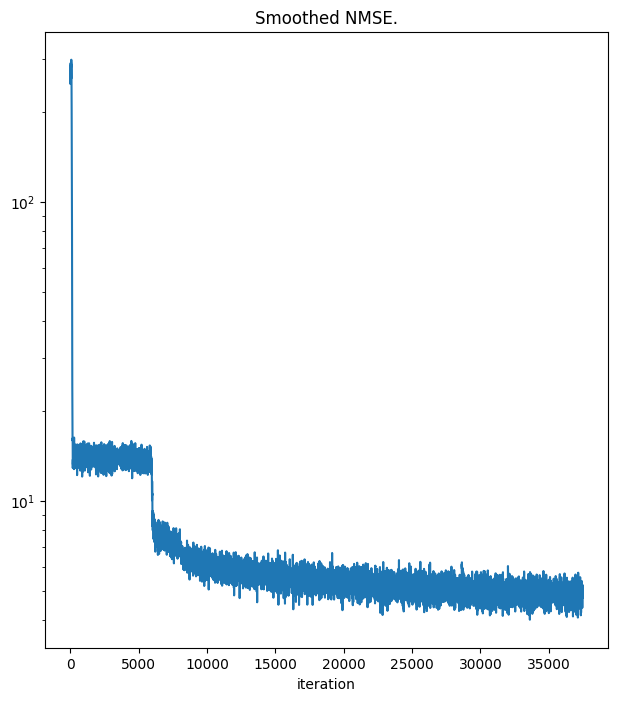

In [77]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')